# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/101rep_25noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/102rep_25noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/103rep_25noiseLevel_GMA_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/101rep_25noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/102rep_25noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/103rep_25noiseLevel_GMA_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.320301        0.203141  0.051135  0.303779  0.020326   
       0.25   0.311473        0.193072  0.054772  0.246578  0.067041   
       0.50   0.314120        0.198045  0.058764  0.213909  0.099044   
       0.75   0.320040        0.184892  0.067969  0.195107  0.117232   
       1.00   0.309820        0.177323  0.073860  0.183451  0.138026   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.198403  0.009788  0.040606  0.047477  0.000000  
       0.25  0.204838  0.009945  0.041888  0.052746  0.000585  
       0.50  0.202512  0.009266  0.039450  0.050260  0.001495  
       0.75  0.204221  0.008073  0.039943  0.049643  0.002683  
       1.00  0.202997  0.006926  0.037524  0.052066  0.003651

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.312511        0.204629  0.051322  0.293097  0.020650   
       0.25   0.314888        0.195839  0.053854  0.244376  0.067683   
       0.50   0.323046        0.192817  0.060222  0.216839  0.101575   
       0.75   0.312717        0.184822  0.070540  0.215901  0.118327   
       1.00   0.327020        0.169524  0.077545  0.180826  0.139800   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.201656  0.009873  0.039097  0.049837  0.000000  
       0.25  0.205275  0.009474  0.040050  0.048945  0.000576  
       0.50  0.201370  0.008650  0.039672  0.050163  0.001493  
       0.75  0.200746  0.007719  0.039506  0.049847  0.002511  
       1.00  0.207368  0.007107  0.036815  0.048090  0.003817

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.290630        0.198698  0.050480  0.297109  0.019457   
       0.25   0.311846        0.195346  0.055849  0.261368  0.066580   
       0.50   0.321765        0.181648  0.062325  0.228644  0.098892   
       0.75   0.305658        0.184752  0.067194  0.189692  0.122496   
       1.00   0.322996        0.183942  0.078023  0.184791  0.131800   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.211636  0.010108  0.040432  0.048775  0.000000  
       0.25  0.193178  0.010158  0.039875  0.050362  0.000595  
       0.50  0.196457  0.009009  0.039486  0.048526  0.001486  
       0.75  0.197981  0.008008  0.038175  0.049040  0.002566  
       1.00  0.204310  0.006974  0.038507  0.048938  0.003513

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.307814        0.202156  0.050979  0.297995  0.020144   
         0.25   0.308324        0.193844  0.057480  0.249741  0.068097   
         0.50   0.307475        0.189371  0.066989  0.218441  0.101199   
         0.75   0.292477        0.182893  0.079302  0.199102  0.120845   
         1.00   0.290219        0.174545  0.090094  0.183569  0.138351   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.203898  0.009923  0.040045  0.048697  0.000000  
         0.25  0.201094  0.009863  0.040604  0.050886  0.000386  
         0.50  0.200102  0.008997  0.039535  0.050162  0.000985  
         0.75  0.200949  0.007993  0.039197  0.050384  0.001715  
         1.00  0.204812  0.007129  0.037581  0.050980  0.002437

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  6.101863e+01  4.015845e+01      37.692821  5.723769e+01   
         0.25  4.486963e+06  2.379775e+06  215170.605512  1.421525e+06   
         0.50  5.600547e+06  3.542830e+06  348031.428814  2.226925e+06   
         0.75  5.898077e+06  4.193526e+06  418539.384158  2.716502e+06   
         1.00  5.950154e+06  4.740187e+06  475611.656791  3.135893e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.791488  5.554329e+01  5.504357e+01      18.708835   
         0.25  472440.652562  2.249389e+06  2.613968e+06  427129.834888   
         0.50  712984.410862  3.752934e+06  3.280235e+06  638585.081830   
         0.75  886163.874252  4.752821e+06  3.593999e+06  761165.327324   
         1.00  991658.939558  5.524615e+06  3.766037e+06  847123.904465   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         29.550140  
         0.25     186883.918585  
         0.50     278775.287738  
         0.75     351041.917068  
         1.00     403961.615942

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


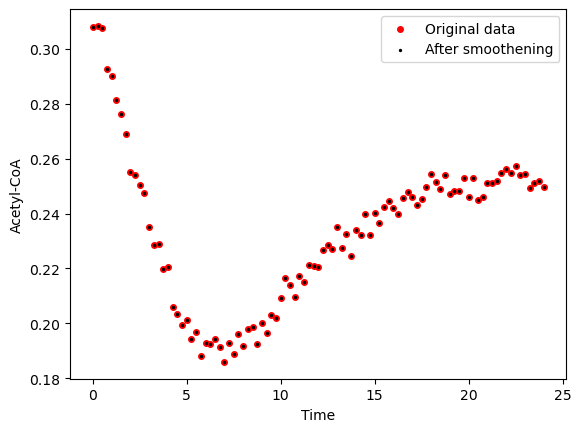

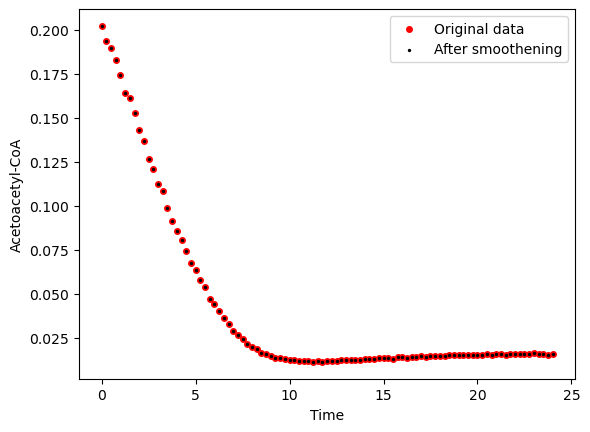

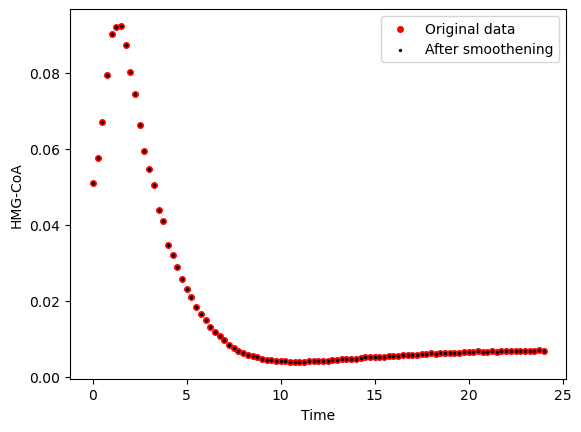

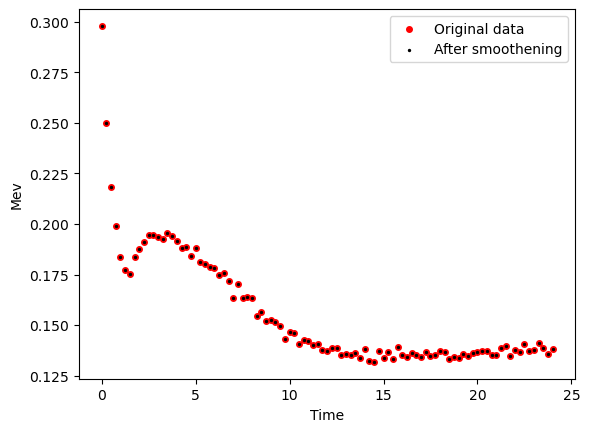

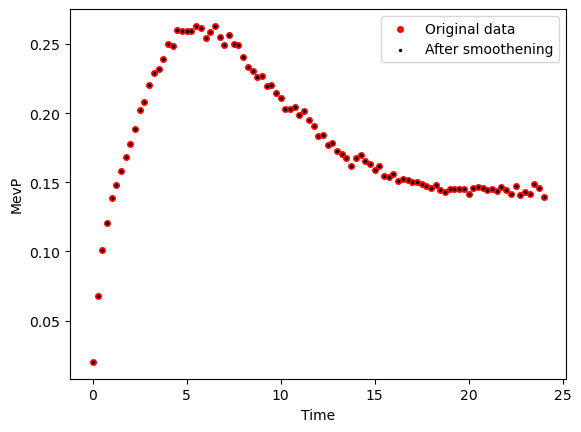

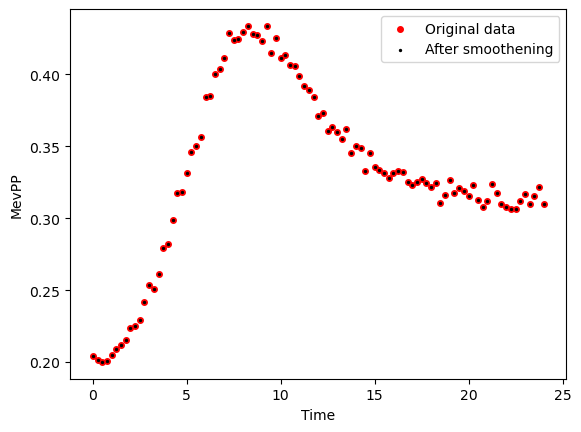

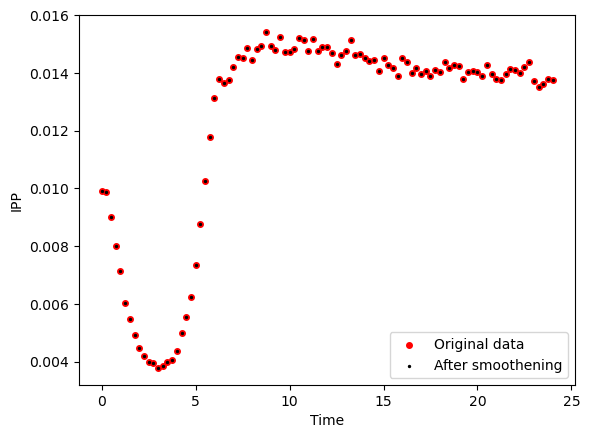

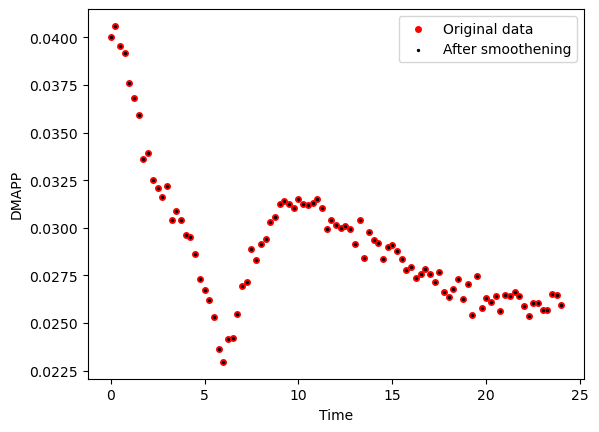

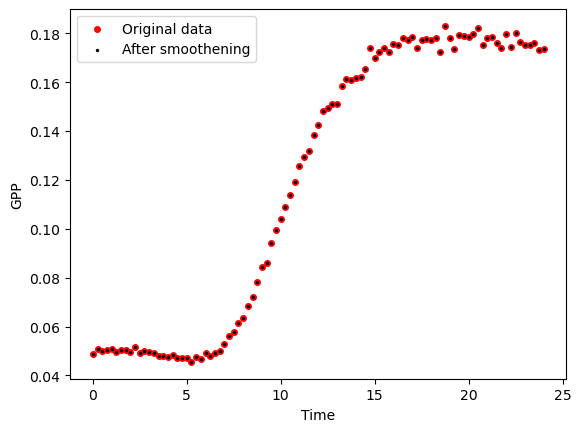

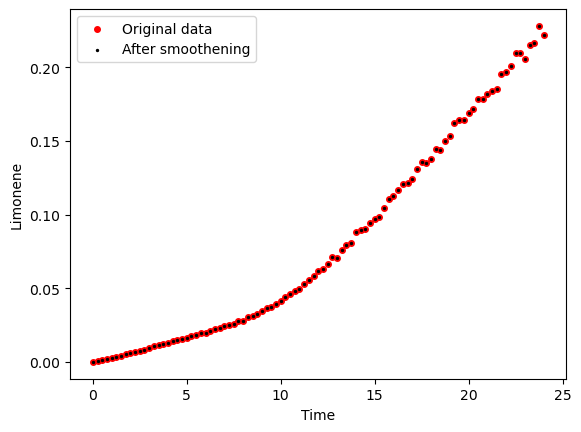

Strain Strain 2


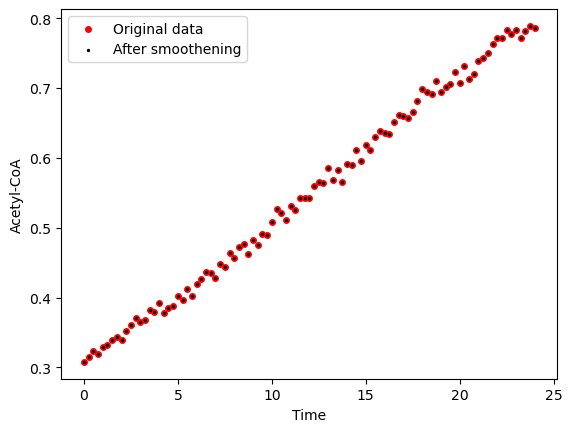

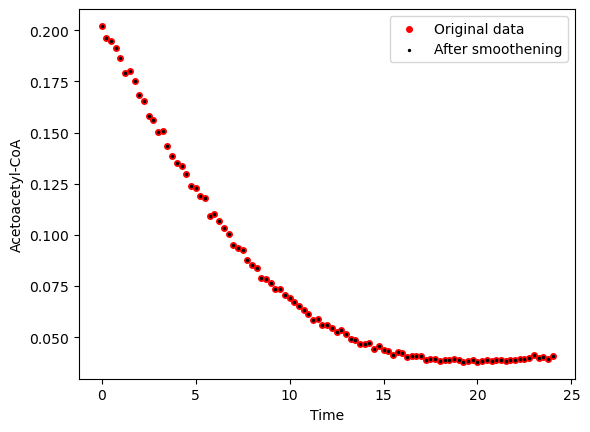

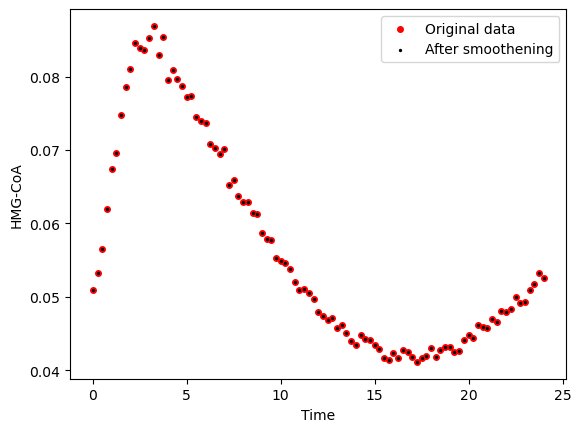

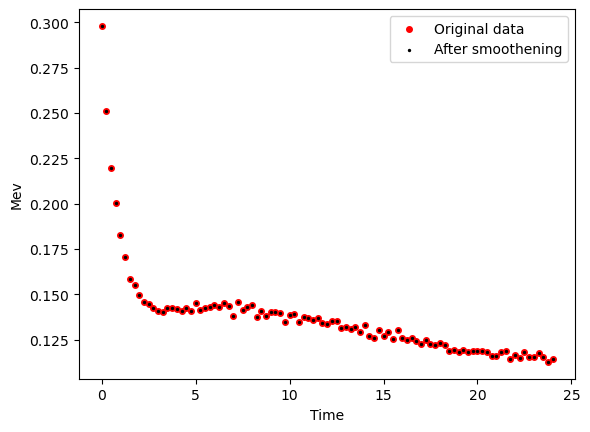

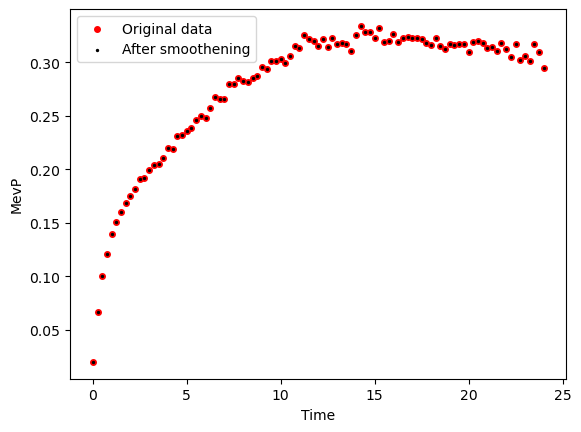

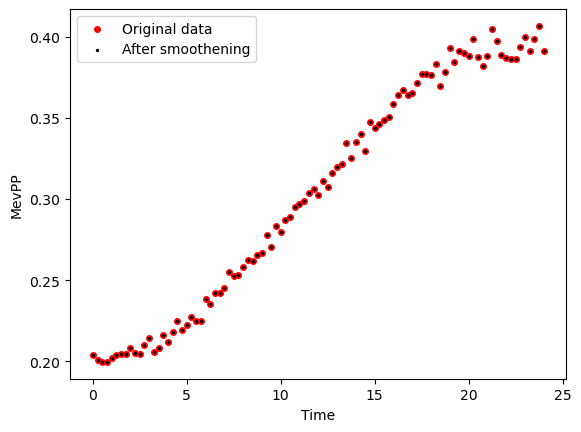

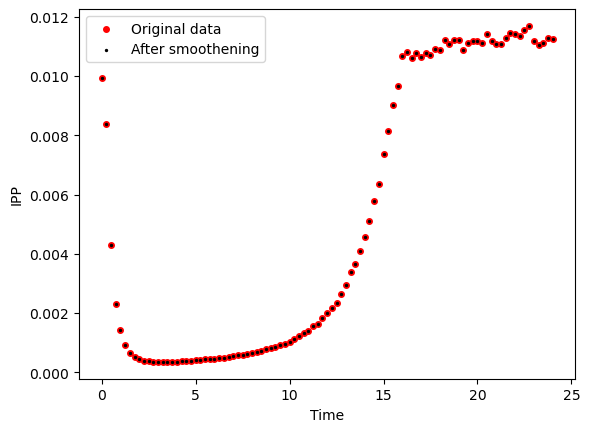

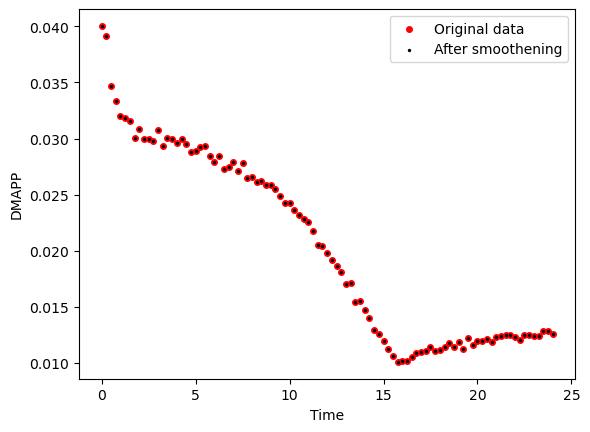

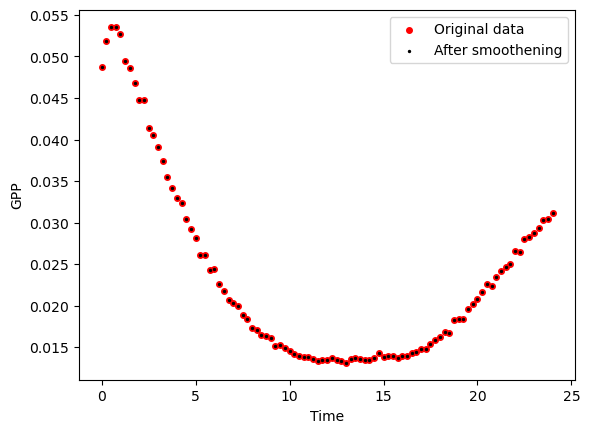

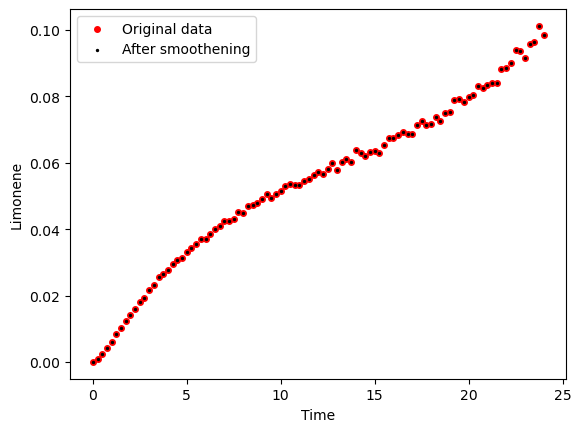

Strain Strain 3


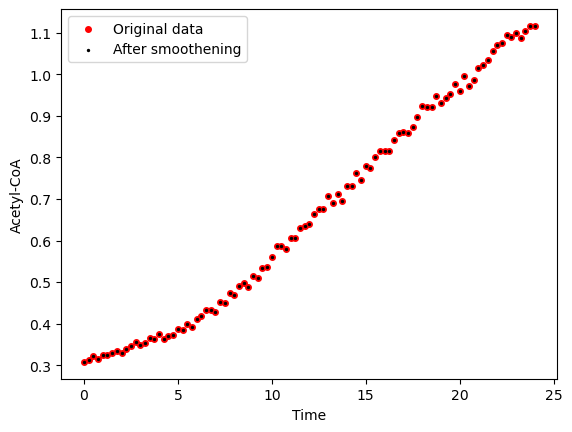

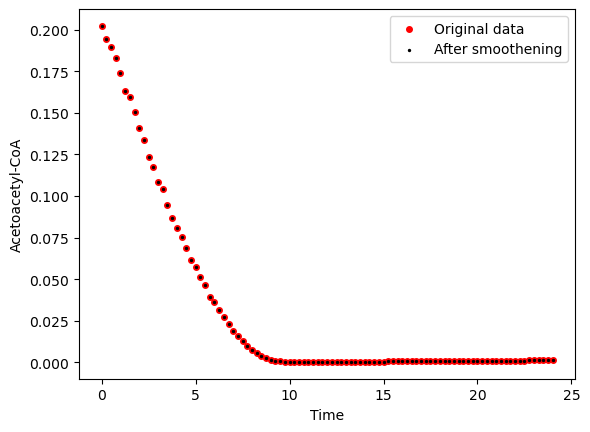

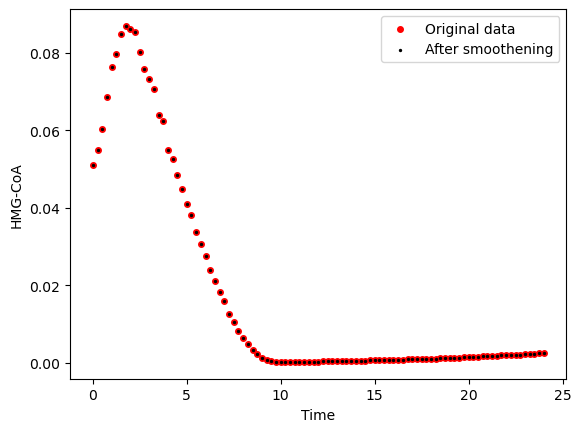

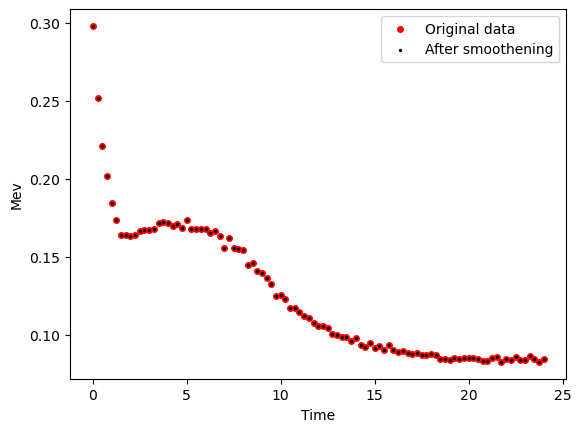

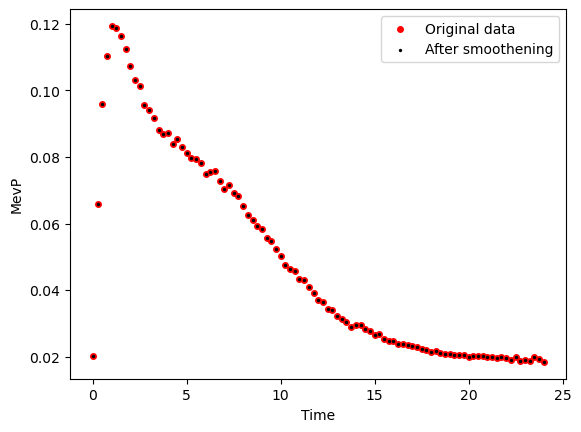

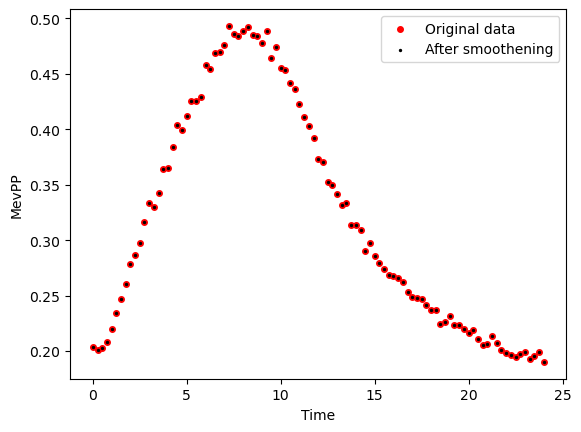

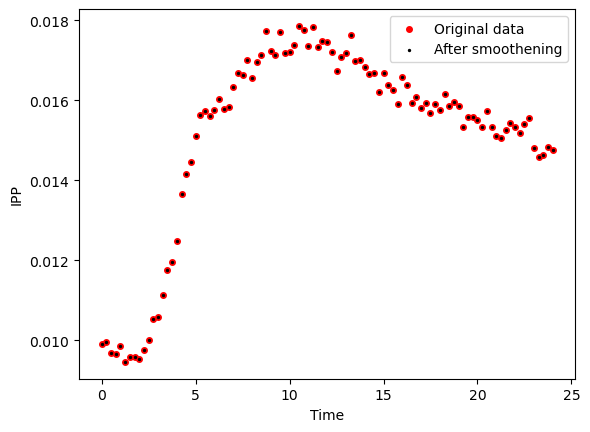

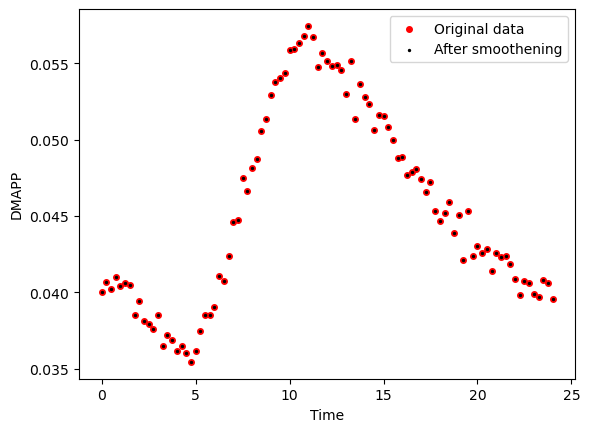

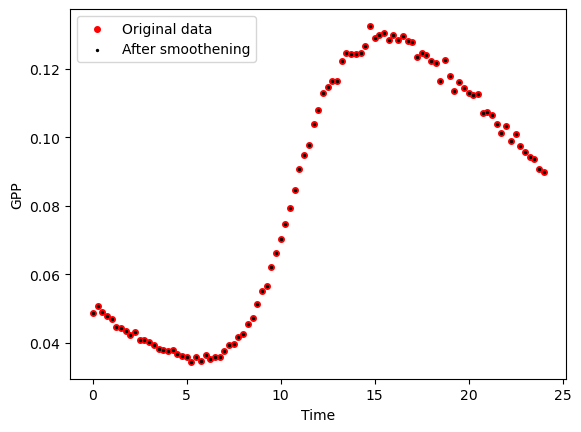

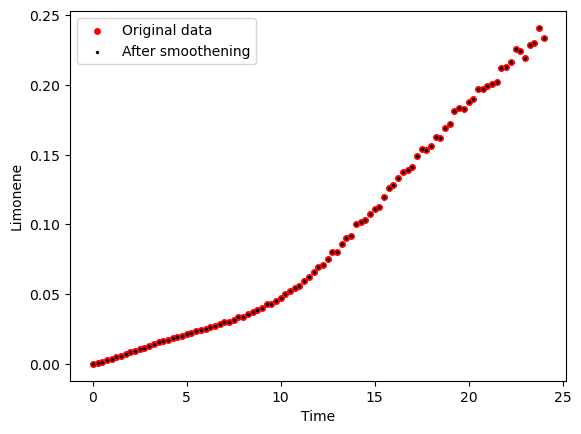

Strain WT


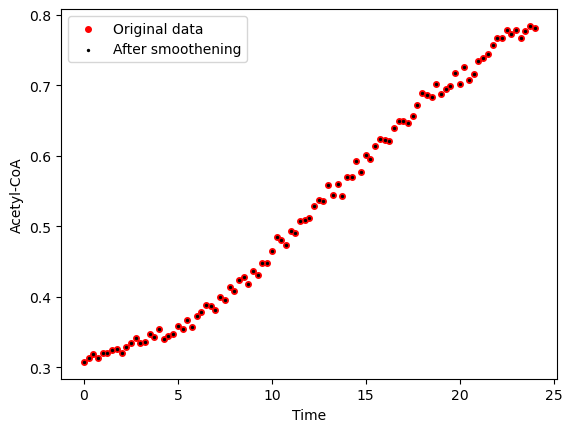

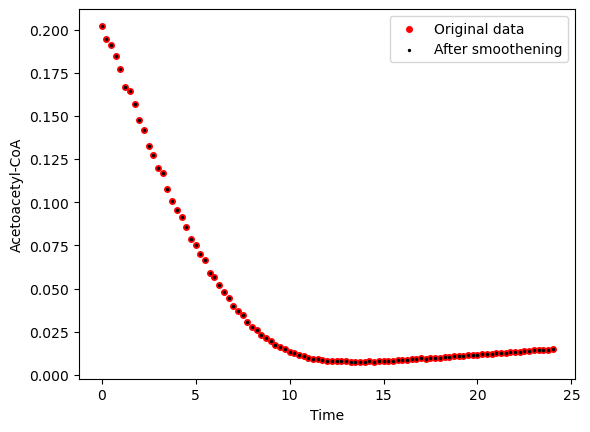

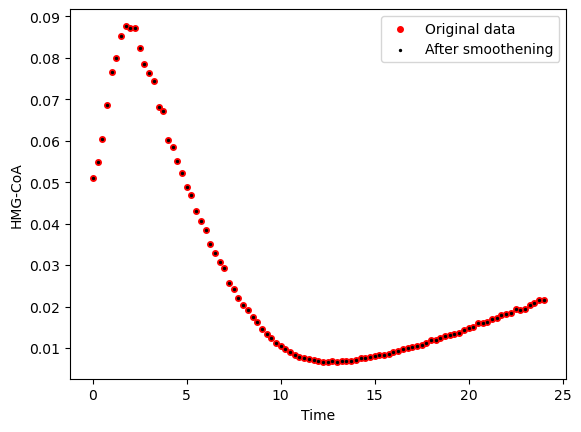

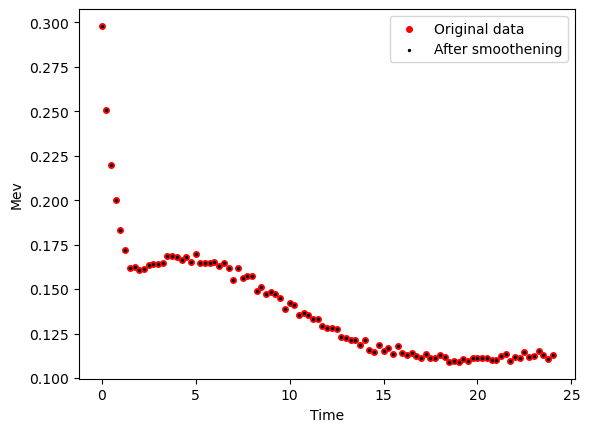

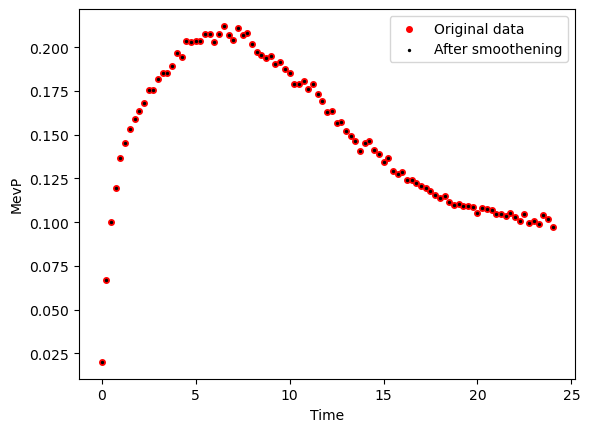

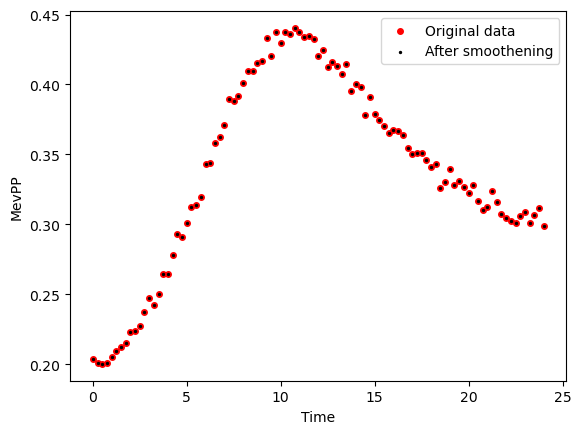

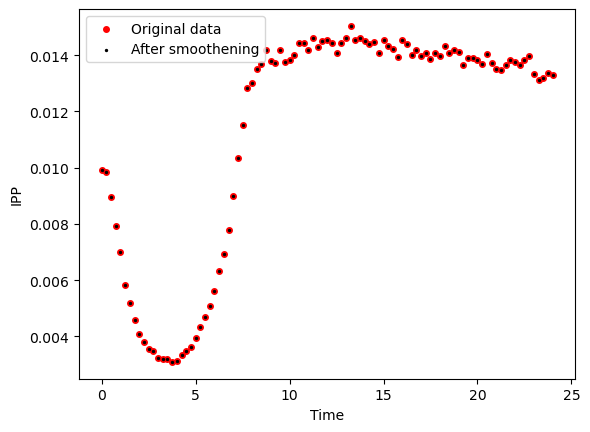

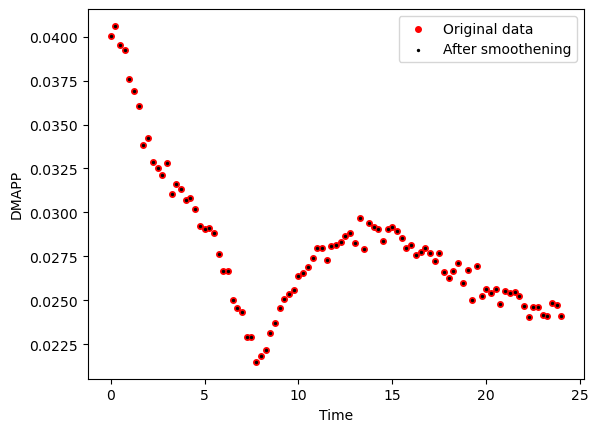

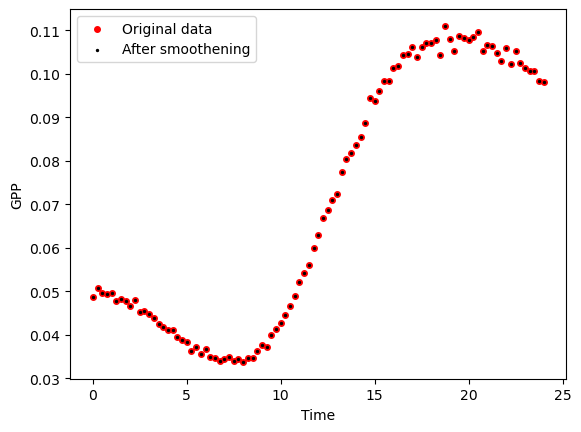

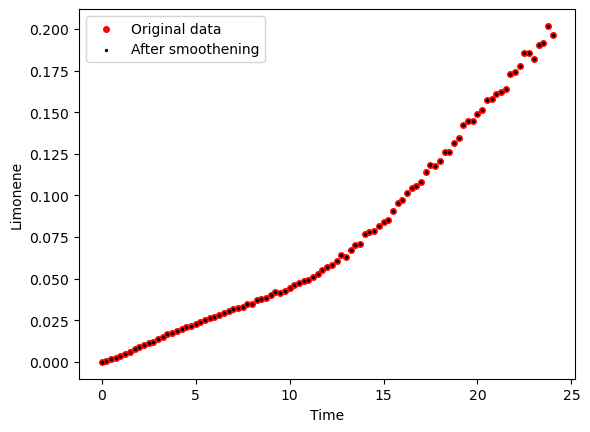

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


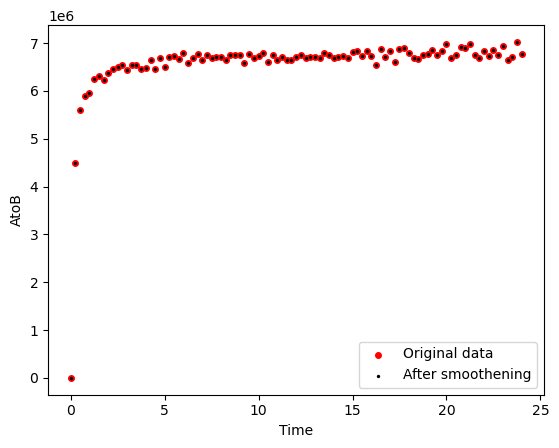

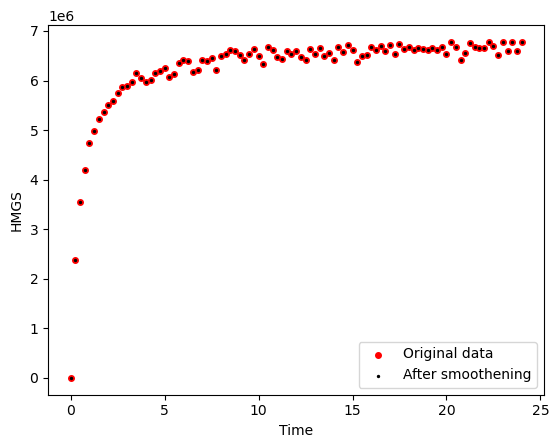

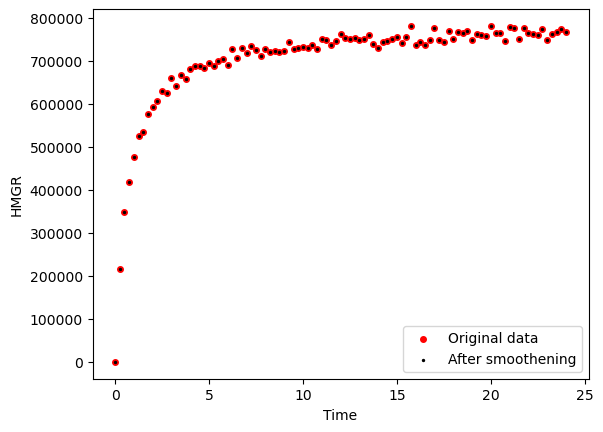

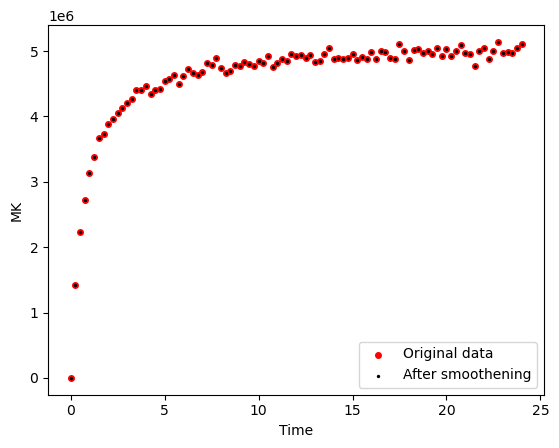

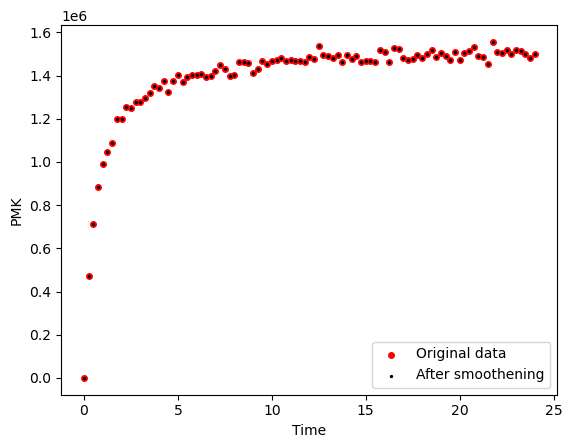

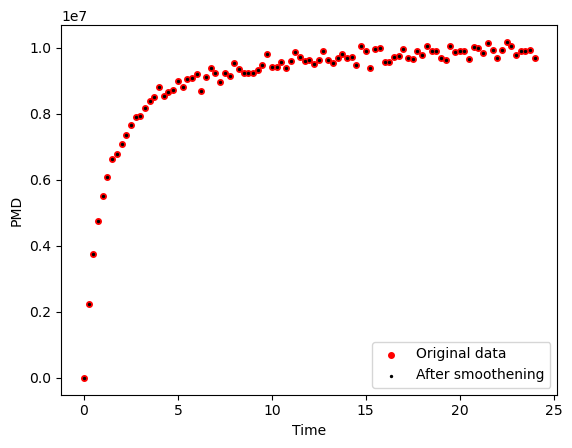

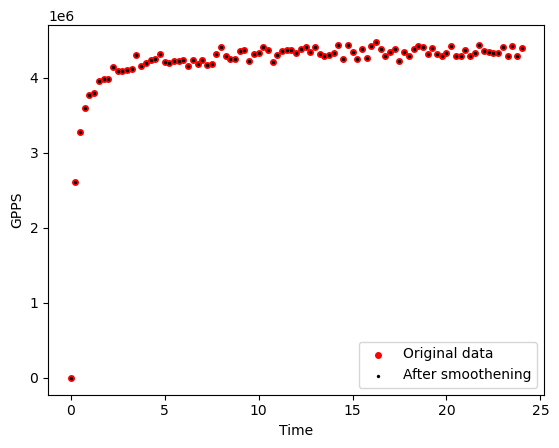

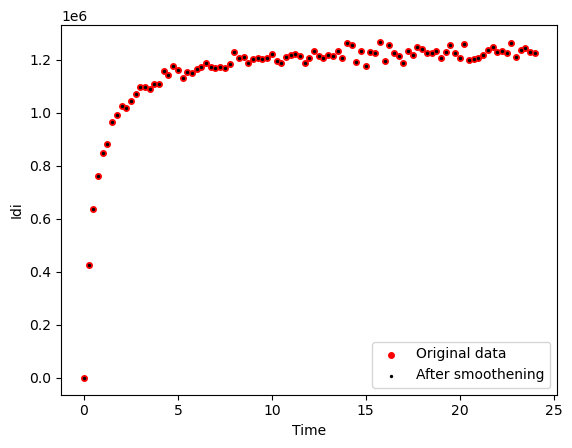

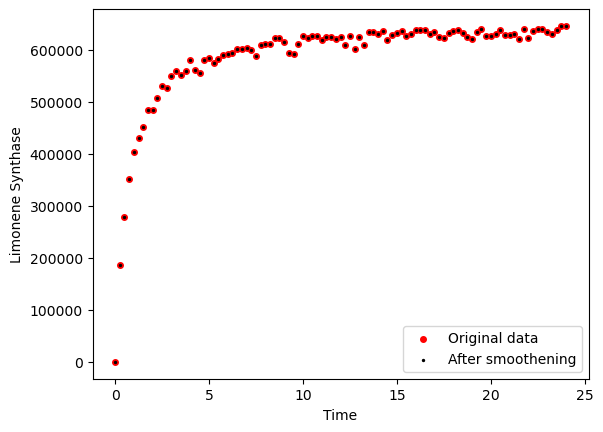

Strain Strain 2


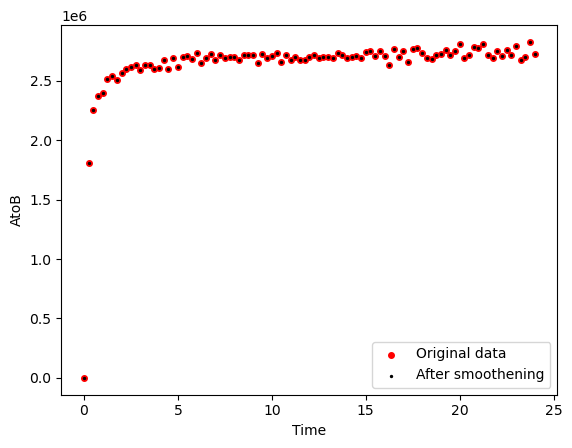

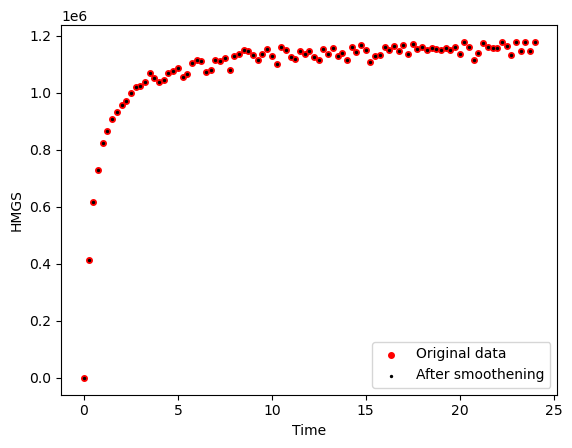

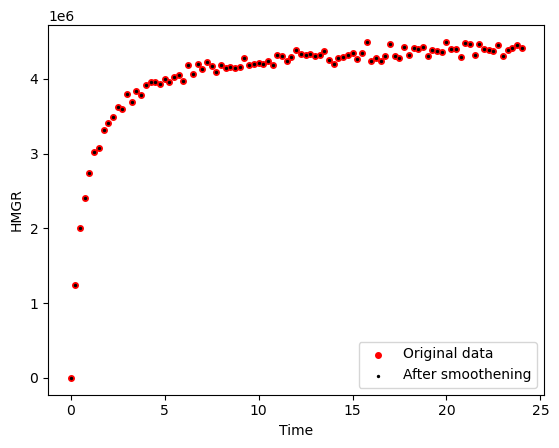

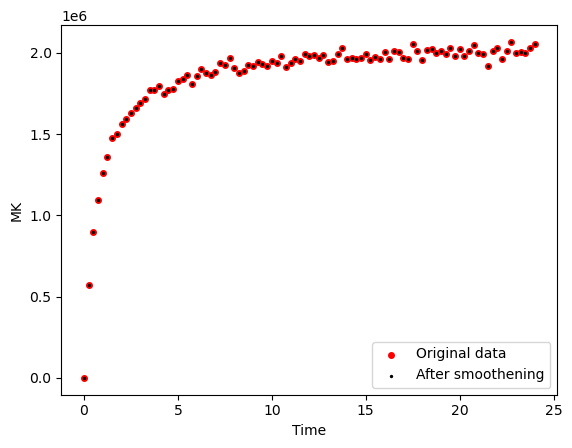

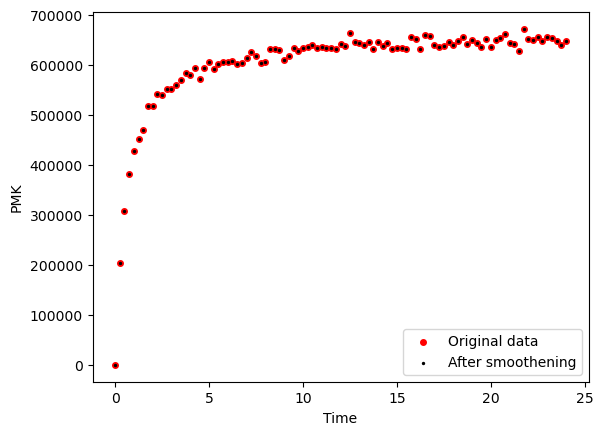

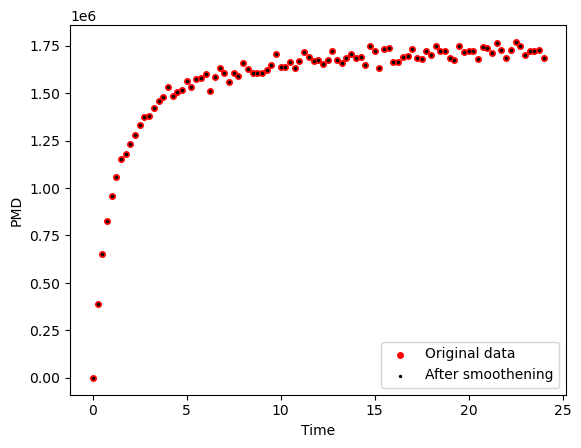

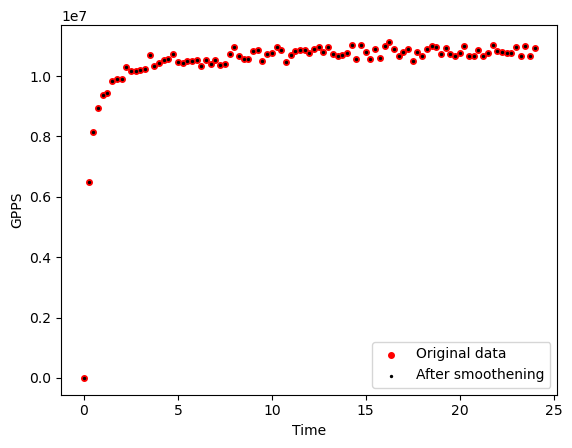

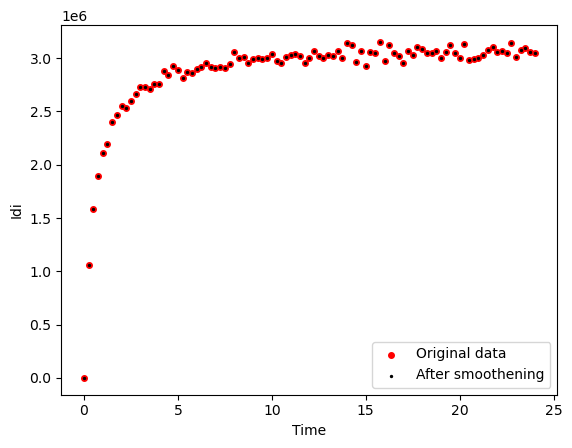

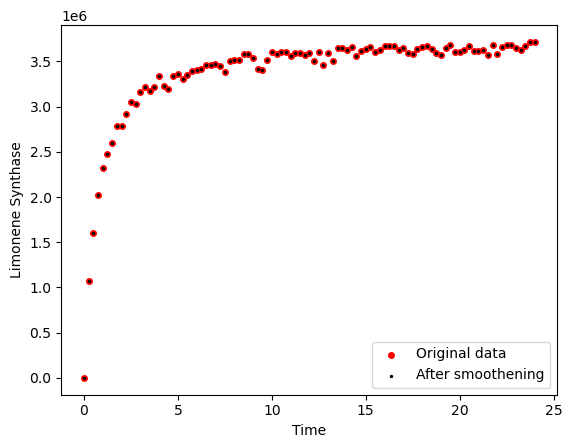

Strain Strain 3


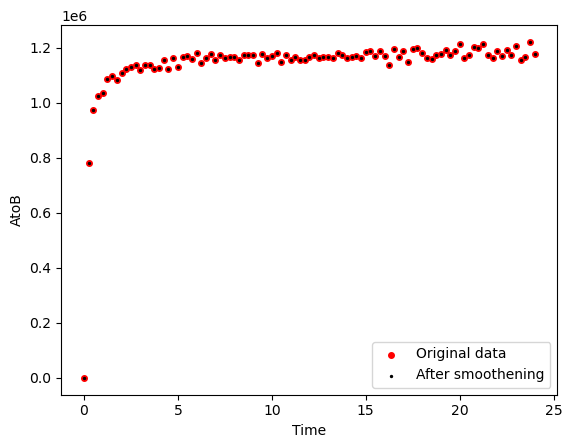

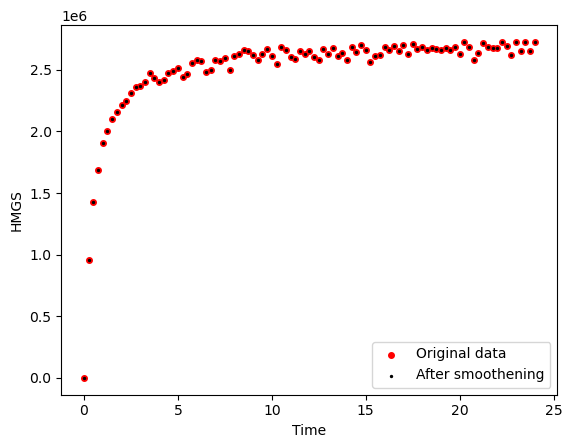

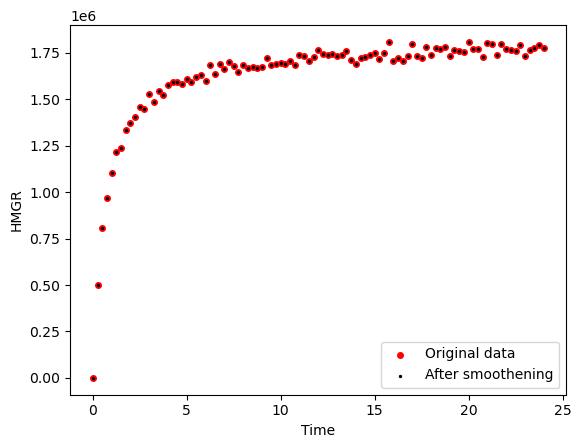

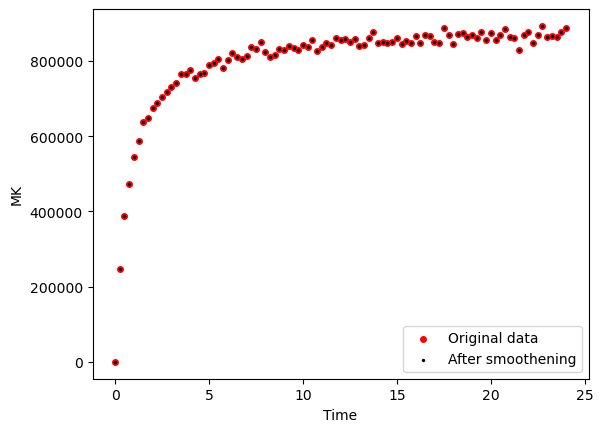

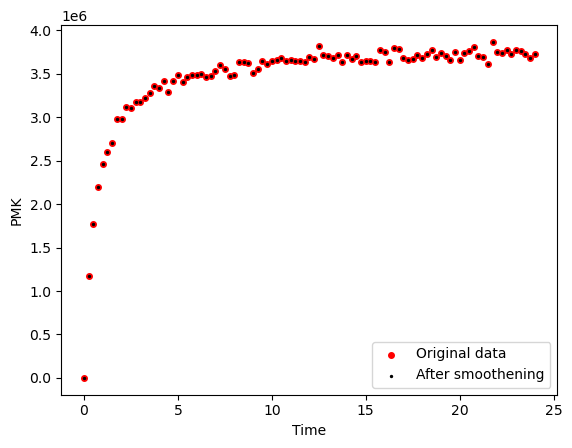

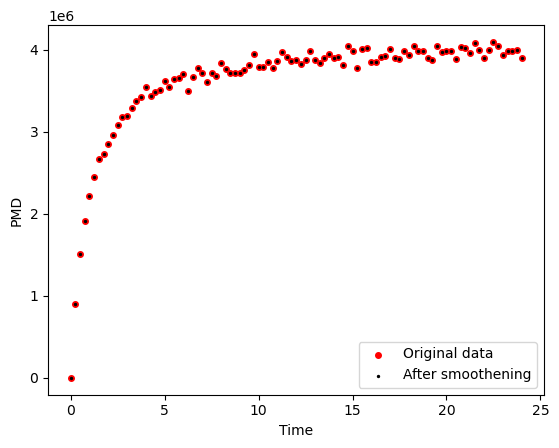

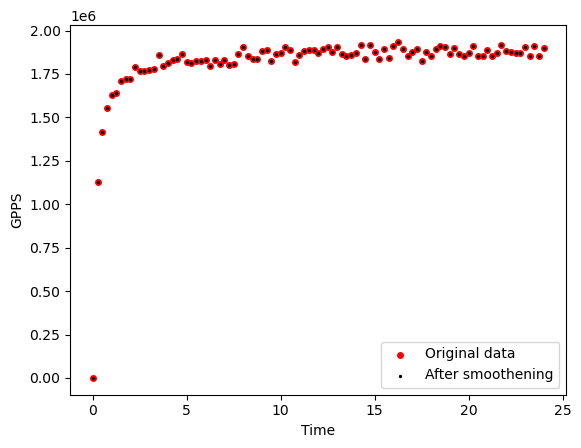

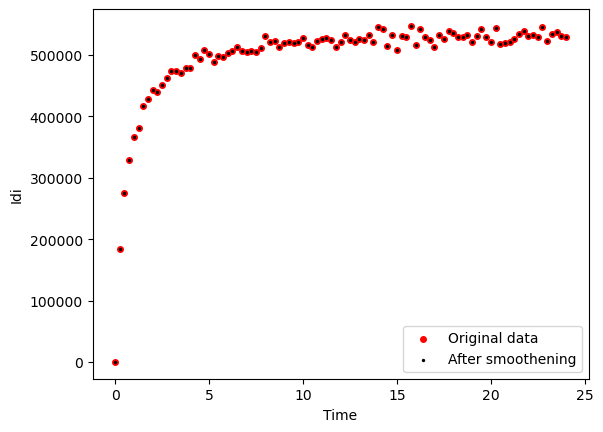

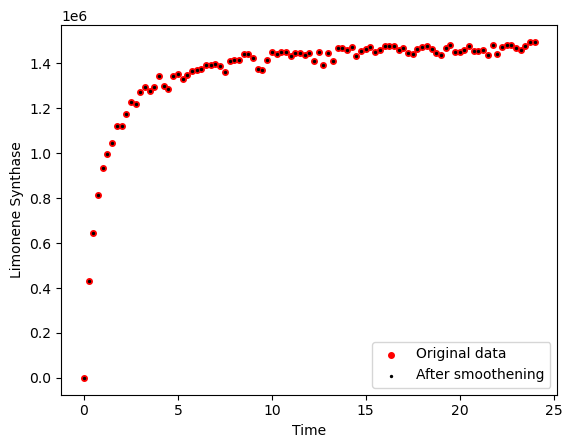

Strain WT


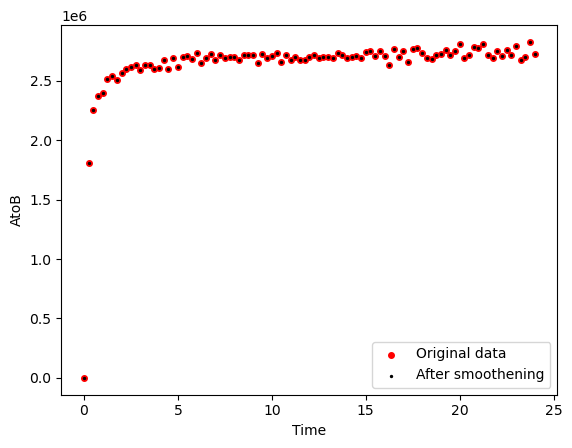

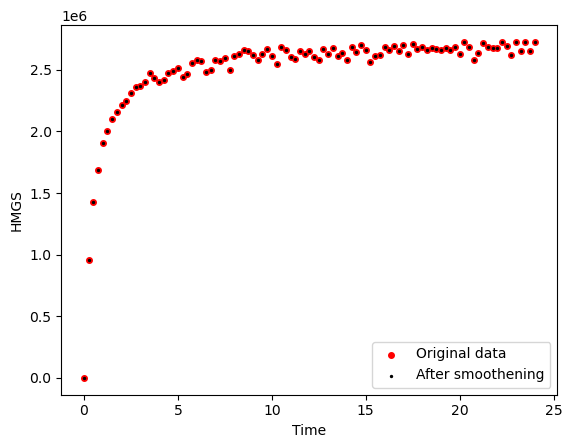

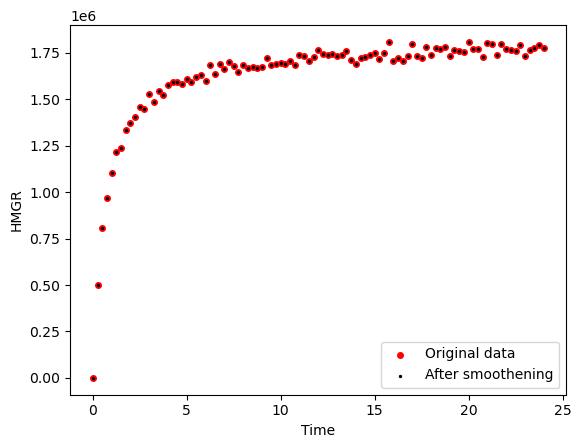

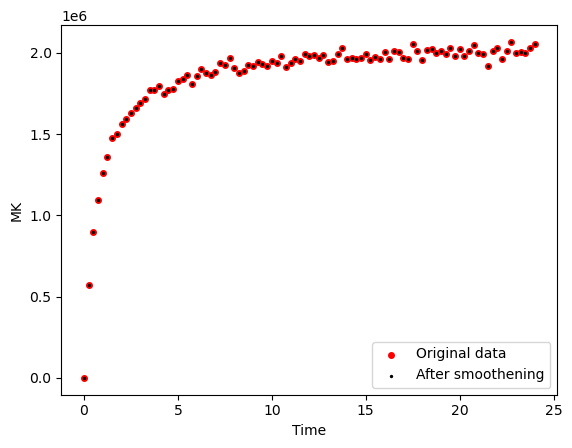

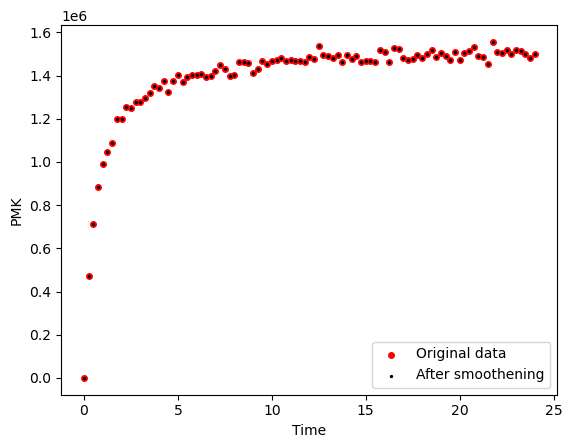

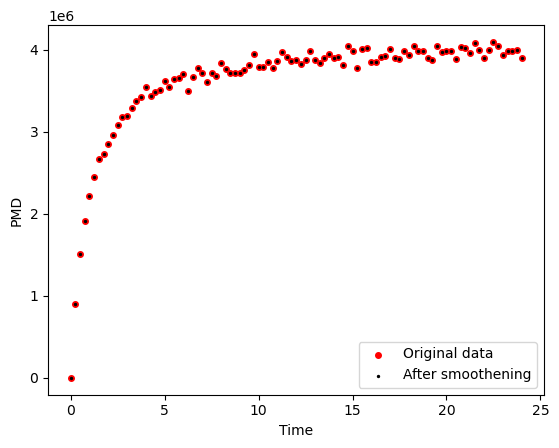

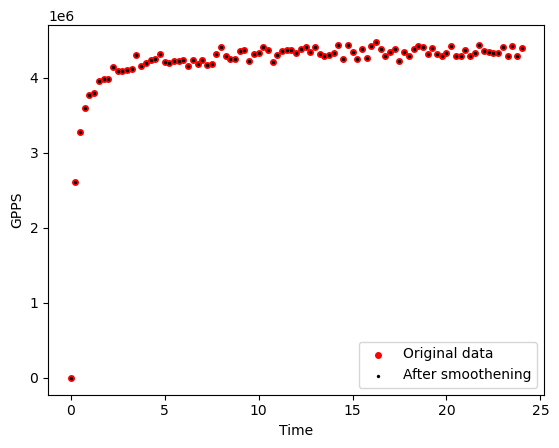

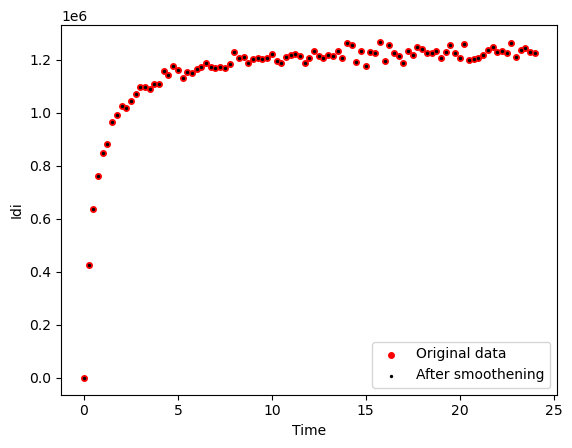

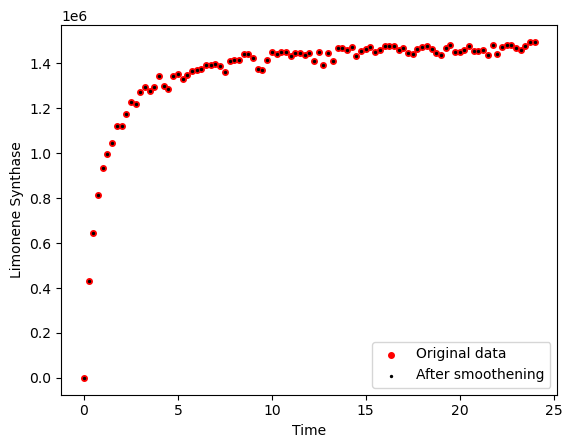

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative52

df_allSmooth=estimate_state_derivative52(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.307814        0.202156  0.050979  0.297995  0.020144   
         0.25    0.308324        0.193844  0.057480  0.249741  0.068097   
         0.50    0.307475        0.189371  0.066989  0.218441  0.101199   
         0.75    0.292477        0.182893  0.079302  0.199102  0.120845   
         1.00    0.290219        0.174545  0.090094  0.183569  0.138351   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.778826        0.014594  0.019505  0.112273  0.100710   
         23.25   0.767586        0.014177  0.020356  0.115130  0.099223   
         23.50   0.777198        0.014545  0.020860  0.113133  0.104319   
         23.75   0.784114        0.014220  0.021703  0.110885  0.101989   
         24.00   0.781234        0.014781  0.021584  0.112914  0.097047   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.203898  0.009923  0.040045  0.048697  0.000000  ...   
         0.25   0.201094  0.009863  0.040604  0.050886  0.000386  ...   
         0.50   0.200102  0.008997  0.039535  0.050162  0.000985  ...   
         0.75   0.200949  0.007993  0.039197  0.050384  0.001715  ...   
         1.00   0.204812  0.007129  0.037581  0.050980  0.002437  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.308910  0.013322  0.024192  0.101325  0.181973  ...   
         23.25  0.301243  0.013127  0.024103  0.100596  0.190535  ...   
         23.50  0.306368  0.013182  0.024829  0.100602  0.191844  ...   
         23.75  0.311549  0.013355  0.024718  0.098291  0.201864  ...   
         24.00  0.299055  0.013308  0.024143  0.098021  0.196378  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.002084       -0.024095  0.027010 -0.200259  0.200635   
         0.25    -0.009166       -0.025282  0.033515 -0.156027  0.158150   
         0.50    -0.020415       -0.026469  0.040020 -0.111796  0.115665   
         0.75    -0.028478       -0.029640  0.036937 -0.071782  0.078804   
         1.00    -0.029534       -0.030077  0.025393 -0.043366  0.056300   
...                    ...             ...       ...       ...       ...   
WT       23.00   -0.003357        0.000805  0.001620  0.000121 -0.000262   
         23.25    0.008122        0.000231  0.002489 -0.000470  0.003395   
         23.50    0.008537        0.000166  0.002201 -0.001185 -0.001824   
         23.75    0.016551        0.000887  0.001287 -0.002274 -0.010016   
         24.00    0.024565        0.001608  0.000372 -0.003363 -0.018208   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.016668 -0.000988  0.001602  0.004187  0.001564  
         0.25  -0.007998 -0.001985 -0.000466  0.002906  0.002023  
         0.50   0.000672 -0.002983 -0.002534  0.001626  0.002481  
         0.75   0.008258 -0.003811 -0.003816 -0.000774  0.002952  
         1.00   0.012830 -0.003613 -0.003856 -0.000146  0.003169  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.002384 -0.000858 -0.000060 -0.004419  0.006802  
         23.25  0.003731 -0.000550  0.000344 -0.003676  0.016931  
         23.50 -0.003761  0.000081  0.000207 -0.003565  0.016055  
         23.75 -0.009246  0.000317 -0.000826 -0.004365  0.004978  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

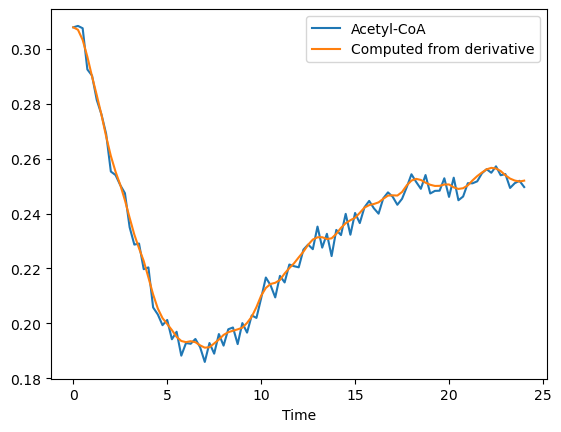

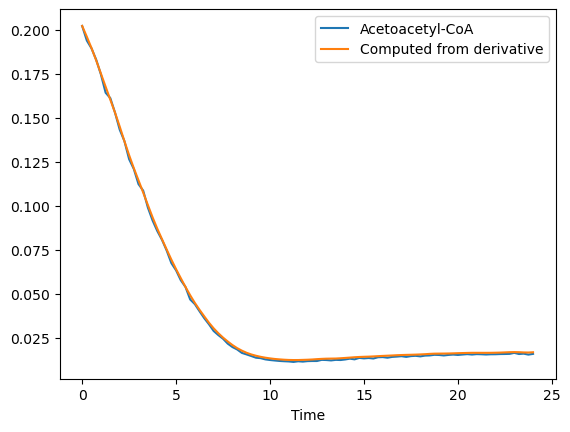

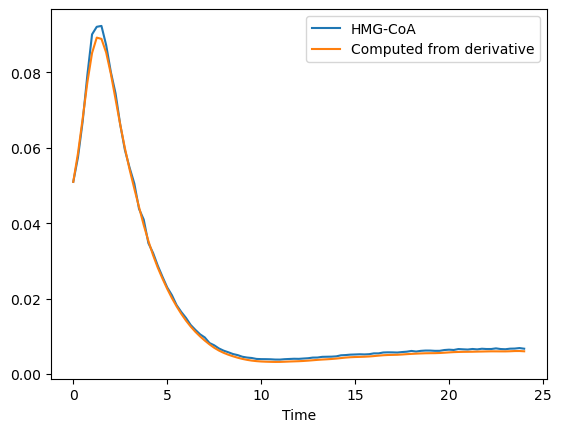

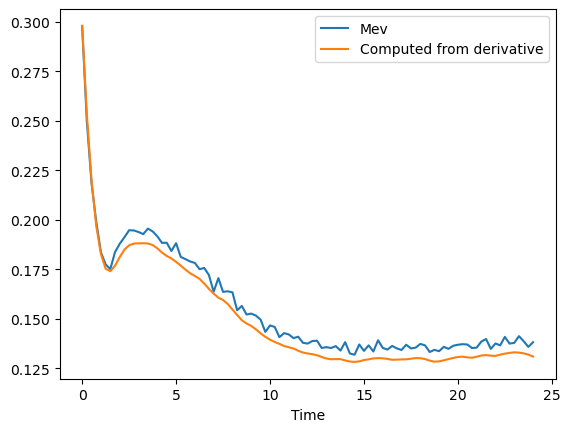

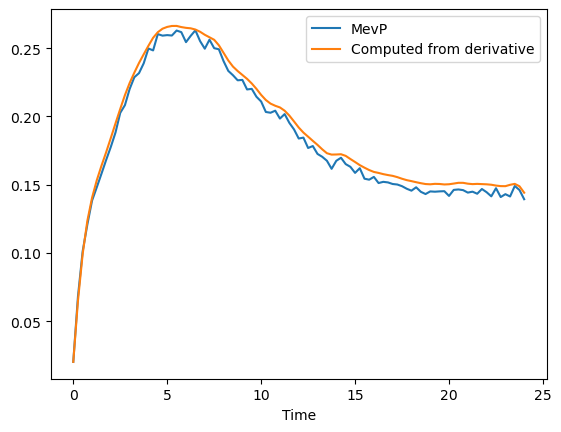

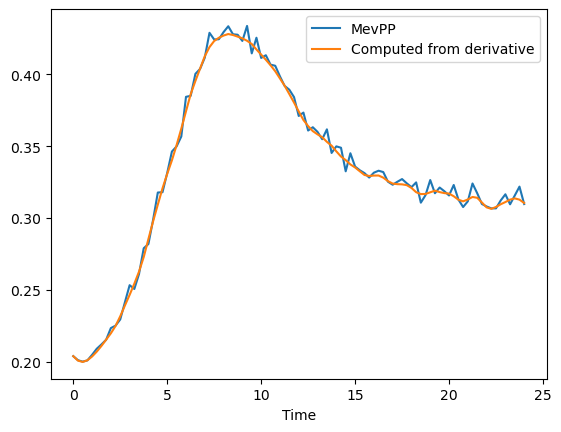

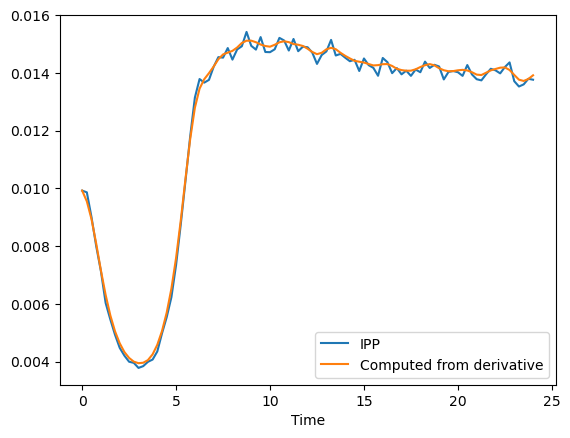

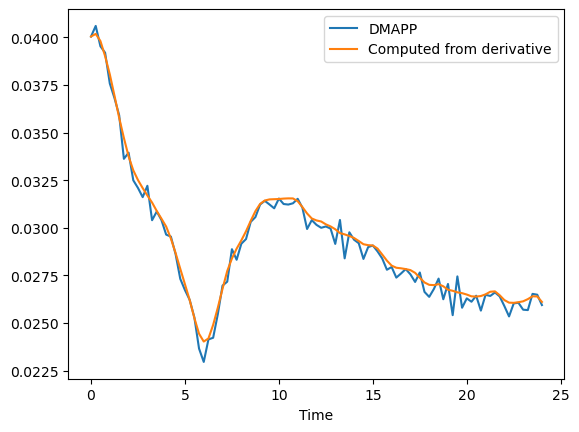

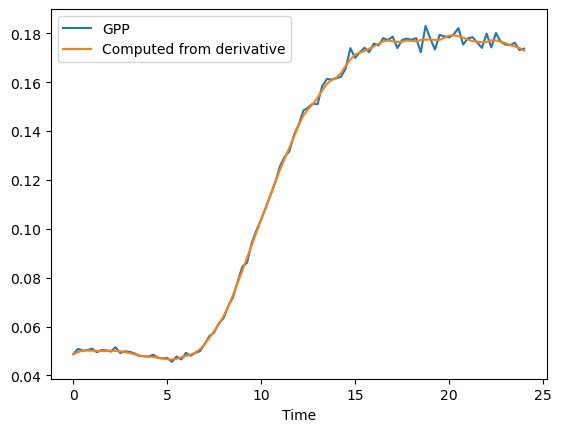

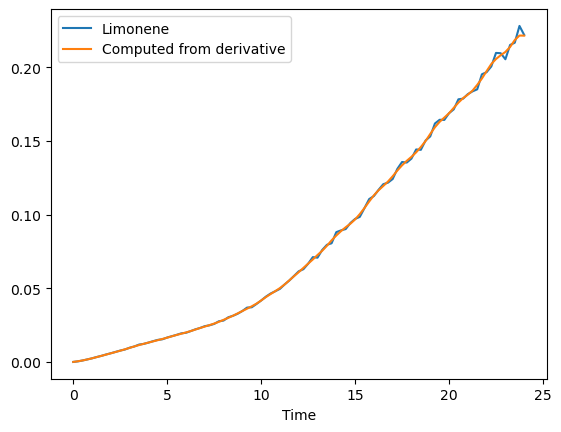

'Time profile from derivative vs. actual profile for Strain 2'

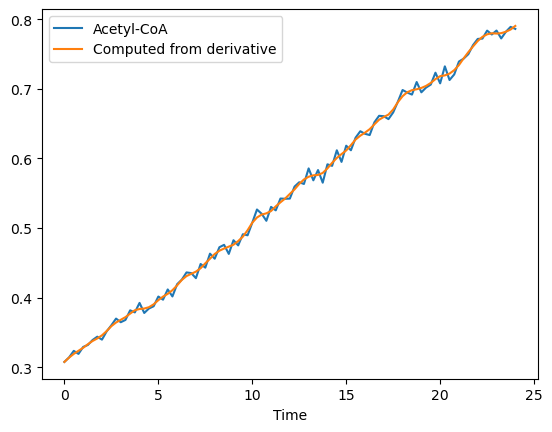

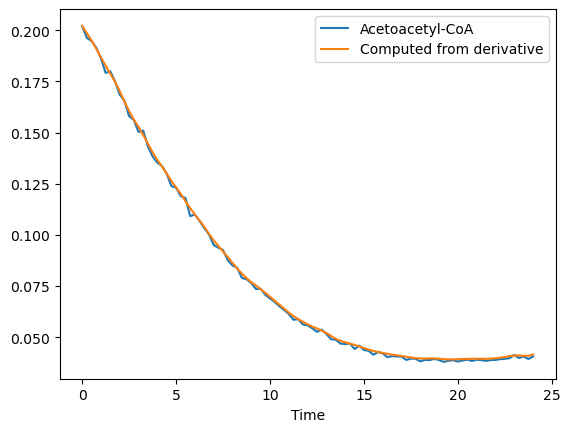

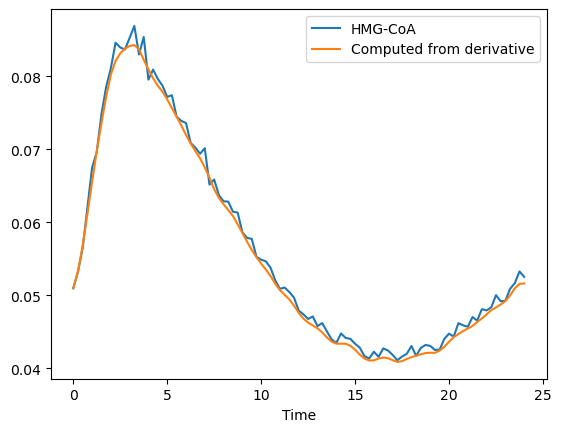

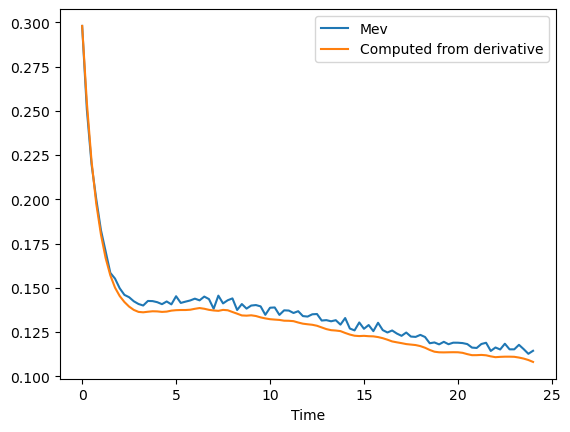

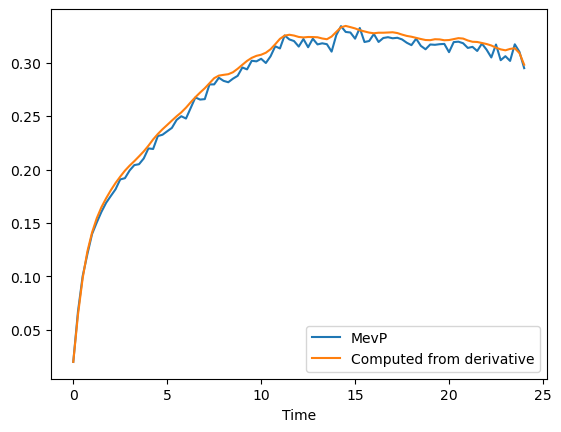

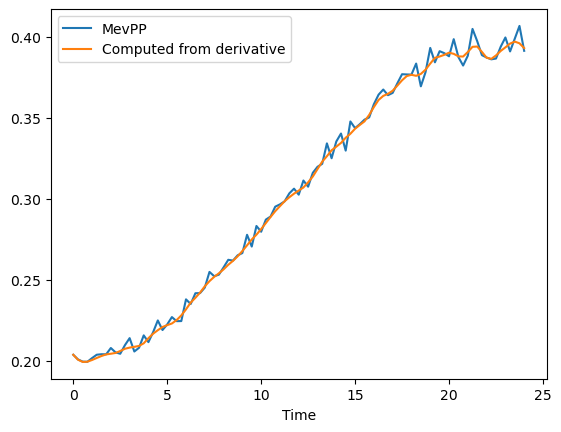

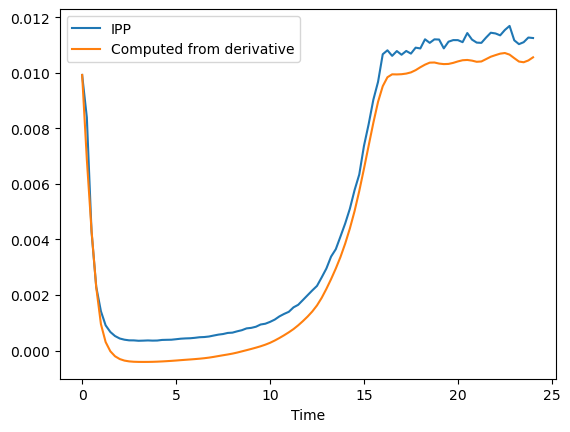

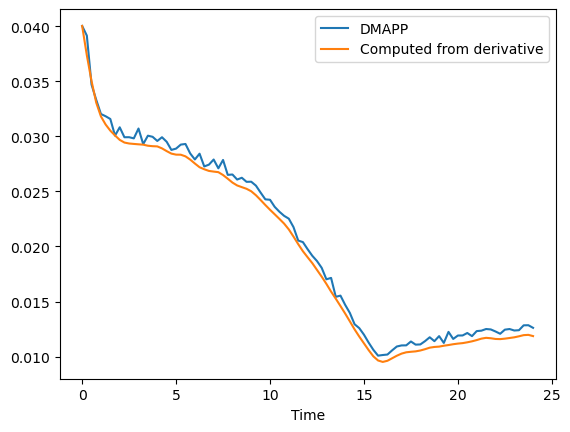

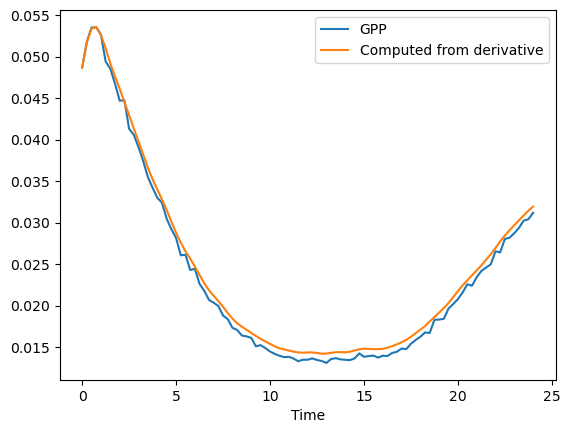

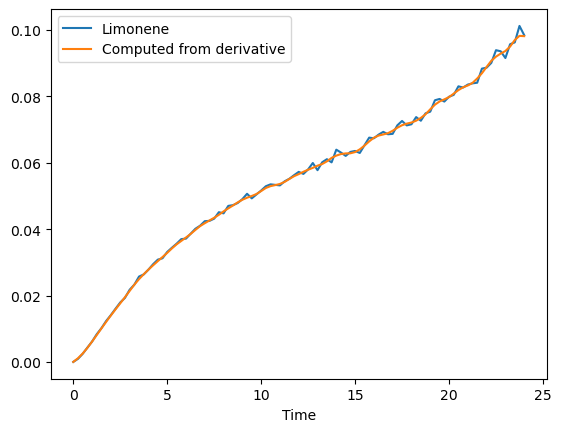

'Time profile from derivative vs. actual profile for Strain 3'

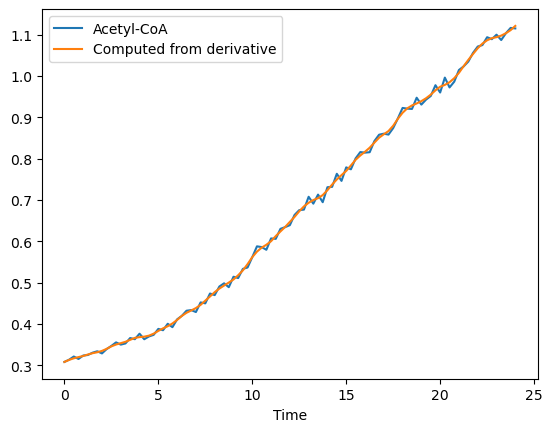

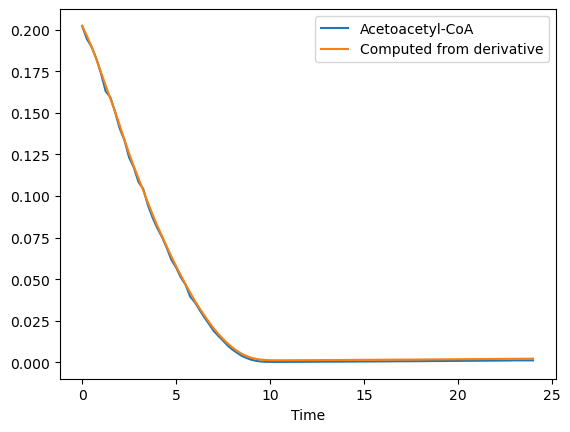

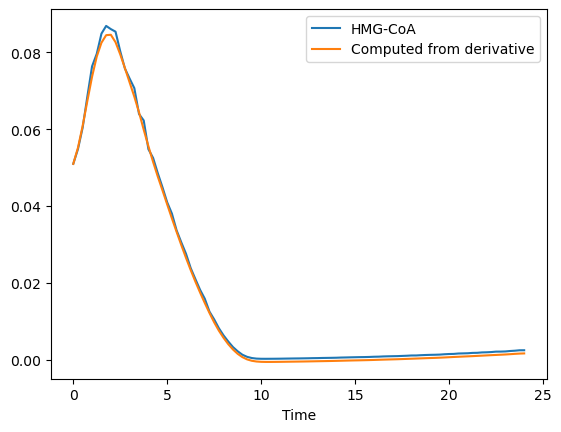

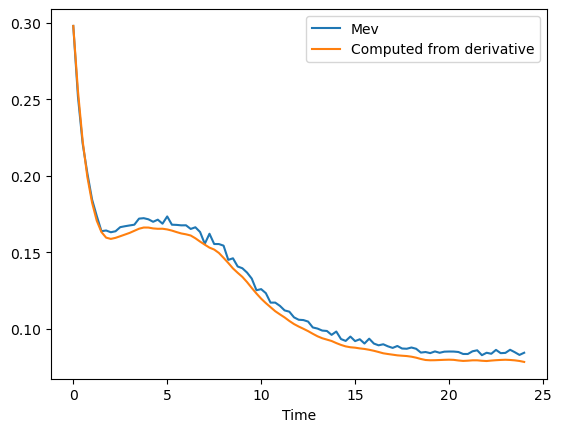

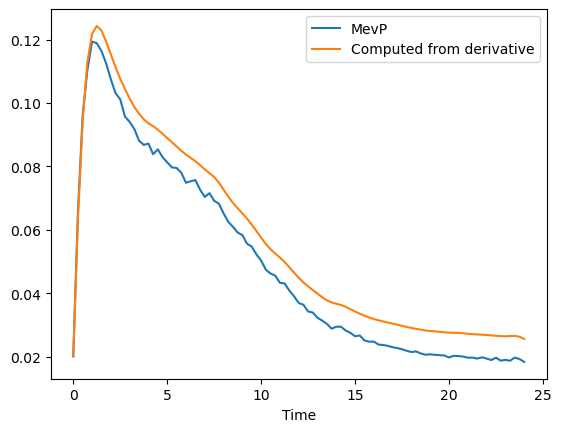

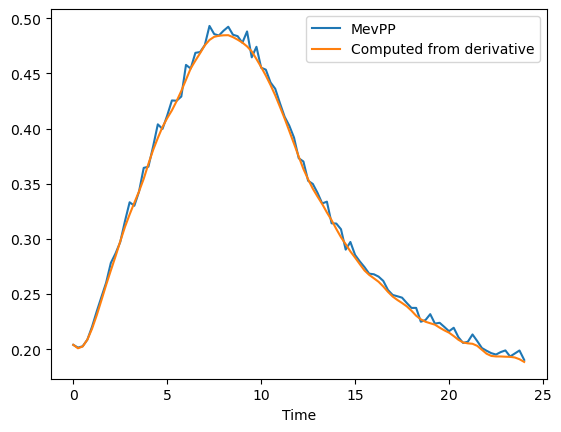

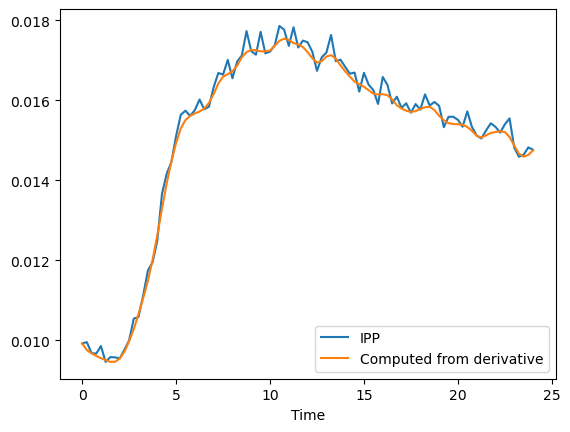

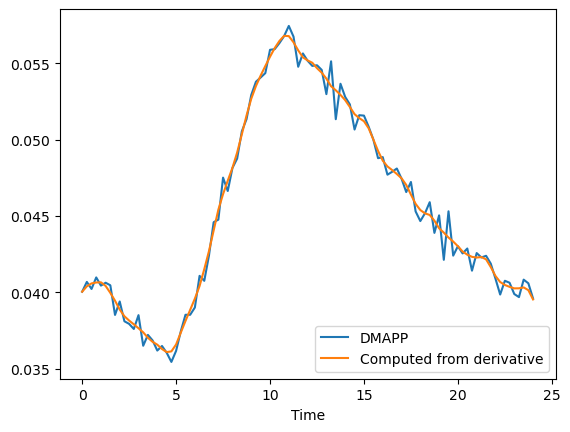

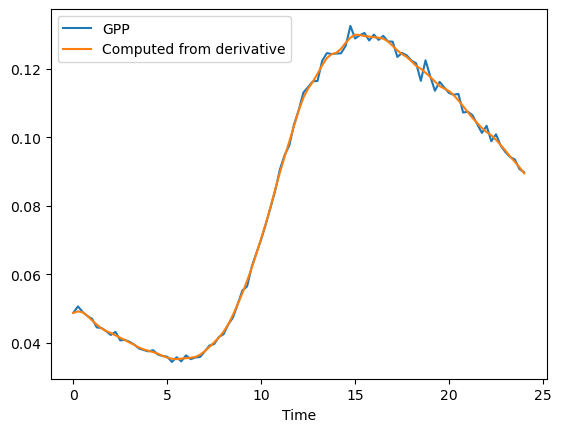

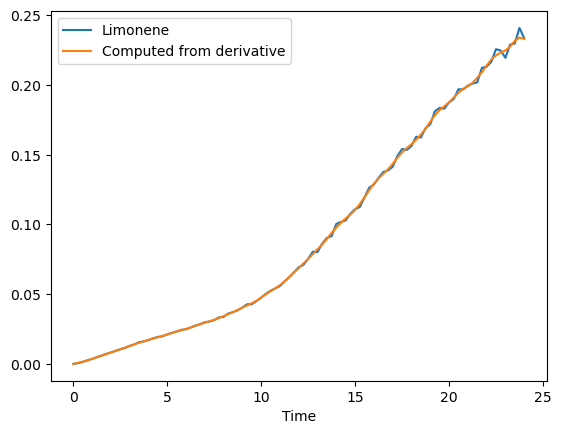

'Time profile from derivative vs. actual profile for WT'

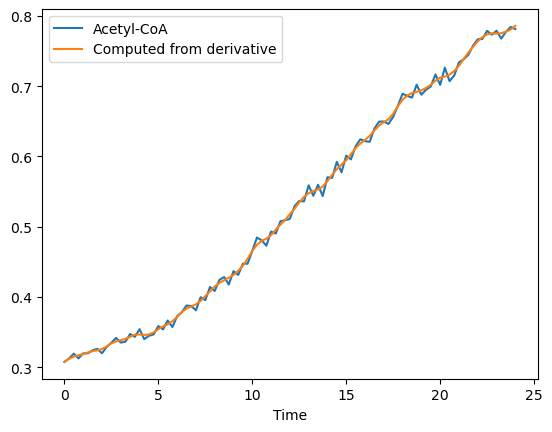

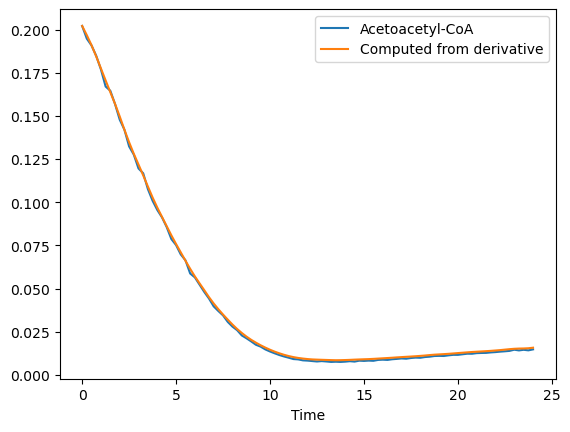

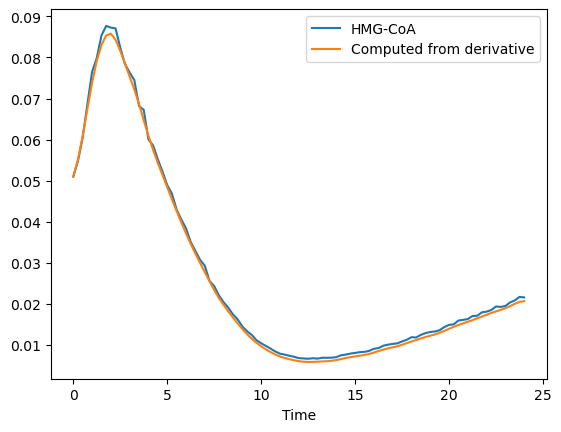

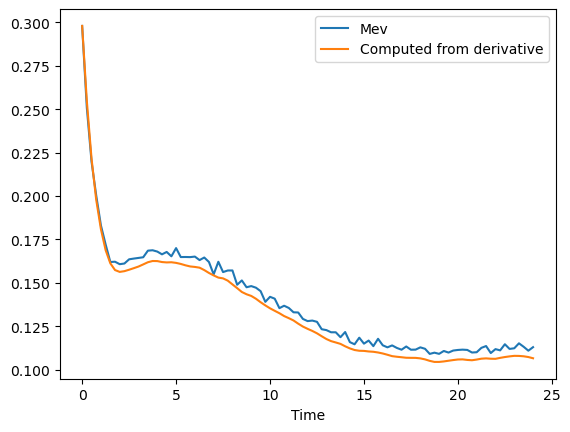

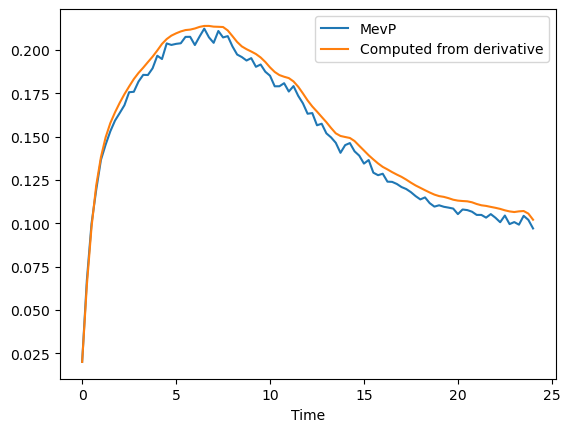

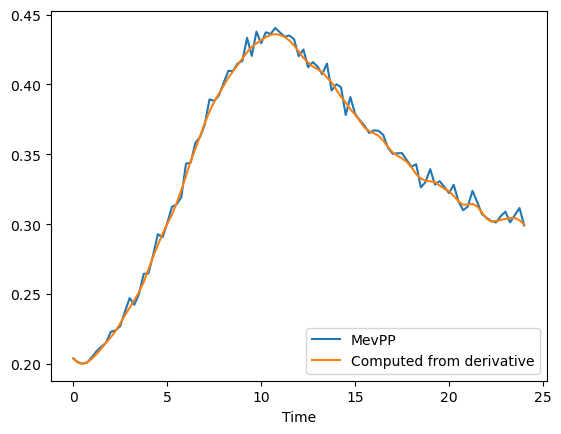

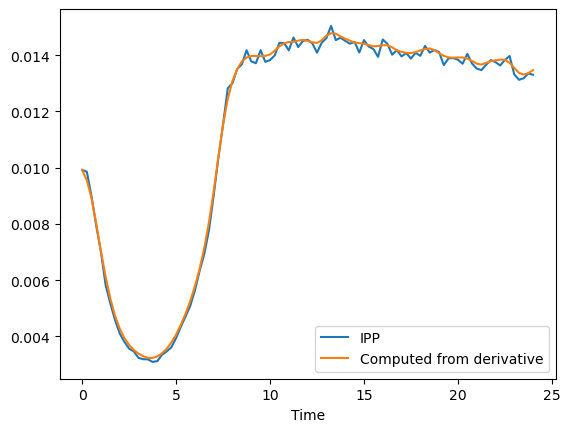

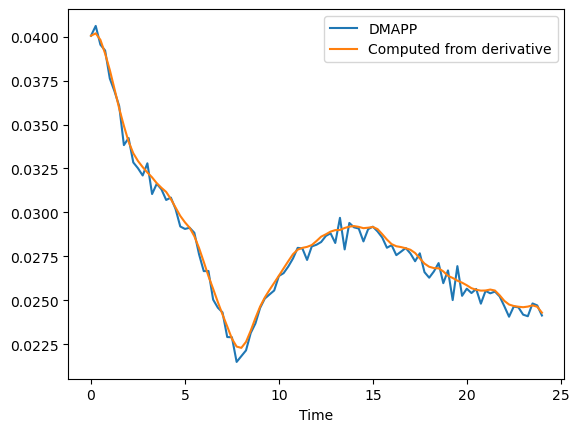

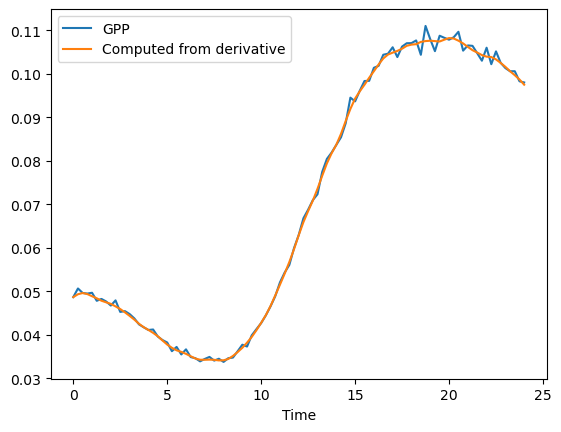

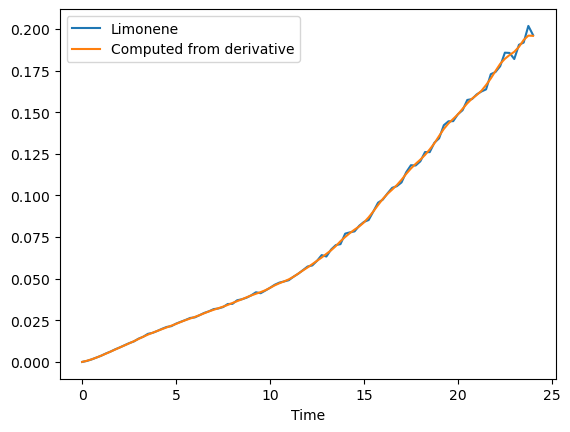

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   6.101863e+01  4.015845e+01  3.769282e+01  5.723769e+01   
         0.25   4.486963e+06  2.379775e+06  2.151706e+05  1.421525e+06   
         0.50   5.600547e+06  3.542830e+06  3.480314e+05  2.226925e+06   
         0.75   5.898077e+06  4.193526e+06  4.185394e+05  2.716502e+06   
         1.00   5.950154e+06  4.740187e+06  4.756117e+05  3.135893e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.793985e+06  2.726634e+06  1.732866e+06  1.999582e+06   
         23.25  2.674277e+06  2.652135e+06  1.764617e+06  2.006932e+06   
         23.50  2.699014e+06  2.722133e+06  1.774984e+06  2.001659e+06   
         23.75  2.825522e+06  2.650638e+06  1.791724e+06  2.026817e+06   
         24.00  2.720292e+06  2.726081e+06  1.773775e+06  2.054542e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.679149e+01  5.554329e+01  5.504357e+01  1.870883e+01   
         0.25   4.724407e+05  2.249389e+06  2.613968e+06  4.271298e+05   
         0.50   7.129844e+05  3.752934e+06  3.280235e+06  6.385851e+05   
         0.75   8.861639e+05  4.752821e+06  3.593999e+06  7.611653e+05   
         1.00   9.916589e+05  5.524615e+06  3.766037e+06  8.471239e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.519758e+06  3.933723e+06  4.405661e+06  1.211293e+06   
         23.25  1.512951e+06  3.982947e+06  4.295628e+06  1.235920e+06   
         23.50  1.498116e+06  3.988023e+06  4.423044e+06  1.246005e+06   
         23.75  1.482534e+06  3.991343e+06  4.296578e+06  1.228846e+06   
         24.00  1.498900e+06  3.898759e+06  4.397311e+06  1.226257e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       2.955014e+01   0.307814        0.202156  0.050979   
         0.25       1.868839e+05   0.308324        0.193844  0.057480   
         0.50       2.787753e+05   0.307475        0.189371  0.066989   
         0.75       3.510419e+05   0.292477        0.182893  0.079302   
         1.00       4.039616e+05   0.290219        0.174545  0.090094   
...                          ...        ...             ...       ...   
WT       23.00      1.467980e+06   0.778826        0.014594  0.019505   
         23.25      1.460229e+06   0.767586        0.014177  0.020356   
         23.50      1.477857e+06   0.777198        0.014545  0.020860   
         23.75      1.494116e+06   0.784114        0.014220  0.021703   
         24.00      1.493358e+06   0.781234        0.014781  0.021584   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.297995  0.020144  0.203898  0.009923  0.040045  0.048697   
         0.25   0.249741  0.068097  0.201094  0.009863  0.040604  0.050886   
         0.50   0.218441  0.101199  0.200102  0.008997  0.039535  0.050162   
         0.75   0.199102  0.120845  0.200949  0.007993  0.039197  0.050384   
         1.00   0.183569  0.138351  0.204812  0.007129  0.037581  0.050980   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.112273  0.100710  0.308910  0.013322  0.024192  0.101325   
         23.25  0.115130  0.099223  0.301243  0.013127  0.024103  0.100596   
         23.50  0.113133  0.104319  0.306368  0.013182  0.024829 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.002084       -0.024095  0.027010 -0.200259  0.200635   
         0.25    -0.009166       -0.025282  0.033515 -0.156027  0.158150   
         0.50    -0.020415       -0.026469  0.040020 -0.111796  0.115665   
         0.75    -0.028478       -0.029640  0.036937 -0.071782  0.078804   
         1.00    -0.029534       -0.030077  0.025393 -0.043366  0.056300   
...                    ...             ...       ...       ...       ...   
WT       23.00   -0.003357        0.000805  0.001620  0.000121 -0.000262   
         23.25    0.008122        0.000231  0.002489 -0.000470  0.003395   
         23.50    0.008537        0.000166  0.002201 -0.001185 -0.001824   
         23.75    0.016551        0.000887  0.001287 -0.002274 -0.010016   
         24.00    0.024565        0.001608  0.000372 -0.003363 -0.018208   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.016668 -0.000988  0.001602  0.004187  0.001564  
         0.25  -0.007998 -0.001985 -0.000466  0.002906  0.002023  
         0.50   0.000672 -0.002983 -0.002534  0.001626  0.002481  
         0.75   0.008258 -0.003811 -0.003816 -0.000774  0.002952  
         1.00   0.012830 -0.003613 -0.003856 -0.000146  0.003169  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.002384 -0.000858 -0.000060 -0.004419  0.006802  
         23.25  0.003731 -0.000550  0.000344 -0.003676  0.016931  
         23.50 -0.003761  0.000081  0.000207 -0.003565  0.016055  
         23.75 -0.009246  0.000317 -0.000826 -0.004365  0.004978  
         24.00 -0.014730  0.000554 -0.001859 -0.005164 -0.006099  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
        
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'ISRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=10,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: ISRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 2.100523E+180 | 1.298081E+108
     2 |       74 | 3.071476E+115 |  3.085231E+94
     3 |      138 |  7.194019E+94 |  1.737999E+80
     4 |      202 |  6.877202E+83 |  8.976673E+67
     5 |      266 |  3.813824E+76 |  4.504212E+58
     6 |      330 |  1.000585E+66 |  5.475621E+50
     7 |      394 |  4.765288E+60 |  3.579168E+42
     8 |      458 |  7.645807E+53 |  2.056780E+41
     9 |      522 |  2.146804E+49 |  2.056780E+41
    10 |      586 |  5.817968E+48 |  4.747968E+30
    11 |      650 |  1.150918E+43 |  2.041036E+29
    12 |      714 |  1.549468E+42 |  2.041036E+29
    13 |      778 |  4.049016E+39 |  5.969803E+25
    14 |      842 |  8.477510E+33 |  5.969803E+25
    15 |      906 |  2.881731E+32 |  3.959952E+22
    16 |      970 |  3.450350E+33 |  3.959952E+22
    17 |     1034 |  5.193748E+33 |  3.959952E+22
    18 |     1098 |  5.693058E+31 |  1.554922E+21
    19 |     1162 |  1.01

   162 |    10314 |  2.715901E+01 |  2.112166E+01
   163 |    10378 |  2.741024E+01 |  2.112166E+01
   164 |    10442 |  2.777230E+01 |  2.112166E+01
   165 |    10506 |  2.643710E+01 |  2.112166E+01
   166 |    10570 |  2.589301E+01 |  2.112166E+01
   167 |    10634 |  2.597848E+01 |  2.112166E+01
   168 |    10698 |  2.559222E+01 |  2.112166E+01
   169 |    10762 |  2.623508E+01 |  2.112166E+01
   170 |    10826 |  2.565097E+01 |  2.112166E+01
   171 |    10890 |  2.610264E+01 |  2.112166E+01
   172 |    10954 |  2.613612E+01 |  2.112166E+01
   173 |    11018 |  2.580288E+01 |  2.112166E+01
   174 |    11082 |  2.590547E+01 |  2.112166E+01
   175 |    11146 |  2.539776E+01 |  2.112166E+01
   176 |    11210 |  2.477632E+01 |  2.112166E+01
   177 |    11274 |  2.512314E+01 |  2.112166E+01
   178 |    11338 |  2.490422E+01 |  2.112166E+01
   179 |    11402 |  2.570266E+01 |  2.112166E+01
   180 |    11466 |  2.495136E+01 |  2.112166E+01
   181 |    11530 |  2.442039E+01 |  2.112166E+01


   326 |    20810 |  1.521558E+01 |  1.511645E+01
   327 |    20874 |  1.514330E+01 |  1.500844E+01
   328 |    20938 |  1.512302E+01 |  1.500844E+01
   329 |    21002 |  1.510409E+01 |  1.500844E+01
   330 |    21066 |  1.510455E+01 |  1.495865E+01
   331 |    21130 |  1.509921E+01 |  1.495865E+01
   332 |    21194 |  1.513908E+01 |  1.495865E+01
   333 |    21258 |  1.516603E+01 |  1.495865E+01
   334 |    21322 |  1.516105E+01 |  1.495865E+01
   335 |    21386 |  1.513996E+01 |  1.495865E+01
   336 |    21450 |  1.514650E+01 |  1.495865E+01
   337 |    21514 |  1.516116E+01 |  1.495865E+01
   338 |    21578 |  1.510967E+01 |  1.495865E+01
   339 |    21642 |  1.508283E+01 |  1.495865E+01
   340 |    21706 |  1.506368E+01 |  1.495865E+01
   341 |    21770 |  1.505300E+01 |  1.495865E+01
   342 |    21834 |  1.511467E+01 |  1.495865E+01
   343 |    21898 |  1.508865E+01 |  1.494573E+01
   344 |    21962 |  1.506539E+01 |  1.494573E+01
   345 |    22026 |  1.505041E+01 |  1.494573E+01


   490 |    31306 |  1.368273E+01 |  1.365955E+01
   491 |    31370 |  1.366859E+01 |  1.363769E+01
   492 |    31434 |  1.365390E+01 |  1.361480E+01
   493 |    31498 |  1.364282E+01 |  1.361480E+01
   494 |    31562 |  1.364287E+01 |  1.361480E+01
   495 |    31626 |  1.363295E+01 |  1.361480E+01
   496 |    31690 |  1.364338E+01 |  1.361480E+01
   497 |    31754 |  1.364209E+01 |  1.361480E+01
   498 |    31818 |  1.364607E+01 |  1.360093E+01
   499 |    31882 |  1.364898E+01 |  1.360093E+01
   500 |    31946 |  1.363577E+01 |  1.360093E+01
   501 |    32010 |  1.362549E+01 |  1.356603E+01
   502 |    32074 |  1.362397E+01 |  1.355346E+01
   503 |    32138 |  1.361557E+01 |  1.355346E+01
   504 |    32202 |  1.359520E+01 |  1.355346E+01
   505 |    32266 |  1.358683E+01 |  1.352794E+01
   506 |    32330 |  1.357992E+01 |  1.351234E+01
   507 |    32394 |  1.355092E+01 |  1.349626E+01
   508 |    32458 |  1.351706E+01 |  1.346103E+01
   509 |    32522 |  1.351373E+01 |  1.343507E+01


   654 |    41802 |  1.268513E+01 |  1.268380E+01
   655 |    41866 |  1.268442E+01 |  1.268313E+01
   656 |    41930 |  1.268324E+01 |  1.268086E+01
   657 |    41994 |  1.268173E+01 |  1.268086E+01
   658 |    42058 |  1.268086E+01 |  1.267918E+01
   659 |    42122 |  1.267996E+01 |  1.267845E+01
   660 |    42186 |  1.267921E+01 |  1.267845E+01
   661 |    42250 |  1.267857E+01 |  1.267793E+01
   662 |    42314 |  1.267829E+01 |  1.267765E+01
   663 |    42378 |  1.267767E+01 |  1.267698E+01
   664 |    42442 |  1.267724E+01 |  1.267617E+01
   665 |    42506 |  1.267703E+01 |  1.267581E+01
   666 |    42570 |  1.267675E+01 |  1.267581E+01
   667 |    42634 |  1.267606E+01 |  1.267564E+01
   668 |    42698 |  1.267564E+01 |  1.267503E+01
   669 |    42762 |  1.267583E+01 |  1.267503E+01
   670 |    42826 |  1.267534E+01 |  1.267450E+01
   671 |    42890 |  1.267494E+01 |  1.267411E+01
   672 |    42954 |  1.267459E+01 |  1.267354E+01
   673 |    43018 |  1.267404E+01 |  1.267290E+01


   818 |    52298 |  1.240060E+01 |  1.239501E+01
   819 |    52362 |  1.239440E+01 |  1.238547E+01
   820 |    52426 |  1.238859E+01 |  1.238352E+01
   821 |    52490 |  1.238551E+01 |  1.238166E+01
   822 |    52554 |  1.238343E+01 |  1.238062E+01
   823 |    52618 |  1.238187E+01 |  1.237976E+01
   824 |    52682 |  1.238003E+01 |  1.237538E+01
   825 |    52746 |  1.237845E+01 |  1.237518E+01
   826 |    52810 |  1.237792E+01 |  1.237264E+01
   827 |    52874 |  1.237501E+01 |  1.237203E+01
   828 |    52938 |  1.237371E+01 |  1.237203E+01
   829 |    53002 |  1.237281E+01 |  1.236993E+01
   830 |    53066 |  1.237224E+01 |  1.236993E+01
   831 |    53130 |  1.237197E+01 |  1.236993E+01
   832 |    53194 |  1.237100E+01 |  1.236954E+01
   833 |    53258 |  1.236968E+01 |  1.236645E+01
   834 |    53322 |  1.236730E+01 |  1.236538E+01
   835 |    53386 |  1.236650E+01 |  1.236388E+01
   836 |    53450 |  1.236529E+01 |  1.236347E+01
   837 |    53514 |  1.236372E+01 |  1.235954E+01


   982 |    62794 |  1.104903E+01 |  1.103106E+01
   983 |    62858 |  1.103910E+01 |  1.102374E+01
   984 |    62922 |  1.103458E+01 |  1.101249E+01
   985 |    62986 |  1.102683E+01 |  1.100719E+01
   986 |    63050 |  1.101800E+01 |  1.100719E+01
   987 |    63114 |  1.101278E+01 |  1.099772E+01
   988 |    63178 |  1.100116E+01 |  1.099334E+01
   989 |    63242 |  1.100837E+01 |  1.099334E+01
   990 |    63306 |  1.100810E+01 |  1.098904E+01
   991 |    63370 |  1.101125E+01 |  1.098904E+01
   992 |    63434 |  1.100548E+01 |  1.098852E+01
   993 |    63498 |  1.101115E+01 |  1.098469E+01
   994 |    63562 |  1.101463E+01 |  1.098469E+01
   995 |    63626 |  1.101817E+01 |  1.098469E+01
   996 |    63690 |  1.101312E+01 |  1.098469E+01
   997 |    63754 |  1.101430E+01 |  1.098469E+01
   998 |    63818 |  1.101268E+01 |  1.098469E+01
   999 |    63882 |  1.101023E+01 |  1.098469E+01
  1000 |    63946 |  1.100277E+01 |  1.098469E+01
  1001 |    64010 |  1.100034E+01 |  1.098469E+01


  1146 |    73290 |  9.5180529602 |  9.4806109302
  1147 |    73354 |  9.5015216403 |  9.4718401291
  1148 |    73418 |  9.4938843305 |  9.4692442056
  1149 |    73482 |  9.4946699562 |  9.4692442056
  1150 |    73546 |  9.4896826290 |  9.4692442056
  1151 |    73610 |  9.4912624756 |  9.4692442056
  1152 |    73674 |  9.4906090955 |  9.4692442056
  1153 |    73738 |  9.4902196032 |  9.4658643058
  1154 |    73802 |  9.4855484793 |  9.4613936374
  1155 |    73866 |  9.4886978697 |  9.4613936374
  1156 |    73930 |  9.4838622241 |  9.4613936374
  1157 |    73994 |  9.4853738261 |  9.4613936374
  1158 |    74058 |  9.4816771244 |  9.4613936374
  1159 |    74122 |  9.4814465066 |  9.4613936374
  1160 |    74186 |  9.4828136952 |  9.4613936374
  1161 |    74250 |  9.4911814616 |  9.4613936374
  1162 |    74314 |  9.4932822325 |  9.4613936374
  1163 |    74378 |  9.4842926063 |  9.4613936374
  1164 |    74442 |  9.4856044365 |  9.4613936374
  1165 |    74506 |  9.4841728047 |  9.4613936374


  1310 |    83786 |  9.1507027506 |  9.1452517740
  1311 |    83850 |  9.1485051230 |  9.1436538369
  1312 |    83914 |  9.1430222239 |  9.1335546093
  1313 |    83978 |  9.1357357466 |  9.1239074182
  1314 |    84042 |  9.1314441980 |  9.1239074182
  1315 |    84106 |  9.1276221413 |  9.1186875194
  1316 |    84170 |  9.1213741142 |  9.1098147537
  1317 |    84234 |  9.1137616412 |  9.1095758752
  1318 |    84298 |  9.1127711197 |  9.1059894876
  1319 |    84362 |  9.1090336122 |  9.1005650172
  1320 |    84426 |  9.1055741664 |  9.0984545732
  1321 |    84490 |  9.0994277510 |  9.0884468407
  1322 |    84554 |  9.0937907237 |  9.0884468407
  1323 |    84618 |  9.0905677474 |  9.0845622985
  1324 |    84682 |  9.0895864420 |  9.0838665138
  1325 |    84746 |  9.0837460501 |  9.0789753468
  1326 |    84810 |  9.0803226960 |  9.0764060619
  1327 |    84874 |  9.0766955327 |  9.0572836973
  1328 |    84938 |  9.0631009099 |  9.0562164242
  1329 |    85002 |  9.0578689601 |  9.0527343952


  1474 |    94282 |  8.4626050528 |  8.4513760612
  1475 |    94346 |  8.4540415456 |  8.4404768115
  1476 |    94410 |  8.4462506633 |  8.4393175382
  1477 |    94474 |  8.4393761866 |  8.4282423895
  1478 |    94538 |  8.4314466720 |  8.4165085137
  1479 |    94602 |  8.4268036373 |  8.4165085137
  1480 |    94666 |  8.4197543715 |  8.4136452542
  1481 |    94730 |  8.4174149543 |  8.4001683953
  1482 |    94794 |  8.4062858683 |  8.3997544420
  1483 |    94858 |  8.4003451584 |  8.3754998240
  1484 |    94922 |  8.3834975590 |  8.3654789189
  1485 |    94986 |  8.3747986663 |  8.3654789189
  1486 |    95050 |  8.3668249875 |  8.3542986324
  1487 |    95114 |  8.3649679958 |  8.3542986324
  1488 |    95178 |  8.3594416293 |  8.3485436311
  1489 |    95242 |  8.3505304529 |  8.3400533887
  1490 |    95306 |  8.3400668781 |  8.3161791085
  1491 |    95370 |  8.3254944097 |  8.3121841503
  1492 |    95434 |  8.3134429982 |  8.3008373487
  1493 |    95498 |  8.3062077295 |  8.2968133293


  1638 |   104778 |  6.7987210267 |  6.7839614245
  1639 |   104842 |  6.7917361671 |  6.7778946694
  1640 |   104906 |  6.7804496361 |  6.7606185792
  1641 |   104970 |  6.7758104952 |  6.7584376811
  1642 |   105034 |  6.7674048178 |  6.7515240914
  1643 |   105098 |  6.7599223894 |  6.7445756356
  1644 |   105162 |  6.7542305628 |  6.7411648710
  1645 |   105226 |  6.7517976023 |  6.7411648710
  1646 |   105290 |  6.7546230067 |  6.7411648710
  1647 |   105354 |  6.7450147360 |  6.7266732021
  1648 |   105418 |  6.7420318137 |  6.7266732021
  1649 |   105482 |  6.7393427535 |  6.7266732021
  1650 |   105546 |  6.7362678998 |  6.7149895990
  1651 |   105610 |  6.7294255434 |  6.7149895990
  1652 |   105674 |  6.7309380912 |  6.7149895990
  1653 |   105738 |  6.7209956442 |  6.7087658063
  1654 |   105802 |  6.7157651701 |  6.7041508986
  1655 |   105866 |  6.7100205280 |  6.6933165644
  1656 |   105930 |  6.6999228403 |  6.6918374156
  1657 |   105994 |  6.6927406387 |  6.6845702608


  1802 |   115274 |  6.1624047162 |  6.1544943523
  1803 |   115338 |  6.1594700509 |  6.1544943523
  1804 |   115402 |  6.1551073123 |  6.1503846133
  1805 |   115466 |  6.1512800446 |  6.1467584863
  1806 |   115530 |  6.1484811084 |  6.1373484955
  1807 |   115594 |  6.1452623049 |  6.1373484955
  1808 |   115658 |  6.1423051524 |  6.1332230447
  1809 |   115722 |  6.1402091854 |  6.1320631487
  1810 |   115786 |  6.1366426921 |  6.1314292341
  1811 |   115850 |  6.1345424406 |  6.1281831350
  1812 |   115914 |  6.1332731487 |  6.1238675255
  1813 |   115978 |  6.1275401084 |  6.1186378697
  1814 |   116042 |  6.1237258762 |  6.1158933718
  1815 |   116106 |  6.1239826237 |  6.1158933718
  1816 |   116170 |  6.1232433864 |  6.1120520275
  1817 |   116234 |  6.1199472142 |  6.1091916960
  1818 |   116298 |  6.1177254229 |  6.1046522542
  1819 |   116362 |  6.1119422251 |  6.0987250425
  1820 |   116426 |  6.1053297596 |  6.0960143048
  1821 |   116490 |  6.1058572577 |  6.0960143048


  1966 |   125770 |  5.7549364614 |  5.7510391367
  1967 |   125834 |  5.7546842618 |  5.7510391367
  1968 |   125898 |  5.7529489434 |  5.7501650781
  1969 |   125962 |  5.7526553707 |  5.7501650781
  1970 |   126026 |  5.7518500501 |  5.7499558331
  1971 |   126090 |  5.7518352895 |  5.7499558331
  1972 |   126154 |  5.7504261445 |  5.7479701061
  1973 |   126218 |  5.7494720462 |  5.7479701061
  1974 |   126282 |  5.7491506968 |  5.7468815951
  1975 |   126346 |  5.7486887688 |  5.7457168732
  1976 |   126410 |  5.7490925661 |  5.7457168732
  1977 |   126474 |  5.7471539973 |  5.7444020779
  1978 |   126538 |  5.7454367592 |  5.7437592280
  1979 |   126602 |  5.7436061934 |  5.7405808101
  1980 |   126666 |  5.7425566383 |  5.7405808101
  1981 |   126730 |  5.7431207351 |  5.7405808101
  1982 |   126794 |  5.7407618644 |  5.7355425264
  1983 |   126858 |  5.7388171409 |  5.7344243382
  1984 |   126922 |  5.7377964667 |  5.7344243382
  1985 |   126986 |  5.7357479889 |  5.7329445071


  2130 |   136266 |  5.5762730839 |  5.5754433545
  2131 |   136330 |  5.5764134766 |  5.5745494350
  2132 |   136394 |  5.5760540853 |  5.5741308036
  2133 |   136458 |  5.5752436141 |  5.5741308036
  2134 |   136522 |  5.5742347285 |  5.5683735409
  2135 |   136586 |  5.5720538459 |  5.5683735409
  2136 |   136650 |  5.5706031691 |  5.5683735409
  2137 |   136714 |  5.5684557150 |  5.5644281837
  2138 |   136778 |  5.5669412932 |  5.5644281837
  2139 |   136842 |  5.5655444483 |  5.5641781031
  2140 |   136906 |  5.5646105222 |  5.5631255089
  2141 |   136970 |  5.5636508858 |  5.5619938053
  2142 |   137034 |  5.5631402903 |  5.5604295953
  2143 |   137098 |  5.5608648658 |  5.5574089796
  2144 |   137162 |  5.5598832800 |  5.5574089796
  2145 |   137226 |  5.5592544610 |  5.5566320639
  2146 |   137290 |  5.5574339619 |  5.5552371789
  2147 |   137354 |  5.5563554602 |  5.5544427908
  2148 |   137418 |  5.5554427318 |  5.5535255482
  2149 |   137482 |  5.5548751661 |  5.5525824206


  2294 |   146762 |  5.4151001222 |  5.4082159036
  2295 |   146826 |  5.4125050924 |  5.4074185607
  2296 |   146890 |  5.4098710758 |  5.4074185607
  2297 |   146954 |  5.4084194626 |  5.4054001286
  2298 |   147018 |  5.4087245975 |  5.4043367670
  2299 |   147082 |  5.4059361719 |  5.4039807637
  2300 |   147146 |  5.4049681585 |  5.4019786146
  2301 |   147210 |  5.4038680619 |  5.3997008474
  2302 |   147274 |  5.4015160855 |  5.3974324352
  2303 |   147338 |  5.4001286706 |  5.3945553321
  2304 |   147402 |  5.4001594674 |  5.3945553321
  2305 |   147466 |  5.3978625409 |  5.3905038809
  2306 |   147530 |  5.3964128809 |  5.3905038809
  2307 |   147594 |  5.3947104495 |  5.3877454100
  2308 |   147658 |  5.3937252635 |  5.3877454100
  2309 |   147722 |  5.3933941625 |  5.3877454100
  2310 |   147786 |  5.3926363433 |  5.3848006246
  2311 |   147850 |  5.3891676552 |  5.3848006246
  2312 |   147914 |  5.3858902416 |  5.3806223480
  2313 |   147978 |  5.3828804739 |  5.3795897592


  2458 |   157258 |  5.2432808098 |  5.2417665280
  2459 |   157322 |  5.2428824338 |  5.2412924253
  2460 |   157386 |  5.2423783682 |  5.2411524071
  2461 |   157450 |  5.2421568068 |  5.2401303885
  2462 |   157514 |  5.2410474640 |  5.2394828803
  2463 |   157578 |  5.2401857474 |  5.2385246872
  2464 |   157642 |  5.2392151726 |  5.2379003481
  2465 |   157706 |  5.2387450175 |  5.2361487801
  2466 |   157770 |  5.2374008317 |  5.2345217893
  2467 |   157834 |  5.2368164526 |  5.2345217893
  2468 |   157898 |  5.2362342570 |  5.2336746486
  2469 |   157962 |  5.2348488172 |  5.2329363295
  2470 |   158026 |  5.2345074110 |  5.2311334322
  2471 |   158090 |  5.2321677169 |  5.2300920634
  2472 |   158154 |  5.2311049387 |  5.2290197892
  2473 |   158218 |  5.2297934578 |  5.2290197892
  2474 |   158282 |  5.2285765144 |  5.2271702002
  2475 |   158346 |  5.2280903602 |  5.2271398480
  2476 |   158410 |  5.2279497710 |  5.2253247403
  2477 |   158474 |  5.2278574886 |  5.2253247403


  2622 |   167754 |  4.5746691613 |  4.5475530386
  2623 |   167818 |  4.5679773108 |  4.5475530386
  2624 |   167882 |  4.5663533761 |  4.5475530386
  2625 |   167946 |  4.5600457473 |  4.5424717894
  2626 |   168010 |  4.5557297549 |  4.5378483268
  2627 |   168074 |  4.5529484556 |  4.5378483268
  2628 |   168138 |  4.5470300740 |  4.5156083989
  2629 |   168202 |  4.5399134784 |  4.5156083989
  2630 |   168266 |  4.5323094828 |  4.5156083989
  2631 |   168330 |  4.5290785958 |  4.5142515777
  2632 |   168394 |  4.5203106137 |  4.4967558829
  2633 |   168458 |  4.5157969094 |  4.4967558829
  2634 |   168522 |  4.5117504891 |  4.4955481713
  2635 |   168586 |  4.5036958967 |  4.4887643741
  2636 |   168650 |  4.4913917670 |  4.4650149287
  2637 |   168714 |  4.4811307730 |  4.4590597220
  2638 |   168778 |  4.4767355340 |  4.4590597220
  2639 |   168842 |  4.4718122543 |  4.4584099809
  2640 |   168906 |  4.4656938982 |  4.4554205995
  2641 |   168970 |  4.4632408152 |  4.4554205995


  2786 |   178250 |  4.0347855526 |  4.0302868469
  2787 |   178314 |  4.0321486910 |  4.0274066934
  2788 |   178378 |  4.0300084615 |  4.0257999873
  2789 |   178442 |  4.0280035721 |  4.0231039210
  2790 |   178506 |  4.0257329959 |  4.0231039210
  2791 |   178570 |  4.0257360158 |  4.0203062169
  2792 |   178634 |  4.0240447252 |  4.0193985923
  2793 |   178698 |  4.0232999929 |  4.0193985923
  2794 |   178762 |  4.0199311011 |  4.0149704063
  2795 |   178826 |  4.0188195251 |  4.0138220652
  2796 |   178890 |  4.0185821075 |  4.0137977802
  2797 |   178954 |  4.0166684118 |  4.0114003080
  2798 |   179018 |  4.0153740482 |  4.0087482450
  2799 |   179082 |  4.0114339430 |  4.0065100599
  2800 |   179146 |  4.0097367560 |  4.0052220472
  2801 |   179210 |  4.0077362218 |  4.0039200446
  2802 |   179274 |  4.0063748263 |  4.0027465418
  2803 |   179338 |  4.0062337631 |  4.0022812476
  2804 |   179402 |  4.0071317541 |  4.0022812476
  2805 |   179466 |  4.0087093904 |  4.0022812476


  2950 |   188746 |  3.8595638496 |  3.8558752313
  2951 |   188810 |  3.8589392226 |  3.8558752313
  2952 |   188874 |  3.8576767909 |  3.8555100184
  2953 |   188938 |  3.8574938254 |  3.8555100184
  2954 |   189002 |  3.8567663396 |  3.8554563873
  2955 |   189066 |  3.8564460122 |  3.8535259937
  2956 |   189130 |  3.8566490669 |  3.8535259937
  2957 |   189194 |  3.8552178354 |  3.8531735428
  2958 |   189258 |  3.8542085935 |  3.8529801967
  2959 |   189322 |  3.8540505170 |  3.8521661391
  2960 |   189386 |  3.8536658797 |  3.8521661391
  2961 |   189450 |  3.8531107284 |  3.8521661391
  2962 |   189514 |  3.8532170269 |  3.8516064171
  2963 |   189578 |  3.8529989177 |  3.8513485190
  2964 |   189642 |  3.8524915323 |  3.8511271101
  2965 |   189706 |  3.8518470360 |  3.8496832269
  2966 |   189770 |  3.8511025299 |  3.8496832269
  2967 |   189834 |  3.8512326377 |  3.8496832269
  2968 |   189898 |  3.8498487148 |  3.8476338293
  2969 |   189962 |  3.8483274478 |  3.8464670173


  3114 |   199242 |  3.7665348048 |  3.7645360829
  3115 |   199306 |  3.7657058048 |  3.7645360829
  3116 |   199370 |  3.7644508484 |  3.7632104355
  3117 |   199434 |  3.7637389490 |  3.7622257860
  3118 |   199498 |  3.7630506842 |  3.7611163989
  3119 |   199562 |  3.7620991306 |  3.7608207692
  3120 |   199626 |  3.7613346601 |  3.7594306897
  3121 |   199690 |  3.7603226180 |  3.7594306897
  3122 |   199754 |  3.7598997491 |  3.7594306897
  3123 |   199818 |  3.7593923903 |  3.7573392152
  3124 |   199882 |  3.7586989348 |  3.7573392152
  3125 |   199946 |  3.7587547903 |  3.7570823126
  3126 |   200010 |  3.7576632526 |  3.7561614545
  3127 |   200074 |  3.7568085915 |  3.7554761840
  3128 |   200138 |  3.7564606584 |  3.7554761840
  3129 |   200202 |  3.7555599718 |  3.7548303256
  3130 |   200266 |  3.7550542826 |  3.7537411906
  3131 |   200330 |  3.7544457442 |  3.7531759438
  3132 |   200394 |  3.7540038208 |  3.7528631008
  3133 |   200458 |  3.7536328327 |  3.7521766387


  3278 |   209738 |  3.7076772100 |  3.7072161027
  3279 |   209802 |  3.7074897058 |  3.7069946633
  3280 |   209866 |  3.7073189756 |  3.7069428891
  3281 |   209930 |  3.7072545727 |  3.7064597594
  3282 |   209994 |  3.7069181671 |  3.7061498699
  3283 |   210058 |  3.7065315638 |  3.7056748792
  3284 |   210122 |  3.7063844065 |  3.7056748792
  3285 |   210186 |  3.7062006509 |  3.7056234546
  3286 |   210250 |  3.7059332949 |  3.7051191021
  3287 |   210314 |  3.7056543479 |  3.7049962136
  3288 |   210378 |  3.7054391914 |  3.7049962136
  3289 |   210442 |  3.7050327718 |  3.7038846746
  3290 |   210506 |  3.7043256444 |  3.7037643892
  3291 |   210570 |  3.7038894753 |  3.7035893172
  3292 |   210634 |  3.7036582964 |  3.7031688094
  3293 |   210698 |  3.7033651021 |  3.7022561521
  3294 |   210762 |  3.7027240450 |  3.7022561521
  3295 |   210826 |  3.7021005365 |  3.7017489309
  3296 |   210890 |  3.7019028943 |  3.7014043704
  3297 |   210954 |  3.7016473385 |  3.7013945920


  3442 |   220234 |  3.6529082088 |  3.6520881037
  3443 |   220298 |  3.6523000075 |  3.6516600605
  3444 |   220362 |  3.6520712836 |  3.6515136778
  3445 |   220426 |  3.6521180135 |  3.6515136778
  3446 |   220490 |  3.6520755395 |  3.6514379985
  3447 |   220554 |  3.6518183050 |  3.6510305588
  3448 |   220618 |  3.6514474711 |  3.6510305588
  3449 |   220682 |  3.6513039225 |  3.6508823593
  3450 |   220746 |  3.6512810881 |  3.6508823593
  3451 |   220810 |  3.6509750263 |  3.6501399221
  3452 |   220874 |  3.6508743111 |  3.6501169535
  3453 |   220938 |  3.6504897557 |  3.6499612343
  3454 |   221002 |  3.6502081156 |  3.6499028756
  3455 |   221066 |  3.6499441279 |  3.6494176372
  3456 |   221130 |  3.6495906252 |  3.6490834212
  3457 |   221194 |  3.6493081730 |  3.6488780629
  3458 |   221258 |  3.6491420908 |  3.6480397716
  3459 |   221322 |  3.6487443436 |  3.6476783950
  3460 |   221386 |  3.6483832332 |  3.6476783950
  3461 |   221450 |  3.6481649478 |  3.6476783950


  3606 |   230730 |  3.6202227577 |  3.6198718738
  3607 |   230794 |  3.6201972361 |  3.6198718738
  3608 |   230858 |  3.6200775670 |  3.6198718738
  3609 |   230922 |  3.6200012362 |  3.6196199977
  3610 |   230986 |  3.6198586657 |  3.6194876455
  3611 |   231050 |  3.6198263374 |  3.6194876455
  3612 |   231114 |  3.6198278367 |  3.6194876455
  3613 |   231178 |  3.6195594769 |  3.6192385117
  3614 |   231242 |  3.6194429291 |  3.6191485640
  3615 |   231306 |  3.6193671203 |  3.6189792557
  3616 |   231370 |  3.6191998633 |  3.6188346568
  3617 |   231434 |  3.6191085437 |  3.6188346568
  3618 |   231498 |  3.6191530916 |  3.6188346568
  3619 |   231562 |  3.6190300643 |  3.6188346568
  3620 |   231626 |  3.6186820625 |  3.6182607718
  3621 |   231690 |  3.6184841983 |  3.6181067158
  3622 |   231754 |  3.6182641105 |  3.6178937150
  3623 |   231818 |  3.6180768699 |  3.6177482936
  3624 |   231882 |  3.6180933016 |  3.6177450145
  3625 |   231946 |  3.6178368410 |  3.6173913283


  3770 |   241226 |  3.5883200863 |  3.5879494600
  3771 |   241290 |  3.5880953182 |  3.5876461161
  3772 |   241354 |  3.5876560462 |  3.5871610381
  3773 |   241418 |  3.5873676714 |  3.5870870225
  3774 |   241482 |  3.5870576601 |  3.5868034228
  3775 |   241546 |  3.5867708746 |  3.5861321817
  3776 |   241610 |  3.5863086084 |  3.5860592993
  3777 |   241674 |  3.5859031708 |  3.5852901210
  3778 |   241738 |  3.5849999463 |  3.5841069167
  3779 |   241802 |  3.5845201421 |  3.5833901053
  3780 |   241866 |  3.5840598938 |  3.5832218577
  3781 |   241930 |  3.5835130633 |  3.5831755662
  3782 |   241994 |  3.5832093394 |  3.5823822200
  3783 |   242058 |  3.5828427561 |  3.5821527073
  3784 |   242122 |  3.5825475555 |  3.5814545408
  3785 |   242186 |  3.5818806819 |  3.5806298010
  3786 |   242250 |  3.5806557359 |  3.5795052234
  3787 |   242314 |  3.5796807341 |  3.5786596535
  3788 |   242378 |  3.5787338925 |  3.5775289589
  3789 |   242442 |  3.5779222934 |  3.5764667303


  3934 |   251722 |  3.4454256851 |  3.4445411513
  3935 |   251786 |  3.4446647443 |  3.4431749391
  3936 |   251850 |  3.4440533463 |  3.4427155636
  3937 |   251914 |  3.4434001211 |  3.4413028780
  3938 |   251978 |  3.4427723531 |  3.4413028780
  3939 |   252042 |  3.4422858485 |  3.4412869775
  3940 |   252106 |  3.4416951126 |  3.4409675194
  3941 |   252170 |  3.4412470974 |  3.4403560848
  3942 |   252234 |  3.4409559176 |  3.4396741343
  3943 |   252298 |  3.4406009132 |  3.4395530537
  3944 |   252362 |  3.4397815481 |  3.4384996809
  3945 |   252426 |  3.4392178547 |  3.4378776205
  3946 |   252490 |  3.4386248104 |  3.4378776205
  3947 |   252554 |  3.4380226330 |  3.4371333558
  3948 |   252618 |  3.4375055749 |  3.4353625084
  3949 |   252682 |  3.4363965654 |  3.4351108664
  3950 |   252746 |  3.4355580914 |  3.4346049995
  3951 |   252810 |  3.4345665259 |  3.4333614111
  3952 |   252874 |  3.4336977817 |  3.4322080659
  3953 |   252938 |  3.4333649980 |  3.4320702130


  4098 |   262218 |  3.3415123691 |  3.3385609258
  4099 |   262282 |  3.3405066294 |  3.3385609258
  4100 |   262346 |  3.3391573874 |  3.3356440652
  4101 |   262410 |  3.3381870591 |  3.3356440652
  4102 |   262474 |  3.3376517520 |  3.3335988303
  4103 |   262538 |  3.3360002441 |  3.3328179350
  4104 |   262602 |  3.3360090307 |  3.3328179350
  4105 |   262666 |  3.3353757154 |  3.3328179350
  4106 |   262730 |  3.3351712702 |  3.3328179350
  4107 |   262794 |  3.3329209318 |  3.3306738965
  4108 |   262858 |  3.3326421041 |  3.3282108770
  4109 |   262922 |  3.3318680900 |  3.3266323402
  4110 |   262986 |  3.3293086768 |  3.3266323402
  4111 |   263050 |  3.3266867072 |  3.3239939905
  4112 |   263114 |  3.3248235844 |  3.3236414733
  4113 |   263178 |  3.3241744667 |  3.3222619570
  4114 |   263242 |  3.3234347616 |  3.3210269088
  4115 |   263306 |  3.3223685824 |  3.3192590509
  4116 |   263370 |  3.3210291715 |  3.3192590509
  4117 |   263434 |  3.3204102851 |  3.3191746684


  4262 |   272714 |  3.2548751382 |  3.2546382404
  4263 |   272778 |  3.2548893924 |  3.2546382404
  4264 |   272842 |  3.2549591865 |  3.2545623240
  4265 |   272906 |  3.2548100329 |  3.2545623240
  4266 |   272970 |  3.2546456039 |  3.2543490402
  4267 |   273034 |  3.2546503434 |  3.2543490402
  4268 |   273098 |  3.2545900956 |  3.2542894905
  4269 |   273162 |  3.2545021588 |  3.2542894905
  4270 |   273226 |  3.2544325208 |  3.2541143524
  4271 |   273290 |  3.2542304879 |  3.2539972807
  4272 |   273354 |  3.2540716514 |  3.2538403289
  4273 |   273418 |  3.2540235527 |  3.2537299598
  4274 |   273482 |  3.2538942835 |  3.2535822319
  4275 |   273546 |  3.2537462178 |  3.2535410534
  4276 |   273610 |  3.2535557640 |  3.2533882598
  4277 |   273674 |  3.2534286441 |  3.2531286384
  4278 |   273738 |  3.2533418208 |  3.2531286384
  4279 |   273802 |  3.2533416483 |  3.2531286384
  4280 |   273866 |  3.2532065906 |  3.2528657513
  4281 |   273930 |  3.2530688079 |  3.2528657513


  4426 |   283210 |  3.2374102310 |  3.2371248565
  4427 |   283274 |  3.2373952750 |  3.2371248565
  4428 |   283338 |  3.2373435951 |  3.2371210166
  4429 |   283402 |  3.2374103466 |  3.2370507911
  4430 |   283466 |  3.2372771528 |  3.2370507911
  4431 |   283530 |  3.2371787088 |  3.2367609947
  4432 |   283594 |  3.2368282676 |  3.2366523214
  4433 |   283658 |  3.2368137437 |  3.2366213973
  4434 |   283722 |  3.2365994393 |  3.2362459317
  4435 |   283786 |  3.2365396929 |  3.2362459317
  4436 |   283850 |  3.2364960303 |  3.2362032041
  4437 |   283914 |  3.2364948665 |  3.2362032041
  4438 |   283978 |  3.2364036106 |  3.2356509386
  4439 |   284042 |  3.2360044150 |  3.2350882531
  4440 |   284106 |  3.2356363313 |  3.2350455781
  4441 |   284170 |  3.2356125659 |  3.2350455781
  4442 |   284234 |  3.2352759521 |  3.2350455781
  4443 |   284298 |  3.2352170147 |  3.2346886968
  4444 |   284362 |  3.2350185148 |  3.2343054800
  4445 |   284426 |  3.2347462244 |  3.2343054800


  4590 |   293706 |  3.1882648446 |  3.1869239660
  4591 |   293770 |  3.1880947356 |  3.1869239660
  4592 |   293834 |  3.1879452887 |  3.1869239660
  4593 |   293898 |  3.1876253876 |  3.1869239660
  4594 |   293962 |  3.1872409042 |  3.1859102494
  4595 |   294026 |  3.1869997754 |  3.1859102494
  4596 |   294090 |  3.1868184119 |  3.1859102494
  4597 |   294154 |  3.1864207101 |  3.1856780552
  4598 |   294218 |  3.1862103393 |  3.1856710329
  4599 |   294282 |  3.1856381226 |  3.1851279228
  4600 |   294346 |  3.1852708079 |  3.1847271431
  4601 |   294410 |  3.1848706773 |  3.1843309922
  4602 |   294474 |  3.1847870939 |  3.1838761468
  4603 |   294538 |  3.1842694617 |  3.1838761468
  4604 |   294602 |  3.1841677919 |  3.1838761468
  4605 |   294666 |  3.1839682724 |  3.1833517377
  4606 |   294730 |  3.1834321324 |  3.1828155419
  4607 |   294794 |  3.1831940062 |  3.1828155419
  4608 |   294858 |  3.1830466703 |  3.1828155419
  4609 |   294922 |  3.1825897428 |  3.1821639934


  4754 |   304202 |  3.1011842480 |  3.1003264883
  4755 |   304266 |  3.1011249196 |  3.1003264883
  4756 |   304330 |  3.1009445683 |  3.1001005851
  4757 |   304394 |  3.1003203606 |  3.0995019382
  4758 |   304458 |  3.0996330170 |  3.0985656156
  4759 |   304522 |  3.0991361531 |  3.0984327697
  4760 |   304586 |  3.0989170296 |  3.0984327697
  4761 |   304650 |  3.0987944070 |  3.0983854303
  4762 |   304714 |  3.0985287072 |  3.0980495201
  4763 |   304778 |  3.0982099136 |  3.0977894768
  4764 |   304842 |  3.0979222755 |  3.0975692215
  4765 |   304906 |  3.0977637341 |  3.0973859684
  4766 |   304970 |  3.0975947256 |  3.0972141302
  4767 |   305034 |  3.0972501310 |  3.0967617539
  4768 |   305098 |  3.0969317605 |  3.0965164808
  4769 |   305162 |  3.0967133207 |  3.0955324944
  4770 |   305226 |  3.0964248182 |  3.0955324944
  4771 |   305290 |  3.0963447469 |  3.0955324944
  4772 |   305354 |  3.0961320466 |  3.0953159900
  4773 |   305418 |  3.0960358797 |  3.0953159900


  4918 |   314698 |  3.0205188907 |  3.0196894559
  4919 |   314762 |  3.0202579791 |  3.0196894559
  4920 |   314826 |  3.0199757406 |  3.0194453207
  4921 |   314890 |  3.0197798723 |  3.0192858495
  4922 |   314954 |  3.0192200696 |  3.0186179936
  4923 |   315018 |  3.0191075534 |  3.0181672582
  4924 |   315082 |  3.0188083331 |  3.0181672582
  4925 |   315146 |  3.0185196788 |  3.0175408942
  4926 |   315210 |  3.0184779935 |  3.0175408942
  4927 |   315274 |  3.0179883040 |  3.0175408942
  4928 |   315338 |  3.0177988104 |  3.0171477306
  4929 |   315402 |  3.0177981630 |  3.0171477306
  4930 |   315466 |  3.0176373624 |  3.0171477306
  4931 |   315530 |  3.0176921399 |  3.0171477306
  4932 |   315594 |  3.0174279285 |  3.0167895310
  4933 |   315658 |  3.0174865028 |  3.0167895310
  4934 |   315722 |  3.0173520623 |  3.0163314253
  4935 |   315786 |  3.0170602953 |  3.0163314253
  4936 |   315850 |  3.0168578153 |  3.0162590239
  4937 |   315914 |  3.0164487930 |  3.0153738925


  5082 |   325194 |  2.9765774975 |  2.9762477394
  5083 |   325258 |  2.9761561594 |  2.9758009012
  5084 |   325322 |  2.9760545293 |  2.9753375216
  5085 |   325386 |  2.9758199113 |  2.9753375216
  5086 |   325450 |  2.9755487316 |  2.9751738013
  5087 |   325514 |  2.9753702754 |  2.9750589236
  5088 |   325578 |  2.9751767005 |  2.9748083390
  5089 |   325642 |  2.9748047995 |  2.9741889613
  5090 |   325706 |  2.9742306817 |  2.9736719772
  5091 |   325770 |  2.9738789831 |  2.9732549003
  5092 |   325834 |  2.9735257128 |  2.9732549003
  5093 |   325898 |  2.9732141410 |  2.9727202224
  5094 |   325962 |  2.9729549696 |  2.9725060909
  5095 |   326026 |  2.9726790866 |  2.9722661762
  5096 |   326090 |  2.9724779858 |  2.9722049911
  5097 |   326154 |  2.9722666760 |  2.9717474006
  5098 |   326218 |  2.9719315193 |  2.9715960345
  5099 |   326282 |  2.9717791293 |  2.9715127549
  5100 |   326346 |  2.9716099319 |  2.9710782901
  5101 |   326410 |  2.9713864540 |  2.9708098455


  5246 |   335690 |  2.9475607770 |  2.9469280559
  5247 |   335754 |  2.9473140968 |  2.9468640581
  5248 |   335818 |  2.9471511921 |  2.9468454659
  5249 |   335882 |  2.9470894644 |  2.9467833413
  5250 |   335946 |  2.9469281371 |  2.9464211599
  5251 |   336010 |  2.9465542906 |  2.9461438432
  5252 |   336074 |  2.9462823084 |  2.9459744872
  5253 |   336138 |  2.9462617079 |  2.9459406024
  5254 |   336202 |  2.9461651401 |  2.9458115250
  5255 |   336266 |  2.9459509691 |  2.9458015653
  5256 |   336330 |  2.9459429571 |  2.9457994107
  5257 |   336394 |  2.9459545005 |  2.9457452610
  5258 |   336458 |  2.9458121271 |  2.9457260776
  5259 |   336522 |  2.9457309097 |  2.9455551089
  5260 |   336586 |  2.9456598784 |  2.9455013205
  5261 |   336650 |  2.9456032930 |  2.9455013205
  5262 |   336714 |  2.9456426460 |  2.9454935609
  5263 |   336778 |  2.9456167731 |  2.9454935609
  5264 |   336842 |  2.9455485505 |  2.9452662004
  5265 |   336906 |  2.9454329044 |  2.9452662004


  5410 |   346186 |  2.9348624646 |  2.9346981843
  5411 |   346250 |  2.9348396596 |  2.9346981843
  5412 |   346314 |  2.9347430037 |  2.9346273483
  5413 |   346378 |  2.9346775740 |  2.9345092426
  5414 |   346442 |  2.9344953815 |  2.9343561609
  5415 |   346506 |  2.9344302683 |  2.9343005662
  5416 |   346570 |  2.9343373095 |  2.9341250604
  5417 |   346634 |  2.9342835306 |  2.9341250604
  5418 |   346698 |  2.9342702207 |  2.9341250604
  5419 |   346762 |  2.9341687756 |  2.9340159581
  5420 |   346826 |  2.9340630709 |  2.9339773542
  5421 |   346890 |  2.9340059419 |  2.9338605290
  5422 |   346954 |  2.9339748483 |  2.9338605290
  5423 |   347018 |  2.9339125478 |  2.9337023443
  5424 |   347082 |  2.9339091321 |  2.9336169590
  5425 |   347146 |  2.9338182538 |  2.9336169590
  5426 |   347210 |  2.9337293567 |  2.9335125528
  5427 |   347274 |  2.9336992287 |  2.9334106531
  5428 |   347338 |  2.9335825449 |  2.9334106531
  5429 |   347402 |  2.9334639485 |  2.9331898184


  5574 |   356682 |  2.9192246227 |  2.9189212870
  5575 |   356746 |  2.9191328393 |  2.9188546751
  5576 |   356810 |  2.9190529642 |  2.9188546751
  5577 |   356874 |  2.9190249956 |  2.9187833546
  5578 |   356938 |  2.9190260520 |  2.9187833546
  5579 |   357002 |  2.9190342948 |  2.9187833546
  5580 |   357066 |  2.9189664820 |  2.9187833546
  5581 |   357130 |  2.9189244037 |  2.9187319946
  5582 |   357194 |  2.9188170294 |  2.9186525444
  5583 |   357258 |  2.9187374181 |  2.9186275275
  5584 |   357322 |  2.9186566657 |  2.9184432369
  5585 |   357386 |  2.9185142935 |  2.9184272204
  5586 |   357450 |  2.9184302102 |  2.9183074366
  5587 |   357514 |  2.9184214284 |  2.9182120007
  5588 |   357578 |  2.9182403769 |  2.9181242757
  5589 |   357642 |  2.9181774383 |  2.9180672913
  5590 |   357706 |  2.9181003904 |  2.9178811571
  5591 |   357770 |  2.9180271542 |  2.9178811571
  5592 |   357834 |  2.9180186688 |  2.9176815913
  5593 |   357898 |  2.9178594995 |  2.9176815913


  5738 |   367178 |  2.9076368225 |  2.9075431128
  5739 |   367242 |  2.9076185490 |  2.9073678629
  5740 |   367306 |  2.9075149793 |  2.9073678629
  5741 |   367370 |  2.9073577461 |  2.9072144497
  5742 |   367434 |  2.9072437265 |  2.9071109094
  5743 |   367498 |  2.9071290639 |  2.9070326515
  5744 |   367562 |  2.9071339488 |  2.9070326515
  5745 |   367626 |  2.9070920790 |  2.9068485071
  5746 |   367690 |  2.9069939272 |  2.9067796191
  5747 |   367754 |  2.9068994836 |  2.9067576990
  5748 |   367818 |  2.9068801805 |  2.9067494571
  5749 |   367882 |  2.9068296595 |  2.9065712753
  5750 |   367946 |  2.9068072726 |  2.9065712753
  5751 |   368010 |  2.9067101637 |  2.9065558684
  5752 |   368074 |  2.9065794238 |  2.9064907066
  5753 |   368138 |  2.9065870939 |  2.9064764393
  5754 |   368202 |  2.9065850688 |  2.9064671475
  5755 |   368266 |  2.9065689312 |  2.9064671475
  5756 |   368330 |  2.9065039068 |  2.9064021279
  5757 |   368394 |  2.9065280960 |  2.9063865490


  5902 |   377674 |  2.8909477212 |  2.8903332427
  5903 |   377738 |  2.8904659888 |  2.8901322784
  5904 |   377802 |  2.8901428722 |  2.8898094692
  5905 |   377866 |  2.8901054562 |  2.8897734570
  5906 |   377930 |  2.8901648169 |  2.8897453875
  5907 |   377994 |  2.8899329747 |  2.8895234112
  5908 |   378058 |  2.8896317193 |  2.8893930322
  5909 |   378122 |  2.8893658624 |  2.8891341949
  5910 |   378186 |  2.8892080093 |  2.8887208725
  5911 |   378250 |  2.8890711771 |  2.8887208725
  5912 |   378314 |  2.8890249518 |  2.8887101067
  5913 |   378378 |  2.8887545374 |  2.8882927693
  5914 |   378442 |  2.8886065095 |  2.8880069888
  5915 |   378506 |  2.8881811560 |  2.8878149137
  5916 |   378570 |  2.8878482404 |  2.8876014970
  5917 |   378634 |  2.8876625429 |  2.8874248720
  5918 |   378698 |  2.8876813345 |  2.8874248720
  5919 |   378762 |  2.8875163367 |  2.8871332260
  5920 |   378826 |  2.8873514330 |  2.8871332260
  5921 |   378890 |  2.8871185146 |  2.8867719465


  6066 |   388170 |  2.8733276269 |  2.8732338085
  6067 |   388234 |  2.8732802750 |  2.8731323392
  6068 |   388298 |  2.8732287382 |  2.8731323392
  6069 |   388362 |  2.8731682092 |  2.8730288483
  6070 |   388426 |  2.8731477308 |  2.8730105152
  6071 |   388490 |  2.8731106533 |  2.8730036420
  6072 |   388554 |  2.8730885054 |  2.8729918587
  6073 |   388618 |  2.8730436338 |  2.8728212118
  6074 |   388682 |  2.8729370317 |  2.8727845558
  6075 |   388746 |  2.8728682837 |  2.8727845558
  6076 |   388810 |  2.8728490869 |  2.8727503419
  6077 |   388874 |  2.8728177901 |  2.8727503419
  6078 |   388938 |  2.8727732819 |  2.8726483220
  6079 |   389002 |  2.8727656164 |  2.8726029035
  6080 |   389066 |  2.8726137939 |  2.8724367594
  6081 |   389130 |  2.8725191070 |  2.8724131037
  6082 |   389194 |  2.8725198494 |  2.8724131037
  6083 |   389258 |  2.8725283212 |  2.8724131037
  6084 |   389322 |  2.8725338436 |  2.8724131037
  6085 |   389386 |  2.8725346112 |  2.8724131037


  6230 |   398666 |  2.8648831399 |  2.8648113252
  6231 |   398730 |  2.8648433812 |  2.8646881665
  6232 |   398794 |  2.8647572151 |  2.8646153924
  6233 |   398858 |  2.8646388260 |  2.8645163992
  6234 |   398922 |  2.8645752649 |  2.8644457891
  6235 |   398986 |  2.8645299463 |  2.8644457891
  6236 |   399050 |  2.8644308699 |  2.8643547266
  6237 |   399114 |  2.8643907796 |  2.8642672496
  6238 |   399178 |  2.8643487514 |  2.8642672496
  6239 |   399242 |  2.8642987054 |  2.8642059566
  6240 |   399306 |  2.8642506868 |  2.8640619184
  6241 |   399370 |  2.8641671260 |  2.8640619184
  6242 |   399434 |  2.8641430938 |  2.8640619184
  6243 |   399498 |  2.8640850611 |  2.8640133566
  6244 |   399562 |  2.8641000159 |  2.8640133566
  6245 |   399626 |  2.8640864114 |  2.8639963321
  6246 |   399690 |  2.8640950038 |  2.8639963321
  6247 |   399754 |  2.8640905714 |  2.8639963321
  6248 |   399818 |  2.8640347697 |  2.8639237841
  6249 |   399882 |  2.8639814632 |  2.8639222110


  6394 |   409162 |  2.8482259289 |  2.8479053576
  6395 |   409226 |  2.8482423899 |  2.8478065360
  6396 |   409290 |  2.8479287972 |  2.8474435036
  6397 |   409354 |  2.8478531110 |  2.8474435036
  6398 |   409418 |  2.8476647184 |  2.8474007786
  6399 |   409482 |  2.8475428664 |  2.8473538310
  6400 |   409546 |  2.8474007942 |  2.8471812872
  6401 |   409610 |  2.8473155235 |  2.8471315032
  6402 |   409674 |  2.8473897564 |  2.8471315032
  6403 |   409738 |  2.8472522385 |  2.8468571208
  6404 |   409802 |  2.8469921756 |  2.8466900595
  6405 |   409866 |  2.8469537794 |  2.8465448613
  6406 |   409930 |  2.8468304756 |  2.8465448613
  6407 |   409994 |  2.8467401802 |  2.8463288343
  6408 |   410058 |  2.8465618391 |  2.8463288343
  6409 |   410122 |  2.8463178392 |  2.8458390234
  6410 |   410186 |  2.8462856904 |  2.8458390234
  6411 |   410250 |  2.8460570103 |  2.8458390234
  6412 |   410314 |  2.8460169629 |  2.8457271792
  6413 |   410378 |  2.8459627537 |  2.8455786862


  6558 |   419658 |  2.8298578434 |  2.8297680157
  6559 |   419722 |  2.8297632666 |  2.8297040924
  6560 |   419786 |  2.8297165142 |  2.8296019182
  6561 |   419850 |  2.8296546046 |  2.8295885344
  6562 |   419914 |  2.8296073086 |  2.8295038480
  6563 |   419978 |  2.8295918501 |  2.8294849849
  6564 |   420042 |  2.8295690155 |  2.8294621473
  6565 |   420106 |  2.8294608429 |  2.8293665359
  6566 |   420170 |  2.8293598119 |  2.8293243812
  6567 |   420234 |  2.8293327434 |  2.8292485404
  6568 |   420298 |  2.8293179823 |  2.8292096912
  6569 |   420362 |  2.8292117333 |  2.8290600231
  6570 |   420426 |  2.8291145515 |  2.8290540253
  6571 |   420490 |  2.8291303301 |  2.8289895867
  6572 |   420554 |  2.8290878918 |  2.8289551051
  6573 |   420618 |  2.8290305358 |  2.8289209194
  6574 |   420682 |  2.8289136775 |  2.8288007318
  6575 |   420746 |  2.8288645284 |  2.8286622790
  6576 |   420810 |  2.8288159747 |  2.8286622790
  6577 |   420874 |  2.8287223079 |  2.8285917512


  6722 |   430154 |  2.8204426219 |  2.8202648497
  6723 |   430218 |  2.8203660581 |  2.8202648497
  6724 |   430282 |  2.8203363616 |  2.8202554727
  6725 |   430346 |  2.8202695016 |  2.8201641222
  6726 |   430410 |  2.8202778074 |  2.8201641222
  6727 |   430474 |  2.8202030290 |  2.8200834470
  6728 |   430538 |  2.8201121469 |  2.8200402018
  6729 |   430602 |  2.8200690592 |  2.8199551702
  6730 |   430666 |  2.8200487176 |  2.8199551702
  6731 |   430730 |  2.8200055716 |  2.8199143606
  6732 |   430794 |  2.8198955811 |  2.8198183589
  6733 |   430858 |  2.8198362494 |  2.8197807679
  6734 |   430922 |  2.8197847909 |  2.8197578926
  6735 |   430986 |  2.8197823348 |  2.8197512756
  6736 |   431050 |  2.8197807470 |  2.8197340917
  6737 |   431114 |  2.8197863289 |  2.8196931792
  6738 |   431178 |  2.8197490098 |  2.8196805770
  6739 |   431242 |  2.8196826327 |  2.8196071522
  6740 |   431306 |  2.8196708547 |  2.8195928186
  6741 |   431370 |  2.8196091958 |  2.8195341017


  6886 |   440650 |  2.8146727974 |  2.8146385687
  6887 |   440714 |  2.8146747044 |  2.8146385687
  6888 |   440778 |  2.8146489259 |  2.8146364571
  6889 |   440842 |  2.8146436496 |  2.8146097667
  6890 |   440906 |  2.8146341101 |  2.8145980814
  6891 |   440970 |  2.8146364665 |  2.8145980814
  6892 |   441034 |  2.8146168096 |  2.8145872791
  6893 |   441098 |  2.8145851588 |  2.8145533598
  6894 |   441162 |  2.8145660239 |  2.8145404973
  6895 |   441226 |  2.8145566967 |  2.8145291413
  6896 |   441290 |  2.8145306367 |  2.8145109280
  6897 |   441354 |  2.8145206859 |  2.8145081714
  6898 |   441418 |  2.8145042450 |  2.8144722380
  6899 |   441482 |  2.8144837893 |  2.8144503349
  6900 |   441546 |  2.8144707911 |  2.8144374214
  6901 |   441610 |  2.8144449756 |  2.8144027277
  6902 |   441674 |  2.8144102638 |  2.8143915483
  6903 |   441738 |  2.8144067512 |  2.8143814540
  6904 |   441802 |  2.8143963501 |  2.8143613802
  6905 |   441866 |  2.8143702635 |  2.8143211287


  7050 |   451146 |  2.8096011325 |  2.8095232988
  7051 |   451210 |  2.8095286758 |  2.8093857950
  7052 |   451274 |  2.8094189918 |  2.8092843410
  7053 |   451338 |  2.8093470462 |  2.8092359159
  7054 |   451402 |  2.8092824523 |  2.8092286077
  7055 |   451466 |  2.8091863096 |  2.8090875358
  7056 |   451530 |  2.8091290972 |  2.8090393400
  7057 |   451594 |  2.8090727550 |  2.8090118073
  7058 |   451658 |  2.8090714646 |  2.8089168757
  7059 |   451722 |  2.8089779546 |  2.8088591916
  7060 |   451786 |  2.8089091987 |  2.8088591916
  7061 |   451850 |  2.8088755546 |  2.8087661327
  7062 |   451914 |  2.8088287555 |  2.8087293865
  7063 |   451978 |  2.8087236018 |  2.8085676926
  7064 |   452042 |  2.8085966256 |  2.8085328525
  7065 |   452106 |  2.8085115124 |  2.8083699103
  7066 |   452170 |  2.8084502167 |  2.8083049501
  7067 |   452234 |  2.8083459383 |  2.8081998573
  7068 |   452298 |  2.8082023869 |  2.8080780570
  7069 |   452362 |  2.8081513004 |  2.8080207559


  7214 |   461642 |  2.7959107292 |  2.7958333028
  7215 |   461706 |  2.7958711687 |  2.7958226963
  7216 |   461770 |  2.7958870083 |  2.7958123805
  7217 |   461834 |  2.7958303437 |  2.7956872336
  7218 |   461898 |  2.7958000330 |  2.7956572323
  7219 |   461962 |  2.7957794115 |  2.7956572323
  7220 |   462026 |  2.7956945907 |  2.7956389860
  7221 |   462090 |  2.7956748324 |  2.7956110327
  7222 |   462154 |  2.7956119599 |  2.7955221839
  7223 |   462218 |  2.7956018755 |  2.7954819360
  7224 |   462282 |  2.7955584013 |  2.7954744190
  7225 |   462346 |  2.7954553256 |  2.7953616711
  7226 |   462410 |  2.7953942140 |  2.7953086176
  7227 |   462474 |  2.7953597900 |  2.7951931881
  7228 |   462538 |  2.7952350465 |  2.7951153988
  7229 |   462602 |  2.7951527071 |  2.7950896173
  7230 |   462666 |  2.7950972259 |  2.7949506596
  7231 |   462730 |  2.7950753897 |  2.7949334580
  7232 |   462794 |  2.7949617828 |  2.7947329452
  7233 |   462858 |  2.7948904788 |  2.7947329452


  7378 |   472138 |  2.7778203118 |  2.7775952429
  7379 |   472202 |  2.7776553407 |  2.7774978638
  7380 |   472266 |  2.7775566072 |  2.7772514680
  7381 |   472330 |  2.7773683989 |  2.7772514680
  7382 |   472394 |  2.7773095481 |  2.7771342483
  7383 |   472458 |  2.7772293549 |  2.7769672873
  7384 |   472522 |  2.7770520860 |  2.7766160989
  7385 |   472586 |  2.7768772595 |  2.7764946410
  7386 |   472650 |  2.7767366925 |  2.7764946410
  7387 |   472714 |  2.7766615397 |  2.7764765798
  7388 |   472778 |  2.7765159375 |  2.7763748041
  7389 |   472842 |  2.7764572957 |  2.7762916359
  7390 |   472906 |  2.7763885770 |  2.7762818080
  7391 |   472970 |  2.7763389711 |  2.7762433644
  7392 |   473034 |  2.7762156644 |  2.7759792311
  7393 |   473098 |  2.7760407611 |  2.7757445896
  7394 |   473162 |  2.7759368916 |  2.7757022310
  7395 |   473226 |  2.7758270466 |  2.7757022310
  7396 |   473290 |  2.7757397348 |  2.7756069392
  7397 |   473354 |  2.7756695150 |  2.7755423693


  7542 |   482634 |  2.7643574013 |  2.7642782588
  7543 |   482698 |  2.7643052862 |  2.7641235207
  7544 |   482762 |  2.7642229788 |  2.7640756311
  7545 |   482826 |  2.7641282356 |  2.7640756311
  7546 |   482890 |  2.7641237382 |  2.7640756311
  7547 |   482954 |  2.7641225084 |  2.7640225443
  7548 |   483018 |  2.7640884013 |  2.7640133302
  7549 |   483082 |  2.7639858240 |  2.7638466369
  7550 |   483146 |  2.7639610144 |  2.7638466369
  7551 |   483210 |  2.7639225558 |  2.7638200853
  7552 |   483274 |  2.7638675759 |  2.7637903099
  7553 |   483338 |  2.7638096960 |  2.7637444930
  7554 |   483402 |  2.7637777356 |  2.7636581658
  7555 |   483466 |  2.7636706299 |  2.7635507811
  7556 |   483530 |  2.7635746405 |  2.7634605872
  7557 |   483594 |  2.7635283150 |  2.7634519748
  7558 |   483658 |  2.7634749664 |  2.7634052180
  7559 |   483722 |  2.7634413793 |  2.7633935062
  7560 |   483786 |  2.7633947002 |  2.7632629389
  7561 |   483850 |  2.7633333425 |  2.7632629389


  7706 |   493130 |  2.7567057609 |  2.7565957447
  7707 |   493194 |  2.7566135562 |  2.7565022242
  7708 |   493258 |  2.7565043734 |  2.7564064150
  7709 |   493322 |  2.7564703853 |  2.7563576297
  7710 |   493386 |  2.7564264910 |  2.7563475775
  7711 |   493450 |  2.7563494947 |  2.7562768884
  7712 |   493514 |  2.7563063465 |  2.7562398697
  7713 |   493578 |  2.7562391795 |  2.7561681533
  7714 |   493642 |  2.7562116506 |  2.7561571614
  7715 |   493706 |  2.7561348625 |  2.7560456752
  7716 |   493770 |  2.7561121417 |  2.7560154613
  7717 |   493834 |  2.7560990987 |  2.7560154613
  7718 |   493898 |  2.7561131719 |  2.7560154613
  7719 |   493962 |  2.7560760666 |  2.7559753337
  7720 |   494026 |  2.7560445352 |  2.7559753337
  7721 |   494090 |  2.7560443055 |  2.7559631619
  7722 |   494154 |  2.7560037525 |  2.7559115576
  7723 |   494218 |  2.7559569867 |  2.7558533913
  7724 |   494282 |  2.7559000201 |  2.7557902210
  7725 |   494346 |  2.7558723660 |  2.7557732812


  7870 |   503626 |  2.7474671393 |  2.7474116427
  7871 |   503690 |  2.7474992341 |  2.7474000669
  7872 |   503754 |  2.7474290612 |  2.7473443875
  7873 |   503818 |  2.7474169418 |  2.7473370304
  7874 |   503882 |  2.7474065841 |  2.7473322865
  7875 |   503946 |  2.7473842805 |  2.7473036028
  7876 |   504010 |  2.7473566820 |  2.7471771644
  7877 |   504074 |  2.7472984997 |  2.7471771644
  7878 |   504138 |  2.7472249334 |  2.7471515995
  7879 |   504202 |  2.7472075195 |  2.7470593315
  7880 |   504266 |  2.7471673811 |  2.7470593315
  7881 |   504330 |  2.7471935878 |  2.7470593315
  7882 |   504394 |  2.7471298158 |  2.7470589824
  7883 |   504458 |  2.7471374480 |  2.7470589824
  7884 |   504522 |  2.7471146763 |  2.7470589824
  7885 |   504586 |  2.7470910406 |  2.7470137221
  7886 |   504650 |  2.7470694635 |  2.7469945004
  7887 |   504714 |  2.7470644471 |  2.7469869519
  7888 |   504778 |  2.7470387414 |  2.7469869519
  7889 |   504842 |  2.7469991585 |  2.7469357239


  8034 |   514122 |  2.7427491146 |  2.7426911604
  8035 |   514186 |  2.7427062926 |  2.7426661223
  8036 |   514250 |  2.7426531674 |  2.7426251996
  8037 |   514314 |  2.7426535594 |  2.7425912088
  8038 |   514378 |  2.7426187578 |  2.7425809157
  8039 |   514442 |  2.7425990637 |  2.7425347386
  8040 |   514506 |  2.7425585974 |  2.7425347386
  8041 |   514570 |  2.7425172120 |  2.7424642591
  8042 |   514634 |  2.7424686112 |  2.7424160022
  8043 |   514698 |  2.7424236506 |  2.7423658253
  8044 |   514762 |  2.7424160826 |  2.7423469036
  8045 |   514826 |  2.7423604278 |  2.7422906600
  8046 |   514890 |  2.7423375661 |  2.7422843266
  8047 |   514954 |  2.7423054140 |  2.7422802752
  8048 |   515018 |  2.7422969236 |  2.7422581151
  8049 |   515082 |  2.7422562034 |  2.7421998984
  8050 |   515146 |  2.7422342433 |  2.7421967098
  8051 |   515210 |  2.7422043990 |  2.7421663633
  8052 |   515274 |  2.7421870170 |  2.7421290043
  8053 |   515338 |  2.7421511266 |  2.7421049360


  8198 |   524618 |  2.7289590094 |  2.7286472540
  8199 |   524682 |  2.7288657593 |  2.7286472540
  8200 |   524746 |  2.7287771635 |  2.7286243048
  8201 |   524810 |  2.7286596523 |  2.7285645475
  8202 |   524874 |  2.7285995829 |  2.7285151047
  8203 |   524938 |  2.7285529308 |  2.7283158977
  8204 |   525002 |  2.7284563324 |  2.7283158977
  8205 |   525066 |  2.7283988671 |  2.7282793007
  8206 |   525130 |  2.7283367303 |  2.7281592852
  8207 |   525194 |  2.7282211568 |  2.7280367632
  8208 |   525258 |  2.7281818120 |  2.7279274198
  8209 |   525322 |  2.7280689255 |  2.7278887177
  8210 |   525386 |  2.7279573960 |  2.7278186721
  8211 |   525450 |  2.7278716494 |  2.7278186721
  8212 |   525514 |  2.7278382993 |  2.7277779154
  8213 |   525578 |  2.7277874516 |  2.7276402457
  8214 |   525642 |  2.7277212514 |  2.7276306461
  8215 |   525706 |  2.7276846709 |  2.7276302894
  8216 |   525770 |  2.7276660003 |  2.7275229815
  8217 |   525834 |  2.7275327474 |  2.7273877106


  8362 |   535114 |  2.7201208907 |  2.7200491324
  8363 |   535178 |  2.7200540792 |  2.7199243322
  8364 |   535242 |  2.7199632781 |  2.7197736092
  8365 |   535306 |  2.7199113117 |  2.7197569693
  8366 |   535370 |  2.7198278931 |  2.7197442764
  8367 |   535434 |  2.7197663369 |  2.7197231170
  8368 |   535498 |  2.7197584766 |  2.7196961747
  8369 |   535562 |  2.7197365765 |  2.7196548737
  8370 |   535626 |  2.7196738716 |  2.7195786496
  8371 |   535690 |  2.7196087411 |  2.7194853480
  8372 |   535754 |  2.7194502865 |  2.7193032654
  8373 |   535818 |  2.7193351449 |  2.7191161573
  8374 |   535882 |  2.7191621645 |  2.7190727873
  8375 |   535946 |  2.7190703102 |  2.7190206431
  8376 |   536010 |  2.7189169723 |  2.7187514898
  8377 |   536074 |  2.7188068463 |  2.7186474024
  8378 |   536138 |  2.7187351476 |  2.7186474024
  8379 |   536202 |  2.7187085855 |  2.7186474024
  8380 |   536266 |  2.7186997930 |  2.7185236631
  8381 |   536330 |  2.7185948946 |  2.7184767300


  8526 |   545610 |  2.7108610864 |  2.7106065300
  8527 |   545674 |  2.7105636589 |  2.7099451380
  8528 |   545738 |  2.7103696146 |  2.7099451380
  8529 |   545802 |  2.7101758216 |  2.7098992292
  8530 |   545866 |  2.7099749426 |  2.7096479442
  8531 |   545930 |  2.7097919370 |  2.7096334373
  8532 |   545994 |  2.7097313645 |  2.7096119473
  8533 |   546058 |  2.7096218668 |  2.7094674946
  8534 |   546122 |  2.7094856964 |  2.7093474676
  8535 |   546186 |  2.7093244764 |  2.7091333510
  8536 |   546250 |  2.7092432779 |  2.7089622751
  8537 |   546314 |  2.7091078076 |  2.7087725201
  8538 |   546378 |  2.7089175458 |  2.7087014494
  8539 |   546442 |  2.7087679532 |  2.7086061052
  8540 |   546506 |  2.7084776865 |  2.7082193689
  8541 |   546570 |  2.7082892475 |  2.7077295557
  8542 |   546634 |  2.7079613550 |  2.7077295557
  8543 |   546698 |  2.7079215421 |  2.7074635863
  8544 |   546762 |  2.7077248631 |  2.7073942244
  8545 |   546826 |  2.7075819570 |  2.7073942244


  8690 |   556106 |  2.6786811883 |  2.6784380270
  8691 |   556170 |  2.6784992462 |  2.6783341361
  8692 |   556234 |  2.6783846545 |  2.6782059557
  8693 |   556298 |  2.6783076371 |  2.6779056540
  8694 |   556362 |  2.6781128737 |  2.6777429275
  8695 |   556426 |  2.6780227889 |  2.6776532571
  8696 |   556490 |  2.6780328461 |  2.6776532571
  8697 |   556554 |  2.6780759368 |  2.6775245866
  8698 |   556618 |  2.6776190121 |  2.6772438859
  8699 |   556682 |  2.6775778075 |  2.6772438859
  8700 |   556746 |  2.6774869891 |  2.6772383225
  8701 |   556810 |  2.6774975772 |  2.6772383225
  8702 |   556874 |  2.6775853669 |  2.6772277436
  8703 |   556938 |  2.6775130097 |  2.6772277436
  8704 |   557002 |  2.6775202386 |  2.6771917125
  8705 |   557066 |  2.6773826966 |  2.6770926718
  8706 |   557130 |  2.6772316007 |  2.6770321596
  8707 |   557194 |  2.6772548659 |  2.6770321596
  8708 |   557258 |  2.6772936353 |  2.6769037071
  8709 |   557322 |  2.6771187303 |  2.6768596408


  8854 |   566602 |  2.6691383056 |  2.6690806345
  8855 |   566666 |  2.6690722795 |  2.6689767097
  8856 |   566730 |  2.6690383726 |  2.6689230450
  8857 |   566794 |  2.6690261526 |  2.6689115602
  8858 |   566858 |  2.6689196761 |  2.6688462339
  8859 |   566922 |  2.6688832599 |  2.6687901334
  8860 |   566986 |  2.6688212887 |  2.6687679144
  8861 |   567050 |  2.6687939571 |  2.6687053728
  8862 |   567114 |  2.6687460597 |  2.6686614510
  8863 |   567178 |  2.6686688370 |  2.6685621543
  8864 |   567242 |  2.6686205843 |  2.6685403011
  8865 |   567306 |  2.6685812237 |  2.6684783271
  8866 |   567370 |  2.6685607475 |  2.6684417911
  8867 |   567434 |  2.6685438475 |  2.6684417911
  8868 |   567498 |  2.6685075912 |  2.6684417911
  8869 |   567562 |  2.6683776125 |  2.6682242395
  8870 |   567626 |  2.6683270967 |  2.6682157832
  8871 |   567690 |  2.6683340370 |  2.6682157832
  8872 |   567754 |  2.6683125860 |  2.6682157832
  8873 |   567818 |  2.6682710410 |  2.6681137821


  9018 |   577098 |  2.6621141705 |  2.6620386117
  9019 |   577162 |  2.6621064949 |  2.6620144816
  9020 |   577226 |  2.6620495455 |  2.6619327402
  9021 |   577290 |  2.6619701331 |  2.6618047108
  9022 |   577354 |  2.6618950089 |  2.6617330437
  9023 |   577418 |  2.6618163616 |  2.6617330437
  9024 |   577482 |  2.6618253914 |  2.6617137458
  9025 |   577546 |  2.6617457917 |  2.6616749524
  9026 |   577610 |  2.6617270193 |  2.6616574392
  9027 |   577674 |  2.6616564154 |  2.6615593924
  9028 |   577738 |  2.6616641085 |  2.6615316645
  9029 |   577802 |  2.6615929748 |  2.6614821464
  9030 |   577866 |  2.6615425365 |  2.6614166596
  9031 |   577930 |  2.6614669574 |  2.6613519149
  9032 |   577994 |  2.6613950818 |  2.6613373412
  9033 |   578058 |  2.6613671970 |  2.6612894481
  9034 |   578122 |  2.6613569753 |  2.6612732631
  9035 |   578186 |  2.6613199923 |  2.6612607171
  9036 |   578250 |  2.6612860001 |  2.6611901105
  9037 |   578314 |  2.6612308740 |  2.6611726380


  9182 |   587594 |  2.6549988934 |  2.6548898726
  9183 |   587658 |  2.6549228256 |  2.6545881177
  9184 |   587722 |  2.6548150747 |  2.6544872754
  9185 |   587786 |  2.6546084349 |  2.6544590982
  9186 |   587850 |  2.6545061585 |  2.6544590982
  9187 |   587914 |  2.6544376495 |  2.6542927798
  9188 |   587978 |  2.6543170139 |  2.6539973970
  9189 |   588042 |  2.6541892798 |  2.6539541727
  9190 |   588106 |  2.6541668981 |  2.6539541727
  9191 |   588170 |  2.6539583427 |  2.6536540981
  9192 |   588234 |  2.6536947129 |  2.6536217539
  9193 |   588298 |  2.6535356116 |  2.6534446629
  9194 |   588362 |  2.6535238229 |  2.6533996375
  9195 |   588426 |  2.6534699808 |  2.6532637112
  9196 |   588490 |  2.6533374340 |  2.6531821676
  9197 |   588554 |  2.6532645103 |  2.6531722583
  9198 |   588618 |  2.6531942011 |  2.6530447753
  9199 |   588682 |  2.6531718372 |  2.6530363886
  9200 |   588746 |  2.6531339511 |  2.6529177486
  9201 |   588810 |  2.6530192691 |  2.6527310144


  9346 |   598090 |  2.6442133588 |  2.6441265962
  9347 |   598154 |  2.6441929413 |  2.6441265962
  9348 |   598218 |  2.6441440518 |  2.6440237625
  9349 |   598282 |  2.6440945164 |  2.6440016700
  9350 |   598346 |  2.6440944733 |  2.6440016700
  9351 |   598410 |  2.6440752309 |  2.6440016700
  9352 |   598474 |  2.6440199286 |  2.6439339905
  9353 |   598538 |  2.6440083799 |  2.6439339905
  9354 |   598602 |  2.6440041848 |  2.6439075757
  9355 |   598666 |  2.6439859065 |  2.6439075757
  9356 |   598730 |  2.6439386985 |  2.6438821584
  9357 |   598794 |  2.6439098392 |  2.6437942622
  9358 |   598858 |  2.6438707459 |  2.6437942622
  9359 |   598922 |  2.6438258258 |  2.6437366909
  9360 |   598986 |  2.6437738519 |  2.6436622884
  9361 |   599050 |  2.6436970046 |  2.6436440608
  9362 |   599114 |  2.6436908010 |  2.6436363361
  9363 |   599178 |  2.6436575690 |  2.6436122308
  9364 |   599242 |  2.6436221603 |  2.6435716155
  9365 |   599306 |  2.6436279000 |  2.6435333234


  9510 |   608586 |  2.6389245613 |  2.6388872193
  9511 |   608650 |  2.6389027172 |  2.6388774603
  9512 |   608714 |  2.6388750039 |  2.6388283329
  9513 |   608778 |  2.6388506465 |  2.6388092250
  9514 |   608842 |  2.6388222599 |  2.6387790706
  9515 |   608906 |  2.6387952914 |  2.6387490894
  9516 |   608970 |  2.6387684623 |  2.6387115301
  9517 |   609034 |  2.6387262095 |  2.6386816831
  9518 |   609098 |  2.6386904151 |  2.6386621511
  9519 |   609162 |  2.6386667526 |  2.6386554451
  9520 |   609226 |  2.6386516226 |  2.6386250644
  9521 |   609290 |  2.6386332255 |  2.6385731895
  9522 |   609354 |  2.6385918744 |  2.6385418538
  9523 |   609418 |  2.6385645727 |  2.6385262919
  9524 |   609482 |  2.6385141298 |  2.6383638499
  9525 |   609546 |  2.6384521979 |  2.6383638499
  9526 |   609610 |  2.6383959005 |  2.6383638499
  9527 |   609674 |  2.6383868238 |  2.6383527712
  9528 |   609738 |  2.6383358365 |  2.6382637479
  9529 |   609802 |  2.6383001772 |  2.6382514810


  9674 |   619082 |  2.6347673331 |  2.6347543020
  9675 |   619146 |  2.6347662713 |  2.6347487861
  9676 |   619210 |  2.6347630103 |  2.6347414883
  9677 |   619274 |  2.6347589734 |  2.6347202918
  9678 |   619338 |  2.6347459692 |  2.6347202918
  9679 |   619402 |  2.6347429805 |  2.6347028885
  9680 |   619466 |  2.6347270435 |  2.6346899869
  9681 |   619530 |  2.6347154231 |  2.6346694681
  9682 |   619594 |  2.6347007249 |  2.6346694681
  9683 |   619658 |  2.6346866151 |  2.6346439967
  9684 |   619722 |  2.6346644678 |  2.6346248396
  9685 |   619786 |  2.6346585673 |  2.6346248396
  9686 |   619850 |  2.6346443027 |  2.6346180922
  9687 |   619914 |  2.6346267716 |  2.6345766065
  9688 |   619978 |  2.6346132435 |  2.6345766065
  9689 |   620042 |  2.6345938978 |  2.6345533484
  9690 |   620106 |  2.6345778355 |  2.6345533484
  9691 |   620170 |  2.6345690189 |  2.6345533484
  9692 |   620234 |  2.6345798750 |  2.6345533484
  9693 |   620298 |  2.6345573553 |  2.6345166942


  9838 |   629578 |  2.6256938340 |  2.6256057997
  9839 |   629642 |  2.6256759676 |  2.6256057997
  9840 |   629706 |  2.6256694540 |  2.6256013940
  9841 |   629770 |  2.6256219639 |  2.6254664356
  9842 |   629834 |  2.6255747402 |  2.6254591699
  9843 |   629898 |  2.6255617384 |  2.6254591699
  9844 |   629962 |  2.6255605878 |  2.6254591699
  9845 |   630026 |  2.6255550865 |  2.6254247866
  9846 |   630090 |  2.6255584041 |  2.6254247866
  9847 |   630154 |  2.6255137516 |  2.6254247866
  9848 |   630218 |  2.6255077241 |  2.6254247866
  9849 |   630282 |  2.6254710426 |  2.6254191084
  9850 |   630346 |  2.6254122288 |  2.6252958441
  9851 |   630410 |  2.6253830143 |  2.6252958441
  9852 |   630474 |  2.6253623926 |  2.6252682431
  9853 |   630538 |  2.6253399896 |  2.6252663828
  9854 |   630602 |  2.6253232262 |  2.6252663828
  9855 |   630666 |  2.6252900334 |  2.6251664720
  9856 |   630730 |  2.6252253790 |  2.6251254102
  9857 |   630794 |  2.6251807495 |  2.6251254102


 10002 |   640074 |  2.6214594889 |  2.6213913611
 10003 |   640138 |  2.6214354248 |  2.6213894928
 10004 |   640202 |  2.6213665399 |  2.6213261800
 10005 |   640266 |  2.6213346928 |  2.6212419028
 10006 |   640330 |  2.6212981182 |  2.6211193476
 10007 |   640394 |  2.6212446664 |  2.6211064703
 10008 |   640458 |  2.6211931032 |  2.6210643903
 10009 |   640522 |  2.6211455920 |  2.6210643903
 10010 |   640586 |  2.6211146793 |  2.6210643903
 10011 |   640650 |  2.6211174668 |  2.6210473281
 10012 |   640714 |  2.6211111810 |  2.6210473281
 10013 |   640778 |  2.6210515699 |  2.6209999170
 10014 |   640842 |  2.6210563265 |  2.6209999170
 10015 |   640906 |  2.6210353640 |  2.6209209023
 10016 |   640970 |  2.6210209938 |  2.6209188703
 10017 |   641034 |  2.6210111077 |  2.6209188703
 10018 |   641098 |  2.6209576049 |  2.6208902243
 10019 |   641162 |  2.6209221623 |  2.6208386052
 10020 |   641226 |  2.6209158856 |  2.6208386052
 10021 |   641290 |  2.6209270321 |  2.6208386052


 10166 |   650570 |  2.6166976688 |  2.6165501456
 10167 |   650634 |  2.6167483004 |  2.6165501456
 10168 |   650698 |  2.6167826252 |  2.6165501456
 10169 |   650762 |  2.6167560682 |  2.6165501456
 10170 |   650826 |  2.6167473190 |  2.6165501456
 10171 |   650890 |  2.6166871374 |  2.6165501456
 10172 |   650954 |  2.6166728069 |  2.6164048116
 10173 |   651018 |  2.6165604707 |  2.6164048116
 10174 |   651082 |  2.6165493608 |  2.6164048116
 10175 |   651146 |  2.6164722557 |  2.6163761227
 10176 |   651210 |  2.6164471883 |  2.6163139186
 10177 |   651274 |  2.6164367832 |  2.6163139186
 10178 |   651338 |  2.6163828111 |  2.6162770516
 10179 |   651402 |  2.6163659147 |  2.6162295970
 10180 |   651466 |  2.6163021075 |  2.6162295970
 10181 |   651530 |  2.6162646011 |  2.6161650478
 10182 |   651594 |  2.6162414908 |  2.6161650478
 10183 |   651658 |  2.6162361255 |  2.6161650478
 10184 |   651722 |  2.6162131788 |  2.6161356982
 10185 |   651786 |  2.6162196843 |  2.6161356982


 10330 |   661066 |  2.6140601307 |  2.6139930392
 10331 |   661130 |  2.6140251374 |  2.6139930392
 10332 |   661194 |  2.6140115943 |  2.6139687995
 10333 |   661258 |  2.6139941607 |  2.6139397994
 10334 |   661322 |  2.6139616803 |  2.6139130675
 10335 |   661386 |  2.6139372540 |  2.6138917431
 10336 |   661450 |  2.6139196220 |  2.6138871526
 10337 |   661514 |  2.6139088034 |  2.6138727578
 10338 |   661578 |  2.6138848249 |  2.6138633436
 10339 |   661642 |  2.6138555959 |  2.6137790087
 10340 |   661706 |  2.6138002918 |  2.6136745080
 10341 |   661770 |  2.6137128509 |  2.6136010607
 10342 |   661834 |  2.6136707804 |  2.6136010607
 10343 |   661898 |  2.6135956445 |  2.6135001429
 10344 |   661962 |  2.6135051899 |  2.6134358285
 10345 |   662026 |  2.6134713123 |  2.6134084208
 10346 |   662090 |  2.6134117187 |  2.6133456864
 10347 |   662154 |  2.6133632372 |  2.6133120217
 10348 |   662218 |  2.6133517721 |  2.6133091010
 10349 |   662282 |  2.6133213597 |  2.6132700203


 10494 |   671562 |  2.6106074692 |  2.6105263909
 10495 |   671626 |  2.6105775600 |  2.6105263909
 10496 |   671690 |  2.6105570212 |  2.6104701745
 10497 |   671754 |  2.6105296235 |  2.6104701745
 10498 |   671818 |  2.6105140355 |  2.6104626210
 10499 |   671882 |  2.6104848554 |  2.6104132545
 10500 |   671946 |  2.6104287962 |  2.6103640353
 10501 |   672010 |  2.6103848536 |  2.6103088132
 10502 |   672074 |  2.6103456269 |  2.6103088132
 10503 |   672138 |  2.6103527865 |  2.6103088132
 10504 |   672202 |  2.6103251911 |  2.6102905782
 10505 |   672266 |  2.6102907742 |  2.6102031741
 10506 |   672330 |  2.6102385686 |  2.6101883167
 10507 |   672394 |  2.6102009981 |  2.6101703366
 10508 |   672458 |  2.6101503334 |  2.6100595661
 10509 |   672522 |  2.6101219572 |  2.6100595661
 10510 |   672586 |  2.6101330354 |  2.6100595661
 10511 |   672650 |  2.6100996987 |  2.6100519810
 10512 |   672714 |  2.6100894769 |  2.6100318624
 10513 |   672778 |  2.6100819995 |  2.6100000317


 10658 |   682058 |  2.6069830218 |  2.6069552815
 10659 |   682122 |  2.6069722328 |  2.6069399847
 10660 |   682186 |  2.6069553527 |  2.6069130644
 10661 |   682250 |  2.6069257527 |  2.6068928658
 10662 |   682314 |  2.6069058811 |  2.6068795387
 10663 |   682378 |  2.6068898585 |  2.6068464663
 10664 |   682442 |  2.6068717259 |  2.6068328474
 10665 |   682506 |  2.6068568222 |  2.6068279662
 10666 |   682570 |  2.6068356846 |  2.6067875152
 10667 |   682634 |  2.6068206600 |  2.6067780294
 10668 |   682698 |  2.6067908824 |  2.6067511983
 10669 |   682762 |  2.6067819010 |  2.6067457396
 10670 |   682826 |  2.6067517412 |  2.6067152061
 10671 |   682890 |  2.6067439227 |  2.6067152061
 10672 |   682954 |  2.6067308057 |  2.6066992267
 10673 |   683018 |  2.6067110342 |  2.6066948718
 10674 |   683082 |  2.6066947233 |  2.6066821701
 10675 |   683146 |  2.6066715147 |  2.6066588281
 10676 |   683210 |  2.6066578213 |  2.6066185516
 10677 |   683274 |  2.6066459847 |  2.6066070171


 10822 |   692554 |  2.6042127055 |  2.6041698956
 10823 |   692618 |  2.6042104049 |  2.6041607277
 10824 |   692682 |  2.6041910251 |  2.6041488808
 10825 |   692746 |  2.6041686939 |  2.6041340168
 10826 |   692810 |  2.6041398750 |  2.6041130432
 10827 |   692874 |  2.6041357453 |  2.6040874985
 10828 |   692938 |  2.6041143211 |  2.6040874985
 10829 |   693002 |  2.6041136809 |  2.6040747226
 10830 |   693066 |  2.6040897365 |  2.6040597979
 10831 |   693130 |  2.6040702782 |  2.6040453653
 10832 |   693194 |  2.6040521902 |  2.6040332281
 10833 |   693258 |  2.6040462273 |  2.6040213972
 10834 |   693322 |  2.6040358022 |  2.6040003735
 10835 |   693386 |  2.6040286531 |  2.6040003735
 10836 |   693450 |  2.6040116616 |  2.6039883056
 10837 |   693514 |  2.6040047918 |  2.6039883056
 10838 |   693578 |  2.6040071255 |  2.6039862535
 10839 |   693642 |  2.6039903274 |  2.6039693693
 10840 |   693706 |  2.6039852168 |  2.6039654130
 10841 |   693770 |  2.6039839282 |  2.6039619136


 10986 |   703050 |  2.6024478975 |  2.6023616255
 10987 |   703114 |  2.6024452552 |  2.6023616255
 10988 |   703178 |  2.6024447509 |  2.6023616255
 10989 |   703242 |  2.6023987384 |  2.6023005067
 10990 |   703306 |  2.6024058613 |  2.6023005067
 10991 |   703370 |  2.6023865044 |  2.6023005067
 10992 |   703434 |  2.6023440987 |  2.6022101130
 10993 |   703498 |  2.6022954674 |  2.6021756546
 10994 |   703562 |  2.6022818895 |  2.6021265166
 10995 |   703626 |  2.6022706541 |  2.6021265166
 10996 |   703690 |  2.6022484759 |  2.6021265166
 10997 |   703754 |  2.6022306674 |  2.6021158754
 10998 |   703818 |  2.6022304797 |  2.6021004818
 10999 |   703882 |  2.6021778566 |  2.6020764475
 11000 |   703946 |  2.6021660623 |  2.6020657459
 11001 |   704010 |  2.6021639246 |  2.6020657459
 11002 |   704074 |  2.6021121111 |  2.6020255852
 11003 |   704138 |  2.6020922500 |  2.6019825956
 11004 |   704202 |  2.6020148051 |  2.6019176807
 11005 |   704266 |  2.6020183819 |  2.6019176807


 11150 |   713546 |  2.5991662398 |  2.5991531083
 11151 |   713610 |  2.5991518413 |  2.5991402874
 11152 |   713674 |  2.5991346841 |  2.5991114992
 11153 |   713738 |  2.5991194514 |  2.5991018465
 11154 |   713802 |  2.5991085508 |  2.5990682850
 11155 |   713866 |  2.5990986969 |  2.5990635624
 11156 |   713930 |  2.5990795334 |  2.5990560576
 11157 |   713994 |  2.5990559847 |  2.5990319040
 11158 |   714058 |  2.5990363151 |  2.5990094265
 11159 |   714122 |  2.5990227220 |  2.5990094265
 11160 |   714186 |  2.5990117175 |  2.5989862465
 11161 |   714250 |  2.5989886527 |  2.5989516634
 11162 |   714314 |  2.5989604725 |  2.5989429626
 11163 |   714378 |  2.5989493375 |  2.5989197141
 11164 |   714442 |  2.5989220560 |  2.5988963889
 11165 |   714506 |  2.5988961865 |  2.5988742348
 11166 |   714570 |  2.5988806545 |  2.5988544124
 11167 |   714634 |  2.5988652628 |  2.5988539476
 11168 |   714698 |  2.5988508170 |  2.5988250287
 11169 |   714762 |  2.5988259127 |  2.5987898132


 11314 |   724042 |  2.5947906806 |  2.5947403833
 11315 |   724106 |  2.5947830133 |  2.5947403833
 11316 |   724170 |  2.5947662633 |  2.5947398576
 11317 |   724234 |  2.5947435577 |  2.5947000385
 11318 |   724298 |  2.5947192796 |  2.5946566204
 11319 |   724362 |  2.5946854654 |  2.5946345448
 11320 |   724426 |  2.5946542334 |  2.5946141424
 11321 |   724490 |  2.5946397667 |  2.5945986684
 11322 |   724554 |  2.5946189528 |  2.5945731682
 11323 |   724618 |  2.5946036408 |  2.5945512318
 11324 |   724682 |  2.5945826976 |  2.5945428309
 11325 |   724746 |  2.5945683408 |  2.5945428309
 11326 |   724810 |  2.5945347617 |  2.5945025925
 11327 |   724874 |  2.5945315273 |  2.5944962821
 11328 |   724938 |  2.5945075368 |  2.5944564732
 11329 |   725002 |  2.5944806300 |  2.5944137873
 11330 |   725066 |  2.5944325259 |  2.5943957638
 11331 |   725130 |  2.5944280406 |  2.5943957638
 11332 |   725194 |  2.5944212567 |  2.5943769935
 11333 |   725258 |  2.5943909543 |  2.5943450253


 11478 |   734538 |  2.5906912659 |  2.5906672242
 11479 |   734602 |  2.5907015503 |  2.5906551750
 11480 |   734666 |  2.5906783890 |  2.5905932175
 11481 |   734730 |  2.5906122718 |  2.5905268819
 11482 |   734794 |  2.5905805645 |  2.5905182971
 11483 |   734858 |  2.5905731494 |  2.5905182971
 11484 |   734922 |  2.5905358130 |  2.5904941069
 11485 |   734986 |  2.5905047688 |  2.5904844626
 11486 |   735050 |  2.5905023989 |  2.5904337937
 11487 |   735114 |  2.5904894538 |  2.5904337937
 11488 |   735178 |  2.5904831358 |  2.5903799247
 11489 |   735242 |  2.5904563654 |  2.5903799247
 11490 |   735306 |  2.5904366780 |  2.5903799247
 11491 |   735370 |  2.5903999875 |  2.5903089865
 11492 |   735434 |  2.5903681959 |  2.5903089865
 11493 |   735498 |  2.5903265405 |  2.5902935512
 11494 |   735562 |  2.5903008643 |  2.5902320531
 11495 |   735626 |  2.5902674779 |  2.5901529911
 11496 |   735690 |  2.5902024203 |  2.5901313996
 11497 |   735754 |  2.5901859969 |  2.5901171216


 11642 |   745034 |  2.5868292652 |  2.5867829166
 11643 |   745098 |  2.5868120314 |  2.5867662427
 11644 |   745162 |  2.5868139663 |  2.5866983329
 11645 |   745226 |  2.5867523726 |  2.5866983329
 11646 |   745290 |  2.5867395153 |  2.5866983329
 11647 |   745354 |  2.5867181981 |  2.5866692190
 11648 |   745418 |  2.5867327140 |  2.5866692190
 11649 |   745482 |  2.5867328396 |  2.5866692190
 11650 |   745546 |  2.5867124698 |  2.5866140753
 11651 |   745610 |  2.5866794234 |  2.5866140753
 11652 |   745674 |  2.5866407335 |  2.5865825594
 11653 |   745738 |  2.5866187786 |  2.5865641633
 11654 |   745802 |  2.5865996660 |  2.5865641633
 11655 |   745866 |  2.5865923389 |  2.5865475111
 11656 |   745930 |  2.5865642378 |  2.5865414827
 11657 |   745994 |  2.5865414841 |  2.5865021367
 11658 |   746058 |  2.5865432896 |  2.5865021367
 11659 |   746122 |  2.5865349863 |  2.5864846273
 11660 |   746186 |  2.5864918777 |  2.5864491182
 11661 |   746250 |  2.5864619210 |  2.5864319369


 11806 |   755530 |  2.5840417890 |  2.5840060609
 11807 |   755594 |  2.5840470106 |  2.5840060609
 11808 |   755658 |  2.5840249798 |  2.5840031242
 11809 |   755722 |  2.5840183732 |  2.5839791966
 11810 |   755786 |  2.5840023042 |  2.5839762982
 11811 |   755850 |  2.5839812146 |  2.5839628923
 11812 |   755914 |  2.5839823545 |  2.5839612734
 11813 |   755978 |  2.5839713898 |  2.5839515842
 11814 |   756042 |  2.5839561434 |  2.5839408972
 11815 |   756106 |  2.5839493556 |  2.5839088501
 11816 |   756170 |  2.5839313014 |  2.5839011588
 11817 |   756234 |  2.5839197460 |  2.5839011588
 11818 |   756298 |  2.5839164680 |  2.5838852847
 11819 |   756362 |  2.5839032588 |  2.5838733328
 11820 |   756426 |  2.5838869457 |  2.5838477499
 11821 |   756490 |  2.5838752603 |  2.5838351256
 11822 |   756554 |  2.5838561158 |  2.5838351256
 11823 |   756618 |  2.5838543297 |  2.5838199965
 11824 |   756682 |  2.5838444812 |  2.5838084425
 11825 |   756746 |  2.5838349117 |  2.5838084425


 11970 |   766026 |  2.5808641178 |  2.5808388947
 11971 |   766090 |  2.5808475922 |  2.5808126611
 11972 |   766154 |  2.5808340917 |  2.5808126611
 11973 |   766218 |  2.5808270616 |  2.5808107242
 11974 |   766282 |  2.5808173237 |  2.5808042659
 11975 |   766346 |  2.5808055295 |  2.5807876646
 11976 |   766410 |  2.5807915970 |  2.5807590090
 11977 |   766474 |  2.5807713714 |  2.5807542464
 11978 |   766538 |  2.5807654507 |  2.5807539110
 11979 |   766602 |  2.5807583604 |  2.5807341352
 11980 |   766666 |  2.5807578319 |  2.5807341352
 11981 |   766730 |  2.5807436219 |  2.5807280044
 11982 |   766794 |  2.5807373673 |  2.5806973365
 11983 |   766858 |  2.5807198872 |  2.5806971317
 11984 |   766922 |  2.5807103232 |  2.5806924927
 11985 |   766986 |  2.5807041299 |  2.5806884068
 11986 |   767050 |  2.5806860414 |  2.5806608157
 11987 |   767114 |  2.5806830334 |  2.5806570126
 11988 |   767178 |  2.5806770554 |  2.5806484172
 11989 |   767242 |  2.5806614688 |  2.5806378865


 12134 |   776522 |  2.5791561352 |  2.5791503790
 12135 |   776586 |  2.5791547924 |  2.5791468686
 12136 |   776650 |  2.5791454394 |  2.5791118522
 12137 |   776714 |  2.5791235696 |  2.5791071339
 12138 |   776778 |  2.5791119667 |  2.5790940457
 12139 |   776842 |  2.5790972567 |  2.5790841036
 12140 |   776906 |  2.5790920111 |  2.5790764595
 12141 |   776970 |  2.5790816651 |  2.5790670899
 12142 |   777034 |  2.5790813834 |  2.5790670899
 12143 |   777098 |  2.5790692453 |  2.5790609391
 12144 |   777162 |  2.5790635542 |  2.5790518409
 12145 |   777226 |  2.5790522943 |  2.5790401879
 12146 |   777290 |  2.5790370249 |  2.5790241406
 12147 |   777354 |  2.5790289007 |  2.5790110825
 12148 |   777418 |  2.5790204669 |  2.5790104576
 12149 |   777482 |  2.5790119512 |  2.5790000148
 12150 |   777546 |  2.5790018130 |  2.5789817277
 12151 |   777610 |  2.5789880339 |  2.5789809592
 12152 |   777674 |  2.5789824448 |  2.5789668271
 12153 |   777738 |  2.5789734383 |  2.5789598815


 12298 |   787018 |  2.5751568488 |  2.5751031520
 12299 |   787082 |  2.5751248377 |  2.5750882774
 12300 |   787146 |  2.5751057253 |  2.5750863123
 12301 |   787210 |  2.5750908195 |  2.5750732334
 12302 |   787274 |  2.5751062471 |  2.5750732334
 12303 |   787338 |  2.5750824511 |  2.5750488794
 12304 |   787402 |  2.5750736214 |  2.5750300567
 12305 |   787466 |  2.5750690412 |  2.5750266151
 12306 |   787530 |  2.5750415411 |  2.5749979974
 12307 |   787594 |  2.5749855910 |  2.5749562831
 12308 |   787658 |  2.5749790604 |  2.5749475840
 12309 |   787722 |  2.5749545749 |  2.5749243875
 12310 |   787786 |  2.5749596390 |  2.5749243875
 12311 |   787850 |  2.5749520755 |  2.5749068732
 12312 |   787914 |  2.5749368908 |  2.5748929529
 12313 |   787978 |  2.5749313377 |  2.5748929529
 12314 |   788042 |  2.5749317596 |  2.5748929529
 12315 |   788106 |  2.5749296421 |  2.5748929529
 12316 |   788170 |  2.5749035070 |  2.5748826560
 12317 |   788234 |  2.5749074463 |  2.5748802509


 12462 |   797514 |  2.5730733415 |  2.5730421724
 12463 |   797578 |  2.5730606007 |  2.5730350720
 12464 |   797642 |  2.5730523759 |  2.5730139353
 12465 |   797706 |  2.5730325803 |  2.5730047993
 12466 |   797770 |  2.5730324774 |  2.5730047993
 12467 |   797834 |  2.5730367205 |  2.5730047993
 12468 |   797898 |  2.5730182560 |  2.5730047993
 12469 |   797962 |  2.5730074977 |  2.5729811862
 12470 |   798026 |  2.5729938798 |  2.5729608943
 12471 |   798090 |  2.5729819648 |  2.5729608943
 12472 |   798154 |  2.5729700965 |  2.5729490185
 12473 |   798218 |  2.5729601605 |  2.5729290562
 12474 |   798282 |  2.5729492826 |  2.5729191253
 12475 |   798346 |  2.5729411503 |  2.5729122299
 12476 |   798410 |  2.5729333413 |  2.5729111491
 12477 |   798474 |  2.5729234671 |  2.5728896056
 12478 |   798538 |  2.5729091684 |  2.5728896056
 12479 |   798602 |  2.5729079727 |  2.5728785795
 12480 |   798666 |  2.5728935733 |  2.5728702977
 12481 |   798730 |  2.5728883529 |  2.5728673210


 12626 |   808010 |  2.5712156020 |  2.5711945358
 12627 |   808074 |  2.5712045296 |  2.5711621763
 12628 |   808138 |  2.5711956459 |  2.5711621763
 12629 |   808202 |  2.5711717812 |  2.5711243852
 12630 |   808266 |  2.5711433868 |  2.5710547952
 12631 |   808330 |  2.5711184388 |  2.5710547952
 12632 |   808394 |  2.5710839000 |  2.5710287679
 12633 |   808458 |  2.5710572602 |  2.5710287679
 12634 |   808522 |  2.5710376975 |  2.5710002560
 12635 |   808586 |  2.5710364637 |  2.5710002560
 12636 |   808650 |  2.5710218441 |  2.5710002560
 12637 |   808714 |  2.5710097135 |  2.5709878054
 12638 |   808778 |  2.5710002765 |  2.5709798686
 12639 |   808842 |  2.5710028881 |  2.5709798686
 12640 |   808906 |  2.5709912845 |  2.5709700999
 12641 |   808970 |  2.5709852017 |  2.5709577116
 12642 |   809034 |  2.5709869365 |  2.5709577116
 12643 |   809098 |  2.5709692075 |  2.5709574866
 12644 |   809162 |  2.5709598499 |  2.5709400921
 12645 |   809226 |  2.5709437363 |  2.5709211641


 12790 |   818506 |  2.5663475617 |  2.5662230929
 12791 |   818570 |  2.5663262702 |  2.5661982863
 12792 |   818634 |  2.5663217351 |  2.5661905586
 12793 |   818698 |  2.5662469739 |  2.5661657882
 12794 |   818762 |  2.5662477321 |  2.5661657882
 12795 |   818826 |  2.5662468578 |  2.5661657882
 12796 |   818890 |  2.5662357419 |  2.5661158278
 12797 |   818954 |  2.5662036117 |  2.5661158278
 12798 |   819018 |  2.5661888619 |  2.5661158278
 12799 |   819082 |  2.5661224379 |  2.5660236135
 12800 |   819146 |  2.5661335931 |  2.5660236135
 12801 |   819210 |  2.5661196058 |  2.5660236135
 12802 |   819274 |  2.5660979185 |  2.5660082756
 12803 |   819338 |  2.5660842091 |  2.5660082756
 12804 |   819402 |  2.5660301771 |  2.5659615571
 12805 |   819466 |  2.5660509736 |  2.5659615571
 12806 |   819530 |  2.5660678933 |  2.5659615571
 12807 |   819594 |  2.5660292557 |  2.5659615571
 12808 |   819658 |  2.5660019770 |  2.5659422504
 12809 |   819722 |  2.5660264450 |  2.5659422504


 12954 |   829002 |  2.5627171637 |  2.5626628792
 12955 |   829066 |  2.5627010869 |  2.5626540596
 12956 |   829130 |  2.5627021796 |  2.5626540596
 12957 |   829194 |  2.5627168515 |  2.5626540596
 12958 |   829258 |  2.5627260818 |  2.5626531949
 12959 |   829322 |  2.5627056615 |  2.5626531949
 12960 |   829386 |  2.5626685241 |  2.5626263669
 12961 |   829450 |  2.5626488577 |  2.5625945438
 12962 |   829514 |  2.5626072420 |  2.5625492498
 12963 |   829578 |  2.5625613616 |  2.5625018443
 12964 |   829642 |  2.5625213576 |  2.5624791211
 12965 |   829706 |  2.5625168811 |  2.5624791211
 12966 |   829770 |  2.5625088414 |  2.5624612340
 12967 |   829834 |  2.5624757009 |  2.5624176805
 12968 |   829898 |  2.5624538053 |  2.5624176805
 12969 |   829962 |  2.5624225801 |  2.5623877733
 12970 |   830026 |  2.5624114976 |  2.5623656641
 12971 |   830090 |  2.5623835158 |  2.5623407771
 12972 |   830154 |  2.5623750812 |  2.5623389259
 12973 |   830218 |  2.5623604282 |  2.5623123957


 13118 |   839498 |  2.5597255625 |  2.5597070239
 13119 |   839562 |  2.5597333242 |  2.5597070239
 13120 |   839626 |  2.5597311584 |  2.5596893599
 13121 |   839690 |  2.5597061967 |  2.5596772711
 13122 |   839754 |  2.5596991851 |  2.5596755486
 13123 |   839818 |  2.5596847937 |  2.5596642969
 13124 |   839882 |  2.5596832600 |  2.5596487026
 13125 |   839946 |  2.5596565237 |  2.5596132016
 13126 |   840010 |  2.5596279507 |  2.5595922743
 13127 |   840074 |  2.5596087734 |  2.5595860986
 13128 |   840138 |  2.5595900652 |  2.5595631583
 13129 |   840202 |  2.5595732000 |  2.5595626348
 13130 |   840266 |  2.5595697243 |  2.5595562892
 13131 |   840330 |  2.5595634804 |  2.5595501594
 13132 |   840394 |  2.5595662590 |  2.5595424800
 13133 |   840458 |  2.5595507380 |  2.5595408043
 13134 |   840522 |  2.5595419603 |  2.5595293517
 13135 |   840586 |  2.5595458157 |  2.5595293517
 13136 |   840650 |  2.5595410482 |  2.5595142882
 13137 |   840714 |  2.5595260301 |  2.5595098740


 13282 |   849994 |  2.5579473913 |  2.5579246460
 13283 |   850058 |  2.5579398803 |  2.5579125450
 13284 |   850122 |  2.5579247974 |  2.5579038946
 13285 |   850186 |  2.5579177247 |  2.5578967704
 13286 |   850250 |  2.5578964912 |  2.5578443972
 13287 |   850314 |  2.5578639469 |  2.5578259542
 13288 |   850378 |  2.5578396316 |  2.5578144322
 13289 |   850442 |  2.5578167644 |  2.5577847464
 13290 |   850506 |  2.5578004864 |  2.5577773013
 13291 |   850570 |  2.5577887527 |  2.5577594344
 13292 |   850634 |  2.5577705445 |  2.5577291863
 13293 |   850698 |  2.5577417848 |  2.5576893326
 13294 |   850762 |  2.5577218058 |  2.5576746934
 13295 |   850826 |  2.5576770223 |  2.5576243073
 13296 |   850890 |  2.5576411204 |  2.5575923611
 13297 |   850954 |  2.5576089624 |  2.5575652191
 13298 |   851018 |  2.5575771197 |  2.5574844724
 13299 |   851082 |  2.5575172609 |  2.5574544470
 13300 |   851146 |  2.5574866110 |  2.5574520621
 13301 |   851210 |  2.5574582738 |  2.5574341205


 13446 |   860490 |  2.5539051773 |  2.5538435439
 13447 |   860554 |  2.5538679112 |  2.5538036983
 13448 |   860618 |  2.5538022595 |  2.5537583495
 13449 |   860682 |  2.5537588415 |  2.5537388213
 13450 |   860746 |  2.5537575637 |  2.5537041438
 13451 |   860810 |  2.5537337927 |  2.5536885651
 13452 |   860874 |  2.5536901197 |  2.5536567699
 13453 |   860938 |  2.5536495665 |  2.5535671992
 13454 |   861002 |  2.5535761266 |  2.5534637288
 13455 |   861066 |  2.5534800750 |  2.5533614913
 13456 |   861130 |  2.5534113702 |  2.5533614913
 13457 |   861194 |  2.5533619969 |  2.5532754115
 13458 |   861258 |  2.5532905652 |  2.5532512933
 13459 |   861322 |  2.5532455675 |  2.5531612638
 13460 |   861386 |  2.5531734657 |  2.5531116467
 13461 |   861450 |  2.5531334071 |  2.5530847834
 13462 |   861514 |  2.5530969678 |  2.5530589235
 13463 |   861578 |  2.5530537353 |  2.5529624197
 13464 |   861642 |  2.5530009124 |  2.5529138481
 13465 |   861706 |  2.5529027755 |  2.5527977966


 13610 |   870986 |  2.5439466271 |  2.5438965156
 13611 |   871050 |  2.5439568179 |  2.5438965156
 13612 |   871114 |  2.5439503659 |  2.5438831297
 13613 |   871178 |  2.5439229602 |  2.5438278992
 13614 |   871242 |  2.5438821371 |  2.5438109399
 13615 |   871306 |  2.5438714645 |  2.5438109399
 13616 |   871370 |  2.5438474527 |  2.5438109399
 13617 |   871434 |  2.5438405307 |  2.5438064747
 13618 |   871498 |  2.5438517314 |  2.5438064747
 13619 |   871562 |  2.5438288808 |  2.5437812453
 13620 |   871626 |  2.5437993011 |  2.5437453372
 13621 |   871690 |  2.5437816892 |  2.5437453372
 13622 |   871754 |  2.5437462556 |  2.5437053219
 13623 |   871818 |  2.5437218882 |  2.5436887569
 13624 |   871882 |  2.5436983151 |  2.5436486566
 13625 |   871946 |  2.5436785532 |  2.5436486566
 13626 |   872010 |  2.5436447660 |  2.5435750307
 13627 |   872074 |  2.5436052060 |  2.5435556921
 13628 |   872138 |  2.5435909056 |  2.5435428871
 13629 |   872202 |  2.5435595329 |  2.5435173240


 13774 |   881482 |  2.5390325525 |  2.5389106858
 13775 |   881546 |  2.5389937583 |  2.5389106858
 13776 |   881610 |  2.5389681533 |  2.5388872667
 13777 |   881674 |  2.5389512593 |  2.5387812894
 13778 |   881738 |  2.5388807418 |  2.5386740535
 13779 |   881802 |  2.5388090190 |  2.5386740535
 13780 |   881866 |  2.5387981974 |  2.5386740535
 13781 |   881930 |  2.5388487249 |  2.5386740535
 13782 |   881994 |  2.5389235937 |  2.5386740535
 13783 |   882058 |  2.5388533353 |  2.5385452101
 13784 |   882122 |  2.5387777131 |  2.5385452101
 13785 |   882186 |  2.5386539542 |  2.5384777199
 13786 |   882250 |  2.5386177439 |  2.5384777199
 13787 |   882314 |  2.5386242463 |  2.5384777199
 13788 |   882378 |  2.5385640786 |  2.5383831340
 13789 |   882442 |  2.5384900732 |  2.5383822225
 13790 |   882506 |  2.5383956182 |  2.5382821242
 13791 |   882570 |  2.5382952535 |  2.5381696391
 13792 |   882634 |  2.5382385780 |  2.5381341995
 13793 |   882698 |  2.5381591120 |  2.5380887876


 13938 |   891978 |  2.5333231128 |  2.5332569293
 13939 |   892042 |  2.5332852528 |  2.5332337172
 13940 |   892106 |  2.5332606258 |  2.5332337172
 13941 |   892170 |  2.5332256234 |  2.5331357636
 13942 |   892234 |  2.5331761227 |  2.5331190161
 13943 |   892298 |  2.5331859169 |  2.5331020676
 13944 |   892362 |  2.5331457665 |  2.5330805521
 13945 |   892426 |  2.5331260262 |  2.5330805521
 13946 |   892490 |  2.5330856571 |  2.5328768813
 13947 |   892554 |  2.5329972361 |  2.5328768813
 13948 |   892618 |  2.5329092011 |  2.5327372549
 13949 |   892682 |  2.5328114241 |  2.5327372549
 13950 |   892746 |  2.5327562035 |  2.5326081348
 13951 |   892810 |  2.5326871079 |  2.5325998368
 13952 |   892874 |  2.5326595809 |  2.5325369479
 13953 |   892938 |  2.5326315867 |  2.5325369479
 13954 |   893002 |  2.5326294624 |  2.5325318540
 13955 |   893066 |  2.5326188561 |  2.5325318540
 13956 |   893130 |  2.5325976620 |  2.5325300534
 13957 |   893194 |  2.5326024415 |  2.5325225279


 14102 |   902474 |  2.5293857336 |  2.5293549514
 14103 |   902538 |  2.5293763172 |  2.5293466761
 14104 |   902602 |  2.5293562224 |  2.5293222564
 14105 |   902666 |  2.5293225715 |  2.5292851550
 14106 |   902730 |  2.5292999641 |  2.5292776373
 14107 |   902794 |  2.5292618314 |  2.5292254595
 14108 |   902858 |  2.5292547643 |  2.5292098749
 14109 |   902922 |  2.5292260826 |  2.5291982391
 14110 |   902986 |  2.5292074629 |  2.5291534399
 14111 |   903050 |  2.5291822665 |  2.5291295785
 14112 |   903114 |  2.5291434818 |  2.5291019695
 14113 |   903178 |  2.5291372099 |  2.5290646908
 14114 |   903242 |  2.5291128138 |  2.5290646908
 14115 |   903306 |  2.5290834925 |  2.5290569651
 14116 |   903370 |  2.5290806929 |  2.5290528662
 14117 |   903434 |  2.5290682221 |  2.5290261278
 14118 |   903498 |  2.5290450509 |  2.5289988239
 14119 |   903562 |  2.5290290068 |  2.5289491569
 14120 |   903626 |  2.5289892698 |  2.5289491569
 14121 |   903690 |  2.5289886475 |  2.5289470605


 14266 |   912970 |  2.5246058567 |  2.5244469514
 14267 |   913034 |  2.5245137247 |  2.5244469514
 14268 |   913098 |  2.5244820651 |  2.5244469514
 14269 |   913162 |  2.5244687826 |  2.5244103790
 14270 |   913226 |  2.5244065438 |  2.5243542908
 14271 |   913290 |  2.5244184360 |  2.5243096692
 14272 |   913354 |  2.5243741305 |  2.5243096692
 14273 |   913418 |  2.5243892035 |  2.5242629043
 14274 |   913482 |  2.5243787574 |  2.5242629043
 14275 |   913546 |  2.5243100077 |  2.5242407351
 14276 |   913610 |  2.5242610324 |  2.5241748125
 14277 |   913674 |  2.5241831582 |  2.5241626229
 14278 |   913738 |  2.5241658366 |  2.5240627682
 14279 |   913802 |  2.5241179760 |  2.5240558180
 14280 |   913866 |  2.5240700457 |  2.5240165266
 14281 |   913930 |  2.5240523375 |  2.5239819219
 14282 |   913994 |  2.5240069660 |  2.5239179377
 14283 |   914058 |  2.5239672360 |  2.5238851538
 14284 |   914122 |  2.5239192446 |  2.5238851538
 14285 |   914186 |  2.5238579300 |  2.5238070099


 14430 |   923466 |  2.5200113986 |  2.5199902083
 14431 |   923530 |  2.5199868772 |  2.5199275406
 14432 |   923594 |  2.5199689304 |  2.5199275406
 14433 |   923658 |  2.5199382813 |  2.5198897790
 14434 |   923722 |  2.5199264402 |  2.5198897790
 14435 |   923786 |  2.5199226496 |  2.5198851240
 14436 |   923850 |  2.5199146947 |  2.5198849477
 14437 |   923914 |  2.5199057925 |  2.5198833131
 14438 |   923978 |  2.5198982153 |  2.5198719002
 14439 |   924042 |  2.5198844329 |  2.5198559201
 14440 |   924106 |  2.5198849529 |  2.5198559201
 14441 |   924170 |  2.5198671665 |  2.5198489752
 14442 |   924234 |  2.5198560217 |  2.5198188953
 14443 |   924298 |  2.5198411711 |  2.5198128203
 14444 |   924362 |  2.5198261589 |  2.5197917645
 14445 |   924426 |  2.5198081092 |  2.5197868520
 14446 |   924490 |  2.5198096562 |  2.5197868520
 14447 |   924554 |  2.5198091015 |  2.5197811938
 14448 |   924618 |  2.5197978775 |  2.5197596075
 14449 |   924682 |  2.5197728570 |  2.5197283174


 14594 |   933962 |  2.5167836206 |  2.5167427667
 14595 |   934026 |  2.5167766612 |  2.5166871320
 14596 |   934090 |  2.5167390916 |  2.5166810779
 14597 |   934154 |  2.5167141670 |  2.5166642218
 14598 |   934218 |  2.5167151296 |  2.5166642218
 14599 |   934282 |  2.5166671995 |  2.5166279199
 14600 |   934346 |  2.5166759259 |  2.5166261676
 14601 |   934410 |  2.5166472088 |  2.5166043821
 14602 |   934474 |  2.5166243908 |  2.5165774515
 14603 |   934538 |  2.5166272005 |  2.5165774515
 14604 |   934602 |  2.5166232530 |  2.5165733656
 14605 |   934666 |  2.5166322336 |  2.5165733656
 14606 |   934730 |  2.5166175883 |  2.5165371954
 14607 |   934794 |  2.5165862842 |  2.5164927963
 14608 |   934858 |  2.5165771872 |  2.5164927963
 14609 |   934922 |  2.5165282295 |  2.5164625183
 14610 |   934986 |  2.5165257421 |  2.5164318257
 14611 |   935050 |  2.5164781847 |  2.5163567191
 14612 |   935114 |  2.5164398104 |  2.5163483313
 14613 |   935178 |  2.5164133414 |  2.5163238610


 14758 |   944458 |  2.5138363624 |  2.5138271712
 14759 |   944522 |  2.5138368881 |  2.5138224676
 14760 |   944586 |  2.5138274364 |  2.5138130876
 14761 |   944650 |  2.5138244667 |  2.5138021524
 14762 |   944714 |  2.5138193057 |  2.5138019298
 14763 |   944778 |  2.5138082259 |  2.5137853261
 14764 |   944842 |  2.5138052392 |  2.5137783181
 14765 |   944906 |  2.5137919391 |  2.5137779325
 14766 |   944970 |  2.5137809314 |  2.5137599649
 14767 |   945034 |  2.5137711376 |  2.5137330356
 14768 |   945098 |  2.5137667966 |  2.5137330356
 14769 |   945162 |  2.5137536529 |  2.5137330356
 14770 |   945226 |  2.5137409481 |  2.5137224219
 14771 |   945290 |  2.5137286454 |  2.5137028940
 14772 |   945354 |  2.5137128988 |  2.5136916813
 14773 |   945418 |  2.5137031312 |  2.5136878047
 14774 |   945482 |  2.5137003789 |  2.5136778612
 14775 |   945546 |  2.5136889767 |  2.5136726066
 14776 |   945610 |  2.5136868342 |  2.5136602527
 14777 |   945674 |  2.5136847641 |  2.5136602527


 14922 |   954954 |  2.5123396245 |  2.5123275981
 14923 |   955018 |  2.5123297393 |  2.5123050739
 14924 |   955082 |  2.5123210675 |  2.5123017809
 14925 |   955146 |  2.5123172083 |  2.5122998838
 14926 |   955210 |  2.5123120640 |  2.5122968496
 14927 |   955274 |  2.5123085703 |  2.5122968496
 14928 |   955338 |  2.5122976422 |  2.5122874426
 14929 |   955402 |  2.5122961127 |  2.5122851912
 14930 |   955466 |  2.5122879925 |  2.5122723052
 14931 |   955530 |  2.5122776984 |  2.5122506664
 14932 |   955594 |  2.5122675285 |  2.5122474592
 14933 |   955658 |  2.5122535361 |  2.5122374027
 14934 |   955722 |  2.5122487693 |  2.5122061297
 14935 |   955786 |  2.5122330952 |  2.5122025794
 14936 |   955850 |  2.5122195424 |  2.5122010419
 14937 |   955914 |  2.5122131011 |  2.5121964680
 14938 |   955978 |  2.5122012937 |  2.5121841232
 14939 |   956042 |  2.5121872895 |  2.5121624024
 14940 |   956106 |  2.5121831387 |  2.5121504927
 14941 |   956170 |  2.5121889068 |  2.5121504927


 15086 |   965450 |  2.5111465794 |  2.5111337530
 15087 |   965514 |  2.5111430013 |  2.5111277196
 15088 |   965578 |  2.5111433789 |  2.5111277196
 15089 |   965642 |  2.5111344686 |  2.5111277196
 15090 |   965706 |  2.5111316819 |  2.5111205925
 15091 |   965770 |  2.5111228070 |  2.5111132619
 15092 |   965834 |  2.5111217996 |  2.5111132619
 15093 |   965898 |  2.5111185946 |  2.5111112374
 15094 |   965962 |  2.5111151139 |  2.5111006653
 15095 |   966026 |  2.5111074274 |  2.5110928719
 15096 |   966090 |  2.5110994464 |  2.5110898382
 15097 |   966154 |  2.5110952177 |  2.5110815552
 15098 |   966218 |  2.5110941300 |  2.5110815552
 15099 |   966282 |  2.5110879813 |  2.5110693545
 15100 |   966346 |  2.5110806222 |  2.5110693545
 15101 |   966410 |  2.5110764046 |  2.5110661136
 15102 |   966474 |  2.5110700194 |  2.5110521836
 15103 |   966538 |  2.5110587671 |  2.5110433556
 15104 |   966602 |  2.5110519578 |  2.5110417585
 15105 |   966666 |  2.5110507163 |  2.5110314883


 15250 |   975946 |  2.5094506889 |  2.5094211824
 15251 |   976010 |  2.5094425961 |  2.5094164269
 15252 |   976074 |  2.5094233759 |  2.5093878959
 15253 |   976138 |  2.5094070723 |  2.5093867350
 15254 |   976202 |  2.5094001546 |  2.5093867350
 15255 |   976266 |  2.5093888074 |  2.5093666169
 15256 |   976330 |  2.5093821944 |  2.5093592846
 15257 |   976394 |  2.5093729542 |  2.5093528609
 15258 |   976458 |  2.5093639472 |  2.5093271379
 15259 |   976522 |  2.5093458924 |  2.5093271379
 15260 |   976586 |  2.5093359702 |  2.5093041160
 15261 |   976650 |  2.5093231550 |  2.5093041160
 15262 |   976714 |  2.5093147865 |  2.5092915764
 15263 |   976778 |  2.5092987959 |  2.5092742659
 15264 |   976842 |  2.5092759669 |  2.5092582088
 15265 |   976906 |  2.5092634115 |  2.5092476524
 15266 |   976970 |  2.5092565304 |  2.5092460346
 15267 |   977034 |  2.5092456762 |  2.5092334625
 15268 |   977098 |  2.5092369178 |  2.5092268278
 15269 |   977162 |  2.5092306829 |  2.5092142875


 15414 |   986442 |  2.5080383734 |  2.5080145888
 15415 |   986506 |  2.5080244138 |  2.5079943331
 15416 |   986570 |  2.5080119574 |  2.5079845398
 15417 |   986634 |  2.5079870682 |  2.5079525827
 15418 |   986698 |  2.5079762852 |  2.5079455641
 15419 |   986762 |  2.5079598083 |  2.5079363774
 15420 |   986826 |  2.5079350000 |  2.5079148444
 15421 |   986890 |  2.5079228936 |  2.5079095434
 15422 |   986954 |  2.5079160956 |  2.5078942540
 15423 |   987018 |  2.5079058718 |  2.5078807191
 15424 |   987082 |  2.5078992043 |  2.5078807191
 15425 |   987146 |  2.5078982791 |  2.5078792048
 15426 |   987210 |  2.5079003486 |  2.5078792048
 15427 |   987274 |  2.5078922718 |  2.5078760908
 15428 |   987338 |  2.5078739746 |  2.5078427901
 15429 |   987402 |  2.5078601362 |  2.5078372024
 15430 |   987466 |  2.5078538706 |  2.5078359950
 15431 |   987530 |  2.5078503252 |  2.5078255073
 15432 |   987594 |  2.5078448632 |  2.5078255073
 15433 |   987658 |  2.5078456492 |  2.5078140479


 15578 |   996938 |  2.5051103620 |  2.5050758040
 15579 |   997002 |  2.5051061676 |  2.5050744183
 15580 |   997066 |  2.5050905613 |  2.5050532932
 15581 |   997130 |  2.5050741664 |  2.5050148712
 15582 |   997194 |  2.5050539730 |  2.5050054922
 15583 |   997258 |  2.5050330264 |  2.5050054922
 15584 |   997322 |  2.5050320471 |  2.5050054922
 15585 |   997386 |  2.5050111791 |  2.5049736713
 15586 |   997450 |  2.5049944591 |  2.5049680552
 15587 |   997514 |  2.5049762877 |  2.5049460896
 15588 |   997578 |  2.5049737594 |  2.5049460896
 15589 |   997642 |  2.5049629362 |  2.5049165665
 15590 |   997706 |  2.5049461050 |  2.5049165665
 15591 |   997770 |  2.5049508797 |  2.5049113060
 15592 |   997834 |  2.5049328364 |  2.5049065339
 15593 |   997898 |  2.5049233781 |  2.5048756239
 15594 |   997962 |  2.5049055634 |  2.5048656543
 15595 |   998026 |  2.5048948173 |  2.5048593773
 15596 |   998090 |  2.5048650782 |  2.5048230989
 15597 |   998154 |  2.5048434109 |  2.5048225320


 15742 |  1007434 |  2.5024314885 |  2.5024019392
 15743 |  1007498 |  2.5024060225 |  2.5023878344
 15744 |  1007562 |  2.5024027724 |  2.5023799543
 15745 |  1007626 |  2.5023799840 |  2.5023605120
 15746 |  1007690 |  2.5023757577 |  2.5023605120
 15747 |  1007754 |  2.5023685676 |  2.5023558050
 15748 |  1007818 |  2.5023700610 |  2.5023515134
 15749 |  1007882 |  2.5023600407 |  2.5023471676
 15750 |  1007946 |  2.5023422936 |  2.5023257026
 15751 |  1008010 |  2.5023230422 |  2.5022874063
 15752 |  1008074 |  2.5023143116 |  2.5022839507
 15753 |  1008138 |  2.5023110667 |  2.5022839507
 15754 |  1008202 |  2.5022996856 |  2.5022788502
 15755 |  1008266 |  2.5022848072 |  2.5022631023
 15756 |  1008330 |  2.5022625533 |  2.5022347548
 15757 |  1008394 |  2.5022374200 |  2.5021997623
 15758 |  1008458 |  2.5022032580 |  2.5021706416
 15759 |  1008522 |  2.5021972930 |  2.5021706416
 15760 |  1008586 |  2.5021837355 |  2.5021504677
 15761 |  1008650 |  2.5021628388 |  2.5021504677


 15906 |  1017930 |  2.5007075208 |  2.5007000254
 15907 |  1017994 |  2.5007017722 |  2.5006924280
 15908 |  1018058 |  2.5006934281 |  2.5006805611
 15909 |  1018122 |  2.5006879227 |  2.5006776085
 15910 |  1018186 |  2.5006848784 |  2.5006755330
 15911 |  1018250 |  2.5006829490 |  2.5006747303
 15912 |  1018314 |  2.5006810254 |  2.5006724689
 15913 |  1018378 |  2.5006790030 |  2.5006704070
 15914 |  1018442 |  2.5006747469 |  2.5006704070
 15915 |  1018506 |  2.5006748514 |  2.5006688677
 15916 |  1018570 |  2.5006711354 |  2.5006652053
 15917 |  1018634 |  2.5006675791 |  2.5006628836
 15918 |  1018698 |  2.5006646684 |  2.5006539499
 15919 |  1018762 |  2.5006634078 |  2.5006539499
 15920 |  1018826 |  2.5006596066 |  2.5006522587
 15921 |  1018890 |  2.5006527601 |  2.5006427063
 15922 |  1018954 |  2.5006427918 |  2.5006342358
 15923 |  1019018 |  2.5006362962 |  2.5006291246
 15924 |  1019082 |  2.5006303367 |  2.5006255839
 15925 |  1019146 |  2.5006235764 |  2.5006179894


 16070 |  1028426 |  2.4998497453 |  2.4998454024
 16071 |  1028490 |  2.4998450784 |  2.4998360569
 16072 |  1028554 |  2.4998418342 |  2.4998360569
 16073 |  1028618 |  2.4998395041 |  2.4998347274
 16074 |  1028682 |  2.4998374180 |  2.4998313620
 16075 |  1028746 |  2.4998290540 |  2.4998206057
 16076 |  1028810 |  2.4998226717 |  2.4998181810
 16077 |  1028874 |  2.4998193646 |  2.4998151498
 16078 |  1028938 |  2.4998164479 |  2.4998115541
 16079 |  1029002 |  2.4998129323 |  2.4998082121
 16080 |  1029066 |  2.4998089167 |  2.4998028185
 16081 |  1029130 |  2.4998085074 |  2.4998028185
 16082 |  1029194 |  2.4998057891 |  2.4997952703
 16083 |  1029258 |  2.4997990355 |  2.4997906225
 16084 |  1029322 |  2.4997941539 |  2.4997867095
 16085 |  1029386 |  2.4997899878 |  2.4997842782
 16086 |  1029450 |  2.4997834540 |  2.4997789062
 16087 |  1029514 |  2.4997783468 |  2.4997700137
 16088 |  1029578 |  2.4997724069 |  2.4997572661
 16089 |  1029642 |  2.4997627092 |  2.4997541306


 16234 |  1038922 |  2.4986956770 |  2.4986824681
 16235 |  1038986 |  2.4986844069 |  2.4986709265
 16236 |  1039050 |  2.4986708427 |  2.4986503567
 16237 |  1039114 |  2.4986639650 |  2.4986503567
 16238 |  1039178 |  2.4986593206 |  2.4986485369
 16239 |  1039242 |  2.4986492331 |  2.4986443733
 16240 |  1039306 |  2.4986446177 |  2.4986322188
 16241 |  1039370 |  2.4986382120 |  2.4986317560
 16242 |  1039434 |  2.4986341763 |  2.4986291009
 16243 |  1039498 |  2.4986245004 |  2.4986101948
 16244 |  1039562 |  2.4986077691 |  2.4985907674
 16245 |  1039626 |  2.4986007466 |  2.4985894423
 16246 |  1039690 |  2.4985948489 |  2.4985865980
 16247 |  1039754 |  2.4985866008 |  2.4985663504
 16248 |  1039818 |  2.4985776264 |  2.4985663504
 16249 |  1039882 |  2.4985749105 |  2.4985658831
 16250 |  1039946 |  2.4985735089 |  2.4985541124
 16251 |  1040010 |  2.4985678621 |  2.4985512135
 16252 |  1040074 |  2.4985522678 |  2.4985267022
 16253 |  1040138 |  2.4985361849 |  2.4984976414


 16398 |  1049418 |  2.4967286485 |  2.4966971147
 16399 |  1049482 |  2.4967184359 |  2.4966971147
 16400 |  1049546 |  2.4967187231 |  2.4966595929
 16401 |  1049610 |  2.4967037679 |  2.4966595929
 16402 |  1049674 |  2.4966953423 |  2.4966595929
 16403 |  1049738 |  2.4966827560 |  2.4966523391
 16404 |  1049802 |  2.4966810337 |  2.4966415480
 16405 |  1049866 |  2.4966792778 |  2.4966415480
 16406 |  1049930 |  2.4966728244 |  2.4966415480
 16407 |  1049994 |  2.4966624944 |  2.4966345749
 16408 |  1050058 |  2.4966526956 |  2.4966219148
 16409 |  1050122 |  2.4966494551 |  2.4966219148
 16410 |  1050186 |  2.4966561145 |  2.4966219148
 16411 |  1050250 |  2.4966358478 |  2.4965880935
 16412 |  1050314 |  2.4966070524 |  2.4965859846
 16413 |  1050378 |  2.4965997178 |  2.4965668945
 16414 |  1050442 |  2.4965943479 |  2.4965668945
 16415 |  1050506 |  2.4965934746 |  2.4965668945
 16416 |  1050570 |  2.4965893988 |  2.4965668945
 16417 |  1050634 |  2.4965820541 |  2.4965573963


 16562 |  1059914 |  2.4953622765 |  2.4953416251
 16563 |  1059978 |  2.4953507605 |  2.4953342881
 16564 |  1060042 |  2.4953500638 |  2.4953342881
 16565 |  1060106 |  2.4953405330 |  2.4953233078
 16566 |  1060170 |  2.4953265073 |  2.4953034379
 16567 |  1060234 |  2.4953144810 |  2.4953032688
 16568 |  1060298 |  2.4953134831 |  2.4952957191
 16569 |  1060362 |  2.4952994801 |  2.4952762258
 16570 |  1060426 |  2.4952797622 |  2.4952668175
 16571 |  1060490 |  2.4952814841 |  2.4952668175
 16572 |  1060554 |  2.4952857853 |  2.4952668175
 16573 |  1060618 |  2.4952751819 |  2.4952650340
 16574 |  1060682 |  2.4952771257 |  2.4952645816
 16575 |  1060746 |  2.4952759852 |  2.4952636982
 16576 |  1060810 |  2.4952706723 |  2.4952506897
 16577 |  1060874 |  2.4952657076 |  2.4952434791
 16578 |  1060938 |  2.4952563972 |  2.4952227343
 16579 |  1061002 |  2.4952384716 |  2.4952147970
 16580 |  1061066 |  2.4952239277 |  2.4952056520
 16581 |  1061130 |  2.4952200136 |  2.4952004665


 16726 |  1070410 |  2.4943974076 |  2.4943754586
 16727 |  1070474 |  2.4943855280 |  2.4943581557
 16728 |  1070538 |  2.4943838511 |  2.4943581557
 16729 |  1070602 |  2.4943680124 |  2.4943332628
 16730 |  1070666 |  2.4943613232 |  2.4943332628
 16731 |  1070730 |  2.4943636890 |  2.4943207340
 16732 |  1070794 |  2.4943419338 |  2.4943184078
 16733 |  1070858 |  2.4943269531 |  2.4943138994
 16734 |  1070922 |  2.4943227308 |  2.4943138994
 16735 |  1070986 |  2.4943189046 |  2.4943092481
 16736 |  1071050 |  2.4943089859 |  2.4942968008
 16737 |  1071114 |  2.4943009750 |  2.4942920956
 16738 |  1071178 |  2.4942978881 |  2.4942918037
 16739 |  1071242 |  2.4942948347 |  2.4942774304
 16740 |  1071306 |  2.4942897608 |  2.4942774304
 16741 |  1071370 |  2.4942881982 |  2.4942761325
 16742 |  1071434 |  2.4942791320 |  2.4942702190
 16743 |  1071498 |  2.4942691480 |  2.4942564301
 16744 |  1071562 |  2.4942633031 |  2.4942499630
 16745 |  1071626 |  2.4942598860 |  2.4942499630


 16890 |  1080906 |  2.4936384138 |  2.4936254826
 16891 |  1080970 |  2.4936341754 |  2.4936234413
 16892 |  1081034 |  2.4936264141 |  2.4936177601
 16893 |  1081098 |  2.4936208740 |  2.4936116981
 16894 |  1081162 |  2.4936143809 |  2.4936021527
 16895 |  1081226 |  2.4936132995 |  2.4936021527
 16896 |  1081290 |  2.4936108756 |  2.4935895642
 16897 |  1081354 |  2.4935999199 |  2.4935890882
 16898 |  1081418 |  2.4935981928 |  2.4935809656
 16899 |  1081482 |  2.4935851913 |  2.4935743172
 16900 |  1081546 |  2.4935840328 |  2.4935743172
 16901 |  1081610 |  2.4935798742 |  2.4935704915
 16902 |  1081674 |  2.4935715667 |  2.4935641083
 16903 |  1081738 |  2.4935630832 |  2.4935510297
 16904 |  1081802 |  2.4935659327 |  2.4935408819
 16905 |  1081866 |  2.4935518430 |  2.4935250133
 16906 |  1081930 |  2.4935408502 |  2.4935250133
 16907 |  1081994 |  2.4935282457 |  2.4935211870
 16908 |  1082058 |  2.4935218587 |  2.4935083855
 16909 |  1082122 |  2.4935106055 |  2.4934997723


 17054 |  1091402 |  2.4925560441 |  2.4925447753
 17055 |  1091466 |  2.4925501916 |  2.4925447753
 17056 |  1091530 |  2.4925442322 |  2.4925415310
 17057 |  1091594 |  2.4925381762 |  2.4925293632
 17058 |  1091658 |  2.4925310417 |  2.4925254869
 17059 |  1091722 |  2.4925272615 |  2.4925198564
 17060 |  1091786 |  2.4925190679 |  2.4925072423
 17061 |  1091850 |  2.4925114904 |  2.4925010628
 17062 |  1091914 |  2.4925040928 |  2.4924936603
 17063 |  1091978 |  2.4924985131 |  2.4924904628
 17064 |  1092042 |  2.4924935624 |  2.4924862239
 17065 |  1092106 |  2.4924861166 |  2.4924799713
 17066 |  1092170 |  2.4924835463 |  2.4924799135
 17067 |  1092234 |  2.4924799170 |  2.4924743750
 17068 |  1092298 |  2.4924748270 |  2.4924643215
 17069 |  1092362 |  2.4924709436 |  2.4924643215
 17070 |  1092426 |  2.4924619561 |  2.4924462216
 17071 |  1092490 |  2.4924531750 |  2.4924443635
 17072 |  1092554 |  2.4924532609 |  2.4924432423
 17073 |  1092618 |  2.4924463635 |  2.4924324693


 17218 |  1101898 |  2.4916608781 |  2.4916454047
 17219 |  1101962 |  2.4916450564 |  2.4916335053
 17220 |  1102026 |  2.4916376309 |  2.4916195688
 17221 |  1102090 |  2.4916297690 |  2.4916195688
 17222 |  1102154 |  2.4916265155 |  2.4916140765
 17223 |  1102218 |  2.4916246889 |  2.4916139229
 17224 |  1102282 |  2.4916214051 |  2.4916090425
 17225 |  1102346 |  2.4916220702 |  2.4916090425
 17226 |  1102410 |  2.4916185706 |  2.4916040418
 17227 |  1102474 |  2.4916105515 |  2.4915973145
 17228 |  1102538 |  2.4916072376 |  2.4915927725
 17229 |  1102602 |  2.4916026721 |  2.4915876800
 17230 |  1102666 |  2.4915962435 |  2.4915876800
 17231 |  1102730 |  2.4915950306 |  2.4915867634
 17232 |  1102794 |  2.4915904152 |  2.4915740917
 17233 |  1102858 |  2.4915872911 |  2.4915740917
 17234 |  1102922 |  2.4915859437 |  2.4915740917
 17235 |  1102986 |  2.4915897973 |  2.4915740917
 17236 |  1103050 |  2.4915871761 |  2.4915740917
 17237 |  1103114 |  2.4915817847 |  2.4915706640


 17382 |  1112394 |  2.4908956857 |  2.4908747716
 17383 |  1112458 |  2.4908867578 |  2.4908710745
 17384 |  1112522 |  2.4908773825 |  2.4908655698
 17385 |  1112586 |  2.4908729099 |  2.4908598006
 17386 |  1112650 |  2.4908703810 |  2.4908550489
 17387 |  1112714 |  2.4908671825 |  2.4908550489
 17388 |  1112778 |  2.4908637539 |  2.4908550489
 17389 |  1112842 |  2.4908586573 |  2.4908427379
 17390 |  1112906 |  2.4908561143 |  2.4908381806
 17391 |  1112970 |  2.4908440110 |  2.4908318825
 17392 |  1113034 |  2.4908455609 |  2.4908295819
 17393 |  1113098 |  2.4908392998 |  2.4908295819
 17394 |  1113162 |  2.4908351795 |  2.4908266508
 17395 |  1113226 |  2.4908301981 |  2.4908198400
 17396 |  1113290 |  2.4908250325 |  2.4908177443
 17397 |  1113354 |  2.4908233161 |  2.4908160652
 17398 |  1113418 |  2.4908218434 |  2.4908047933
 17399 |  1113482 |  2.4908189833 |  2.4908047933
 17400 |  1113546 |  2.4908170698 |  2.4908038013
 17401 |  1113610 |  2.4908080555 |  2.4907885769


 17546 |  1122890 |  2.4899001955 |  2.4898966093
 17547 |  1122954 |  2.4898935557 |  2.4898865821
 17548 |  1123018 |  2.4898862243 |  2.4898835840
 17549 |  1123082 |  2.4898802907 |  2.4898752646
 17550 |  1123146 |  2.4898728625 |  2.4898712654
 17551 |  1123210 |  2.4898686812 |  2.4898633403
 17552 |  1123274 |  2.4898630848 |  2.4898527958
 17553 |  1123338 |  2.4898544812 |  2.4898467241
 17554 |  1123402 |  2.4898486625 |  2.4898427243
 17555 |  1123466 |  2.4898453682 |  2.4898427243
 17556 |  1123530 |  2.4898401699 |  2.4898332111
 17557 |  1123594 |  2.4898345473 |  2.4898291672
 17558 |  1123658 |  2.4898288879 |  2.4898234583
 17559 |  1123722 |  2.4898229380 |  2.4898174354
 17560 |  1123786 |  2.4898153784 |  2.4898041468
 17561 |  1123850 |  2.4898065682 |  2.4897982209
 17562 |  1123914 |  2.4897985480 |  2.4897780399
 17563 |  1123978 |  2.4897863040 |  2.4897780399
 17564 |  1124042 |  2.4897792532 |  2.4897704300
 17565 |  1124106 |  2.4897673223 |  2.4897593105


 17710 |  1133386 |  2.4888208280 |  2.4888165969
 17711 |  1133450 |  2.4888169718 |  2.4888078267
 17712 |  1133514 |  2.4888092435 |  2.4887929443
 17713 |  1133578 |  2.4888027768 |  2.4887891276
 17714 |  1133642 |  2.4887959358 |  2.4887845077
 17715 |  1133706 |  2.4887970837 |  2.4887845077
 17716 |  1133770 |  2.4887870530 |  2.4887737684
 17717 |  1133834 |  2.4887738623 |  2.4887548273
 17718 |  1133898 |  2.4887584373 |  2.4887448512
 17719 |  1133962 |  2.4887511250 |  2.4887376920
 17720 |  1134026 |  2.4887450288 |  2.4887323099
 17721 |  1134090 |  2.4887374163 |  2.4887275663
 17722 |  1134154 |  2.4887301757 |  2.4887251163
 17723 |  1134218 |  2.4887194827 |  2.4887126937
 17724 |  1134282 |  2.4887151759 |  2.4887069392
 17725 |  1134346 |  2.4887124695 |  2.4887031602
 17726 |  1134410 |  2.4887077417 |  2.4886931537
 17727 |  1134474 |  2.4886977358 |  2.4886848977
 17728 |  1134538 |  2.4886919680 |  2.4886791200
 17729 |  1134602 |  2.4886896015 |  2.4886758001


 17874 |  1143882 |  2.4878339340 |  2.4877910204
 17875 |  1143946 |  2.4878117812 |  2.4877594529
 17876 |  1144010 |  2.4877857611 |  2.4877594529
 17877 |  1144074 |  2.4877681132 |  2.4877550619
 17878 |  1144138 |  2.4877744587 |  2.4877548131
 17879 |  1144202 |  2.4877589173 |  2.4877406048
 17880 |  1144266 |  2.4877475570 |  2.4877240068
 17881 |  1144330 |  2.4877349464 |  2.4877167385
 17882 |  1144394 |  2.4877269928 |  2.4876970591
 17883 |  1144458 |  2.4877101100 |  2.4876884450
 17884 |  1144522 |  2.4877103937 |  2.4876884450
 17885 |  1144586 |  2.4877161793 |  2.4876884450
 17886 |  1144650 |  2.4877136191 |  2.4876834516
 17887 |  1144714 |  2.4876971019 |  2.4876659361
 17888 |  1144778 |  2.4876814476 |  2.4876645943
 17889 |  1144842 |  2.4876804308 |  2.4876493960
 17890 |  1144906 |  2.4876649423 |  2.4876314069
 17891 |  1144970 |  2.4876574501 |  2.4876170881
 17892 |  1145034 |  2.4876487907 |  2.4876170881
 17893 |  1145098 |  2.4876508108 |  2.4876170881


 18038 |  1154378 |  2.4863260445 |  2.4863045554
 18039 |  1154442 |  2.4863180501 |  2.4863045554
 18040 |  1154506 |  2.4863120342 |  2.4862963751
 18041 |  1154570 |  2.4863043720 |  2.4862850159
 18042 |  1154634 |  2.4862992443 |  2.4862850159
 18043 |  1154698 |  2.4862952551 |  2.4862850159
 18044 |  1154762 |  2.4862948013 |  2.4862786931
 18045 |  1154826 |  2.4862992998 |  2.4862786931
 18046 |  1154890 |  2.4862822087 |  2.4862657278
 18047 |  1154954 |  2.4862838453 |  2.4862657278
 18048 |  1155018 |  2.4862758556 |  2.4862581545
 18049 |  1155082 |  2.4862729694 |  2.4862581545
 18050 |  1155146 |  2.4862722540 |  2.4862436249
 18051 |  1155210 |  2.4862572121 |  2.4862375932
 18052 |  1155274 |  2.4862554335 |  2.4862306437
 18053 |  1155338 |  2.4862408794 |  2.4862139562
 18054 |  1155402 |  2.4862255519 |  2.4862006162
 18055 |  1155466 |  2.4862054465 |  2.4861707002
 18056 |  1155530 |  2.4861851209 |  2.4861661080
 18057 |  1155594 |  2.4861790539 |  2.4861596478


 18202 |  1164874 |  2.4847488682 |  2.4847425949
 18203 |  1164938 |  2.4847455579 |  2.4847286851
 18204 |  1165002 |  2.4847373757 |  2.4847234771
 18205 |  1165066 |  2.4847318243 |  2.4847234771
 18206 |  1165130 |  2.4847240222 |  2.4847156100
 18207 |  1165194 |  2.4847275769 |  2.4847116315
 18208 |  1165258 |  2.4847192789 |  2.4847116315
 18209 |  1165322 |  2.4847147829 |  2.4847064753
 18210 |  1165386 |  2.4847093662 |  2.4846959051
 18211 |  1165450 |  2.4846997219 |  2.4846917352
 18212 |  1165514 |  2.4846929917 |  2.4846819765
 18213 |  1165578 |  2.4846818499 |  2.4846690084
 18214 |  1165642 |  2.4846727228 |  2.4846614460
 18215 |  1165706 |  2.4846670852 |  2.4846614460
 18216 |  1165770 |  2.4846590680 |  2.4846488684
 18217 |  1165834 |  2.4846557175 |  2.4846438381
 18218 |  1165898 |  2.4846477251 |  2.4846314100
 18219 |  1165962 |  2.4846403269 |  2.4846314100
 18220 |  1166026 |  2.4846393197 |  2.4846285274
 18221 |  1166090 |  2.4846327061 |  2.4846248760


 18366 |  1175370 |  2.4838456698 |  2.4838313536
 18367 |  1175434 |  2.4838437775 |  2.4838248481
 18368 |  1175498 |  2.4838361530 |  2.4838224425
 18369 |  1175562 |  2.4838293758 |  2.4838060348
 18370 |  1175626 |  2.4838226416 |  2.4838018148
 18371 |  1175690 |  2.4838086760 |  2.4837910053
 18372 |  1175754 |  2.4837991809 |  2.4837857956
 18373 |  1175818 |  2.4837960809 |  2.4837857956
 18374 |  1175882 |  2.4837936096 |  2.4837807913
 18375 |  1175946 |  2.4837832047 |  2.4837680841
 18376 |  1176010 |  2.4837610254 |  2.4837040881
 18377 |  1176074 |  2.4837194838 |  2.4836746290
 18378 |  1176138 |  2.4836891188 |  2.4836717519
 18379 |  1176202 |  2.4836754326 |  2.4836530415
 18380 |  1176266 |  2.4836609218 |  2.4836500964
 18381 |  1176330 |  2.4836557133 |  2.4836081433
 18382 |  1176394 |  2.4836340616 |  2.4836081433
 18383 |  1176458 |  2.4836132194 |  2.4835901064
 18384 |  1176522 |  2.4836020006 |  2.4835782772
 18385 |  1176586 |  2.4835896139 |  2.4835735746


 18530 |  1185866 |  2.4824425129 |  2.4824303366
 18531 |  1185930 |  2.4824342834 |  2.4824243148
 18532 |  1185994 |  2.4824293013 |  2.4824190386
 18533 |  1186058 |  2.4824209884 |  2.4824034713
 18534 |  1186122 |  2.4824156910 |  2.4824034713
 18535 |  1186186 |  2.4824200391 |  2.4824034713
 18536 |  1186250 |  2.4824147428 |  2.4824034713
 18537 |  1186314 |  2.4824101845 |  2.4824034713
 18538 |  1186378 |  2.4824053936 |  2.4823968050
 18539 |  1186442 |  2.4824002074 |  2.4823950228
 18540 |  1186506 |  2.4824008798 |  2.4823950228
 18541 |  1186570 |  2.4823992594 |  2.4823907008
 18542 |  1186634 |  2.4823952811 |  2.4823844214
 18543 |  1186698 |  2.4823927536 |  2.4823844214
 18544 |  1186762 |  2.4823915502 |  2.4823844214
 18545 |  1186826 |  2.4823892554 |  2.4823755103
 18546 |  1186890 |  2.4823820531 |  2.4823749004
 18547 |  1186954 |  2.4823781175 |  2.4823628970
 18548 |  1187018 |  2.4823709966 |  2.4823628970
 18549 |  1187082 |  2.4823681900 |  2.4823618756


 18694 |  1196362 |  2.4820307583 |  2.4820251397
 18695 |  1196426 |  2.4820270658 |  2.4820188079
 18696 |  1196490 |  2.4820234748 |  2.4820157120
 18697 |  1196554 |  2.4820212242 |  2.4820157120
 18698 |  1196618 |  2.4820197614 |  2.4820141723
 18699 |  1196682 |  2.4820172673 |  2.4820082402
 18700 |  1196746 |  2.4820147329 |  2.4820082402
 18701 |  1196810 |  2.4820123210 |  2.4820068249
 18702 |  1196874 |  2.4820085149 |  2.4820037967
 18703 |  1196938 |  2.4820071019 |  2.4820008352
 18704 |  1197002 |  2.4820053817 |  2.4820008352
 18705 |  1197066 |  2.4820034558 |  2.4819985462
 18706 |  1197130 |  2.4819988417 |  2.4819908194
 18707 |  1197194 |  2.4819953376 |  2.4819897063
 18708 |  1197258 |  2.4819894681 |  2.4819851727
 18709 |  1197322 |  2.4819871712 |  2.4819797663
 18710 |  1197386 |  2.4819834501 |  2.4819774084
 18711 |  1197450 |  2.4819790128 |  2.4819734767
 18712 |  1197514 |  2.4819757460 |  2.4819731209
 18713 |  1197578 |  2.4819761823 |  2.4819704378


 18858 |  1206858 |  2.4815474180 |  2.4815342255
 18859 |  1206922 |  2.4815363744 |  2.4815319751
 18860 |  1206986 |  2.4815300524 |  2.4815247061
 18861 |  1207050 |  2.4815247054 |  2.4815167879
 18862 |  1207114 |  2.4815171024 |  2.4815124439
 18863 |  1207178 |  2.4815124229 |  2.4815064508
 18864 |  1207242 |  2.4815086616 |  2.4814995511
 18865 |  1207306 |  2.4814996973 |  2.4814899857
 18866 |  1207370 |  2.4814908177 |  2.4814826500
 18867 |  1207434 |  2.4814876444 |  2.4814821539
 18868 |  1207498 |  2.4814829552 |  2.4814731002
 18869 |  1207562 |  2.4814749712 |  2.4814686810
 18870 |  1207626 |  2.4814721255 |  2.4814662434
 18871 |  1207690 |  2.4814680013 |  2.4814643130
 18872 |  1207754 |  2.4814676878 |  2.4814556946
 18873 |  1207818 |  2.4814622689 |  2.4814510111
 18874 |  1207882 |  2.4814557953 |  2.4814461352
 18875 |  1207946 |  2.4814497220 |  2.4814414817
 18876 |  1208010 |  2.4814418334 |  2.4814362851
 18877 |  1208074 |  2.4814374159 |  2.4814319485


 19022 |  1217354 |  2.4807751086 |  2.4807600208
 19023 |  1217418 |  2.4807653615 |  2.4807600208
 19024 |  1217482 |  2.4807645601 |  2.4807470744
 19025 |  1217546 |  2.4807527581 |  2.4807419289
 19026 |  1217610 |  2.4807491319 |  2.4807383484
 19027 |  1217674 |  2.4807469481 |  2.4807356048
 19028 |  1217738 |  2.4807455625 |  2.4807344570
 19029 |  1217802 |  2.4807364495 |  2.4807321562
 19030 |  1217866 |  2.4807357209 |  2.4807233522
 19031 |  1217930 |  2.4807310269 |  2.4807157321
 19032 |  1217994 |  2.4807233515 |  2.4807054954
 19033 |  1218058 |  2.4807260312 |  2.4807054954
 19034 |  1218122 |  2.4807116539 |  2.4806909272
 19035 |  1218186 |  2.4807060224 |  2.4806909272
 19036 |  1218250 |  2.4807043787 |  2.4806895072
 19037 |  1218314 |  2.4806972057 |  2.4806751721
 19038 |  1218378 |  2.4806893919 |  2.4806751721
 19039 |  1218442 |  2.4806816341 |  2.4806565186
 19040 |  1218506 |  2.4806744183 |  2.4806565186
 19041 |  1218570 |  2.4806720338 |  2.4806544987


 19186 |  1227850 |  2.4798400024 |  2.4798221175
 19187 |  1227914 |  2.4798212052 |  2.4798058222
 19188 |  1227978 |  2.4798121442 |  2.4798058222
 19189 |  1228042 |  2.4798076007 |  2.4798021851
 19190 |  1228106 |  2.4798071064 |  2.4798009951
 19191 |  1228170 |  2.4798005714 |  2.4797873688
 19192 |  1228234 |  2.4797958558 |  2.4797814476
 19193 |  1228298 |  2.4797931004 |  2.4797787538
 19194 |  1228362 |  2.4797903667 |  2.4797780641
 19195 |  1228426 |  2.4797816595 |  2.4797684562
 19196 |  1228490 |  2.4797814477 |  2.4797682069
 19197 |  1228554 |  2.4797798351 |  2.4797682069
 19198 |  1228618 |  2.4797746300 |  2.4797657681
 19199 |  1228682 |  2.4797746021 |  2.4797657681
 19200 |  1228746 |  2.4797696378 |  2.4797550747
 19201 |  1228810 |  2.4797624274 |  2.4797514664
 19202 |  1228874 |  2.4797592758 |  2.4797507060
 19203 |  1228938 |  2.4797576343 |  2.4797412989
 19204 |  1229002 |  2.4797558733 |  2.4797412989
 19205 |  1229066 |  2.4797551593 |  2.4797412989


 19350 |  1238346 |  2.4793880111 |  2.4793849499
 19351 |  1238410 |  2.4793853099 |  2.4793826877
 19352 |  1238474 |  2.4793812437 |  2.4793748282
 19353 |  1238538 |  2.4793777744 |  2.4793715321
 19354 |  1238602 |  2.4793740984 |  2.4793700084
 19355 |  1238666 |  2.4793727847 |  2.4793679763
 19356 |  1238730 |  2.4793710266 |  2.4793651255
 19357 |  1238794 |  2.4793684808 |  2.4793651255
 19358 |  1238858 |  2.4793664206 |  2.4793632529
 19359 |  1238922 |  2.4793651592 |  2.4793622389
 19360 |  1238986 |  2.4793646144 |  2.4793610064
 19361 |  1239050 |  2.4793635240 |  2.4793603312
 19362 |  1239114 |  2.4793621329 |  2.4793593045
 19363 |  1239178 |  2.4793614499 |  2.4793591377
 19364 |  1239242 |  2.4793603845 |  2.4793586289
 19365 |  1239306 |  2.4793598839 |  2.4793572752
 19366 |  1239370 |  2.4793616803 |  2.4793571139
 19367 |  1239434 |  2.4793593662 |  2.4793566831
 19368 |  1239498 |  2.4793561322 |  2.4793513523
 19369 |  1239562 |  2.4793533706 |  2.4793478245


 19514 |  1248842 |  2.4790409526 |  2.4790368208
 19515 |  1248906 |  2.4790380078 |  2.4790321195
 19516 |  1248970 |  2.4790346957 |  2.4790308422
 19517 |  1249034 |  2.4790326725 |  2.4790299942
 19518 |  1249098 |  2.4790300912 |  2.4790274223
 19519 |  1249162 |  2.4790281483 |  2.4790228433
 19520 |  1249226 |  2.4790245293 |  2.4790186202
 19521 |  1249290 |  2.4790219667 |  2.4790181021
 19522 |  1249354 |  2.4790184825 |  2.4790161894
 19523 |  1249418 |  2.4790172547 |  2.4790125050
 19524 |  1249482 |  2.4790153099 |  2.4790125050
 19525 |  1249546 |  2.4790131876 |  2.4790116928
 19526 |  1249610 |  2.4790110391 |  2.4790088599
 19527 |  1249674 |  2.4790087883 |  2.4790056247
 19528 |  1249738 |  2.4790073080 |  2.4790032847
 19529 |  1249802 |  2.4790051718 |  2.4790029545
 19530 |  1249866 |  2.4790039424 |  2.4790017431
 19531 |  1249930 |  2.4790023736 |  2.4790007576
 19532 |  1249994 |  2.4790019587 |  2.4789968732
 19533 |  1250058 |  2.4790004187 |  2.4789968732


 19678 |  1259338 |  2.4786442110 |  2.4786269384
 19679 |  1259402 |  2.4786368167 |  2.4786072486
 19680 |  1259466 |  2.4786238864 |  2.4786023646
 19681 |  1259530 |  2.4786175120 |  2.4786023646
 19682 |  1259594 |  2.4786170908 |  2.4785990258
 19683 |  1259658 |  2.4786029599 |  2.4785827958
 19684 |  1259722 |  2.4785853815 |  2.4785579559
 19685 |  1259786 |  2.4785682742 |  2.4785423706
 19686 |  1259850 |  2.4785547903 |  2.4785334479
 19687 |  1259914 |  2.4785407214 |  2.4785222354
 19688 |  1259978 |  2.4785311356 |  2.4785122325
 19689 |  1260042 |  2.4785266715 |  2.4785106500
 19690 |  1260106 |  2.4785188467 |  2.4784893117
 19691 |  1260170 |  2.4784999902 |  2.4784757305
 19692 |  1260234 |  2.4784870512 |  2.4784699658
 19693 |  1260298 |  2.4784820281 |  2.4784699658
 19694 |  1260362 |  2.4784776842 |  2.4784587685
 19695 |  1260426 |  2.4784667302 |  2.4784385221
 19696 |  1260490 |  2.4784571378 |  2.4784269878
 19697 |  1260554 |  2.4784281311 |  2.4784106823


 19842 |  1269834 |  2.4764209162 |  2.4763946526
 19843 |  1269898 |  2.4764108627 |  2.4763868133
 19844 |  1269962 |  2.4763902285 |  2.4763572784
 19845 |  1270026 |  2.4763755746 |  2.4763572784
 19846 |  1270090 |  2.4763712560 |  2.4763533940
 19847 |  1270154 |  2.4763608242 |  2.4763425305
 19848 |  1270218 |  2.4763679738 |  2.4763425305
 19849 |  1270282 |  2.4763632294 |  2.4763169373
 19850 |  1270346 |  2.4763449664 |  2.4763169373
 19851 |  1270410 |  2.4763346348 |  2.4763145012
 19852 |  1270474 |  2.4763229989 |  2.4762986986
 19853 |  1270538 |  2.4763094392 |  2.4762920257
 19854 |  1270602 |  2.4762949315 |  2.4762806395
 19855 |  1270666 |  2.4763014837 |  2.4762806395
 19856 |  1270730 |  2.4762910100 |  2.4762652576
 19857 |  1270794 |  2.4762729956 |  2.4762514581
 19858 |  1270858 |  2.4762577210 |  2.4762253801
 19859 |  1270922 |  2.4762571247 |  2.4762253801
 19860 |  1270986 |  2.4762530373 |  2.4762253801
 19861 |  1271050 |  2.4762386221 |  2.4762204743


 20006 |  1280330 |  2.4751050150 |  2.4750974690
 20007 |  1280394 |  2.4751110464 |  2.4750950102
 20008 |  1280458 |  2.4751018601 |  2.4750845777
 20009 |  1280522 |  2.4750929353 |  2.4750713752
 20010 |  1280586 |  2.4750841922 |  2.4750559795
 20011 |  1280650 |  2.4750711756 |  2.4750483405
 20012 |  1280714 |  2.4750603562 |  2.4750483405
 20013 |  1280778 |  2.4750600780 |  2.4750389586
 20014 |  1280842 |  2.4750575520 |  2.4750377943
 20015 |  1280906 |  2.4750529093 |  2.4750377943
 20016 |  1280970 |  2.4750509950 |  2.4750287939
 20017 |  1281034 |  2.4750431714 |  2.4750094782
 20018 |  1281098 |  2.4750284976 |  2.4750029019
 20019 |  1281162 |  2.4750079127 |  2.4749987740
 20020 |  1281226 |  2.4750070669 |  2.4749953967
 20021 |  1281290 |  2.4750154878 |  2.4749953967
 20022 |  1281354 |  2.4750113314 |  2.4749847629
 20023 |  1281418 |  2.4750056953 |  2.4749835092
 20024 |  1281482 |  2.4749949340 |  2.4749744753
 20025 |  1281546 |  2.4749873964 |  2.4749717485


 20170 |  1290826 |  2.4740829336 |  2.4740723728
 20171 |  1290890 |  2.4740835876 |  2.4740690611
 20172 |  1290954 |  2.4740781314 |  2.4740672535
 20173 |  1291018 |  2.4740785825 |  2.4740536553
 20174 |  1291082 |  2.4740579236 |  2.4740352435
 20175 |  1291146 |  2.4740442694 |  2.4740350622
 20176 |  1291210 |  2.4740467195 |  2.4740350622
 20177 |  1291274 |  2.4740428487 |  2.4740343450
 20178 |  1291338 |  2.4740431411 |  2.4740310285
 20179 |  1291402 |  2.4740350239 |  2.4740130264
 20180 |  1291466 |  2.4740261774 |  2.4740130264
 20181 |  1291530 |  2.4740254870 |  2.4740076975
 20182 |  1291594 |  2.4740209468 |  2.4740076975
 20183 |  1291658 |  2.4740161391 |  2.4740016999
 20184 |  1291722 |  2.4740135834 |  2.4739950964
 20185 |  1291786 |  2.4740080266 |  2.4739882191
 20186 |  1291850 |  2.4740026896 |  2.4739842850
 20187 |  1291914 |  2.4739928747 |  2.4739755750
 20188 |  1291978 |  2.4739857084 |  2.4739700299
 20189 |  1292042 |  2.4739775683 |  2.4739684206


 20334 |  1301322 |  2.4732483905 |  2.4732382021
 20335 |  1301386 |  2.4732436332 |  2.4732372390
 20336 |  1301450 |  2.4732360708 |  2.4732308433
 20337 |  1301514 |  2.4732334589 |  2.4732288961
 20338 |  1301578 |  2.4732275869 |  2.4732215303
 20339 |  1301642 |  2.4732246419 |  2.4732200679
 20340 |  1301706 |  2.4732179008 |  2.4732099046
 20341 |  1301770 |  2.4732121303 |  2.4732024481
 20342 |  1301834 |  2.4732002200 |  2.4731875141
 20343 |  1301898 |  2.4731959835 |  2.4731846575
 20344 |  1301962 |  2.4731879264 |  2.4731789639
 20345 |  1302026 |  2.4731824413 |  2.4731755524
 20346 |  1302090 |  2.4731776712 |  2.4731685581
 20347 |  1302154 |  2.4731687284 |  2.4731490342
 20348 |  1302218 |  2.4731624315 |  2.4731490342
 20349 |  1302282 |  2.4731620067 |  2.4731436826
 20350 |  1302346 |  2.4731526394 |  2.4731338371
 20351 |  1302410 |  2.4731450042 |  2.4731333882
 20352 |  1302474 |  2.4731364612 |  2.4731242353
 20353 |  1302538 |  2.4731254470 |  2.4731158727


 20498 |  1311818 |  2.4723101057 |  2.4722958824
 20499 |  1311882 |  2.4723022044 |  2.4722958824
 20500 |  1311946 |  2.4722991219 |  2.4722912887
 20501 |  1312010 |  2.4722959684 |  2.4722886904
 20502 |  1312074 |  2.4722891124 |  2.4722794433
 20503 |  1312138 |  2.4722838774 |  2.4722703877
 20504 |  1312202 |  2.4722805494 |  2.4722703877
 20505 |  1312266 |  2.4722701552 |  2.4722592487
 20506 |  1312330 |  2.4722640176 |  2.4722562573
 20507 |  1312394 |  2.4722594742 |  2.4722503073
 20508 |  1312458 |  2.4722545360 |  2.4722480989
 20509 |  1312522 |  2.4722514381 |  2.4722447309
 20510 |  1312586 |  2.4722495419 |  2.4722389299
 20511 |  1312650 |  2.4722439187 |  2.4722322408
 20512 |  1312714 |  2.4722410343 |  2.4722322408
 20513 |  1312778 |  2.4722353748 |  2.4722261348
 20514 |  1312842 |  2.4722321227 |  2.4722261348
 20515 |  1312906 |  2.4722334538 |  2.4722233857
 20516 |  1312970 |  2.4722269756 |  2.4722205041
 20517 |  1313034 |  2.4722248906 |  2.4722103944


 20662 |  1322314 |  2.4702149910 |  2.4701633888
 20663 |  1322378 |  2.4701794971 |  2.4701385476
 20664 |  1322442 |  2.4701600495 |  2.4701098178
 20665 |  1322506 |  2.4701405222 |  2.4701098178
 20666 |  1322570 |  2.4701244984 |  2.4700286850
 20667 |  1322634 |  2.4700862144 |  2.4700282411
 20668 |  1322698 |  2.4700743223 |  2.4700207737
 20669 |  1322762 |  2.4700414627 |  2.4700098417
 20670 |  1322826 |  2.4700169674 |  2.4699006792
 20671 |  1322890 |  2.4699474035 |  2.4699006792
 20672 |  1322954 |  2.4699361151 |  2.4699006792
 20673 |  1323018 |  2.4699236159 |  2.4698907026
 20674 |  1323082 |  2.4699075869 |  2.4698904429
 20675 |  1323146 |  2.4699019814 |  2.4698857223
 20676 |  1323210 |  2.4698914965 |  2.4698549075
 20677 |  1323274 |  2.4698711877 |  2.4698548373
 20678 |  1323338 |  2.4698631122 |  2.4698389764
 20679 |  1323402 |  2.4698478662 |  2.4698223766
 20680 |  1323466 |  2.4698288617 |  2.4698123053
 20681 |  1323530 |  2.4698213142 |  2.4698062546


 20826 |  1332810 |  2.4686967873 |  2.4686858889
 20827 |  1332874 |  2.4686848546 |  2.4686640571
 20828 |  1332938 |  2.4686835584 |  2.4686640571
 20829 |  1333002 |  2.4686723707 |  2.4686499263
 20830 |  1333066 |  2.4686601109 |  2.4686444095
 20831 |  1333130 |  2.4686517587 |  2.4686428173
 20832 |  1333194 |  2.4686459948 |  2.4686377800
 20833 |  1333258 |  2.4686400946 |  2.4686254341
 20834 |  1333322 |  2.4686380316 |  2.4686254341
 20835 |  1333386 |  2.4686352814 |  2.4686254341
 20836 |  1333450 |  2.4686273202 |  2.4686043107
 20837 |  1333514 |  2.4686221148 |  2.4686043107
 20838 |  1333578 |  2.4686203708 |  2.4686043107
 20839 |  1333642 |  2.4686112376 |  2.4686019498
 20840 |  1333706 |  2.4686069016 |  2.4685898862
 20841 |  1333770 |  2.4686041515 |  2.4685768983
 20842 |  1333834 |  2.4685960217 |  2.4685768983
 20843 |  1333898 |  2.4685864837 |  2.4685740409
 20844 |  1333962 |  2.4685768751 |  2.4685648158
 20845 |  1334026 |  2.4685705019 |  2.4685598263


 20990 |  1343306 |  2.4678418224 |  2.4678308724
 20991 |  1343370 |  2.4678410483 |  2.4678277488
 20992 |  1343434 |  2.4678342542 |  2.4678277488
 20993 |  1343498 |  2.4678315121 |  2.4678257002
 20994 |  1343562 |  2.4678290304 |  2.4678171738
 20995 |  1343626 |  2.4678288567 |  2.4678107721
 20996 |  1343690 |  2.4678277572 |  2.4678107721
 20997 |  1343754 |  2.4678234493 |  2.4678107721
 20998 |  1343818 |  2.4678177595 |  2.4678061037
 20999 |  1343882 |  2.4678188805 |  2.4678061037
 21000 |  1343946 |  2.4678161667 |  2.4678061037
 21001 |  1344010 |  2.4678179091 |  2.4677991274
 21002 |  1344074 |  2.4678025078 |  2.4677851156
 21003 |  1344138 |  2.4677973583 |  2.4677813227
 21004 |  1344202 |  2.4677940272 |  2.4677808337
 21005 |  1344266 |  2.4677900022 |  2.4677808337
 21006 |  1344330 |  2.4677848902 |  2.4677789176
 21007 |  1344394 |  2.4677812485 |  2.4677658522
 21008 |  1344458 |  2.4677721297 |  2.4677645389
 21009 |  1344522 |  2.4677656765 |  2.4677598080


 21154 |  1353802 |  2.4665608478 |  2.4665306650
 21155 |  1353866 |  2.4665518633 |  2.4665306650
 21156 |  1353930 |  2.4665474571 |  2.4665306650
 21157 |  1353994 |  2.4665441872 |  2.4665167553
 21158 |  1354058 |  2.4665310805 |  2.4664937919
 21159 |  1354122 |  2.4665138455 |  2.4664882544
 21160 |  1354186 |  2.4665042230 |  2.4664749109
 21161 |  1354250 |  2.4665029631 |  2.4664749109
 21162 |  1354314 |  2.4664899114 |  2.4664544110
 21163 |  1354378 |  2.4664813121 |  2.4664544110
 21164 |  1354442 |  2.4664638816 |  2.4664035315
 21165 |  1354506 |  2.4664493880 |  2.4664035315
 21166 |  1354570 |  2.4664342141 |  2.4664035315
 21167 |  1354634 |  2.4664183192 |  2.4664013153
 21168 |  1354698 |  2.4663905264 |  2.4663588558
 21169 |  1354762 |  2.4663716367 |  2.4663492069
 21170 |  1354826 |  2.4663638783 |  2.4663413242
 21171 |  1354890 |  2.4663600424 |  2.4663355373
 21172 |  1354954 |  2.4663468684 |  2.4662886369
 21173 |  1355018 |  2.4663360385 |  2.4662886369


 21318 |  1364298 |  2.4648802950 |  2.4648679865
 21319 |  1364362 |  2.4648736469 |  2.4648675305
 21320 |  1364426 |  2.4648722268 |  2.4648659116
 21321 |  1364490 |  2.4648653150 |  2.4648592952
 21322 |  1364554 |  2.4648657948 |  2.4648580174
 21323 |  1364618 |  2.4648590048 |  2.4648526251
 21324 |  1364682 |  2.4648583532 |  2.4648526251
 21325 |  1364746 |  2.4648552058 |  2.4648467139
 21326 |  1364810 |  2.4648528107 |  2.4648467139
 21327 |  1364874 |  2.4648506087 |  2.4648437134
 21328 |  1364938 |  2.4648500188 |  2.4648437134
 21329 |  1365002 |  2.4648496699 |  2.4648437134
 21330 |  1365066 |  2.4648438001 |  2.4648376213
 21331 |  1365130 |  2.4648454247 |  2.4648361241
 21332 |  1365194 |  2.4648433632 |  2.4648312022
 21333 |  1365258 |  2.4648354926 |  2.4648220199
 21334 |  1365322 |  2.4648320329 |  2.4648220199
 21335 |  1365386 |  2.4648289874 |  2.4648215260
 21336 |  1365450 |  2.4648271626 |  2.4648186958
 21337 |  1365514 |  2.4648235418 |  2.4648112244


 21482 |  1374794 |  2.4640737313 |  2.4640437967
 21483 |  1374858 |  2.4640575007 |  2.4640428258
 21484 |  1374922 |  2.4640410080 |  2.4640197842
 21485 |  1374986 |  2.4640250016 |  2.4640151172
 21486 |  1375050 |  2.4640155077 |  2.4640088818
 21487 |  1375114 |  2.4640075790 |  2.4639911238
 21488 |  1375178 |  2.4639974426 |  2.4639868874
 21489 |  1375242 |  2.4639873797 |  2.4639787672
 21490 |  1375306 |  2.4639759270 |  2.4639576030
 21491 |  1375370 |  2.4639613479 |  2.4639488705
 21492 |  1375434 |  2.4639474309 |  2.4639296153
 21493 |  1375498 |  2.4639319203 |  2.4639056061
 21494 |  1375562 |  2.4639224943 |  2.4639055284
 21495 |  1375626 |  2.4639115540 |  2.4638974224
 21496 |  1375690 |  2.4639053093 |  2.4638974224
 21497 |  1375754 |  2.4639040742 |  2.4638969113
 21498 |  1375818 |  2.4639039388 |  2.4638940345
 21499 |  1375882 |  2.4638958137 |  2.4638818238
 21500 |  1375946 |  2.4638863944 |  2.4638799659
 21501 |  1376010 |  2.4638809811 |  2.4638613069


 21646 |  1385290 |  2.4611318396 |  2.4610222567
 21647 |  1385354 |  2.4610454310 |  2.4610021204
 21648 |  1385418 |  2.4610300954 |  2.4609262553
 21649 |  1385482 |  2.4610196788 |  2.4609262553
 21650 |  1385546 |  2.4610296886 |  2.4609262553
 21651 |  1385610 |  2.4610042889 |  2.4609218723
 21652 |  1385674 |  2.4609457614 |  2.4608109722
 21653 |  1385738 |  2.4608900398 |  2.4607891399
 21654 |  1385802 |  2.4608627245 |  2.4607458911
 21655 |  1385866 |  2.4607929855 |  2.4607341355
 21656 |  1385930 |  2.4607533977 |  2.4607049773
 21657 |  1385994 |  2.4607156069 |  2.4606792445
 21658 |  1386058 |  2.4607229837 |  2.4606429591
 21659 |  1386122 |  2.4606735334 |  2.4606032973
 21660 |  1386186 |  2.4606276860 |  2.4605929287
 21661 |  1386250 |  2.4606199702 |  2.4605311376
 21662 |  1386314 |  2.4605546771 |  2.4604746220
 21663 |  1386378 |  2.4605252785 |  2.4604141905
 21664 |  1386442 |  2.4604801019 |  2.4603593290
 21665 |  1386506 |  2.4604356414 |  2.4603593290


 21810 |  1395786 |  2.4591476387 |  2.4591406810
 21811 |  1395850 |  2.4591410826 |  2.4591331564
 21812 |  1395914 |  2.4591403752 |  2.4591331564
 21813 |  1395978 |  2.4591363181 |  2.4591297891
 21814 |  1396042 |  2.4591341829 |  2.4591206075
 21815 |  1396106 |  2.4591340997 |  2.4591204436
 21816 |  1396170 |  2.4591245491 |  2.4591044540
 21817 |  1396234 |  2.4591215155 |  2.4591044540
 21818 |  1396298 |  2.4591161563 |  2.4590933266
 21819 |  1396362 |  2.4591056067 |  2.4590867171
 21820 |  1396426 |  2.4590969261 |  2.4590845158
 21821 |  1396490 |  2.4590971230 |  2.4590838513
 21822 |  1396554 |  2.4590873442 |  2.4590802136
 21823 |  1396618 |  2.4590830996 |  2.4590744925
 21824 |  1396682 |  2.4590777674 |  2.4590661986
 21825 |  1396746 |  2.4590736364 |  2.4590563940
 21826 |  1396810 |  2.4590682383 |  2.4590516846
 21827 |  1396874 |  2.4590652044 |  2.4590480877
 21828 |  1396938 |  2.4590584759 |  2.4590415824
 21829 |  1397002 |  2.4590540231 |  2.4590333843


 21974 |  1406282 |  2.4584462041 |  2.4584325673
 21975 |  1406346 |  2.4584461408 |  2.4584325673
 21976 |  1406410 |  2.4584438926 |  2.4584325673
 21977 |  1406474 |  2.4584391483 |  2.4584292730
 21978 |  1406538 |  2.4584369734 |  2.4584220537
 21979 |  1406602 |  2.4584325402 |  2.4584220537
 21980 |  1406666 |  2.4584282495 |  2.4584180016
 21981 |  1406730 |  2.4584181795 |  2.4584063398
 21982 |  1406794 |  2.4584124462 |  2.4584040087
 21983 |  1406858 |  2.4584041744 |  2.4583970701
 21984 |  1406922 |  2.4583953238 |  2.4583879644
 21985 |  1406986 |  2.4583927484 |  2.4583879644
 21986 |  1407050 |  2.4583874790 |  2.4583817289
 21987 |  1407114 |  2.4583848963 |  2.4583761343
 21988 |  1407178 |  2.4583765784 |  2.4583683180
 21989 |  1407242 |  2.4583700721 |  2.4583587908
 21990 |  1407306 |  2.4583567357 |  2.4583442855
 21991 |  1407370 |  2.4583479188 |  2.4583358508
 21992 |  1407434 |  2.4583358357 |  2.4583159962
 21993 |  1407498 |  2.4583184005 |  2.4582892625


 22138 |  1416778 |  2.4574476434 |  2.4574362462
 22139 |  1416842 |  2.4574421280 |  2.4574318566
 22140 |  1416906 |  2.4574376478 |  2.4574302770
 22141 |  1416970 |  2.4574320680 |  2.4574267334
 22142 |  1417034 |  2.4574322322 |  2.4574259271
 22143 |  1417098 |  2.4574294637 |  2.4574259271
 22144 |  1417162 |  2.4574267980 |  2.4574236907
 22145 |  1417226 |  2.4574247811 |  2.4574175402
 22146 |  1417290 |  2.4574236738 |  2.4574139658
 22147 |  1417354 |  2.4574202388 |  2.4574139658
 22148 |  1417418 |  2.4574212811 |  2.4574139658
 22149 |  1417482 |  2.4574206753 |  2.4574139658
 22150 |  1417546 |  2.4574178498 |  2.4574137134
 22151 |  1417610 |  2.4574156904 |  2.4574046851
 22152 |  1417674 |  2.4574096829 |  2.4574009705
 22153 |  1417738 |  2.4574042075 |  2.4573973692
 22154 |  1417802 |  2.4574010244 |  2.4573973692
 22155 |  1417866 |  2.4573993729 |  2.4573965059
 22156 |  1417930 |  2.4573969482 |  2.4573928481
 22157 |  1417994 |  2.4573949529 |  2.4573914954


 22302 |  1427274 |  2.4571012834 |  2.4570979132
 22303 |  1427338 |  2.4570958202 |  2.4570869211
 22304 |  1427402 |  2.4570899789 |  2.4570847933
 22305 |  1427466 |  2.4570884885 |  2.4570847115
 22306 |  1427530 |  2.4570861739 |  2.4570829329
 22307 |  1427594 |  2.4570856771 |  2.4570774572
 22308 |  1427658 |  2.4570842516 |  2.4570759928
 22309 |  1427722 |  2.4570797462 |  2.4570738675
 22310 |  1427786 |  2.4570746100 |  2.4570695826
 22311 |  1427850 |  2.4570717072 |  2.4570667985
 22312 |  1427914 |  2.4570702016 |  2.4570649561
 22313 |  1427978 |  2.4570678002 |  2.4570648942
 22314 |  1428042 |  2.4570654494 |  2.4570613289
 22315 |  1428106 |  2.4570631755 |  2.4570605955
 22316 |  1428170 |  2.4570629090 |  2.4570602981
 22317 |  1428234 |  2.4570608024 |  2.4570575683
 22318 |  1428298 |  2.4570576129 |  2.4570528213
 22319 |  1428362 |  2.4570545919 |  2.4570524209
 22320 |  1428426 |  2.4570530675 |  2.4570494386
 22321 |  1428490 |  2.4570514465 |  2.4570484289


 22466 |  1437770 |  2.4566487641 |  2.4566446464
 22467 |  1437834 |  2.4566477573 |  2.4566446464
 22468 |  1437898 |  2.4566462161 |  2.4566435284
 22469 |  1437962 |  2.4566449530 |  2.4566406735
 22470 |  1438026 |  2.4566437111 |  2.4566406735
 22471 |  1438090 |  2.4566432399 |  2.4566406735
 22472 |  1438154 |  2.4566427539 |  2.4566403131
 22473 |  1438218 |  2.4566410522 |  2.4566370378
 22474 |  1438282 |  2.4566395707 |  2.4566355590
 22475 |  1438346 |  2.4566389660 |  2.4566355590
 22476 |  1438410 |  2.4566375285 |  2.4566350068
 22477 |  1438474 |  2.4566346054 |  2.4566317229
 22478 |  1438538 |  2.4566339197 |  2.4566302286
 22479 |  1438602 |  2.4566318701 |  2.4566277227
 22480 |  1438666 |  2.4566302656 |  2.4566268656
 22481 |  1438730 |  2.4566299932 |  2.4566268656
 22482 |  1438794 |  2.4566278414 |  2.4566247205
 22483 |  1438858 |  2.4566264546 |  2.4566228725
 22484 |  1438922 |  2.4566243205 |  2.4566209065
 22485 |  1438986 |  2.4566235163 |  2.4566208536


 22630 |  1448266 |  2.4559659591 |  2.4559580456
 22631 |  1448330 |  2.4559649647 |  2.4559453058
 22632 |  1448394 |  2.4559586904 |  2.4559453058
 22633 |  1448458 |  2.4559493392 |  2.4559321256
 22634 |  1448522 |  2.4559344272 |  2.4559232544
 22635 |  1448586 |  2.4559282771 |  2.4559087472
 22636 |  1448650 |  2.4559128157 |  2.4558970091
 22637 |  1448714 |  2.4558998907 |  2.4558904243
 22638 |  1448778 |  2.4558882663 |  2.4558611983
 22639 |  1448842 |  2.4558746383 |  2.4558611983
 22640 |  1448906 |  2.4558749049 |  2.4558611983
 22641 |  1448970 |  2.4558747290 |  2.4558611983
 22642 |  1449034 |  2.4558751965 |  2.4558611983
 22643 |  1449098 |  2.4558709777 |  2.4558563739
 22644 |  1449162 |  2.4558661320 |  2.4558559935
 22645 |  1449226 |  2.4558622341 |  2.4558484857
 22646 |  1449290 |  2.4558605481 |  2.4558484857
 22647 |  1449354 |  2.4558533069 |  2.4558441579
 22648 |  1449418 |  2.4558515279 |  2.4558401062
 22649 |  1449482 |  2.4558458997 |  2.4558354951


 22794 |  1458762 |  2.4551887454 |  2.4551741762
 22795 |  1458826 |  2.4551855352 |  2.4551741762
 22796 |  1458890 |  2.4551788376 |  2.4551741762
 22797 |  1458954 |  2.4551810461 |  2.4551741762
 22798 |  1459018 |  2.4551780189 |  2.4551695432
 22799 |  1459082 |  2.4551756485 |  2.4551674748
 22800 |  1459146 |  2.4551733069 |  2.4551642694
 22801 |  1459210 |  2.4551755509 |  2.4551642694
 22802 |  1459274 |  2.4551752017 |  2.4551633488
 22803 |  1459338 |  2.4551720966 |  2.4551594384
 22804 |  1459402 |  2.4551696070 |  2.4551594384
 22805 |  1459466 |  2.4551693979 |  2.4551594384
 22806 |  1459530 |  2.4551673652 |  2.4551554324
 22807 |  1459594 |  2.4551609432 |  2.4551554324
 22808 |  1459658 |  2.4551618594 |  2.4551535090
 22809 |  1459722 |  2.4551618867 |  2.4551535090
 22810 |  1459786 |  2.4551638018 |  2.4551535090
 22811 |  1459850 |  2.4551538901 |  2.4551436946
 22812 |  1459914 |  2.4551489860 |  2.4551403825
 22813 |  1459978 |  2.4551483359 |  2.4551385493


 22958 |  1469258 |  2.4547038913 |  2.4547004499
 22959 |  1469322 |  2.4547018370 |  2.4546981882
 22960 |  1469386 |  2.4547000278 |  2.4546965413
 22961 |  1469450 |  2.4546969080 |  2.4546936677
 22962 |  1469514 |  2.4546961295 |  2.4546936677
 22963 |  1469578 |  2.4546942888 |  2.4546891361
 22964 |  1469642 |  2.4546914169 |  2.4546881947
 22965 |  1469706 |  2.4546891422 |  2.4546858034
 22966 |  1469770 |  2.4546871992 |  2.4546851269
 22967 |  1469834 |  2.4546876018 |  2.4546849176
 22968 |  1469898 |  2.4546835010 |  2.4546717142
 22969 |  1469962 |  2.4546786888 |  2.4546717142
 22970 |  1470026 |  2.4546767072 |  2.4546717142
 22971 |  1470090 |  2.4546757602 |  2.4546649304
 22972 |  1470154 |  2.4546686804 |  2.4546571103
 22973 |  1470218 |  2.4546643664 |  2.4546558610
 22974 |  1470282 |  2.4546597832 |  2.4546519497
 22975 |  1470346 |  2.4546570030 |  2.4546512372
 22976 |  1470410 |  2.4546552124 |  2.4546483599
 22977 |  1470474 |  2.4546514591 |  2.4546459259


 23122 |  1479754 |  2.4541200261 |  2.4541022194
 23123 |  1479818 |  2.4541128247 |  2.4540943167
 23124 |  1479882 |  2.4541156012 |  2.4540943167
 23125 |  1479946 |  2.4541074028 |  2.4540930881
 23126 |  1480010 |  2.4541007973 |  2.4540774432
 23127 |  1480074 |  2.4540963500 |  2.4540741439
 23128 |  1480138 |  2.4541003316 |  2.4540736432
 23129 |  1480202 |  2.4540974126 |  2.4540736432
 23130 |  1480266 |  2.4540962909 |  2.4540736432
 23131 |  1480330 |  2.4540812113 |  2.4540618014
 23132 |  1480394 |  2.4540799023 |  2.4540618014
 23133 |  1480458 |  2.4540743064 |  2.4540613248
 23134 |  1480522 |  2.4540776881 |  2.4540601398
 23135 |  1480586 |  2.4540825305 |  2.4540578726
 23136 |  1480650 |  2.4540699058 |  2.4540578726
 23137 |  1480714 |  2.4540666784 |  2.4540527751
 23138 |  1480778 |  2.4540626810 |  2.4540527751
 23139 |  1480842 |  2.4540548447 |  2.4540426324
 23140 |  1480906 |  2.4540560867 |  2.4540426324
 23141 |  1480970 |  2.4540463901 |  2.4540309326


 23286 |  1490250 |  2.4535172853 |  2.4535146607
 23287 |  1490314 |  2.4535142349 |  2.4535130530
 23288 |  1490378 |  2.4535133061 |  2.4535106323
 23289 |  1490442 |  2.4535119596 |  2.4535087407
 23290 |  1490506 |  2.4535105349 |  2.4535087013
 23291 |  1490570 |  2.4535083050 |  2.4535057845
 23292 |  1490634 |  2.4535066338 |  2.4535030536
 23293 |  1490698 |  2.4535050011 |  2.4535018177
 23294 |  1490762 |  2.4535045062 |  2.4535018177
 23295 |  1490826 |  2.4535027514 |  2.4535005098
 23296 |  1490890 |  2.4535022884 |  2.4534975594
 23297 |  1490954 |  2.4535010121 |  2.4534964036
 23298 |  1491018 |  2.4534995105 |  2.4534952967
 23299 |  1491082 |  2.4534969562 |  2.4534915312
 23300 |  1491146 |  2.4534958656 |  2.4534915312
 23301 |  1491210 |  2.4534954871 |  2.4534915312
 23302 |  1491274 |  2.4534947001 |  2.4534915312
 23303 |  1491338 |  2.4534926662 |  2.4534839679
 23304 |  1491402 |  2.4534897814 |  2.4534839679
 23305 |  1491466 |  2.4534898399 |  2.4534839679


 23450 |  1500746 |  2.4531770860 |  2.4531719395
 23451 |  1500810 |  2.4531782718 |  2.4531716577
 23452 |  1500874 |  2.4531719704 |  2.4531631694
 23453 |  1500938 |  2.4531677327 |  2.4531603013
 23454 |  1501002 |  2.4531667181 |  2.4531523953
 23455 |  1501066 |  2.4531601248 |  2.4531523953
 23456 |  1501130 |  2.4531595397 |  2.4531421491
 23457 |  1501194 |  2.4531538635 |  2.4531421491
 23458 |  1501258 |  2.4531468586 |  2.4531421491
 23459 |  1501322 |  2.4531459841 |  2.4531393072
 23460 |  1501386 |  2.4531450065 |  2.4531393072
 23461 |  1501450 |  2.4531430043 |  2.4531379775
 23462 |  1501514 |  2.4531416120 |  2.4531363434
 23463 |  1501578 |  2.4531441562 |  2.4531363434
 23464 |  1501642 |  2.4531429180 |  2.4531363434
 23465 |  1501706 |  2.4531420027 |  2.4531342625
 23466 |  1501770 |  2.4531404861 |  2.4531342625
 23467 |  1501834 |  2.4531377144 |  2.4531342625
 23468 |  1501898 |  2.4531341927 |  2.4531296851
 23469 |  1501962 |  2.4531327447 |  2.4531260699


 23614 |  1511242 |  2.4529224824 |  2.4529197816
 23615 |  1511306 |  2.4529212003 |  2.4529197816
 23616 |  1511370 |  2.4529207459 |  2.4529195975
 23617 |  1511434 |  2.4529197549 |  2.4529179636
 23618 |  1511498 |  2.4529189103 |  2.4529173801
 23619 |  1511562 |  2.4529173150 |  2.4529150601
 23620 |  1511626 |  2.4529164245 |  2.4529150601
 23621 |  1511690 |  2.4529159185 |  2.4529141845
 23622 |  1511754 |  2.4529137143 |  2.4529096124
 23623 |  1511818 |  2.4529108549 |  2.4529037881
 23624 |  1511882 |  2.4529073309 |  2.4529030044
 23625 |  1511946 |  2.4529040099 |  2.4528998060
 23626 |  1512010 |  2.4529024797 |  2.4528986713
 23627 |  1512074 |  2.4529014994 |  2.4528986713
 23628 |  1512138 |  2.4529006498 |  2.4528986713
 23629 |  1512202 |  2.4528998589 |  2.4528980464
 23630 |  1512266 |  2.4528990719 |  2.4528958552
 23631 |  1512330 |  2.4528966926 |  2.4528937011
 23632 |  1512394 |  2.4528960876 |  2.4528915156
 23633 |  1512458 |  2.4528937956 |  2.4528903290


 23778 |  1521738 |  2.4526001036 |  2.4525951000
 23779 |  1521802 |  2.4525972808 |  2.4525916236
 23780 |  1521866 |  2.4525974745 |  2.4525916236
 23781 |  1521930 |  2.4525932772 |  2.4525861893
 23782 |  1521994 |  2.4525891952 |  2.4525861893
 23783 |  1522058 |  2.4525846336 |  2.4525782301
 23784 |  1522122 |  2.4525833288 |  2.4525771190
 23785 |  1522186 |  2.4525804623 |  2.4525764993
 23786 |  1522250 |  2.4525780055 |  2.4525722772
 23787 |  1522314 |  2.4525759745 |  2.4525711435
 23788 |  1522378 |  2.4525700068 |  2.4525575630
 23789 |  1522442 |  2.4525683336 |  2.4525575630
 23790 |  1522506 |  2.4525628774 |  2.4525521901
 23791 |  1522570 |  2.4525542451 |  2.4525437486
 23792 |  1522634 |  2.4525466455 |  2.4525391050
 23793 |  1522698 |  2.4525398686 |  2.4525283512
 23794 |  1522762 |  2.4525336825 |  2.4525236647
 23795 |  1522826 |  2.4525321035 |  2.4525236647
 23796 |  1522890 |  2.4525299908 |  2.4525236647
 23797 |  1522954 |  2.4525226960 |  2.4525141742


 23942 |  1532234 |  2.4519569734 |  2.4519541934
 23943 |  1532298 |  2.4519557688 |  2.4519536915
 23944 |  1532362 |  2.4519544883 |  2.4519529085
 23945 |  1532426 |  2.4519531129 |  2.4519478980
 23946 |  1532490 |  2.4519495874 |  2.4519430967
 23947 |  1532554 |  2.4519443273 |  2.4519393617
 23948 |  1532618 |  2.4519418186 |  2.4519393617
 23949 |  1532682 |  2.4519391935 |  2.4519350520
 23950 |  1532746 |  2.4519374247 |  2.4519348995
 23951 |  1532810 |  2.4519365355 |  2.4519348995
 23952 |  1532874 |  2.4519355263 |  2.4519309628
 23953 |  1532938 |  2.4519349134 |  2.4519309628
 23954 |  1533002 |  2.4519324833 |  2.4519285641
 23955 |  1533066 |  2.4519309678 |  2.4519259485
 23956 |  1533130 |  2.4519290716 |  2.4519237505
 23957 |  1533194 |  2.4519275211 |  2.4519232866
 23958 |  1533258 |  2.4519265618 |  2.4519211731
 23959 |  1533322 |  2.4519237039 |  2.4519207122
 23960 |  1533386 |  2.4519222669 |  2.4519202857
 23961 |  1533450 |  2.4519202589 |  2.4519175239


 24106 |  1542730 |  2.4515365451 |  2.4515294584
 24107 |  1542794 |  2.4515316796 |  2.4515216320
 24108 |  1542858 |  2.4515314502 |  2.4515216320
 24109 |  1542922 |  2.4515315844 |  2.4515216320
 24110 |  1542986 |  2.4515279100 |  2.4515079378
 24111 |  1543050 |  2.4515209826 |  2.4515079378
 24112 |  1543114 |  2.4515146676 |  2.4515079378
 24113 |  1543178 |  2.4515102312 |  2.4515012286
 24114 |  1543242 |  2.4515069160 |  2.4514991257
 24115 |  1543306 |  2.4515056035 |  2.4514951909
 24116 |  1543370 |  2.4515042037 |  2.4514934190
 24117 |  1543434 |  2.4514952044 |  2.4514844893
 24118 |  1543498 |  2.4514896112 |  2.4514823941
 24119 |  1543562 |  2.4514874683 |  2.4514766523
 24120 |  1543626 |  2.4514807372 |  2.4514731089
 24121 |  1543690 |  2.4514755293 |  2.4514705640
 24122 |  1543754 |  2.4514741308 |  2.4514641300
 24123 |  1543818 |  2.4514723711 |  2.4514618870
 24124 |  1543882 |  2.4514683298 |  2.4514610784
 24125 |  1543946 |  2.4514684096 |  2.4514610784


 24270 |  1553226 |  2.4511684610 |  2.4511609231
 24271 |  1553290 |  2.4511659609 |  2.4511609231
 24272 |  1553354 |  2.4511603841 |  2.4511515002
 24273 |  1553418 |  2.4511554292 |  2.4511515002
 24274 |  1553482 |  2.4511558775 |  2.4511511327
 24275 |  1553546 |  2.4511545137 |  2.4511485590
 24276 |  1553610 |  2.4511508458 |  2.4511474743
 24277 |  1553674 |  2.4511503556 |  2.4511440688
 24278 |  1553738 |  2.4511482024 |  2.4511433293
 24279 |  1553802 |  2.4511473343 |  2.4511425350
 24280 |  1553866 |  2.4511461952 |  2.4511425350
 24281 |  1553930 |  2.4511471885 |  2.4511411626
 24282 |  1553994 |  2.4511437752 |  2.4511395814
 24283 |  1554058 |  2.4511419241 |  2.4511383954
 24284 |  1554122 |  2.4511411126 |  2.4511383954
 24285 |  1554186 |  2.4511401356 |  2.4511357986
 24286 |  1554250 |  2.4511381624 |  2.4511301781
 24287 |  1554314 |  2.4511356861 |  2.4511279931
 24288 |  1554378 |  2.4511316378 |  2.4511279931
 24289 |  1554442 |  2.4511306602 |  2.4511268087


 24434 |  1563722 |  2.4507309180 |  2.4507205135
 24435 |  1563786 |  2.4507262080 |  2.4507165815
 24436 |  1563850 |  2.4507230904 |  2.4507126002
 24437 |  1563914 |  2.4507218162 |  2.4507071172
 24438 |  1563978 |  2.4507219083 |  2.4507071172
 24439 |  1564042 |  2.4507159883 |  2.4507071172
 24440 |  1564106 |  2.4507189256 |  2.4507071172
 24441 |  1564170 |  2.4507147160 |  2.4507071172
 24442 |  1564234 |  2.4507125613 |  2.4506999332
 24443 |  1564298 |  2.4507064648 |  2.4506963461
 24444 |  1564362 |  2.4507034566 |  2.4506919866
 24445 |  1564426 |  2.4506998259 |  2.4506904592
 24446 |  1564490 |  2.4506952545 |  2.4506865108
 24447 |  1564554 |  2.4506956387 |  2.4506853377
 24448 |  1564618 |  2.4506903531 |  2.4506838464
 24449 |  1564682 |  2.4506882031 |  2.4506823057
 24450 |  1564746 |  2.4506849308 |  2.4506743904
 24451 |  1564810 |  2.4506843947 |  2.4506743904
 24452 |  1564874 |  2.4506820886 |  2.4506712614
 24453 |  1564938 |  2.4506785653 |  2.4506708160


 24598 |  1574218 |  2.4503043222 |  2.4503018719
 24599 |  1574282 |  2.4503035049 |  2.4503018719
 24600 |  1574346 |  2.4503026451 |  2.4503015317
 24601 |  1574410 |  2.4503017351 |  2.4502996706
 24602 |  1574474 |  2.4503000720 |  2.4502972596
 24603 |  1574538 |  2.4502988740 |  2.4502961692
 24604 |  1574602 |  2.4502966838 |  2.4502944434
 24605 |  1574666 |  2.4502969919 |  2.4502944434
 24606 |  1574730 |  2.4502939614 |  2.4502835733
 24607 |  1574794 |  2.4502877468 |  2.4502835733
 24608 |  1574858 |  2.4502832785 |  2.4502752923
 24609 |  1574922 |  2.4502793150 |  2.4502728745
 24610 |  1574986 |  2.4502753500 |  2.4502692341
 24611 |  1575050 |  2.4502718778 |  2.4502681389
 24612 |  1575114 |  2.4502693780 |  2.4502676837
 24613 |  1575178 |  2.4502674360 |  2.4502650660
 24614 |  1575242 |  2.4502665355 |  2.4502647968
 24615 |  1575306 |  2.4502654933 |  2.4502620262
 24616 |  1575370 |  2.4502637890 |  2.4502620262
 24617 |  1575434 |  2.4502619704 |  2.4502579096


 24762 |  1584714 |  2.4497871068 |  2.4497764168
 24763 |  1584778 |  2.4497799104 |  2.4497707137
 24764 |  1584842 |  2.4497780097 |  2.4497609748
 24765 |  1584906 |  2.4497681763 |  2.4497571801
 24766 |  1584970 |  2.4497630187 |  2.4497445497
 24767 |  1585034 |  2.4497536733 |  2.4497264001
 24768 |  1585098 |  2.4497457921 |  2.4497264001
 24769 |  1585162 |  2.4497330766 |  2.4497158875
 24770 |  1585226 |  2.4497247584 |  2.4497131028
 24771 |  1585290 |  2.4497188403 |  2.4497065690
 24772 |  1585354 |  2.4497142861 |  2.4496923076
 24773 |  1585418 |  2.4497096372 |  2.4496781691
 24774 |  1585482 |  2.4497001239 |  2.4496781691
 24775 |  1585546 |  2.4496929484 |  2.4496781691
 24776 |  1585610 |  2.4496855503 |  2.4496587405
 24777 |  1585674 |  2.4496682835 |  2.4496500899
 24778 |  1585738 |  2.4496557393 |  2.4496165914
 24779 |  1585802 |  2.4496375754 |  2.4496069002
 24780 |  1585866 |  2.4496251969 |  2.4496058478
 24781 |  1585930 |  2.4496250593 |  2.4496058478


 24926 |  1595210 |  2.4489820433 |  2.4489751197
 24927 |  1595274 |  2.4489814591 |  2.4489751197
 24928 |  1595338 |  2.4489802974 |  2.4489749765
 24929 |  1595402 |  2.4489767840 |  2.4489718400
 24930 |  1595466 |  2.4489757382 |  2.4489709496
 24931 |  1595530 |  2.4489754618 |  2.4489709496
 24932 |  1595594 |  2.4489743616 |  2.4489692426
 24933 |  1595658 |  2.4489746182 |  2.4489683189
 24934 |  1595722 |  2.4489727913 |  2.4489680021
 24935 |  1595786 |  2.4489691932 |  2.4489649343
 24936 |  1595850 |  2.4489667156 |  2.4489621110
 24937 |  1595914 |  2.4489638852 |  2.4489609321
 24938 |  1595978 |  2.4489622468 |  2.4489593322
 24939 |  1596042 |  2.4489608875 |  2.4489593322
 24940 |  1596106 |  2.4489600609 |  2.4489560087
 24941 |  1596170 |  2.4489589354 |  2.4489551391
 24942 |  1596234 |  2.4489588452 |  2.4489545327
 24943 |  1596298 |  2.4489563186 |  2.4489515292
 24944 |  1596362 |  2.4489537150 |  2.4489499201
 24945 |  1596426 |  2.4489529817 |  2.4489499201


 25090 |  1605706 |  2.4487035198 |  2.4486967706
 25091 |  1605770 |  2.4486990560 |  2.4486934882
 25092 |  1605834 |  2.4486943040 |  2.4486863970
 25093 |  1605898 |  2.4486892167 |  2.4486763163
 25094 |  1605962 |  2.4486862153 |  2.4486763163
 25095 |  1606026 |  2.4486772477 |  2.4486708059
 25096 |  1606090 |  2.4486757642 |  2.4486684499
 25097 |  1606154 |  2.4486714942 |  2.4486619969
 25098 |  1606218 |  2.4486681725 |  2.4486615455
 25099 |  1606282 |  2.4486651690 |  2.4486615455
 25100 |  1606346 |  2.4486658498 |  2.4486601836
 25101 |  1606410 |  2.4486635016 |  2.4486548792
 25102 |  1606474 |  2.4486602532 |  2.4486548792
 25103 |  1606538 |  2.4486567645 |  2.4486531173
 25104 |  1606602 |  2.4486558985 |  2.4486495404
 25105 |  1606666 |  2.4486536254 |  2.4486479432
 25106 |  1606730 |  2.4486546261 |  2.4486479432
 25107 |  1606794 |  2.4486531005 |  2.4486443125
 25108 |  1606858 |  2.4486512405 |  2.4486443125
 25109 |  1606922 |  2.4486468526 |  2.4486408627


 25254 |  1616202 |  2.4484020160 |  2.4484004093
 25255 |  1616266 |  2.4484003957 |  2.4483984895
 25256 |  1616330 |  2.4483990814 |  2.4483969365
 25257 |  1616394 |  2.4483984302 |  2.4483965916
 25258 |  1616458 |  2.4483974662 |  2.4483960246
 25259 |  1616522 |  2.4483957372 |  2.4483942305
 25260 |  1616586 |  2.4483947245 |  2.4483909633
 25261 |  1616650 |  2.4483927685 |  2.4483889054
 25262 |  1616714 |  2.4483903022 |  2.4483877214
 25263 |  1616778 |  2.4483887722 |  2.4483870382
 25264 |  1616842 |  2.4483881140 |  2.4483867168
 25265 |  1616906 |  2.4483876670 |  2.4483864813
 25266 |  1616970 |  2.4483865983 |  2.4483852536
 25267 |  1617034 |  2.4483849744 |  2.4483834829
 25268 |  1617098 |  2.4483849188 |  2.4483834829
 25269 |  1617162 |  2.4483834099 |  2.4483821517
 25270 |  1617226 |  2.4483823895 |  2.4483802756
 25271 |  1617290 |  2.4483812942 |  2.4483792817
 25272 |  1617354 |  2.4483799221 |  2.4483779450
 25273 |  1617418 |  2.4483791246 |  2.4483776348


 25418 |  1626698 |  2.4480871534 |  2.4480838302
 25419 |  1626762 |  2.4480861680 |  2.4480816670
 25420 |  1626826 |  2.4480862451 |  2.4480816670
 25421 |  1626890 |  2.4480841512 |  2.4480789416
 25422 |  1626954 |  2.4480806920 |  2.4480762111
 25423 |  1627018 |  2.4480773573 |  2.4480734959
 25424 |  1627082 |  2.4480750450 |  2.4480732333
 25425 |  1627146 |  2.4480744952 |  2.4480723845
 25426 |  1627210 |  2.4480740916 |  2.4480711075
 25427 |  1627274 |  2.4480742269 |  2.4480711075
 25428 |  1627338 |  2.4480737979 |  2.4480703437
 25429 |  1627402 |  2.4480726374 |  2.4480697502
 25430 |  1627466 |  2.4480719943 |  2.4480695610
 25431 |  1627530 |  2.4480712826 |  2.4480695284
 25432 |  1627594 |  2.4480705021 |  2.4480691860
 25433 |  1627658 |  2.4480693298 |  2.4480662373
 25434 |  1627722 |  2.4480692425 |  2.4480662373
 25435 |  1627786 |  2.4480697819 |  2.4480662373
 25436 |  1627850 |  2.4480670276 |  2.4480633876
 25437 |  1627914 |  2.4480658979 |  2.4480622083


 25582 |  1637194 |  2.4477884143 |  2.4477867136
 25583 |  1637258 |  2.4477864247 |  2.4477826173
 25584 |  1637322 |  2.4477843642 |  2.4477809772
 25585 |  1637386 |  2.4477821818 |  2.4477795281
 25586 |  1637450 |  2.4477815477 |  2.4477795281
 25587 |  1637514 |  2.4477816031 |  2.4477795281
 25588 |  1637578 |  2.4477793012 |  2.4477757414
 25589 |  1637642 |  2.4477777834 |  2.4477751811
 25590 |  1637706 |  2.4477758667 |  2.4477725512
 25591 |  1637770 |  2.4477723836 |  2.4477664232
 25592 |  1637834 |  2.4477685504 |  2.4477664232
 25593 |  1637898 |  2.4477665991 |  2.4477626594
 25594 |  1637962 |  2.4477649917 |  2.4477626594
 25595 |  1638026 |  2.4477640282 |  2.4477620814
 25596 |  1638090 |  2.4477622458 |  2.4477595697
 25597 |  1638154 |  2.4477606740 |  2.4477571943
 25598 |  1638218 |  2.4477585321 |  2.4477563783
 25599 |  1638282 |  2.4477572217 |  2.4477546915
 25600 |  1638346 |  2.4477563864 |  2.4477523448
 25601 |  1638410 |  2.4477553595 |  2.4477508171


 25746 |  1647690 |  2.4473054219 |  2.4472883880
 25747 |  1647754 |  2.4473070483 |  2.4472883880
 25748 |  1647818 |  2.4472976848 |  2.4472779098
 25749 |  1647882 |  2.4472948604 |  2.4472779098
 25750 |  1647946 |  2.4472872702 |  2.4472768619
 25751 |  1648010 |  2.4472814576 |  2.4472650999
 25752 |  1648074 |  2.4472790492 |  2.4472595514
 25753 |  1648138 |  2.4472687413 |  2.4472595514
 25754 |  1648202 |  2.4472675411 |  2.4472562701
 25755 |  1648266 |  2.4472592695 |  2.4472401155
 25756 |  1648330 |  2.4472567731 |  2.4472385371
 25757 |  1648394 |  2.4472519549 |  2.4472385371
 25758 |  1648458 |  2.4472386716 |  2.4472152607
 25759 |  1648522 |  2.4472258854 |  2.4472152607
 25760 |  1648586 |  2.4472204108 |  2.4472143213
 25761 |  1648650 |  2.4472115285 |  2.4472010171
 25762 |  1648714 |  2.4472119989 |  2.4471967359
 25763 |  1648778 |  2.4472057430 |  2.4471967359
 25764 |  1648842 |  2.4472030678 |  2.4471943060
 25765 |  1648906 |  2.4472000733 |  2.4471929277


 25910 |  1658186 |  2.4468861658 |  2.4468823547
 25911 |  1658250 |  2.4468824676 |  2.4468749502
 25912 |  1658314 |  2.4468786116 |  2.4468745222
 25913 |  1658378 |  2.4468785875 |  2.4468745222
 25914 |  1658442 |  2.4468772820 |  2.4468745222
 25915 |  1658506 |  2.4468766486 |  2.4468727923
 25916 |  1658570 |  2.4468748904 |  2.4468718802
 25917 |  1658634 |  2.4468746736 |  2.4468718802
 25918 |  1658698 |  2.4468730237 |  2.4468707203
 25919 |  1658762 |  2.4468712165 |  2.4468683987
 25920 |  1658826 |  2.4468694072 |  2.4468641730
 25921 |  1658890 |  2.4468671891 |  2.4468641730
 25922 |  1658954 |  2.4468665202 |  2.4468641730
 25923 |  1659018 |  2.4468658707 |  2.4468625832
 25924 |  1659082 |  2.4468630151 |  2.4468606626
 25925 |  1659146 |  2.4468639894 |  2.4468606626
 25926 |  1659210 |  2.4468637715 |  2.4468588360
 25927 |  1659274 |  2.4468624232 |  2.4468579027
 25928 |  1659338 |  2.4468600940 |  2.4468562288
 25929 |  1659402 |  2.4468596185 |  2.4468550323


 26074 |  1668682 |  2.4465938221 |  2.4465905855
 26075 |  1668746 |  2.4465915104 |  2.4465905855
 26076 |  1668810 |  2.4465917840 |  2.4465903069
 26077 |  1668874 |  2.4465913726 |  2.4465876209
 26078 |  1668938 |  2.4465889499 |  2.4465843906
 26079 |  1669002 |  2.4465864292 |  2.4465822396
 26080 |  1669066 |  2.4465832559 |  2.4465788144
 26081 |  1669130 |  2.4465799136 |  2.4465759322
 26082 |  1669194 |  2.4465786918 |  2.4465757713
 26083 |  1669258 |  2.4465758972 |  2.4465717378
 26084 |  1669322 |  2.4465741378 |  2.4465699509
 26085 |  1669386 |  2.4465726682 |  2.4465696502
 26086 |  1669450 |  2.4465721146 |  2.4465683203
 26087 |  1669514 |  2.4465708440 |  2.4465653816
 26088 |  1669578 |  2.4465686018 |  2.4465634302
 26089 |  1669642 |  2.4465658077 |  2.4465594218
 26090 |  1669706 |  2.4465629090 |  2.4465581447
 26091 |  1669770 |  2.4465601075 |  2.4465552395
 26092 |  1669834 |  2.4465583955 |  2.4465530589
 26093 |  1669898 |  2.4465552570 |  2.4465530589


 26238 |  1679178 |  2.4462165236 |  2.4462132655
 26239 |  1679242 |  2.4462173623 |  2.4462126400
 26240 |  1679306 |  2.4462155260 |  2.4462107354
 26241 |  1679370 |  2.4462149359 |  2.4462107354
 26242 |  1679434 |  2.4462100889 |  2.4462027969
 26243 |  1679498 |  2.4462061000 |  2.4461957832
 26244 |  1679562 |  2.4462007799 |  2.4461953823
 26245 |  1679626 |  2.4461983170 |  2.4461919917
 26246 |  1679690 |  2.4461959991 |  2.4461919917
 26247 |  1679754 |  2.4461927646 |  2.4461832865
 26248 |  1679818 |  2.4461890383 |  2.4461832865
 26249 |  1679882 |  2.4461860048 |  2.4461797705
 26250 |  1679946 |  2.4461830367 |  2.4461774911
 26251 |  1680010 |  2.4461798103 |  2.4461705662
 26252 |  1680074 |  2.4461781884 |  2.4461705662
 26253 |  1680138 |  2.4461764384 |  2.4461675903
 26254 |  1680202 |  2.4461756321 |  2.4461656554
 26255 |  1680266 |  2.4461703976 |  2.4461611918
 26256 |  1680330 |  2.4461642349 |  2.4461574460
 26257 |  1680394 |  2.4461603388 |  2.4461551281


 26402 |  1689674 |  2.4458353744 |  2.4458324062
 26403 |  1689738 |  2.4458336335 |  2.4458295049
 26404 |  1689802 |  2.4458304565 |  2.4458259961
 26405 |  1689866 |  2.4458269910 |  2.4458224042
 26406 |  1689930 |  2.4458245499 |  2.4458214268
 26407 |  1689994 |  2.4458208611 |  2.4458145328
 26408 |  1690058 |  2.4458180886 |  2.4458139135
 26409 |  1690122 |  2.4458174969 |  2.4458139135
 26410 |  1690186 |  2.4458158699 |  2.4458123611
 26411 |  1690250 |  2.4458142509 |  2.4458110115
 26412 |  1690314 |  2.4458127198 |  2.4458108155
 26413 |  1690378 |  2.4458124907 |  2.4458084736
 26414 |  1690442 |  2.4458110802 |  2.4458084736
 26415 |  1690506 |  2.4458095357 |  2.4458078457
 26416 |  1690570 |  2.4458089775 |  2.4458078457
 26417 |  1690634 |  2.4458069644 |  2.4458034983
 26418 |  1690698 |  2.4458048292 |  2.4458034983
 26419 |  1690762 |  2.4458034974 |  2.4458025769
 26420 |  1690826 |  2.4458026795 |  2.4458015820
 26421 |  1690890 |  2.4458020859 |  2.4458006063


 26566 |  1700170 |  2.4454982622 |  2.4454949672
 26567 |  1700234 |  2.4454965372 |  2.4454916953
 26568 |  1700298 |  2.4454946302 |  2.4454896403
 26569 |  1700362 |  2.4454915249 |  2.4454820571
 26570 |  1700426 |  2.4454873166 |  2.4454820571
 26571 |  1700490 |  2.4454844252 |  2.4454812803
 26572 |  1700554 |  2.4454831527 |  2.4454810906
 26573 |  1700618 |  2.4454825236 |  2.4454794316
 26574 |  1700682 |  2.4454816296 |  2.4454776749
 26575 |  1700746 |  2.4454800030 |  2.4454770994
 26576 |  1700810 |  2.4454806049 |  2.4454766755
 26577 |  1700874 |  2.4454778811 |  2.4454729108
 26578 |  1700938 |  2.4454761491 |  2.4454702915
 26579 |  1701002 |  2.4454733916 |  2.4454678722
 26580 |  1701066 |  2.4454699578 |  2.4454639655
 26581 |  1701130 |  2.4454690634 |  2.4454639655
 26582 |  1701194 |  2.4454687074 |  2.4454639655
 26583 |  1701258 |  2.4454669102 |  2.4454639417
 26584 |  1701322 |  2.4454645912 |  2.4454606460
 26585 |  1701386 |  2.4454637134 |  2.4454596520


 26730 |  1710666 |  2.4453100721 |  2.4453086772
 26731 |  1710730 |  2.4453092051 |  2.4453080662
 26732 |  1710794 |  2.4453087684 |  2.4453065983
 26733 |  1710858 |  2.4453078326 |  2.4453065983
 26734 |  1710922 |  2.4453072857 |  2.4453055649
 26735 |  1710986 |  2.4453064573 |  2.4453051235
 26736 |  1711050 |  2.4453058588 |  2.4453051235
 26737 |  1711114 |  2.4453049871 |  2.4453038357
 26738 |  1711178 |  2.4453046220 |  2.4453038357
 26739 |  1711242 |  2.4453044508 |  2.4453031360
 26740 |  1711306 |  2.4453038460 |  2.4453031360
 26741 |  1711370 |  2.4453034937 |  2.4453025342
 26742 |  1711434 |  2.4453031975 |  2.4453021858
 26743 |  1711498 |  2.4453030107 |  2.4453021142
 26744 |  1711562 |  2.4453028616 |  2.4453011650
 26745 |  1711626 |  2.4453025936 |  2.4453004341
 26746 |  1711690 |  2.4453019627 |  2.4453004177
 26747 |  1711754 |  2.4453005527 |  2.4452990132
 26748 |  1711818 |  2.4453009420 |  2.4452990132
 26749 |  1711882 |  2.4453004100 |  2.4452985753


 26894 |  1721162 |  2.4450813902 |  2.4450767467
 26895 |  1721226 |  2.4450786869 |  2.4450725060
 26896 |  1721290 |  2.4450769786 |  2.4450658563
 26897 |  1721354 |  2.4450734650 |  2.4450658563
 26898 |  1721418 |  2.4450717197 |  2.4450658563
 26899 |  1721482 |  2.4450701864 |  2.4450658563
 26900 |  1721546 |  2.4450728991 |  2.4450658563
 26901 |  1721610 |  2.4450684073 |  2.4450649835
 26902 |  1721674 |  2.4450654241 |  2.4450616793
 26903 |  1721738 |  2.4450634668 |  2.4450590712
 26904 |  1721802 |  2.4450612609 |  2.4450567600
 26905 |  1721866 |  2.4450596869 |  2.4450541694
 26906 |  1721930 |  2.4450595006 |  2.4450541694
 26907 |  1721994 |  2.4450584536 |  2.4450524851
 26908 |  1722058 |  2.4450563474 |  2.4450511446
 26909 |  1722122 |  2.4450518648 |  2.4450502143
 26910 |  1722186 |  2.4450509449 |  2.4450487888
 26911 |  1722250 |  2.4450512750 |  2.4450448576
 26912 |  1722314 |  2.4450505912 |  2.4450448576
 26913 |  1722378 |  2.4450488868 |  2.4450448576


 27058 |  1731658 |  2.4447565443 |  2.4447502608
 27059 |  1731722 |  2.4447513887 |  2.4447471375
 27060 |  1731786 |  2.4447491023 |  2.4447393055
 27061 |  1731850 |  2.4447416562 |  2.4447326180
 27062 |  1731914 |  2.4447370590 |  2.4447326180
 27063 |  1731978 |  2.4447343928 |  2.4447293884
 27064 |  1732042 |  2.4447302743 |  2.4447266474
 27065 |  1732106 |  2.4447279652 |  2.4447248455
 27066 |  1732170 |  2.4447268944 |  2.4447248455
 27067 |  1732234 |  2.4447252459 |  2.4447220232
 27068 |  1732298 |  2.4447212367 |  2.4447154865
 27069 |  1732362 |  2.4447206068 |  2.4447154865
 27070 |  1732426 |  2.4447186427 |  2.4447126375
 27071 |  1732490 |  2.4447146529 |  2.4447122261
 27072 |  1732554 |  2.4447118924 |  2.4447058189
 27073 |  1732618 |  2.4447095060 |  2.4447033281
 27074 |  1732682 |  2.4447071715 |  2.4447033281
 27075 |  1732746 |  2.4447059269 |  2.4446998270
 27076 |  1732810 |  2.4447017220 |  2.4446995859
 27077 |  1732874 |  2.4447003861 |  2.4446955189


 27222 |  1742154 |  2.4443941171 |  2.4443908403
 27223 |  1742218 |  2.4443927494 |  2.4443908403
 27224 |  1742282 |  2.4443924697 |  2.4443903230
 27225 |  1742346 |  2.4443896187 |  2.4443847734
 27226 |  1742410 |  2.4443885745 |  2.4443846667
 27227 |  1742474 |  2.4443858185 |  2.4443836738
 27228 |  1742538 |  2.4443848642 |  2.4443827622
 27229 |  1742602 |  2.4443836292 |  2.4443811351
 27230 |  1742666 |  2.4443819354 |  2.4443805471
 27231 |  1742730 |  2.4443814304 |  2.4443798399
 27232 |  1742794 |  2.4443804092 |  2.4443782343
 27233 |  1742858 |  2.4443794115 |  2.4443779639
 27234 |  1742922 |  2.4443791797 |  2.4443779639
 27235 |  1742986 |  2.4443767737 |  2.4443733160
 27236 |  1743050 |  2.4443768407 |  2.4443730353
 27237 |  1743114 |  2.4443755917 |  2.4443708296
 27238 |  1743178 |  2.4443737067 |  2.4443705298
 27239 |  1743242 |  2.4443712561 |  2.4443638087
 27240 |  1743306 |  2.4443675514 |  2.4443638087
 27241 |  1743370 |  2.4443664489 |  2.4443614793


 27386 |  1752650 |  2.4431638163 |  2.4431486273
 27387 |  1752714 |  2.4431577108 |  2.4431456317
 27388 |  1752778 |  2.4431496289 |  2.4431398807
 27389 |  1752842 |  2.4431535040 |  2.4431398807
 27390 |  1752906 |  2.4431555855 |  2.4431398807
 27391 |  1752970 |  2.4431496020 |  2.4431388489
 27392 |  1753034 |  2.4431495560 |  2.4431367111
 27393 |  1753098 |  2.4431436333 |  2.4431356147
 27394 |  1753162 |  2.4431450294 |  2.4431348306
 27395 |  1753226 |  2.4431507171 |  2.4431348306
 27396 |  1753290 |  2.4431486406 |  2.4431304183
 27397 |  1753354 |  2.4431408807 |  2.4431304183
 27398 |  1753418 |  2.4431342019 |  2.4431193204
 27399 |  1753482 |  2.4431335533 |  2.4431162992
 27400 |  1753546 |  2.4431258144 |  2.4431162992
 27401 |  1753610 |  2.4431255765 |  2.4431134732
 27402 |  1753674 |  2.4431222107 |  2.4431125112
 27403 |  1753738 |  2.4431283820 |  2.4431125112
 27404 |  1753802 |  2.4431279174 |  2.4431125112
 27405 |  1753866 |  2.4431228933 |  2.4431119006


 27550 |  1763146 |  2.4426357619 |  2.4426296317
 27551 |  1763210 |  2.4426305567 |  2.4426258129
 27552 |  1763274 |  2.4426257247 |  2.4426171248
 27553 |  1763338 |  2.4426211896 |  2.4426153539
 27554 |  1763402 |  2.4426175189 |  2.4426153188
 27555 |  1763466 |  2.4426156125 |  2.4426126452
 27556 |  1763530 |  2.4426148067 |  2.4426118953
 27557 |  1763594 |  2.4426119467 |  2.4426072151
 27558 |  1763658 |  2.4426107367 |  2.4426072151
 27559 |  1763722 |  2.4426097385 |  2.4426071899
 27560 |  1763786 |  2.4426105301 |  2.4426071899
 27561 |  1763850 |  2.4426088888 |  2.4426032275
 27562 |  1763914 |  2.4426078064 |  2.4426030300
 27563 |  1763978 |  2.4426061769 |  2.4426020946
 27564 |  1764042 |  2.4426056190 |  2.4426018746
 27565 |  1764106 |  2.4426039044 |  2.4426011332
 27566 |  1764170 |  2.4426038734 |  2.4426011332
 27567 |  1764234 |  2.4426031611 |  2.4426002855
 27568 |  1764298 |  2.4426020484 |  2.4425992369
 27569 |  1764362 |  2.4426009354 |  2.4425954315


 27714 |  1773642 |  2.4420763773 |  2.4420733620
 27715 |  1773706 |  2.4420763246 |  2.4420733620
 27716 |  1773770 |  2.4420745822 |  2.4420713496
 27717 |  1773834 |  2.4420748274 |  2.4420711909
 27718 |  1773898 |  2.4420740180 |  2.4420711909
 27719 |  1773962 |  2.4420720220 |  2.4420698639
 27720 |  1774026 |  2.4420701098 |  2.4420645751
 27721 |  1774090 |  2.4420682025 |  2.4420636721
 27722 |  1774154 |  2.4420656850 |  2.4420627093
 27723 |  1774218 |  2.4420640160 |  2.4420586349
 27724 |  1774282 |  2.4420621585 |  2.4420586349
 27725 |  1774346 |  2.4420578223 |  2.4420536213
 27726 |  1774410 |  2.4420566503 |  2.4420521101
 27727 |  1774474 |  2.4420537496 |  2.4420472977
 27728 |  1774538 |  2.4420513642 |  2.4420450237
 27729 |  1774602 |  2.4420502633 |  2.4420450237
 27730 |  1774666 |  2.4420479570 |  2.4420450237
 27731 |  1774730 |  2.4420474796 |  2.4420433845
 27732 |  1774794 |  2.4420459438 |  2.4420414566
 27733 |  1774858 |  2.4420446562 |  2.4420414566


 27878 |  1784138 |  2.4418436634 |  2.4418409039
 27879 |  1784202 |  2.4418422944 |  2.4418407364
 27880 |  1784266 |  2.4418409728 |  2.4418389894
 27881 |  1784330 |  2.4418401596 |  2.4418377616
 27882 |  1784394 |  2.4418393288 |  2.4418377616
 27883 |  1784458 |  2.4418386078 |  2.4418353425
 27884 |  1784522 |  2.4418371345 |  2.4418327542
 27885 |  1784586 |  2.4418350881 |  2.4418320681
 27886 |  1784650 |  2.4418335066 |  2.4418304030
 27887 |  1784714 |  2.4418321475 |  2.4418292257
 27888 |  1784778 |  2.4418304258 |  2.4418273162
 27889 |  1784842 |  2.4418294535 |  2.4418271127
 27890 |  1784906 |  2.4418288881 |  2.4418265652
 27891 |  1784970 |  2.4418274873 |  2.4418243403
 27892 |  1785034 |  2.4418248302 |  2.4418209261
 27893 |  1785098 |  2.4418233883 |  2.4418209261
 27894 |  1785162 |  2.4418231500 |  2.4418208225
 27895 |  1785226 |  2.4418219498 |  2.4418188202
 27896 |  1785290 |  2.4418210295 |  2.4418176344
 27897 |  1785354 |  2.4418204868 |  2.4418167353


 28042 |  1794634 |  2.4415117384 |  2.4415078481
 28043 |  1794698 |  2.4415086001 |  2.4415054627
 28044 |  1794762 |  2.4415062614 |  2.4415043787
 28045 |  1794826 |  2.4415060900 |  2.4415043787
 28046 |  1794890 |  2.4415036504 |  2.4415004681
 28047 |  1794954 |  2.4415009382 |  2.4414935909
 28048 |  1795018 |  2.4414954762 |  2.4414924274
 28049 |  1795082 |  2.4414943710 |  2.4414922832
 28050 |  1795146 |  2.4414927004 |  2.4414896637
 28051 |  1795210 |  2.4414912499 |  2.4414869879
 28052 |  1795274 |  2.4414890798 |  2.4414854982
 28053 |  1795338 |  2.4414873193 |  2.4414854982
 28054 |  1795402 |  2.4414853687 |  2.4414825621
 28055 |  1795466 |  2.4414843168 |  2.4414819646
 28056 |  1795530 |  2.4414850874 |  2.4414811350
 28057 |  1795594 |  2.4414826377 |  2.4414792501
 28058 |  1795658 |  2.4414802805 |  2.4414776353
 28059 |  1795722 |  2.4414787917 |  2.4414756240
 28060 |  1795786 |  2.4414778350 |  2.4414751481
 28061 |  1795850 |  2.4414753941 |  2.4414682971


 28206 |  1805130 |  2.4410462232 |  2.4410436209
 28207 |  1805194 |  2.4410437821 |  2.4410397768
 28208 |  1805258 |  2.4410414070 |  2.4410361185
 28209 |  1805322 |  2.4410387522 |  2.4410361185
 28210 |  1805386 |  2.4410374591 |  2.4410357984
 28211 |  1805450 |  2.4410363012 |  2.4410338072
 28212 |  1805514 |  2.4410346104 |  2.4410309509
 28213 |  1805578 |  2.4410321975 |  2.4410269276
 28214 |  1805642 |  2.4410300289 |  2.4410253626
 28215 |  1805706 |  2.4410269683 |  2.4410239552
 28216 |  1805770 |  2.4410250497 |  2.4410229261
 28217 |  1805834 |  2.4410224156 |  2.4410176219
 28218 |  1805898 |  2.4410199681 |  2.4410155197
 28219 |  1805962 |  2.4410157283 |  2.4410108006
 28220 |  1806026 |  2.4410149975 |  2.4410108006
 28221 |  1806090 |  2.4410115420 |  2.4410067090
 28222 |  1806154 |  2.4410115633 |  2.4410067090
 28223 |  1806218 |  2.4410082439 |  2.4410010001
 28224 |  1806282 |  2.4410065650 |  2.4410010001
 28225 |  1806346 |  2.4410017520 |  2.4409994717


 28370 |  1815626 |  2.4404797930 |  2.4404738779
 28371 |  1815690 |  2.4404792767 |  2.4404738779
 28372 |  1815754 |  2.4404768125 |  2.4404714150
 28373 |  1815818 |  2.4404746039 |  2.4404672315
 28374 |  1815882 |  2.4404707377 |  2.4404623012
 28375 |  1815946 |  2.4404649819 |  2.4404602481
 28376 |  1816010 |  2.4404621463 |  2.4404574909
 28377 |  1816074 |  2.4404619000 |  2.4404541846
 28378 |  1816138 |  2.4404574887 |  2.4404480579
 28379 |  1816202 |  2.4404554063 |  2.4404480579
 28380 |  1816266 |  2.4404501731 |  2.4404466651
 28381 |  1816330 |  2.4404506011 |  2.4404462411
 28382 |  1816394 |  2.4404482839 |  2.4404418755
 28383 |  1816458 |  2.4404458896 |  2.4404387355
 28384 |  1816522 |  2.4404438950 |  2.4404387355
 28385 |  1816586 |  2.4404413554 |  2.4404354671
 28386 |  1816650 |  2.4404399802 |  2.4404354671
 28387 |  1816714 |  2.4404387778 |  2.4404354671
 28388 |  1816778 |  2.4404348963 |  2.4404296865
 28389 |  1816842 |  2.4404309977 |  2.4404262813


 28534 |  1826122 |  2.4401000123 |  2.4400971060
 28535 |  1826186 |  2.4400992175 |  2.4400959496
 28536 |  1826250 |  2.4400970653 |  2.4400937937
 28537 |  1826314 |  2.4400960205 |  2.4400927716
 28538 |  1826378 |  2.4400940491 |  2.4400916009
 28539 |  1826442 |  2.4400928008 |  2.4400901560
 28540 |  1826506 |  2.4400924032 |  2.4400899753
 28541 |  1826570 |  2.4400906994 |  2.4400893268
 28542 |  1826634 |  2.4400901627 |  2.4400892203
 28543 |  1826698 |  2.4400896391 |  2.4400886497
 28544 |  1826762 |  2.4400890836 |  2.4400872665
 28545 |  1826826 |  2.4400874277 |  2.4400850510
 28546 |  1826890 |  2.4400867379 |  2.4400850356
 28547 |  1826954 |  2.4400853306 |  2.4400838431
 28548 |  1827018 |  2.4400846567 |  2.4400832774
 28549 |  1827082 |  2.4400831666 |  2.4400793376
 28550 |  1827146 |  2.4400815062 |  2.4400774750
 28551 |  1827210 |  2.4400803965 |  2.4400774750
 28552 |  1827274 |  2.4400812407 |  2.4400774750
 28553 |  1827338 |  2.4400800545 |  2.4400774750


 28698 |  1836618 |  2.4396583288 |  2.4396459893
 28699 |  1836682 |  2.4396479256 |  2.4396379377
 28700 |  1836746 |  2.4396374712 |  2.4396306936
 28701 |  1836810 |  2.4396338714 |  2.4396271376
 28702 |  1836874 |  2.4396312166 |  2.4396244813
 28703 |  1836938 |  2.4396259388 |  2.4396176876
 28704 |  1837002 |  2.4396199605 |  2.4396121416
 28705 |  1837066 |  2.4396177463 |  2.4396119207
 28706 |  1837130 |  2.4396151793 |  2.4396108209
 28707 |  1837194 |  2.4396097621 |  2.4395984597
 28708 |  1837258 |  2.4396049056 |  2.4395984597
 28709 |  1837322 |  2.4396030034 |  2.4395959310
 28710 |  1837386 |  2.4396031169 |  2.4395959310
 28711 |  1837450 |  2.4396035913 |  2.4395943898
 28712 |  1837514 |  2.4395964805 |  2.4395859628
 28713 |  1837578 |  2.4395928629 |  2.4395839601
 28714 |  1837642 |  2.4395895360 |  2.4395811365
 28715 |  1837706 |  2.4395898037 |  2.4395811365
 28716 |  1837770 |  2.4395869825 |  2.4395811365
 28717 |  1837834 |  2.4395856071 |  2.4395790811


 28862 |  1847114 |  2.4392487617 |  2.4392461645
 28863 |  1847178 |  2.4392482616 |  2.4392452331
 28864 |  1847242 |  2.4392461962 |  2.4392397597
 28865 |  1847306 |  2.4392456728 |  2.4392397597
 28866 |  1847370 |  2.4392442548 |  2.4392397597
 28867 |  1847434 |  2.4392431643 |  2.4392368013
 28868 |  1847498 |  2.4392403440 |  2.4392357921
 28869 |  1847562 |  2.4392377098 |  2.4392347401
 28870 |  1847626 |  2.4392360680 |  2.4392337610
 28871 |  1847690 |  2.4392340662 |  2.4392300124
 28872 |  1847754 |  2.4392321870 |  2.4392277738
 28873 |  1847818 |  2.4392293487 |  2.4392250457
 28874 |  1847882 |  2.4392281920 |  2.4392250457
 28875 |  1847946 |  2.4392278865 |  2.4392250457
 28876 |  1848010 |  2.4392262902 |  2.4392236486
 28877 |  1848074 |  2.4392252076 |  2.4392222694
 28878 |  1848138 |  2.4392229361 |  2.4392163256
 28879 |  1848202 |  2.4392218293 |  2.4392163256
 28880 |  1848266 |  2.4392194962 |  2.4392159370
 28881 |  1848330 |  2.4392189922 |  2.4392111256


 29026 |  1857610 |  2.4390015369 |  2.4389984197
 29027 |  1857674 |  2.4389993994 |  2.4389969631
 29028 |  1857738 |  2.4389984540 |  2.4389953808
 29029 |  1857802 |  2.4389960684 |  2.4389949141
 29030 |  1857866 |  2.4389959236 |  2.4389949141
 29031 |  1857930 |  2.4389956019 |  2.4389908523
 29032 |  1857994 |  2.4389931151 |  2.4389908523
 29033 |  1858058 |  2.4389907694 |  2.4389894078
 29034 |  1858122 |  2.4389908763 |  2.4389894078
 29035 |  1858186 |  2.4389902498 |  2.4389886226
 29036 |  1858250 |  2.4389897107 |  2.4389872576
 29037 |  1858314 |  2.4389876377 |  2.4389850778
 29038 |  1858378 |  2.4389859720 |  2.4389843246
 29039 |  1858442 |  2.4389853007 |  2.4389838668
 29040 |  1858506 |  2.4389840477 |  2.4389824218
 29041 |  1858570 |  2.4389837419 |  2.4389824218
 29042 |  1858634 |  2.4389833663 |  2.4389820227
 29043 |  1858698 |  2.4389823474 |  2.4389791151
 29044 |  1858762 |  2.4389806620 |  2.4389777858
 29045 |  1858826 |  2.4389797356 |  2.4389770131


 29190 |  1868106 |  2.4383650093 |  2.4383603629
 29191 |  1868170 |  2.4383643756 |  2.4383586033
 29192 |  1868234 |  2.4383630891 |  2.4383586033
 29193 |  1868298 |  2.4383577848 |  2.4383480939
 29194 |  1868362 |  2.4383525524 |  2.4383429125
 29195 |  1868426 |  2.4383491296 |  2.4383429125
 29196 |  1868490 |  2.4383453240 |  2.4383351286
 29197 |  1868554 |  2.4383414459 |  2.4383326706
 29198 |  1868618 |  2.4383428248 |  2.4383324712
 29199 |  1868682 |  2.4383347070 |  2.4383297390
 29200 |  1868746 |  2.4383341849 |  2.4383297390
 29201 |  1868810 |  2.4383330717 |  2.4383216948
 29202 |  1868874 |  2.4383259606 |  2.4383191418
 29203 |  1868938 |  2.4383228330 |  2.4383163100
 29204 |  1869002 |  2.4383206642 |  2.4383150021
 29205 |  1869066 |  2.4383185998 |  2.4383133558
 29206 |  1869130 |  2.4383171557 |  2.4383091887
 29207 |  1869194 |  2.4383122026 |  2.4383049928
 29208 |  1869258 |  2.4383097122 |  2.4383014899
 29209 |  1869322 |  2.4383073912 |  2.4382994011


 29354 |  1878602 |  2.4380662324 |  2.4380642446
 29355 |  1878666 |  2.4380647672 |  2.4380614506
 29356 |  1878730 |  2.4380653903 |  2.4380614506
 29357 |  1878794 |  2.4380637987 |  2.4380601348
 29358 |  1878858 |  2.4380627069 |  2.4380582140
 29359 |  1878922 |  2.4380621578 |  2.4380582140
 29360 |  1878986 |  2.4380611488 |  2.4380582140
 29361 |  1879050 |  2.4380618585 |  2.4380582140
 29362 |  1879114 |  2.4380575788 |  2.4380512022
 29363 |  1879178 |  2.4380523364 |  2.4380488769
 29364 |  1879242 |  2.4380492610 |  2.4380438830
 29365 |  1879306 |  2.4380481791 |  2.4380427897
 29366 |  1879370 |  2.4380437006 |  2.4380386392
 29367 |  1879434 |  2.4380397962 |  2.4380371834
 29368 |  1879498 |  2.4380398611 |  2.4380371834
 29369 |  1879562 |  2.4380379781 |  2.4380322794
 29370 |  1879626 |  2.4380366302 |  2.4380299511
 29371 |  1879690 |  2.4380331533 |  2.4380266512
 29372 |  1879754 |  2.4380303853 |  2.4380266512
 29373 |  1879818 |  2.4380286858 |  2.4380204554


 29518 |  1889098 |  2.4377917962 |  2.4377890076
 29519 |  1889162 |  2.4377903970 |  2.4377871699
 29520 |  1889226 |  2.4377887049 |  2.4377857661
 29521 |  1889290 |  2.4377864540 |  2.4377820063
 29522 |  1889354 |  2.4377828659 |  2.4377801680
 29523 |  1889418 |  2.4377813170 |  2.4377801680
 29524 |  1889482 |  2.4377808339 |  2.4377772722
 29525 |  1889546 |  2.4377794373 |  2.4377749385
 29526 |  1889610 |  2.4377778838 |  2.4377739959
 29527 |  1889674 |  2.4377756188 |  2.4377731655
 29528 |  1889738 |  2.4377734617 |  2.4377665567
 29529 |  1889802 |  2.4377707117 |  2.4377652831
 29530 |  1889866 |  2.4377698890 |  2.4377634529
 29531 |  1889930 |  2.4377668123 |  2.4377574229
 29532 |  1889994 |  2.4377635951 |  2.4377574229
 29533 |  1890058 |  2.4377594529 |  2.4377535154
 29534 |  1890122 |  2.4377568694 |  2.4377518683
 29535 |  1890186 |  2.4377535776 |  2.4377434879
 29536 |  1890250 |  2.4377481853 |  2.4377434879
 29537 |  1890314 |  2.4377470534 |  2.4377421096


 29682 |  1899594 |  2.4373745865 |  2.4373707054
 29683 |  1899658 |  2.4373749020 |  2.4373679604
 29684 |  1899722 |  2.4373722080 |  2.4373642936
 29685 |  1899786 |  2.4373697078 |  2.4373567085
 29686 |  1899850 |  2.4373638020 |  2.4373566218
 29687 |  1899914 |  2.4373626048 |  2.4373566218
 29688 |  1899978 |  2.4373611088 |  2.4373564627
 29689 |  1900042 |  2.4373622131 |  2.4373550247
 29690 |  1900106 |  2.4373561887 |  2.4373505011
 29691 |  1900170 |  2.4373542665 |  2.4373505011
 29692 |  1900234 |  2.4373529932 |  2.4373459067
 29693 |  1900298 |  2.4373510618 |  2.4373456866
 29694 |  1900362 |  2.4373492369 |  2.4373433360
 29695 |  1900426 |  2.4373467900 |  2.4373385858
 29696 |  1900490 |  2.4373426199 |  2.4373377428
 29697 |  1900554 |  2.4373404928 |  2.4373353993
 29698 |  1900618 |  2.4373385697 |  2.4373314842
 29699 |  1900682 |  2.4373368508 |  2.4373314842
 29700 |  1900746 |  2.4373343637 |  2.4373281613
 29701 |  1900810 |  2.4373341735 |  2.4373281613


 29846 |  1910090 |  2.4369824616 |  2.4369750449
 29847 |  1910154 |  2.4369776720 |  2.4369725000
 29848 |  1910218 |  2.4369759304 |  2.4369715968
 29849 |  1910282 |  2.4369729592 |  2.4369663305
 29850 |  1910346 |  2.4369693680 |  2.4369659329
 29851 |  1910410 |  2.4369691890 |  2.4369629273
 29852 |  1910474 |  2.4369670780 |  2.4369629273
 29853 |  1910538 |  2.4369668712 |  2.4369597852
 29854 |  1910602 |  2.4369660023 |  2.4369597852
 29855 |  1910666 |  2.4369600457 |  2.4369550063
 29856 |  1910730 |  2.4369593794 |  2.4369550063
 29857 |  1910794 |  2.4369583421 |  2.4369525969
 29858 |  1910858 |  2.4369547328 |  2.4369468881
 29859 |  1910922 |  2.4369510947 |  2.4369468881
 29860 |  1910986 |  2.4369493365 |  2.4369447464
 29861 |  1911050 |  2.4369489922 |  2.4369446505
 29862 |  1911114 |  2.4369465614 |  2.4369414380
 29863 |  1911178 |  2.4369418265 |  2.4369342368
 29864 |  1911242 |  2.4369388201 |  2.4369309603
 29865 |  1911306 |  2.4369347291 |  2.4369246538


 30010 |  1920586 |  2.4366812319 |  2.4366787215
 30011 |  1920650 |  2.4366796150 |  2.4366776802
 30012 |  1920714 |  2.4366795037 |  2.4366776802
 30013 |  1920778 |  2.4366774920 |  2.4366754930
 30014 |  1920842 |  2.4366765750 |  2.4366744696
 30015 |  1920906 |  2.4366755749 |  2.4366744696
 30016 |  1920970 |  2.4366750388 |  2.4366736645
 30017 |  1921034 |  2.4366735194 |  2.4366712514
 30018 |  1921098 |  2.4366725294 |  2.4366701656
 30019 |  1921162 |  2.4366721949 |  2.4366685760
 30020 |  1921226 |  2.4366698536 |  2.4366673536
 30021 |  1921290 |  2.4366699934 |  2.4366673536
 30022 |  1921354 |  2.4366690801 |  2.4366673536
 30023 |  1921418 |  2.4366678856 |  2.4366655563
 30024 |  1921482 |  2.4366678642 |  2.4366655563
 30025 |  1921546 |  2.4366668082 |  2.4366645623
 30026 |  1921610 |  2.4366671466 |  2.4366645623
 30027 |  1921674 |  2.4366668907 |  2.4366645623
 30028 |  1921738 |  2.4366670471 |  2.4366645623
 30029 |  1921802 |  2.4366668404 |  2.4366645623


 30174 |  1931082 |  2.4363873985 |  2.4363847979
 30175 |  1931146 |  2.4363858691 |  2.4363833755
 30176 |  1931210 |  2.4363846423 |  2.4363825455
 30177 |  1931274 |  2.4363819800 |  2.4363792486
 30178 |  1931338 |  2.4363811250 |  2.4363792486
 30179 |  1931402 |  2.4363801265 |  2.4363785618
 30180 |  1931466 |  2.4363805316 |  2.4363785618
 30181 |  1931530 |  2.4363800301 |  2.4363769878
 30182 |  1931594 |  2.4363775619 |  2.4363753134
 30183 |  1931658 |  2.4363767563 |  2.4363724772
 30184 |  1931722 |  2.4363758860 |  2.4363724772
 30185 |  1931786 |  2.4363733470 |  2.4363699856
 30186 |  1931850 |  2.4363726485 |  2.4363699856
 30187 |  1931914 |  2.4363710200 |  2.4363682066
 30188 |  1931978 |  2.4363690726 |  2.4363677540
 30189 |  1932042 |  2.4363683141 |  2.4363658226
 30190 |  1932106 |  2.4363678850 |  2.4363647099
 30191 |  1932170 |  2.4363678449 |  2.4363639360
 30192 |  1932234 |  2.4363657304 |  2.4363625364
 30193 |  1932298 |  2.4363638355 |  2.4363591804


 30338 |  1941578 |  2.4362051012 |  2.4362040481
 30339 |  1941642 |  2.4362042815 |  2.4362026865
 30340 |  1941706 |  2.4362044602 |  2.4362026865
 30341 |  1941770 |  2.4362039121 |  2.4362020832
 30342 |  1941834 |  2.4362034126 |  2.4362018849
 30343 |  1941898 |  2.4362035663 |  2.4362018849
 30344 |  1941962 |  2.4362020622 |  2.4362007867
 30345 |  1942026 |  2.4362015469 |  2.4362007867
 30346 |  1942090 |  2.4362012534 |  2.4361996625
 30347 |  1942154 |  2.4362009662 |  2.4361973555
 30348 |  1942218 |  2.4362000983 |  2.4361973555
 30349 |  1942282 |  2.4361997830 |  2.4361973555
 30350 |  1942346 |  2.4361993889 |  2.4361973555
 30351 |  1942410 |  2.4361997575 |  2.4361973555
 30352 |  1942474 |  2.4361995664 |  2.4361973555
 30353 |  1942538 |  2.4361993627 |  2.4361970800
 30354 |  1942602 |  2.4361981517 |  2.4361960010
 30355 |  1942666 |  2.4361973615 |  2.4361960010
 30356 |  1942730 |  2.4361969663 |  2.4361954551
 30357 |  1942794 |  2.4361961637 |  2.4361934400


 30502 |  1952074 |  2.4361029974 |  2.4361018683
 30503 |  1952138 |  2.4361027555 |  2.4361018683
 30504 |  1952202 |  2.4361029560 |  2.4361018683
 30505 |  1952266 |  2.4361021650 |  2.4361012038
 30506 |  1952330 |  2.4361014682 |  2.4361004660
 30507 |  1952394 |  2.4361006823 |  2.4360998950
 30508 |  1952458 |  2.4361002298 |  2.4360995787
 30509 |  1952522 |  2.4361000972 |  2.4360994855
 30510 |  1952586 |  2.4360997593 |  2.4360985449
 30511 |  1952650 |  2.4360994194 |  2.4360985449
 30512 |  1952714 |  2.4360993185 |  2.4360979429
 30513 |  1952778 |  2.4360982465 |  2.4360968584
 30514 |  1952842 |  2.4360977205 |  2.4360966713
 30515 |  1952906 |  2.4360972442 |  2.4360966175
 30516 |  1952970 |  2.4360969566 |  2.4360964246
 30517 |  1953034 |  2.4360966121 |  2.4360957694
 30518 |  1953098 |  2.4360960718 |  2.4360947714
 30519 |  1953162 |  2.4360955502 |  2.4360945463
 30520 |  1953226 |  2.4360953111 |  2.4360945463
 30521 |  1953290 |  2.4360952686 |  2.4360944426


 30666 |  1962570 |  2.4359871854 |  2.4359819779
 30667 |  1962634 |  2.4359855737 |  2.4359819779
 30668 |  1962698 |  2.4359828362 |  2.4359779017
 30669 |  1962762 |  2.4359809363 |  2.4359778040
 30670 |  1962826 |  2.4359801684 |  2.4359776894
 30671 |  1962890 |  2.4359795647 |  2.4359767669
 30672 |  1962954 |  2.4359784138 |  2.4359759521
 30673 |  1963018 |  2.4359773647 |  2.4359743224
 30674 |  1963082 |  2.4359761851 |  2.4359743224
 30675 |  1963146 |  2.4359757902 |  2.4359734353
 30676 |  1963210 |  2.4359741839 |  2.4359698656
 30677 |  1963274 |  2.4359725623 |  2.4359698656
 30678 |  1963338 |  2.4359716097 |  2.4359698656
 30679 |  1963402 |  2.4359713275 |  2.4359698656
 30680 |  1963466 |  2.4359712696 |  2.4359698656
 30681 |  1963530 |  2.4359700209 |  2.4359687321
 30682 |  1963594 |  2.4359701545 |  2.4359687321
 30683 |  1963658 |  2.4359694647 |  2.4359677010
 30684 |  1963722 |  2.4359691134 |  2.4359667396
 30685 |  1963786 |  2.4359676786 |  2.4359655814


 30830 |  1973066 |  2.4358490126 |  2.4358464057
 30831 |  1973130 |  2.4358481813 |  2.4358459957
 30832 |  1973194 |  2.4358471787 |  2.4358451161
 30833 |  1973258 |  2.4358467295 |  2.4358426915
 30834 |  1973322 |  2.4358455726 |  2.4358411805
 30835 |  1973386 |  2.4358436433 |  2.4358409074
 30836 |  1973450 |  2.4358432661 |  2.4358409074
 30837 |  1973514 |  2.4358433921 |  2.4358409074
 30838 |  1973578 |  2.4358413834 |  2.4358380198
 30839 |  1973642 |  2.4358421996 |  2.4358380198
 30840 |  1973706 |  2.4358421769 |  2.4358366720
 30841 |  1973770 |  2.4358408455 |  2.4358351984
 30842 |  1973834 |  2.4358380682 |  2.4358341774
 30843 |  1973898 |  2.4358365816 |  2.4358331556
 30844 |  1973962 |  2.4358355959 |  2.4358309576
 30845 |  1974026 |  2.4358346283 |  2.4358307988
 30846 |  1974090 |  2.4358320665 |  2.4358254751
 30847 |  1974154 |  2.4358290230 |  2.4358254751
 30848 |  1974218 |  2.4358271721 |  2.4358244107
 30849 |  1974282 |  2.4358268171 |  2.4358244107


 30994 |  1983562 |  2.4357082170 |  2.4357050257
 30995 |  1983626 |  2.4357073294 |  2.4357047204
 30996 |  1983690 |  2.4357058371 |  2.4357038254
 30997 |  1983754 |  2.4357036000 |  2.4357011246
 30998 |  1983818 |  2.4357032887 |  2.4357005085
 30999 |  1983882 |  2.4357024137 |  2.4357001278
 31000 |  1983946 |  2.4357013834 |  2.4356967761
 31001 |  1984010 |  2.4356998369 |  2.4356964696
 31002 |  1984074 |  2.4356975659 |  2.4356943559
 31003 |  1984138 |  2.4356947145 |  2.4356931637
 31004 |  1984202 |  2.4356938106 |  2.4356928080
 31005 |  1984266 |  2.4356928679 |  2.4356901247
 31006 |  1984330 |  2.4356921883 |  2.4356901247
 31007 |  1984394 |  2.4356914207 |  2.4356885802
 31008 |  1984458 |  2.4356897627 |  2.4356885802
 31009 |  1984522 |  2.4356891093 |  2.4356872061
 31010 |  1984586 |  2.4356892037 |  2.4356870965
 31011 |  1984650 |  2.4356890054 |  2.4356870965
 31012 |  1984714 |  2.4356884425 |  2.4356870931
 31013 |  1984778 |  2.4356886998 |  2.4356867395


 31158 |  1994058 |  2.4355732446 |  2.4355682802
 31159 |  1994122 |  2.4355711922 |  2.4355682802
 31160 |  1994186 |  2.4355695917 |  2.4355675406
 31161 |  1994250 |  2.4355684777 |  2.4355667792
 31162 |  1994314 |  2.4355677746 |  2.4355655963
 31163 |  1994378 |  2.4355682085 |  2.4355647818
 31164 |  1994442 |  2.4355670196 |  2.4355647818
 31165 |  1994506 |  2.4355667766 |  2.4355638687
 31166 |  1994570 |  2.4355668121 |  2.4355638687
 31167 |  1994634 |  2.4355659939 |  2.4355631218
 31168 |  1994698 |  2.4355642958 |  2.4355583604
 31169 |  1994762 |  2.4355619979 |  2.4355583604
 31170 |  1994826 |  2.4355595832 |  2.4355557779
 31171 |  1994890 |  2.4355572308 |  2.4355549422
 31172 |  1994954 |  2.4355561419 |  2.4355516215
 31173 |  1995018 |  2.4355545902 |  2.4355516215
 31174 |  1995082 |  2.4355534834 |  2.4355514570
 31175 |  1995146 |  2.4355534346 |  2.4355505282
 31176 |  1995210 |  2.4355525145 |  2.4355505282
 31177 |  1995274 |  2.4355521206 |  2.4355504251


 31322 |  2004554 |  2.4353608142 |  2.4353585266
 31323 |  2004618 |  2.4353594911 |  2.4353558706
 31324 |  2004682 |  2.4353582403 |  2.4353558706
 31325 |  2004746 |  2.4353568781 |  2.4353554845
 31326 |  2004810 |  2.4353559119 |  2.4353533645
 31327 |  2004874 |  2.4353541922 |  2.4353517385
 31328 |  2004938 |  2.4353528174 |  2.4353514181
 31329 |  2005002 |  2.4353515472 |  2.4353484377
 31330 |  2005066 |  2.4353508198 |  2.4353475008
 31331 |  2005130 |  2.4353494204 |  2.4353467474
 31332 |  2005194 |  2.4353476040 |  2.4353455792
 31333 |  2005258 |  2.4353456726 |  2.4353439671
 31334 |  2005322 |  2.4353453417 |  2.4353435789
 31335 |  2005386 |  2.4353432584 |  2.4353400199
 31336 |  2005450 |  2.4353420058 |  2.4353361628
 31337 |  2005514 |  2.4353406164 |  2.4353361628
 31338 |  2005578 |  2.4353390424 |  2.4353361628
 31339 |  2005642 |  2.4353375930 |  2.4353333262
 31340 |  2005706 |  2.4353357452 |  2.4353330183
 31341 |  2005770 |  2.4353348310 |  2.4353317464


 31486 |  2015050 |  2.4350926148 |  2.4350884604
 31487 |  2015114 |  2.4350896824 |  2.4350869600
 31488 |  2015178 |  2.4350859550 |  2.4350806631
 31489 |  2015242 |  2.4350835152 |  2.4350806631
 31490 |  2015306 |  2.4350830480 |  2.4350780621
 31491 |  2015370 |  2.4350821055 |  2.4350780621
 31492 |  2015434 |  2.4350782047 |  2.4350733858
 31493 |  2015498 |  2.4350746411 |  2.4350706436
 31494 |  2015562 |  2.4350727696 |  2.4350652985
 31495 |  2015626 |  2.4350684630 |  2.4350619505
 31496 |  2015690 |  2.4350624203 |  2.4350555200
 31497 |  2015754 |  2.4350571406 |  2.4350474632
 31498 |  2015818 |  2.4350550718 |  2.4350474632
 31499 |  2015882 |  2.4350509253 |  2.4350470329
 31500 |  2015946 |  2.4350482814 |  2.4350404440
 31501 |  2016010 |  2.4350448430 |  2.4350385424
 31502 |  2016074 |  2.4350434756 |  2.4350360548
 31503 |  2016138 |  2.4350373801 |  2.4350239994
 31504 |  2016202 |  2.4350299279 |  2.4350229043
 31505 |  2016266 |  2.4350254220 |  2.4350164641


 31650 |  2025546 |  2.4345818122 |  2.4345751673
 31651 |  2025610 |  2.4345771161 |  2.4345740940
 31652 |  2025674 |  2.4345764344 |  2.4345725212
 31653 |  2025738 |  2.4345738467 |  2.4345709200
 31654 |  2025802 |  2.4345733597 |  2.4345706562
 31655 |  2025866 |  2.4345668132 |  2.4345583886
 31656 |  2025930 |  2.4345639919 |  2.4345583886
 31657 |  2025994 |  2.4345609621 |  2.4345573202
 31658 |  2026058 |  2.4345589007 |  2.4345545690
 31659 |  2026122 |  2.4345559464 |  2.4345516835
 31660 |  2026186 |  2.4345547493 |  2.4345475125
 31661 |  2026250 |  2.4345543868 |  2.4345475125
 31662 |  2026314 |  2.4345542711 |  2.4345475125
 31663 |  2026378 |  2.4345519036 |  2.4345420829
 31664 |  2026442 |  2.4345488081 |  2.4345416607
 31665 |  2026506 |  2.4345472793 |  2.4345375796
 31666 |  2026570 |  2.4345436814 |  2.4345341371
 31667 |  2026634 |  2.4345415665 |  2.4345341371
 31668 |  2026698 |  2.4345446531 |  2.4345341371
 31669 |  2026762 |  2.4345422425 |  2.4345341371


 31814 |  2036042 |  2.4343613130 |  2.4343572400
 31815 |  2036106 |  2.4343596811 |  2.4343568033
 31816 |  2036170 |  2.4343582646 |  2.4343553769
 31817 |  2036234 |  2.4343568004 |  2.4343542349
 31818 |  2036298 |  2.4343543673 |  2.4343526653
 31819 |  2036362 |  2.4343526925 |  2.4343497900
 31820 |  2036426 |  2.4343507549 |  2.4343475995
 31821 |  2036490 |  2.4343488773 |  2.4343467893
 31822 |  2036554 |  2.4343469061 |  2.4343450500
 31823 |  2036618 |  2.4343452454 |  2.4343421727
 31824 |  2036682 |  2.4343430764 |  2.4343411877
 31825 |  2036746 |  2.4343419775 |  2.4343387706
 31826 |  2036810 |  2.4343403744 |  2.4343378107
 31827 |  2036874 |  2.4343367962 |  2.4343346647
 31828 |  2036938 |  2.4343344721 |  2.4343315770
 31829 |  2037002 |  2.4343327403 |  2.4343283924
 31830 |  2037066 |  2.4343293658 |  2.4343256917
 31831 |  2037130 |  2.4343278052 |  2.4343256917
 31832 |  2037194 |  2.4343274628 |  2.4343249933
 31833 |  2037258 |  2.4343253451 |  2.4343208852


 31978 |  2046538 |  2.4340420387 |  2.4340387791
 31979 |  2046602 |  2.4340412064 |  2.4340376674
 31980 |  2046666 |  2.4340385222 |  2.4340351063
 31981 |  2046730 |  2.4340371412 |  2.4340342132
 31982 |  2046794 |  2.4340348329 |  2.4340312547
 31983 |  2046858 |  2.4340321933 |  2.4340291303
 31984 |  2046922 |  2.4340287893 |  2.4340226644
 31985 |  2046986 |  2.4340268960 |  2.4340226644
 31986 |  2047050 |  2.4340254001 |  2.4340188414
 31987 |  2047114 |  2.4340239196 |  2.4340188414
 31988 |  2047178 |  2.4340230481 |  2.4340188414
 31989 |  2047242 |  2.4340213604 |  2.4340170605
 31990 |  2047306 |  2.4340179362 |  2.4340110497
 31991 |  2047370 |  2.4340162454 |  2.4340110497
 31992 |  2047434 |  2.4340118080 |  2.4340097747
 31993 |  2047498 |  2.4340101233 |  2.4340056144
 31994 |  2047562 |  2.4340074772 |  2.4340056144
 31995 |  2047626 |  2.4340054288 |  2.4340027609
 31996 |  2047690 |  2.4340032136 |  2.4339993443
 31997 |  2047754 |  2.4340002034 |  2.4339955650


 32142 |  2057034 |  2.4338318034 |  2.4338276174
 32143 |  2057098 |  2.4338295135 |  2.4338260576
 32144 |  2057162 |  2.4338271784 |  2.4338233503
 32145 |  2057226 |  2.4338256207 |  2.4338233122
 32146 |  2057290 |  2.4338245061 |  2.4338213618
 32147 |  2057354 |  2.4338236021 |  2.4338213618
 32148 |  2057418 |  2.4338229704 |  2.4338213618
 32149 |  2057482 |  2.4338221385 |  2.4338184255
 32150 |  2057546 |  2.4338206249 |  2.4338172339
 32151 |  2057610 |  2.4338177966 |  2.4338158328
 32152 |  2057674 |  2.4338152371 |  2.4338107645
 32153 |  2057738 |  2.4338118017 |  2.4338051598
 32154 |  2057802 |  2.4338079480 |  2.4338036848
 32155 |  2057866 |  2.4338053683 |  2.4338035137
 32156 |  2057930 |  2.4338038741 |  2.4338011314
 32157 |  2057994 |  2.4338015144 |  2.4337993524
 32158 |  2058058 |  2.4338006291 |  2.4337993524
 32159 |  2058122 |  2.4338001667 |  2.4337960218
 32160 |  2058186 |  2.4337976978 |  2.4337942540
 32161 |  2058250 |  2.4337947952 |  2.4337906593


 32306 |  2067530 |  2.4335423229 |  2.4335405091
 32307 |  2067594 |  2.4335425217 |  2.4335405091
 32308 |  2067658 |  2.4335414879 |  2.4335391788
 32309 |  2067722 |  2.4335407120 |  2.4335374929
 32310 |  2067786 |  2.4335393410 |  2.4335371665
 32311 |  2067850 |  2.4335381463 |  2.4335359361
 32312 |  2067914 |  2.4335362948 |  2.4335333999
 32313 |  2067978 |  2.4335353989 |  2.4335333999
 32314 |  2068042 |  2.4335353794 |  2.4335325472
 32315 |  2068106 |  2.4335338863 |  2.4335307476
 32316 |  2068170 |  2.4335329362 |  2.4335307476
 32317 |  2068234 |  2.4335318288 |  2.4335305727
 32318 |  2068298 |  2.4335319260 |  2.4335302801
 32319 |  2068362 |  2.4335310610 |  2.4335297704
 32320 |  2068426 |  2.4335308118 |  2.4335296362
 32321 |  2068490 |  2.4335304534 |  2.4335270916
 32322 |  2068554 |  2.4335295023 |  2.4335270916
 32323 |  2068618 |  2.4335287529 |  2.4335262340
 32324 |  2068682 |  2.4335282388 |  2.4335248737
 32325 |  2068746 |  2.4335271276 |  2.4335248737


 32470 |  2078026 |  2.4333602730 |  2.4333581498
 32471 |  2078090 |  2.4333596952 |  2.4333579668
 32472 |  2078154 |  2.4333597566 |  2.4333579668
 32473 |  2078218 |  2.4333598836 |  2.4333579668
 32474 |  2078282 |  2.4333593527 |  2.4333579668
 32475 |  2078346 |  2.4333586781 |  2.4333555422
 32476 |  2078410 |  2.4333567495 |  2.4333538343
 32477 |  2078474 |  2.4333558781 |  2.4333538343
 32478 |  2078538 |  2.4333548628 |  2.4333527980
 32479 |  2078602 |  2.4333539041 |  2.4333520687
 32480 |  2078666 |  2.4333531393 |  2.4333501955
 32481 |  2078730 |  2.4333511558 |  2.4333492934
 32482 |  2078794 |  2.4333502153 |  2.4333492934
 32483 |  2078858 |  2.4333494785 |  2.4333483354
 32484 |  2078922 |  2.4333490533 |  2.4333472904
 32485 |  2078986 |  2.4333481498 |  2.4333464168
 32486 |  2079050 |  2.4333466441 |  2.4333444974
 32487 |  2079114 |  2.4333446155 |  2.4333427497
 32488 |  2079178 |  2.4333435488 |  2.4333420885
 32489 |  2079242 |  2.4333436017 |  2.4333420885


 32634 |  2088522 |  2.4330459927 |  2.4330386420
 32635 |  2088586 |  2.4330447183 |  2.4330386420
 32636 |  2088650 |  2.4330405390 |  2.4330252307
 32637 |  2088714 |  2.4330340836 |  2.4330252307
 32638 |  2088778 |  2.4330323045 |  2.4330248308
 32639 |  2088842 |  2.4330288828 |  2.4330215909
 32640 |  2088906 |  2.4330248404 |  2.4330193772
 32641 |  2088970 |  2.4330218983 |  2.4330136753
 32642 |  2089034 |  2.4330171099 |  2.4330113410
 32643 |  2089098 |  2.4330167099 |  2.4330102739
 32644 |  2089162 |  2.4330160478 |  2.4330074820
 32645 |  2089226 |  2.4330138634 |  2.4330073703
 32646 |  2089290 |  2.4330160912 |  2.4330073703
 32647 |  2089354 |  2.4330116716 |  2.4330065027
 32648 |  2089418 |  2.4330098737 |  2.4330063753
 32649 |  2089482 |  2.4330111828 |  2.4330044772
 32650 |  2089546 |  2.4330072481 |  2.4329980000
 32651 |  2089610 |  2.4330015062 |  2.4329940212
 32652 |  2089674 |  2.4330001761 |  2.4329940212
 32653 |  2089738 |  2.4329994956 |  2.4329912985


 32798 |  2099018 |  2.4328202580 |  2.4328177892
 32799 |  2099082 |  2.4328186938 |  2.4328156514
 32800 |  2099146 |  2.4328177405 |  2.4328156514
 32801 |  2099210 |  2.4328166406 |  2.4328141454
 32802 |  2099274 |  2.4328147207 |  2.4328123983
 32803 |  2099338 |  2.4328124636 |  2.4328095172
 32804 |  2099402 |  2.4328115938 |  2.4328095172
 32805 |  2099466 |  2.4328106294 |  2.4328086812
 32806 |  2099530 |  2.4328101956 |  2.4328086812
 32807 |  2099594 |  2.4328086709 |  2.4328066711
 32808 |  2099658 |  2.4328078099 |  2.4328066711
 32809 |  2099722 |  2.4328077653 |  2.4328066711
 32810 |  2099786 |  2.4328065910 |  2.4328033797
 32811 |  2099850 |  2.4328051021 |  2.4328028433
 32812 |  2099914 |  2.4328031900 |  2.4328011785
 32813 |  2099978 |  2.4328020842 |  2.4327999498
 32814 |  2100042 |  2.4328021834 |  2.4327973254
 32815 |  2100106 |  2.4328017466 |  2.4327973254
 32816 |  2100170 |  2.4328010489 |  2.4327965625
 32817 |  2100234 |  2.4327994126 |  2.4327965625


 32962 |  2109514 |  2.4327098272 |  2.4327094115
 32963 |  2109578 |  2.4327092255 |  2.4327083164
 32964 |  2109642 |  2.4327085190 |  2.4327061018
 32965 |  2109706 |  2.4327073723 |  2.4327053471
 32966 |  2109770 |  2.4327063089 |  2.4327047382
 32967 |  2109834 |  2.4327056365 |  2.4327045148
 32968 |  2109898 |  2.4327044830 |  2.4327027667
 32969 |  2109962 |  2.4327041234 |  2.4327023156
 32970 |  2110026 |  2.4327039435 |  2.4327023156
 32971 |  2110090 |  2.4327030842 |  2.4327010138
 32972 |  2110154 |  2.4327026930 |  2.4326991581
 32973 |  2110218 |  2.4327018723 |  2.4326991581
 32974 |  2110282 |  2.4327013408 |  2.4326978828
 32975 |  2110346 |  2.4327005368 |  2.4326978374
 32976 |  2110410 |  2.4326993835 |  2.4326978374
 32977 |  2110474 |  2.4326980088 |  2.4326960188
 32978 |  2110538 |  2.4326963464 |  2.4326952447
 32979 |  2110602 |  2.4326957767 |  2.4326939783
 32980 |  2110666 |  2.4326951294 |  2.4326939783
 32981 |  2110730 |  2.4326953522 |  2.4326936339


 33126 |  2120010 |  2.4326014948 |  2.4326009768
 33127 |  2120074 |  2.4326018194 |  2.4326009768
 33128 |  2120138 |  2.4326014921 |  2.4326009768
 33129 |  2120202 |  2.4326014151 |  2.4326002800
 33130 |  2120266 |  2.4326009487 |  2.4325999740
 33131 |  2120330 |  2.4326000856 |  2.4325987010
 33132 |  2120394 |  2.4325992608 |  2.4325985653
 33133 |  2120458 |  2.4325989918 |  2.4325985653
 33134 |  2120522 |  2.4325985439 |  2.4325980236
 33135 |  2120586 |  2.4325983116 |  2.4325976956
 33136 |  2120650 |  2.4325976411 |  2.4325968135
 33137 |  2120714 |  2.4325970568 |  2.4325954196
 33138 |  2120778 |  2.4325963522 |  2.4325954196
 33139 |  2120842 |  2.4325961984 |  2.4325954196
 33140 |  2120906 |  2.4325961071 |  2.4325954196
 33141 |  2120970 |  2.4325957385 |  2.4325954196
 33142 |  2121034 |  2.4325952213 |  2.4325943388
 33143 |  2121098 |  2.4325949063 |  2.4325936520
 33144 |  2121162 |  2.4325945462 |  2.4325936520
 33145 |  2121226 |  2.4325940416 |  2.4325935040


 33290 |  2130506 |  2.4324208928 |  2.4324188098
 33291 |  2130570 |  2.4324190120 |  2.4324170882
 33292 |  2130634 |  2.4324194514 |  2.4324165460
 33293 |  2130698 |  2.4324190653 |  2.4324165460
 33294 |  2130762 |  2.4324189735 |  2.4324165460
 33295 |  2130826 |  2.4324176417 |  2.4324141019
 33296 |  2130890 |  2.4324158915 |  2.4324120006
 33297 |  2130954 |  2.4324143700 |  2.4324119321
 33298 |  2131018 |  2.4324148939 |  2.4324119321
 33299 |  2131082 |  2.4324138975 |  2.4324112859
 33300 |  2131146 |  2.4324130480 |  2.4324103899
 33301 |  2131210 |  2.4324128726 |  2.4324103899
 33302 |  2131274 |  2.4324116792 |  2.4324075174
 33303 |  2131338 |  2.4324102647 |  2.4324075174
 33304 |  2131402 |  2.4324092240 |  2.4324057737
 33305 |  2131466 |  2.4324072475 |  2.4324053675
 33306 |  2131530 |  2.4324061661 |  2.4324048627
 33307 |  2131594 |  2.4324053083 |  2.4324016649
 33308 |  2131658 |  2.4324038058 |  2.4324016649
 33309 |  2131722 |  2.4324028357 |  2.4324003710


 33454 |  2141002 |  2.4321738430 |  2.4321718780
 33455 |  2141066 |  2.4321725367 |  2.4321693770
 33456 |  2141130 |  2.4321726016 |  2.4321682863
 33457 |  2141194 |  2.4321710371 |  2.4321682863
 33458 |  2141258 |  2.4321703091 |  2.4321665255
 33459 |  2141322 |  2.4321683047 |  2.4321642896
 33460 |  2141386 |  2.4321661121 |  2.4321619344
 33461 |  2141450 |  2.4321638739 |  2.4321566558
 33462 |  2141514 |  2.4321629166 |  2.4321552669
 33463 |  2141578 |  2.4321618971 |  2.4321552669
 33464 |  2141642 |  2.4321614476 |  2.4321552669
 33465 |  2141706 |  2.4321608588 |  2.4321545203
 33466 |  2141770 |  2.4321563808 |  2.4321515122
 33467 |  2141834 |  2.4321543378 |  2.4321496327
 33468 |  2141898 |  2.4321524647 |  2.4321496327
 33469 |  2141962 |  2.4321523415 |  2.4321490952
 33470 |  2142026 |  2.4321529156 |  2.4321490952
 33471 |  2142090 |  2.4321527587 |  2.4321490952
 33472 |  2142154 |  2.4321493666 |  2.4321447695
 33473 |  2142218 |  2.4321465766 |  2.4321420835


 33618 |  2151498 |  2.4319358185 |  2.4319310032
 33619 |  2151562 |  2.4319343603 |  2.4319310032
 33620 |  2151626 |  2.4319333471 |  2.4319282116
 33621 |  2151690 |  2.4319310497 |  2.4319267397
 33622 |  2151754 |  2.4319290601 |  2.4319236606
 33623 |  2151818 |  2.4319270771 |  2.4319198219
 33624 |  2151882 |  2.4319251754 |  2.4319193452
 33625 |  2151946 |  2.4319216067 |  2.4319167171
 33626 |  2152010 |  2.4319181735 |  2.4319167171
 33627 |  2152074 |  2.4319161390 |  2.4319111068
 33628 |  2152138 |  2.4319136815 |  2.4319102429
 33629 |  2152202 |  2.4319098117 |  2.4319029734
 33630 |  2152266 |  2.4319054632 |  2.4319023503
 33631 |  2152330 |  2.4319017092 |  2.4318971639
 33632 |  2152394 |  2.4318983737 |  2.4318930634
 33633 |  2152458 |  2.4318975623 |  2.4318929266
 33634 |  2152522 |  2.4318935845 |  2.4318892001
 33635 |  2152586 |  2.4318910846 |  2.4318858864
 33636 |  2152650 |  2.4318865176 |  2.4318827737
 33637 |  2152714 |  2.4318842488 |  2.4318775136


 33782 |  2161994 |  2.4316760517 |  2.4316730690
 33783 |  2162058 |  2.4316743316 |  2.4316719396
 33784 |  2162122 |  2.4316739205 |  2.4316714884
 33785 |  2162186 |  2.4316727929 |  2.4316702323
 33786 |  2162250 |  2.4316716488 |  2.4316692664
 33787 |  2162314 |  2.4316693611 |  2.4316664630
 33788 |  2162378 |  2.4316680083 |  2.4316661157
 33789 |  2162442 |  2.4316667037 |  2.4316647618
 33790 |  2162506 |  2.4316657492 |  2.4316644014
 33791 |  2162570 |  2.4316650421 |  2.4316639029
 33792 |  2162634 |  2.4316640250 |  2.4316633157
 33793 |  2162698 |  2.4316630921 |  2.4316616050
 33794 |  2162762 |  2.4316629615 |  2.4316616050
 33795 |  2162826 |  2.4316625626 |  2.4316610382
 33796 |  2162890 |  2.4316620470 |  2.4316609155
 33797 |  2162954 |  2.4316611562 |  2.4316598254
 33798 |  2163018 |  2.4316604736 |  2.4316591874
 33799 |  2163082 |  2.4316599063 |  2.4316583124
 33800 |  2163146 |  2.4316592639 |  2.4316582869
 33801 |  2163210 |  2.4316590059 |  2.4316580371


 33946 |  2172490 |  2.4315096880 |  2.4315047066
 33947 |  2172554 |  2.4315044955 |  2.4314987598
 33948 |  2172618 |  2.4315017607 |  2.4314976999
 33949 |  2172682 |  2.4315008288 |  2.4314976999
 33950 |  2172746 |  2.4315013819 |  2.4314976999
 33951 |  2172810 |  2.4314991320 |  2.4314954406
 33952 |  2172874 |  2.4314978622 |  2.4314954406
 33953 |  2172938 |  2.4314978190 |  2.4314954406
 33954 |  2173002 |  2.4314980989 |  2.4314943484
 33955 |  2173066 |  2.4314980947 |  2.4314943484
 33956 |  2173130 |  2.4314969233 |  2.4314943484
 33957 |  2173194 |  2.4314977643 |  2.4314943036
 33958 |  2173258 |  2.4314963581 |  2.4314940528
 33959 |  2173322 |  2.4314951400 |  2.4314925101
 33960 |  2173386 |  2.4314944016 |  2.4314924428
 33961 |  2173450 |  2.4314944137 |  2.4314916518
 33962 |  2173514 |  2.4314937103 |  2.4314916518
 33963 |  2173578 |  2.4314937578 |  2.4314916518
 33964 |  2173642 |  2.4314923908 |  2.4314898824
 33965 |  2173706 |  2.4314917830 |  2.4314887302


 34110 |  2182986 |  2.4313701380 |  2.4313686495
 34111 |  2183050 |  2.4313698594 |  2.4313683797
 34112 |  2183114 |  2.4313693195 |  2.4313683797
 34113 |  2183178 |  2.4313688914 |  2.4313683797
 34114 |  2183242 |  2.4313687762 |  2.4313675823
 34115 |  2183306 |  2.4313683322 |  2.4313675823
 34116 |  2183370 |  2.4313682430 |  2.4313667030
 34117 |  2183434 |  2.4313672364 |  2.4313661086
 34118 |  2183498 |  2.4313665802 |  2.4313650928
 34119 |  2183562 |  2.4313664822 |  2.4313650928
 34120 |  2183626 |  2.4313662776 |  2.4313647620
 34121 |  2183690 |  2.4313653959 |  2.4313639911
 34122 |  2183754 |  2.4313651779 |  2.4313639477
 34123 |  2183818 |  2.4313649371 |  2.4313639477
 34124 |  2183882 |  2.4313641270 |  2.4313633262
 34125 |  2183946 |  2.4313635441 |  2.4313621581
 34126 |  2184010 |  2.4313633335 |  2.4313621581
 34127 |  2184074 |  2.4313632181 |  2.4313621581
 34128 |  2184138 |  2.4313633615 |  2.4313621581
 34129 |  2184202 |  2.4313629740 |  2.4313616986


 34274 |  2193482 |  2.4312780921 |  2.4312763259
 34275 |  2193546 |  2.4312779904 |  2.4312763259
 34276 |  2193610 |  2.4312779399 |  2.4312763259
 34277 |  2193674 |  2.4312776044 |  2.4312763259
 34278 |  2193738 |  2.4312776525 |  2.4312763259
 34279 |  2193802 |  2.4312769499 |  2.4312751508
 34280 |  2193866 |  2.4312765252 |  2.4312745438
 34281 |  2193930 |  2.4312754315 |  2.4312741456
 34282 |  2193994 |  2.4312745915 |  2.4312732441
 34283 |  2194058 |  2.4312739512 |  2.4312730236
 34284 |  2194122 |  2.4312734394 |  2.4312717755
 34285 |  2194186 |  2.4312730141 |  2.4312714140
 34286 |  2194250 |  2.4312719914 |  2.4312700515
 34287 |  2194314 |  2.4312699721 |  2.4312687889
 34288 |  2194378 |  2.4312694071 |  2.4312681367
 34289 |  2194442 |  2.4312687924 |  2.4312678109
 34290 |  2194506 |  2.4312684734 |  2.4312671370
 34291 |  2194570 |  2.4312678336 |  2.4312670927
 34292 |  2194634 |  2.4312668352 |  2.4312650972
 34293 |  2194698 |  2.4312662717 |  2.4312644491


 34438 |  2203978 |  2.4310969327 |  2.4310921336
 34439 |  2204042 |  2.4310907147 |  2.4310828228
 34440 |  2204106 |  2.4310857077 |  2.4310816250
 34441 |  2204170 |  2.4310840511 |  2.4310792645
 34442 |  2204234 |  2.4310828356 |  2.4310792645
 34443 |  2204298 |  2.4310813990 |  2.4310759678
 34444 |  2204362 |  2.4310805224 |  2.4310759072
 34445 |  2204426 |  2.4310787949 |  2.4310727214
 34446 |  2204490 |  2.4310765157 |  2.4310705151
 34447 |  2204554 |  2.4310765465 |  2.4310705151
 34448 |  2204618 |  2.4310761091 |  2.4310705151
 34449 |  2204682 |  2.4310735598 |  2.4310675784
 34450 |  2204746 |  2.4310731060 |  2.4310675784
 34451 |  2204810 |  2.4310728735 |  2.4310675784
 34452 |  2204874 |  2.4310706210 |  2.4310637750
 34453 |  2204938 |  2.4310693329 |  2.4310637750
 34454 |  2205002 |  2.4310684405 |  2.4310637750
 34455 |  2205066 |  2.4310646331 |  2.4310584141
 34456 |  2205130 |  2.4310644887 |  2.4310584141
 34457 |  2205194 |  2.4310616976 |  2.4310572138


 34602 |  2214474 |  2.4308913233 |  2.4308897231
 34603 |  2214538 |  2.4308909650 |  2.4308890648
 34604 |  2214602 |  2.4308900645 |  2.4308875770
 34605 |  2214666 |  2.4308891793 |  2.4308874744
 34606 |  2214730 |  2.4308889312 |  2.4308874744
 34607 |  2214794 |  2.4308886703 |  2.4308871331
 34608 |  2214858 |  2.4308876569 |  2.4308864473
 34609 |  2214922 |  2.4308872027 |  2.4308837919
 34610 |  2214986 |  2.4308863681 |  2.4308837919
 34611 |  2215050 |  2.4308852912 |  2.4308837919
 34612 |  2215114 |  2.4308846075 |  2.4308837763
 34613 |  2215178 |  2.4308838811 |  2.4308804973
 34614 |  2215242 |  2.4308825215 |  2.4308804973
 34615 |  2215306 |  2.4308819626 |  2.4308804973
 34616 |  2215370 |  2.4308813350 |  2.4308797984
 34617 |  2215434 |  2.4308807756 |  2.4308783025
 34618 |  2215498 |  2.4308795900 |  2.4308783025
 34619 |  2215562 |  2.4308784604 |  2.4308771798
 34620 |  2215626 |  2.4308777442 |  2.4308767531
 34621 |  2215690 |  2.4308776107 |  2.4308758875


 34766 |  2224970 |  2.4306935368 |  2.4306897704
 34767 |  2225034 |  2.4306933187 |  2.4306897704
 34768 |  2225098 |  2.4306911711 |  2.4306856661
 34769 |  2225162 |  2.4306887836 |  2.4306848054
 34770 |  2225226 |  2.4306888484 |  2.4306848054
 34771 |  2225290 |  2.4306865779 |  2.4306840467
 34772 |  2225354 |  2.4306865771 |  2.4306840467
 34773 |  2225418 |  2.4306845653 |  2.4306822123
 34774 |  2225482 |  2.4306835237 |  2.4306822123
 34775 |  2225546 |  2.4306829588 |  2.4306803049
 34776 |  2225610 |  2.4306817979 |  2.4306803049
 34777 |  2225674 |  2.4306813602 |  2.4306798973
 34778 |  2225738 |  2.4306802802 |  2.4306786159
 34779 |  2225802 |  2.4306789052 |  2.4306773626
 34780 |  2225866 |  2.4306782757 |  2.4306771191
 34781 |  2225930 |  2.4306774691 |  2.4306768323
 34782 |  2225994 |  2.4306771958 |  2.4306752791
 34783 |  2226058 |  2.4306767365 |  2.4306751376
 34784 |  2226122 |  2.4306763267 |  2.4306751376
 34785 |  2226186 |  2.4306765738 |  2.4306751376


 34930 |  2235466 |  2.4306075137 |  2.4306068630
 34931 |  2235530 |  2.4306073411 |  2.4306068630
 34932 |  2235594 |  2.4306070737 |  2.4306068062
 34933 |  2235658 |  2.4306068197 |  2.4306061277
 34934 |  2235722 |  2.4306064693 |  2.4306054734
 34935 |  2235786 |  2.4306057135 |  2.4306051999
 34936 |  2235850 |  2.4306056978 |  2.4306050359
 34937 |  2235914 |  2.4306053710 |  2.4306049852
 34938 |  2235978 |  2.4306051975 |  2.4306046296
 34939 |  2236042 |  2.4306048741 |  2.4306038946
 34940 |  2236106 |  2.4306043450 |  2.4306036580
 34941 |  2236170 |  2.4306037733 |  2.4306032480
 34942 |  2236234 |  2.4306032607 |  2.4306028747
 34943 |  2236298 |  2.4306032206 |  2.4306025088
 34944 |  2236362 |  2.4306029754 |  2.4306025088
 34945 |  2236426 |  2.4306027613 |  2.4306023757
 34946 |  2236490 |  2.4306026681 |  2.4306021779
 34947 |  2236554 |  2.4306022946 |  2.4306015370
 34948 |  2236618 |  2.4306019191 |  2.4306014042
 34949 |  2236682 |  2.4306017593 |  2.4306005301


 35094 |  2245962 |  2.4304473004 |  2.4304426158
 35095 |  2246026 |  2.4304459392 |  2.4304426158
 35096 |  2246090 |  2.4304456930 |  2.4304426158
 35097 |  2246154 |  2.4304458170 |  2.4304426158
 35098 |  2246218 |  2.4304452259 |  2.4304426158
 35099 |  2246282 |  2.4304442092 |  2.4304421493
 35100 |  2246346 |  2.4304441260 |  2.4304421493
 35101 |  2246410 |  2.4304436836 |  2.4304421493
 35102 |  2246474 |  2.4304436174 |  2.4304421493
 35103 |  2246538 |  2.4304428809 |  2.4304420407
 35104 |  2246602 |  2.4304422179 |  2.4304413951
 35105 |  2246666 |  2.4304418846 |  2.4304409469
 35106 |  2246730 |  2.4304413448 |  2.4304396673
 35107 |  2246794 |  2.4304407919 |  2.4304394795
 35108 |  2246858 |  2.4304398690 |  2.4304377743
 35109 |  2246922 |  2.4304393231 |  2.4304377743
 35110 |  2246986 |  2.4304384635 |  2.4304369614
 35111 |  2247050 |  2.4304385950 |  2.4304369227
 35112 |  2247114 |  2.4304381918 |  2.4304366176
 35113 |  2247178 |  2.4304368590 |  2.4304315161


 35258 |  2256458 |  2.4303250176 |  2.4303205796
 35259 |  2256522 |  2.4303241926 |  2.4303204712
 35260 |  2256586 |  2.4303235567 |  2.4303191175
 35261 |  2256650 |  2.4303199627 |  2.4303138663
 35262 |  2256714 |  2.4303164494 |  2.4303106207
 35263 |  2256778 |  2.4303151310 |  2.4303106207
 35264 |  2256842 |  2.4303124578 |  2.4303096900
 35265 |  2256906 |  2.4303103054 |  2.4303072938
 35266 |  2256970 |  2.4303081718 |  2.4303053372
 35267 |  2257034 |  2.4303077794 |  2.4303053372
 35268 |  2257098 |  2.4303069585 |  2.4303043484
 35269 |  2257162 |  2.4303068849 |  2.4303043484
 35270 |  2257226 |  2.4303056712 |  2.4303036190
 35271 |  2257290 |  2.4303049049 |  2.4303036190
 35272 |  2257354 |  2.4303045829 |  2.4303030656
 35273 |  2257418 |  2.4303046284 |  2.4303028807
 35274 |  2257482 |  2.4303042418 |  2.4303020261
 35275 |  2257546 |  2.4303039763 |  2.4303020261
 35276 |  2257610 |  2.4303035899 |  2.4303007999
 35277 |  2257674 |  2.4303033210 |  2.4303007999


 35422 |  2266954 |  2.4302652768 |  2.4302648229
 35423 |  2267018 |  2.4302651935 |  2.4302644262
 35424 |  2267082 |  2.4302650661 |  2.4302644262
 35425 |  2267146 |  2.4302648641 |  2.4302644262
 35426 |  2267210 |  2.4302645522 |  2.4302642000
 35427 |  2267274 |  2.4302640756 |  2.4302635352
 35428 |  2267338 |  2.4302637054 |  2.4302630056
 35429 |  2267402 |  2.4302634799 |  2.4302629497
 35430 |  2267466 |  2.4302634035 |  2.4302625838
 35431 |  2267530 |  2.4302630843 |  2.4302620227
 35432 |  2267594 |  2.4302624726 |  2.4302613274
 35433 |  2267658 |  2.4302619783 |  2.4302611853
 35434 |  2267722 |  2.4302613868 |  2.4302608174
 35435 |  2267786 |  2.4302609935 |  2.4302606260
 35436 |  2267850 |  2.4302605973 |  2.4302597791
 35437 |  2267914 |  2.4302603706 |  2.4302597791
 35438 |  2267978 |  2.4302600368 |  2.4302594188
 35439 |  2268042 |  2.4302597356 |  2.4302594188
 35440 |  2268106 |  2.4302593539 |  2.4302583760
 35441 |  2268170 |  2.4302587118 |  2.4302579530


 35586 |  2277450 |  2.4301033070 |  2.4301000197
 35587 |  2277514 |  2.4301019539 |  2.4300994279
 35588 |  2277578 |  2.4301012737 |  2.4300963420
 35589 |  2277642 |  2.4300995666 |  2.4300963420
 35590 |  2277706 |  2.4300981082 |  2.4300952374
 35591 |  2277770 |  2.4300977371 |  2.4300952374
 35592 |  2277834 |  2.4300982309 |  2.4300941742
 35593 |  2277898 |  2.4300947887 |  2.4300904104
 35594 |  2277962 |  2.4300925523 |  2.4300886876
 35595 |  2278026 |  2.4300907955 |  2.4300872634
 35596 |  2278090 |  2.4300881775 |  2.4300858763
 35597 |  2278154 |  2.4300855382 |  2.4300810590
 35598 |  2278218 |  2.4300813489 |  2.4300797122
 35599 |  2278282 |  2.4300790674 |  2.4300747015
 35600 |  2278346 |  2.4300786493 |  2.4300726575
 35601 |  2278410 |  2.4300760136 |  2.4300726575
 35602 |  2278474 |  2.4300751287 |  2.4300718287
 35603 |  2278538 |  2.4300734170 |  2.4300682065
 35604 |  2278602 |  2.4300713470 |  2.4300674797
 35605 |  2278666 |  2.4300698148 |  2.4300670911


 35750 |  2287946 |  2.4299178744 |  2.4299165276
 35751 |  2288010 |  2.4299180149 |  2.4299165276
 35752 |  2288074 |  2.4299170592 |  2.4299157656
 35753 |  2288138 |  2.4299163347 |  2.4299155779
 35754 |  2288202 |  2.4299161732 |  2.4299147256
 35755 |  2288266 |  2.4299156171 |  2.4299137967
 35756 |  2288330 |  2.4299147217 |  2.4299137967
 35757 |  2288394 |  2.4299136221 |  2.4299127814
 35758 |  2288458 |  2.4299126643 |  2.4299112441
 35759 |  2288522 |  2.4299125218 |  2.4299111919
 35760 |  2288586 |  2.4299116801 |  2.4299099866
 35761 |  2288650 |  2.4299108833 |  2.4299096295
 35762 |  2288714 |  2.4299102982 |  2.4299071137
 35763 |  2288778 |  2.4299091300 |  2.4299064134
 35764 |  2288842 |  2.4299078184 |  2.4299063880
 35765 |  2288906 |  2.4299069167 |  2.4299060788
 35766 |  2288970 |  2.4299060251 |  2.4299055319
 35767 |  2289034 |  2.4299058044 |  2.4299047566
 35768 |  2289098 |  2.4299057004 |  2.4299047566
 35769 |  2289162 |  2.4299049440 |  2.4299041193


 35914 |  2298442 |  2.4297684293 |  2.4297664115
 35915 |  2298506 |  2.4297675109 |  2.4297662240
 35916 |  2298570 |  2.4297671187 |  2.4297662240
 35917 |  2298634 |  2.4297666965 |  2.4297658339
 35918 |  2298698 |  2.4297661885 |  2.4297650993
 35919 |  2298762 |  2.4297657563 |  2.4297649134
 35920 |  2298826 |  2.4297652447 |  2.4297644228
 35921 |  2298890 |  2.4297649329 |  2.4297644228
 35922 |  2298954 |  2.4297647360 |  2.4297628493
 35923 |  2299018 |  2.4297637960 |  2.4297626249
 35924 |  2299082 |  2.4297630691 |  2.4297622696
 35925 |  2299146 |  2.4297629826 |  2.4297616052
 35926 |  2299210 |  2.4297626820 |  2.4297616052
 35927 |  2299274 |  2.4297624425 |  2.4297613572
 35928 |  2299338 |  2.4297615834 |  2.4297593415
 35929 |  2299402 |  2.4297607200 |  2.4297592648
 35930 |  2299466 |  2.4297599266 |  2.4297584801
 35931 |  2299530 |  2.4297589709 |  2.4297577509
 35932 |  2299594 |  2.4297590861 |  2.4297577509
 35933 |  2299658 |  2.4297582590 |  2.4297556661


 36078 |  2308938 |  2.4296182143 |  2.4296149698
 36079 |  2309002 |  2.4296169177 |  2.4296143110
 36080 |  2309066 |  2.4296158065 |  2.4296143110
 36081 |  2309130 |  2.4296149550 |  2.4296129606
 36082 |  2309194 |  2.4296135552 |  2.4296121283
 36083 |  2309258 |  2.4296131804 |  2.4296104391
 36084 |  2309322 |  2.4296118053 |  2.4296104104
 36085 |  2309386 |  2.4296111223 |  2.4296090290
 36086 |  2309450 |  2.4296105663 |  2.4296084341
 36087 |  2309514 |  2.4296077201 |  2.4296064220
 36088 |  2309578 |  2.4296069573 |  2.4296053103
 36089 |  2309642 |  2.4296054490 |  2.4296038328
 36090 |  2309706 |  2.4296048971 |  2.4296036620
 36091 |  2309770 |  2.4296039292 |  2.4296019231
 36092 |  2309834 |  2.4296024824 |  2.4296011150
 36093 |  2309898 |  2.4296020650 |  2.4296008622
 36094 |  2309962 |  2.4296013788 |  2.4296004000
 36095 |  2310026 |  2.4296000096 |  2.4295984874
 36096 |  2310090 |  2.4295994825 |  2.4295972386
 36097 |  2310154 |  2.4295979651 |  2.4295961394


 36242 |  2319434 |  2.4293448658 |  2.4293404389
 36243 |  2319498 |  2.4293421412 |  2.4293382768
 36244 |  2319562 |  2.4293388988 |  2.4293355496
 36245 |  2319626 |  2.4293375869 |  2.4293340389
 36246 |  2319690 |  2.4293359291 |  2.4293290570
 36247 |  2319754 |  2.4293320794 |  2.4293224308
 36248 |  2319818 |  2.4293273106 |  2.4293224308
 36249 |  2319882 |  2.4293237713 |  2.4293184886
 36250 |  2319946 |  2.4293201533 |  2.4293139544
 36251 |  2320010 |  2.4293146990 |  2.4293035860
 36252 |  2320074 |  2.4293080918 |  2.4293025407
 36253 |  2320138 |  2.4293037409 |  2.4292973174
 36254 |  2320202 |  2.4293017558 |  2.4292973174
 36255 |  2320266 |  2.4292982740 |  2.4292921521
 36256 |  2320330 |  2.4292946054 |  2.4292905454
 36257 |  2320394 |  2.4292901124 |  2.4292849272
 36258 |  2320458 |  2.4292879682 |  2.4292837304
 36259 |  2320522 |  2.4292851377 |  2.4292810603
 36260 |  2320586 |  2.4292834779 |  2.4292783201
 36261 |  2320650 |  2.4292808343 |  2.4292759101


 36406 |  2329930 |  2.4289768276 |  2.4289741607
 36407 |  2329994 |  2.4289741340 |  2.4289719524
 36408 |  2330058 |  2.4289730092 |  2.4289699623
 36409 |  2330122 |  2.4289721366 |  2.4289666911
 36410 |  2330186 |  2.4289692996 |  2.4289666911
 36411 |  2330250 |  2.4289684672 |  2.4289630113
 36412 |  2330314 |  2.4289674831 |  2.4289630113
 36413 |  2330378 |  2.4289675994 |  2.4289630113
 36414 |  2330442 |  2.4289662958 |  2.4289628856
 36415 |  2330506 |  2.4289643069 |  2.4289609204
 36416 |  2330570 |  2.4289642339 |  2.4289609204
 36417 |  2330634 |  2.4289623536 |  2.4289584975
 36418 |  2330698 |  2.4289612395 |  2.4289579340
 36419 |  2330762 |  2.4289613833 |  2.4289579340
 36420 |  2330826 |  2.4289617975 |  2.4289579340
 36421 |  2330890 |  2.4289603289 |  2.4289577030
 36422 |  2330954 |  2.4289596946 |  2.4289550449
 36423 |  2331018 |  2.4289575532 |  2.4289548885
 36424 |  2331082 |  2.4289563639 |  2.4289532697
 36425 |  2331146 |  2.4289545359 |  2.4289529277


 36570 |  2340426 |  2.4288092702 |  2.4288073257
 36571 |  2340490 |  2.4288088113 |  2.4288073257
 36572 |  2340554 |  2.4288080279 |  2.4288065556
 36573 |  2340618 |  2.4288076116 |  2.4288063858
 36574 |  2340682 |  2.4288075199 |  2.4288060493
 36575 |  2340746 |  2.4288070206 |  2.4288053223
 36576 |  2340810 |  2.4288058692 |  2.4288038639
 36577 |  2340874 |  2.4288047421 |  2.4288038451
 36578 |  2340938 |  2.4288049033 |  2.4288028937
 36579 |  2341002 |  2.4288031989 |  2.4288014397
 36580 |  2341066 |  2.4288029279 |  2.4288013263
 36581 |  2341130 |  2.4288026380 |  2.4288013263
 36582 |  2341194 |  2.4288019077 |  2.4288002409
 36583 |  2341258 |  2.4288012425 |  2.4287998200
 36584 |  2341322 |  2.4288006667 |  2.4287980200
 36585 |  2341386 |  2.4287986970 |  2.4287970052
 36586 |  2341450 |  2.4287977778 |  2.4287956213
 36587 |  2341514 |  2.4287962278 |  2.4287934118
 36588 |  2341578 |  2.4287940257 |  2.4287925186
 36589 |  2341642 |  2.4287937476 |  2.4287925186


 36734 |  2350922 |  2.4286620639 |  2.4286597603
 36735 |  2350986 |  2.4286612113 |  2.4286597603
 36736 |  2351050 |  2.4286604730 |  2.4286587735
 36737 |  2351114 |  2.4286586709 |  2.4286565024
 36738 |  2351178 |  2.4286568639 |  2.4286544997
 36739 |  2351242 |  2.4286565822 |  2.4286534676
 36740 |  2351306 |  2.4286552079 |  2.4286520440
 36741 |  2351370 |  2.4286542530 |  2.4286511502
 36742 |  2351434 |  2.4286531747 |  2.4286509322
 36743 |  2351498 |  2.4286527350 |  2.4286509322
 36744 |  2351562 |  2.4286514298 |  2.4286499116
 36745 |  2351626 |  2.4286504263 |  2.4286486746
 36746 |  2351690 |  2.4286495707 |  2.4286472973
 36747 |  2351754 |  2.4286482081 |  2.4286441280
 36748 |  2351818 |  2.4286457730 |  2.4286414150
 36749 |  2351882 |  2.4286443052 |  2.4286329193
 36750 |  2351946 |  2.4286394898 |  2.4286329193
 36751 |  2352010 |  2.4286387814 |  2.4286325477
 36752 |  2352074 |  2.4286324773 |  2.4286252993
 36753 |  2352138 |  2.4286283509 |  2.4286231518


 36898 |  2361418 |  2.4282913536 |  2.4282902920
 36899 |  2361482 |  2.4282914076 |  2.4282899771
 36900 |  2361546 |  2.4282901403 |  2.4282874555
 36901 |  2361610 |  2.4282890742 |  2.4282874555
 36902 |  2361674 |  2.4282881506 |  2.4282870643
 36903 |  2361738 |  2.4282870546 |  2.4282858535
 36904 |  2361802 |  2.4282865458 |  2.4282853465
 36905 |  2361866 |  2.4282865661 |  2.4282853465
 36906 |  2361930 |  2.4282860768 |  2.4282845279
 36907 |  2361994 |  2.4282852179 |  2.4282839191
 36908 |  2362058 |  2.4282845778 |  2.4282839191
 36909 |  2362122 |  2.4282839477 |  2.4282832541
 36910 |  2362186 |  2.4282839478 |  2.4282828785
 36911 |  2362250 |  2.4282835218 |  2.4282824964
 36912 |  2362314 |  2.4282832603 |  2.4282824135
 36913 |  2362378 |  2.4282833425 |  2.4282824135
 36914 |  2362442 |  2.4282826010 |  2.4282820796
 36915 |  2362506 |  2.4282825686 |  2.4282817410
 36916 |  2362570 |  2.4282817339 |  2.4282802430
 36917 |  2362634 |  2.4282810229 |  2.4282798964


 37062 |  2371914 |  2.4281341500 |  2.4281310656
 37063 |  2371978 |  2.4281319102 |  2.4281246665
 37064 |  2372042 |  2.4281287536 |  2.4281246665
 37065 |  2372106 |  2.4281269790 |  2.4281229309
 37066 |  2372170 |  2.4281262962 |  2.4281229309
 37067 |  2372234 |  2.4281236673 |  2.4281204694
 37068 |  2372298 |  2.4281212137 |  2.4281140410
 37069 |  2372362 |  2.4281171162 |  2.4281111631
 37070 |  2372426 |  2.4281135203 |  2.4281088632
 37071 |  2372490 |  2.4281104804 |  2.4281014912
 37072 |  2372554 |  2.4281054425 |  2.4280980948
 37073 |  2372618 |  2.4281016966 |  2.4280966960
 37074 |  2372682 |  2.4280989570 |  2.4280958176
 37075 |  2372746 |  2.4280982641 |  2.4280952429
 37076 |  2372810 |  2.4280980342 |  2.4280950107
 37077 |  2372874 |  2.4280967694 |  2.4280929319
 37078 |  2372938 |  2.4280934531 |  2.4280907751
 37079 |  2373002 |  2.4280903758 |  2.4280881517
 37080 |  2373066 |  2.4280897300 |  2.4280872921
 37081 |  2373130 |  2.4280878688 |  2.4280849546


 37226 |  2382410 |  2.4275906170 |  2.4275827103
 37227 |  2382474 |  2.4275866594 |  2.4275804010
 37228 |  2382538 |  2.4275846632 |  2.4275780042
 37229 |  2382602 |  2.4275821051 |  2.4275704087
 37230 |  2382666 |  2.4275738693 |  2.4275588539
 37231 |  2382730 |  2.4275677308 |  2.4275588539
 37232 |  2382794 |  2.4275624499 |  2.4275570860
 37233 |  2382858 |  2.4275575794 |  2.4275404517
 37234 |  2382922 |  2.4275534623 |  2.4275404517
 37235 |  2382986 |  2.4275516520 |  2.4275404517
 37236 |  2383050 |  2.4275440074 |  2.4275402716
 37237 |  2383114 |  2.4275402905 |  2.4275329546
 37238 |  2383178 |  2.4275349202 |  2.4275145366
 37239 |  2383242 |  2.4275233285 |  2.4275145366
 37240 |  2383306 |  2.4275194076 |  2.4275145366
 37241 |  2383370 |  2.4275149091 |  2.4275091558
 37242 |  2383434 |  2.4275125540 |  2.4275085434
 37243 |  2383498 |  2.4275105766 |  2.4275082827
 37244 |  2383562 |  2.4275096724 |  2.4275057182
 37245 |  2383626 |  2.4275084972 |  2.4275057182


 37390 |  2392906 |  2.4273820471 |  2.4273804143
 37391 |  2392970 |  2.4273817559 |  2.4273792692
 37392 |  2393034 |  2.4273809106 |  2.4273792692
 37393 |  2393098 |  2.4273799952 |  2.4273789255
 37394 |  2393162 |  2.4273791016 |  2.4273777336
 37395 |  2393226 |  2.4273768558 |  2.4273735919
 37396 |  2393290 |  2.4273766305 |  2.4273735919
 37397 |  2393354 |  2.4273762486 |  2.4273735919
 37398 |  2393418 |  2.4273756935 |  2.4273735919
 37399 |  2393482 |  2.4273741705 |  2.4273722313
 37400 |  2393546 |  2.4273741061 |  2.4273720273
 37401 |  2393610 |  2.4273729793 |  2.4273720273
 37402 |  2393674 |  2.4273729320 |  2.4273691791
 37403 |  2393738 |  2.4273724521 |  2.4273691791
 37404 |  2393802 |  2.4273719838 |  2.4273691791
 37405 |  2393866 |  2.4273723179 |  2.4273691791
 37406 |  2393930 |  2.4273708692 |  2.4273685156
 37407 |  2393994 |  2.4273709165 |  2.4273685156
 37408 |  2394058 |  2.4273699184 |  2.4273679243
 37409 |  2394122 |  2.4273697015 |  2.4273673437


 37554 |  2403402 |  2.4271927718 |  2.4271906724
 37555 |  2403466 |  2.4271924699 |  2.4271905532
 37556 |  2403530 |  2.4271915034 |  2.4271871098
 37557 |  2403594 |  2.4271904928 |  2.4271871098
 37558 |  2403658 |  2.4271875135 |  2.4271814606
 37559 |  2403722 |  2.4271866189 |  2.4271810961
 37560 |  2403786 |  2.4271835129 |  2.4271810961
 37561 |  2403850 |  2.4271810105 |  2.4271783785
 37562 |  2403914 |  2.4271786079 |  2.4271757591
 37563 |  2403978 |  2.4271769231 |  2.4271733777
 37564 |  2404042 |  2.4271760101 |  2.4271733777
 37565 |  2404106 |  2.4271746101 |  2.4271704596
 37566 |  2404170 |  2.4271725363 |  2.4271704596
 37567 |  2404234 |  2.4271714715 |  2.4271703912
 37568 |  2404298 |  2.4271701325 |  2.4271672321
 37569 |  2404362 |  2.4271684333 |  2.4271655832
 37570 |  2404426 |  2.4271671038 |  2.4271605040
 37571 |  2404490 |  2.4271639090 |  2.4271605040
 37572 |  2404554 |  2.4271615607 |  2.4271563285
 37573 |  2404618 |  2.4271589074 |  2.4271534823


 37718 |  2413898 |  2.4270139536 |  2.4270118885
 37719 |  2413962 |  2.4270127736 |  2.4270112782
 37720 |  2414026 |  2.4270123843 |  2.4270104543
 37721 |  2414090 |  2.4270114553 |  2.4270098370
 37722 |  2414154 |  2.4270099468 |  2.4270080778
 37723 |  2414218 |  2.4270091100 |  2.4270080778
 37724 |  2414282 |  2.4270085148 |  2.4270062224
 37725 |  2414346 |  2.4270075231 |  2.4270056073
 37726 |  2414410 |  2.4270069637 |  2.4270053051
 37727 |  2414474 |  2.4270058768 |  2.4270051430
 37728 |  2414538 |  2.4270049576 |  2.4270032693
 37729 |  2414602 |  2.4270038510 |  2.4270008498
 37730 |  2414666 |  2.4270018505 |  2.4269999661
 37731 |  2414730 |  2.4270008577 |  2.4269985127
 37732 |  2414794 |  2.4270010287 |  2.4269985127
 37733 |  2414858 |  2.4270005735 |  2.4269985127
 37734 |  2414922 |  2.4269998694 |  2.4269965147
 37735 |  2414986 |  2.4269981899 |  2.4269948478
 37736 |  2415050 |  2.4269971528 |  2.4269935355
 37737 |  2415114 |  2.4269949762 |  2.4269934723


 37882 |  2424394 |  2.4268539311 |  2.4268523468
 37883 |  2424458 |  2.4268533008 |  2.4268505815
 37884 |  2424522 |  2.4268522722 |  2.4268498705
 37885 |  2424586 |  2.4268511976 |  2.4268498705
 37886 |  2424650 |  2.4268500828 |  2.4268462800
 37887 |  2424714 |  2.4268490437 |  2.4268462800
 37888 |  2424778 |  2.4268475955 |  2.4268461366
 37889 |  2424842 |  2.4268469037 |  2.4268455644
 37890 |  2424906 |  2.4268462589 |  2.4268435397
 37891 |  2424970 |  2.4268458975 |  2.4268435397
 37892 |  2425034 |  2.4268445946 |  2.4268435397
 37893 |  2425098 |  2.4268434672 |  2.4268419551
 37894 |  2425162 |  2.4268418778 |  2.4268400462
 37895 |  2425226 |  2.4268403500 |  2.4268385812
 37896 |  2425290 |  2.4268390802 |  2.4268383888
 37897 |  2425354 |  2.4268384194 |  2.4268374407
 37898 |  2425418 |  2.4268378080 |  2.4268366598
 37899 |  2425482 |  2.4268372532 |  2.4268357814
 37900 |  2425546 |  2.4268368083 |  2.4268356693
 37901 |  2425610 |  2.4268361920 |  2.4268349689


 38046 |  2434890 |  2.4267407294 |  2.4267390166
 38047 |  2434954 |  2.4267402507 |  2.4267387184
 38048 |  2435018 |  2.4267394369 |  2.4267367392
 38049 |  2435082 |  2.4267387684 |  2.4267367392
 38050 |  2435146 |  2.4267379756 |  2.4267363216
 38051 |  2435210 |  2.4267361675 |  2.4267335145
 38052 |  2435274 |  2.4267348231 |  2.4267335145
 38053 |  2435338 |  2.4267345271 |  2.4267313543
 38054 |  2435402 |  2.4267333496 |  2.4267312974
 38055 |  2435466 |  2.4267330675 |  2.4267312974
 38056 |  2435530 |  2.4267321631 |  2.4267310926
 38057 |  2435594 |  2.4267320069 |  2.4267309107
 38058 |  2435658 |  2.4267323284 |  2.4267309107
 38059 |  2435722 |  2.4267323165 |  2.4267309107
 38060 |  2435786 |  2.4267307187 |  2.4267290315
 38061 |  2435850 |  2.4267292838 |  2.4267265630
 38062 |  2435914 |  2.4267286775 |  2.4267265630
 38063 |  2435978 |  2.4267280705 |  2.4267264154
 38064 |  2436042 |  2.4267266181 |  2.4267253185
 38065 |  2436106 |  2.4267264574 |  2.4267252800


 38210 |  2445386 |  2.4266233254 |  2.4266223692
 38211 |  2445450 |  2.4266224547 |  2.4266209975
 38212 |  2445514 |  2.4266220646 |  2.4266208543
 38213 |  2445578 |  2.4266222205 |  2.4266208543
 38214 |  2445642 |  2.4266218469 |  2.4266208543
 38215 |  2445706 |  2.4266213126 |  2.4266203253
 38216 |  2445770 |  2.4266203586 |  2.4266193715
 38217 |  2445834 |  2.4266200022 |  2.4266192763
 38218 |  2445898 |  2.4266199460 |  2.4266181241
 38219 |  2445962 |  2.4266199221 |  2.4266181241
 38220 |  2446026 |  2.4266193252 |  2.4266181241
 38221 |  2446090 |  2.4266185845 |  2.4266169957
 38222 |  2446154 |  2.4266182236 |  2.4266162800
 38223 |  2446218 |  2.4266170770 |  2.4266161344
 38224 |  2446282 |  2.4266167235 |  2.4266156186
 38225 |  2446346 |  2.4266167154 |  2.4266154624
 38226 |  2446410 |  2.4266167490 |  2.4266154624
 38227 |  2446474 |  2.4266159574 |  2.4266146139
 38228 |  2446538 |  2.4266157572 |  2.4266142440
 38229 |  2446602 |  2.4266156634 |  2.4266142440


 38374 |  2455882 |  2.4265540243 |  2.4265532239
 38375 |  2455946 |  2.4265533753 |  2.4265523338
 38376 |  2456010 |  2.4265531721 |  2.4265521459
 38377 |  2456074 |  2.4265518679 |  2.4265486041
 38378 |  2456138 |  2.4265510731 |  2.4265484264
 38379 |  2456202 |  2.4265504342 |  2.4265484264
 38380 |  2456266 |  2.4265501117 |  2.4265482005
 38381 |  2456330 |  2.4265497443 |  2.4265482005
 38382 |  2456394 |  2.4265496430 |  2.4265482005
 38383 |  2456458 |  2.4265493369 |  2.4265474190
 38384 |  2456522 |  2.4265492664 |  2.4265474190
 38385 |  2456586 |  2.4265485850 |  2.4265458246
 38386 |  2456650 |  2.4265467223 |  2.4265429902
 38387 |  2456714 |  2.4265451328 |  2.4265426352
 38388 |  2456778 |  2.4265433205 |  2.4265421195
 38389 |  2456842 |  2.4265427250 |  2.4265408910
 38390 |  2456906 |  2.4265418588 |  2.4265404991
 38391 |  2456970 |  2.4265409694 |  2.4265392386
 38392 |  2457034 |  2.4265403688 |  2.4265388014
 38393 |  2457098 |  2.4265405177 |  2.4265388014


 38538 |  2466378 |  2.4264099945 |  2.4264046064
 38539 |  2466442 |  2.4264088603 |  2.4264046064
 38540 |  2466506 |  2.4264083786 |  2.4264046064
 38541 |  2466570 |  2.4264070998 |  2.4264046064
 38542 |  2466634 |  2.4264062796 |  2.4264037342
 38543 |  2466698 |  2.4264047849 |  2.4264012214
 38544 |  2466762 |  2.4264036682 |  2.4264003815
 38545 |  2466826 |  2.4264024132 |  2.4263999561
 38546 |  2466890 |  2.4264009900 |  2.4263993616
 38547 |  2466954 |  2.4263990283 |  2.4263972422
 38548 |  2467018 |  2.4263971627 |  2.4263938447
 38549 |  2467082 |  2.4263956538 |  2.4263932540
 38550 |  2467146 |  2.4263953227 |  2.4263925187
 38551 |  2467210 |  2.4263940949 |  2.4263922688
 38552 |  2467274 |  2.4263916734 |  2.4263883324
 38553 |  2467338 |  2.4263904009 |  2.4263859883
 38554 |  2467402 |  2.4263884480 |  2.4263844738
 38555 |  2467466 |  2.4263874256 |  2.4263844738
 38556 |  2467530 |  2.4263859962 |  2.4263821643
 38557 |  2467594 |  2.4263846725 |  2.4263812839


 38702 |  2476874 |  2.4262915819 |  2.4262909068
 38703 |  2476938 |  2.4262911433 |  2.4262905824
 38704 |  2477002 |  2.4262909982 |  2.4262904547
 38705 |  2477066 |  2.4262905226 |  2.4262897724
 38706 |  2477130 |  2.4262899605 |  2.4262891738
 38707 |  2477194 |  2.4262895063 |  2.4262888524
 38708 |  2477258 |  2.4262893146 |  2.4262887089
 38709 |  2477322 |  2.4262892328 |  2.4262881258
 38710 |  2477386 |  2.4262886709 |  2.4262881258
 38711 |  2477450 |  2.4262884049 |  2.4262874201
 38712 |  2477514 |  2.4262879452 |  2.4262869519
 38713 |  2477578 |  2.4262872727 |  2.4262863709
 38714 |  2477642 |  2.4262867793 |  2.4262856096
 38715 |  2477706 |  2.4262863681 |  2.4262856096
 38716 |  2477770 |  2.4262858588 |  2.4262853643
 38717 |  2477834 |  2.4262859259 |  2.4262851704
 38718 |  2477898 |  2.4262856330 |  2.4262851704
 38719 |  2477962 |  2.4262853110 |  2.4262839977
 38720 |  2478026 |  2.4262845687 |  2.4262838601
 38721 |  2478090 |  2.4262843210 |  2.4262835362


 38866 |  2487370 |  2.4261362331 |  2.4261338435
 38867 |  2487434 |  2.4261342772 |  2.4261319443
 38868 |  2487498 |  2.4261323177 |  2.4261300612
 38869 |  2487562 |  2.4261318902 |  2.4261300612
 38870 |  2487626 |  2.4261291394 |  2.4261266987
 38871 |  2487690 |  2.4261289351 |  2.4261252526
 38872 |  2487754 |  2.4261279691 |  2.4261241689
 38873 |  2487818 |  2.4261250310 |  2.4261190729
 38874 |  2487882 |  2.4261216806 |  2.4261179941
 38875 |  2487946 |  2.4261202577 |  2.4261129963
 38876 |  2488010 |  2.4261174182 |  2.4261129963
 38877 |  2488074 |  2.4261152797 |  2.4261114008
 38878 |  2488138 |  2.4261139243 |  2.4261114008
 38879 |  2488202 |  2.4261101359 |  2.4261067740
 38880 |  2488266 |  2.4261089952 |  2.4261046699
 38881 |  2488330 |  2.4261074776 |  2.4261041202
 38882 |  2488394 |  2.4261054827 |  2.4261013780
 38883 |  2488458 |  2.4261065611 |  2.4261013780
 38884 |  2488522 |  2.4261079741 |  2.4261013780
 38885 |  2488586 |  2.4261038840 |  2.4260993228


 39030 |  2497866 |  2.4258804542 |  2.4258789806
 39031 |  2497930 |  2.4258803871 |  2.4258775658
 39032 |  2497994 |  2.4258791621 |  2.4258775658
 39033 |  2498058 |  2.4258784499 |  2.4258773323
 39034 |  2498122 |  2.4258780559 |  2.4258772230
 39035 |  2498186 |  2.4258773709 |  2.4258762373
 39036 |  2498250 |  2.4258766925 |  2.4258748247
 39037 |  2498314 |  2.4258775474 |  2.4258748247
 39038 |  2498378 |  2.4258767322 |  2.4258748247
 39039 |  2498442 |  2.4258765468 |  2.4258744916
 39040 |  2498506 |  2.4258765659 |  2.4258744916
 39041 |  2498570 |  2.4258760017 |  2.4258743656
 39042 |  2498634 |  2.4258758082 |  2.4258726663
 39043 |  2498698 |  2.4258745745 |  2.4258712559
 39044 |  2498762 |  2.4258729225 |  2.4258698605
 39045 |  2498826 |  2.4258711429 |  2.4258689537
 39046 |  2498890 |  2.4258691438 |  2.4258666727
 39047 |  2498954 |  2.4258678710 |  2.4258640387
 39048 |  2499018 |  2.4258673055 |  2.4258628616
 39049 |  2499082 |  2.4258654211 |  2.4258622685


 39194 |  2508362 |  2.4258009050 |  2.4257999603
 39195 |  2508426 |  2.4258001349 |  2.4257995804
 39196 |  2508490 |  2.4257993188 |  2.4257986216
 39197 |  2508554 |  2.4257987326 |  2.4257980948
 39198 |  2508618 |  2.4257981793 |  2.4257969282
 39199 |  2508682 |  2.4257973222 |  2.4257959864
 39200 |  2508746 |  2.4257964408 |  2.4257955234
 39201 |  2508810 |  2.4257954463 |  2.4257937724
 39202 |  2508874 |  2.4257946696 |  2.4257936848
 39203 |  2508938 |  2.4257935603 |  2.4257917668
 39204 |  2509002 |  2.4257928436 |  2.4257907967
 39205 |  2509066 |  2.4257917258 |  2.4257907967
 39206 |  2509130 |  2.4257914369 |  2.4257905460
 39207 |  2509194 |  2.4257906409 |  2.4257893872
 39208 |  2509258 |  2.4257896931 |  2.4257888511
 39209 |  2509322 |  2.4257882621 |  2.4257863050
 39210 |  2509386 |  2.4257867013 |  2.4257851840
 39211 |  2509450 |  2.4257854444 |  2.4257844542
 39212 |  2509514 |  2.4257841391 |  2.4257812672
 39213 |  2509578 |  2.4257824404 |  2.4257811463


 39358 |  2518858 |  2.4256933501 |  2.4256913098
 39359 |  2518922 |  2.4256922709 |  2.4256912338
 39360 |  2518986 |  2.4256913340 |  2.4256889907
 39361 |  2519050 |  2.4256904585 |  2.4256889907
 39362 |  2519114 |  2.4256898829 |  2.4256889837
 39363 |  2519178 |  2.4256900585 |  2.4256886416
 39364 |  2519242 |  2.4256891614 |  2.4256883095
 39365 |  2519306 |  2.4256882613 |  2.4256874386
 39366 |  2519370 |  2.4256875151 |  2.4256867647
 39367 |  2519434 |  2.4256867893 |  2.4256855940
 39368 |  2519498 |  2.4256866998 |  2.4256855940
 39369 |  2519562 |  2.4256862097 |  2.4256837503
 39370 |  2519626 |  2.4256856064 |  2.4256837503
 39371 |  2519690 |  2.4256846784 |  2.4256818217
 39372 |  2519754 |  2.4256838195 |  2.4256818217
 39373 |  2519818 |  2.4256835539 |  2.4256814416
 39374 |  2519882 |  2.4256826708 |  2.4256806963
 39375 |  2519946 |  2.4256819773 |  2.4256802089
 39376 |  2520010 |  2.4256817845 |  2.4256799338
 39377 |  2520074 |  2.4256806262 |  2.4256799338


 39522 |  2529354 |  2.4256135617 |  2.4256115043
 39523 |  2529418 |  2.4256126521 |  2.4256114294
 39524 |  2529482 |  2.4256121775 |  2.4256110154
 39525 |  2529546 |  2.4256112344 |  2.4256096044
 39526 |  2529610 |  2.4256103315 |  2.4256091274
 39527 |  2529674 |  2.4256097963 |  2.4256082204
 39528 |  2529738 |  2.4256089570 |  2.4256080392
 39529 |  2529802 |  2.4256087639 |  2.4256079664
 39530 |  2529866 |  2.4256081270 |  2.4256073829
 39531 |  2529930 |  2.4256079833 |  2.4256071630
 39532 |  2529994 |  2.4256076708 |  2.4256066720
 39533 |  2530058 |  2.4256071883 |  2.4256060871
 39534 |  2530122 |  2.4256069223 |  2.4256060871
 39535 |  2530186 |  2.4256068075 |  2.4256056632
 39536 |  2530250 |  2.4256064410 |  2.4256056632
 39537 |  2530314 |  2.4256063135 |  2.4256056632
 39538 |  2530378 |  2.4256053036 |  2.4256040235
 39539 |  2530442 |  2.4256044191 |  2.4256028404
 39540 |  2530506 |  2.4256038058 |  2.4256024381
 39541 |  2530570 |  2.4256031758 |  2.4256018622


 39686 |  2539850 |  2.4254905898 |  2.4254889426
 39687 |  2539914 |  2.4254896086 |  2.4254864339
 39688 |  2539978 |  2.4254883623 |  2.4254854998
 39689 |  2540042 |  2.4254869265 |  2.4254845852
 39690 |  2540106 |  2.4254856075 |  2.4254845566
 39691 |  2540170 |  2.4254841262 |  2.4254821115
 39692 |  2540234 |  2.4254834702 |  2.4254821115
 39693 |  2540298 |  2.4254819808 |  2.4254799800
 39694 |  2540362 |  2.4254795965 |  2.4254782076
 39695 |  2540426 |  2.4254789797 |  2.4254777997
 39696 |  2540490 |  2.4254784884 |  2.4254772799
 39697 |  2540554 |  2.4254782258 |  2.4254767459
 39698 |  2540618 |  2.4254775403 |  2.4254753592
 39699 |  2540682 |  2.4254756112 |  2.4254742733
 39700 |  2540746 |  2.4254746251 |  2.4254735424
 39701 |  2540810 |  2.4254750191 |  2.4254735424
 39702 |  2540874 |  2.4254736043 |  2.4254724345
 39703 |  2540938 |  2.4254732383 |  2.4254712728
 39704 |  2541002 |  2.4254724978 |  2.4254711490
 39705 |  2541066 |  2.4254716385 |  2.4254707015


 39850 |  2550346 |  2.4253981467 |  2.4253970238
 39851 |  2550410 |  2.4253974474 |  2.4253968240
 39852 |  2550474 |  2.4253970640 |  2.4253964143
 39853 |  2550538 |  2.4253968198 |  2.4253960532
 39854 |  2550602 |  2.4253966959 |  2.4253960532
 39855 |  2550666 |  2.4253962027 |  2.4253958974
 39856 |  2550730 |  2.4253960846 |  2.4253957647
 39857 |  2550794 |  2.4253959432 |  2.4253953797
 39858 |  2550858 |  2.4253955563 |  2.4253951339
 39859 |  2550922 |  2.4253955089 |  2.4253951339
 39860 |  2550986 |  2.4253952948 |  2.4253947139
 39861 |  2551050 |  2.4253949705 |  2.4253945511
 39862 |  2551114 |  2.4253944899 |  2.4253941332
 39863 |  2551178 |  2.4253942244 |  2.4253935005
 39864 |  2551242 |  2.4253939432 |  2.4253931211
 39865 |  2551306 |  2.4253937475 |  2.4253931211
 39866 |  2551370 |  2.4253931750 |  2.4253928835
 39867 |  2551434 |  2.4253926298 |  2.4253918430
 39868 |  2551498 |  2.4253922056 |  2.4253916615
 39869 |  2551562 |  2.4253921389 |  2.4253916615


 40014 |  2560842 |  2.4253376442 |  2.4253373515
 40015 |  2560906 |  2.4253374296 |  2.4253368913
 40016 |  2560970 |  2.4253374805 |  2.4253368711
 40017 |  2561034 |  2.4253371762 |  2.4253364551
 40018 |  2561098 |  2.4253366465 |  2.4253361585
 40019 |  2561162 |  2.4253363642 |  2.4253359469
 40020 |  2561226 |  2.4253361109 |  2.4253358764
 40021 |  2561290 |  2.4253357936 |  2.4253352871
 40022 |  2561354 |  2.4253354040 |  2.4253350520
 40023 |  2561418 |  2.4253351248 |  2.4253349097
 40024 |  2561482 |  2.4253350571 |  2.4253344934
 40025 |  2561546 |  2.4253347155 |  2.4253341792
 40026 |  2561610 |  2.4253343879 |  2.4253338845
 40027 |  2561674 |  2.4253340934 |  2.4253335355
 40028 |  2561738 |  2.4253337322 |  2.4253331768
 40029 |  2561802 |  2.4253334055 |  2.4253330678
 40030 |  2561866 |  2.4253332116 |  2.4253330100
 40031 |  2561930 |  2.4253329185 |  2.4253327615
 40032 |  2561994 |  2.4253328279 |  2.4253326910
 40033 |  2562058 |  2.4253326495 |  2.4253320687


 40178 |  2571338 |  2.4252906377 |  2.4252902389
 40179 |  2571402 |  2.4252903249 |  2.4252898913
 40180 |  2571466 |  2.4252899547 |  2.4252891715
 40181 |  2571530 |  2.4252896155 |  2.4252890594
 40182 |  2571594 |  2.4252893132 |  2.4252890247
 40183 |  2571658 |  2.4252889073 |  2.4252882898
 40184 |  2571722 |  2.4252884938 |  2.4252880122
 40185 |  2571786 |  2.4252881452 |  2.4252876618
 40186 |  2571850 |  2.4252875545 |  2.4252870341
 40187 |  2571914 |  2.4252872199 |  2.4252866739
 40188 |  2571978 |  2.4252870676 |  2.4252866739
 40189 |  2572042 |  2.4252865918 |  2.4252861179
 40190 |  2572106 |  2.4252861649 |  2.4252856350
 40191 |  2572170 |  2.4252859687 |  2.4252853214
 40192 |  2572234 |  2.4252855285 |  2.4252844825
 40193 |  2572298 |  2.4252848621 |  2.4252842056
 40194 |  2572362 |  2.4252843070 |  2.4252831725
 40195 |  2572426 |  2.4252836616 |  2.4252831293
 40196 |  2572490 |  2.4252833297 |  2.4252820885
 40197 |  2572554 |  2.4252825095 |  2.4252819950


 40342 |  2581834 |  2.4250889896 |  2.4250828722
 40343 |  2581898 |  2.4250878798 |  2.4250828722
 40344 |  2581962 |  2.4250874081 |  2.4250826245
 40345 |  2582026 |  2.4250861447 |  2.4250821783
 40346 |  2582090 |  2.4250840201 |  2.4250792956
 40347 |  2582154 |  2.4250818295 |  2.4250766119
 40348 |  2582218 |  2.4250779336 |  2.4250753770
 40349 |  2582282 |  2.4250776187 |  2.4250753770
 40350 |  2582346 |  2.4250767167 |  2.4250717766
 40351 |  2582410 |  2.4250755708 |  2.4250717766
 40352 |  2582474 |  2.4250760052 |  2.4250717766
 40353 |  2582538 |  2.4250744088 |  2.4250717766
 40354 |  2582602 |  2.4250724296 |  2.4250688091
 40355 |  2582666 |  2.4250711817 |  2.4250659526
 40356 |  2582730 |  2.4250717586 |  2.4250659526
 40357 |  2582794 |  2.4250685494 |  2.4250597471
 40358 |  2582858 |  2.4250656474 |  2.4250575377
 40359 |  2582922 |  2.4250639891 |  2.4250542697
 40360 |  2582986 |  2.4250587762 |  2.4250520238
 40361 |  2583050 |  2.4250560607 |  2.4250472627


 40506 |  2592330 |  2.4249232857 |  2.4249218951
 40507 |  2592394 |  2.4249238365 |  2.4249202513
 40508 |  2592458 |  2.4249233053 |  2.4249202513
 40509 |  2592522 |  2.4249228727 |  2.4249202513
 40510 |  2592586 |  2.4249227469 |  2.4249202513
 40511 |  2592650 |  2.4249217822 |  2.4249201173
 40512 |  2592714 |  2.4249228559 |  2.4249201173
 40513 |  2592778 |  2.4249225801 |  2.4249201173
 40514 |  2592842 |  2.4249222091 |  2.4249201173
 40515 |  2592906 |  2.4249222936 |  2.4249200067
 40516 |  2592970 |  2.4249227507 |  2.4249199700
 40517 |  2593034 |  2.4249228511 |  2.4249199387
 40518 |  2593098 |  2.4249231328 |  2.4249199387
 40519 |  2593162 |  2.4249211448 |  2.4249176249
 40520 |  2593226 |  2.4249198179 |  2.4249172447
 40521 |  2593290 |  2.4249189413 |  2.4249171706
 40522 |  2593354 |  2.4249190832 |  2.4249171706
 40523 |  2593418 |  2.4249177187 |  2.4249157646
 40524 |  2593482 |  2.4249172312 |  2.4249152076
 40525 |  2593546 |  2.4249169804 |  2.4249151852


 40670 |  2602826 |  2.4248612713 |  2.4248601847
 40671 |  2602890 |  2.4248606440 |  2.4248601116
 40672 |  2602954 |  2.4248605847 |  2.4248598600
 40673 |  2603018 |  2.4248602324 |  2.4248596347
 40674 |  2603082 |  2.4248598080 |  2.4248589519
 40675 |  2603146 |  2.4248593975 |  2.4248587790
 40676 |  2603210 |  2.4248591108 |  2.4248587424
 40677 |  2603274 |  2.4248592140 |  2.4248581761
 40678 |  2603338 |  2.4248585671 |  2.4248577097
 40679 |  2603402 |  2.4248584662 |  2.4248577097
 40680 |  2603466 |  2.4248578935 |  2.4248569976
 40681 |  2603530 |  2.4248573684 |  2.4248563055
 40682 |  2603594 |  2.4248572970 |  2.4248563055
 40683 |  2603658 |  2.4248568046 |  2.4248563055
 40684 |  2603722 |  2.4248563156 |  2.4248555400
 40685 |  2603786 |  2.4248560472 |  2.4248552879
 40686 |  2603850 |  2.4248554913 |  2.4248543515
 40687 |  2603914 |  2.4248549264 |  2.4248542889
 40688 |  2603978 |  2.4248545075 |  2.4248528675
 40689 |  2604042 |  2.4248535985 |  2.4248525954


 40834 |  2613322 |  2.4248027245 |  2.4248020914
 40835 |  2613386 |  2.4248025290 |  2.4248018749
 40836 |  2613450 |  2.4248022650 |  2.4248017590
 40837 |  2613514 |  2.4248021622 |  2.4248017590
 40838 |  2613578 |  2.4248018293 |  2.4248013781
 40839 |  2613642 |  2.4248014557 |  2.4248010334
 40840 |  2613706 |  2.4248010093 |  2.4248002710
 40841 |  2613770 |  2.4248007359 |  2.4248002190
 40842 |  2613834 |  2.4248003515 |  2.4247991093
 40843 |  2613898 |  2.4248000869 |  2.4247985818
 40844 |  2613962 |  2.4248000315 |  2.4247985818
 40845 |  2614026 |  2.4247995094 |  2.4247985818
 40846 |  2614090 |  2.4247990116 |  2.4247983643
 40847 |  2614154 |  2.4247984485 |  2.4247975044
 40848 |  2614218 |  2.4247982635 |  2.4247975044
 40849 |  2614282 |  2.4247980877 |  2.4247975044
 40850 |  2614346 |  2.4247979368 |  2.4247969460
 40851 |  2614410 |  2.4247978106 |  2.4247967233
 40852 |  2614474 |  2.4247973910 |  2.4247965692
 40853 |  2614538 |  2.4247971935 |  2.4247965692


 40998 |  2623818 |  2.4247436440 |  2.4247433962
 40999 |  2623882 |  2.4247435459 |  2.4247433193
 41000 |  2623946 |  2.4247435284 |  2.4247432743
 41001 |  2624010 |  2.4247434366 |  2.4247431200
 41002 |  2624074 |  2.4247432806 |  2.4247430646
 41003 |  2624138 |  2.4247431397 |  2.4247427505
 41004 |  2624202 |  2.4247431122 |  2.4247424598
 41005 |  2624266 |  2.4247428921 |  2.4247423914
 41006 |  2624330 |  2.4247424682 |  2.4247417221
 41007 |  2624394 |  2.4247423824 |  2.4247417221
 41008 |  2624458 |  2.4247422019 |  2.4247414383
 41009 |  2624522 |  2.4247420977 |  2.4247414383
 41010 |  2624586 |  2.4247417673 |  2.4247412747
 41011 |  2624650 |  2.4247417313 |  2.4247410694
 41012 |  2624714 |  2.4247416044 |  2.4247409107
 41013 |  2624778 |  2.4247414422 |  2.4247409107
 41014 |  2624842 |  2.4247412597 |  2.4247407674
 41015 |  2624906 |  2.4247412536 |  2.4247407674
 41016 |  2624970 |  2.4247409845 |  2.4247403115
 41017 |  2625034 |  2.4247407435 |  2.4247403115


 41162 |  2634314 |  2.4246968271 |  2.4246964079
 41163 |  2634378 |  2.4246964680 |  2.4246962259
 41164 |  2634442 |  2.4246962192 |  2.4246956483
 41165 |  2634506 |  2.4246958337 |  2.4246955059
 41166 |  2634570 |  2.4246957088 |  2.4246953308
 41167 |  2634634 |  2.4246954058 |  2.4246950829
 41168 |  2634698 |  2.4246954095 |  2.4246950829
 41169 |  2634762 |  2.4246951611 |  2.4246948146
 41170 |  2634826 |  2.4246950862 |  2.4246947753
 41171 |  2634890 |  2.4246949615 |  2.4246944963
 41172 |  2634954 |  2.4246948781 |  2.4246943586
 41173 |  2635018 |  2.4246944878 |  2.4246941330
 41174 |  2635082 |  2.4246943185 |  2.4246936737
 41175 |  2635146 |  2.4246940168 |  2.4246936737
 41176 |  2635210 |  2.4246940014 |  2.4246936737
 41177 |  2635274 |  2.4246938486 |  2.4246934977
 41178 |  2635338 |  2.4246936227 |  2.4246926518
 41179 |  2635402 |  2.4246931685 |  2.4246925391
 41180 |  2635466 |  2.4246928880 |  2.4246925391
 41181 |  2635530 |  2.4246927168 |  2.4246924448


 41326 |  2644810 |  2.4246275992 |  2.4246263070
 41327 |  2644874 |  2.4246261841 |  2.4246246582
 41328 |  2644938 |  2.4246248749 |  2.4246239722
 41329 |  2645002 |  2.4246244440 |  2.4246237054
 41330 |  2645066 |  2.4246237038 |  2.4246227563
 41331 |  2645130 |  2.4246232254 |  2.4246226149
 41332 |  2645194 |  2.4246231510 |  2.4246222350
 41333 |  2645258 |  2.4246225482 |  2.4246215747
 41334 |  2645322 |  2.4246213989 |  2.4246197640
 41335 |  2645386 |  2.4246208930 |  2.4246197640
 41336 |  2645450 |  2.4246204016 |  2.4246192065
 41337 |  2645514 |  2.4246203861 |  2.4246192065
 41338 |  2645578 |  2.4246200416 |  2.4246181772
 41339 |  2645642 |  2.4246194571 |  2.4246181772
 41340 |  2645706 |  2.4246190671 |  2.4246179821
 41341 |  2645770 |  2.4246177108 |  2.4246169364
 41342 |  2645834 |  2.4246173195 |  2.4246165058
 41343 |  2645898 |  2.4246167433 |  2.4246160115
 41344 |  2645962 |  2.4246157509 |  2.4246139690
 41345 |  2646026 |  2.4246150264 |  2.4246139690


 41490 |  2655306 |  2.4245561449 |  2.4245558659
 41491 |  2655370 |  2.4245559279 |  2.4245552643
 41492 |  2655434 |  2.4245556983 |  2.4245552643
 41493 |  2655498 |  2.4245553658 |  2.4245549475
 41494 |  2655562 |  2.4245552675 |  2.4245549475
 41495 |  2655626 |  2.4245551076 |  2.4245547560
 41496 |  2655690 |  2.4245549101 |  2.4245546464
 41497 |  2655754 |  2.4245548050 |  2.4245546464
 41498 |  2655818 |  2.4245545250 |  2.4245542700
 41499 |  2655882 |  2.4245543102 |  2.4245540383
 41500 |  2655946 |  2.4245542042 |  2.4245536429
 41501 |  2656010 |  2.4245538611 |  2.4245536317
 41502 |  2656074 |  2.4245537411 |  2.4245534205
 41503 |  2656138 |  2.4245535315 |  2.4245532485
 41504 |  2656202 |  2.4245533994 |  2.4245530764
 41505 |  2656266 |  2.4245532031 |  2.4245530764
 41506 |  2656330 |  2.4245531182 |  2.4245530214
 41507 |  2656394 |  2.4245530765 |  2.4245529195
 41508 |  2656458 |  2.4245528827 |  2.4245525839
 41509 |  2656522 |  2.4245528815 |  2.4245525839


 41654 |  2665802 |  2.4245385479 |  2.4245384599
 41655 |  2665866 |  2.4245385081 |  2.4245382740
 41656 |  2665930 |  2.4245384163 |  2.4245381982
 41657 |  2665994 |  2.4245383536 |  2.4245381542
 41658 |  2666058 |  2.4245382812 |  2.4245381542
 41659 |  2666122 |  2.4245382036 |  2.4245379237
 41660 |  2666186 |  2.4245380794 |  2.4245379237
 41661 |  2666250 |  2.4245380276 |  2.4245379059
 41662 |  2666314 |  2.4245379720 |  2.4245378424
 41663 |  2666378 |  2.4245378755 |  2.4245377782
 41664 |  2666442 |  2.4245378307 |  2.4245377570
 41665 |  2666506 |  2.4245377640 |  2.4245376972
 41666 |  2666570 |  2.4245377076 |  2.4245375787
 41667 |  2666634 |  2.4245375869 |  2.4245373251
 41668 |  2666698 |  2.4245374841 |  2.4245373251
 41669 |  2666762 |  2.4245374687 |  2.4245373175
 41670 |  2666826 |  2.4245373270 |  2.4245371773
 41671 |  2666890 |  2.4245372104 |  2.4245369999
 41672 |  2666954 |  2.4245371148 |  2.4245369999
 41673 |  2667018 |  2.4245370186 |  2.4245368923


 41818 |  2676298 |  2.4243740662 |  2.4243679701
 41819 |  2676362 |  2.4243737856 |  2.4243679701
 41820 |  2676426 |  2.4243711892 |  2.4243678882
 41821 |  2676490 |  2.4243696224 |  2.4243657075
 41822 |  2676554 |  2.4243676045 |  2.4243637916
 41823 |  2676618 |  2.4243674827 |  2.4243621369
 41824 |  2676682 |  2.4243651635 |  2.4243601176
 41825 |  2676746 |  2.4243643406 |  2.4243601176
 41826 |  2676810 |  2.4243640257 |  2.4243593343
 41827 |  2676874 |  2.4243626821 |  2.4243559641
 41828 |  2676938 |  2.4243601769 |  2.4243559641
 41829 |  2677002 |  2.4243593322 |  2.4243552355
 41830 |  2677066 |  2.4243583790 |  2.4243552355
 41831 |  2677130 |  2.4243571391 |  2.4243532864
 41832 |  2677194 |  2.4243561998 |  2.4243515636
 41833 |  2677258 |  2.4243524799 |  2.4243420015
 41834 |  2677322 |  2.4243501653 |  2.4243420015
 41835 |  2677386 |  2.4243471164 |  2.4243363954
 41836 |  2677450 |  2.4243457286 |  2.4243363954
 41837 |  2677514 |  2.4243420672 |  2.4243363954


 41982 |  2686794 |  2.4242353211 |  2.4242348883
 41983 |  2686858 |  2.4242348558 |  2.4242339986
 41984 |  2686922 |  2.4242343568 |  2.4242334243
 41985 |  2686986 |  2.4242343787 |  2.4242334243
 41986 |  2687050 |  2.4242335680 |  2.4242323497
 41987 |  2687114 |  2.4242329099 |  2.4242312654
 41988 |  2687178 |  2.4242319305 |  2.4242308842
 41989 |  2687242 |  2.4242314238 |  2.4242308842
 41990 |  2687306 |  2.4242311280 |  2.4242305755
 41991 |  2687370 |  2.4242310434 |  2.4242292804
 41992 |  2687434 |  2.4242306430 |  2.4242286783
 41993 |  2687498 |  2.4242304643 |  2.4242286783
 41994 |  2687562 |  2.4242295724 |  2.4242286783
 41995 |  2687626 |  2.4242292323 |  2.4242281551
 41996 |  2687690 |  2.4242285870 |  2.4242269974
 41997 |  2687754 |  2.4242272779 |  2.4242248000
 41998 |  2687818 |  2.4242260616 |  2.4242244372
 41999 |  2687882 |  2.4242252892 |  2.4242244372
 42000 |  2687946 |  2.4242246082 |  2.4242231017
 42001 |  2688010 |  2.4242239434 |  2.4242221910


 42146 |  2697290 |  2.4241255322 |  2.4241243040
 42147 |  2697354 |  2.4241252955 |  2.4241243040
 42148 |  2697418 |  2.4241253730 |  2.4241236844
 42149 |  2697482 |  2.4241248654 |  2.4241236844
 42150 |  2697546 |  2.4241245793 |  2.4241236844
 42151 |  2697610 |  2.4241242821 |  2.4241236844
 42152 |  2697674 |  2.4241239732 |  2.4241227989
 42153 |  2697738 |  2.4241232891 |  2.4241222380
 42154 |  2697802 |  2.4241229053 |  2.4241219566
 42155 |  2697866 |  2.4241225686 |  2.4241219566
 42156 |  2697930 |  2.4241224117 |  2.4241212491
 42157 |  2697994 |  2.4241219109 |  2.4241208402
 42158 |  2698058 |  2.4241218041 |  2.4241205946
 42159 |  2698122 |  2.4241212691 |  2.4241205946
 42160 |  2698186 |  2.4241209752 |  2.4241201449
 42161 |  2698250 |  2.4241205325 |  2.4241195136
 42162 |  2698314 |  2.4241201421 |  2.4241195136
 42163 |  2698378 |  2.4241201019 |  2.4241195136
 42164 |  2698442 |  2.4241197666 |  2.4241193155
 42165 |  2698506 |  2.4241193501 |  2.4241184018


 42310 |  2707786 |  2.4240777153 |  2.4240770683
 42311 |  2707850 |  2.4240772905 |  2.4240767055
 42312 |  2707914 |  2.4240767537 |  2.4240764446
 42313 |  2707978 |  2.4240765592 |  2.4240760892
 42314 |  2708042 |  2.4240762590 |  2.4240760203
 42315 |  2708106 |  2.4240759580 |  2.4240755836
 42316 |  2708170 |  2.4240756757 |  2.4240750329
 42317 |  2708234 |  2.4240754350 |  2.4240746853
 42318 |  2708298 |  2.4240752131 |  2.4240742980
 42319 |  2708362 |  2.4240744989 |  2.4240741176
 42320 |  2708426 |  2.4240743316 |  2.4240736542
 42321 |  2708490 |  2.4240738380 |  2.4240731063
 42322 |  2708554 |  2.4240735627 |  2.4240731063
 42323 |  2708618 |  2.4240730388 |  2.4240724296
 42324 |  2708682 |  2.4240724340 |  2.4240713102
 42325 |  2708746 |  2.4240716729 |  2.4240708500
 42326 |  2708810 |  2.4240712595 |  2.4240706391
 42327 |  2708874 |  2.4240711598 |  2.4240702742
 42328 |  2708938 |  2.4240709306 |  2.4240701601
 42329 |  2709002 |  2.4240707937 |  2.4240696619


 42474 |  2718282 |  2.4240311126 |  2.4240306522
 42475 |  2718346 |  2.4240307345 |  2.4240300103
 42476 |  2718410 |  2.4240304638 |  2.4240298233
 42477 |  2718474 |  2.4240302337 |  2.4240298233
 42478 |  2718538 |  2.4240300309 |  2.4240297180
 42479 |  2718602 |  2.4240297700 |  2.4240293533
 42480 |  2718666 |  2.4240297103 |  2.4240290906
 42481 |  2718730 |  2.4240296175 |  2.4240290906
 42482 |  2718794 |  2.4240294697 |  2.4240289527
 42483 |  2718858 |  2.4240292604 |  2.4240289091
 42484 |  2718922 |  2.4240290218 |  2.4240285379
 42485 |  2718986 |  2.4240289204 |  2.4240282608
 42486 |  2719050 |  2.4240286460 |  2.4240281818
 42487 |  2719114 |  2.4240284137 |  2.4240280794
 42488 |  2719178 |  2.4240281931 |  2.4240273858
 42489 |  2719242 |  2.4240277650 |  2.4240271619
 42490 |  2719306 |  2.4240276613 |  2.4240268392
 42491 |  2719370 |  2.4240276448 |  2.4240268392
 42492 |  2719434 |  2.4240272850 |  2.4240263821
 42493 |  2719498 |  2.4240268767 |  2.4240262571


 42638 |  2728778 |  2.4239789036 |  2.4239784046
 42639 |  2728842 |  2.4239786209 |  2.4239780406
 42640 |  2728906 |  2.4239778209 |  2.4239763299
 42641 |  2728970 |  2.4239771514 |  2.4239752159
 42642 |  2729034 |  2.4239761813 |  2.4239751944
 42643 |  2729098 |  2.4239758358 |  2.4239746022
 42644 |  2729162 |  2.4239752969 |  2.4239746022
 42645 |  2729226 |  2.4239750878 |  2.4239744940
 42646 |  2729290 |  2.4239747932 |  2.4239744734
 42647 |  2729354 |  2.4239744330 |  2.4239741650
 42648 |  2729418 |  2.4239743739 |  2.4239741457
 42649 |  2729482 |  2.4239740587 |  2.4239738222
 42650 |  2729546 |  2.4239738482 |  2.4239734716
 42651 |  2729610 |  2.4239736122 |  2.4239733937
 42652 |  2729674 |  2.4239731884 |  2.4239729006
 42653 |  2729738 |  2.4239729419 |  2.4239726918
 42654 |  2729802 |  2.4239726857 |  2.4239723173
 42655 |  2729866 |  2.4239724176 |  2.4239719503
 42656 |  2729930 |  2.4239722384 |  2.4239719503
 42657 |  2729994 |  2.4239720462 |  2.4239715477


 42802 |  2739274 |  2.4239268386 |  2.4239258461
 42803 |  2739338 |  2.4239261494 |  2.4239237210
 42804 |  2739402 |  2.4239251244 |  2.4239237210
 42805 |  2739466 |  2.4239248516 |  2.4239233642
 42806 |  2739530 |  2.4239241532 |  2.4239228961
 42807 |  2739594 |  2.4239232993 |  2.4239225207
 42808 |  2739658 |  2.4239227035 |  2.4239214957
 42809 |  2739722 |  2.4239222129 |  2.4239214957
 42810 |  2739786 |  2.4239217980 |  2.4239212692
 42811 |  2739850 |  2.4239212920 |  2.4239205111
 42812 |  2739914 |  2.4239207151 |  2.4239196824
 42813 |  2739978 |  2.4239202956 |  2.4239196824
 42814 |  2740042 |  2.4239198561 |  2.4239194181
 42815 |  2740106 |  2.4239195870 |  2.4239186896
 42816 |  2740170 |  2.4239193858 |  2.4239186896
 42817 |  2740234 |  2.4239190963 |  2.4239185788
 42818 |  2740298 |  2.4239186632 |  2.4239180635
 42819 |  2740362 |  2.4239183532 |  2.4239178484
 42820 |  2740426 |  2.4239177790 |  2.4239169679
 42821 |  2740490 |  2.4239173486 |  2.4239168028


 42966 |  2749770 |  2.4238181415 |  2.4238177022
 42967 |  2749834 |  2.4238178548 |  2.4238173199
 42968 |  2749898 |  2.4238173490 |  2.4238167979
 42969 |  2749962 |  2.4238170948 |  2.4238160954
 42970 |  2750026 |  2.4238163523 |  2.4238155925
 42971 |  2750090 |  2.4238159107 |  2.4238151782
 42972 |  2750154 |  2.4238160009 |  2.4238151782
 42973 |  2750218 |  2.4238157574 |  2.4238150083
 42974 |  2750282 |  2.4238151390 |  2.4238140446
 42975 |  2750346 |  2.4238143838 |  2.4238138875
 42976 |  2750410 |  2.4238141484 |  2.4238137611
 42977 |  2750474 |  2.4238140996 |  2.4238136142
 42978 |  2750538 |  2.4238141031 |  2.4238135439
 42979 |  2750602 |  2.4238140984 |  2.4238135439
 42980 |  2750666 |  2.4238138875 |  2.4238133126
 42981 |  2750730 |  2.4238136307 |  2.4238118207
 42982 |  2750794 |  2.4238128620 |  2.4238118207
 42983 |  2750858 |  2.4238124089 |  2.4238103375
 42984 |  2750922 |  2.4238114903 |  2.4238103375
 42985 |  2750986 |  2.4238105446 |  2.4238086074


 43130 |  2760266 |  2.4237447779 |  2.4237436118
 43131 |  2760330 |  2.4237445404 |  2.4237436118
 43132 |  2760394 |  2.4237439924 |  2.4237433138
 43133 |  2760458 |  2.4237440887 |  2.4237428784
 43134 |  2760522 |  2.4237438328 |  2.4237428784
 43135 |  2760586 |  2.4237437007 |  2.4237424457
 43136 |  2760650 |  2.4237435505 |  2.4237424457
 43137 |  2760714 |  2.4237433689 |  2.4237420147
 43138 |  2760778 |  2.4237425119 |  2.4237405850
 43139 |  2760842 |  2.4237417060 |  2.4237405850
 43140 |  2760906 |  2.4237411677 |  2.4237404317
 43141 |  2760970 |  2.4237404922 |  2.4237380688
 43142 |  2761034 |  2.4237390267 |  2.4237369504
 43143 |  2761098 |  2.4237371448 |  2.4237353021
 43144 |  2761162 |  2.4237361996 |  2.4237343514
 43145 |  2761226 |  2.4237348337 |  2.4237333898
 43146 |  2761290 |  2.4237337034 |  2.4237326211
 43147 |  2761354 |  2.4237335559 |  2.4237326211
 43148 |  2761418 |  2.4237330463 |  2.4237324791
 43149 |  2761482 |  2.4237323031 |  2.4237298061


 43294 |  2770762 |  2.4236299985 |  2.4236287761
 43295 |  2770826 |  2.4236285718 |  2.4236262484
 43296 |  2770890 |  2.4236281889 |  2.4236262484
 43297 |  2770954 |  2.4236275934 |  2.4236243006
 43298 |  2771018 |  2.4236255974 |  2.4236236098
 43299 |  2771082 |  2.4236243190 |  2.4236233309
 43300 |  2771146 |  2.4236237476 |  2.4236217584
 43301 |  2771210 |  2.4236222799 |  2.4236204152
 43302 |  2771274 |  2.4236220033 |  2.4236197714
 43303 |  2771338 |  2.4236214805 |  2.4236197714
 43304 |  2771402 |  2.4236213624 |  2.4236197714
 43305 |  2771466 |  2.4236206916 |  2.4236185334
 43306 |  2771530 |  2.4236199243 |  2.4236177000
 43307 |  2771594 |  2.4236192190 |  2.4236175076
 43308 |  2771658 |  2.4236178383 |  2.4236158846
 43309 |  2771722 |  2.4236165481 |  2.4236153244
 43310 |  2771786 |  2.4236168003 |  2.4236153244
 43311 |  2771850 |  2.4236161165 |  2.4236147286
 43312 |  2771914 |  2.4236153105 |  2.4236144204
 43313 |  2771978 |  2.4236153896 |  2.4236141239


 43458 |  2781258 |  2.4235576892 |  2.4235569042
 43459 |  2781322 |  2.4235579201 |  2.4235569042
 43460 |  2781386 |  2.4235575252 |  2.4235563924
 43461 |  2781450 |  2.4235573156 |  2.4235563924
 43462 |  2781514 |  2.4235564643 |  2.4235552157
 43463 |  2781578 |  2.4235563185 |  2.4235552157
 43464 |  2781642 |  2.4235562672 |  2.4235552157
 43465 |  2781706 |  2.4235560662 |  2.4235552157
 43466 |  2781770 |  2.4235562194 |  2.4235552157
 43467 |  2781834 |  2.4235562964 |  2.4235552157
 43468 |  2781898 |  2.4235557784 |  2.4235551337
 43469 |  2781962 |  2.4235558453 |  2.4235551337
 43470 |  2782026 |  2.4235556666 |  2.4235543132
 43471 |  2782090 |  2.4235550836 |  2.4235541216
 43472 |  2782154 |  2.4235550481 |  2.4235541216
 43473 |  2782218 |  2.4235548706 |  2.4235540735
 43474 |  2782282 |  2.4235547819 |  2.4235540735
 43475 |  2782346 |  2.4235543620 |  2.4235533878
 43476 |  2782410 |  2.4235539252 |  2.4235532505
 43477 |  2782474 |  2.4235534037 |  2.4235530724


 43622 |  2791754 |  2.4235224889 |  2.4235214413
 43623 |  2791818 |  2.4235223802 |  2.4235214413
 43624 |  2791882 |  2.4235222516 |  2.4235214378
 43625 |  2791946 |  2.4235220715 |  2.4235205773
 43626 |  2792010 |  2.4235213585 |  2.4235199934
 43627 |  2792074 |  2.4235207854 |  2.4235199934
 43628 |  2792138 |  2.4235202729 |  2.4235196614
 43629 |  2792202 |  2.4235193474 |  2.4235180975
 43630 |  2792266 |  2.4235185999 |  2.4235173539
 43631 |  2792330 |  2.4235178304 |  2.4235166538
 43632 |  2792394 |  2.4235173815 |  2.4235166538
 43633 |  2792458 |  2.4235170195 |  2.4235157654
 43634 |  2792522 |  2.4235163776 |  2.4235150850
 43635 |  2792586 |  2.4235159783 |  2.4235150850
 43636 |  2792650 |  2.4235153818 |  2.4235142773
 43637 |  2792714 |  2.4235150291 |  2.4235140296
 43638 |  2792778 |  2.4235145597 |  2.4235139434
 43639 |  2792842 |  2.4235141397 |  2.4235129831
 43640 |  2792906 |  2.4235135200 |  2.4235125869
 43641 |  2792970 |  2.4235132199 |  2.4235123273


 43786 |  2802250 |  2.4234510126 |  2.4234498300
 43787 |  2802314 |  2.4234509457 |  2.4234498300
 43788 |  2802378 |  2.4234505917 |  2.4234496881
 43789 |  2802442 |  2.4234503337 |  2.4234492435
 43790 |  2802506 |  2.4234504842 |  2.4234492435
 43791 |  2802570 |  2.4234500972 |  2.4234489885
 43792 |  2802634 |  2.4234497586 |  2.4234480303
 43793 |  2802698 |  2.4234501007 |  2.4234480303
 43794 |  2802762 |  2.4234498438 |  2.4234480303
 43795 |  2802826 |  2.4234494793 |  2.4234475582
 43796 |  2802890 |  2.4234490492 |  2.4234475582
 43797 |  2802954 |  2.4234488789 |  2.4234471796
 43798 |  2803018 |  2.4234482147 |  2.4234470784
 43799 |  2803082 |  2.4234478984 |  2.4234468995
 43800 |  2803146 |  2.4234470521 |  2.4234453437
 43801 |  2803210 |  2.4234462445 |  2.4234450143
 43802 |  2803274 |  2.4234453362 |  2.4234445091
 43803 |  2803338 |  2.4234453709 |  2.4234443239
 43804 |  2803402 |  2.4234453210 |  2.4234441026
 43805 |  2803466 |  2.4234454526 |  2.4234441026


 43950 |  2812746 |  2.4233942826 |  2.4233934583
 43951 |  2812810 |  2.4233943159 |  2.4233931250
 43952 |  2812874 |  2.4233936461 |  2.4233913770
 43953 |  2812938 |  2.4233934800 |  2.4233913770
 43954 |  2813002 |  2.4233932115 |  2.4233913770
 43955 |  2813066 |  2.4233924685 |  2.4233911998
 43956 |  2813130 |  2.4233921509 |  2.4233904769
 43957 |  2813194 |  2.4233916574 |  2.4233904769
 43958 |  2813258 |  2.4233907139 |  2.4233903694
 43959 |  2813322 |  2.4233906167 |  2.4233900545
 43960 |  2813386 |  2.4233901146 |  2.4233893517
 43961 |  2813450 |  2.4233896129 |  2.4233888813
 43962 |  2813514 |  2.4233892124 |  2.4233888728
 43963 |  2813578 |  2.4233892746 |  2.4233886775
 43964 |  2813642 |  2.4233889336 |  2.4233883512
 43965 |  2813706 |  2.4233883873 |  2.4233877623
 43966 |  2813770 |  2.4233880710 |  2.4233873605
 43967 |  2813834 |  2.4233875495 |  2.4233867339
 43968 |  2813898 |  2.4233872121 |  2.4233865811
 43969 |  2813962 |  2.4233866826 |  2.4233865037


 44114 |  2823242 |  2.4233227388 |  2.4233212102
 44115 |  2823306 |  2.4233222916 |  2.4233212102
 44116 |  2823370 |  2.4233225509 |  2.4233212102
 44117 |  2823434 |  2.4233221191 |  2.4233202789
 44118 |  2823498 |  2.4233219261 |  2.4233197948
 44119 |  2823562 |  2.4233214699 |  2.4233197948
 44120 |  2823626 |  2.4233202085 |  2.4233192388
 44121 |  2823690 |  2.4233193197 |  2.4233177877
 44122 |  2823754 |  2.4233187673 |  2.4233177877
 44123 |  2823818 |  2.4233182596 |  2.4233172980
 44124 |  2823882 |  2.4233174566 |  2.4233166726
 44125 |  2823946 |  2.4233171423 |  2.4233165063
 44126 |  2824010 |  2.4233170160 |  2.4233162507
 44127 |  2824074 |  2.4233166132 |  2.4233151257
 44128 |  2824138 |  2.4233158623 |  2.4233151257
 44129 |  2824202 |  2.4233157786 |  2.4233150153
 44130 |  2824266 |  2.4233154592 |  2.4233146050
 44131 |  2824330 |  2.4233141810 |  2.4233134911
 44132 |  2824394 |  2.4233131564 |  2.4233126838
 44133 |  2824458 |  2.4233128505 |  2.4233123719


 44278 |  2833738 |  2.4232712118 |  2.4232707799
 44279 |  2833802 |  2.4232709953 |  2.4232705466
 44280 |  2833866 |  2.4232709852 |  2.4232705466
 44281 |  2833930 |  2.4232708763 |  2.4232704978
 44282 |  2833994 |  2.4232706193 |  2.4232700256
 44283 |  2834058 |  2.4232703684 |  2.4232699926
 44284 |  2834122 |  2.4232703540 |  2.4232699926
 44285 |  2834186 |  2.4232703109 |  2.4232699926
 44286 |  2834250 |  2.4232702791 |  2.4232699926
 44287 |  2834314 |  2.4232700216 |  2.4232694328
 44288 |  2834378 |  2.4232700117 |  2.4232694328
 44289 |  2834442 |  2.4232699961 |  2.4232694328
 44290 |  2834506 |  2.4232698051 |  2.4232691611
 44291 |  2834570 |  2.4232695761 |  2.4232691611
 44292 |  2834634 |  2.4232693139 |  2.4232688846
 44293 |  2834698 |  2.4232688389 |  2.4232685344
 44294 |  2834762 |  2.4232686745 |  2.4232679102
 44295 |  2834826 |  2.4232684105 |  2.4232675771
 44296 |  2834890 |  2.4232682365 |  2.4232675771
 44297 |  2834954 |  2.4232680477 |  2.4232675771


 44442 |  2844234 |  2.4232282244 |  2.4232278376
 44443 |  2844298 |  2.4232278670 |  2.4232275197
 44444 |  2844362 |  2.4232274208 |  2.4232265722
 44445 |  2844426 |  2.4232270348 |  2.4232263603
 44446 |  2844490 |  2.4232261119 |  2.4232252507
 44447 |  2844554 |  2.4232258648 |  2.4232252507
 44448 |  2844618 |  2.4232257014 |  2.4232248212
 44449 |  2844682 |  2.4232254786 |  2.4232248212
 44450 |  2844746 |  2.4232249857 |  2.4232229211
 44451 |  2844810 |  2.4232240221 |  2.4232228783
 44452 |  2844874 |  2.4232235485 |  2.4232215068
 44453 |  2844938 |  2.4232225493 |  2.4232213072
 44454 |  2845002 |  2.4232218231 |  2.4232213072
 44455 |  2845066 |  2.4232212279 |  2.4232207489
 44456 |  2845130 |  2.4232209214 |  2.4232203099
 44457 |  2845194 |  2.4232203464 |  2.4232191362
 44458 |  2845258 |  2.4232196886 |  2.4232190786
 44459 |  2845322 |  2.4232196069 |  2.4232187650
 44460 |  2845386 |  2.4232192644 |  2.4232187650
 44461 |  2845450 |  2.4232190676 |  2.4232186177


 44606 |  2854730 |  2.4231831538 |  2.4231828078
 44607 |  2854794 |  2.4231831895 |  2.4231828078
 44608 |  2854858 |  2.4231830137 |  2.4231824045
 44609 |  2854922 |  2.4231827501 |  2.4231819784
 44610 |  2854986 |  2.4231822306 |  2.4231817868
 44611 |  2855050 |  2.4231816293 |  2.4231809908
 44612 |  2855114 |  2.4231811031 |  2.4231805284
 44613 |  2855178 |  2.4231807669 |  2.4231802893
 44614 |  2855242 |  2.4231801209 |  2.4231794832
 44615 |  2855306 |  2.4231797610 |  2.4231794525
 44616 |  2855370 |  2.4231793103 |  2.4231789354
 44617 |  2855434 |  2.4231790945 |  2.4231786495
 44618 |  2855498 |  2.4231789708 |  2.4231785160
 44619 |  2855562 |  2.4231783959 |  2.4231777342
 44620 |  2855626 |  2.4231780057 |  2.4231775946
 44621 |  2855690 |  2.4231776236 |  2.4231774991
 44622 |  2855754 |  2.4231775433 |  2.4231774061
 44623 |  2855818 |  2.4231774359 |  2.4231770945
 44624 |  2855882 |  2.4231769719 |  2.4231765202
 44625 |  2855946 |  2.4231766599 |  2.4231761221


 44770 |  2865226 |  2.4230805676 |  2.4230767248
 44771 |  2865290 |  2.4230787306 |  2.4230751790
 44772 |  2865354 |  2.4230773053 |  2.4230751790
 44773 |  2865418 |  2.4230760423 |  2.4230717852
 44774 |  2865482 |  2.4230741400 |  2.4230717852
 44775 |  2865546 |  2.4230729451 |  2.4230714214
 44776 |  2865610 |  2.4230712327 |  2.4230692540
 44777 |  2865674 |  2.4230696600 |  2.4230676834
 44778 |  2865738 |  2.4230682016 |  2.4230660632
 44779 |  2865802 |  2.4230675764 |  2.4230660632
 44780 |  2865866 |  2.4230673890 |  2.4230658714
 44781 |  2865930 |  2.4230663224 |  2.4230641654
 44782 |  2865994 |  2.4230660560 |  2.4230641654
 44783 |  2866058 |  2.4230654784 |  2.4230640460
 44784 |  2866122 |  2.4230643724 |  2.4230621739
 44785 |  2866186 |  2.4230642354 |  2.4230621739
 44786 |  2866250 |  2.4230636338 |  2.4230610045
 44787 |  2866314 |  2.4230618628 |  2.4230600198
 44788 |  2866378 |  2.4230612843 |  2.4230600198
 44789 |  2866442 |  2.4230608502 |  2.4230590327


 44934 |  2875722 |  2.4229210054 |  2.4229173834
 44935 |  2875786 |  2.4229213914 |  2.4229173834
 44936 |  2875850 |  2.4229200652 |  2.4229173834
 44937 |  2875914 |  2.4229189127 |  2.4229154059
 44938 |  2875978 |  2.4229175920 |  2.4229127777
 44939 |  2876042 |  2.4229146036 |  2.4229117062
 44940 |  2876106 |  2.4229142481 |  2.4229117062
 44941 |  2876170 |  2.4229132250 |  2.4229099455
 44942 |  2876234 |  2.4229121540 |  2.4229085738
 44943 |  2876298 |  2.4229126988 |  2.4229085738
 44944 |  2876362 |  2.4229118285 |  2.4229085738
 44945 |  2876426 |  2.4229104475 |  2.4229052863
 44946 |  2876490 |  2.4229074759 |  2.4229023606
 44947 |  2876554 |  2.4229065183 |  2.4229018273
 44948 |  2876618 |  2.4229043928 |  2.4229003632
 44949 |  2876682 |  2.4229036053 |  2.4229003632
 44950 |  2876746 |  2.4229023065 |  2.4228983311
 44951 |  2876810 |  2.4229016194 |  2.4228983311
 44952 |  2876874 |  2.4229012639 |  2.4228983311
 44953 |  2876938 |  2.4229007960 |  2.4228983311


 45098 |  2886218 |  2.4227313823 |  2.4227304803
 45099 |  2886282 |  2.4227308068 |  2.4227298059
 45100 |  2886346 |  2.4227304562 |  2.4227294977
 45101 |  2886410 |  2.4227302520 |  2.4227290127
 45102 |  2886474 |  2.4227296019 |  2.4227283729
 45103 |  2886538 |  2.4227285982 |  2.4227271346
 45104 |  2886602 |  2.4227277722 |  2.4227257256
 45105 |  2886666 |  2.4227273375 |  2.4227257256
 45106 |  2886730 |  2.4227259347 |  2.4227246791
 45107 |  2886794 |  2.4227252197 |  2.4227230655
 45108 |  2886858 |  2.4227244772 |  2.4227223900
 45109 |  2886922 |  2.4227235316 |  2.4227223900
 45110 |  2886986 |  2.4227223587 |  2.4227210198
 45111 |  2887050 |  2.4227215817 |  2.4227202276
 45112 |  2887114 |  2.4227208108 |  2.4227189858
 45113 |  2887178 |  2.4227202887 |  2.4227189040
 45114 |  2887242 |  2.4227197615 |  2.4227187998
 45115 |  2887306 |  2.4227193481 |  2.4227186124
 45116 |  2887370 |  2.4227187615 |  2.4227175070
 45117 |  2887434 |  2.4227181077 |  2.4227166734


 45262 |  2896714 |  2.4226708084 |  2.4226702356
 45263 |  2896778 |  2.4226705483 |  2.4226702356
 45264 |  2896842 |  2.4226705450 |  2.4226702356
 45265 |  2896906 |  2.4226704015 |  2.4226701392
 45266 |  2896970 |  2.4226703191 |  2.4226699693
 45267 |  2897034 |  2.4226704112 |  2.4226698789
 45268 |  2897098 |  2.4226699201 |  2.4226691925
 45269 |  2897162 |  2.4226698933 |  2.4226690538
 45270 |  2897226 |  2.4226693714 |  2.4226687715
 45271 |  2897290 |  2.4226689308 |  2.4226685608
 45272 |  2897354 |  2.4226688398 |  2.4226685608
 45273 |  2897418 |  2.4226687413 |  2.4226684236
 45274 |  2897482 |  2.4226686724 |  2.4226683797
 45275 |  2897546 |  2.4226683930 |  2.4226678778
 45276 |  2897610 |  2.4226680617 |  2.4226678640
 45277 |  2897674 |  2.4226677784 |  2.4226676005
 45278 |  2897738 |  2.4226675393 |  2.4226670417
 45279 |  2897802 |  2.4226672551 |  2.4226669207
 45280 |  2897866 |  2.4226670382 |  2.4226667363
 45281 |  2897930 |  2.4226667946 |  2.4226664600


 45426 |  2907210 |  2.4226213770 |  2.4226211297
 45427 |  2907274 |  2.4226210987 |  2.4226203269
 45428 |  2907338 |  2.4226208393 |  2.4226203269
 45429 |  2907402 |  2.4226208708 |  2.4226203269
 45430 |  2907466 |  2.4226207397 |  2.4226203015
 45431 |  2907530 |  2.4226203226 |  2.4226192674
 45432 |  2907594 |  2.4226197688 |  2.4226191630
 45433 |  2907658 |  2.4226196967 |  2.4226191630
 45434 |  2907722 |  2.4226194641 |  2.4226188539
 45435 |  2907786 |  2.4226189705 |  2.4226181341
 45436 |  2907850 |  2.4226186480 |  2.4226179388
 45437 |  2907914 |  2.4226183027 |  2.4226171670
 45438 |  2907978 |  2.4226179151 |  2.4226170288
 45439 |  2908042 |  2.4226177089 |  2.4226170288
 45440 |  2908106 |  2.4226174437 |  2.4226170288
 45441 |  2908170 |  2.4226172396 |  2.4226168100
 45442 |  2908234 |  2.4226171279 |  2.4226168100
 45443 |  2908298 |  2.4226167113 |  2.4226163338
 45444 |  2908362 |  2.4226162702 |  2.4226157977
 45445 |  2908426 |  2.4226159037 |  2.4226150809


 45590 |  2917706 |  2.4224880374 |  2.4224832800
 45591 |  2917770 |  2.4224862999 |  2.4224820532
 45592 |  2917834 |  2.4224851089 |  2.4224820532
 45593 |  2917898 |  2.4224843777 |  2.4224819725
 45594 |  2917962 |  2.4224843613 |  2.4224789761
 45595 |  2918026 |  2.4224825638 |  2.4224789761
 45596 |  2918090 |  2.4224829869 |  2.4224789761
 45597 |  2918154 |  2.4224814915 |  2.4224786608
 45598 |  2918218 |  2.4224793968 |  2.4224774044
 45599 |  2918282 |  2.4224793224 |  2.4224761342
 45600 |  2918346 |  2.4224788758 |  2.4224761342
 45601 |  2918410 |  2.4224772833 |  2.4224752067
 45602 |  2918474 |  2.4224777602 |  2.4224752067
 45603 |  2918538 |  2.4224780118 |  2.4224746298
 45604 |  2918602 |  2.4224749908 |  2.4224706595
 45605 |  2918666 |  2.4224744951 |  2.4224697987
 45606 |  2918730 |  2.4224736257 |  2.4224650920
 45607 |  2918794 |  2.4224714780 |  2.4224640115
 45608 |  2918858 |  2.4224682880 |  2.4224631240
 45609 |  2918922 |  2.4224670801 |  2.4224631240


 45754 |  2928202 |  2.4223990657 |  2.4223980433
 45755 |  2928266 |  2.4223990365 |  2.4223980433
 45756 |  2928330 |  2.4223991916 |  2.4223980433
 45757 |  2928394 |  2.4223991294 |  2.4223976899
 45758 |  2928458 |  2.4223990541 |  2.4223976899
 45759 |  2928522 |  2.4223981269 |  2.4223969875
 45760 |  2928586 |  2.4223977381 |  2.4223963387
 45761 |  2928650 |  2.4223972190 |  2.4223956201
 45762 |  2928714 |  2.4223970859 |  2.4223956201
 45763 |  2928778 |  2.4223964697 |  2.4223948255
 45764 |  2928842 |  2.4223957396 |  2.4223948255
 45765 |  2928906 |  2.4223954622 |  2.4223948255
 45766 |  2928970 |  2.4223952040 |  2.4223942011
 45767 |  2929034 |  2.4223951005 |  2.4223942011
 45768 |  2929098 |  2.4223951126 |  2.4223942011
 45769 |  2929162 |  2.4223948477 |  2.4223942011
 45770 |  2929226 |  2.4223947876 |  2.4223942011
 45771 |  2929290 |  2.4223948814 |  2.4223942011
 45772 |  2929354 |  2.4223947688 |  2.4223942011
 45773 |  2929418 |  2.4223945680 |  2.4223942011


 45918 |  2938698 |  2.4223017262 |  2.4223003975
 45919 |  2938762 |  2.4223010251 |  2.4222995656
 45920 |  2938826 |  2.4223004792 |  2.4222991675
 45921 |  2938890 |  2.4222995661 |  2.4222990676
 45922 |  2938954 |  2.4222988631 |  2.4222944461
 45923 |  2939018 |  2.4222962947 |  2.4222934064
 45924 |  2939082 |  2.4222935159 |  2.4222911033
 45925 |  2939146 |  2.4222918121 |  2.4222899745
 45926 |  2939210 |  2.4222910641 |  2.4222898262
 45927 |  2939274 |  2.4222898475 |  2.4222887797
 45928 |  2939338 |  2.4222887232 |  2.4222878208
 45929 |  2939402 |  2.4222887000 |  2.4222868540
 45930 |  2939466 |  2.4222878302 |  2.4222864423
 45931 |  2939530 |  2.4222872844 |  2.4222852259
 45932 |  2939594 |  2.4222869065 |  2.4222852259
 45933 |  2939658 |  2.4222860538 |  2.4222844688
 45934 |  2939722 |  2.4222851635 |  2.4222834278
 45935 |  2939786 |  2.4222846559 |  2.4222826894
 45936 |  2939850 |  2.4222839070 |  2.4222822914
 45937 |  2939914 |  2.4222830224 |  2.4222816901


 46082 |  2949194 |  2.4221346906 |  2.4221331121
 46083 |  2949258 |  2.4221335982 |  2.4221327851
 46084 |  2949322 |  2.4221331141 |  2.4221322322
 46085 |  2949386 |  2.4221323741 |  2.4221308432
 46086 |  2949450 |  2.4221307540 |  2.4221293204
 46087 |  2949514 |  2.4221296169 |  2.4221272757
 46088 |  2949578 |  2.4221281027 |  2.4221266002
 46089 |  2949642 |  2.4221269901 |  2.4221255684
 46090 |  2949706 |  2.4221260032 |  2.4221253219
 46091 |  2949770 |  2.4221256155 |  2.4221247714
 46092 |  2949834 |  2.4221248261 |  2.4221232561
 46093 |  2949898 |  2.4221238492 |  2.4221222593
 46094 |  2949962 |  2.4221226446 |  2.4221205165
 46095 |  2950026 |  2.4221212734 |  2.4221199890
 46096 |  2950090 |  2.4221203484 |  2.4221195928
 46097 |  2950154 |  2.4221201568 |  2.4221180028
 46098 |  2950218 |  2.4221187294 |  2.4221180028
 46099 |  2950282 |  2.4221179869 |  2.4221164993
 46100 |  2950346 |  2.4221174038 |  2.4221161380
 46101 |  2950410 |  2.4221167850 |  2.4221158755


 46246 |  2959690 |  2.4219856674 |  2.4219830886
 46247 |  2959754 |  2.4219846310 |  2.4219811331
 46248 |  2959818 |  2.4219817497 |  2.4219784818
 46249 |  2959882 |  2.4219801625 |  2.4219768029
 46250 |  2959946 |  2.4219781292 |  2.4219756952
 46251 |  2960010 |  2.4219744616 |  2.4219707406
 46252 |  2960074 |  2.4219732606 |  2.4219707406
 46253 |  2960138 |  2.4219720913 |  2.4219699161
 46254 |  2960202 |  2.4219716748 |  2.4219699161
 46255 |  2960266 |  2.4219715796 |  2.4219699161
 46256 |  2960330 |  2.4219710476 |  2.4219686006
 46257 |  2960394 |  2.4219703909 |  2.4219682482
 46258 |  2960458 |  2.4219695644 |  2.4219669629
 46259 |  2960522 |  2.4219677667 |  2.4219615181
 46260 |  2960586 |  2.4219635760 |  2.4219603136
 46261 |  2960650 |  2.4219625653 |  2.4219578066
 46262 |  2960714 |  2.4219614768 |  2.4219553685
 46263 |  2960778 |  2.4219586083 |  2.4219518219
 46264 |  2960842 |  2.4219562739 |  2.4219518219
 46265 |  2960906 |  2.4219555286 |  2.4219491630


 46410 |  2970186 |  2.4217573612 |  2.4217559568
 46411 |  2970250 |  2.4217568090 |  2.4217556502
 46412 |  2970314 |  2.4217565988 |  2.4217545776
 46413 |  2970378 |  2.4217560139 |  2.4217539663
 46414 |  2970442 |  2.4217547180 |  2.4217524035
 46415 |  2970506 |  2.4217540428 |  2.4217524035
 46416 |  2970570 |  2.4217527588 |  2.4217516191
 46417 |  2970634 |  2.4217524625 |  2.4217512789
 46418 |  2970698 |  2.4217519227 |  2.4217507189
 46419 |  2970762 |  2.4217511660 |  2.4217494912
 46420 |  2970826 |  2.4217501648 |  2.4217491028
 46421 |  2970890 |  2.4217492694 |  2.4217477769
 46422 |  2970954 |  2.4217481133 |  2.4217471271
 46423 |  2971018 |  2.4217474520 |  2.4217468502
 46424 |  2971082 |  2.4217472661 |  2.4217463721
 46425 |  2971146 |  2.4217465524 |  2.4217455556
 46426 |  2971210 |  2.4217460768 |  2.4217452399
 46427 |  2971274 |  2.4217455338 |  2.4217442285
 46428 |  2971338 |  2.4217452248 |  2.4217436347
 46429 |  2971402 |  2.4217448644 |  2.4217435804


 46574 |  2980682 |  2.4216572030 |  2.4216549830
 46575 |  2980746 |  2.4216567177 |  2.4216541374
 46576 |  2980810 |  2.4216566347 |  2.4216541374
 46577 |  2980874 |  2.4216561661 |  2.4216541374
 46578 |  2980938 |  2.4216561455 |  2.4216541374
 46579 |  2981002 |  2.4216562867 |  2.4216541374
 46580 |  2981066 |  2.4216560638 |  2.4216540921
 46581 |  2981130 |  2.4216554709 |  2.4216540351
 46582 |  2981194 |  2.4216547198 |  2.4216537404
 46583 |  2981258 |  2.4216545858 |  2.4216530512
 46584 |  2981322 |  2.4216542047 |  2.4216530512
 46585 |  2981386 |  2.4216536396 |  2.4216518066
 46586 |  2981450 |  2.4216527512 |  2.4216506644
 46587 |  2981514 |  2.4216520483 |  2.4216506644
 46588 |  2981578 |  2.4216513152 |  2.4216495505
 46589 |  2981642 |  2.4216507469 |  2.4216495505
 46590 |  2981706 |  2.4216503653 |  2.4216495505
 46591 |  2981770 |  2.4216503900 |  2.4216495505
 46592 |  2981834 |  2.4216501298 |  2.4216489553
 46593 |  2981898 |  2.4216495928 |  2.4216485276


 46738 |  2991178 |  2.4216061875 |  2.4216057632
 46739 |  2991242 |  2.4216062857 |  2.4216057632
 46740 |  2991306 |  2.4216061528 |  2.4216049192
 46741 |  2991370 |  2.4216059754 |  2.4216049192
 46742 |  2991434 |  2.4216059347 |  2.4216049192
 46743 |  2991498 |  2.4216056845 |  2.4216040506
 46744 |  2991562 |  2.4216055293 |  2.4216040506
 46745 |  2991626 |  2.4216054288 |  2.4216040506
 46746 |  2991690 |  2.4216050948 |  2.4216040506
 46747 |  2991754 |  2.4216050077 |  2.4216040506
 46748 |  2991818 |  2.4216045951 |  2.4216040506
 46749 |  2991882 |  2.4216044725 |  2.4216040506
 46750 |  2991946 |  2.4216043686 |  2.4216035263
 46751 |  2992010 |  2.4216040513 |  2.4216033548
 46752 |  2992074 |  2.4216039255 |  2.4216033548
 46753 |  2992138 |  2.4216036725 |  2.4216025767
 46754 |  2992202 |  2.4216031902 |  2.4216025767
 46755 |  2992266 |  2.4216026522 |  2.4216016326
 46756 |  2992330 |  2.4216022930 |  2.4216016326
 46757 |  2992394 |  2.4216023053 |  2.4216016326


 46902 |  3001674 |  2.4215361370 |  2.4215359555
 46903 |  3001738 |  2.4215359460 |  2.4215356525
 46904 |  3001802 |  2.4215358513 |  2.4215353445
 46905 |  3001866 |  2.4215358230 |  2.4215353445
 46906 |  3001930 |  2.4215356697 |  2.4215351904
 46907 |  3001994 |  2.4215354630 |  2.4215348630
 46908 |  3002058 |  2.4215353562 |  2.4215348630
 46909 |  3002122 |  2.4215353194 |  2.4215348630
 46910 |  3002186 |  2.4215349282 |  2.4215344263
 46911 |  3002250 |  2.4215345487 |  2.4215338239
 46912 |  3002314 |  2.4215342297 |  2.4215337019
 46913 |  3002378 |  2.4215340956 |  2.4215332757
 46914 |  3002442 |  2.4215338451 |  2.4215332757
 46915 |  3002506 |  2.4215338002 |  2.4215332757
 46916 |  3002570 |  2.4215334433 |  2.4215326690
 46917 |  3002634 |  2.4215330865 |  2.4215324229
 46918 |  3002698 |  2.4215328444 |  2.4215321671
 46919 |  3002762 |  2.4215324857 |  2.4215315150
 46920 |  3002826 |  2.4215318382 |  2.4215312787
 46921 |  3002890 |  2.4215317620 |  2.4215312355


 47066 |  3012170 |  2.4214819051 |  2.4214809768
 47067 |  3012234 |  2.4214809869 |  2.4214793978
 47068 |  3012298 |  2.4214799760 |  2.4214791028
 47069 |  3012362 |  2.4214792093 |  2.4214781789
 47070 |  3012426 |  2.4214786982 |  2.4214781789
 47071 |  3012490 |  2.4214784727 |  2.4214775950
 47072 |  3012554 |  2.4214781913 |  2.4214775950
 47073 |  3012618 |  2.4214780841 |  2.4214775729
 47074 |  3012682 |  2.4214779022 |  2.4214768440
 47075 |  3012746 |  2.4214771840 |  2.4214765168
 47076 |  3012810 |  2.4214768512 |  2.4214764053
 47077 |  3012874 |  2.4214763006 |  2.4214759047
 47078 |  3012938 |  2.4214759849 |  2.4214753735
 47079 |  3013002 |  2.4214758966 |  2.4214753735
 47080 |  3013066 |  2.4214759088 |  2.4214753087
 47081 |  3013130 |  2.4214756679 |  2.4214751705
 47082 |  3013194 |  2.4214756003 |  2.4214751705
 47083 |  3013258 |  2.4214753507 |  2.4214749649
 47084 |  3013322 |  2.4214751689 |  2.4214746585
 47085 |  3013386 |  2.4214750683 |  2.4214746585


 47230 |  3022666 |  2.4214235720 |  2.4214231188
 47231 |  3022730 |  2.4214234586 |  2.4214231188
 47232 |  3022794 |  2.4214232808 |  2.4214229974
 47233 |  3022858 |  2.4214231259 |  2.4214226800
 47234 |  3022922 |  2.4214229799 |  2.4214226800
 47235 |  3022986 |  2.4214227798 |  2.4214220421
 47236 |  3023050 |  2.4214225555 |  2.4214219859
 47237 |  3023114 |  2.4214223893 |  2.4214216492
 47238 |  3023178 |  2.4214220182 |  2.4214216492
 47239 |  3023242 |  2.4214218383 |  2.4214215214
 47240 |  3023306 |  2.4214216455 |  2.4214215004
 47241 |  3023370 |  2.4214215225 |  2.4214207575
 47242 |  3023434 |  2.4214210903 |  2.4214203050
 47243 |  3023498 |  2.4214207138 |  2.4214201357
 47244 |  3023562 |  2.4214206564 |  2.4214201357
 47245 |  3023626 |  2.4214203801 |  2.4214199275
 47246 |  3023690 |  2.4214202511 |  2.4214196023
 47247 |  3023754 |  2.4214199928 |  2.4214196023
 47248 |  3023818 |  2.4214199481 |  2.4214195560
 47249 |  3023882 |  2.4214197228 |  2.4214195052


 47394 |  3033162 |  2.4213936945 |  2.4213934039
 47395 |  3033226 |  2.4213934274 |  2.4213932114
 47396 |  3033290 |  2.4213932328 |  2.4213929830
 47397 |  3033354 |  2.4213929883 |  2.4213926114
 47398 |  3033418 |  2.4213925766 |  2.4213919287
 47399 |  3033482 |  2.4213920282 |  2.4213906056
 47400 |  3033546 |  2.4213907498 |  2.4213898555
 47401 |  3033610 |  2.4213895518 |  2.4213886991
 47402 |  3033674 |  2.4213888371 |  2.4213878726
 47403 |  3033738 |  2.4213879038 |  2.4213871553
 47404 |  3033802 |  2.4213872905 |  2.4213867058
 47405 |  3033866 |  2.4213868050 |  2.4213861741
 47406 |  3033930 |  2.4213861852 |  2.4213848271
 47407 |  3033994 |  2.4213855099 |  2.4213840675
 47408 |  3034058 |  2.4213847257 |  2.4213836387
 47409 |  3034122 |  2.4213843166 |  2.4213836038
 47410 |  3034186 |  2.4213834196 |  2.4213823796
 47411 |  3034250 |  2.4213828468 |  2.4213822224
 47412 |  3034314 |  2.4213821880 |  2.4213812247
 47413 |  3034378 |  2.4213817633 |  2.4213809148


 47558 |  3043658 |  2.4213412591 |  2.4213406013
 47559 |  3043722 |  2.4213410096 |  2.4213405090
 47560 |  3043786 |  2.4213407930 |  2.4213404077
 47561 |  3043850 |  2.4213405517 |  2.4213403021
 47562 |  3043914 |  2.4213400266 |  2.4213395321
 47563 |  3043978 |  2.4213394449 |  2.4213384467
 47564 |  3044042 |  2.4213390116 |  2.4213384467
 47565 |  3044106 |  2.4213386499 |  2.4213378506
 47566 |  3044170 |  2.4213382075 |  2.4213378506
 47567 |  3044234 |  2.4213381910 |  2.4213378506
 47568 |  3044298 |  2.4213380455 |  2.4213375151
 47569 |  3044362 |  2.4213376818 |  2.4213371531
 47570 |  3044426 |  2.4213372896 |  2.4213365763
 47571 |  3044490 |  2.4213370521 |  2.4213364668
 47572 |  3044554 |  2.4213369132 |  2.4213361537
 47573 |  3044618 |  2.4213365499 |  2.4213361537
 47574 |  3044682 |  2.4213363595 |  2.4213361537
 47575 |  3044746 |  2.4213361777 |  2.4213355484
 47576 |  3044810 |  2.4213356579 |  2.4213343233
 47577 |  3044874 |  2.4213348857 |  2.4213337677


 47722 |  3054154 |  2.4212255119 |  2.4212228847
 47723 |  3054218 |  2.4212242081 |  2.4212215360
 47724 |  3054282 |  2.4212239042 |  2.4212215360
 47725 |  3054346 |  2.4212227613 |  2.4212214041
 47726 |  3054410 |  2.4212222181 |  2.4212210779
 47727 |  3054474 |  2.4212228563 |  2.4212204191
 47728 |  3054538 |  2.4212220527 |  2.4212201028
 47729 |  3054602 |  2.4212213713 |  2.4212199478
 47730 |  3054666 |  2.4212199560 |  2.4212192332
 47731 |  3054730 |  2.4212202614 |  2.4212192332
 47732 |  3054794 |  2.4212197713 |  2.4212189339
 47733 |  3054858 |  2.4212196281 |  2.4212187165
 47734 |  3054922 |  2.4212193264 |  2.4212186565
 47735 |  3054986 |  2.4212194283 |  2.4212171728
 47736 |  3055050 |  2.4212188182 |  2.4212164362
 47737 |  3055114 |  2.4212184519 |  2.4212164362
 47738 |  3055178 |  2.4212182931 |  2.4212164362
 47739 |  3055242 |  2.4212178125 |  2.4212164362
 47740 |  3055306 |  2.4212175203 |  2.4212164362
 47741 |  3055370 |  2.4212172852 |  2.4212156609


 47886 |  3064650 |  2.4211685015 |  2.4211658509
 47887 |  3064714 |  2.4211681471 |  2.4211645820
 47888 |  3064778 |  2.4211664737 |  2.4211645820
 47889 |  3064842 |  2.4211653239 |  2.4211640689
 47890 |  3064906 |  2.4211649004 |  2.4211639281
 47891 |  3064970 |  2.4211644689 |  2.4211628888
 47892 |  3065034 |  2.4211637997 |  2.4211626961
 47893 |  3065098 |  2.4211631307 |  2.4211618635
 47894 |  3065162 |  2.4211628418 |  2.4211618635
 47895 |  3065226 |  2.4211629489 |  2.4211618635
 47896 |  3065290 |  2.4211626247 |  2.4211614523
 47897 |  3065354 |  2.4211614970 |  2.4211602262
 47898 |  3065418 |  2.4211611412 |  2.4211601642
 47899 |  3065482 |  2.4211609417 |  2.4211598546
 47900 |  3065546 |  2.4211599387 |  2.4211589643
 47901 |  3065610 |  2.4211600526 |  2.4211589643
 47902 |  3065674 |  2.4211594308 |  2.4211579306
 47903 |  3065738 |  2.4211587679 |  2.4211577938
 47904 |  3065802 |  2.4211583791 |  2.4211577938
 47905 |  3065866 |  2.4211580985 |  2.4211562869


 48050 |  3075146 |  2.4210736733 |  2.4210700325
 48051 |  3075210 |  2.4210719078 |  2.4210693660
 48052 |  3075274 |  2.4210716898 |  2.4210691047
 48053 |  3075338 |  2.4210711094 |  2.4210691047
 48054 |  3075402 |  2.4210702698 |  2.4210683509
 48055 |  3075466 |  2.4210697435 |  2.4210677312
 48056 |  3075530 |  2.4210691868 |  2.4210677312
 48057 |  3075594 |  2.4210686317 |  2.4210676740
 48058 |  3075658 |  2.4210688736 |  2.4210662700
 48059 |  3075722 |  2.4210686951 |  2.4210650122
 48060 |  3075786 |  2.4210693098 |  2.4210650122
 48061 |  3075850 |  2.4210677583 |  2.4210643986
 48062 |  3075914 |  2.4210665749 |  2.4210643414
 48063 |  3075978 |  2.4210667453 |  2.4210643414
 48064 |  3076042 |  2.4210660854 |  2.4210640373
 48065 |  3076106 |  2.4210647361 |  2.4210622764
 48066 |  3076170 |  2.4210633143 |  2.4210613051
 48067 |  3076234 |  2.4210619415 |  2.4210595901
 48068 |  3076298 |  2.4210620706 |  2.4210595901
 48069 |  3076362 |  2.4210624505 |  2.4210595901


 48214 |  3085642 |  2.4209859053 |  2.4209854998
 48215 |  3085706 |  2.4209856683 |  2.4209853244
 48216 |  3085770 |  2.4209855538 |  2.4209851428
 48217 |  3085834 |  2.4209853634 |  2.4209849744
 48218 |  3085898 |  2.4209850592 |  2.4209849301
 48219 |  3085962 |  2.4209849552 |  2.4209847901
 48220 |  3086026 |  2.4209849332 |  2.4209847328
 48221 |  3086090 |  2.4209847696 |  2.4209847058
 48222 |  3086154 |  2.4209846371 |  2.4209844091
 48223 |  3086218 |  2.4209845585 |  2.4209843874
 48224 |  3086282 |  2.4209844567 |  2.4209842905
 48225 |  3086346 |  2.4209843137 |  2.4209841081
 48226 |  3086410 |  2.4209842868 |  2.4209841081
 48227 |  3086474 |  2.4209841157 |  2.4209839802
 48228 |  3086538 |  2.4209840189 |  2.4209838537
 48229 |  3086602 |  2.4209839399 |  2.4209837553
 48230 |  3086666 |  2.4209838391 |  2.4209837273
 48231 |  3086730 |  2.4209837609 |  2.4209836256
 48232 |  3086794 |  2.4209836054 |  2.4209835101
 48233 |  3086858 |  2.4209835673 |  2.4209834901


 48378 |  3096138 |  2.4209570562 |  2.4209566650
 48379 |  3096202 |  2.4209569616 |  2.4209565694
 48380 |  3096266 |  2.4209567268 |  2.4209561313
 48381 |  3096330 |  2.4209562094 |  2.4209559227
 48382 |  3096394 |  2.4209559637 |  2.4209554545
 48383 |  3096458 |  2.4209558427 |  2.4209552714
 48384 |  3096522 |  2.4209554931 |  2.4209552714
 48385 |  3096586 |  2.4209554355 |  2.4209548449
 48386 |  3096650 |  2.4209551791 |  2.4209548449
 48387 |  3096714 |  2.4209549682 |  2.4209543606
 48388 |  3096778 |  2.4209549669 |  2.4209543606
 48389 |  3096842 |  2.4209546838 |  2.4209542326
 48390 |  3096906 |  2.4209545247 |  2.4209541402
 48391 |  3096970 |  2.4209540574 |  2.4209536363
 48392 |  3097034 |  2.4209537169 |  2.4209535078
 48393 |  3097098 |  2.4209537566 |  2.4209535078
 48394 |  3097162 |  2.4209536452 |  2.4209535078
 48395 |  3097226 |  2.4209534774 |  2.4209529802
 48396 |  3097290 |  2.4209532117 |  2.4209528540
 48397 |  3097354 |  2.4209529999 |  2.4209524996


 48542 |  3106634 |  2.4209274878 |  2.4209271768
 48543 |  3106698 |  2.4209273785 |  2.4209270229
 48544 |  3106762 |  2.4209272592 |  2.4209269185
 48545 |  3106826 |  2.4209272255 |  2.4209269185
 48546 |  3106890 |  2.4209271633 |  2.4209266731
 48547 |  3106954 |  2.4209269360 |  2.4209265194
 48548 |  3107018 |  2.4209267814 |  2.4209264243
 48549 |  3107082 |  2.4209265662 |  2.4209260300
 48550 |  3107146 |  2.4209264795 |  2.4209260300
 48551 |  3107210 |  2.4209263121 |  2.4209260300
 48552 |  3107274 |  2.4209262295 |  2.4209260300
 48553 |  3107338 |  2.4209261619 |  2.4209258676
 48554 |  3107402 |  2.4209259731 |  2.4209257932
 48555 |  3107466 |  2.4209258401 |  2.4209254266
 48556 |  3107530 |  2.4209256577 |  2.4209253429
 48557 |  3107594 |  2.4209255446 |  2.4209250538
 48558 |  3107658 |  2.4209254377 |  2.4209250538
 48559 |  3107722 |  2.4209251909 |  2.4209248654
 48560 |  3107786 |  2.4209250472 |  2.4209248289
 48561 |  3107850 |  2.4209249479 |  2.4209248263


 48706 |  3117130 |  2.4209091923 |  2.4209089727
 48707 |  3117194 |  2.4209090129 |  2.4209089067
 48708 |  3117258 |  2.4209088496 |  2.4209084380
 48709 |  3117322 |  2.4209086966 |  2.4209084369
 48710 |  3117386 |  2.4209085940 |  2.4209081853
 48711 |  3117450 |  2.4209083491 |  2.4209081213
 48712 |  3117514 |  2.4209082909 |  2.4209080278
 48713 |  3117578 |  2.4209081760 |  2.4209080052
 48714 |  3117642 |  2.4209079634 |  2.4209078489
 48715 |  3117706 |  2.4209078217 |  2.4209076450
 48716 |  3117770 |  2.4209076388 |  2.4209071415
 48717 |  3117834 |  2.4209075150 |  2.4209069726
 48718 |  3117898 |  2.4209072774 |  2.4209068456
 48719 |  3117962 |  2.4209071287 |  2.4209067938
 48720 |  3118026 |  2.4209069149 |  2.4209065796
 48721 |  3118090 |  2.4209067595 |  2.4209064963
 48722 |  3118154 |  2.4209065470 |  2.4209063498
 48723 |  3118218 |  2.4209064802 |  2.4209063158
 48724 |  3118282 |  2.4209064095 |  2.4209061617
 48725 |  3118346 |  2.4209062739 |  2.4209060773


 48870 |  3127626 |  2.4208684192 |  2.4208681796
 48871 |  3127690 |  2.4208681859 |  2.4208679555
 48872 |  3127754 |  2.4208679171 |  2.4208672557
 48873 |  3127818 |  2.4208675756 |  2.4208668488
 48874 |  3127882 |  2.4208672198 |  2.4208667795
 48875 |  3127946 |  2.4208669113 |  2.4208666324
 48876 |  3128010 |  2.4208665757 |  2.4208661989
 48877 |  3128074 |  2.4208663767 |  2.4208659073
 48878 |  3128138 |  2.4208660723 |  2.4208657368
 48879 |  3128202 |  2.4208660510 |  2.4208657368
 48880 |  3128266 |  2.4208659946 |  2.4208656363
 48881 |  3128330 |  2.4208659723 |  2.4208655564
 48882 |  3128394 |  2.4208658660 |  2.4208655440
 48883 |  3128458 |  2.4208655894 |  2.4208651771
 48884 |  3128522 |  2.4208653735 |  2.4208651368
 48885 |  3128586 |  2.4208652409 |  2.4208649879
 48886 |  3128650 |  2.4208650858 |  2.4208646314
 48887 |  3128714 |  2.4208649168 |  2.4208646314
 48888 |  3128778 |  2.4208645625 |  2.4208642362
 48889 |  3128842 |  2.4208643749 |  2.4208641801


 49034 |  3138122 |  2.4208294455 |  2.4208289527
 49035 |  3138186 |  2.4208290171 |  2.4208279712
 49036 |  3138250 |  2.4208284597 |  2.4208275321
 49037 |  3138314 |  2.4208282409 |  2.4208275321
 49038 |  3138378 |  2.4208283321 |  2.4208274089
 49039 |  3138442 |  2.4208283050 |  2.4208274089
 49040 |  3138506 |  2.4208276393 |  2.4208266234
 49041 |  3138570 |  2.4208269467 |  2.4208262791
 49042 |  3138634 |  2.4208264971 |  2.4208258723
 49043 |  3138698 |  2.4208261384 |  2.4208255341
 49044 |  3138762 |  2.4208259120 |  2.4208252364
 49045 |  3138826 |  2.4208255362 |  2.4208242322
 49046 |  3138890 |  2.4208251202 |  2.4208242322
 49047 |  3138954 |  2.4208249778 |  2.4208241673
 49048 |  3139018 |  2.4208242620 |  2.4208229914
 49049 |  3139082 |  2.4208239895 |  2.4208226528
 49050 |  3139146 |  2.4208236995 |  2.4208222044
 49051 |  3139210 |  2.4208231487 |  2.4208213635
 49052 |  3139274 |  2.4208226972 |  2.4208213635
 49053 |  3139338 |  2.4208228026 |  2.4208213635


 49198 |  3148618 |  2.4207705616 |  2.4207698296
 49199 |  3148682 |  2.4207700818 |  2.4207691953
 49200 |  3148746 |  2.4207697424 |  2.4207688134
 49201 |  3148810 |  2.4207695099 |  2.4207688134
 49202 |  3148874 |  2.4207691184 |  2.4207681066
 49203 |  3148938 |  2.4207689299 |  2.4207681066
 49204 |  3149002 |  2.4207687139 |  2.4207681066
 49205 |  3149066 |  2.4207683756 |  2.4207677322
 49206 |  3149130 |  2.4207682443 |  2.4207677322
 49207 |  3149194 |  2.4207681493 |  2.4207674161
 49208 |  3149258 |  2.4207678135 |  2.4207673129
 49209 |  3149322 |  2.4207676091 |  2.4207672088
 49210 |  3149386 |  2.4207675019 |  2.4207672088
 49211 |  3149450 |  2.4207673732 |  2.4207664934
 49212 |  3149514 |  2.4207668597 |  2.4207664355
 49213 |  3149578 |  2.4207667373 |  2.4207659935
 49214 |  3149642 |  2.4207664065 |  2.4207653606
 49215 |  3149706 |  2.4207660870 |  2.4207653606
 49216 |  3149770 |  2.4207657419 |  2.4207652832
 49217 |  3149834 |  2.4207655638 |  2.4207652832


 49362 |  3159114 |  2.4207392311 |  2.4207391591
 49363 |  3159178 |  2.4207391289 |  2.4207388526
 49364 |  3159242 |  2.4207390513 |  2.4207388526
 49365 |  3159306 |  2.4207389861 |  2.4207386922
 49366 |  3159370 |  2.4207387074 |  2.4207384506
 49367 |  3159434 |  2.4207387776 |  2.4207384290
 49368 |  3159498 |  2.4207385600 |  2.4207383158
 49369 |  3159562 |  2.4207386282 |  2.4207381222
 49370 |  3159626 |  2.4207384653 |  2.4207375365
 49371 |  3159690 |  2.4207380688 |  2.4207375365
 49372 |  3159754 |  2.4207379331 |  2.4207375365
 49373 |  3159818 |  2.4207378338 |  2.4207374861
 49374 |  3159882 |  2.4207375228 |  2.4207370126
 49375 |  3159946 |  2.4207373471 |  2.4207368492
 49376 |  3160010 |  2.4207370906 |  2.4207365861
 49377 |  3160074 |  2.4207370343 |  2.4207365861
 49378 |  3160138 |  2.4207369086 |  2.4207365802
 49379 |  3160202 |  2.4207367627 |  2.4207364403
 49380 |  3160266 |  2.4207362041 |  2.4207356355
 49381 |  3160330 |  2.4207362318 |  2.4207356355


 49526 |  3169610 |  2.4207108753 |  2.4207106216
 49527 |  3169674 |  2.4207108163 |  2.4207106216
 49528 |  3169738 |  2.4207107108 |  2.4207105362
 49529 |  3169802 |  2.4207106307 |  2.4207105362
 49530 |  3169866 |  2.4207105245 |  2.4207102861
 49531 |  3169930 |  2.4207105049 |  2.4207102861
 49532 |  3169994 |  2.4207104453 |  2.4207102698
 49533 |  3170058 |  2.4207103760 |  2.4207101302
 49534 |  3170122 |  2.4207102963 |  2.4207101300
 49535 |  3170186 |  2.4207101558 |  2.4207100172
 49536 |  3170250 |  2.4207100847 |  2.4207097820
 49537 |  3170314 |  2.4207100298 |  2.4207097820
 49538 |  3170378 |  2.4207100198 |  2.4207097820
 49539 |  3170442 |  2.4207099344 |  2.4207096532
 49540 |  3170506 |  2.4207098860 |  2.4207095748
 49541 |  3170570 |  2.4207094509 |  2.4207090814
 49542 |  3170634 |  2.4207092876 |  2.4207089613
 49543 |  3170698 |  2.4207091250 |  2.4207089613
 49544 |  3170762 |  2.4207090223 |  2.4207089047
 49545 |  3170826 |  2.4207089063 |  2.4207086114


 49690 |  3180106 |  2.4206688495 |  2.4206675035
 49691 |  3180170 |  2.4206683430 |  2.4206675035
 49692 |  3180234 |  2.4206678485 |  2.4206669662
 49693 |  3180298 |  2.4206675718 |  2.4206666595
 49694 |  3180362 |  2.4206674276 |  2.4206666595
 49695 |  3180426 |  2.4206669449 |  2.4206662186
 49696 |  3180490 |  2.4206666139 |  2.4206662186
 49697 |  3180554 |  2.4206657712 |  2.4206651501
 49698 |  3180618 |  2.4206655154 |  2.4206646718
 49699 |  3180682 |  2.4206651030 |  2.4206645211
 49700 |  3180746 |  2.4206650127 |  2.4206643427
 49701 |  3180810 |  2.4206643349 |  2.4206633728
 49702 |  3180874 |  2.4206637099 |  2.4206621425
 49703 |  3180938 |  2.4206628413 |  2.4206618977
 49704 |  3181002 |  2.4206619372 |  2.4206609198
 49705 |  3181066 |  2.4206608841 |  2.4206602145
 49706 |  3181130 |  2.4206602202 |  2.4206590137
 49707 |  3181194 |  2.4206589171 |  2.4206580522
 49708 |  3181258 |  2.4206574400 |  2.4206558736
 49709 |  3181322 |  2.4206563831 |  2.4206554901


 49854 |  3190602 |  2.4205891918 |  2.4205879883
 49855 |  3190666 |  2.4205881891 |  2.4205877312
 49856 |  3190730 |  2.4205878727 |  2.4205868803
 49857 |  3190794 |  2.4205873875 |  2.4205865914
 49858 |  3190858 |  2.4205872864 |  2.4205865914
 49859 |  3190922 |  2.4205870837 |  2.4205854264
 49860 |  3190986 |  2.4205860842 |  2.4205845690
 49861 |  3191050 |  2.4205852035 |  2.4205845690
 49862 |  3191114 |  2.4205847608 |  2.4205841337
 49863 |  3191178 |  2.4205843814 |  2.4205839273
 49864 |  3191242 |  2.4205841308 |  2.4205833068
 49865 |  3191306 |  2.4205836617 |  2.4205830366
 49866 |  3191370 |  2.4205834921 |  2.4205830366
 49867 |  3191434 |  2.4205835485 |  2.4205830366
 49868 |  3191498 |  2.4205833997 |  2.4205829355
 49869 |  3191562 |  2.4205832022 |  2.4205826656
 49870 |  3191626 |  2.4205831199 |  2.4205826656
 49871 |  3191690 |  2.4205829701 |  2.4205824290
 49872 |  3191754 |  2.4205821659 |  2.4205813506
 49873 |  3191818 |  2.4205822572 |  2.4205813506


 50018 |  3201098 |  2.4205515331 |  2.4205507351
 50019 |  3201162 |  2.4205513137 |  2.4205507351
 50020 |  3201226 |  2.4205511532 |  2.4205506348
 50021 |  3201290 |  2.4205508393 |  2.4205501234
 50022 |  3201354 |  2.4205504598 |  2.4205495493
 50023 |  3201418 |  2.4205500802 |  2.4205495493
 50024 |  3201482 |  2.4205497907 |  2.4205495467
 50025 |  3201546 |  2.4205497800 |  2.4205495467
 50026 |  3201610 |  2.4205497156 |  2.4205495006
 50027 |  3201674 |  2.4205496491 |  2.4205492751
 50028 |  3201738 |  2.4205495120 |  2.4205492125
 50029 |  3201802 |  2.4205494637 |  2.4205492125
 50030 |  3201866 |  2.4205494474 |  2.4205491940
 50031 |  3201930 |  2.4205493613 |  2.4205489996
 50032 |  3201994 |  2.4205492286 |  2.4205489996
 50033 |  3202058 |  2.4205491693 |  2.4205489996
 50034 |  3202122 |  2.4205491682 |  2.4205489759
 50035 |  3202186 |  2.4205491307 |  2.4205488893
 50036 |  3202250 |  2.4205490106 |  2.4205487652
 50037 |  3202314 |  2.4205489714 |  2.4205487652


 50182 |  3211594 |  2.4204991553 |  2.4204983265
 50183 |  3211658 |  2.4204990132 |  2.4204983265
 50184 |  3211722 |  2.4204989171 |  2.4204983265
 50185 |  3211786 |  2.4204988660 |  2.4204978371
 50186 |  3211850 |  2.4204983942 |  2.4204978371
 50187 |  3211914 |  2.4204983318 |  2.4204978371
 50188 |  3211978 |  2.4204981883 |  2.4204976601
 50189 |  3212042 |  2.4204981138 |  2.4204975243
 50190 |  3212106 |  2.4204979961 |  2.4204975243
 50191 |  3212170 |  2.4204979814 |  2.4204974603
 50192 |  3212234 |  2.4204979881 |  2.4204974603
 50193 |  3212298 |  2.4204979802 |  2.4204974603
 50194 |  3212362 |  2.4204979241 |  2.4204974158
 50195 |  3212426 |  2.4204977448 |  2.4204970975
 50196 |  3212490 |  2.4204972204 |  2.4204960617
 50197 |  3212554 |  2.4204967809 |  2.4204958274
 50198 |  3212618 |  2.4204962688 |  2.4204958274
 50199 |  3212682 |  2.4204959306 |  2.4204955816
 50200 |  3212746 |  2.4204958601 |  2.4204955816
 50201 |  3212810 |  2.4204957997 |  2.4204951636


 50346 |  3222090 |  2.4204589130 |  2.4204583548
 50347 |  3222154 |  2.4204586057 |  2.4204583548
 50348 |  3222218 |  2.4204584964 |  2.4204579431
 50349 |  3222282 |  2.4204581770 |  2.4204576873
 50350 |  3222346 |  2.4204580626 |  2.4204575022
 50351 |  3222410 |  2.4204576009 |  2.4204572613
 50352 |  3222474 |  2.4204574030 |  2.4204567319
 50353 |  3222538 |  2.4204571310 |  2.4204567319
 50354 |  3222602 |  2.4204569899 |  2.4204567319
 50355 |  3222666 |  2.4204569394 |  2.4204564936
 50356 |  3222730 |  2.4204566949 |  2.4204564264
 50357 |  3222794 |  2.4204566589 |  2.4204559647
 50358 |  3222858 |  2.4204563156 |  2.4204556164
 50359 |  3222922 |  2.4204558441 |  2.4204554815
 50360 |  3222986 |  2.4204554228 |  2.4204550135
 50361 |  3223050 |  2.4204552878 |  2.4204549433
 50362 |  3223114 |  2.4204550572 |  2.4204546705
 50363 |  3223178 |  2.4204549388 |  2.4204546705
 50364 |  3223242 |  2.4204549083 |  2.4204545831
 50365 |  3223306 |  2.4204547458 |  2.4204543863


 50510 |  3232586 |  2.4204071919 |  2.4204061146
 50511 |  3232650 |  2.4204068649 |  2.4204057239
 50512 |  3232714 |  2.4204059727 |  2.4204049578
 50513 |  3232778 |  2.4204054766 |  2.4204049197
 50514 |  3232842 |  2.4204049392 |  2.4204040777
 50515 |  3232906 |  2.4204046585 |  2.4204026828
 50516 |  3232970 |  2.4204037627 |  2.4204022631
 50517 |  3233034 |  2.4204031759 |  2.4204019924
 50518 |  3233098 |  2.4204020980 |  2.4204013357
 50519 |  3233162 |  2.4204012993 |  2.4203999373
 50520 |  3233226 |  2.4204004330 |  2.4203991649
 50521 |  3233290 |  2.4203999484 |  2.4203991649
 50522 |  3233354 |  2.4203992074 |  2.4203984622
 50523 |  3233418 |  2.4203985189 |  2.4203968109
 50524 |  3233482 |  2.4203983838 |  2.4203968109
 50525 |  3233546 |  2.4203972037 |  2.4203962685
 50526 |  3233610 |  2.4203963113 |  2.4203958248
 50527 |  3233674 |  2.4203957592 |  2.4203948252
 50528 |  3233738 |  2.4203950063 |  2.4203940207
 50529 |  3233802 |  2.4203949163 |  2.4203940207


 50674 |  3243082 |  2.4203481700 |  2.4203476950
 50675 |  3243146 |  2.4203479025 |  2.4203472675
 50676 |  3243210 |  2.4203476541 |  2.4203469116
 50677 |  3243274 |  2.4203472587 |  2.4203466422
 50678 |  3243338 |  2.4203465823 |  2.4203461259
 50679 |  3243402 |  2.4203462337 |  2.4203455425
 50680 |  3243466 |  2.4203460050 |  2.4203455382
 50681 |  3243530 |  2.4203458589 |  2.4203452945
 50682 |  3243594 |  2.4203455874 |  2.4203451412
 50683 |  3243658 |  2.4203453890 |  2.4203451412
 50684 |  3243722 |  2.4203451274 |  2.4203444954
 50685 |  3243786 |  2.4203448371 |  2.4203444954
 50686 |  3243850 |  2.4203447464 |  2.4203443065
 50687 |  3243914 |  2.4203446935 |  2.4203443065
 50688 |  3243978 |  2.4203445380 |  2.4203440414
 50689 |  3244042 |  2.4203443973 |  2.4203440414
 50690 |  3244106 |  2.4203442647 |  2.4203440084
 50691 |  3244170 |  2.4203439152 |  2.4203434929
 50692 |  3244234 |  2.4203436833 |  2.4203428868
 50693 |  3244298 |  2.4203434167 |  2.4203428868


 50838 |  3253578 |  2.4202700552 |  2.4202691196
 50839 |  3253642 |  2.4202698042 |  2.4202685904
 50840 |  3253706 |  2.4202696831 |  2.4202685904
 50841 |  3253770 |  2.4202686768 |  2.4202677598
 50842 |  3253834 |  2.4202676051 |  2.4202659889
 50843 |  3253898 |  2.4202661397 |  2.4202655588
 50844 |  3253962 |  2.4202653572 |  2.4202638965
 50845 |  3254026 |  2.4202642914 |  2.4202629813
 50846 |  3254090 |  2.4202634937 |  2.4202616769
 50847 |  3254154 |  2.4202628185 |  2.4202616769
 50848 |  3254218 |  2.4202623106 |  2.4202597642
 50849 |  3254282 |  2.4202614441 |  2.4202594493
 50850 |  3254346 |  2.4202615509 |  2.4202594493
 50851 |  3254410 |  2.4202611180 |  2.4202594493
 50852 |  3254474 |  2.4202606135 |  2.4202593434
 50853 |  3254538 |  2.4202598898 |  2.4202579757
 50854 |  3254602 |  2.4202589966 |  2.4202579757
 50855 |  3254666 |  2.4202586380 |  2.4202577125
 50856 |  3254730 |  2.4202582172 |  2.4202570041
 50857 |  3254794 |  2.4202573630 |  2.4202559592


 51002 |  3264074 |  2.4202027119 |  2.4202018171
 51003 |  3264138 |  2.4202029243 |  2.4202018171
 51004 |  3264202 |  2.4202028667 |  2.4202015663
 51005 |  3264266 |  2.4202023780 |  2.4202009351
 51006 |  3264330 |  2.4202020869 |  2.4202009351
 51007 |  3264394 |  2.4202020419 |  2.4202009351
 51008 |  3264458 |  2.4202017575 |  2.4202009351
 51009 |  3264522 |  2.4202014858 |  2.4202007152
 51010 |  3264586 |  2.4202012579 |  2.4202001012
 51011 |  3264650 |  2.4202006747 |  2.4201996742
 51012 |  3264714 |  2.4202004444 |  2.4201992970
 51013 |  3264778 |  2.4202002070 |  2.4201992970
 51014 |  3264842 |  2.4202002119 |  2.4201992970
 51015 |  3264906 |  2.4202002787 |  2.4201992970
 51016 |  3264970 |  2.4202000848 |  2.4201992970
 51017 |  3265034 |  2.4201997210 |  2.4201987827
 51018 |  3265098 |  2.4201996775 |  2.4201987827
 51019 |  3265162 |  2.4201992543 |  2.4201985320
 51020 |  3265226 |  2.4201993047 |  2.4201985320
 51021 |  3265290 |  2.4201988858 |  2.4201982117


 51166 |  3274570 |  2.4201448827 |  2.4201426245
 51167 |  3274634 |  2.4201441237 |  2.4201426245
 51168 |  3274698 |  2.4201432931 |  2.4201421499
 51169 |  3274762 |  2.4201425205 |  2.4201405338
 51170 |  3274826 |  2.4201419075 |  2.4201405338
 51171 |  3274890 |  2.4201413212 |  2.4201405338
 51172 |  3274954 |  2.4201407801 |  2.4201400086
 51173 |  3275018 |  2.4201408794 |  2.4201382342
 51174 |  3275082 |  2.4201401811 |  2.4201381342
 51175 |  3275146 |  2.4201392277 |  2.4201381342
 51176 |  3275210 |  2.4201398272 |  2.4201381146
 51177 |  3275274 |  2.4201388876 |  2.4201379667
 51178 |  3275338 |  2.4201382355 |  2.4201370629
 51179 |  3275402 |  2.4201378349 |  2.4201350191
 51180 |  3275466 |  2.4201376746 |  2.4201350191
 51181 |  3275530 |  2.4201355813 |  2.4201328144
 51182 |  3275594 |  2.4201347387 |  2.4201328144
 51183 |  3275658 |  2.4201336811 |  2.4201321181
 51184 |  3275722 |  2.4201332019 |  2.4201317928
 51185 |  3275786 |  2.4201318065 |  2.4201296393


 51330 |  3285066 |  2.4200988743 |  2.4200984613
 51331 |  3285130 |  2.4200987745 |  2.4200984613
 51332 |  3285194 |  2.4200985912 |  2.4200983185
 51333 |  3285258 |  2.4200983521 |  2.4200981684
 51334 |  3285322 |  2.4200982876 |  2.4200980699
 51335 |  3285386 |  2.4200981791 |  2.4200979348
 51336 |  3285450 |  2.4200980069 |  2.4200977953
 51337 |  3285514 |  2.4200978197 |  2.4200975678
 51338 |  3285578 |  2.4200976601 |  2.4200974384
 51339 |  3285642 |  2.4200974865 |  2.4200973246
 51340 |  3285706 |  2.4200974618 |  2.4200973171
 51341 |  3285770 |  2.4200973952 |  2.4200972213
 51342 |  3285834 |  2.4200972412 |  2.4200970949
 51343 |  3285898 |  2.4200971581 |  2.4200970004
 51344 |  3285962 |  2.4200971165 |  2.4200969384
 51345 |  3286026 |  2.4200969591 |  2.4200967789
 51346 |  3286090 |  2.4200968407 |  2.4200967205
 51347 |  3286154 |  2.4200967905 |  2.4200966728
 51348 |  3286218 |  2.4200966768 |  2.4200965855
 51349 |  3286282 |  2.4200965185 |  2.4200963350


 51494 |  3295562 |  2.4200619526 |  2.4200616816
 51495 |  3295626 |  2.4200619361 |  2.4200616625
 51496 |  3295690 |  2.4200618004 |  2.4200614925
 51497 |  3295754 |  2.4200615774 |  2.4200611095
 51498 |  3295818 |  2.4200612275 |  2.4200608016
 51499 |  3295882 |  2.4200610359 |  2.4200608016
 51500 |  3295946 |  2.4200608926 |  2.4200607597
 51501 |  3296010 |  2.4200607763 |  2.4200606432
 51502 |  3296074 |  2.4200606560 |  2.4200603217
 51503 |  3296138 |  2.4200604089 |  2.4200603011
 51504 |  3296202 |  2.4200603056 |  2.4200600843
 51505 |  3296266 |  2.4200600959 |  2.4200598803
 51506 |  3296330 |  2.4200598412 |  2.4200595853
 51507 |  3296394 |  2.4200596604 |  2.4200594603
 51508 |  3296458 |  2.4200594556 |  2.4200593276
 51509 |  3296522 |  2.4200594302 |  2.4200592252
 51510 |  3296586 |  2.4200594277 |  2.4200592252
 51511 |  3296650 |  2.4200592187 |  2.4200589134
 51512 |  3296714 |  2.4200589990 |  2.4200587132
 51513 |  3296778 |  2.4200588247 |  2.4200585860


 51658 |  3306058 |  2.4200296694 |  2.4200293283
 51659 |  3306122 |  2.4200295741 |  2.4200285346
 51660 |  3306186 |  2.4200290844 |  2.4200285346
 51661 |  3306250 |  2.4200287176 |  2.4200283853
 51662 |  3306314 |  2.4200285687 |  2.4200278532
 51663 |  3306378 |  2.4200280961 |  2.4200277854
 51664 |  3306442 |  2.4200276046 |  2.4200266026
 51665 |  3306506 |  2.4200271642 |  2.4200257477
 51666 |  3306570 |  2.4200264718 |  2.4200257477
 51667 |  3306634 |  2.4200259554 |  2.4200252196
 51668 |  3306698 |  2.4200256206 |  2.4200252196
 51669 |  3306762 |  2.4200253108 |  2.4200246155
 51670 |  3306826 |  2.4200245823 |  2.4200239187
 51671 |  3306890 |  2.4200242948 |  2.4200236191
 51672 |  3306954 |  2.4200238392 |  2.4200232757
 51673 |  3307018 |  2.4200234943 |  2.4200225926
 51674 |  3307082 |  2.4200231982 |  2.4200221532
 51675 |  3307146 |  2.4200229147 |  2.4200221532
 51676 |  3307210 |  2.4200226790 |  2.4200220725
 51677 |  3307274 |  2.4200222047 |  2.4200214307


 51822 |  3316554 |  2.4199738254 |  2.4199735427
 51823 |  3316618 |  2.4199735990 |  2.4199731371
 51824 |  3316682 |  2.4199735616 |  2.4199731371
 51825 |  3316746 |  2.4199734273 |  2.4199731371
 51826 |  3316810 |  2.4199730489 |  2.4199726972
 51827 |  3316874 |  2.4199728650 |  2.4199725796
 51828 |  3316938 |  2.4199726047 |  2.4199716790
 51829 |  3317002 |  2.4199722046 |  2.4199716790
 51830 |  3317066 |  2.4199718922 |  2.4199712687
 51831 |  3317130 |  2.4199716950 |  2.4199710206
 51832 |  3317194 |  2.4199712285 |  2.4199703770
 51833 |  3317258 |  2.4199706881 |  2.4199701939
 51834 |  3317322 |  2.4199704250 |  2.4199699621
 51835 |  3317386 |  2.4199702291 |  2.4199699283
 51836 |  3317450 |  2.4199699173 |  2.4199695964
 51837 |  3317514 |  2.4199696646 |  2.4199692029
 51838 |  3317578 |  2.4199693148 |  2.4199688118
 51839 |  3317642 |  2.4199691141 |  2.4199686519
 51840 |  3317706 |  2.4199687365 |  2.4199677311
 51841 |  3317770 |  2.4199679255 |  2.4199675560


 51986 |  3327050 |  2.4198880540 |  2.4198872425
 51987 |  3327114 |  2.4198876377 |  2.4198867487
 51988 |  3327178 |  2.4198877507 |  2.4198867487
 51989 |  3327242 |  2.4198874355 |  2.4198864805
 51990 |  3327306 |  2.4198870479 |  2.4198861591
 51991 |  3327370 |  2.4198868000 |  2.4198861591
 51992 |  3327434 |  2.4198864054 |  2.4198861342
 51993 |  3327498 |  2.4198863425 |  2.4198859658
 51994 |  3327562 |  2.4198862187 |  2.4198858159
 51995 |  3327626 |  2.4198856112 |  2.4198847955
 51996 |  3327690 |  2.4198856230 |  2.4198847955
 51997 |  3327754 |  2.4198853646 |  2.4198847955
 51998 |  3327818 |  2.4198849982 |  2.4198842589
 51999 |  3327882 |  2.4198848457 |  2.4198842589
 52000 |  3327946 |  2.4198843042 |  2.4198837335
 52001 |  3328010 |  2.4198842292 |  2.4198836231
 52002 |  3328074 |  2.4198836886 |  2.4198831252
 52003 |  3328138 |  2.4198833838 |  2.4198826942
 52004 |  3328202 |  2.4198834233 |  2.4198826791
 52005 |  3328266 |  2.4198830623 |  2.4198821361


 52150 |  3337546 |  2.4198430537 |  2.4198426215
 52151 |  3337610 |  2.4198429004 |  2.4198426215
 52152 |  3337674 |  2.4198429520 |  2.4198426006
 52153 |  3337738 |  2.4198428623 |  2.4198426006
 52154 |  3337802 |  2.4198428457 |  2.4198426006
 52155 |  3337866 |  2.4198427802 |  2.4198424643
 52156 |  3337930 |  2.4198427367 |  2.4198424643
 52157 |  3337994 |  2.4198425955 |  2.4198424643
 52158 |  3338058 |  2.4198424665 |  2.4198422808
 52159 |  3338122 |  2.4198423217 |  2.4198419928
 52160 |  3338186 |  2.4198420330 |  2.4198415222
 52161 |  3338250 |  2.4198420042 |  2.4198415222
 52162 |  3338314 |  2.4198419876 |  2.4198415222
 52163 |  3338378 |  2.4198418097 |  2.4198415222
 52164 |  3338442 |  2.4198416254 |  2.4198413780
 52165 |  3338506 |  2.4198415471 |  2.4198413780
 52166 |  3338570 |  2.4198413738 |  2.4198411879
 52167 |  3338634 |  2.4198412997 |  2.4198411379
 52168 |  3338698 |  2.4198412036 |  2.4198410810
 52169 |  3338762 |  2.4198411145 |  2.4198409178


 52314 |  3348042 |  2.4198259105 |  2.4198257277
 52315 |  3348106 |  2.4198258831 |  2.4198257132
 52316 |  3348170 |  2.4198258431 |  2.4198257132
 52317 |  3348234 |  2.4198258179 |  2.4198256306
 52318 |  3348298 |  2.4198257116 |  2.4198254870
 52319 |  3348362 |  2.4198256250 |  2.4198254286
 52320 |  3348426 |  2.4198255900 |  2.4198254072
 52321 |  3348490 |  2.4198255323 |  2.4198253852
 52322 |  3348554 |  2.4198253660 |  2.4198250816
 52323 |  3348618 |  2.4198252071 |  2.4198249496
 52324 |  3348682 |  2.4198251014 |  2.4198248614
 52325 |  3348746 |  2.4198249624 |  2.4198247567
 52326 |  3348810 |  2.4198248488 |  2.4198243527
 52327 |  3348874 |  2.4198246330 |  2.4198241666
 52328 |  3348938 |  2.4198245955 |  2.4198241666
 52329 |  3349002 |  2.4198244659 |  2.4198241666
 52330 |  3349066 |  2.4198243059 |  2.4198240196
 52331 |  3349130 |  2.4198241556 |  2.4198238042
 52332 |  3349194 |  2.4198240228 |  2.4198238042
 52333 |  3349258 |  2.4198239132 |  2.4198236345


 52478 |  3358538 |  2.4197851967 |  2.4197845756
 52479 |  3358602 |  2.4197850739 |  2.4197839769
 52480 |  3358666 |  2.4197843095 |  2.4197836372
 52481 |  3358730 |  2.4197839511 |  2.4197831566
 52482 |  3358794 |  2.4197839167 |  2.4197831566
 52483 |  3358858 |  2.4197837741 |  2.4197829027
 52484 |  3358922 |  2.4197833652 |  2.4197823768
 52485 |  3358986 |  2.4197830423 |  2.4197821646
 52486 |  3359050 |  2.4197825930 |  2.4197819307
 52487 |  3359114 |  2.4197822206 |  2.4197813966
 52488 |  3359178 |  2.4197817352 |  2.4197810359
 52489 |  3359242 |  2.4197816856 |  2.4197810359
 52490 |  3359306 |  2.4197812678 |  2.4197806464
 52491 |  3359370 |  2.4197811480 |  2.4197806464
 52492 |  3359434 |  2.4197812542 |  2.4197806464
 52493 |  3359498 |  2.4197812256 |  2.4197806464
 52494 |  3359562 |  2.4197812185 |  2.4197799792
 52495 |  3359626 |  2.4197814775 |  2.4197799792
 52496 |  3359690 |  2.4197810067 |  2.4197799792
 52497 |  3359754 |  2.4197804635 |  2.4197798431


 52642 |  3369034 |  2.4197294272 |  2.4197285469
 52643 |  3369098 |  2.4197285533 |  2.4197277829
 52644 |  3369162 |  2.4197283744 |  2.4197277829
 52645 |  3369226 |  2.4197279091 |  2.4197267123
 52646 |  3369290 |  2.4197270502 |  2.4197256351
 52647 |  3369354 |  2.4197260427 |  2.4197251118
 52648 |  3369418 |  2.4197254517 |  2.4197250861
 52649 |  3369482 |  2.4197249409 |  2.4197242088
 52650 |  3369546 |  2.4197244484 |  2.4197235871
 52651 |  3369610 |  2.4197240780 |  2.4197235820
 52652 |  3369674 |  2.4197238027 |  2.4197230014
 52653 |  3369738 |  2.4197237110 |  2.4197230014
 52654 |  3369802 |  2.4197230625 |  2.4197225467
 52655 |  3369866 |  2.4197225447 |  2.4197206220
 52656 |  3369930 |  2.4197219721 |  2.4197206220
 52657 |  3369994 |  2.4197210625 |  2.4197200478
 52658 |  3370058 |  2.4197204612 |  2.4197197669
 52659 |  3370122 |  2.4197198892 |  2.4197195078
 52660 |  3370186 |  2.4197196867 |  2.4197191515
 52661 |  3370250 |  2.4197193597 |  2.4197187922


 52806 |  3379530 |  2.4196556057 |  2.4196546021
 52807 |  3379594 |  2.4196547995 |  2.4196535442
 52808 |  3379658 |  2.4196540352 |  2.4196527024
 52809 |  3379722 |  2.4196532640 |  2.4196517820
 52810 |  3379786 |  2.4196529929 |  2.4196517820
 52811 |  3379850 |  2.4196518495 |  2.4196509048
 52812 |  3379914 |  2.4196505691 |  2.4196485655
 52813 |  3379978 |  2.4196489948 |  2.4196468106
 52814 |  3380042 |  2.4196473155 |  2.4196458572
 52815 |  3380106 |  2.4196460463 |  2.4196440291
 52816 |  3380170 |  2.4196444516 |  2.4196432383
 52817 |  3380234 |  2.4196431511 |  2.4196421682
 52818 |  3380298 |  2.4196420763 |  2.4196407197
 52819 |  3380362 |  2.4196412705 |  2.4196401767
 52820 |  3380426 |  2.4196409317 |  2.4196389968
 52821 |  3380490 |  2.4196393575 |  2.4196374833
 52822 |  3380554 |  2.4196386858 |  2.4196372660
 52823 |  3380618 |  2.4196389339 |  2.4196372660
 52824 |  3380682 |  2.4196381854 |  2.4196372658
 52825 |  3380746 |  2.4196373996 |  2.4196363517


 52970 |  3390026 |  2.4195854830 |  2.4195850090
 52971 |  3390090 |  2.4195851756 |  2.4195847597
 52972 |  3390154 |  2.4195849748 |  2.4195844008
 52973 |  3390218 |  2.4195846010 |  2.4195839514
 52974 |  3390282 |  2.4195844944 |  2.4195839514
 52975 |  3390346 |  2.4195842729 |  2.4195837901
 52976 |  3390410 |  2.4195840012 |  2.4195832833
 52977 |  3390474 |  2.4195837415 |  2.4195832833
 52978 |  3390538 |  2.4195833212 |  2.4195825973
 52979 |  3390602 |  2.4195830934 |  2.4195824940
 52980 |  3390666 |  2.4195828668 |  2.4195823845
 52981 |  3390730 |  2.4195826248 |  2.4195818910
 52982 |  3390794 |  2.4195823961 |  2.4195818007
 52983 |  3390858 |  2.4195821165 |  2.4195815356
 52984 |  3390922 |  2.4195818447 |  2.4195815356
 52985 |  3390986 |  2.4195818697 |  2.4195815356
 52986 |  3391050 |  2.4195817072 |  2.4195811016
 52987 |  3391114 |  2.4195813432 |  2.4195808292
 52988 |  3391178 |  2.4195811334 |  2.4195806455
 52989 |  3391242 |  2.4195810566 |  2.4195806455


 53134 |  3400522 |  2.4195612559 |  2.4195610146
 53135 |  3400586 |  2.4195610855 |  2.4195608393
 53136 |  3400650 |  2.4195610429 |  2.4195605124
 53137 |  3400714 |  2.4195609124 |  2.4195605124
 53138 |  3400778 |  2.4195606359 |  2.4195603054
 53139 |  3400842 |  2.4195606159 |  2.4195603054
 53140 |  3400906 |  2.4195607169 |  2.4195603054
 53141 |  3400970 |  2.4195606005 |  2.4195603054
 53142 |  3401034 |  2.4195604920 |  2.4195603054
 53143 |  3401098 |  2.4195605154 |  2.4195603054
 53144 |  3401162 |  2.4195605430 |  2.4195602829
 53145 |  3401226 |  2.4195604432 |  2.4195601873
 53146 |  3401290 |  2.4195603061 |  2.4195600374
 53147 |  3401354 |  2.4195602319 |  2.4195599897
 53148 |  3401418 |  2.4195601624 |  2.4195599124
 53149 |  3401482 |  2.4195600655 |  2.4195598528
 53150 |  3401546 |  2.4195600065 |  2.4195598467
 53151 |  3401610 |  2.4195599839 |  2.4195597707
 53152 |  3401674 |  2.4195599724 |  2.4195597690
 53153 |  3401738 |  2.4195599758 |  2.4195597690


 53298 |  3411018 |  2.4195446650 |  2.4195444079
 53299 |  3411082 |  2.4195448399 |  2.4195444079
 53300 |  3411146 |  2.4195447061 |  2.4195443224
 53301 |  3411210 |  2.4195443541 |  2.4195439102
 53302 |  3411274 |  2.4195441916 |  2.4195436952
 53303 |  3411338 |  2.4195440184 |  2.4195429698
 53304 |  3411402 |  2.4195437801 |  2.4195429698
 53305 |  3411466 |  2.4195438162 |  2.4195429698
 53306 |  3411530 |  2.4195437468 |  2.4195429698
 53307 |  3411594 |  2.4195435220 |  2.4195428088
 53308 |  3411658 |  2.4195431475 |  2.4195421959
 53309 |  3411722 |  2.4195422456 |  2.4195416263
 53310 |  3411786 |  2.4195419280 |  2.4195416263
 53311 |  3411850 |  2.4195416624 |  2.4195411493
 53312 |  3411914 |  2.4195415674 |  2.4195409980
 53313 |  3411978 |  2.4195411633 |  2.4195406907
 53314 |  3412042 |  2.4195409706 |  2.4195406872
 53315 |  3412106 |  2.4195407378 |  2.4195405019
 53316 |  3412170 |  2.4195407255 |  2.4195403852
 53317 |  3412234 |  2.4195405376 |  2.4195401481


 53462 |  3421514 |  2.4195173936 |  2.4195169414
 53463 |  3421578 |  2.4195171952 |  2.4195168881
 53464 |  3421642 |  2.4195172435 |  2.4195168881
 53465 |  3421706 |  2.4195170762 |  2.4195167884
 53466 |  3421770 |  2.4195168452 |  2.4195166505
 53467 |  3421834 |  2.4195168772 |  2.4195166505
 53468 |  3421898 |  2.4195166368 |  2.4195162200
 53469 |  3421962 |  2.4195166463 |  2.4195162200
 53470 |  3422026 |  2.4195166208 |  2.4195161117
 53471 |  3422090 |  2.4195163991 |  2.4195159896
 53472 |  3422154 |  2.4195160765 |  2.4195159896
 53473 |  3422218 |  2.4195161194 |  2.4195159404
 53474 |  3422282 |  2.4195161998 |  2.4195159404
 53475 |  3422346 |  2.4195159479 |  2.4195157325
 53476 |  3422410 |  2.4195159239 |  2.4195156586
 53477 |  3422474 |  2.4195158252 |  2.4195155480
 53478 |  3422538 |  2.4195156555 |  2.4195153734
 53479 |  3422602 |  2.4195156187 |  2.4195153734
 53480 |  3422666 |  2.4195155850 |  2.4195153734
 53481 |  3422730 |  2.4195155226 |  2.4195152556


 53626 |  3432010 |  2.4194999911 |  2.4194997559
 53627 |  3432074 |  2.4194998201 |  2.4194994979
 53628 |  3432138 |  2.4194996613 |  2.4194993408
 53629 |  3432202 |  2.4194995280 |  2.4194991545
 53630 |  3432266 |  2.4194994760 |  2.4194991545
 53631 |  3432330 |  2.4194992307 |  2.4194987375
 53632 |  3432394 |  2.4194990906 |  2.4194987375
 53633 |  3432458 |  2.4194989218 |  2.4194985777
 53634 |  3432522 |  2.4194987193 |  2.4194980948
 53635 |  3432586 |  2.4194984389 |  2.4194980337
 53636 |  3432650 |  2.4194981490 |  2.4194976780
 53637 |  3432714 |  2.4194980418 |  2.4194976780
 53638 |  3432778 |  2.4194980232 |  2.4194976780
 53639 |  3432842 |  2.4194978303 |  2.4194973055
 53640 |  3432906 |  2.4194976269 |  2.4194973055
 53641 |  3432970 |  2.4194974306 |  2.4194971337
 53642 |  3433034 |  2.4194972045 |  2.4194967412
 53643 |  3433098 |  2.4194970358 |  2.4194967412
 53644 |  3433162 |  2.4194969584 |  2.4194965655
 53645 |  3433226 |  2.4194966973 |  2.4194965060


 53790 |  3442506 |  2.4194630249 |  2.4194628464
 53791 |  3442570 |  2.4194631172 |  2.4194628382
 53792 |  3442634 |  2.4194628781 |  2.4194626086
 53793 |  3442698 |  2.4194627755 |  2.4194624139
 53794 |  3442762 |  2.4194625077 |  2.4194621571
 53795 |  3442826 |  2.4194621989 |  2.4194618129
 53796 |  3442890 |  2.4194619114 |  2.4194616490
 53797 |  3442954 |  2.4194617353 |  2.4194614513
 53798 |  3443018 |  2.4194616208 |  2.4194614048
 53799 |  3443082 |  2.4194615149 |  2.4194610350
 53800 |  3443146 |  2.4194613085 |  2.4194609785
 53801 |  3443210 |  2.4194611655 |  2.4194608228
 53802 |  3443274 |  2.4194609765 |  2.4194607912
 53803 |  3443338 |  2.4194610168 |  2.4194606714
 53804 |  3443402 |  2.4194608155 |  2.4194604183
 53805 |  3443466 |  2.4194605084 |  2.4194601626
 53806 |  3443530 |  2.4194604458 |  2.4194600539
 53807 |  3443594 |  2.4194601021 |  2.4194596264
 53808 |  3443658 |  2.4194596453 |  2.4194591370
 53809 |  3443722 |  2.4194594583 |  2.4194591370


 53954 |  3453002 |  2.4194233525 |  2.4194228011
 53955 |  3453066 |  2.4194229777 |  2.4194224504
 53956 |  3453130 |  2.4194226476 |  2.4194223848
 53957 |  3453194 |  2.4194225395 |  2.4194223848
 53958 |  3453258 |  2.4194224481 |  2.4194219938
 53959 |  3453322 |  2.4194222365 |  2.4194216579
 53960 |  3453386 |  2.4194221545 |  2.4194216579
 53961 |  3453450 |  2.4194220384 |  2.4194212841
 53962 |  3453514 |  2.4194218075 |  2.4194211049
 53963 |  3453578 |  2.4194219137 |  2.4194211049
 53964 |  3453642 |  2.4194217801 |  2.4194211049
 53965 |  3453706 |  2.4194217167 |  2.4194211049
 53966 |  3453770 |  2.4194214711 |  2.4194211049
 53967 |  3453834 |  2.4194210934 |  2.4194208197
 53968 |  3453898 |  2.4194204396 |  2.4194194077
 53969 |  3453962 |  2.4194202121 |  2.4194194077
 53970 |  3454026 |  2.4194197598 |  2.4194190404
 53971 |  3454090 |  2.4194191818 |  2.4194187727
 53972 |  3454154 |  2.4194191239 |  2.4194187727
 53973 |  3454218 |  2.4194188897 |  2.4194186214


 54118 |  3463498 |  2.4193593307 |  2.4193586624
 54119 |  3463562 |  2.4193592400 |  2.4193583885
 54120 |  3463626 |  2.4193587890 |  2.4193583225
 54121 |  3463690 |  2.4193586064 |  2.4193583225
 54122 |  3463754 |  2.4193583467 |  2.4193578601
 54123 |  3463818 |  2.4193583814 |  2.4193578601
 54124 |  3463882 |  2.4193583507 |  2.4193578601
 54125 |  3463946 |  2.4193582210 |  2.4193577499
 54126 |  3464010 |  2.4193581602 |  2.4193577499
 54127 |  3464074 |  2.4193579208 |  2.4193576130
 54128 |  3464138 |  2.4193575862 |  2.4193573252
 54129 |  3464202 |  2.4193574309 |  2.4193569878
 54130 |  3464266 |  2.4193570501 |  2.4193565186
 54131 |  3464330 |  2.4193568286 |  2.4193565186
 54132 |  3464394 |  2.4193568016 |  2.4193565186
 54133 |  3464458 |  2.4193566816 |  2.4193562996
 54134 |  3464522 |  2.4193564267 |  2.4193562880
 54135 |  3464586 |  2.4193562867 |  2.4193559213
 54136 |  3464650 |  2.4193561146 |  2.4193558976
 54137 |  3464714 |  2.4193560622 |  2.4193556531


 54282 |  3473994 |  2.4192945371 |  2.4192933543
 54283 |  3474058 |  2.4192945182 |  2.4192927758
 54284 |  3474122 |  2.4192935559 |  2.4192927243
 54285 |  3474186 |  2.4192935771 |  2.4192914369
 54286 |  3474250 |  2.4192927666 |  2.4192914369
 54287 |  3474314 |  2.4192922189 |  2.4192909040
 54288 |  3474378 |  2.4192918202 |  2.4192903474
 54289 |  3474442 |  2.4192914983 |  2.4192900022
 54290 |  3474506 |  2.4192908576 |  2.4192894807
 54291 |  3474570 |  2.4192905584 |  2.4192882952
 54292 |  3474634 |  2.4192904777 |  2.4192882952
 54293 |  3474698 |  2.4192894892 |  2.4192881349
 54294 |  3474762 |  2.4192876127 |  2.4192861340
 54295 |  3474826 |  2.4192864592 |  2.4192837342
 54296 |  3474890 |  2.4192851456 |  2.4192837342
 54297 |  3474954 |  2.4192848828 |  2.4192835006
 54298 |  3475018 |  2.4192839806 |  2.4192831788
 54299 |  3475082 |  2.4192839526 |  2.4192827931
 54300 |  3475146 |  2.4192833298 |  2.4192823704
 54301 |  3475210 |  2.4192826584 |  2.4192821143


 54446 |  3484490 |  2.4192391338 |  2.4192386404
 54447 |  3484554 |  2.4192390849 |  2.4192385695
 54448 |  3484618 |  2.4192388195 |  2.4192385695
 54449 |  3484682 |  2.4192387880 |  2.4192384147
 54450 |  3484746 |  2.4192384735 |  2.4192380400
 54451 |  3484810 |  2.4192383888 |  2.4192380400
 54452 |  3484874 |  2.4192381958 |  2.4192379530
 54453 |  3484938 |  2.4192381233 |  2.4192379530
 54454 |  3485002 |  2.4192378748 |  2.4192375465
 54455 |  3485066 |  2.4192374722 |  2.4192372095
 54456 |  3485130 |  2.4192373650 |  2.4192369447
 54457 |  3485194 |  2.4192371477 |  2.4192367230
 54458 |  3485258 |  2.4192370354 |  2.4192366379
 54459 |  3485322 |  2.4192366093 |  2.4192363592
 54460 |  3485386 |  2.4192366109 |  2.4192363288
 54461 |  3485450 |  2.4192365997 |  2.4192361255
 54462 |  3485514 |  2.4192364330 |  2.4192358490
 54463 |  3485578 |  2.4192360381 |  2.4192355423
 54464 |  3485642 |  2.4192361909 |  2.4192355423
 54465 |  3485706 |  2.4192359019 |  2.4192355423


 54610 |  3494986 |  2.4191880234 |  2.4191869494
 54611 |  3495050 |  2.4191877481 |  2.4191864842
 54612 |  3495114 |  2.4191873823 |  2.4191850637
 54613 |  3495178 |  2.4191866748 |  2.4191850637
 54614 |  3495242 |  2.4191871985 |  2.4191850637
 54615 |  3495306 |  2.4191861993 |  2.4191846549
 54616 |  3495370 |  2.4191856231 |  2.4191837946
 54617 |  3495434 |  2.4191848485 |  2.4191837946
 54618 |  3495498 |  2.4191843009 |  2.4191834504
 54619 |  3495562 |  2.4191839677 |  2.4191830871
 54620 |  3495626 |  2.4191837897 |  2.4191829838
 54621 |  3495690 |  2.4191832294 |  2.4191826662
 54622 |  3495754 |  2.4191830912 |  2.4191818754
 54623 |  3495818 |  2.4191830273 |  2.4191818754
 54624 |  3495882 |  2.4191823771 |  2.4191817162
 54625 |  3495946 |  2.4191823657 |  2.4191816252
 54626 |  3496010 |  2.4191818516 |  2.4191812740
 54627 |  3496074 |  2.4191812498 |  2.4191804696
 54628 |  3496138 |  2.4191810042 |  2.4191796233
 54629 |  3496202 |  2.4191804717 |  2.4191793504


 54774 |  3505482 |  2.4191542996 |  2.4191532152
 54775 |  3505546 |  2.4191539689 |  2.4191532152
 54776 |  3505610 |  2.4191539814 |  2.4191532152
 54777 |  3505674 |  2.4191535222 |  2.4191531525
 54778 |  3505738 |  2.4191535043 |  2.4191530145
 54779 |  3505802 |  2.4191530916 |  2.4191527911
 54780 |  3505866 |  2.4191528693 |  2.4191520596
 54781 |  3505930 |  2.4191526058 |  2.4191519131
 54782 |  3505994 |  2.4191524556 |  2.4191517955
 54783 |  3506058 |  2.4191521609 |  2.4191517955
 54784 |  3506122 |  2.4191521542 |  2.4191515810
 54785 |  3506186 |  2.4191520351 |  2.4191515532
 54786 |  3506250 |  2.4191517646 |  2.4191513819
 54787 |  3506314 |  2.4191514624 |  2.4191509749
 54788 |  3506378 |  2.4191513899 |  2.4191507543
 54789 |  3506442 |  2.4191508319 |  2.4191499581
 54790 |  3506506 |  2.4191504226 |  2.4191499581
 54791 |  3506570 |  2.4191502444 |  2.4191498895
 54792 |  3506634 |  2.4191499613 |  2.4191496578
 54793 |  3506698 |  2.4191498102 |  2.4191493936


 54938 |  3515978 |  2.4191076367 |  2.4191066453
 54939 |  3516042 |  2.4191069352 |  2.4191064462
 54940 |  3516106 |  2.4191066925 |  2.4191059189
 54941 |  3516170 |  2.4191062784 |  2.4191057404
 54942 |  3516234 |  2.4191060548 |  2.4191055337
 54943 |  3516298 |  2.4191055899 |  2.4191050427
 54944 |  3516362 |  2.4191053687 |  2.4191048967
 54945 |  3516426 |  2.4191051101 |  2.4191043075
 54946 |  3516490 |  2.4191048542 |  2.4191039849
 54947 |  3516554 |  2.4191044578 |  2.4191034053
 54948 |  3516618 |  2.4191040373 |  2.4191034053
 54949 |  3516682 |  2.4191037313 |  2.4191034053
 54950 |  3516746 |  2.4191036308 |  2.4191033575
 54951 |  3516810 |  2.4191034490 |  2.4191028766
 54952 |  3516874 |  2.4191032494 |  2.4191028766
 54953 |  3516938 |  2.4191030875 |  2.4191026626
 54954 |  3517002 |  2.4191029040 |  2.4191019661
 54955 |  3517066 |  2.4191028076 |  2.4191019661
 54956 |  3517130 |  2.4191023656 |  2.4191018850
 54957 |  3517194 |  2.4191019695 |  2.4191011360


 55102 |  3526474 |  2.4190251708 |  2.4190235381
 55103 |  3526538 |  2.4190243497 |  2.4190229154
 55104 |  3526602 |  2.4190240489 |  2.4190229154
 55105 |  3526666 |  2.4190232918 |  2.4190219362
 55106 |  3526730 |  2.4190222492 |  2.4190214225
 55107 |  3526794 |  2.4190221175 |  2.4190214225
 55108 |  3526858 |  2.4190219399 |  2.4190206237
 55109 |  3526922 |  2.4190202579 |  2.4190182719
 55110 |  3526986 |  2.4190196269 |  2.4190182719
 55111 |  3527050 |  2.4190188292 |  2.4190175404
 55112 |  3527114 |  2.4190185285 |  2.4190171308
 55113 |  3527178 |  2.4190178161 |  2.4190150694
 55114 |  3527242 |  2.4190171049 |  2.4190147754
 55115 |  3527306 |  2.4190153122 |  2.4190129363
 55116 |  3527370 |  2.4190140932 |  2.4190126697
 55117 |  3527434 |  2.4190133587 |  2.4190102563
 55118 |  3527498 |  2.4190125395 |  2.4190102563
 55119 |  3527562 |  2.4190102695 |  2.4190081745
 55120 |  3527626 |  2.4190103049 |  2.4190081745
 55121 |  3527690 |  2.4190097729 |  2.4190081745


 55266 |  3536970 |  2.4189601778 |  2.4189595657
 55267 |  3537034 |  2.4189599998 |  2.4189595657
 55268 |  3537098 |  2.4189599113 |  2.4189592518
 55269 |  3537162 |  2.4189599404 |  2.4189589486
 55270 |  3537226 |  2.4189597052 |  2.4189588391
 55271 |  3537290 |  2.4189593796 |  2.4189588391
 55272 |  3537354 |  2.4189588264 |  2.4189570939
 55273 |  3537418 |  2.4189573603 |  2.4189554711
 55274 |  3537482 |  2.4189560339 |  2.4189552255
 55275 |  3537546 |  2.4189563333 |  2.4189551857
 55276 |  3537610 |  2.4189560090 |  2.4189545131
 55277 |  3537674 |  2.4189553723 |  2.4189544613
 55278 |  3537738 |  2.4189550405 |  2.4189544284
 55279 |  3537802 |  2.4189547619 |  2.4189538726
 55280 |  3537866 |  2.4189543805 |  2.4189535147
 55281 |  3537930 |  2.4189544404 |  2.4189535147
 55282 |  3537994 |  2.4189543691 |  2.4189534834
 55283 |  3538058 |  2.4189542262 |  2.4189534510
 55284 |  3538122 |  2.4189536221 |  2.4189525065
 55285 |  3538186 |  2.4189533905 |  2.4189525065


 55430 |  3547466 |  2.4189019467 |  2.4189013549
 55431 |  3547530 |  2.4189010974 |  2.4189004397
 55432 |  3547594 |  2.4189010443 |  2.4189002824
 55433 |  3547658 |  2.4189009069 |  2.4189002824
 55434 |  3547722 |  2.4189006998 |  2.4188994183
 55435 |  3547786 |  2.4188998654 |  2.4188988663
 55436 |  3547850 |  2.4188994347 |  2.4188977785
 55437 |  3547914 |  2.4188992625 |  2.4188977785
 55438 |  3547978 |  2.4188988044 |  2.4188977785
 55439 |  3548042 |  2.4188984287 |  2.4188974202
 55440 |  3548106 |  2.4188983614 |  2.4188974202
 55441 |  3548170 |  2.4188981190 |  2.4188974202
 55442 |  3548234 |  2.4188982677 |  2.4188974202
 55443 |  3548298 |  2.4188981317 |  2.4188972735
 55444 |  3548362 |  2.4188977395 |  2.4188969090
 55445 |  3548426 |  2.4188975841 |  2.4188968684
 55446 |  3548490 |  2.4188976381 |  2.4188964769
 55447 |  3548554 |  2.4188974410 |  2.4188964769
 55448 |  3548618 |  2.4188975019 |  2.4188964769
 55449 |  3548682 |  2.4188972936 |  2.4188964769


 55594 |  3557962 |  2.4188667174 |  2.4188660338
 55595 |  3558026 |  2.4188663171 |  2.4188656060
 55596 |  3558090 |  2.4188661862 |  2.4188656060
 55597 |  3558154 |  2.4188662147 |  2.4188651242
 55598 |  3558218 |  2.4188658324 |  2.4188651242
 55599 |  3558282 |  2.4188653885 |  2.4188647490
 55600 |  3558346 |  2.4188653101 |  2.4188643229
 55601 |  3558410 |  2.4188649876 |  2.4188643229
 55602 |  3558474 |  2.4188650099 |  2.4188643229
 55603 |  3558538 |  2.4188647228 |  2.4188643190
 55604 |  3558602 |  2.4188645790 |  2.4188637562
 55605 |  3558666 |  2.4188646749 |  2.4188637562
 55606 |  3558730 |  2.4188644101 |  2.4188637562
 55607 |  3558794 |  2.4188638081 |  2.4188631985
 55608 |  3558858 |  2.4188633114 |  2.4188627943
 55609 |  3558922 |  2.4188629267 |  2.4188620637
 55610 |  3558986 |  2.4188623852 |  2.4188619057
 55611 |  3559050 |  2.4188623204 |  2.4188615838
 55612 |  3559114 |  2.4188619741 |  2.4188613458
 55613 |  3559178 |  2.4188616773 |  2.4188611181


 55758 |  3568458 |  2.4188377268 |  2.4188373454
 55759 |  3568522 |  2.4188376796 |  2.4188370695
 55760 |  3568586 |  2.4188372520 |  2.4188370035
 55761 |  3568650 |  2.4188371308 |  2.4188368234
 55762 |  3568714 |  2.4188367575 |  2.4188362764
 55763 |  3568778 |  2.4188363990 |  2.4188361192
 55764 |  3568842 |  2.4188362106 |  2.4188359458
 55765 |  3568906 |  2.4188359297 |  2.4188354886
 55766 |  3568970 |  2.4188359048 |  2.4188354886
 55767 |  3569034 |  2.4188355346 |  2.4188345702
 55768 |  3569098 |  2.4188353077 |  2.4188345702
 55769 |  3569162 |  2.4188349178 |  2.4188339406
 55770 |  3569226 |  2.4188346023 |  2.4188339406
 55771 |  3569290 |  2.4188342752 |  2.4188337903
 55772 |  3569354 |  2.4188339535 |  2.4188334927
 55773 |  3569418 |  2.4188337686 |  2.4188332881
 55774 |  3569482 |  2.4188335015 |  2.4188331349
 55775 |  3569546 |  2.4188332860 |  2.4188330435
 55776 |  3569610 |  2.4188330666 |  2.4188327574
 55777 |  3569674 |  2.4188328396 |  2.4188324744


 55922 |  3578954 |  2.4188044741 |  2.4188039577
 55923 |  3579018 |  2.4188044129 |  2.4188037480
 55924 |  3579082 |  2.4188043859 |  2.4188036199
 55925 |  3579146 |  2.4188043741 |  2.4188036199
 55926 |  3579210 |  2.4188042464 |  2.4188034404
 55927 |  3579274 |  2.4188040184 |  2.4188034404
 55928 |  3579338 |  2.4188038949 |  2.4188034404
 55929 |  3579402 |  2.4188038062 |  2.4188034042
 55930 |  3579466 |  2.4188037405 |  2.4188034042
 55931 |  3579530 |  2.4188035778 |  2.4188032525
 55932 |  3579594 |  2.4188034451 |  2.4188025466
 55933 |  3579658 |  2.4188032237 |  2.4188025466
 55934 |  3579722 |  2.4188032221 |  2.4188025466
 55935 |  3579786 |  2.4188031906 |  2.4188025466
 55936 |  3579850 |  2.4188030880 |  2.4188025466
 55937 |  3579914 |  2.4188029669 |  2.4188025466
 55938 |  3579978 |  2.4188032047 |  2.4188025466
 55939 |  3580042 |  2.4188030036 |  2.4188025466
 55940 |  3580106 |  2.4188029460 |  2.4188025466
 55941 |  3580170 |  2.4188029004 |  2.4188025466


 56086 |  3589450 |  2.4187776979 |  2.4187771149
 56087 |  3589514 |  2.4187771754 |  2.4187769529
 56088 |  3589578 |  2.4187768709 |  2.4187764044
 56089 |  3589642 |  2.4187767243 |  2.4187761936
 56090 |  3589706 |  2.4187763950 |  2.4187759464
 56091 |  3589770 |  2.4187761782 |  2.4187757768
 56092 |  3589834 |  2.4187758094 |  2.4187753968
 56093 |  3589898 |  2.4187757257 |  2.4187753888
 56094 |  3589962 |  2.4187755589 |  2.4187752615
 56095 |  3590026 |  2.4187754091 |  2.4187749784
 56096 |  3590090 |  2.4187751882 |  2.4187743054
 56097 |  3590154 |  2.4187745070 |  2.4187739007
 56098 |  3590218 |  2.4187744289 |  2.4187739007
 56099 |  3590282 |  2.4187742765 |  2.4187737885
 56100 |  3590346 |  2.4187744101 |  2.4187737552
 56101 |  3590410 |  2.4187738816 |  2.4187730893
 56102 |  3590474 |  2.4187732753 |  2.4187726838
 56103 |  3590538 |  2.4187728358 |  2.4187716267
 56104 |  3590602 |  2.4187722377 |  2.4187716165
 56105 |  3590666 |  2.4187719102 |  2.4187711811


 56250 |  3599946 |  2.4187397493 |  2.4187391239
 56251 |  3600010 |  2.4187394430 |  2.4187390376
 56252 |  3600074 |  2.4187392660 |  2.4187389366
 56253 |  3600138 |  2.4187389372 |  2.4187386230
 56254 |  3600202 |  2.4187388311 |  2.4187381903
 56255 |  3600266 |  2.4187388218 |  2.4187381903
 56256 |  3600330 |  2.4187386083 |  2.4187380405
 56257 |  3600394 |  2.4187384571 |  2.4187376216
 56258 |  3600458 |  2.4187382038 |  2.4187376216
 56259 |  3600522 |  2.4187378547 |  2.4187375014
 56260 |  3600586 |  2.4187377711 |  2.4187375014
 56261 |  3600650 |  2.4187377249 |  2.4187374964
 56262 |  3600714 |  2.4187376964 |  2.4187373126
 56263 |  3600778 |  2.4187374348 |  2.4187371929
 56264 |  3600842 |  2.4187373764 |  2.4187371705
 56265 |  3600906 |  2.4187372208 |  2.4187367132
 56266 |  3600970 |  2.4187369188 |  2.4187365165
 56267 |  3601034 |  2.4187367320 |  2.4187364794
 56268 |  3601098 |  2.4187365785 |  2.4187364286
 56269 |  3601162 |  2.4187365083 |  2.4187363564


 56414 |  3610442 |  2.4187253417 |  2.4187249414
 56415 |  3610506 |  2.4187252716 |  2.4187249414
 56416 |  3610570 |  2.4187251564 |  2.4187248486
 56417 |  3610634 |  2.4187249727 |  2.4187246364
 56418 |  3610698 |  2.4187248815 |  2.4187244958
 56419 |  3610762 |  2.4187247774 |  2.4187244942
 56420 |  3610826 |  2.4187246107 |  2.4187244317
 56421 |  3610890 |  2.4187245016 |  2.4187243303
 56422 |  3610954 |  2.4187244088 |  2.4187242891
 56423 |  3611018 |  2.4187242748 |  2.4187241807
 56424 |  3611082 |  2.4187240864 |  2.4187239118
 56425 |  3611146 |  2.4187238445 |  2.4187236129
 56426 |  3611210 |  2.4187236665 |  2.4187235343
 56427 |  3611274 |  2.4187235931 |  2.4187232574
 56428 |  3611338 |  2.4187234701 |  2.4187232574
 56429 |  3611402 |  2.4187234295 |  2.4187230092
 56430 |  3611466 |  2.4187232573 |  2.4187230092
 56431 |  3611530 |  2.4187230675 |  2.4187228164
 56432 |  3611594 |  2.4187229803 |  2.4187228164
 56433 |  3611658 |  2.4187228327 |  2.4187225999


 56578 |  3620938 |  2.4186663363 |  2.4186657188
 56579 |  3621002 |  2.4186657900 |  2.4186650862
 56580 |  3621066 |  2.4186654473 |  2.4186650240
 56581 |  3621130 |  2.4186648991 |  2.4186642430
 56582 |  3621194 |  2.4186645681 |  2.4186640928
 56583 |  3621258 |  2.4186644161 |  2.4186640371
 56584 |  3621322 |  2.4186638762 |  2.4186633861
 56585 |  3621386 |  2.4186635109 |  2.4186627147
 56586 |  3621450 |  2.4186629855 |  2.4186625390
 56587 |  3621514 |  2.4186626173 |  2.4186620816
 56588 |  3621578 |  2.4186620049 |  2.4186617053
 56589 |  3621642 |  2.4186617384 |  2.4186613507
 56590 |  3621706 |  2.4186616340 |  2.4186613507
 56591 |  3621770 |  2.4186614301 |  2.4186611352
 56592 |  3621834 |  2.4186612842 |  2.4186609528
 56593 |  3621898 |  2.4186610510 |  2.4186607148
 56594 |  3621962 |  2.4186609008 |  2.4186606772
 56595 |  3622026 |  2.4186607979 |  2.4186605697
 56596 |  3622090 |  2.4186608872 |  2.4186605697
 56597 |  3622154 |  2.4186606365 |  2.4186601809


 56742 |  3631434 |  2.4186268075 |  2.4186263399
 56743 |  3631498 |  2.4186266086 |  2.4186260931
 56744 |  3631562 |  2.4186263865 |  2.4186258479
 56745 |  3631626 |  2.4186260554 |  2.4186257546
 56746 |  3631690 |  2.4186256915 |  2.4186252027
 56747 |  3631754 |  2.4186254365 |  2.4186252027
 56748 |  3631818 |  2.4186251324 |  2.4186244898
 56749 |  3631882 |  2.4186248895 |  2.4186244898
 56750 |  3631946 |  2.4186248041 |  2.4186244898
 56751 |  3632010 |  2.4186246736 |  2.4186243786
 56752 |  3632074 |  2.4186246234 |  2.4186243373
 56753 |  3632138 |  2.4186244749 |  2.4186241713
 56754 |  3632202 |  2.4186244712 |  2.4186241713
 56755 |  3632266 |  2.4186243787 |  2.4186240234
 56756 |  3632330 |  2.4186242416 |  2.4186238255
 56757 |  3632394 |  2.4186242909 |  2.4186238255
 56758 |  3632458 |  2.4186239447 |  2.4186235681
 56759 |  3632522 |  2.4186237595 |  2.4186233359
 56760 |  3632586 |  2.4186235555 |  2.4186232089
 56761 |  3632650 |  2.4186234557 |  2.4186229622


 56906 |  3641930 |  2.4185961278 |  2.4185957041
 56907 |  3641994 |  2.4185961745 |  2.4185956074
 56908 |  3642058 |  2.4185957782 |  2.4185949693
 56909 |  3642122 |  2.4185953566 |  2.4185946525
 56910 |  3642186 |  2.4185949167 |  2.4185943991
 56911 |  3642250 |  2.4185944393 |  2.4185932849
 56912 |  3642314 |  2.4185937861 |  2.4185931988
 56913 |  3642378 |  2.4185937195 |  2.4185931988
 56914 |  3642442 |  2.4185933403 |  2.4185928455
 56915 |  3642506 |  2.4185930762 |  2.4185927091
 56916 |  3642570 |  2.4185929741 |  2.4185924048
 56917 |  3642634 |  2.4185927085 |  2.4185920843
 56918 |  3642698 |  2.4185924778 |  2.4185916939
 56919 |  3642762 |  2.4185924235 |  2.4185916939
 56920 |  3642826 |  2.4185918579 |  2.4185911864
 56921 |  3642890 |  2.4185912489 |  2.4185910482
 56922 |  3642954 |  2.4185913153 |  2.4185909696
 56923 |  3643018 |  2.4185911213 |  2.4185904769
 56924 |  3643082 |  2.4185907390 |  2.4185896008
 56925 |  3643146 |  2.4185901908 |  2.4185884369


 57070 |  3652426 |  2.4185648932 |  2.4185644137
 57071 |  3652490 |  2.4185647531 |  2.4185643218
 57072 |  3652554 |  2.4185647266 |  2.4185643218
 57073 |  3652618 |  2.4185648393 |  2.4185641445
 57074 |  3652682 |  2.4185646118 |  2.4185641445
 57075 |  3652746 |  2.4185644881 |  2.4185641445
 57076 |  3652810 |  2.4185643435 |  2.4185640924
 57077 |  3652874 |  2.4185641111 |  2.4185637962
 57078 |  3652938 |  2.4185640260 |  2.4185636728
 57079 |  3653002 |  2.4185639168 |  2.4185635948
 57080 |  3653066 |  2.4185635915 |  2.4185631665
 57081 |  3653130 |  2.4185634615 |  2.4185628067
 57082 |  3653194 |  2.4185631631 |  2.4185628067
 57083 |  3653258 |  2.4185630026 |  2.4185627547
 57084 |  3653322 |  2.4185627364 |  2.4185624219
 57085 |  3653386 |  2.4185626578 |  2.4185623887
 57086 |  3653450 |  2.4185627806 |  2.4185623887
 57087 |  3653514 |  2.4185629046 |  2.4185623887
 57088 |  3653578 |  2.4185625422 |  2.4185619156
 57089 |  3653642 |  2.4185624325 |  2.4185619141


 57234 |  3662922 |  2.4185306050 |  2.4185303826
 57235 |  3662986 |  2.4185303555 |  2.4185301817
 57236 |  3663050 |  2.4185301938 |  2.4185296377
 57237 |  3663114 |  2.4185299408 |  2.4185296266
 57238 |  3663178 |  2.4185296329 |  2.4185287618
 57239 |  3663242 |  2.4185289527 |  2.4185283810
 57240 |  3663306 |  2.4185289142 |  2.4185283810
 57241 |  3663370 |  2.4185287357 |  2.4185283810
 57242 |  3663434 |  2.4185283418 |  2.4185280850
 57243 |  3663498 |  2.4185281090 |  2.4185274774
 57244 |  3663562 |  2.4185278011 |  2.4185274774
 57245 |  3663626 |  2.4185278022 |  2.4185271860
 57246 |  3663690 |  2.4185277061 |  2.4185271860
 57247 |  3663754 |  2.4185275697 |  2.4185269969
 57248 |  3663818 |  2.4185274702 |  2.4185269969
 57249 |  3663882 |  2.4185274678 |  2.4185269474
 57250 |  3663946 |  2.4185270663 |  2.4185262820
 57251 |  3664010 |  2.4185270907 |  2.4185262820
 57252 |  3664074 |  2.4185269626 |  2.4185262820
 57253 |  3664138 |  2.4185268353 |  2.4185261817


 57398 |  3673418 |  2.4184992459 |  2.4184988943
 57399 |  3673482 |  2.4184989366 |  2.4184981561
 57400 |  3673546 |  2.4184981799 |  2.4184975440
 57401 |  3673610 |  2.4184974881 |  2.4184952580
 57402 |  3673674 |  2.4184957875 |  2.4184937760
 57403 |  3673738 |  2.4184948301 |  2.4184935864
 57404 |  3673802 |  2.4184937937 |  2.4184931799
 57405 |  3673866 |  2.4184932569 |  2.4184927121
 57406 |  3673930 |  2.4184923717 |  2.4184914066
 57407 |  3673994 |  2.4184913973 |  2.4184910072
 57408 |  3674058 |  2.4184911242 |  2.4184908429
 57409 |  3674122 |  2.4184908489 |  2.4184904876
 57410 |  3674186 |  2.4184908348 |  2.4184901597
 57411 |  3674250 |  2.4184899980 |  2.4184888405
 57412 |  3674314 |  2.4184894125 |  2.4184885717
 57413 |  3674378 |  2.4184884627 |  2.4184874718
 57414 |  3674442 |  2.4184878416 |  2.4184871014
 57415 |  3674506 |  2.4184872348 |  2.4184868619
 57416 |  3674570 |  2.4184869454 |  2.4184856244
 57417 |  3674634 |  2.4184860835 |  2.4184853674


 57562 |  3683914 |  2.4183764164 |  2.4183754003
 57563 |  3683978 |  2.4183760202 |  2.4183748500
 57564 |  3684042 |  2.4183749320 |  2.4183733341
 57565 |  3684106 |  2.4183742003 |  2.4183729932
 57566 |  3684170 |  2.4183739561 |  2.4183729932
 57567 |  3684234 |  2.4183725980 |  2.4183717619
 57568 |  3684298 |  2.4183721230 |  2.4183675401
 57569 |  3684362 |  2.4183700850 |  2.4183675401
 57570 |  3684426 |  2.4183689931 |  2.4183669022
 57571 |  3684490 |  2.4183663727 |  2.4183647434
 57572 |  3684554 |  2.4183654563 |  2.4183624646
 57573 |  3684618 |  2.4183641260 |  2.4183621322
 57574 |  3684682 |  2.4183652847 |  2.4183621322
 57575 |  3684746 |  2.4183640627 |  2.4183621322
 57576 |  3684810 |  2.4183646519 |  2.4183621322
 57577 |  3684874 |  2.4183640932 |  2.4183621322
 57578 |  3684938 |  2.4183638547 |  2.4183610643
 57579 |  3685002 |  2.4183633591 |  2.4183605185
 57580 |  3685066 |  2.4183623141 |  2.4183596599
 57581 |  3685130 |  2.4183615674 |  2.4183585431


 57726 |  3694410 |  2.4182873970 |  2.4182863363
 57727 |  3694474 |  2.4182870390 |  2.4182863363
 57728 |  3694538 |  2.4182869565 |  2.4182863363
 57729 |  3694602 |  2.4182866820 |  2.4182861205
 57730 |  3694666 |  2.4182865739 |  2.4182861205
 57731 |  3694730 |  2.4182863188 |  2.4182860465
 57732 |  3694794 |  2.4182862331 |  2.4182853152
 57733 |  3694858 |  2.4182859015 |  2.4182853152
 57734 |  3694922 |  2.4182858520 |  2.4182853152
 57735 |  3694986 |  2.4182857591 |  2.4182852498
 57736 |  3695050 |  2.4182855164 |  2.4182851039
 57737 |  3695114 |  2.4182854089 |  2.4182851039
 57738 |  3695178 |  2.4182852885 |  2.4182849557
 57739 |  3695242 |  2.4182852101 |  2.4182847346
 57740 |  3695306 |  2.4182850569 |  2.4182847346
 57741 |  3695370 |  2.4182849258 |  2.4182846283
 57742 |  3695434 |  2.4182847774 |  2.4182841802
 57743 |  3695498 |  2.4182846606 |  2.4182841802
 57744 |  3695562 |  2.4182847518 |  2.4182841802
 57745 |  3695626 |  2.4182846895 |  2.4182837717


 57890 |  3704906 |  2.4182556782 |  2.4182547432
 57891 |  3704970 |  2.4182554966 |  2.4182547432
 57892 |  3705034 |  2.4182550519 |  2.4182540427
 57893 |  3705098 |  2.4182543764 |  2.4182539150
 57894 |  3705162 |  2.4182540434 |  2.4182537445
 57895 |  3705226 |  2.4182540275 |  2.4182534369
 57896 |  3705290 |  2.4182536915 |  2.4182534361
 57897 |  3705354 |  2.4182533988 |  2.4182531625
 57898 |  3705418 |  2.4182533288 |  2.4182531625
 57899 |  3705482 |  2.4182531647 |  2.4182530200
 57900 |  3705546 |  2.4182530412 |  2.4182526862
 57901 |  3705610 |  2.4182528873 |  2.4182523508
 57902 |  3705674 |  2.4182526125 |  2.4182523331
 57903 |  3705738 |  2.4182523866 |  2.4182520201
 57904 |  3705802 |  2.4182521716 |  2.4182518616
 57905 |  3705866 |  2.4182521748 |  2.4182518317
 57906 |  3705930 |  2.4182520250 |  2.4182518178
 57907 |  3705994 |  2.4182518650 |  2.4182515663
 57908 |  3706058 |  2.4182519564 |  2.4182515663
 57909 |  3706122 |  2.4182516791 |  2.4182511177


 58054 |  3715402 |  2.4182198309 |  2.4182192945
 58055 |  3715466 |  2.4182195785 |  2.4182187662
 58056 |  3715530 |  2.4182190371 |  2.4182184435
 58057 |  3715594 |  2.4182188430 |  2.4182184435
 58058 |  3715658 |  2.4182188790 |  2.4182184435
 58059 |  3715722 |  2.4182184735 |  2.4182178847
 58060 |  3715786 |  2.4182181151 |  2.4182175482
 58061 |  3715850 |  2.4182178264 |  2.4182175482
 58062 |  3715914 |  2.4182178101 |  2.4182174910
 58063 |  3715978 |  2.4182176279 |  2.4182174051
 58064 |  3716042 |  2.4182174189 |  2.4182169807
 58065 |  3716106 |  2.4182173701 |  2.4182169807
 58066 |  3716170 |  2.4182171379 |  2.4182167593
 58067 |  3716234 |  2.4182169070 |  2.4182164416
 58068 |  3716298 |  2.4182167384 |  2.4182161045
 58069 |  3716362 |  2.4182164340 |  2.4182161045
 58070 |  3716426 |  2.4182161391 |  2.4182155960
 58071 |  3716490 |  2.4182159060 |  2.4182155960
 58072 |  3716554 |  2.4182156879 |  2.4182151614
 58073 |  3716618 |  2.4182153700 |  2.4182151614


 58218 |  3725898 |  2.4181883951 |  2.4181881400
 58219 |  3725962 |  2.4181881702 |  2.4181877728
 58220 |  3726026 |  2.4181879521 |  2.4181876454
 58221 |  3726090 |  2.4181878057 |  2.4181876110
 58222 |  3726154 |  2.4181878287 |  2.4181876025
 58223 |  3726218 |  2.4181875419 |  2.4181872105
 58224 |  3726282 |  2.4181874318 |  2.4181869927
 58225 |  3726346 |  2.4181873532 |  2.4181868684
 58226 |  3726410 |  2.4181872290 |  2.4181868684
 58227 |  3726474 |  2.4181871181 |  2.4181865370
 58228 |  3726538 |  2.4181867530 |  2.4181862700
 58229 |  3726602 |  2.4181864691 |  2.4181860165
 58230 |  3726666 |  2.4181861770 |  2.4181858016
 58231 |  3726730 |  2.4181859573 |  2.4181855508
 58232 |  3726794 |  2.4181857503 |  2.4181854288
 58233 |  3726858 |  2.4181856248 |  2.4181853239
 58234 |  3726922 |  2.4181854729 |  2.4181852024
 58235 |  3726986 |  2.4181854324 |  2.4181851460
 58236 |  3727050 |  2.4181853742 |  2.4181851460
 58237 |  3727114 |  2.4181853140 |  2.4181851351


 58382 |  3736394 |  2.4181547580 |  2.4181543010
 58383 |  3736458 |  2.4181546004 |  2.4181543010
 58384 |  3736522 |  2.4181546192 |  2.4181538781
 58385 |  3736586 |  2.4181541445 |  2.4181533119
 58386 |  3736650 |  2.4181536786 |  2.4181532899
 58387 |  3736714 |  2.4181533393 |  2.4181526470
 58388 |  3736778 |  2.4181530000 |  2.4181526470
 58389 |  3736842 |  2.4181528182 |  2.4181522711
 58390 |  3736906 |  2.4181524193 |  2.4181518585
 58391 |  3736970 |  2.4181521898 |  2.4181517480
 58392 |  3737034 |  2.4181517893 |  2.4181512282
 58393 |  3737098 |  2.4181519930 |  2.4181512282
 58394 |  3737162 |  2.4181520525 |  2.4181512282
 58395 |  3737226 |  2.4181519248 |  2.4181512282
 58396 |  3737290 |  2.4181519195 |  2.4181505459
 58397 |  3737354 |  2.4181517617 |  2.4181505459
 58398 |  3737418 |  2.4181513289 |  2.4181504453
 58399 |  3737482 |  2.4181509748 |  2.4181504453
 58400 |  3737546 |  2.4181509024 |  2.4181504256
 58401 |  3737610 |  2.4181506332 |  2.4181503363


 58546 |  3746890 |  2.4181239172 |  2.4181235668
 58547 |  3746954 |  2.4181236744 |  2.4181229535
 58548 |  3747018 |  2.4181235281 |  2.4181229535
 58549 |  3747082 |  2.4181232962 |  2.4181228969
 58550 |  3747146 |  2.4181231982 |  2.4181228969
 58551 |  3747210 |  2.4181232528 |  2.4181228969
 58552 |  3747274 |  2.4181233570 |  2.4181228969
 58553 |  3747338 |  2.4181230265 |  2.4181226702
 58554 |  3747402 |  2.4181227947 |  2.4181226481
 58555 |  3747466 |  2.4181226816 |  2.4181223782
 58556 |  3747530 |  2.4181225352 |  2.4181223782
 58557 |  3747594 |  2.4181223550 |  2.4181219705
 58558 |  3747658 |  2.4181221395 |  2.4181217826
 58559 |  3747722 |  2.4181220332 |  2.4181215424
 58560 |  3747786 |  2.4181219241 |  2.4181214527
 58561 |  3747850 |  2.4181217985 |  2.4181214527
 58562 |  3747914 |  2.4181216209 |  2.4181213856
 58563 |  3747978 |  2.4181215389 |  2.4181211968
 58564 |  3748042 |  2.4181214038 |  2.4181211594
 58565 |  3748106 |  2.4181213517 |  2.4181210341


 58710 |  3757386 |  2.4180800901 |  2.4180795601
 58711 |  3757450 |  2.4180797400 |  2.4180791165
 58712 |  3757514 |  2.4180793560 |  2.4180785980
 58713 |  3757578 |  2.4180788163 |  2.4180779924
 58714 |  3757642 |  2.4180784971 |  2.4180777908
 58715 |  3757706 |  2.4180779607 |  2.4180770819
 58716 |  3757770 |  2.4180774353 |  2.4180768483
 58717 |  3757834 |  2.4180770721 |  2.4180764481
 58718 |  3757898 |  2.4180768479 |  2.4180764399
 58719 |  3757962 |  2.4180768506 |  2.4180764399
 58720 |  3758026 |  2.4180767663 |  2.4180764254
 58721 |  3758090 |  2.4180767415 |  2.4180764254
 58722 |  3758154 |  2.4180766295 |  2.4180761282
 58723 |  3758218 |  2.4180767310 |  2.4180761282
 58724 |  3758282 |  2.4180763004 |  2.4180756196
 58725 |  3758346 |  2.4180760024 |  2.4180755755
 58726 |  3758410 |  2.4180755614 |  2.4180749519
 58727 |  3758474 |  2.4180751534 |  2.4180748643
 58728 |  3758538 |  2.4180750418 |  2.4180748643
 58729 |  3758602 |  2.4180748037 |  2.4180745959


 58874 |  3767882 |  2.4180418237 |  2.4180416007
 58875 |  3767946 |  2.4180417340 |  2.4180413729
 58876 |  3768010 |  2.4180416231 |  2.4180413729
 58877 |  3768074 |  2.4180415357 |  2.4180413729
 58878 |  3768138 |  2.4180414254 |  2.4180408505
 58879 |  3768202 |  2.4180413077 |  2.4180408505
 58880 |  3768266 |  2.4180411730 |  2.4180407993
 58881 |  3768330 |  2.4180410400 |  2.4180407873
 58882 |  3768394 |  2.4180407287 |  2.4180405132
 58883 |  3768458 |  2.4180406815 |  2.4180403697
 58884 |  3768522 |  2.4180406646 |  2.4180403539
 58885 |  3768586 |  2.4180407892 |  2.4180403482
 58886 |  3768650 |  2.4180405240 |  2.4180400954
 58887 |  3768714 |  2.4180403068 |  2.4180396992
 58888 |  3768778 |  2.4180402689 |  2.4180396992
 58889 |  3768842 |  2.4180401990 |  2.4180396992
 58890 |  3768906 |  2.4180401204 |  2.4180396992
 58891 |  3768970 |  2.4180399663 |  2.4180392310
 58892 |  3769034 |  2.4180398405 |  2.4180392310
 58893 |  3769098 |  2.4180396325 |  2.4180392232


 59038 |  3778378 |  2.4180178608 |  2.4180176093
 59039 |  3778442 |  2.4180178132 |  2.4180176093
 59040 |  3778506 |  2.4180178396 |  2.4180176093
 59041 |  3778570 |  2.4180178265 |  2.4180176093
 59042 |  3778634 |  2.4180177888 |  2.4180176093
 59043 |  3778698 |  2.4180177204 |  2.4180176093
 59044 |  3778762 |  2.4180176738 |  2.4180174941
 59045 |  3778826 |  2.4180176355 |  2.4180174936
 59046 |  3778890 |  2.4180175627 |  2.4180174396
 59047 |  3778954 |  2.4180175849 |  2.4180174248
 59048 |  3779018 |  2.4180175077 |  2.4180173120
 59049 |  3779082 |  2.4180174467 |  2.4180171207
 59050 |  3779146 |  2.4180172275 |  2.4180170675
 59051 |  3779210 |  2.4180171810 |  2.4180169935
 59052 |  3779274 |  2.4180171705 |  2.4180169666
 59053 |  3779338 |  2.4180171695 |  2.4180169666
 59054 |  3779402 |  2.4180172443 |  2.4180169666
 59055 |  3779466 |  2.4180172034 |  2.4180169666
 59056 |  3779530 |  2.4180171178 |  2.4180168555
 59057 |  3779594 |  2.4180170265 |  2.4180168359


 59202 |  3788874 |  2.4179998276 |  2.4179990618
 59203 |  3788938 |  2.4179997409 |  2.4179990618
 59204 |  3789002 |  2.4179995367 |  2.4179990618
 59205 |  3789066 |  2.4179994380 |  2.4179990114
 59206 |  3789130 |  2.4179992238 |  2.4179988883
 59207 |  3789194 |  2.4179990205 |  2.4179986293
 59208 |  3789258 |  2.4179987905 |  2.4179985069
 59209 |  3789322 |  2.4179985904 |  2.4179983795
 59210 |  3789386 |  2.4179983693 |  2.4179980422
 59211 |  3789450 |  2.4179983663 |  2.4179980110
 59212 |  3789514 |  2.4179982831 |  2.4179978388
 59213 |  3789578 |  2.4179982284 |  2.4179976439
 59214 |  3789642 |  2.4179979447 |  2.4179974437
 59215 |  3789706 |  2.4179975978 |  2.4179973221
 59216 |  3789770 |  2.4179974524 |  2.4179971164
 59217 |  3789834 |  2.4179973043 |  2.4179970276
 59218 |  3789898 |  2.4179971459 |  2.4179965833
 59219 |  3789962 |  2.4179967867 |  2.4179965647
 59220 |  3790026 |  2.4179966676 |  2.4179962860
 59221 |  3790090 |  2.4179966116 |  2.4179959475


 59366 |  3799370 |  2.4179794126 |  2.4179792689
 59367 |  3799434 |  2.4179793201 |  2.4179791733
 59368 |  3799498 |  2.4179792612 |  2.4179791047
 59369 |  3799562 |  2.4179792354 |  2.4179790889
 59370 |  3799626 |  2.4179791000 |  2.4179789938
 59371 |  3799690 |  2.4179790788 |  2.4179789938
 59372 |  3799754 |  2.4179790548 |  2.4179789832
 59373 |  3799818 |  2.4179790312 |  2.4179789581
 59374 |  3799882 |  2.4179790176 |  2.4179788896
 59375 |  3799946 |  2.4179790144 |  2.4179788896
 59376 |  3800010 |  2.4179789218 |  2.4179788659
 59377 |  3800074 |  2.4179788943 |  2.4179787937
 59378 |  3800138 |  2.4179788434 |  2.4179787381
 59379 |  3800202 |  2.4179787097 |  2.4179785807
 59380 |  3800266 |  2.4179786590 |  2.4179785151
 59381 |  3800330 |  2.4179786157 |  2.4179784914
 59382 |  3800394 |  2.4179785783 |  2.4179784252
 59383 |  3800458 |  2.4179785429 |  2.4179784191
 59384 |  3800522 |  2.4179784592 |  2.4179782617
 59385 |  3800586 |  2.4179783146 |  2.4179781460


 59530 |  3809866 |  2.4179617428 |  2.4179615014
 59531 |  3809930 |  2.4179616737 |  2.4179614687
 59532 |  3809994 |  2.4179615340 |  2.4179612582
 59533 |  3810058 |  2.4179614997 |  2.4179612069
 59534 |  3810122 |  2.4179614764 |  2.4179612069
 59535 |  3810186 |  2.4179614200 |  2.4179611476
 59536 |  3810250 |  2.4179613278 |  2.4179610732
 59537 |  3810314 |  2.4179613880 |  2.4179610732
 59538 |  3810378 |  2.4179613305 |  2.4179609737
 59539 |  3810442 |  2.4179611484 |  2.4179609250
 59540 |  3810506 |  2.4179610815 |  2.4179608636
 59541 |  3810570 |  2.4179610296 |  2.4179608636
 59542 |  3810634 |  2.4179609905 |  2.4179608636
 59543 |  3810698 |  2.4179609384 |  2.4179608635
 59544 |  3810762 |  2.4179609154 |  2.4179608278
 59545 |  3810826 |  2.4179608832 |  2.4179606435
 59546 |  3810890 |  2.4179608417 |  2.4179606435
 59547 |  3810954 |  2.4179607581 |  2.4179606435
 59548 |  3811018 |  2.4179607009 |  2.4179605341
 59549 |  3811082 |  2.4179605576 |  2.4179602685


 59694 |  3820362 |  2.4179449957 |  2.4179448850
 59695 |  3820426 |  2.4179448630 |  2.4179444595
 59696 |  3820490 |  2.4179446468 |  2.4179444523
 59697 |  3820554 |  2.4179445762 |  2.4179442562
 59698 |  3820618 |  2.4179443366 |  2.4179439748
 59699 |  3820682 |  2.4179441427 |  2.4179436868
 59700 |  3820746 |  2.4179437725 |  2.4179432435
 59701 |  3820810 |  2.4179434812 |  2.4179427372
 59702 |  3820874 |  2.4179431480 |  2.4179426939
 59703 |  3820938 |  2.4179428292 |  2.4179424762
 59704 |  3821002 |  2.4179425425 |  2.4179417658
 59705 |  3821066 |  2.4179419765 |  2.4179413094
 59706 |  3821130 |  2.4179415322 |  2.4179409515
 59707 |  3821194 |  2.4179410856 |  2.4179409104
 59708 |  3821258 |  2.4179407229 |  2.4179404479
 59709 |  3821322 |  2.4179405584 |  2.4179403317
 59710 |  3821386 |  2.4179404087 |  2.4179399282
 59711 |  3821450 |  2.4179401104 |  2.4179397693
 59712 |  3821514 |  2.4179398139 |  2.4179396204
 59713 |  3821578 |  2.4179396541 |  2.4179394406


 59858 |  3830858 |  2.4179007276 |  2.4178999648
 59859 |  3830922 |  2.4179005791 |  2.4178997554
 59860 |  3830986 |  2.4179002611 |  2.4178995718
 59861 |  3831050 |  2.4179000459 |  2.4178995677
 59862 |  3831114 |  2.4179001317 |  2.4178988871
 59863 |  3831178 |  2.4178996909 |  2.4178988871
 59864 |  3831242 |  2.4178990233 |  2.4178982041
 59865 |  3831306 |  2.4178988547 |  2.4178982041
 59866 |  3831370 |  2.4178985975 |  2.4178980932
 59867 |  3831434 |  2.4178985947 |  2.4178980932
 59868 |  3831498 |  2.4178982087 |  2.4178977869
 59869 |  3831562 |  2.4178979409 |  2.4178969349
 59870 |  3831626 |  2.4178975594 |  2.4178969349
 59871 |  3831690 |  2.4178971618 |  2.4178966864
 59872 |  3831754 |  2.4178969559 |  2.4178966864
 59873 |  3831818 |  2.4178969322 |  2.4178966155
 59874 |  3831882 |  2.4178966432 |  2.4178961283
 59875 |  3831946 |  2.4178962561 |  2.4178959739
 59876 |  3832010 |  2.4178960617 |  2.4178955326
 59877 |  3832074 |  2.4178957295 |  2.4178954211


 60022 |  3841354 |  2.4178683671 |  2.4178681743
 60023 |  3841418 |  2.4178682945 |  2.4178678009
 60024 |  3841482 |  2.4178681900 |  2.4178678009
 60025 |  3841546 |  2.4178681575 |  2.4178678009
 60026 |  3841610 |  2.4178679643 |  2.4178675369
 60027 |  3841674 |  2.4178677743 |  2.4178675369
 60028 |  3841738 |  2.4178677059 |  2.4178673713
 60029 |  3841802 |  2.4178675918 |  2.4178673713
 60030 |  3841866 |  2.4178673500 |  2.4178670734
 60031 |  3841930 |  2.4178673318 |  2.4178670711
 60032 |  3841994 |  2.4178673615 |  2.4178670711
 60033 |  3842058 |  2.4178672891 |  2.4178670711
 60034 |  3842122 |  2.4178673274 |  2.4178670347
 60035 |  3842186 |  2.4178672031 |  2.4178667841
 60036 |  3842250 |  2.4178670875 |  2.4178667841
 60037 |  3842314 |  2.4178668379 |  2.4178666057
 60038 |  3842378 |  2.4178667495 |  2.4178666057
 60039 |  3842442 |  2.4178665834 |  2.4178664063
 60040 |  3842506 |  2.4178665038 |  2.4178663097
 60041 |  3842570 |  2.4178664420 |  2.4178662313


 60186 |  3851850 |  2.4178560618 |  2.4178559739
 60187 |  3851914 |  2.4178560208 |  2.4178559322
 60188 |  3851978 |  2.4178559705 |  2.4178558642
 60189 |  3852042 |  2.4178559230 |  2.4178558464
 60190 |  3852106 |  2.4178558909 |  2.4178558073
 60191 |  3852170 |  2.4178558467 |  2.4178557222
 60192 |  3852234 |  2.4178558276 |  2.4178557222
 60193 |  3852298 |  2.4178558194 |  2.4178557222
 60194 |  3852362 |  2.4178557861 |  2.4178557081
 60195 |  3852426 |  2.4178557495 |  2.4178556945
 60196 |  3852490 |  2.4178557650 |  2.4178556945
 60197 |  3852554 |  2.4178557209 |  2.4178556529
 60198 |  3852618 |  2.4178556817 |  2.4178555609
 60199 |  3852682 |  2.4178555997 |  2.4178555062
 60200 |  3852746 |  2.4178555662 |  2.4178554655
 60201 |  3852810 |  2.4178555232 |  2.4178554495
 60202 |  3852874 |  2.4178554806 |  2.4178552247
 60203 |  3852938 |  2.4178553383 |  2.4178552247
 60204 |  3853002 |  2.4178553091 |  2.4178551979
 60205 |  3853066 |  2.4178553288 |  2.4178551979


 60350 |  3862346 |  2.4178416239 |  2.4178415233
 60351 |  3862410 |  2.4178415921 |  2.4178414273
 60352 |  3862474 |  2.4178414542 |  2.4178412418
 60353 |  3862538 |  2.4178413319 |  2.4178410877
 60354 |  3862602 |  2.4178412815 |  2.4178410877
 60355 |  3862666 |  2.4178411488 |  2.4178409777
 60356 |  3862730 |  2.4178410166 |  2.4178408682
 60357 |  3862794 |  2.4178408817 |  2.4178407600
 60358 |  3862858 |  2.4178407318 |  2.4178405299
 60359 |  3862922 |  2.4178406082 |  2.4178404104
 60360 |  3862986 |  2.4178405467 |  2.4178404104
 60361 |  3863050 |  2.4178404900 |  2.4178403744
 60362 |  3863114 |  2.4178403942 |  2.4178401168
 60363 |  3863178 |  2.4178403112 |  2.4178401168
 60364 |  3863242 |  2.4178402145 |  2.4178399792
 60365 |  3863306 |  2.4178401242 |  2.4178399130
 60366 |  3863370 |  2.4178400149 |  2.4178398044
 60367 |  3863434 |  2.4178397973 |  2.4178395460
 60368 |  3863498 |  2.4178396284 |  2.4178394754
 60369 |  3863562 |  2.4178395086 |  2.4178392919


 60514 |  3872842 |  2.4178032747 |  2.4178024926
 60515 |  3872906 |  2.4178027103 |  2.4178022544
 60516 |  3872970 |  2.4178025932 |  2.4178021524
 60517 |  3873034 |  2.4178026320 |  2.4178020793
 60518 |  3873098 |  2.4178023292 |  2.4178019371
 60519 |  3873162 |  2.4178022021 |  2.4178014684
 60520 |  3873226 |  2.4178019114 |  2.4178014684
 60521 |  3873290 |  2.4178016929 |  2.4178010509
 60522 |  3873354 |  2.4178013645 |  2.4178010509
 60523 |  3873418 |  2.4178012992 |  2.4178006834
 60524 |  3873482 |  2.4178009427 |  2.4178006643
 60525 |  3873546 |  2.4178006576 |  2.4178004095
 60526 |  3873610 |  2.4178005201 |  2.4178003090
 60527 |  3873674 |  2.4178000575 |  2.4177994762
 60528 |  3873738 |  2.4177998932 |  2.4177993199
 60529 |  3873802 |  2.4177995077 |  2.4177988452
 60530 |  3873866 |  2.4177995789 |  2.4177988452
 60531 |  3873930 |  2.4177993389 |  2.4177981648
 60532 |  3873994 |  2.4177987661 |  2.4177976502
 60533 |  3874058 |  2.4177982252 |  2.4177967134


 60678 |  3883338 |  2.4177520049 |  2.4177515289
 60679 |  3883402 |  2.4177519349 |  2.4177515289
 60680 |  3883466 |  2.4177517685 |  2.4177511736
 60681 |  3883530 |  2.4177514620 |  2.4177511490
 60682 |  3883594 |  2.4177513110 |  2.4177509731
 60683 |  3883658 |  2.4177513483 |  2.4177509495
 60684 |  3883722 |  2.4177509450 |  2.4177507379
 60685 |  3883786 |  2.4177510759 |  2.4177505325
 60686 |  3883850 |  2.4177506653 |  2.4177502852
 60687 |  3883914 |  2.4177505602 |  2.4177502756
 60688 |  3883978 |  2.4177503121 |  2.4177498716
 60689 |  3884042 |  2.4177501647 |  2.4177498716
 60690 |  3884106 |  2.4177499814 |  2.4177497087
 60691 |  3884170 |  2.4177497521 |  2.4177493756
 60692 |  3884234 |  2.4177496768 |  2.4177493756
 60693 |  3884298 |  2.4177496537 |  2.4177493756
 60694 |  3884362 |  2.4177492217 |  2.4177488901
 60695 |  3884426 |  2.4177489335 |  2.4177481781
 60696 |  3884490 |  2.4177485679 |  2.4177476338
 60697 |  3884554 |  2.4177479803 |  2.4177472879


 60842 |  3893834 |  2.4177204531 |  2.4177197992
 60843 |  3893898 |  2.4177202759 |  2.4177197992
 60844 |  3893962 |  2.4177201098 |  2.4177197779
 60845 |  3894026 |  2.4177198280 |  2.4177194842
 60846 |  3894090 |  2.4177197591 |  2.4177191982
 60847 |  3894154 |  2.4177194073 |  2.4177189389
 60848 |  3894218 |  2.4177191955 |  2.4177187550
 60849 |  3894282 |  2.4177191292 |  2.4177187249
 60850 |  3894346 |  2.4177190107 |  2.4177187249
 60851 |  3894410 |  2.4177189417 |  2.4177184892
 60852 |  3894474 |  2.4177186478 |  2.4177181040
 60853 |  3894538 |  2.4177183442 |  2.4177177909
 60854 |  3894602 |  2.4177179714 |  2.4177176011
 60855 |  3894666 |  2.4177178373 |  2.4177174898
 60856 |  3894730 |  2.4177175282 |  2.4177172512
 60857 |  3894794 |  2.4177174175 |  2.4177170876
 60858 |  3894858 |  2.4177173349 |  2.4177170876
 60859 |  3894922 |  2.4177172046 |  2.4177168630
 60860 |  3894986 |  2.4177171454 |  2.4177168630
 60861 |  3895050 |  2.4177171392 |  2.4177168630


 61006 |  3904330 |  2.4176959504 |  2.4176956932
 61007 |  3904394 |  2.4176957867 |  2.4176952382
 61008 |  3904458 |  2.4176956036 |  2.4176952128
 61009 |  3904522 |  2.4176955844 |  2.4176952128
 61010 |  3904586 |  2.4176955214 |  2.4176952092
 61011 |  3904650 |  2.4176952686 |  2.4176949689
 61012 |  3904714 |  2.4176950508 |  2.4176946789
 61013 |  3904778 |  2.4176949961 |  2.4176946789
 61014 |  3904842 |  2.4176948009 |  2.4176946770
 61015 |  3904906 |  2.4176947671 |  2.4176946690
 61016 |  3904970 |  2.4176947538 |  2.4176946150
 61017 |  3905034 |  2.4176947180 |  2.4176944908
 61018 |  3905098 |  2.4176947777 |  2.4176943560
 61019 |  3905162 |  2.4176945538 |  2.4176943405
 61020 |  3905226 |  2.4176945549 |  2.4176942899
 61021 |  3905290 |  2.4176945466 |  2.4176942031
 61022 |  3905354 |  2.4176941542 |  2.4176936645
 61023 |  3905418 |  2.4176938184 |  2.4176934443
 61024 |  3905482 |  2.4176937023 |  2.4176934443
 61025 |  3905546 |  2.4176936445 |  2.4176933381


 61170 |  3914826 |  2.4176394619 |  2.4176383937
 61171 |  3914890 |  2.4176392221 |  2.4176382698
 61172 |  3914954 |  2.4176386176 |  2.4176377379
 61173 |  3915018 |  2.4176380604 |  2.4176374622
 61174 |  3915082 |  2.4176380728 |  2.4176374622
 61175 |  3915146 |  2.4176375222 |  2.4176365805
 61176 |  3915210 |  2.4176375168 |  2.4176365805
 61177 |  3915274 |  2.4176368238 |  2.4176358506
 61178 |  3915338 |  2.4176364686 |  2.4176354131
 61179 |  3915402 |  2.4176364933 |  2.4176354131
 61180 |  3915466 |  2.4176367675 |  2.4176354131
 61181 |  3915530 |  2.4176362004 |  2.4176353130
 61182 |  3915594 |  2.4176361387 |  2.4176352248
 61183 |  3915658 |  2.4176354179 |  2.4176343169
 61184 |  3915722 |  2.4176353112 |  2.4176343169
 61185 |  3915786 |  2.4176350604 |  2.4176343169
 61186 |  3915850 |  2.4176346893 |  2.4176338842
 61187 |  3915914 |  2.4176343094 |  2.4176338561
 61188 |  3915978 |  2.4176340122 |  2.4176331975
 61189 |  3916042 |  2.4176339552 |  2.4176331975


 61334 |  3925322 |  2.4176144306 |  2.4176143073
 61335 |  3925386 |  2.4176144092 |  2.4176141503
 61336 |  3925450 |  2.4176143606 |  2.4176141503
 61337 |  3925514 |  2.4176142430 |  2.4176140267
 61338 |  3925578 |  2.4176140178 |  2.4176137454
 61339 |  3925642 |  2.4176138216 |  2.4176136567
 61340 |  3925706 |  2.4176137676 |  2.4176136222
 61341 |  3925770 |  2.4176137364 |  2.4176136222
 61342 |  3925834 |  2.4176137078 |  2.4176136017
 61343 |  3925898 |  2.4176136630 |  2.4176134454
 61344 |  3925962 |  2.4176135278 |  2.4176133970
 61345 |  3926026 |  2.4176134425 |  2.4176133111
 61346 |  3926090 |  2.4176133881 |  2.4176132780
 61347 |  3926154 |  2.4176134293 |  2.4176132780
 61348 |  3926218 |  2.4176133910 |  2.4176132780
 61349 |  3926282 |  2.4176133258 |  2.4176131969
 61350 |  3926346 |  2.4176132901 |  2.4176131876
 61351 |  3926410 |  2.4176132495 |  2.4176130101
 61352 |  3926474 |  2.4176131195 |  2.4176130063
 61353 |  3926538 |  2.4176130320 |  2.4176129168


 61498 |  3935818 |  2.4176021762 |  2.4176020471
 61499 |  3935882 |  2.4176021140 |  2.4176019533
 61500 |  3935946 |  2.4176020292 |  2.4176019192
 61501 |  3936010 |  2.4176019748 |  2.4176018588
 61502 |  3936074 |  2.4176019219 |  2.4176018588
 61503 |  3936138 |  2.4176018874 |  2.4176018304
 61504 |  3936202 |  2.4176018398 |  2.4176017831
 61505 |  3936266 |  2.4176017610 |  2.4176016416
 61506 |  3936330 |  2.4176016651 |  2.4176016014
 61507 |  3936394 |  2.4176015962 |  2.4176014846
 61508 |  3936458 |  2.4176015346 |  2.4176014573
 61509 |  3936522 |  2.4176014497 |  2.4176013638
 61510 |  3936586 |  2.4176013596 |  2.4176012672
 61511 |  3936650 |  2.4176013243 |  2.4176011968
 61512 |  3936714 |  2.4176012519 |  2.4176010893
 61513 |  3936778 |  2.4176011484 |  2.4176010438
 61514 |  3936842 |  2.4176010514 |  2.4176008901
 61515 |  3936906 |  2.4176009313 |  2.4176007551
 61516 |  3936970 |  2.4176008142 |  2.4176006837
 61517 |  3937034 |  2.4176007186 |  2.4176006369


 61662 |  3946314 |  2.4175840092 |  2.4175838795
 61663 |  3946378 |  2.4175838742 |  2.4175837805
 61664 |  3946442 |  2.4175836729 |  2.4175835141
 61665 |  3946506 |  2.4175836078 |  2.4175834344
 61666 |  3946570 |  2.4175835430 |  2.4175834029
 61667 |  3946634 |  2.4175834313 |  2.4175832529
 61668 |  3946698 |  2.4175833817 |  2.4175831555
 61669 |  3946762 |  2.4175832759 |  2.4175831012
 61670 |  3946826 |  2.4175831768 |  2.4175830729
 61671 |  3946890 |  2.4175831218 |  2.4175830324
 61672 |  3946954 |  2.4175830650 |  2.4175829717
 61673 |  3947018 |  2.4175830048 |  2.4175829134
 61674 |  3947082 |  2.4175829817 |  2.4175829008
 61675 |  3947146 |  2.4175829658 |  2.4175827748
 61676 |  3947210 |  2.4175828788 |  2.4175827002
 61677 |  3947274 |  2.4175827399 |  2.4175824431
 61678 |  3947338 |  2.4175825178 |  2.4175823097
 61679 |  3947402 |  2.4175823812 |  2.4175822726
 61680 |  3947466 |  2.4175822104 |  2.4175818940
 61681 |  3947530 |  2.4175820103 |  2.4175817253


 61826 |  3956810 |  2.4175688408 |  2.4175684600
 61827 |  3956874 |  2.4175686634 |  2.4175683696
 61828 |  3956938 |  2.4175684080 |  2.4175676961
 61829 |  3957002 |  2.4175680492 |  2.4175676961
 61830 |  3957066 |  2.4175681044 |  2.4175676961
 61831 |  3957130 |  2.4175680473 |  2.4175676961
 61832 |  3957194 |  2.4175678861 |  2.4175675801
 61833 |  3957258 |  2.4175676967 |  2.4175674761
 61834 |  3957322 |  2.4175676904 |  2.4175674761
 61835 |  3957386 |  2.4175676473 |  2.4175674761
 61836 |  3957450 |  2.4175676649 |  2.4175674761
 61837 |  3957514 |  2.4175675923 |  2.4175673434
 61838 |  3957578 |  2.4175675177 |  2.4175671368
 61839 |  3957642 |  2.4175673837 |  2.4175671368
 61840 |  3957706 |  2.4175673359 |  2.4175671019
 61841 |  3957770 |  2.4175672765 |  2.4175669551
 61842 |  3957834 |  2.4175672623 |  2.4175669551
 61843 |  3957898 |  2.4175672717 |  2.4175669551
 61844 |  3957962 |  2.4175672519 |  2.4175669551
 61845 |  3958026 |  2.4175671894 |  2.4175669551


 61990 |  3967306 |  2.4175568901 |  2.4175564840
 61991 |  3967370 |  2.4175568056 |  2.4175564405
 61992 |  3967434 |  2.4175566045 |  2.4175563490
 61993 |  3967498 |  2.4175566436 |  2.4175563490
 61994 |  3967562 |  2.4175566950 |  2.4175563490
 61995 |  3967626 |  2.4175565117 |  2.4175559297
 61996 |  3967690 |  2.4175562807 |  2.4175559297
 61997 |  3967754 |  2.4175561830 |  2.4175559297
 61998 |  3967818 |  2.4175560493 |  2.4175557286
 61999 |  3967882 |  2.4175558588 |  2.4175553849
 62000 |  3967946 |  2.4175557138 |  2.4175553849
 62001 |  3968010 |  2.4175555860 |  2.4175553849
 62002 |  3968074 |  2.4175554982 |  2.4175551246
 62003 |  3968138 |  2.4175554321 |  2.4175551246
 62004 |  3968202 |  2.4175552784 |  2.4175549762
 62005 |  3968266 |  2.4175551608 |  2.4175546559
 62006 |  3968330 |  2.4175550021 |  2.4175546425
 62007 |  3968394 |  2.4175549288 |  2.4175546373
 62008 |  3968458 |  2.4175546947 |  2.4175543937
 62009 |  3968522 |  2.4175545664 |  2.4175541097


 62154 |  3977802 |  2.4175419727 |  2.4175418425
 62155 |  3977866 |  2.4175418522 |  2.4175417402
 62156 |  3977930 |  2.4175417253 |  2.4175415890
 62157 |  3977994 |  2.4175416399 |  2.4175415645
 62158 |  3978058 |  2.4175415733 |  2.4175415139
 62159 |  3978122 |  2.4175415177 |  2.4175414422
 62160 |  3978186 |  2.4175413950 |  2.4175412583
 62161 |  3978250 |  2.4175412809 |  2.4175410981
 62162 |  3978314 |  2.4175411317 |  2.4175409527
 62163 |  3978378 |  2.4175410717 |  2.4175409373
 62164 |  3978442 |  2.4175409257 |  2.4175408076
 62165 |  3978506 |  2.4175408414 |  2.4175407374
 62166 |  3978570 |  2.4175407170 |  2.4175406400
 62167 |  3978634 |  2.4175406500 |  2.4175404190
 62168 |  3978698 |  2.4175405279 |  2.4175404138
 62169 |  3978762 |  2.4175404430 |  2.4175401769
 62170 |  3978826 |  2.4175402186 |  2.4175400835
 62171 |  3978890 |  2.4175400967 |  2.4175397684
 62172 |  3978954 |  2.4175399675 |  2.4175397684
 62173 |  3979018 |  2.4175398347 |  2.4175397400


 62318 |  3988298 |  2.4175087366 |  2.4175080586
 62319 |  3988362 |  2.4175085433 |  2.4175079948
 62320 |  3988426 |  2.4175085171 |  2.4175079948
 62321 |  3988490 |  2.4175080494 |  2.4175073838
 62322 |  3988554 |  2.4175078782 |  2.4175073838
 62323 |  3988618 |  2.4175075823 |  2.4175072711
 62324 |  3988682 |  2.4175073603 |  2.4175071951
 62325 |  3988746 |  2.4175073579 |  2.4175066382
 62326 |  3988810 |  2.4175071025 |  2.4175066382
 62327 |  3988874 |  2.4175070070 |  2.4175066004
 62328 |  3988938 |  2.4175066538 |  2.4175063815
 62329 |  3989002 |  2.4175061340 |  2.4175054382
 62330 |  3989066 |  2.4175059497 |  2.4175054382
 62331 |  3989130 |  2.4175057702 |  2.4175054382
 62332 |  3989194 |  2.4175057897 |  2.4175053235
 62333 |  3989258 |  2.4175057523 |  2.4175053235
 62334 |  3989322 |  2.4175055559 |  2.4175053060
 62335 |  3989386 |  2.4175056302 |  2.4175052116
 62336 |  3989450 |  2.4175054343 |  2.4175049644
 62337 |  3989514 |  2.4175053025 |  2.4175048278


 62482 |  3998794 |  2.4174734060 |  2.4174727020
 62483 |  3998858 |  2.4174731314 |  2.4174726209
 62484 |  3998922 |  2.4174731366 |  2.4174726209
 62485 |  3998986 |  2.4174728522 |  2.4174724695
 62486 |  3999050 |  2.4174726942 |  2.4174724411
 62487 |  3999114 |  2.4174725300 |  2.4174723779
 62488 |  3999178 |  2.4174725193 |  2.4174723425
 62489 |  3999242 |  2.4174723736 |  2.4174721037
 62490 |  3999306 |  2.4174721396 |  2.4174716035
 62491 |  3999370 |  2.4174718992 |  2.4174715344
 62492 |  3999434 |  2.4174716931 |  2.4174714862
 62493 |  3999498 |  2.4174715026 |  2.4174712449
 62494 |  3999562 |  2.4174715821 |  2.4174711421
 62495 |  3999626 |  2.4174714074 |  2.4174710416
 62496 |  3999690 |  2.4174712055 |  2.4174709098
 62497 |  3999754 |  2.4174712052 |  2.4174709098
 62498 |  3999818 |  2.4174710054 |  2.4174707711
 62499 |  3999882 |  2.4174709035 |  2.4174706416
 62500 |  3999946 |  2.4174707832 |  2.4174706416
 62501 |  4000010 |  2.4174706690 |  2.4174703003


 62646 |  4009290 |  2.4174559221 |  2.4174558364
 62647 |  4009354 |  2.4174558220 |  2.4174557286
 62648 |  4009418 |  2.4174557792 |  2.4174557108
 62649 |  4009482 |  2.4174557421 |  2.4174556727
 62650 |  4009546 |  2.4174556933 |  2.4174555998
 62651 |  4009610 |  2.4174556458 |  2.4174555998
 62652 |  4009674 |  2.4174556566 |  2.4174555998
 62653 |  4009738 |  2.4174556296 |  2.4174554592
 62654 |  4009802 |  2.4174556099 |  2.4174554592
 62655 |  4009866 |  2.4174556042 |  2.4174554592
 62656 |  4009930 |  2.4174555614 |  2.4174553611
 62657 |  4009994 |  2.4174554937 |  2.4174553611
 62658 |  4010058 |  2.4174554203 |  2.4174553349
 62659 |  4010122 |  2.4174553699 |  2.4174552823
 62660 |  4010186 |  2.4174553157 |  2.4174551265
 62661 |  4010250 |  2.4174552210 |  2.4174550844
 62662 |  4010314 |  2.4174551881 |  2.4174550732
 62663 |  4010378 |  2.4174551866 |  2.4174550732
 62664 |  4010442 |  2.4174551603 |  2.4174550732
 62665 |  4010506 |  2.4174550712 |  2.4174549863


 62810 |  4019786 |  2.4174222297 |  2.4174211287
 62811 |  4019850 |  2.4174218426 |  2.4174211287
 62812 |  4019914 |  2.4174211893 |  2.4174204366
 62813 |  4019978 |  2.4174211037 |  2.4174203951
 62814 |  4020042 |  2.4174210087 |  2.4174203951
 62815 |  4020106 |  2.4174205090 |  2.4174200246
 62816 |  4020170 |  2.4174204193 |  2.4174200044
 62817 |  4020234 |  2.4174202010 |  2.4174199021
 62818 |  4020298 |  2.4174200729 |  2.4174196938
 62819 |  4020362 |  2.4174198869 |  2.4174195921
 62820 |  4020426 |  2.4174197356 |  2.4174190598
 62821 |  4020490 |  2.4174196177 |  2.4174188240
 62822 |  4020554 |  2.4174193814 |  2.4174188240
 62823 |  4020618 |  2.4174193197 |  2.4174188240
 62824 |  4020682 |  2.4174194002 |  2.4174188240
 62825 |  4020746 |  2.4174193275 |  2.4174188161
 62826 |  4020810 |  2.4174191295 |  2.4174186611
 62827 |  4020874 |  2.4174191346 |  2.4174183436
 62828 |  4020938 |  2.4174187691 |  2.4174183230
 62829 |  4021002 |  2.4174187323 |  2.4174183230


 62974 |  4030282 |  2.4173928484 |  2.4173922699
 62975 |  4030346 |  2.4173924438 |  2.4173920367
 62976 |  4030410 |  2.4173922232 |  2.4173917960
 62977 |  4030474 |  2.4173919892 |  2.4173915005
 62978 |  4030538 |  2.4173917506 |  2.4173913191
 62979 |  4030602 |  2.4173915898 |  2.4173909663
 62980 |  4030666 |  2.4173913250 |  2.4173909663
 62981 |  4030730 |  2.4173912613 |  2.4173909663
 62982 |  4030794 |  2.4173912645 |  2.4173909663
 62983 |  4030858 |  2.4173911941 |  2.4173908964
 62984 |  4030922 |  2.4173910711 |  2.4173907648
 62985 |  4030986 |  2.4173909500 |  2.4173907405
 62986 |  4031050 |  2.4173906931 |  2.4173903588
 62987 |  4031114 |  2.4173905301 |  2.4173903588
 62988 |  4031178 |  2.4173904658 |  2.4173903200
 62989 |  4031242 |  2.4173904211 |  2.4173901615
 62990 |  4031306 |  2.4173903597 |  2.4173901247
 62991 |  4031370 |  2.4173901443 |  2.4173899294
 62992 |  4031434 |  2.4173900715 |  2.4173896922
 62993 |  4031498 |  2.4173899639 |  2.4173896922


 63138 |  4040778 |  2.4173597374 |  2.4173594069
 63139 |  4040842 |  2.4173597090 |  2.4173593390
 63140 |  4040906 |  2.4173595989 |  2.4173589755
 63141 |  4040970 |  2.4173594533 |  2.4173587063
 63142 |  4041034 |  2.4173588785 |  2.4173577173
 63143 |  4041098 |  2.4173585626 |  2.4173577173
 63144 |  4041162 |  2.4173583936 |  2.4173577173
 63145 |  4041226 |  2.4173582258 |  2.4173577173
 63146 |  4041290 |  2.4173578481 |  2.4173569918
 63147 |  4041354 |  2.4173571991 |  2.4173565483
 63148 |  4041418 |  2.4173572766 |  2.4173565483
 63149 |  4041482 |  2.4173576224 |  2.4173565483
 63150 |  4041546 |  2.4173572418 |  2.4173565306
 63151 |  4041610 |  2.4173570607 |  2.4173565306
 63152 |  4041674 |  2.4173567800 |  2.4173563827
 63153 |  4041738 |  2.4173565525 |  2.4173557497
 63154 |  4041802 |  2.4173562727 |  2.4173555869
 63155 |  4041866 |  2.4173558839 |  2.4173553404
 63156 |  4041930 |  2.4173557980 |  2.4173553404
 63157 |  4041994 |  2.4173555105 |  2.4173547702


 63302 |  4051274 |  2.4173321077 |  2.4173317174
 63303 |  4051338 |  2.4173319396 |  2.4173315977
 63304 |  4051402 |  2.4173317850 |  2.4173308288
 63305 |  4051466 |  2.4173316947 |  2.4173308288
 63306 |  4051530 |  2.4173313213 |  2.4173306642
 63307 |  4051594 |  2.4173309739 |  2.4173301985
 63308 |  4051658 |  2.4173305401 |  2.4173301427
 63309 |  4051722 |  2.4173302586 |  2.4173298729
 63310 |  4051786 |  2.4173301585 |  2.4173298729
 63311 |  4051850 |  2.4173299527 |  2.4173292062
 63312 |  4051914 |  2.4173298269 |  2.4173292062
 63313 |  4051978 |  2.4173298592 |  2.4173292062
 63314 |  4052042 |  2.4173297191 |  2.4173292062
 63315 |  4052106 |  2.4173296442 |  2.4173290948
 63316 |  4052170 |  2.4173294626 |  2.4173289773
 63317 |  4052234 |  2.4173292274 |  2.4173286142
 63318 |  4052298 |  2.4173289227 |  2.4173285140
 63319 |  4052362 |  2.4173286929 |  2.4173285121
 63320 |  4052426 |  2.4173286272 |  2.4173284024
 63321 |  4052490 |  2.4173284459 |  2.4173281821


 63466 |  4061770 |  2.4173087988 |  2.4173084199
 63467 |  4061834 |  2.4173085968 |  2.4173083751
 63468 |  4061898 |  2.4173084258 |  2.4173082744
 63469 |  4061962 |  2.4173083603 |  2.4173081416
 63470 |  4062026 |  2.4173082796 |  2.4173080791
 63471 |  4062090 |  2.4173082068 |  2.4173080386
 63472 |  4062154 |  2.4173081497 |  2.4173078694
 63473 |  4062218 |  2.4173078885 |  2.4173076696
 63474 |  4062282 |  2.4173077676 |  2.4173075421
 63475 |  4062346 |  2.4173076331 |  2.4173073787
 63476 |  4062410 |  2.4173075089 |  2.4173073640
 63477 |  4062474 |  2.4173073380 |  2.4173072138
 63478 |  4062538 |  2.4173073715 |  2.4173072138
 63479 |  4062602 |  2.4173072373 |  2.4173070327
 63480 |  4062666 |  2.4173071015 |  2.4173068280
 63481 |  4062730 |  2.4173070067 |  2.4173066504
 63482 |  4062794 |  2.4173069208 |  2.4173066199
 63483 |  4062858 |  2.4173065666 |  2.4173059560
 63484 |  4062922 |  2.4173063718 |  2.4173059560
 63485 |  4062986 |  2.4173061629 |  2.4173056777


 63630 |  4072266 |  2.4172756309 |  2.4172753200
 63631 |  4072330 |  2.4172752632 |  2.4172743641
 63632 |  4072394 |  2.4172747048 |  2.4172742753
 63633 |  4072458 |  2.4172745254 |  2.4172739254
 63634 |  4072522 |  2.4172742031 |  2.4172736200
 63635 |  4072586 |  2.4172740294 |  2.4172735533
 63636 |  4072650 |  2.4172738251 |  2.4172733356
 63637 |  4072714 |  2.4172734557 |  2.4172730530
 63638 |  4072778 |  2.4172731958 |  2.4172728451
 63639 |  4072842 |  2.4172727737 |  2.4172725112
 63640 |  4072906 |  2.4172727237 |  2.4172724000
 63641 |  4072970 |  2.4172726204 |  2.4172724000
 63642 |  4073034 |  2.4172725080 |  2.4172720266
 63643 |  4073098 |  2.4172722417 |  2.4172710970
 63644 |  4073162 |  2.4172719370 |  2.4172706860
 63645 |  4073226 |  2.4172713579 |  2.4172704121
 63646 |  4073290 |  2.4172708613 |  2.4172703487
 63647 |  4073354 |  2.4172704429 |  2.4172700242
 63648 |  4073418 |  2.4172703905 |  2.4172699695
 63649 |  4073482 |  2.4172702481 |  2.4172697757


 63794 |  4082762 |  2.4172490076 |  2.4172486192
 63795 |  4082826 |  2.4172487833 |  2.4172486192
 63796 |  4082890 |  2.4172486825 |  2.4172484069
 63797 |  4082954 |  2.4172486465 |  2.4172483695
 63798 |  4083018 |  2.4172484734 |  2.4172482126
 63799 |  4083082 |  2.4172484725 |  2.4172482126
 63800 |  4083146 |  2.4172485073 |  2.4172480288
 63801 |  4083210 |  2.4172482883 |  2.4172479765
 63802 |  4083274 |  2.4172482600 |  2.4172479765
 63803 |  4083338 |  2.4172482810 |  2.4172479765
 63804 |  4083402 |  2.4172481772 |  2.4172478179
 63805 |  4083466 |  2.4172483307 |  2.4172478179
 63806 |  4083530 |  2.4172481742 |  2.4172478179
 63807 |  4083594 |  2.4172480338 |  2.4172478179
 63808 |  4083658 |  2.4172478012 |  2.4172476485
 63809 |  4083722 |  2.4172477888 |  2.4172475053
 63810 |  4083786 |  2.4172477576 |  2.4172475053
 63811 |  4083850 |  2.4172477927 |  2.4172475053
 63812 |  4083914 |  2.4172476563 |  2.4172471854
 63813 |  4083978 |  2.4172474131 |  2.4172470686


 63958 |  4093258 |  2.4172340622 |  2.4172339034
 63959 |  4093322 |  2.4172339428 |  2.4172337731
 63960 |  4093386 |  2.4172338844 |  2.4172337731
 63961 |  4093450 |  2.4172338639 |  2.4172337298
 63962 |  4093514 |  2.4172337825 |  2.4172336024
 63963 |  4093578 |  2.4172337644 |  2.4172336024
 63964 |  4093642 |  2.4172336967 |  2.4172336024
 63965 |  4093706 |  2.4172335481 |  2.4172335236
 63966 |  4093770 |  2.4172334993 |  2.4172333771
 63967 |  4093834 |  2.4172334420 |  2.4172333678
 63968 |  4093898 |  2.4172333619 |  2.4172332591
 63969 |  4093962 |  2.4172333067 |  2.4172332591
 63970 |  4094026 |  2.4172332011 |  2.4172330957
 63971 |  4094090 |  2.4172331349 |  2.4172329148
 63972 |  4094154 |  2.4172330211 |  2.4172329011
 63973 |  4094218 |  2.4172329327 |  2.4172328386
 63974 |  4094282 |  2.4172328787 |  2.4172327961
 63975 |  4094346 |  2.4172328075 |  2.4172327354
 63976 |  4094410 |  2.4172327487 |  2.4172326513
 63977 |  4094474 |  2.4172327217 |  2.4172326513


 64122 |  4103754 |  2.4172241120 |  2.4172239789
 64123 |  4103818 |  2.4172240234 |  2.4172239360
 64124 |  4103882 |  2.4172239476 |  2.4172237941
 64125 |  4103946 |  2.4172238798 |  2.4172237659
 64126 |  4104010 |  2.4172237928 |  2.4172236656
 64127 |  4104074 |  2.4172236380 |  2.4172234743
 64128 |  4104138 |  2.4172235119 |  2.4172233409
 64129 |  4104202 |  2.4172234101 |  2.4172232971
 64130 |  4104266 |  2.4172232973 |  2.4172231578
 64131 |  4104330 |  2.4172232957 |  2.4172231578
 64132 |  4104394 |  2.4172231815 |  2.4172229318
 64133 |  4104458 |  2.4172230485 |  2.4172227528
 64134 |  4104522 |  2.4172230370 |  2.4172227528
 64135 |  4104586 |  2.4172227820 |  2.4172225497
 64136 |  4104650 |  2.4172225870 |  2.4172223576
 64137 |  4104714 |  2.4172224884 |  2.4172222397
 64138 |  4104778 |  2.4172223225 |  2.4172220265
 64139 |  4104842 |  2.4172222265 |  2.4172219771
 64140 |  4104906 |  2.4172221072 |  2.4172218626
 64141 |  4104970 |  2.4172219102 |  2.4172216732


 64286 |  4114250 |  2.4172077908 |  2.4172075006
 64287 |  4114314 |  2.4172076739 |  2.4172075006
 64288 |  4114378 |  2.4172075583 |  2.4172074283
 64289 |  4114442 |  2.4172074476 |  2.4172072129
 64290 |  4114506 |  2.4172073686 |  2.4172070957
 64291 |  4114570 |  2.4172074424 |  2.4172070826
 64292 |  4114634 |  2.4172071770 |  2.4172068349
 64293 |  4114698 |  2.4172071133 |  2.4172064092
 64294 |  4114762 |  2.4172068552 |  2.4172064092
 64295 |  4114826 |  2.4172067458 |  2.4172064092
 64296 |  4114890 |  2.4172065899 |  2.4172063564
 64297 |  4114954 |  2.4172064325 |  2.4172062727
 64298 |  4115018 |  2.4172062138 |  2.4172060303
 64299 |  4115082 |  2.4172060518 |  2.4172054848
 64300 |  4115146 |  2.4172057103 |  2.4172053315
 64301 |  4115210 |  2.4172056016 |  2.4172052592
 64302 |  4115274 |  2.4172053494 |  2.4172050333
 64303 |  4115338 |  2.4172051290 |  2.4172050333
 64304 |  4115402 |  2.4172051009 |  2.4172048037
 64305 |  4115466 |  2.4172049893 |  2.4172046900


 64450 |  4124746 |  2.4171863253 |  2.4171862266
 64451 |  4124810 |  2.4171862641 |  2.4171861831
 64452 |  4124874 |  2.4171862109 |  2.4171861192
 64453 |  4124938 |  2.4171861009 |  2.4171860165
 64454 |  4125002 |  2.4171859876 |  2.4171859225
 64455 |  4125066 |  2.4171859024 |  2.4171857964
 64456 |  4125130 |  2.4171858312 |  2.4171856536
 64457 |  4125194 |  2.4171857626 |  2.4171856536
 64458 |  4125258 |  2.4171856175 |  2.4171855175
 64459 |  4125322 |  2.4171854851 |  2.4171853990
 64460 |  4125386 |  2.4171853879 |  2.4171851557
 64461 |  4125450 |  2.4171852393 |  2.4171850956
 64462 |  4125514 |  2.4171851144 |  2.4171850211
 64463 |  4125578 |  2.4171850482 |  2.4171849792
 64464 |  4125642 |  2.4171849860 |  2.4171849143
 64465 |  4125706 |  2.4171849458 |  2.4171847270
 64466 |  4125770 |  2.4171848597 |  2.4171847270
 64467 |  4125834 |  2.4171848127 |  2.4171847014
 64468 |  4125898 |  2.4171846571 |  2.4171842197
 64469 |  4125962 |  2.4171844388 |  2.4171841745


 64614 |  4135242 |  2.4171590982 |  2.4171585441
 64615 |  4135306 |  2.4171590178 |  2.4171585441
 64616 |  4135370 |  2.4171586135 |  2.4171581289
 64617 |  4135434 |  2.4171586704 |  2.4171581289
 64618 |  4135498 |  2.4171588983 |  2.4171581289
 64619 |  4135562 |  2.4171584935 |  2.4171580338
 64620 |  4135626 |  2.4171583627 |  2.4171580338
 64621 |  4135690 |  2.4171581931 |  2.4171577742
 64622 |  4135754 |  2.4171583676 |  2.4171577742
 64623 |  4135818 |  2.4171584339 |  2.4171577289
 64624 |  4135882 |  2.4171580381 |  2.4171575985
 64625 |  4135946 |  2.4171577236 |  2.4171573733
 64626 |  4136010 |  2.4171575556 |  2.4171571411
 64627 |  4136074 |  2.4171573016 |  2.4171569822
 64628 |  4136138 |  2.4171573555 |  2.4171569720
 64629 |  4136202 |  2.4171573904 |  2.4171564906
 64630 |  4136266 |  2.4171571415 |  2.4171564906
 64631 |  4136330 |  2.4171573914 |  2.4171564906
 64632 |  4136394 |  2.4171574008 |  2.4171564906
 64633 |  4136458 |  2.4171573616 |  2.4171564906


 64778 |  4145738 |  2.4171465583 |  2.4171464617
 64779 |  4145802 |  2.4171465296 |  2.4171464617
 64780 |  4145866 |  2.4171464516 |  2.4171464023
 64781 |  4145930 |  2.4171464229 |  2.4171463559
 64782 |  4145994 |  2.4171463597 |  2.4171462717
 64783 |  4146058 |  2.4171463374 |  2.4171462717
 64784 |  4146122 |  2.4171463119 |  2.4171462717
 64785 |  4146186 |  2.4171462583 |  2.4171461555
 64786 |  4146250 |  2.4171461697 |  2.4171460509
 64787 |  4146314 |  2.4171460998 |  2.4171460240
 64788 |  4146378 |  2.4171460182 |  2.4171459755
 64789 |  4146442 |  2.4171459868 |  2.4171459533
 64790 |  4146506 |  2.4171459647 |  2.4171458725
 64791 |  4146570 |  2.4171458916 |  2.4171457533
 64792 |  4146634 |  2.4171457869 |  2.4171457204
 64793 |  4146698 |  2.4171457421 |  2.4171456430
 64794 |  4146762 |  2.4171456555 |  2.4171455531
 64795 |  4146826 |  2.4171455373 |  2.4171454007
 64796 |  4146890 |  2.4171454080 |  2.4171452924
 64797 |  4146954 |  2.4171451912 |  2.4171450442


 64942 |  4156234 |  2.4171124097 |  2.4171120988
 64943 |  4156298 |  2.4171123749 |  2.4171120988
 64944 |  4156362 |  2.4171123222 |  2.4171120571
 64945 |  4156426 |  2.4171121700 |  2.4171119272
 64946 |  4156490 |  2.4171121014 |  2.4171119272
 64947 |  4156554 |  2.4171119969 |  2.4171117314
 64948 |  4156618 |  2.4171120225 |  2.4171117314
 64949 |  4156682 |  2.4171120417 |  2.4171117191
 64950 |  4156746 |  2.4171119668 |  2.4171117191
 64951 |  4156810 |  2.4171120198 |  2.4171115780
 64952 |  4156874 |  2.4171118701 |  2.4171115780
 64953 |  4156938 |  2.4171118477 |  2.4171115780
 64954 |  4157002 |  2.4171118715 |  2.4171115780
 64955 |  4157066 |  2.4171117320 |  2.4171114617
 64956 |  4157130 |  2.4171116363 |  2.4171112985
 64957 |  4157194 |  2.4171116668 |  2.4171112887
 64958 |  4157258 |  2.4171115228 |  2.4171112093
 64959 |  4157322 |  2.4171114768 |  2.4171111867
 64960 |  4157386 |  2.4171113309 |  2.4171111413
 64961 |  4157450 |  2.4171112887 |  2.4171110519


 65106 |  4166730 |  2.4170961980 |  2.4170960224
 65107 |  4166794 |  2.4170961608 |  2.4170958653
 65108 |  4166858 |  2.4170960908 |  2.4170958653
 65109 |  4166922 |  2.4170960271 |  2.4170958510
 65110 |  4166986 |  2.4170959533 |  2.4170956181
 65111 |  4167050 |  2.4170958333 |  2.4170956181
 65112 |  4167114 |  2.4170958021 |  2.4170955150
 65113 |  4167178 |  2.4170957617 |  2.4170955150
 65114 |  4167242 |  2.4170956857 |  2.4170953488
 65115 |  4167306 |  2.4170956027 |  2.4170953488
 65116 |  4167370 |  2.4170954508 |  2.4170951862
 65117 |  4167434 |  2.4170952705 |  2.4170950546
 65118 |  4167498 |  2.4170951218 |  2.4170950268
 65119 |  4167562 |  2.4170950107 |  2.4170948285
 65120 |  4167626 |  2.4170947983 |  2.4170946737
 65121 |  4167690 |  2.4170947634 |  2.4170946737
 65122 |  4167754 |  2.4170946667 |  2.4170945742
 65123 |  4167818 |  2.4170944609 |  2.4170942156
 65124 |  4167882 |  2.4170943408 |  2.4170941130
 65125 |  4167946 |  2.4170941424 |  2.4170940467


 65270 |  4177226 |  2.4170810450 |  2.4170806959
 65271 |  4177290 |  2.4170809039 |  2.4170806959
 65272 |  4177354 |  2.4170808751 |  2.4170805342
 65273 |  4177418 |  2.4170808376 |  2.4170805342
 65274 |  4177482 |  2.4170807290 |  2.4170803281
 65275 |  4177546 |  2.4170805708 |  2.4170803120
 65276 |  4177610 |  2.4170803369 |  2.4170801238
 65277 |  4177674 |  2.4170802034 |  2.4170799747
 65278 |  4177738 |  2.4170800752 |  2.4170798906
 65279 |  4177802 |  2.4170799243 |  2.4170797232
 65280 |  4177866 |  2.4170800027 |  2.4170797232
 65281 |  4177930 |  2.4170799684 |  2.4170797214
 65282 |  4177994 |  2.4170799332 |  2.4170797214
 65283 |  4178058 |  2.4170799789 |  2.4170797214
 65284 |  4178122 |  2.4170799513 |  2.4170796213
 65285 |  4178186 |  2.4170796314 |  2.4170793552
 65286 |  4178250 |  2.4170795123 |  2.4170792298
 65287 |  4178314 |  2.4170794044 |  2.4170790677
 65288 |  4178378 |  2.4170792739 |  2.4170789499
 65289 |  4178442 |  2.4170791830 |  2.4170787942


 65434 |  4187722 |  2.4170663005 |  2.4170657739
 65435 |  4187786 |  2.4170659930 |  2.4170656746
 65436 |  4187850 |  2.4170658400 |  2.4170655789
 65437 |  4187914 |  2.4170657020 |  2.4170654929
 65438 |  4187978 |  2.4170655494 |  2.4170651032
 65439 |  4188042 |  2.4170652259 |  2.4170649898
 65440 |  4188106 |  2.4170651277 |  2.4170649094
 65441 |  4188170 |  2.4170649651 |  2.4170647840
 65442 |  4188234 |  2.4170648443 |  2.4170646690
 65443 |  4188298 |  2.4170647262 |  2.4170646056
 65444 |  4188362 |  2.4170646887 |  2.4170646056
 65445 |  4188426 |  2.4170646127 |  2.4170644800
 65446 |  4188490 |  2.4170645685 |  2.4170644091
 65447 |  4188554 |  2.4170645015 |  2.4170643926
 65448 |  4188618 |  2.4170644447 |  2.4170643360
 65449 |  4188682 |  2.4170643863 |  2.4170643360
 65450 |  4188746 |  2.4170643750 |  2.4170643094
 65451 |  4188810 |  2.4170643334 |  2.4170642454
 65452 |  4188874 |  2.4170642705 |  2.4170641878
 65453 |  4188938 |  2.4170641918 |  2.4170641396


 65598 |  4198218 |  2.4170420983 |  2.4170417319
 65599 |  4198282 |  2.4170419235 |  2.4170416122
 65600 |  4198346 |  2.4170418159 |  2.4170411109
 65601 |  4198410 |  2.4170415365 |  2.4170409118
 65602 |  4198474 |  2.4170413740 |  2.4170406907
 65603 |  4198538 |  2.4170412798 |  2.4170406907
 65604 |  4198602 |  2.4170411651 |  2.4170406907
 65605 |  4198666 |  2.4170411155 |  2.4170406907
 65606 |  4198730 |  2.4170410247 |  2.4170406176
 65607 |  4198794 |  2.4170407536 |  2.4170403130
 65608 |  4198858 |  2.4170405531 |  2.4170403130
 65609 |  4198922 |  2.4170406563 |  2.4170403130
 65610 |  4198986 |  2.4170404757 |  2.4170402797
 65611 |  4199050 |  2.4170403479 |  2.4170401984
 65612 |  4199114 |  2.4170401061 |  2.4170396152
 65613 |  4199178 |  2.4170401054 |  2.4170396152
 65614 |  4199242 |  2.4170398528 |  2.4170395632
 65615 |  4199306 |  2.4170396265 |  2.4170392072
 65616 |  4199370 |  2.4170394594 |  2.4170392072
 65617 |  4199434 |  2.4170392270 |  2.4170387575


 65762 |  4208714 |  2.4170132582 |  2.4170130135
 65763 |  4208778 |  2.4170130314 |  2.4170128071
 65764 |  4208842 |  2.4170128490 |  2.4170126711
 65765 |  4208906 |  2.4170127023 |  2.4170124899
 65766 |  4208970 |  2.4170126237 |  2.4170123862
 65767 |  4209034 |  2.4170124958 |  2.4170122713
 65768 |  4209098 |  2.4170123160 |  2.4170121872
 65769 |  4209162 |  2.4170121881 |  2.4170120556
 65770 |  4209226 |  2.4170121125 |  2.4170120060
 65771 |  4209290 |  2.4170120525 |  2.4170118727
 65772 |  4209354 |  2.4170119685 |  2.4170118564
 65773 |  4209418 |  2.4170119455 |  2.4170118065
 65774 |  4209482 |  2.4170118719 |  2.4170116839
 65775 |  4209546 |  2.4170117731 |  2.4170116839
 65776 |  4209610 |  2.4170116855 |  2.4170115581
 65777 |  4209674 |  2.4170116129 |  2.4170114891
 65778 |  4209738 |  2.4170114968 |  2.4170113305
 65779 |  4209802 |  2.4170114011 |  2.4170112467
 65780 |  4209866 |  2.4170113391 |  2.4170112467
 65781 |  4209930 |  2.4170112616 |  2.4170111732


 65926 |  4219210 |  2.4170009202 |  2.4170008181
 65927 |  4219274 |  2.4170008492 |  2.4170007821
 65928 |  4219338 |  2.4170007809 |  2.4170006245
 65929 |  4219402 |  2.4170006883 |  2.4170005940
 65930 |  4219466 |  2.4170006482 |  2.4170005143
 65931 |  4219530 |  2.4170005603 |  2.4170004749
 65932 |  4219594 |  2.4170005145 |  2.4170004494
 65933 |  4219658 |  2.4170004795 |  2.4170003983
 65934 |  4219722 |  2.4170003950 |  2.4170003324
 65935 |  4219786 |  2.4170003326 |  2.4170001755
 65936 |  4219850 |  2.4170002714 |  2.4170001311
 65937 |  4219914 |  2.4170002061 |  2.4170001174
 65938 |  4219978 |  2.4170001729 |  2.4170000132
 65939 |  4220042 |  2.4170001665 |  2.4170000132
 65940 |  4220106 |  2.4170001149 |  2.4170000132
 65941 |  4220170 |  2.4170000479 |  2.4169999598
 65942 |  4220234 |  2.4169999903 |  2.4169998768
 65943 |  4220298 |  2.4169998961 |  2.4169997380
 65944 |  4220362 |  2.4169997518 |  2.4169996937
 65945 |  4220426 |  2.4169997183 |  2.4169996632


 66090 |  4229706 |  2.4169866311 |  2.4169864650
 66091 |  4229770 |  2.4169864491 |  2.4169862895
 66092 |  4229834 |  2.4169863317 |  2.4169860474
 66093 |  4229898 |  2.4169862120 |  2.4169859182
 66094 |  4229962 |  2.4169861225 |  2.4169858376
 66095 |  4230026 |  2.4169859671 |  2.4169857589
 66096 |  4230090 |  2.4169858029 |  2.4169855422
 66097 |  4230154 |  2.4169856649 |  2.4169853058
 66098 |  4230218 |  2.4169854869 |  2.4169853058
 66099 |  4230282 |  2.4169855053 |  2.4169853058
 66100 |  4230346 |  2.4169853963 |  2.4169852403
 66101 |  4230410 |  2.4169853440 |  2.4169851520
 66102 |  4230474 |  2.4169851786 |  2.4169848976
 66103 |  4230538 |  2.4169850989 |  2.4169848950
 66104 |  4230602 |  2.4169849668 |  2.4169846836
 66105 |  4230666 |  2.4169847835 |  2.4169846372
 66106 |  4230730 |  2.4169847135 |  2.4169845297
 66107 |  4230794 |  2.4169845874 |  2.4169844769
 66108 |  4230858 |  2.4169845770 |  2.4169843610
 66109 |  4230922 |  2.4169844915 |  2.4169843530


 66254 |  4240202 |  2.4169728216 |  2.4169727127
 66255 |  4240266 |  2.4169727582 |  2.4169725389
 66256 |  4240330 |  2.4169726788 |  2.4169725129
 66257 |  4240394 |  2.4169725345 |  2.4169723845
 66258 |  4240458 |  2.4169725216 |  2.4169723845
 66259 |  4240522 |  2.4169723905 |  2.4169721923
 66260 |  4240586 |  2.4169722514 |  2.4169719587
 66261 |  4240650 |  2.4169721106 |  2.4169719175
 66262 |  4240714 |  2.4169719797 |  2.4169718680
 66263 |  4240778 |  2.4169718379 |  2.4169716636
 66264 |  4240842 |  2.4169716837 |  2.4169715730
 66265 |  4240906 |  2.4169716335 |  2.4169715218
 66266 |  4240970 |  2.4169716109 |  2.4169715218
 66267 |  4241034 |  2.4169715295 |  2.4169714305
 66268 |  4241098 |  2.4169714888 |  2.4169714001
 66269 |  4241162 |  2.4169714409 |  2.4169713665
 66270 |  4241226 |  2.4169713618 |  2.4169710874
 66271 |  4241290 |  2.4169711832 |  2.4169708931
 66272 |  4241354 |  2.4169710723 |  2.4169708931
 66273 |  4241418 |  2.4169709706 |  2.4169706934


 66418 |  4250698 |  2.4169473326 |  2.4169464533
 66419 |  4250762 |  2.4169471100 |  2.4169464533
 66420 |  4250826 |  2.4169469029 |  2.4169464533
 66421 |  4250890 |  2.4169467709 |  2.4169464533
 66422 |  4250954 |  2.4169466430 |  2.4169463205
 66423 |  4251018 |  2.4169467063 |  2.4169463205
 66424 |  4251082 |  2.4169467687 |  2.4169463205
 66425 |  4251146 |  2.4169466611 |  2.4169463205
 66426 |  4251210 |  2.4169465018 |  2.4169463205
 66427 |  4251274 |  2.4169464562 |  2.4169462697
 66428 |  4251338 |  2.4169463594 |  2.4169458852
 66429 |  4251402 |  2.4169461573 |  2.4169458127
 66430 |  4251466 |  2.4169460639 |  2.4169458127
 66431 |  4251530 |  2.4169459814 |  2.4169458127
 66432 |  4251594 |  2.4169458788 |  2.4169456462
 66433 |  4251658 |  2.4169458429 |  2.4169456014
 66434 |  4251722 |  2.4169457417 |  2.4169455951
 66435 |  4251786 |  2.4169456571 |  2.4169453342
 66436 |  4251850 |  2.4169455387 |  2.4169451685
 66437 |  4251914 |  2.4169454360 |  2.4169451685


 66582 |  4261194 |  2.4169292953 |  2.4169287493
 66583 |  4261258 |  2.4169290920 |  2.4169285544
 66584 |  4261322 |  2.4169287941 |  2.4169282448
 66585 |  4261386 |  2.4169286144 |  2.4169281894
 66586 |  4261450 |  2.4169286852 |  2.4169281894
 66587 |  4261514 |  2.4169283986 |  2.4169279414
 66588 |  4261578 |  2.4169280228 |  2.4169272448
 66589 |  4261642 |  2.4169277621 |  2.4169271180
 66590 |  4261706 |  2.4169276174 |  2.4169267913
 66591 |  4261770 |  2.4169274975 |  2.4169267215
 66592 |  4261834 |  2.4169272088 |  2.4169267215
 66593 |  4261898 |  2.4169271611 |  2.4169267215
 66594 |  4261962 |  2.4169270405 |  2.4169265714
 66595 |  4262026 |  2.4169268935 |  2.4169262329
 66596 |  4262090 |  2.4169266116 |  2.4169260476
 66597 |  4262154 |  2.4169263526 |  2.4169257543
 66598 |  4262218 |  2.4169262420 |  2.4169257543
 66599 |  4262282 |  2.4169261986 |  2.4169256349
 66600 |  4262346 |  2.4169262393 |  2.4169254260
 66601 |  4262410 |  2.4169258505 |  2.4169253605


 66746 |  4271690 |  2.4169103258 |  2.4169101323
 66747 |  4271754 |  2.4169101746 |  2.4169100138
 66748 |  4271818 |  2.4169100912 |  2.4169099780
 66749 |  4271882 |  2.4169100814 |  2.4169099780
 66750 |  4271946 |  2.4169100573 |  2.4169098176
 66751 |  4272010 |  2.4169098879 |  2.4169097297
 66752 |  4272074 |  2.4169097730 |  2.4169096746
 66753 |  4272138 |  2.4169097357 |  2.4169096498
 66754 |  4272202 |  2.4169096659 |  2.4169094592
 66755 |  4272266 |  2.4169095702 |  2.4169094592
 66756 |  4272330 |  2.4169094931 |  2.4169093299
 66757 |  4272394 |  2.4169094202 |  2.4169093022
 66758 |  4272458 |  2.4169093133 |  2.4169091949
 66759 |  4272522 |  2.4169092340 |  2.4169091853
 66760 |  4272586 |  2.4169092043 |  2.4169090878
 66761 |  4272650 |  2.4169092121 |  2.4169090878
 66762 |  4272714 |  2.4169091537 |  2.4169089852
 66763 |  4272778 |  2.4169091073 |  2.4169089852
 66764 |  4272842 |  2.4169090374 |  2.4169087734
 66765 |  4272906 |  2.4169088652 |  2.4169087201


 66910 |  4282186 |  2.4168990604 |  2.4168989469
 66911 |  4282250 |  2.4168990126 |  2.4168989000
 66912 |  4282314 |  2.4168989347 |  2.4168987777
 66913 |  4282378 |  2.4168988170 |  2.4168986529
 66914 |  4282442 |  2.4168986834 |  2.4168985439
 66915 |  4282506 |  2.4168985941 |  2.4168984699
 66916 |  4282570 |  2.4168984985 |  2.4168984051
 66917 |  4282634 |  2.4168984432 |  2.4168983612
 66918 |  4282698 |  2.4168983853 |  2.4168983297
 66919 |  4282762 |  2.4168983768 |  2.4168983297
 66920 |  4282826 |  2.4168983536 |  2.4168983140
 66921 |  4282890 |  2.4168983104 |  2.4168982627
 66922 |  4282954 |  2.4168982716 |  2.4168982155
 66923 |  4283018 |  2.4168982523 |  2.4168981751
 66924 |  4283082 |  2.4168982303 |  2.4168981399
 66925 |  4283146 |  2.4168981743 |  2.4168981387
 66926 |  4283210 |  2.4168981604 |  2.4168980885
 66927 |  4283274 |  2.4168981443 |  2.4168980738
 66928 |  4283338 |  2.4168980889 |  2.4168979697
 66929 |  4283402 |  2.4168980181 |  2.4168978660


 67074 |  4292682 |  2.4168857162 |  2.4168854863
 67075 |  4292746 |  2.4168855556 |  2.4168849871
 67076 |  4292810 |  2.4168854060 |  2.4168849871
 67077 |  4292874 |  2.4168853082 |  2.4168849871
 67078 |  4292938 |  2.4168851904 |  2.4168849871
 67079 |  4293002 |  2.4168851721 |  2.4168849871
 67080 |  4293066 |  2.4168851321 |  2.4168846557
 67081 |  4293130 |  2.4168850243 |  2.4168846557
 67082 |  4293194 |  2.4168849150 |  2.4168846027
 67083 |  4293258 |  2.4168848185 |  2.4168844809
 67084 |  4293322 |  2.4168847439 |  2.4168844809
 67085 |  4293386 |  2.4168847144 |  2.4168844809
 67086 |  4293450 |  2.4168847256 |  2.4168844809
 67087 |  4293514 |  2.4168846357 |  2.4168844729
 67088 |  4293578 |  2.4168846403 |  2.4168844306
 67089 |  4293642 |  2.4168845586 |  2.4168842476
 67090 |  4293706 |  2.4168844684 |  2.4168842476
 67091 |  4293770 |  2.4168843881 |  2.4168842203
 67092 |  4293834 |  2.4168843315 |  2.4168841363
 67093 |  4293898 |  2.4168842813 |  2.4168840300


 67238 |  4303178 |  2.4168643711 |  2.4168641055
 67239 |  4303242 |  2.4168642061 |  2.4168637315
 67240 |  4303306 |  2.4168638039 |  2.4168634741
 67241 |  4303370 |  2.4168636139 |  2.4168632748
 67242 |  4303434 |  2.4168635065 |  2.4168632512
 67243 |  4303498 |  2.4168635211 |  2.4168632138
 67244 |  4303562 |  2.4168634221 |  2.4168631228
 67245 |  4303626 |  2.4168633219 |  2.4168631228
 67246 |  4303690 |  2.4168631423 |  2.4168629391
 67247 |  4303754 |  2.4168630395 |  2.4168629058
 67248 |  4303818 |  2.4168630575 |  2.4168628967
 67249 |  4303882 |  2.4168630125 |  2.4168625735
 67250 |  4303946 |  2.4168628898 |  2.4168625735
 67251 |  4304010 |  2.4168628671 |  2.4168625735
 67252 |  4304074 |  2.4168626895 |  2.4168624952
 67253 |  4304138 |  2.4168625103 |  2.4168623877
 67254 |  4304202 |  2.4168624749 |  2.4168623290
 67255 |  4304266 |  2.4168623612 |  2.4168621511
 67256 |  4304330 |  2.4168623302 |  2.4168619643
 67257 |  4304394 |  2.4168621790 |  2.4168619643


 67402 |  4313674 |  2.4168507794 |  2.4168505552
 67403 |  4313738 |  2.4168507179 |  2.4168502956
 67404 |  4313802 |  2.4168505351 |  2.4168502746
 67405 |  4313866 |  2.4168503661 |  2.4168502577
 67406 |  4313930 |  2.4168503813 |  2.4168500934
 67407 |  4313994 |  2.4168503440 |  2.4168500934
 67408 |  4314058 |  2.4168503324 |  2.4168500934
 67409 |  4314122 |  2.4168501265 |  2.4168496815
 67410 |  4314186 |  2.4168499709 |  2.4168496153
 67411 |  4314250 |  2.4168499507 |  2.4168496153
 67412 |  4314314 |  2.4168499297 |  2.4168496153
 67413 |  4314378 |  2.4168498304 |  2.4168496153
 67414 |  4314442 |  2.4168498080 |  2.4168495524
 67415 |  4314506 |  2.4168496389 |  2.4168493133
 67416 |  4314570 |  2.4168495268 |  2.4168493133
 67417 |  4314634 |  2.4168495401 |  2.4168492347
 67418 |  4314698 |  2.4168494355 |  2.4168492347
 67419 |  4314762 |  2.4168492892 |  2.4168491092
 67420 |  4314826 |  2.4168492174 |  2.4168489190
 67421 |  4314890 |  2.4168491266 |  2.4168489058


 67566 |  4324170 |  2.4168334049 |  2.4168331921
 67567 |  4324234 |  2.4168333696 |  2.4168331787
 67568 |  4324298 |  2.4168333692 |  2.4168331787
 67569 |  4324362 |  2.4168332963 |  2.4168331027
 67570 |  4324426 |  2.4168331931 |  2.4168323139
 67571 |  4324490 |  2.4168326377 |  2.4168323139
 67572 |  4324554 |  2.4168324833 |  2.4168323139
 67573 |  4324618 |  2.4168324011 |  2.4168322445
 67574 |  4324682 |  2.4168323063 |  2.4168320676
 67575 |  4324746 |  2.4168323037 |  2.4168320676
 67576 |  4324810 |  2.4168323575 |  2.4168320676
 67577 |  4324874 |  2.4168322127 |  2.4168319227
 67578 |  4324938 |  2.4168320456 |  2.4168318703
 67579 |  4325002 |  2.4168320267 |  2.4168318703
 67580 |  4325066 |  2.4168320344 |  2.4168318487
 67581 |  4325130 |  2.4168320268 |  2.4168316778
 67582 |  4325194 |  2.4168317888 |  2.4168314643
 67583 |  4325258 |  2.4168316927 |  2.4168314333
 67584 |  4325322 |  2.4168317711 |  2.4168314333
 67585 |  4325386 |  2.4168316014 |  2.4168314107


 67730 |  4334666 |  2.4168234508 |  2.4168233329
 67731 |  4334730 |  2.4168233480 |  2.4168231957
 67732 |  4334794 |  2.4168233018 |  2.4168231857
 67733 |  4334858 |  2.4168232351 |  2.4168230510
 67734 |  4334922 |  2.4168231050 |  2.4168228739
 67735 |  4334986 |  2.4168230443 |  2.4168228739
 67736 |  4335050 |  2.4168230121 |  2.4168228739
 67737 |  4335114 |  2.4168229792 |  2.4168228066
 67738 |  4335178 |  2.4168229190 |  2.4168226752
 67739 |  4335242 |  2.4168229059 |  2.4168226752
 67740 |  4335306 |  2.4168228248 |  2.4168226019
 67741 |  4335370 |  2.4168227571 |  2.4168226019
 67742 |  4335434 |  2.4168227662 |  2.4168225982
 67743 |  4335498 |  2.4168227065 |  2.4168225982
 67744 |  4335562 |  2.4168225956 |  2.4168224289
 67745 |  4335626 |  2.4168226253 |  2.4168224289
 67746 |  4335690 |  2.4168226053 |  2.4168223410
 67747 |  4335754 |  2.4168225575 |  2.4168223285
 67748 |  4335818 |  2.4168225340 |  2.4168223285
 67749 |  4335882 |  2.4168224857 |  2.4168222533


 67894 |  4345162 |  2.4168159415 |  2.4168157446
 67895 |  4345226 |  2.4168158349 |  2.4168157080
 67896 |  4345290 |  2.4168157704 |  2.4168156567
 67897 |  4345354 |  2.4168156887 |  2.4168155482
 67898 |  4345418 |  2.4168155735 |  2.4168153729
 67899 |  4345482 |  2.4168154445 |  2.4168152700
 67900 |  4345546 |  2.4168153741 |  2.4168152283
 67901 |  4345610 |  2.4168152985 |  2.4168151496
 67902 |  4345674 |  2.4168151719 |  2.4168150759
 67903 |  4345738 |  2.4168150713 |  2.4168149264
 67904 |  4345802 |  2.4168150751 |  2.4168149020
 67905 |  4345866 |  2.4168150143 |  2.4168147646
 67906 |  4345930 |  2.4168148165 |  2.4168145989
 67907 |  4345994 |  2.4168146277 |  2.4168142650
 67908 |  4346058 |  2.4168144421 |  2.4168142650
 67909 |  4346122 |  2.4168143222 |  2.4168141805
 67910 |  4346186 |  2.4168142657 |  2.4168141018
 67911 |  4346250 |  2.4168141565 |  2.4168140523
 67912 |  4346314 |  2.4168140720 |  2.4168137393
 67913 |  4346378 |  2.4168139326 |  2.4168136559


 68058 |  4355658 |  2.4167969690 |  2.4167967141
 68059 |  4355722 |  2.4167968814 |  2.4167967141
 68060 |  4355786 |  2.4167968387 |  2.4167967141
 68061 |  4355850 |  2.4167967701 |  2.4167965441
 68062 |  4355914 |  2.4167967380 |  2.4167965441
 68063 |  4355978 |  2.4167965882 |  2.4167963193
 68064 |  4356042 |  2.4167965267 |  2.4167961860
 68065 |  4356106 |  2.4167965002 |  2.4167961269
 68066 |  4356170 |  2.4167964071 |  2.4167961269
 68067 |  4356234 |  2.4167964043 |  2.4167961269
 68068 |  4356298 |  2.4167962442 |  2.4167960835
 68069 |  4356362 |  2.4167961947 |  2.4167959679
 68070 |  4356426 |  2.4167960379 |  2.4167957730
 68071 |  4356490 |  2.4167958052 |  2.4167953986
 68072 |  4356554 |  2.4167958001 |  2.4167953986
 68073 |  4356618 |  2.4167958192 |  2.4167953986
 68074 |  4356682 |  2.4167956812 |  2.4167953981
 68075 |  4356746 |  2.4167956274 |  2.4167953359
 68076 |  4356810 |  2.4167955384 |  2.4167953359
 68077 |  4356874 |  2.4167954105 |  2.4167951335


 68222 |  4366154 |  2.4167912954 |  2.4167912680
 68223 |  4366218 |  2.4167912742 |  2.4167912518
 68224 |  4366282 |  2.4167912634 |  2.4167912518
 68225 |  4366346 |  2.4167912539 |  2.4167912207
 68226 |  4366410 |  2.4167912264 |  2.4167911815
 68227 |  4366474 |  2.4167912156 |  2.4167911815
 68228 |  4366538 |  2.4167912068 |  2.4167911711
 68229 |  4366602 |  2.4167911965 |  2.4167911473
 68230 |  4366666 |  2.4167911742 |  2.4167911473
 68231 |  4366730 |  2.4167911767 |  2.4167911473
 68232 |  4366794 |  2.4167911690 |  2.4167911323
 68233 |  4366858 |  2.4167911614 |  2.4167911323
 68234 |  4366922 |  2.4167911506 |  2.4167911257
 68235 |  4366986 |  2.4167911329 |  2.4167911123
 68236 |  4367050 |  2.4167911168 |  2.4167910822
 68237 |  4367114 |  2.4167910977 |  2.4167910790
 68238 |  4367178 |  2.4167910814 |  2.4167910523
 68239 |  4367242 |  2.4167910830 |  2.4167910523
 68240 |  4367306 |  2.4167910651 |  2.4167910419
 68241 |  4367370 |  2.4167910536 |  2.4167910310


 68386 |  4376650 |  2.4167890218 |  2.4167889913
 68387 |  4376714 |  2.4167890139 |  2.4167889901
 68388 |  4376778 |  2.4167889548 |  2.4167889405
 68389 |  4376842 |  2.4167889457 |  2.4167889110
 68390 |  4376906 |  2.4167889030 |  2.4167888353
 68391 |  4376970 |  2.4167888238 |  2.4167887808
 68392 |  4377034 |  2.4167887897 |  2.4167887312
 68393 |  4377098 |  2.4167887399 |  2.4167886949
 68394 |  4377162 |  2.4167887032 |  2.4167886434
 68395 |  4377226 |  2.4167886426 |  2.4167885849
 68396 |  4377290 |  2.4167885825 |  2.4167883664
 68397 |  4377354 |  2.4167884889 |  2.4167882655
 68398 |  4377418 |  2.4167883802 |  2.4167882426
 68399 |  4377482 |  2.4167883089 |  2.4167882164
 68400 |  4377546 |  2.4167882351 |  2.4167881510
 68401 |  4377610 |  2.4167881736 |  2.4167880945
 68402 |  4377674 |  2.4167881587 |  2.4167880593
 68403 |  4377738 |  2.4167880975 |  2.4167880057
 68404 |  4377802 |  2.4167880755 |  2.4167880057
 68405 |  4377866 |  2.4167880508 |  2.4167879816


 68550 |  4387146 |  2.4167742012 |  2.4167736467
 68551 |  4387210 |  2.4167738193 |  2.4167735660
 68552 |  4387274 |  2.4167736186 |  2.4167731051
 68553 |  4387338 |  2.4167733307 |  2.4167729050
 68554 |  4387402 |  2.4167730170 |  2.4167726086
 68555 |  4387466 |  2.4167727398 |  2.4167724919
 68556 |  4387530 |  2.4167725504 |  2.4167719617
 68557 |  4387594 |  2.4167723471 |  2.4167719617
 68558 |  4387658 |  2.4167721518 |  2.4167717647
 68559 |  4387722 |  2.4167719102 |  2.4167713180
 68560 |  4387786 |  2.4167717069 |  2.4167713180
 68561 |  4387850 |  2.4167714362 |  2.4167710393
 68562 |  4387914 |  2.4167713069 |  2.4167709039
 68563 |  4387978 |  2.4167712048 |  2.4167709039
 68564 |  4388042 |  2.4167710057 |  2.4167708350
 68565 |  4388106 |  2.4167708537 |  2.4167707012
 68566 |  4388170 |  2.4167708035 |  2.4167706922
 68567 |  4388234 |  2.4167706263 |  2.4167703564
 68568 |  4388298 |  2.4167704243 |  2.4167699750
 68569 |  4388362 |  2.4167701802 |  2.4167699248


 68714 |  4397642 |  2.4167530298 |  2.4167528121
 68715 |  4397706 |  2.4167528382 |  2.4167525030
 68716 |  4397770 |  2.4167527366 |  2.4167524525
 68717 |  4397834 |  2.4167525442 |  2.4167522179
 68718 |  4397898 |  2.4167523093 |  2.4167520351
 68719 |  4397962 |  2.4167521385 |  2.4167519751
 68720 |  4398026 |  2.4167518936 |  2.4167512599
 68721 |  4398090 |  2.4167515790 |  2.4167512599
 68722 |  4398154 |  2.4167514797 |  2.4167511622
 68723 |  4398218 |  2.4167511735 |  2.4167504072
 68724 |  4398282 |  2.4167507384 |  2.4167500659
 68725 |  4398346 |  2.4167503966 |  2.4167500659
 68726 |  4398410 |  2.4167502502 |  2.4167499798
 68727 |  4398474 |  2.4167501325 |  2.4167498760
 68728 |  4398538 |  2.4167499740 |  2.4167498258
 68729 |  4398602 |  2.4167499113 |  2.4167496960
 68730 |  4398666 |  2.4167498616 |  2.4167496960
 68731 |  4398730 |  2.4167498503 |  2.4167495412
 68732 |  4398794 |  2.4167497502 |  2.4167495412
 68733 |  4398858 |  2.4167497163 |  2.4167495284


 68878 |  4408138 |  2.4167353852 |  2.4167351840
 68879 |  4408202 |  2.4167353421 |  2.4167351840
 68880 |  4408266 |  2.4167353156 |  2.4167351840
 68881 |  4408330 |  2.4167351815 |  2.4167349735
 68882 |  4408394 |  2.4167350232 |  2.4167348769
 68883 |  4408458 |  2.4167348919 |  2.4167347756
 68884 |  4408522 |  2.4167348132 |  2.4167347152
 68885 |  4408586 |  2.4167347845 |  2.4167346369
 68886 |  4408650 |  2.4167347856 |  2.4167346369
 68887 |  4408714 |  2.4167346889 |  2.4167345777
 68888 |  4408778 |  2.4167345751 |  2.4167344303
 68889 |  4408842 |  2.4167345115 |  2.4167344303
 68890 |  4408906 |  2.4167345030 |  2.4167344153
 68891 |  4408970 |  2.4167344312 |  2.4167342780
 68892 |  4409034 |  2.4167343499 |  2.4167342609
 68893 |  4409098 |  2.4167342891 |  2.4167341252
 68894 |  4409162 |  2.4167341923 |  2.4167341144
 68895 |  4409226 |  2.4167341421 |  2.4167340662
 68896 |  4409290 |  2.4167341219 |  2.4167337642
 68897 |  4409354 |  2.4167339637 |  2.4167336905


 69042 |  4418634 |  2.4167219882 |  2.4167217979
 69043 |  4418698 |  2.4167218520 |  2.4167217500
 69044 |  4418762 |  2.4167218002 |  2.4167217359
 69045 |  4418826 |  2.4167217439 |  2.4167216430
 69046 |  4418890 |  2.4167216936 |  2.4167216430
 69047 |  4418954 |  2.4167216576 |  2.4167216073
 69048 |  4419018 |  2.4167216366 |  2.4167215936
 69049 |  4419082 |  2.4167215864 |  2.4167215259
 69050 |  4419146 |  2.4167215363 |  2.4167215045
 69051 |  4419210 |  2.4167215004 |  2.4167214665
 69052 |  4419274 |  2.4167214792 |  2.4167214448
 69053 |  4419338 |  2.4167214513 |  2.4167213906
 69054 |  4419402 |  2.4167214035 |  2.4167213445
 69055 |  4419466 |  2.4167213465 |  2.4167213130
 69056 |  4419530 |  2.4167212917 |  2.4167212293
 69057 |  4419594 |  2.4167212429 |  2.4167211439
 69058 |  4419658 |  2.4167211603 |  2.4167211111
 69059 |  4419722 |  2.4167211176 |  2.4167210642
 69060 |  4419786 |  2.4167211068 |  2.4167210642
 69061 |  4419850 |  2.4167210629 |  2.4167209932


 69206 |  4429130 |  2.4167055494 |  2.4167053450
 69207 |  4429194 |  2.4167054412 |  2.4167052167
 69208 |  4429258 |  2.4167053889 |  2.4167052167
 69209 |  4429322 |  2.4167053485 |  2.4167052167
 69210 |  4429386 |  2.4167053750 |  2.4167051850
 69211 |  4429450 |  2.4167052183 |  2.4167050660
 69212 |  4429514 |  2.4167051379 |  2.4167049623
 69213 |  4429578 |  2.4167051088 |  2.4167049587
 69214 |  4429642 |  2.4167050275 |  2.4167047257
 69215 |  4429706 |  2.4167048333 |  2.4167046450
 69216 |  4429770 |  2.4167046662 |  2.4167044156
 69217 |  4429834 |  2.4167045208 |  2.4167043241
 69218 |  4429898 |  2.4167043869 |  2.4167041867
 69219 |  4429962 |  2.4167042698 |  2.4167041782
 69220 |  4430026 |  2.4167041661 |  2.4167040517
 69221 |  4430090 |  2.4167040114 |  2.4167038444
 69222 |  4430154 |  2.4167039617 |  2.4167037188
 69223 |  4430218 |  2.4167038174 |  2.4167036379
 69224 |  4430282 |  2.4167038077 |  2.4167036379
 69225 |  4430346 |  2.4167036676 |  2.4167034923


 69370 |  4439626 |  2.4166897323 |  2.4166895585
 69371 |  4439690 |  2.4166896635 |  2.4166895549
 69372 |  4439754 |  2.4166896215 |  2.4166893705
 69373 |  4439818 |  2.4166894729 |  2.4166892178
 69374 |  4439882 |  2.4166893734 |  2.4166892178
 69375 |  4439946 |  2.4166893276 |  2.4166892174
 69376 |  4440010 |  2.4166892491 |  2.4166891060
 69377 |  4440074 |  2.4166892315 |  2.4166891000
 69378 |  4440138 |  2.4166891750 |  2.4166891000
 69379 |  4440202 |  2.4166891804 |  2.4166890412
 69380 |  4440266 |  2.4166890412 |  2.4166889766
 69381 |  4440330 |  2.4166889782 |  2.4166889052
 69382 |  4440394 |  2.4166889011 |  2.4166888028
 69383 |  4440458 |  2.4166888271 |  2.4166887020
 69384 |  4440522 |  2.4166886929 |  2.4166885201
 69385 |  4440586 |  2.4166886131 |  2.4166884501
 69386 |  4440650 |  2.4166885650 |  2.4166884501
 69387 |  4440714 |  2.4166885160 |  2.4166883846
 69388 |  4440778 |  2.4166884334 |  2.4166883407
 69389 |  4440842 |  2.4166883912 |  2.4166882800


 69534 |  4450122 |  2.4166782885 |  2.4166780032
 69535 |  4450186 |  2.4166781149 |  2.4166779216
 69536 |  4450250 |  2.4166780472 |  2.4166778872
 69537 |  4450314 |  2.4166779565 |  2.4166778872
 69538 |  4450378 |  2.4166778703 |  2.4166777427
 69539 |  4450442 |  2.4166777990 |  2.4166777177
 69540 |  4450506 |  2.4166777767 |  2.4166776397
 69541 |  4450570 |  2.4166777009 |  2.4166774532
 69542 |  4450634 |  2.4166775898 |  2.4166774445
 69543 |  4450698 |  2.4166775420 |  2.4166774445
 69544 |  4450762 |  2.4166775367 |  2.4166773355
 69545 |  4450826 |  2.4166773895 |  2.4166772476
 69546 |  4450890 |  2.4166772911 |  2.4166772155
 69547 |  4450954 |  2.4166772515 |  2.4166771868
 69548 |  4451018 |  2.4166772072 |  2.4166771107
 69549 |  4451082 |  2.4166771882 |  2.4166770862
 69550 |  4451146 |  2.4166770847 |  2.4166769274
 69551 |  4451210 |  2.4166769355 |  2.4166767343
 69552 |  4451274 |  2.4166768251 |  2.4166767343
 69553 |  4451338 |  2.4166767510 |  2.4166767072


 69698 |  4460618 |  2.4166708527 |  2.4166707825
 69699 |  4460682 |  2.4166708416 |  2.4166707684
 69700 |  4460746 |  2.4166707894 |  2.4166707062
 69701 |  4460810 |  2.4166707546 |  2.4166706376
 69702 |  4460874 |  2.4166706646 |  2.4166705247
 69703 |  4460938 |  2.4166705777 |  2.4166704952
 69704 |  4461002 |  2.4166705204 |  2.4166704542
 69705 |  4461066 |  2.4166704624 |  2.4166704053
 69706 |  4461130 |  2.4166704195 |  2.4166703572
 69707 |  4461194 |  2.4166704106 |  2.4166703572
 69708 |  4461258 |  2.4166703942 |  2.4166703564
 69709 |  4461322 |  2.4166704041 |  2.4166703110
 69710 |  4461386 |  2.4166703366 |  2.4166701628
 69711 |  4461450 |  2.4166702786 |  2.4166701628
 69712 |  4461514 |  2.4166702130 |  2.4166700344
 69713 |  4461578 |  2.4166701517 |  2.4166700067
 69714 |  4461642 |  2.4166700508 |  2.4166699083
 69715 |  4461706 |  2.4166699459 |  2.4166698097
 69716 |  4461770 |  2.4166698436 |  2.4166697664
 69717 |  4461834 |  2.4166697835 |  2.4166696690


 69862 |  4471114 |  2.4166651648 |  2.4166651024
 69863 |  4471178 |  2.4166651456 |  2.4166650980
 69864 |  4471242 |  2.4166651253 |  2.4166650642
 69865 |  4471306 |  2.4166650967 |  2.4166650216
 69866 |  4471370 |  2.4166650474 |  2.4166649967
 69867 |  4471434 |  2.4166649975 |  2.4166649721
 69868 |  4471498 |  2.4166649763 |  2.4166649527
 69869 |  4471562 |  2.4166649663 |  2.4166649515
 69870 |  4471626 |  2.4166649547 |  2.4166649229
 69871 |  4471690 |  2.4166649402 |  2.4166649190
 69872 |  4471754 |  2.4166649297 |  2.4166649100
 69873 |  4471818 |  2.4166649086 |  2.4166648345
 69874 |  4471882 |  2.4166648646 |  2.4166648069
 69875 |  4471946 |  2.4166648357 |  2.4166648069
 69876 |  4472010 |  2.4166648142 |  2.4166647976
 69877 |  4472074 |  2.4166647865 |  2.4166647583
 69878 |  4472138 |  2.4166647625 |  2.4166647396
 69879 |  4472202 |  2.4166647381 |  2.4166647091
 69880 |  4472266 |  2.4166647107 |  2.4166646446
 69881 |  4472330 |  2.4166646889 |  2.4166646446


 70026 |  4481610 |  2.4166595875 |  2.4166595788
 70027 |  4481674 |  2.4166595810 |  2.4166595708
 70028 |  4481738 |  2.4166595763 |  2.4166595634
 70029 |  4481802 |  2.4166595672 |  2.4166595532
 70030 |  4481866 |  2.4166595619 |  2.4166595532
 70031 |  4481930 |  2.4166595561 |  2.4166595475
 70032 |  4481994 |  2.4166595505 |  2.4166595371
 70033 |  4482058 |  2.4166595445 |  2.4166595365
 70034 |  4482122 |  2.4166595330 |  2.4166595108
 70035 |  4482186 |  2.4166595133 |  2.4166594980
 70036 |  4482250 |  2.4166595014 |  2.4166594705
 70037 |  4482314 |  2.4166594832 |  2.4166594701
 70038 |  4482378 |  2.4166594706 |  2.4166594626
 70039 |  4482442 |  2.4166594586 |  2.4166594399
 70040 |  4482506 |  2.4166594487 |  2.4166594395
 70041 |  4482570 |  2.4166594370 |  2.4166594210
 70042 |  4482634 |  2.4166594216 |  2.4166594083
 70043 |  4482698 |  2.4166594116 |  2.4166594070
 70044 |  4482762 |  2.4166593882 |  2.4166593517
 70045 |  4482826 |  2.4166593669 |  2.4166593490


 70190 |  4492106 |  2.4166496187 |  2.4166493097
 70191 |  4492170 |  2.4166494217 |  2.4166493097
 70192 |  4492234 |  2.4166493415 |  2.4166492013
 70193 |  4492298 |  2.4166491107 |  2.4166489962
 70194 |  4492362 |  2.4166489695 |  2.4166487509
 70195 |  4492426 |  2.4166489101 |  2.4166486042
 70196 |  4492490 |  2.4166485836 |  2.4166483450
 70197 |  4492554 |  2.4166483881 |  2.4166482129
 70198 |  4492618 |  2.4166483298 |  2.4166481511
 70199 |  4492682 |  2.4166483176 |  2.4166480992
 70200 |  4492746 |  2.4166483150 |  2.4166480992
 70201 |  4492810 |  2.4166482957 |  2.4166480919
 70202 |  4492874 |  2.4166483509 |  2.4166480919
 70203 |  4492938 |  2.4166483171 |  2.4166480919
 70204 |  4493002 |  2.4166482184 |  2.4166477975
 70205 |  4493066 |  2.4166481021 |  2.4166477975
 70206 |  4493130 |  2.4166479136 |  2.4166475469
 70207 |  4493194 |  2.4166477289 |  2.4166475469
 70208 |  4493258 |  2.4166477355 |  2.4166475469
 70209 |  4493322 |  2.4166476657 |  2.4166475039


 70354 |  4502602 |  2.4166302118 |  2.4166299338
 70355 |  4502666 |  2.4166300197 |  2.4166295402
 70356 |  4502730 |  2.4166299194 |  2.4166294789
 70357 |  4502794 |  2.4166298520 |  2.4166294789
 70358 |  4502858 |  2.4166298324 |  2.4166294613
 70359 |  4502922 |  2.4166296696 |  2.4166294613
 70360 |  4502986 |  2.4166297574 |  2.4166294613
 70361 |  4503050 |  2.4166296155 |  2.4166294509
 70362 |  4503114 |  2.4166296358 |  2.4166294509
 70363 |  4503178 |  2.4166296067 |  2.4166292693
 70364 |  4503242 |  2.4166294534 |  2.4166291798
 70365 |  4503306 |  2.4166293924 |  2.4166290097
 70366 |  4503370 |  2.4166293649 |  2.4166289104
 70367 |  4503434 |  2.4166292016 |  2.4166289104
 70368 |  4503498 |  2.4166289937 |  2.4166286135
 70369 |  4503562 |  2.4166289682 |  2.4166286135
 70370 |  4503626 |  2.4166289985 |  2.4166286135
 70371 |  4503690 |  2.4166288249 |  2.4166284750
 70372 |  4503754 |  2.4166287380 |  2.4166282237
 70373 |  4503818 |  2.4166284481 |  2.4166281479


 70518 |  4513098 |  2.4166181429 |  2.4166180360
 70519 |  4513162 |  2.4166180625 |  2.4166179268
 70520 |  4513226 |  2.4166179912 |  2.4166178407
 70521 |  4513290 |  2.4166179189 |  2.4166178407
 70522 |  4513354 |  2.4166178811 |  2.4166178407
 70523 |  4513418 |  2.4166178540 |  2.4166177621
 70524 |  4513482 |  2.4166177997 |  2.4166176803
 70525 |  4513546 |  2.4166177334 |  2.4166176562
 70526 |  4513610 |  2.4166176674 |  2.4166175834
 70527 |  4513674 |  2.4166176503 |  2.4166175664
 70528 |  4513738 |  2.4166176344 |  2.4166175664
 70529 |  4513802 |  2.4166176120 |  2.4166174311
 70530 |  4513866 |  2.4166175915 |  2.4166174311
 70531 |  4513930 |  2.4166175384 |  2.4166173863
 70532 |  4513994 |  2.4166173995 |  2.4166172062
 70533 |  4514058 |  2.4166172717 |  2.4166170428
 70534 |  4514122 |  2.4166171548 |  2.4166170281
 70535 |  4514186 |  2.4166171085 |  2.4166170281
 70536 |  4514250 |  2.4166170519 |  2.4166170053
 70537 |  4514314 |  2.4166169979 |  2.4166167951


 70682 |  4523594 |  2.4166085116 |  2.4166084133
 70683 |  4523658 |  2.4166084793 |  2.4166083652
 70684 |  4523722 |  2.4166084794 |  2.4166083652
 70685 |  4523786 |  2.4166084819 |  2.4166083652
 70686 |  4523850 |  2.4166084460 |  2.4166083652
 70687 |  4523914 |  2.4166084338 |  2.4166083271
 70688 |  4523978 |  2.4166083957 |  2.4166082968
 70689 |  4524042 |  2.4166083733 |  2.4166082968
 70690 |  4524106 |  2.4166083516 |  2.4166082030
 70691 |  4524170 |  2.4166083288 |  2.4166082030
 70692 |  4524234 |  2.4166082802 |  2.4166081363
 70693 |  4524298 |  2.4166082417 |  2.4166081084
 70694 |  4524362 |  2.4166081759 |  2.4166080218
 70695 |  4524426 |  2.4166081187 |  2.4166080218
 70696 |  4524490 |  2.4166080714 |  2.4166078465
 70697 |  4524554 |  2.4166079792 |  2.4166078465
 70698 |  4524618 |  2.4166079080 |  2.4166078465
 70699 |  4524682 |  2.4166078745 |  2.4166077868
 70700 |  4524746 |  2.4166078692 |  2.4166077868
 70701 |  4524810 |  2.4166078647 |  2.4166077868


 70846 |  4534090 |  2.4166015595 |  2.4166013958
 70847 |  4534154 |  2.4166015286 |  2.4166013958
 70848 |  4534218 |  2.4166014590 |  2.4166013400
 70849 |  4534282 |  2.4166014271 |  2.4166013246
 70850 |  4534346 |  2.4166014371 |  2.4166013246
 70851 |  4534410 |  2.4166013689 |  2.4166013137
 70852 |  4534474 |  2.4166013304 |  2.4166012587
 70853 |  4534538 |  2.4166012778 |  2.4166011799
 70854 |  4534602 |  2.4166012691 |  2.4166011491
 70855 |  4534666 |  2.4166012019 |  2.4166011012
 70856 |  4534730 |  2.4166011630 |  2.4166011012
 70857 |  4534794 |  2.4166011354 |  2.4166010187
 70858 |  4534858 |  2.4166010790 |  2.4166009576
 70859 |  4534922 |  2.4166010472 |  2.4166009547
 70860 |  4534986 |  2.4166009472 |  2.4166008551
 70861 |  4535050 |  2.4166008849 |  2.4166007996
 70862 |  4535114 |  2.4166008251 |  2.4166007902
 70863 |  4535178 |  2.4166007547 |  2.4166006380
 70864 |  4535242 |  2.4166006830 |  2.4166006180
 70865 |  4535306 |  2.4166006402 |  2.4166005037


 71010 |  4544586 |  2.4165932362 |  2.4165931341
 71011 |  4544650 |  2.4165931708 |  2.4165930821
 71012 |  4544714 |  2.4165930830 |  2.4165928919
 71013 |  4544778 |  2.4165929688 |  2.4165927164
 71014 |  4544842 |  2.4165928192 |  2.4165927164
 71015 |  4544906 |  2.4165927646 |  2.4165927164
 71016 |  4544970 |  2.4165927408 |  2.4165926471
 71017 |  4545034 |  2.4165926837 |  2.4165926207
 71018 |  4545098 |  2.4165926521 |  2.4165925590
 71019 |  4545162 |  2.4165926215 |  2.4165925404
 71020 |  4545226 |  2.4165926031 |  2.4165925262
 71021 |  4545290 |  2.4165925594 |  2.4165925245
 71022 |  4545354 |  2.4165925149 |  2.4165924439
 71023 |  4545418 |  2.4165924943 |  2.4165924386
 71024 |  4545482 |  2.4165924646 |  2.4165924242
 71025 |  4545546 |  2.4165924098 |  2.4165923064
 71026 |  4545610 |  2.4165923690 |  2.4165923064
 71027 |  4545674 |  2.4165923204 |  2.4165922786
 71028 |  4545738 |  2.4165923086 |  2.4165922436
 71029 |  4545802 |  2.4165922572 |  2.4165921733


 71174 |  4555082 |  2.4165824100 |  2.4165823222
 71175 |  4555146 |  2.4165823368 |  2.4165820466
 71176 |  4555210 |  2.4165821771 |  2.4165819905
 71177 |  4555274 |  2.4165820748 |  2.4165819488
 71178 |  4555338 |  2.4165819182 |  2.4165817140
 71179 |  4555402 |  2.4165817672 |  2.4165816774
 71180 |  4555466 |  2.4165817004 |  2.4165815938
 71181 |  4555530 |  2.4165816468 |  2.4165815517
 71182 |  4555594 |  2.4165815745 |  2.4165814694
 71183 |  4555658 |  2.4165815436 |  2.4165814427
 71184 |  4555722 |  2.4165815024 |  2.4165813848
 71185 |  4555786 |  2.4165814286 |  2.4165813347
 71186 |  4555850 |  2.4165813693 |  2.4165813252
 71187 |  4555914 |  2.4165813567 |  2.4165812855
 71188 |  4555978 |  2.4165813496 |  2.4165812691
 71189 |  4556042 |  2.4165812785 |  2.4165811469
 71190 |  4556106 |  2.4165813002 |  2.4165811469
 71191 |  4556170 |  2.4165812807 |  2.4165811469
 71192 |  4556234 |  2.4165811918 |  2.4165811171
 71193 |  4556298 |  2.4165811498 |  2.4165810765


 71338 |  4565578 |  2.4165654623 |  2.4165652156
 71339 |  4565642 |  2.4165653843 |  2.4165652156
 71340 |  4565706 |  2.4165652783 |  2.4165649696
 71341 |  4565770 |  2.4165652293 |  2.4165648238
 71342 |  4565834 |  2.4165651518 |  2.4165648238
 71343 |  4565898 |  2.4165650254 |  2.4165647783
 71344 |  4565962 |  2.4165649575 |  2.4165647712
 71345 |  4566026 |  2.4165648244 |  2.4165646388
 71346 |  4566090 |  2.4165646828 |  2.4165645692
 71347 |  4566154 |  2.4165646046 |  2.4165643035
 71348 |  4566218 |  2.4165645414 |  2.4165640530
 71349 |  4566282 |  2.4165642639 |  2.4165639021
 71350 |  4566346 |  2.4165641035 |  2.4165639021
 71351 |  4566410 |  2.4165640420 |  2.4165638996
 71352 |  4566474 |  2.4165639682 |  2.4165638589
 71353 |  4566538 |  2.4165638634 |  2.4165637137
 71354 |  4566602 |  2.4165638761 |  2.4165637137
 71355 |  4566666 |  2.4165637541 |  2.4165635185
 71356 |  4566730 |  2.4165636114 |  2.4165634758
 71357 |  4566794 |  2.4165636093 |  2.4165634758


 71502 |  4576074 |  2.4165474394 |  2.4165471442
 71503 |  4576138 |  2.4165473902 |  2.4165470937
 71504 |  4576202 |  2.4165471916 |  2.4165469257
 71505 |  4576266 |  2.4165469609 |  2.4165467056
 71506 |  4576330 |  2.4165469093 |  2.4165465431
 71507 |  4576394 |  2.4165467970 |  2.4165465431
 71508 |  4576458 |  2.4165467189 |  2.4165464962
 71509 |  4576522 |  2.4165465934 |  2.4165464140
 71510 |  4576586 |  2.4165464574 |  2.4165461544
 71511 |  4576650 |  2.4165462796 |  2.4165460480
 71512 |  4576714 |  2.4165462102 |  2.4165460397
 71513 |  4576778 |  2.4165461364 |  2.4165459818
 71514 |  4576842 |  2.4165461696 |  2.4165459818
 71515 |  4576906 |  2.4165461323 |  2.4165459764
 71516 |  4576970 |  2.4165460821 |  2.4165457457
 71517 |  4577034 |  2.4165459763 |  2.4165457239
 71518 |  4577098 |  2.4165458547 |  2.4165455166
 71519 |  4577162 |  2.4165456923 |  2.4165452089
 71520 |  4577226 |  2.4165455245 |  2.4165452089
 71521 |  4577290 |  2.4165453917 |  2.4165450936


 71666 |  4586570 |  2.4165339318 |  2.4165338462
 71667 |  4586634 |  2.4165338606 |  2.4165337015
 71668 |  4586698 |  2.4165338199 |  2.4165337015
 71669 |  4586762 |  2.4165337981 |  2.4165336931
 71670 |  4586826 |  2.4165337313 |  2.4165336285
 71671 |  4586890 |  2.4165336749 |  2.4165335876
 71672 |  4586954 |  2.4165336974 |  2.4165335836
 71673 |  4587018 |  2.4165336696 |  2.4165335631
 71674 |  4587082 |  2.4165336706 |  2.4165335631
 71675 |  4587146 |  2.4165336780 |  2.4165335631
 71676 |  4587210 |  2.4165336296 |  2.4165335599
 71677 |  4587274 |  2.4165336123 |  2.4165335191
 71678 |  4587338 |  2.4165336171 |  2.4165335191
 71679 |  4587402 |  2.4165336002 |  2.4165335191
 71680 |  4587466 |  2.4165335557 |  2.4165335051
 71681 |  4587530 |  2.4165335809 |  2.4165335051
 71682 |  4587594 |  2.4165335906 |  2.4165335012
 71683 |  4587658 |  2.4165335531 |  2.4165334907
 71684 |  4587722 |  2.4165335255 |  2.4165334345
 71685 |  4587786 |  2.4165335068 |  2.4165334224


 71830 |  4597066 |  2.4165306188 |  2.4165305914
 71831 |  4597130 |  2.4165306234 |  2.4165305733
 71832 |  4597194 |  2.4165306163 |  2.4165305671
 71833 |  4597258 |  2.4165305877 |  2.4165305649
 71834 |  4597322 |  2.4165305705 |  2.4165305295
 71835 |  4597386 |  2.4165305425 |  2.4165305062
 71836 |  4597450 |  2.4165305144 |  2.4165304787
 71837 |  4597514 |  2.4165304790 |  2.4165304206
 71838 |  4597578 |  2.4165304331 |  2.4165304152
 71839 |  4597642 |  2.4165304108 |  2.4165303833
 71840 |  4597706 |  2.4165304021 |  2.4165303677
 71841 |  4597770 |  2.4165303855 |  2.4165303472
 71842 |  4597834 |  2.4165303602 |  2.4165303164
 71843 |  4597898 |  2.4165303563 |  2.4165303149
 71844 |  4597962 |  2.4165303198 |  2.4165302787
 71845 |  4598026 |  2.4165303001 |  2.4165302510
 71846 |  4598090 |  2.4165302732 |  2.4165302255
 71847 |  4598154 |  2.4165302687 |  2.4165302255
 71848 |  4598218 |  2.4165302532 |  2.4165302087
 71849 |  4598282 |  2.4165302212 |  2.4165301972


 71994 |  4607562 |  2.4165267548 |  2.4165266724
 71995 |  4607626 |  2.4165267220 |  2.4165266606
 71996 |  4607690 |  2.4165267150 |  2.4165266606
 71997 |  4607754 |  2.4165267136 |  2.4165266606
 71998 |  4607818 |  2.4165266704 |  2.4165265451
 71999 |  4607882 |  2.4165266062 |  2.4165265451
 72000 |  4607946 |  2.4165265662 |  2.4165264904
 72001 |  4608010 |  2.4165265205 |  2.4165264752
 72002 |  4608074 |  2.4165264827 |  2.4165264349
 72003 |  4608138 |  2.4165264652 |  2.4165264006
 72004 |  4608202 |  2.4165264390 |  2.4165263698
 72005 |  4608266 |  2.4165264179 |  2.4165263698
 72006 |  4608330 |  2.4165263942 |  2.4165263434
 72007 |  4608394 |  2.4165263836 |  2.4165263428
 72008 |  4608458 |  2.4165263814 |  2.4165263197
 72009 |  4608522 |  2.4165263553 |  2.4165262792
 72010 |  4608586 |  2.4165263293 |  2.4165262792
 72011 |  4608650 |  2.4165262888 |  2.4165262598
 72012 |  4608714 |  2.4165262660 |  2.4165262048
 72013 |  4608778 |  2.4165262629 |  2.4165262048


 72158 |  4618058 |  2.4165183846 |  2.4165183394
 72159 |  4618122 |  2.4165183404 |  2.4165182726
 72160 |  4618186 |  2.4165183157 |  2.4165182726
 72161 |  4618250 |  2.4165182836 |  2.4165181958
 72162 |  4618314 |  2.4165182508 |  2.4165181543
 72163 |  4618378 |  2.4165181590 |  2.4165180007
 72164 |  4618442 |  2.4165180967 |  2.4165180007
 72165 |  4618506 |  2.4165180289 |  2.4165179517
 72166 |  4618570 |  2.4165180055 |  2.4165179053
 72167 |  4618634 |  2.4165179665 |  2.4165179053
 72168 |  4618698 |  2.4165179238 |  2.4165178131
 72169 |  4618762 |  2.4165178862 |  2.4165177806
 72170 |  4618826 |  2.4165178288 |  2.4165177672
 72171 |  4618890 |  2.4165178024 |  2.4165177549
 72172 |  4618954 |  2.4165177689 |  2.4165176903
 72173 |  4619018 |  2.4165177453 |  2.4165175882
 72174 |  4619082 |  2.4165176596 |  2.4165175859
 72175 |  4619146 |  2.4165176164 |  2.4165175110
 72176 |  4619210 |  2.4165176124 |  2.4165175110
 72177 |  4619274 |  2.4165175670 |  2.4165175110


 72322 |  4628554 |  2.4165096094 |  2.4165094700
 72323 |  4628618 |  2.4165095183 |  2.4165094509
 72324 |  4628682 |  2.4165094463 |  2.4165093243
 72325 |  4628746 |  2.4165094434 |  2.4165093148
 72326 |  4628810 |  2.4165093883 |  2.4165092854
 72327 |  4628874 |  2.4165093860 |  2.4165092465
 72328 |  4628938 |  2.4165093529 |  2.4165092465
 72329 |  4629002 |  2.4165092999 |  2.4165090246
 72330 |  4629066 |  2.4165091819 |  2.4165090246
 72331 |  4629130 |  2.4165090683 |  2.4165089327
 72332 |  4629194 |  2.4165090597 |  2.4165089327
 72333 |  4629258 |  2.4165089877 |  2.4165087485
 72334 |  4629322 |  2.4165089795 |  2.4165087485
 72335 |  4629386 |  2.4165089208 |  2.4165087417
 72336 |  4629450 |  2.4165088255 |  2.4165086679
 72337 |  4629514 |  2.4165086376 |  2.4165085276
 72338 |  4629578 |  2.4165085421 |  2.4165083800
 72339 |  4629642 |  2.4165084904 |  2.4165083800
 72340 |  4629706 |  2.4165083297 |  2.4165082296
 72341 |  4629770 |  2.4165082861 |  2.4165081346


 72486 |  4639050 |  2.4164960437 |  2.4164959522
 72487 |  4639114 |  2.4164960286 |  2.4164958874
 72488 |  4639178 |  2.4164959672 |  2.4164956968
 72489 |  4639242 |  2.4164958262 |  2.4164956617
 72490 |  4639306 |  2.4164957799 |  2.4164956157
 72491 |  4639370 |  2.4164956297 |  2.4164954814
 72492 |  4639434 |  2.4164955880 |  2.4164954503
 72493 |  4639498 |  2.4164955308 |  2.4164953986
 72494 |  4639562 |  2.4164954171 |  2.4164952879
 72495 |  4639626 |  2.4164953622 |  2.4164952206
 72496 |  4639690 |  2.4164953288 |  2.4164952206
 72497 |  4639754 |  2.4164953004 |  2.4164952206
 72498 |  4639818 |  2.4164952897 |  2.4164952206
 72499 |  4639882 |  2.4164952787 |  2.4164950954
 72500 |  4639946 |  2.4164952683 |  2.4164950954
 72501 |  4640010 |  2.4164952009 |  2.4164950613
 72502 |  4640074 |  2.4164951619 |  2.4164950254
 72503 |  4640138 |  2.4164951277 |  2.4164950080
 72504 |  4640202 |  2.4164950825 |  2.4164949837
 72505 |  4640266 |  2.4164950410 |  2.4164949284


 72650 |  4649546 |  2.4164871512 |  2.4164870447
 72651 |  4649610 |  2.4164871113 |  2.4164870447
 72652 |  4649674 |  2.4164870837 |  2.4164869589
 72653 |  4649738 |  2.4164869981 |  2.4164868989
 72654 |  4649802 |  2.4164869754 |  2.4164868606
 72655 |  4649866 |  2.4164869380 |  2.4164868606
 72656 |  4649930 |  2.4164868650 |  2.4164866649
 72657 |  4649994 |  2.4164867418 |  2.4164866649
 72658 |  4650058 |  2.4164866815 |  2.4164865991
 72659 |  4650122 |  2.4164866157 |  2.4164864725
 72660 |  4650186 |  2.4164865413 |  2.4164864653
 72661 |  4650250 |  2.4164864657 |  2.4164863437
 72662 |  4650314 |  2.4164863894 |  2.4164862632
 72663 |  4650378 |  2.4164863857 |  2.4164862632
 72664 |  4650442 |  2.4164863255 |  2.4164861996
 72665 |  4650506 |  2.4164862471 |  2.4164861458
 72666 |  4650570 |  2.4164861801 |  2.4164860751
 72667 |  4650634 |  2.4164861144 |  2.4164860100
 72668 |  4650698 |  2.4164860197 |  2.4164858300
 72669 |  4650762 |  2.4164859125 |  2.4164857606


 72814 |  4660042 |  2.4164747543 |  2.4164746357
 72815 |  4660106 |  2.4164747297 |  2.4164746357
 72816 |  4660170 |  2.4164746712 |  2.4164746052
 72817 |  4660234 |  2.4164746514 |  2.4164745972
 72818 |  4660298 |  2.4164745734 |  2.4164744162
 72819 |  4660362 |  2.4164744694 |  2.4164743364
 72820 |  4660426 |  2.4164743871 |  2.4164742101
 72821 |  4660490 |  2.4164743199 |  2.4164741448
 72822 |  4660554 |  2.4164742922 |  2.4164741448
 72823 |  4660618 |  2.4164742146 |  2.4164741448
 72824 |  4660682 |  2.4164740977 |  2.4164739293
 72825 |  4660746 |  2.4164740046 |  2.4164739055
 72826 |  4660810 |  2.4164739334 |  2.4164738059
 72827 |  4660874 |  2.4164738057 |  2.4164736554
 72828 |  4660938 |  2.4164736730 |  2.4164732839
 72829 |  4661002 |  2.4164734184 |  2.4164732737
 72830 |  4661066 |  2.4164733607 |  2.4164732376
 72831 |  4661130 |  2.4164733033 |  2.4164732376
 72832 |  4661194 |  2.4164732675 |  2.4164730304
 72833 |  4661258 |  2.4164731273 |  2.4164729388


 72978 |  4670538 |  2.4164476949 |  2.4164474827
 72979 |  4670602 |  2.4164476179 |  2.4164472932
 72980 |  4670666 |  2.4164473605 |  2.4164469449
 72981 |  4670730 |  2.4164471463 |  2.4164468099
 72982 |  4670794 |  2.4164471210 |  2.4164468099
 72983 |  4670858 |  2.4164469701 |  2.4164467204
 72984 |  4670922 |  2.4164469627 |  2.4164467204
 72985 |  4670986 |  2.4164467710 |  2.4164461576
 72986 |  4671050 |  2.4164464516 |  2.4164459457
 72987 |  4671114 |  2.4164460483 |  2.4164457455
 72988 |  4671178 |  2.4164458853 |  2.4164456677
 72989 |  4671242 |  2.4164457320 |  2.4164453102
 72990 |  4671306 |  2.4164456433 |  2.4164453102
 72991 |  4671370 |  2.4164454964 |  2.4164450821
 72992 |  4671434 |  2.4164453618 |  2.4164450821
 72993 |  4671498 |  2.4164453001 |  2.4164450706
 72994 |  4671562 |  2.4164451293 |  2.4164445150
 72995 |  4671626 |  2.4164448314 |  2.4164444675
 72996 |  4671690 |  2.4164448065 |  2.4164444675
 72997 |  4671754 |  2.4164446942 |  2.4164443254


 73142 |  4681034 |  2.4164240906 |  2.4164240018
 73143 |  4681098 |  2.4164239596 |  2.4164237322
 73144 |  4681162 |  2.4164239010 |  2.4164237322
 73145 |  4681226 |  2.4164238090 |  2.4164235501
 73146 |  4681290 |  2.4164237590 |  2.4164235366
 73147 |  4681354 |  2.4164236526 |  2.4164234613
 73148 |  4681418 |  2.4164235025 |  2.4164233006
 73149 |  4681482 |  2.4164235017 |  2.4164233006
 73150 |  4681546 |  2.4164234036 |  2.4164232663
 73151 |  4681610 |  2.4164232484 |  2.4164230976
 73152 |  4681674 |  2.4164232241 |  2.4164229591
 73153 |  4681738 |  2.4164231248 |  2.4164228995
 73154 |  4681802 |  2.4164231269 |  2.4164228396
 73155 |  4681866 |  2.4164229302 |  2.4164227230
 73156 |  4681930 |  2.4164228178 |  2.4164227230
 73157 |  4681994 |  2.4164227400 |  2.4164226227
 73158 |  4682058 |  2.4164225665 |  2.4164224153
 73159 |  4682122 |  2.4164225492 |  2.4164224077
 73160 |  4682186 |  2.4164225622 |  2.4164224052
 73161 |  4682250 |  2.4164225163 |  2.4164220974


 73306 |  4691530 |  2.4164159499 |  2.4164159081
 73307 |  4691594 |  2.4164159193 |  2.4164158832
 73308 |  4691658 |  2.4164158928 |  2.4164158613
 73309 |  4691722 |  2.4164158713 |  2.4164158440
 73310 |  4691786 |  2.4164158558 |  2.4164158300
 73311 |  4691850 |  2.4164158387 |  2.4164158300
 73312 |  4691914 |  2.4164158206 |  2.4164157735
 73313 |  4691978 |  2.4164158060 |  2.4164157542
 73314 |  4692042 |  2.4164157723 |  2.4164157192
 73315 |  4692106 |  2.4164157439 |  2.4164157174
 73316 |  4692170 |  2.4164157206 |  2.4164156794
 73317 |  4692234 |  2.4164156867 |  2.4164156388
 73318 |  4692298 |  2.4164156371 |  2.4164155786
 73319 |  4692362 |  2.4164156199 |  2.4164155531
 73320 |  4692426 |  2.4164155521 |  2.4164154588
 73321 |  4692490 |  2.4164155285 |  2.4164154588
 73322 |  4692554 |  2.4164154847 |  2.4164154544
 73323 |  4692618 |  2.4164154287 |  2.4164153969
 73324 |  4692682 |  2.4164153931 |  2.4164153499
 73325 |  4692746 |  2.4164153607 |  2.4164152916


 73470 |  4702026 |  2.4164065158 |  2.4164064402
 73471 |  4702090 |  2.4164064723 |  2.4164064098
 73472 |  4702154 |  2.4164064624 |  2.4164064098
 73473 |  4702218 |  2.4164064796 |  2.4164064098
 73474 |  4702282 |  2.4164064381 |  2.4164062983
 73475 |  4702346 |  2.4164063832 |  2.4164062101
 73476 |  4702410 |  2.4164063453 |  2.4164062048
 73477 |  4702474 |  2.4164063035 |  2.4164061210
 73478 |  4702538 |  2.4164062166 |  2.4164061210
 73479 |  4702602 |  2.4164061525 |  2.4164060862
 73480 |  4702666 |  2.4164061332 |  2.4164060618
 73481 |  4702730 |  2.4164061037 |  2.4164059978
 73482 |  4702794 |  2.4164060773 |  2.4164059978
 73483 |  4702858 |  2.4164060610 |  2.4164059752
 73484 |  4702922 |  2.4164060140 |  2.4164059071
 73485 |  4702986 |  2.4164059778 |  2.4164059071
 73486 |  4703050 |  2.4164059749 |  2.4164058960
 73487 |  4703114 |  2.4164059533 |  2.4164058960
 73488 |  4703178 |  2.4164059372 |  2.4164058703
 73489 |  4703242 |  2.4164059075 |  2.4164058703


 73634 |  4712522 |  2.4164026683 |  2.4164025751
 73635 |  4712586 |  2.4164026105 |  2.4164025512
 73636 |  4712650 |  2.4164025934 |  2.4164025512
 73637 |  4712714 |  2.4164026198 |  2.4164025512
 73638 |  4712778 |  2.4164026230 |  2.4164025512
 73639 |  4712842 |  2.4164026165 |  2.4164025512
 73640 |  4712906 |  2.4164026043 |  2.4164025407
 73641 |  4712970 |  2.4164026052 |  2.4164025407
 73642 |  4713034 |  2.4164025643 |  2.4164025249
 73643 |  4713098 |  2.4164025560 |  2.4164024949
 73644 |  4713162 |  2.4164025365 |  2.4164024949
 73645 |  4713226 |  2.4164025233 |  2.4164024788
 73646 |  4713290 |  2.4164024985 |  2.4164024215
 73647 |  4713354 |  2.4164024786 |  2.4164024215
 73648 |  4713418 |  2.4164024478 |  2.4164023787
 73649 |  4713482 |  2.4164024185 |  2.4164023418
 73650 |  4713546 |  2.4164023951 |  2.4164023134
 73651 |  4713610 |  2.4164023797 |  2.4164023134
 73652 |  4713674 |  2.4164023669 |  2.4164023134
 73653 |  4713738 |  2.4164023582 |  2.4164022946


 73798 |  4723018 |  2.4163998915 |  2.4163998546
 73799 |  4723082 |  2.4163998792 |  2.4163998488
 73800 |  4723146 |  2.4163998364 |  2.4163997952
 73801 |  4723210 |  2.4163998038 |  2.4163996975
 73802 |  4723274 |  2.4163997588 |  2.4163996514
 73803 |  4723338 |  2.4163996979 |  2.4163996222
 73804 |  4723402 |  2.4163996524 |  2.4163996123
 73805 |  4723466 |  2.4163996100 |  2.4163995938
 73806 |  4723530 |  2.4163995654 |  2.4163995209
 73807 |  4723594 |  2.4163995209 |  2.4163994753
 73808 |  4723658 |  2.4163994938 |  2.4163993492
 73809 |  4723722 |  2.4163994075 |  2.4163992764
 73810 |  4723786 |  2.4163993146 |  2.4163992561
 73811 |  4723850 |  2.4163992423 |  2.4163991608
 73812 |  4723914 |  2.4163991790 |  2.4163991343
 73813 |  4723978 |  2.4163991539 |  2.4163991262
 73814 |  4724042 |  2.4163991140 |  2.4163990754
 73815 |  4724106 |  2.4163991056 |  2.4163990489
 73816 |  4724170 |  2.4163990884 |  2.4163990248
 73817 |  4724234 |  2.4163990684 |  2.4163990248


 73962 |  4733514 |  2.4163826425 |  2.4163820639
 73963 |  4733578 |  2.4163821047 |  2.4163817169
 73964 |  4733642 |  2.4163816049 |  2.4163809651
 73965 |  4733706 |  2.4163809932 |  2.4163805531
 73966 |  4733770 |  2.4163805525 |  2.4163803371
 73967 |  4733834 |  2.4163803579 |  2.4163799205
 73968 |  4733898 |  2.4163801700 |  2.4163797019
 73969 |  4733962 |  2.4163798307 |  2.4163796254
 73970 |  4734026 |  2.4163797486 |  2.4163795006
 73971 |  4734090 |  2.4163795460 |  2.4163793662
 73972 |  4734154 |  2.4163792638 |  2.4163790311
 73973 |  4734218 |  2.4163791265 |  2.4163789612
 73974 |  4734282 |  2.4163789923 |  2.4163787552
 73975 |  4734346 |  2.4163788414 |  2.4163786432
 73976 |  4734410 |  2.4163787244 |  2.4163785730
 73977 |  4734474 |  2.4163785147 |  2.4163781539
 73978 |  4734538 |  2.4163782890 |  2.4163779598
 73979 |  4734602 |  2.4163779940 |  2.4163775772
 73980 |  4734666 |  2.4163777518 |  2.4163774359
 73981 |  4734730 |  2.4163774309 |  2.4163771081


 74126 |  4744010 |  2.4163539695 |  2.4163537624
 74127 |  4744074 |  2.4163539136 |  2.4163537624
 74128 |  4744138 |  2.4163538431 |  2.4163537229
 74129 |  4744202 |  2.4163537648 |  2.4163534996
 74130 |  4744266 |  2.4163536744 |  2.4163534617
 74131 |  4744330 |  2.4163535731 |  2.4163534214
 74132 |  4744394 |  2.4163534102 |  2.4163531891
 74133 |  4744458 |  2.4163532203 |  2.4163530876
 74134 |  4744522 |  2.4163531969 |  2.4163530418
 74135 |  4744586 |  2.4163531541 |  2.4163530418
 74136 |  4744650 |  2.4163530800 |  2.4163530371
 74137 |  4744714 |  2.4163530622 |  2.4163529684
 74138 |  4744778 |  2.4163530307 |  2.4163528882
 74139 |  4744842 |  2.4163529729 |  2.4163528823
 74140 |  4744906 |  2.4163528959 |  2.4163528020
 74141 |  4744970 |  2.4163527934 |  2.4163527064
 74142 |  4745034 |  2.4163527392 |  2.4163526722
 74143 |  4745098 |  2.4163527307 |  2.4163526188
 74144 |  4745162 |  2.4163525951 |  2.4163524885
 74145 |  4745226 |  2.4163525597 |  2.4163523709


 74290 |  4754506 |  2.4163367185 |  2.4163366097
 74291 |  4754570 |  2.4163367348 |  2.4163366061
 74292 |  4754634 |  2.4163366567 |  2.4163365200
 74293 |  4754698 |  2.4163366084 |  2.4163365200
 74294 |  4754762 |  2.4163365785 |  2.4163364537
 74295 |  4754826 |  2.4163365133 |  2.4163364537
 74296 |  4754890 |  2.4163365027 |  2.4163364318
 74297 |  4754954 |  2.4163364767 |  2.4163364318
 74298 |  4755018 |  2.4163364326 |  2.4163363471
 74299 |  4755082 |  2.4163364340 |  2.4163362673
 74300 |  4755146 |  2.4163363312 |  2.4163361701
 74301 |  4755210 |  2.4163363004 |  2.4163359625
 74302 |  4755274 |  2.4163361563 |  2.4163359625
 74303 |  4755338 |  2.4163360555 |  2.4163359193
 74304 |  4755402 |  2.4163360821 |  2.4163359193
 74305 |  4755466 |  2.4163360125 |  2.4163358953
 74306 |  4755530 |  2.4163358930 |  2.4163356465
 74307 |  4755594 |  2.4163358548 |  2.4163356465
 74308 |  4755658 |  2.4163357971 |  2.4163356465
 74309 |  4755722 |  2.4163357247 |  2.4163355810


 74454 |  4765002 |  2.4163286325 |  2.4163284622
 74455 |  4765066 |  2.4163286244 |  2.4163284622
 74456 |  4765130 |  2.4163286161 |  2.4163284622
 74457 |  4765194 |  2.4163285777 |  2.4163284361
 74458 |  4765258 |  2.4163285358 |  2.4163283755
 74459 |  4765322 |  2.4163284806 |  2.4163282680
 74460 |  4765386 |  2.4163283957 |  2.4163282288
 74461 |  4765450 |  2.4163283492 |  2.4163281320
 74462 |  4765514 |  2.4163281217 |  2.4163279664
 74463 |  4765578 |  2.4163280623 |  2.4163278970
 74464 |  4765642 |  2.4163280325 |  2.4163278970
 74465 |  4765706 |  2.4163280075 |  2.4163278367
 74466 |  4765770 |  2.4163279581 |  2.4163278367
 74467 |  4765834 |  2.4163279213 |  2.4163277991
 74468 |  4765898 |  2.4163279339 |  2.4163277991
 74469 |  4765962 |  2.4163279100 |  2.4163277897
 74470 |  4766026 |  2.4163278093 |  2.4163277483
 74471 |  4766090 |  2.4163278367 |  2.4163276499
 74472 |  4766154 |  2.4163277802 |  2.4163276315
 74473 |  4766218 |  2.4163277285 |  2.4163276315


 74618 |  4775498 |  2.4163219153 |  2.4163218710
 74619 |  4775562 |  2.4163218904 |  2.4163218553
 74620 |  4775626 |  2.4163218577 |  2.4163217810
 74621 |  4775690 |  2.4163218329 |  2.4163217681
 74622 |  4775754 |  2.4163217980 |  2.4163216753
 74623 |  4775818 |  2.4163217508 |  2.4163216753
 74624 |  4775882 |  2.4163217231 |  2.4163216736
 74625 |  4775946 |  2.4163216713 |  2.4163216160
 74626 |  4776010 |  2.4163216481 |  2.4163215791
 74627 |  4776074 |  2.4163216250 |  2.4163215382
 74628 |  4776138 |  2.4163215720 |  2.4163215277
 74629 |  4776202 |  2.4163215557 |  2.4163215124
 74630 |  4776266 |  2.4163215295 |  2.4163213853
 74631 |  4776330 |  2.4163214611 |  2.4163213853
 74632 |  4776394 |  2.4163214369 |  2.4163213853
 74633 |  4776458 |  2.4163214297 |  2.4163213690
 74634 |  4776522 |  2.4163213650 |  2.4163213221
 74635 |  4776586 |  2.4163213441 |  2.4163212863
 74636 |  4776650 |  2.4163213026 |  2.4163212030
 74637 |  4776714 |  2.4163212434 |  2.4163211060


 74782 |  4785994 |  2.4163158702 |  2.4163158014
 74783 |  4786058 |  2.4163158183 |  2.4163157522
 74784 |  4786122 |  2.4163157607 |  2.4163156732
 74785 |  4786186 |  2.4163157046 |  2.4163156499
 74786 |  4786250 |  2.4163156597 |  2.4163155918
 74787 |  4786314 |  2.4163156222 |  2.4163155015
 74788 |  4786378 |  2.4163155645 |  2.4163154284
 74789 |  4786442 |  2.4163155151 |  2.4163152902
 74790 |  4786506 |  2.4163154156 |  2.4163152642
 74791 |  4786570 |  2.4163153084 |  2.4163152113
 74792 |  4786634 |  2.4163152793 |  2.4163151739
 74793 |  4786698 |  2.4163152576 |  2.4163151461
 74794 |  4786762 |  2.4163152266 |  2.4163151461
 74795 |  4786826 |  2.4163152313 |  2.4163151461
 74796 |  4786890 |  2.4163151977 |  2.4163149596
 74797 |  4786954 |  2.4163150789 |  2.4163148240
 74798 |  4787018 |  2.4163149594 |  2.4163147779
 74799 |  4787082 |  2.4163149112 |  2.4163147779
 74800 |  4787146 |  2.4163148567 |  2.4163146456
 74801 |  4787210 |  2.4163147982 |  2.4163146456


 74946 |  4796490 |  2.4163033031 |  2.4163030798
 74947 |  4796554 |  2.4163031527 |  2.4163029978
 74948 |  4796618 |  2.4163030899 |  2.4163029909
 74949 |  4796682 |  2.4163030150 |  2.4163028684
 74950 |  4796746 |  2.4163029370 |  2.4163028144
 74951 |  4796810 |  2.4163028403 |  2.4163027078
 74952 |  4796874 |  2.4163027988 |  2.4163026237
 74953 |  4796938 |  2.4163027081 |  2.4163026043
 74954 |  4797002 |  2.4163026681 |  2.4163025694
 74955 |  4797066 |  2.4163026629 |  2.4163025694
 74956 |  4797130 |  2.4163026095 |  2.4163025251
 74957 |  4797194 |  2.4163025422 |  2.4163024775
 74958 |  4797258 |  2.4163024818 |  2.4163024286
 74959 |  4797322 |  2.4163024567 |  2.4163024286
 74960 |  4797386 |  2.4163024143 |  2.4163023478
 74961 |  4797450 |  2.4163023897 |  2.4163023408
 74962 |  4797514 |  2.4163023329 |  2.4163022825
 74963 |  4797578 |  2.4163023051 |  2.4163022595
 74964 |  4797642 |  2.4163022938 |  2.4163022243
 74965 |  4797706 |  2.4163022365 |  2.4163021652


 75110 |  4806986 |  2.4162930230 |  2.4162929211
 75111 |  4807050 |  2.4162930217 |  2.4162929211
 75112 |  4807114 |  2.4162929650 |  2.4162927518
 75113 |  4807178 |  2.4162928705 |  2.4162926008
 75114 |  4807242 |  2.4162928070 |  2.4162925260
 75115 |  4807306 |  2.4162927544 |  2.4162925260
 75116 |  4807370 |  2.4162927282 |  2.4162925260
 75117 |  4807434 |  2.4162926710 |  2.4162923383
 75118 |  4807498 |  2.4162925927 |  2.4162922802
 75119 |  4807562 |  2.4162924561 |  2.4162922802
 75120 |  4807626 |  2.4162923498 |  2.4162922220
 75121 |  4807690 |  2.4162923165 |  2.4162920744
 75122 |  4807754 |  2.4162921834 |  2.4162919467
 75123 |  4807818 |  2.4162921365 |  2.4162918183
 75124 |  4807882 |  2.4162920383 |  2.4162918183
 75125 |  4807946 |  2.4162919774 |  2.4162917174
 75126 |  4808010 |  2.4162919576 |  2.4162917174
 75127 |  4808074 |  2.4162919183 |  2.4162916505
 75128 |  4808138 |  2.4162918153 |  2.4162916505
 75129 |  4808202 |  2.4162918477 |  2.4162916505


 75274 |  4817482 |  2.4162848773 |  2.4162848446
 75275 |  4817546 |  2.4162848407 |  2.4162848032
 75276 |  4817610 |  2.4162848201 |  2.4162847890
 75277 |  4817674 |  2.4162848097 |  2.4162847579
 75278 |  4817738 |  2.4162847520 |  2.4162846985
 75279 |  4817802 |  2.4162847215 |  2.4162846824
 75280 |  4817866 |  2.4162847048 |  2.4162846756
 75281 |  4817930 |  2.4162846830 |  2.4162846576
 75282 |  4817994 |  2.4162846635 |  2.4162846470
 75283 |  4818058 |  2.4162846459 |  2.4162846136
 75284 |  4818122 |  2.4162846067 |  2.4162845450
 75285 |  4818186 |  2.4162845643 |  2.4162845396
 75286 |  4818250 |  2.4162845361 |  2.4162845141
 75287 |  4818314 |  2.4162845262 |  2.4162844643
 75288 |  4818378 |  2.4162844800 |  2.4162844070
 75289 |  4818442 |  2.4162844522 |  2.4162844070
 75290 |  4818506 |  2.4162844178 |  2.4162843852
 75291 |  4818570 |  2.4162843802 |  2.4162843322
 75292 |  4818634 |  2.4162843553 |  2.4162843289
 75293 |  4818698 |  2.4162843278 |  2.4162842905


 75438 |  4827978 |  2.4162756436 |  2.4162754921
 75439 |  4828042 |  2.4162756070 |  2.4162753999
 75440 |  4828106 |  2.4162755283 |  2.4162753588
 75441 |  4828170 |  2.4162754789 |  2.4162753588
 75442 |  4828234 |  2.4162754352 |  2.4162753431
 75443 |  4828298 |  2.4162754584 |  2.4162753179
 75444 |  4828362 |  2.4162754301 |  2.4162752792
 75445 |  4828426 |  2.4162753125 |  2.4162751579
 75446 |  4828490 |  2.4162751560 |  2.4162749443
 75447 |  4828554 |  2.4162750625 |  2.4162749085
 75448 |  4828618 |  2.4162749449 |  2.4162746596
 75449 |  4828682 |  2.4162748303 |  2.4162746185
 75450 |  4828746 |  2.4162747720 |  2.4162745732
 75451 |  4828810 |  2.4162747142 |  2.4162744508
 75452 |  4828874 |  2.4162745805 |  2.4162744024
 75453 |  4828938 |  2.4162745302 |  2.4162740727
 75454 |  4829002 |  2.4162743840 |  2.4162740727
 75455 |  4829066 |  2.4162742412 |  2.4162739118
 75456 |  4829130 |  2.4162740282 |  2.4162738043
 75457 |  4829194 |  2.4162738692 |  2.4162736449


 75602 |  4838474 |  2.4162559254 |  2.4162557560
 75603 |  4838538 |  2.4162557864 |  2.4162557217
 75604 |  4838602 |  2.4162557176 |  2.4162556355
 75605 |  4838666 |  2.4162556912 |  2.4162556095
 75606 |  4838730 |  2.4162556296 |  2.4162554486
 75607 |  4838794 |  2.4162555182 |  2.4162553907
 75608 |  4838858 |  2.4162554120 |  2.4162553296
 75609 |  4838922 |  2.4162553677 |  2.4162552589
 75610 |  4838986 |  2.4162552967 |  2.4162552468
 75611 |  4839050 |  2.4162552645 |  2.4162551935
 75612 |  4839114 |  2.4162552025 |  2.4162550682
 75613 |  4839178 |  2.4162551643 |  2.4162550682
 75614 |  4839242 |  2.4162551593 |  2.4162550682
 75615 |  4839306 |  2.4162551087 |  2.4162549487
 75616 |  4839370 |  2.4162549854 |  2.4162548884
 75617 |  4839434 |  2.4162549174 |  2.4162548244
 75618 |  4839498 |  2.4162548659 |  2.4162548240
 75619 |  4839562 |  2.4162548431 |  2.4162547444
 75620 |  4839626 |  2.4162547961 |  2.4162546527
 75621 |  4839690 |  2.4162547163 |  2.4162545826


 75766 |  4848970 |  2.4162306194 |  2.4162305443
 75767 |  4849034 |  2.4162305885 |  2.4162305436
 75768 |  4849098 |  2.4162305472 |  2.4162304755
 75769 |  4849162 |  2.4162304926 |  2.4162304352
 75770 |  4849226 |  2.4162304584 |  2.4162303704
 75771 |  4849290 |  2.4162304411 |  2.4162303639
 75772 |  4849354 |  2.4162304028 |  2.4162303355
 75773 |  4849418 |  2.4162303953 |  2.4162302925
 75774 |  4849482 |  2.4162303592 |  2.4162302797
 75775 |  4849546 |  2.4162303408 |  2.4162302797
 75776 |  4849610 |  2.4162303065 |  2.4162302157
 75777 |  4849674 |  2.4162303106 |  2.4162302157
 75778 |  4849738 |  2.4162302645 |  2.4162302157
 75779 |  4849802 |  2.4162302177 |  2.4162301030
 75780 |  4849866 |  2.4162301817 |  2.4162301030
 75781 |  4849930 |  2.4162300998 |  2.4162299502
 75782 |  4849994 |  2.4162300307 |  2.4162298750
 75783 |  4850058 |  2.4162300109 |  2.4162298750
 75784 |  4850122 |  2.4162299635 |  2.4162298750
 75785 |  4850186 |  2.4162298845 |  2.4162297442


 75930 |  4859466 |  2.4162247743 |  2.4162247127
 75931 |  4859530 |  2.4162247361 |  2.4162246012
 75932 |  4859594 |  2.4162247029 |  2.4162245713
 75933 |  4859658 |  2.4162246629 |  2.4162245713
 75934 |  4859722 |  2.4162246685 |  2.4162245713
 75935 |  4859786 |  2.4162246216 |  2.4162245049
 75936 |  4859850 |  2.4162245845 |  2.4162245049
 75937 |  4859914 |  2.4162245540 |  2.4162244779
 75938 |  4859978 |  2.4162245084 |  2.4162244630
 75939 |  4860042 |  2.4162245058 |  2.4162244608
 75940 |  4860106 |  2.4162244608 |  2.4162243717
 75941 |  4860170 |  2.4162244183 |  2.4162243717
 75942 |  4860234 |  2.4162243705 |  2.4162243228
 75943 |  4860298 |  2.4162243399 |  2.4162242454
 75944 |  4860362 |  2.4162242590 |  2.4162241532
 75945 |  4860426 |  2.4162242240 |  2.4162240908
 75946 |  4860490 |  2.4162241717 |  2.4162240586
 75947 |  4860554 |  2.4162241305 |  2.4162240374
 75948 |  4860618 |  2.4162241164 |  2.4162240374
 75949 |  4860682 |  2.4162241143 |  2.4162239989


 76094 |  4869962 |  2.4162150112 |  2.4162148067
 76095 |  4870026 |  2.4162149065 |  2.4162146636
 76096 |  4870090 |  2.4162147247 |  2.4162144863
 76097 |  4870154 |  2.4162146163 |  2.4162143520
 76098 |  4870218 |  2.4162143937 |  2.4162142007
 76099 |  4870282 |  2.4162142816 |  2.4162140885
 76100 |  4870346 |  2.4162140816 |  2.4162139210
 76101 |  4870410 |  2.4162139632 |  2.4162135541
 76102 |  4870474 |  2.4162137335 |  2.4162134462
 76103 |  4870538 |  2.4162135624 |  2.4162133419
 76104 |  4870602 |  2.4162133868 |  2.4162132237
 76105 |  4870666 |  2.4162132557 |  2.4162128881
 76106 |  4870730 |  2.4162131568 |  2.4162128881
 76107 |  4870794 |  2.4162131693 |  2.4162128881
 76108 |  4870858 |  2.4162130307 |  2.4162126393
 76109 |  4870922 |  2.4162126283 |  2.4162123646
 76110 |  4870986 |  2.4162124111 |  2.4162119116
 76111 |  4871050 |  2.4162121650 |  2.4162116972
 76112 |  4871114 |  2.4162118706 |  2.4162115687
 76113 |  4871178 |  2.4162116077 |  2.4162112930


 76258 |  4880458 |  2.4162043539 |  2.4162043132
 76259 |  4880522 |  2.4162043433 |  2.4162043064
 76260 |  4880586 |  2.4162043414 |  2.4162043064
 76261 |  4880650 |  2.4162043181 |  2.4162042941
 76262 |  4880714 |  2.4162042991 |  2.4162042687
 76263 |  4880778 |  2.4162042977 |  2.4162042687
 76264 |  4880842 |  2.4162042893 |  2.4162042640
 76265 |  4880906 |  2.4162042805 |  2.4162042379
 76266 |  4880970 |  2.4162042539 |  2.4162042366
 76267 |  4881034 |  2.4162042602 |  2.4162042249
 76268 |  4881098 |  2.4162042523 |  2.4162042072
 76269 |  4881162 |  2.4162042534 |  2.4162042072
 76270 |  4881226 |  2.4162042550 |  2.4162042072
 76271 |  4881290 |  2.4162042454 |  2.4162041973
 76272 |  4881354 |  2.4162042270 |  2.4162041576
 76273 |  4881418 |  2.4162041920 |  2.4162041335
 76274 |  4881482 |  2.4162041563 |  2.4162041335
 76275 |  4881546 |  2.4162041293 |  2.4162041135
 76276 |  4881610 |  2.4162041076 |  2.4162040895
 76277 |  4881674 |  2.4162040879 |  2.4162040394


 76422 |  4890954 |  2.4161981726 |  2.4161981233
 76423 |  4891018 |  2.4161981622 |  2.4161981233
 76424 |  4891082 |  2.4161981544 |  2.4161981141
 76425 |  4891146 |  2.4161981150 |  2.4161980689
 76426 |  4891210 |  2.4161981171 |  2.4161980299
 76427 |  4891274 |  2.4161980684 |  2.4161979576
 76428 |  4891338 |  2.4161980537 |  2.4161979576
 76429 |  4891402 |  2.4161980299 |  2.4161979576
 76430 |  4891466 |  2.4161980087 |  2.4161979449
 76431 |  4891530 |  2.4161980165 |  2.4161979449
 76432 |  4891594 |  2.4161980005 |  2.4161979449
 76433 |  4891658 |  2.4161979631 |  2.4161979088
 76434 |  4891722 |  2.4161979114 |  2.4161977998
 76435 |  4891786 |  2.4161978465 |  2.4161977868
 76436 |  4891850 |  2.4161977957 |  2.4161977304
 76437 |  4891914 |  2.4161977184 |  2.4161975447
 76438 |  4891978 |  2.4161976318 |  2.4161975447
 76439 |  4892042 |  2.4161975797 |  2.4161975146
 76440 |  4892106 |  2.4161975076 |  2.4161974054
 76441 |  4892170 |  2.4161974100 |  2.4161973338


 76586 |  4901450 |  2.4161874312 |  2.4161872657
 76587 |  4901514 |  2.4161873906 |  2.4161872564
 76588 |  4901578 |  2.4161873291 |  2.4161872564
 76589 |  4901642 |  2.4161873396 |  2.4161871881
 76590 |  4901706 |  2.4161872517 |  2.4161870195
 76591 |  4901770 |  2.4161871591 |  2.4161869655
 76592 |  4901834 |  2.4161870270 |  2.4161868253
 76593 |  4901898 |  2.4161868855 |  2.4161865690
 76594 |  4901962 |  2.4161868370 |  2.4161865690
 76595 |  4902026 |  2.4161868046 |  2.4161865690
 76596 |  4902090 |  2.4161867717 |  2.4161865595
 76597 |  4902154 |  2.4161867512 |  2.4161865595
 76598 |  4902218 |  2.4161867807 |  2.4161865595
 76599 |  4902282 |  2.4161867443 |  2.4161865595
 76600 |  4902346 |  2.4161866528 |  2.4161864593
 76601 |  4902410 |  2.4161865521 |  2.4161861775
 76602 |  4902474 |  2.4161864375 |  2.4161861775
 76603 |  4902538 |  2.4161863643 |  2.4161861775
 76604 |  4902602 |  2.4161863833 |  2.4161861775
 76605 |  4902666 |  2.4161863147 |  2.4161861437


 76750 |  4911946 |  2.4161775056 |  2.4161772448
 76751 |  4912010 |  2.4161774754 |  2.4161772448
 76752 |  4912074 |  2.4161773962 |  2.4161770806
 76753 |  4912138 |  2.4161772553 |  2.4161770806
 76754 |  4912202 |  2.4161772080 |  2.4161770296
 76755 |  4912266 |  2.4161771532 |  2.4161768406
 76756 |  4912330 |  2.4161771139 |  2.4161768406
 76757 |  4912394 |  2.4161771120 |  2.4161768406
 76758 |  4912458 |  2.4161771525 |  2.4161768406
 76759 |  4912522 |  2.4161770255 |  2.4161768406
 76760 |  4912586 |  2.4161769113 |  2.4161767165
 76761 |  4912650 |  2.4161769230 |  2.4161766542
 76762 |  4912714 |  2.4161768010 |  2.4161765945
 76763 |  4912778 |  2.4161767176 |  2.4161765945
 76764 |  4912842 |  2.4161766324 |  2.4161763496
 76765 |  4912906 |  2.4161766332 |  2.4161763496
 76766 |  4912970 |  2.4161765822 |  2.4161763496
 76767 |  4913034 |  2.4161764620 |  2.4161763496
 76768 |  4913098 |  2.4161763653 |  2.4161762390
 76769 |  4913162 |  2.4161762786 |  2.4161761332


 76914 |  4922442 |  2.4161715197 |  2.4161714430
 76915 |  4922506 |  2.4161714797 |  2.4161714430
 76916 |  4922570 |  2.4161714634 |  2.4161713674
 76917 |  4922634 |  2.4161713824 |  2.4161712456
 76918 |  4922698 |  2.4161713203 |  2.4161712456
 76919 |  4922762 |  2.4161713182 |  2.4161712456
 76920 |  4922826 |  2.4161713166 |  2.4161712456
 76921 |  4922890 |  2.4161712954 |  2.4161712375
 76922 |  4922954 |  2.4161712685 |  2.4161712211
 76923 |  4923018 |  2.4161712555 |  2.4161712014
 76924 |  4923082 |  2.4161712468 |  2.4161711738
 76925 |  4923146 |  2.4161712303 |  2.4161711456
 76926 |  4923210 |  2.4161712209 |  2.4161711456
 76927 |  4923274 |  2.4161712030 |  2.4161711129
 76928 |  4923338 |  2.4161711469 |  2.4161710829
 76929 |  4923402 |  2.4161710967 |  2.4161710366
 76930 |  4923466 |  2.4161710866 |  2.4161710366
 76931 |  4923530 |  2.4161710567 |  2.4161709888
 76932 |  4923594 |  2.4161710430 |  2.4161709738
 76933 |  4923658 |  2.4161710295 |  2.4161709738


 77078 |  4932938 |  2.4161616817 |  2.4161615544
 77079 |  4933002 |  2.4161615741 |  2.4161614234
 77080 |  4933066 |  2.4161614891 |  2.4161614013
 77081 |  4933130 |  2.4161614240 |  2.4161612203
 77082 |  4933194 |  2.4161612003 |  2.4161609310
 77083 |  4933258 |  2.4161611042 |  2.4161609310
 77084 |  4933322 |  2.4161610241 |  2.4161608186
 77085 |  4933386 |  2.4161609869 |  2.4161608186
 77086 |  4933450 |  2.4161610393 |  2.4161608186
 77087 |  4933514 |  2.4161608899 |  2.4161606925
 77088 |  4933578 |  2.4161607811 |  2.4161603867
 77089 |  4933642 |  2.4161606105 |  2.4161603867
 77090 |  4933706 |  2.4161605161 |  2.4161603583
 77091 |  4933770 |  2.4161603224 |  2.4161601209
 77092 |  4933834 |  2.4161602858 |  2.4161601050
 77093 |  4933898 |  2.4161602635 |  2.4161600522
 77094 |  4933962 |  2.4161602587 |  2.4161600400
 77095 |  4934026 |  2.4161601260 |  2.4161595268
 77096 |  4934090 |  2.4161599218 |  2.4161595268
 77097 |  4934154 |  2.4161596953 |  2.4161594203


 77242 |  4943434 |  2.4161456630 |  2.4161455739
 77243 |  4943498 |  2.4161456477 |  2.4161455739
 77244 |  4943562 |  2.4161456402 |  2.4161455696
 77245 |  4943626 |  2.4161456165 |  2.4161454451
 77246 |  4943690 |  2.4161455705 |  2.4161454451
 77247 |  4943754 |  2.4161454891 |  2.4161453705
 77248 |  4943818 |  2.4161454646 |  2.4161453320
 77249 |  4943882 |  2.4161454520 |  2.4161453267
 77250 |  4943946 |  2.4161454134 |  2.4161453267
 77251 |  4944010 |  2.4161453930 |  2.4161453267
 77252 |  4944074 |  2.4161453259 |  2.4161452720
 77253 |  4944138 |  2.4161453175 |  2.4161452459
 77254 |  4944202 |  2.4161453132 |  2.4161452299
 77255 |  4944266 |  2.4161452667 |  2.4161451474
 77256 |  4944330 |  2.4161452207 |  2.4161451474
 77257 |  4944394 |  2.4161451942 |  2.4161451441
 77258 |  4944458 |  2.4161451830 |  2.4161451222
 77259 |  4944522 |  2.4161451691 |  2.4161451222
 77260 |  4944586 |  2.4161451885 |  2.4161451222
 77261 |  4944650 |  2.4161452019 |  2.4161451222


 77406 |  4953930 |  2.4161415104 |  2.4161414751
 77407 |  4953994 |  2.4161414894 |  2.4161414308
 77408 |  4954058 |  2.4161414534 |  2.4161414152
 77409 |  4954122 |  2.4161414362 |  2.4161414061
 77410 |  4954186 |  2.4161414186 |  2.4161413568
 77411 |  4954250 |  2.4161413787 |  2.4161413065
 77412 |  4954314 |  2.4161413555 |  2.4161413065
 77413 |  4954378 |  2.4161413288 |  2.4161412378
 77414 |  4954442 |  2.4161412794 |  2.4161412128
 77415 |  4954506 |  2.4161412469 |  2.4161412128
 77416 |  4954570 |  2.4161412226 |  2.4161411647
 77417 |  4954634 |  2.4161412246 |  2.4161411647
 77418 |  4954698 |  2.4161412118 |  2.4161411524
 77419 |  4954762 |  2.4161412119 |  2.4161411524
 77420 |  4954826 |  2.4161412097 |  2.4161411524
 77421 |  4954890 |  2.4161411811 |  2.4161411468
 77422 |  4954954 |  2.4161411599 |  2.4161411111
 77423 |  4955018 |  2.4161411626 |  2.4161411111
 77424 |  4955082 |  2.4161411740 |  2.4161411111
 77425 |  4955146 |  2.4161411642 |  2.4161411111


 77570 |  4964426 |  2.4161385794 |  2.4161385196
 77571 |  4964490 |  2.4161385411 |  2.4161385038
 77572 |  4964554 |  2.4161385077 |  2.4161384815
 77573 |  4964618 |  2.4161385073 |  2.4161384679
 77574 |  4964682 |  2.4161384952 |  2.4161384376
 77575 |  4964746 |  2.4161384691 |  2.4161384206
 77576 |  4964810 |  2.4161384425 |  2.4161383942
 77577 |  4964874 |  2.4161384409 |  2.4161383942
 77578 |  4964938 |  2.4161384112 |  2.4161383738
 77579 |  4965002 |  2.4161384117 |  2.4161383738
 77580 |  4965066 |  2.4161384033 |  2.4161383738
 77581 |  4965130 |  2.4161383869 |  2.4161383627
 77582 |  4965194 |  2.4161383772 |  2.4161383389
 77583 |  4965258 |  2.4161383667 |  2.4161383274
 77584 |  4965322 |  2.4161383608 |  2.4161383235
 77585 |  4965386 |  2.4161383428 |  2.4161382718
 77586 |  4965450 |  2.4161383244 |  2.4161382718
 77587 |  4965514 |  2.4161383080 |  2.4161382541
 77588 |  4965578 |  2.4161383001 |  2.4161382541
 77589 |  4965642 |  2.4161382961 |  2.4161382541


 77734 |  4974922 |  2.4161362799 |  2.4161362309
 77735 |  4974986 |  2.4161362703 |  2.4161362309
 77736 |  4975050 |  2.4161362389 |  2.4161362039
 77737 |  4975114 |  2.4161362301 |  2.4161361938
 77738 |  4975178 |  2.4161362251 |  2.4161361781
 77739 |  4975242 |  2.4161362070 |  2.4161361781
 77740 |  4975306 |  2.4161362070 |  2.4161361781
 77741 |  4975370 |  2.4161362063 |  2.4161361755
 77742 |  4975434 |  2.4161362084 |  2.4161361755
 77743 |  4975498 |  2.4161361899 |  2.4161361715
 77744 |  4975562 |  2.4161361883 |  2.4161361544
 77745 |  4975626 |  2.4161361715 |  2.4161361544
 77746 |  4975690 |  2.4161361669 |  2.4161361501
 77747 |  4975754 |  2.4161361537 |  2.4161361340
 77748 |  4975818 |  2.4161361528 |  2.4161361303
 77749 |  4975882 |  2.4161361384 |  2.4161361192
 77750 |  4975946 |  2.4161361402 |  2.4161361075
 77751 |  4976010 |  2.4161361474 |  2.4161361075
 77752 |  4976074 |  2.4161361344 |  2.4161360993
 77753 |  4976138 |  2.4161361240 |  2.4161360819


 77898 |  4985418 |  2.4161342433 |  2.4161342172
 77899 |  4985482 |  2.4161342123 |  2.4161341921
 77900 |  4985546 |  2.4161341721 |  2.4161341367
 77901 |  4985610 |  2.4161341390 |  2.4161340877
 77902 |  4985674 |  2.4161341017 |  2.4161340544
 77903 |  4985738 |  2.4161340791 |  2.4161340362
 77904 |  4985802 |  2.4161340585 |  2.4161340116
 77905 |  4985866 |  2.4161340155 |  2.4161339706
 77906 |  4985930 |  2.4161339741 |  2.4161339445
 77907 |  4985994 |  2.4161339408 |  2.4161338847
 77908 |  4986058 |  2.4161338924 |  2.4161338617
 77909 |  4986122 |  2.4161338533 |  2.4161336786
 77910 |  4986186 |  2.4161337795 |  2.4161336786
 77911 |  4986250 |  2.4161337390 |  2.4161336786
 77912 |  4986314 |  2.4161337045 |  2.4161336786
 77913 |  4986378 |  2.4161336582 |  2.4161335717
 77914 |  4986442 |  2.4161336287 |  2.4161335717
 77915 |  4986506 |  2.4161335973 |  2.4161335208
 77916 |  4986570 |  2.4161335439 |  2.4161334144
 77917 |  4986634 |  2.4161334953 |  2.4161334144


 78062 |  4995914 |  2.4161238296 |  2.4161237096
 78063 |  4995978 |  2.4161238478 |  2.4161235878
 78064 |  4996042 |  2.4161237598 |  2.4161235878
 78065 |  4996106 |  2.4161236667 |  2.4161235564
 78066 |  4996170 |  2.4161236631 |  2.4161235564
 78067 |  4996234 |  2.4161236567 |  2.4161235564
 78068 |  4996298 |  2.4161236483 |  2.4161235311
 78069 |  4996362 |  2.4161236153 |  2.4161234796
 78070 |  4996426 |  2.4161235776 |  2.4161233037
 78071 |  4996490 |  2.4161234738 |  2.4161233037
 78072 |  4996554 |  2.4161235050 |  2.4161233037
 78073 |  4996618 |  2.4161235334 |  2.4161233037
 78074 |  4996682 |  2.4161234283 |  2.4161233037
 78075 |  4996746 |  2.4161233601 |  2.4161232478
 78076 |  4996810 |  2.4161233223 |  2.4161232478
 78077 |  4996874 |  2.4161232504 |  2.4161231695
 78078 |  4996938 |  2.4161231612 |  2.4161231031
 78079 |  4997002 |  2.4161231511 |  2.4161230717
 78080 |  4997066 |  2.4161231025 |  2.4161230404
 78081 |  4997130 |  2.4161231092 |  2.4161230404


 78226 |  5006410 |  2.4161192459 |  2.4161191712
 78227 |  5006474 |  2.4161192053 |  2.4161191666
 78228 |  5006538 |  2.4161191694 |  2.4161191280
 78229 |  5006602 |  2.4161191348 |  2.4161190684
 78230 |  5006666 |  2.4161191078 |  2.4161190361
 78231 |  5006730 |  2.4161190745 |  2.4161190021
 78232 |  5006794 |  2.4161190522 |  2.4161190008
 78233 |  5006858 |  2.4161190253 |  2.4161189101
 78234 |  5006922 |  2.4161190034 |  2.4161189101
 78235 |  5006986 |  2.4161189853 |  2.4161189101
 78236 |  5007050 |  2.4161189620 |  2.4161189101
 78237 |  5007114 |  2.4161189546 |  2.4161188728
 78238 |  5007178 |  2.4161189112 |  2.4161188285
 78239 |  5007242 |  2.4161189008 |  2.4161188263
 78240 |  5007306 |  2.4161188882 |  2.4161188022
 78241 |  5007370 |  2.4161188090 |  2.4161186965
 78242 |  5007434 |  2.4161187752 |  2.4161186783
 78243 |  5007498 |  2.4161187483 |  2.4161186432
 78244 |  5007562 |  2.4161187005 |  2.4161186124
 78245 |  5007626 |  2.4161186419 |  2.4161185918


 78390 |  5016906 |  2.4161154966 |  2.4161154638
 78391 |  5016970 |  2.4161154924 |  2.4161154591
 78392 |  5017034 |  2.4161154674 |  2.4161154402
 78393 |  5017098 |  2.4161154652 |  2.4161154260
 78394 |  5017162 |  2.4161154460 |  2.4161154104
 78395 |  5017226 |  2.4161154135 |  2.4161153834
 78396 |  5017290 |  2.4161153964 |  2.4161153822
 78397 |  5017354 |  2.4161153930 |  2.4161153728
 78398 |  5017418 |  2.4161153738 |  2.4161153561
 78399 |  5017482 |  2.4161153712 |  2.4161153492
 78400 |  5017546 |  2.4161153521 |  2.4161153364
 78401 |  5017610 |  2.4161153446 |  2.4161153114
 78402 |  5017674 |  2.4161153033 |  2.4161152559
 78403 |  5017738 |  2.4161152719 |  2.4161152229
 78404 |  5017802 |  2.4161152511 |  2.4161151904
 78405 |  5017866 |  2.4161152170 |  2.4161151872
 78406 |  5017930 |  2.4161151838 |  2.4161151121
 78407 |  5017994 |  2.4161151402 |  2.4161150796
 78408 |  5018058 |  2.4161151104 |  2.4161150596
 78409 |  5018122 |  2.4161150865 |  2.4161150454


 78554 |  5027402 |  2.4161120972 |  2.4161119768
 78555 |  5027466 |  2.4161120252 |  2.4161119552
 78556 |  5027530 |  2.4161119781 |  2.4161119037
 78557 |  5027594 |  2.4161119283 |  2.4161118583
 78558 |  5027658 |  2.4161119078 |  2.4161117597
 78559 |  5027722 |  2.4161118633 |  2.4161117597
 78560 |  5027786 |  2.4161118070 |  2.4161117482
 78561 |  5027850 |  2.4161118113 |  2.4161117482
 78562 |  5027914 |  2.4161118220 |  2.4161117482
 78563 |  5027978 |  2.4161117837 |  2.4161117250
 78564 |  5028042 |  2.4161117388 |  2.4161116875
 78565 |  5028106 |  2.4161116970 |  2.4161116529
 78566 |  5028170 |  2.4161116451 |  2.4161115676
 78567 |  5028234 |  2.4161115664 |  2.4161114087
 78568 |  5028298 |  2.4161115242 |  2.4161114087
 78569 |  5028362 |  2.4161114871 |  2.4161114074
 78570 |  5028426 |  2.4161113591 |  2.4161112498
 78571 |  5028490 |  2.4161112942 |  2.4161111387
 78572 |  5028554 |  2.4161112248 |  2.4161110911
 78573 |  5028618 |  2.4161111910 |  2.4161110911


 78718 |  5037898 |  2.4161043309 |  2.4161041979
 78719 |  5037962 |  2.4161042740 |  2.4161041806
 78720 |  5038026 |  2.4161042459 |  2.4161041806
 78721 |  5038090 |  2.4161042327 |  2.4161041598
 78722 |  5038154 |  2.4161042351 |  2.4161041598
 78723 |  5038218 |  2.4161041708 |  2.4161040865
 78724 |  5038282 |  2.4161040759 |  2.4161038931
 78725 |  5038346 |  2.4161039772 |  2.4161038931
 78726 |  5038410 |  2.4161039616 |  2.4161038931
 78727 |  5038474 |  2.4161038722 |  2.4161036320
 78728 |  5038538 |  2.4161037635 |  2.4161035604
 78729 |  5038602 |  2.4161036948 |  2.4161035604
 78730 |  5038666 |  2.4161036288 |  2.4161035280
 78731 |  5038730 |  2.4161035542 |  2.4161034800
 78732 |  5038794 |  2.4161035208 |  2.4161034323
 78733 |  5038858 |  2.4161034533 |  2.4161033582
 78734 |  5038922 |  2.4161033750 |  2.4161032991
 78735 |  5038986 |  2.4161033613 |  2.4161032713
 78736 |  5039050 |  2.4161033257 |  2.4161032217
 78737 |  5039114 |  2.4161032887 |  2.4161032069


 78882 |  5048394 |  2.4160989040 |  2.4160988834
 78883 |  5048458 |  2.4160988803 |  2.4160987748
 78884 |  5048522 |  2.4160988265 |  2.4160987639
 78885 |  5048586 |  2.4160988004 |  2.4160987214
 78886 |  5048650 |  2.4160987747 |  2.4160987194
 78887 |  5048714 |  2.4160987308 |  2.4160986943
 78888 |  5048778 |  2.4160986989 |  2.4160986077
 78889 |  5048842 |  2.4160986423 |  2.4160985867
 78890 |  5048906 |  2.4160986159 |  2.4160985610
 78891 |  5048970 |  2.4160985837 |  2.4160985095
 78892 |  5049034 |  2.4160985362 |  2.4160984666
 78893 |  5049098 |  2.4160985044 |  2.4160984525
 78894 |  5049162 |  2.4160984827 |  2.4160984202
 78895 |  5049226 |  2.4160984677 |  2.4160984185
 78896 |  5049290 |  2.4160984599 |  2.4160984140
 78897 |  5049354 |  2.4160984429 |  2.4160983654
 78898 |  5049418 |  2.4160984067 |  2.4160983140
 78899 |  5049482 |  2.4160983840 |  2.4160983140
 78900 |  5049546 |  2.4160983547 |  2.4160982898
 78901 |  5049610 |  2.4160983380 |  2.4160982756


 79046 |  5058890 |  2.4160956932 |  2.4160956597
 79047 |  5058954 |  2.4160956571 |  2.4160955885
 79048 |  5059018 |  2.4160956108 |  2.4160955692
 79049 |  5059082 |  2.4160955593 |  2.4160955221
 79050 |  5059146 |  2.4160955337 |  2.4160954502
 79051 |  5059210 |  2.4160954887 |  2.4160954024
 79052 |  5059274 |  2.4160954290 |  2.4160953917
 79053 |  5059338 |  2.4160953885 |  2.4160953544
 79054 |  5059402 |  2.4160953580 |  2.4160952823
 79055 |  5059466 |  2.4160953041 |  2.4160952465
 79056 |  5059530 |  2.4160953160 |  2.4160952298
 79057 |  5059594 |  2.4160952690 |  2.4160952023
 79058 |  5059658 |  2.4160952162 |  2.4160951264
 79059 |  5059722 |  2.4160951952 |  2.4160951264
 79060 |  5059786 |  2.4160951209 |  2.4160949865
 79061 |  5059850 |  2.4160950495 |  2.4160948628
 79062 |  5059914 |  2.4160949604 |  2.4160948432
 79063 |  5059978 |  2.4160948640 |  2.4160947535
 79064 |  5060042 |  2.4160948043 |  2.4160947048
 79065 |  5060106 |  2.4160947414 |  2.4160946377


 79210 |  5069386 |  2.4160905144 |  2.4160904731
 79211 |  5069450 |  2.4160905031 |  2.4160904611
 79212 |  5069514 |  2.4160904903 |  2.4160904464
 79213 |  5069578 |  2.4160904718 |  2.4160904242
 79214 |  5069642 |  2.4160904431 |  2.4160903919
 79215 |  5069706 |  2.4160904380 |  2.4160903919
 79216 |  5069770 |  2.4160904286 |  2.4160903919
 79217 |  5069834 |  2.4160904217 |  2.4160903880
 79218 |  5069898 |  2.4160903935 |  2.4160903613
 79219 |  5069962 |  2.4160903879 |  2.4160903613
 79220 |  5070026 |  2.4160903439 |  2.4160903081
 79221 |  5070090 |  2.4160903166 |  2.4160902697
 79222 |  5070154 |  2.4160902716 |  2.4160902290
 79223 |  5070218 |  2.4160902535 |  2.4160901940
 79224 |  5070282 |  2.4160902344 |  2.4160901940
 79225 |  5070346 |  2.4160902182 |  2.4160901907
 79226 |  5070410 |  2.4160902247 |  2.4160901907
 79227 |  5070474 |  2.4160902046 |  2.4160901770
 79228 |  5070538 |  2.4160902025 |  2.4160901490
 79229 |  5070602 |  2.4160901487 |  2.4160900986


 79374 |  5079882 |  2.4160877248 |  2.4160876698
 79375 |  5079946 |  2.4160876949 |  2.4160876698
 79376 |  5080010 |  2.4160876964 |  2.4160876698
 79377 |  5080074 |  2.4160877069 |  2.4160876668
 79378 |  5080138 |  2.4160876717 |  2.4160875834
 79379 |  5080202 |  2.4160876419 |  2.4160875834
 79380 |  5080266 |  2.4160876159 |  2.4160875607
 79381 |  5080330 |  2.4160875970 |  2.4160875607
 79382 |  5080394 |  2.4160875761 |  2.4160875284
 79383 |  5080458 |  2.4160875623 |  2.4160875131
 79384 |  5080522 |  2.4160875527 |  2.4160875023
 79385 |  5080586 |  2.4160875246 |  2.4160874940
 79386 |  5080650 |  2.4160875205 |  2.4160874862
 79387 |  5080714 |  2.4160875058 |  2.4160874653
 79388 |  5080778 |  2.4160874809 |  2.4160874286
 79389 |  5080842 |  2.4160874672 |  2.4160874286
 79390 |  5080906 |  2.4160874499 |  2.4160873845
 79391 |  5080970 |  2.4160874304 |  2.4160873845
 79392 |  5081034 |  2.4160874257 |  2.4160873845
 79393 |  5081098 |  2.4160874098 |  2.4160873845


 79538 |  5090378 |  2.4160821058 |  2.4160820422
 79539 |  5090442 |  2.4160821099 |  2.4160819740
 79540 |  5090506 |  2.4160821082 |  2.4160819740
 79541 |  5090570 |  2.4160820645 |  2.4160819740
 79542 |  5090634 |  2.4160820172 |  2.4160819252
 79543 |  5090698 |  2.4160819792 |  2.4160819107
 79544 |  5090762 |  2.4160819426 |  2.4160818687
 79545 |  5090826 |  2.4160819050 |  2.4160818503
 79546 |  5090890 |  2.4160818720 |  2.4160818044
 79547 |  5090954 |  2.4160818364 |  2.4160817588
 79548 |  5091018 |  2.4160817948 |  2.4160817265
 79549 |  5091082 |  2.4160817470 |  2.4160816449
 79550 |  5091146 |  2.4160817030 |  2.4160816449
 79551 |  5091210 |  2.4160817199 |  2.4160816449
 79552 |  5091274 |  2.4160816887 |  2.4160816115
 79553 |  5091338 |  2.4160816220 |  2.4160815402
 79554 |  5091402 |  2.4160815930 |  2.4160815335
 79555 |  5091466 |  2.4160816018 |  2.4160815335
 79556 |  5091530 |  2.4160815929 |  2.4160815335
 79557 |  5091594 |  2.4160815958 |  2.4160815015


 79702 |  5100874 |  2.4160782889 |  2.4160782644
 79703 |  5100938 |  2.4160782749 |  2.4160782425
 79704 |  5101002 |  2.4160782870 |  2.4160782425
 79705 |  5101066 |  2.4160782660 |  2.4160782261
 79706 |  5101130 |  2.4160782427 |  2.4160782023
 79707 |  5101194 |  2.4160782325 |  2.4160782023
 79708 |  5101258 |  2.4160782350 |  2.4160782023
 79709 |  5101322 |  2.4160782259 |  2.4160781989
 79710 |  5101386 |  2.4160782070 |  2.4160781888
 79711 |  5101450 |  2.4160781893 |  2.4160781056
 79712 |  5101514 |  2.4160781678 |  2.4160781056
 79713 |  5101578 |  2.4160781233 |  2.4160781032
 79714 |  5101642 |  2.4160781037 |  2.4160780447
 79715 |  5101706 |  2.4160781019 |  2.4160780447
 79716 |  5101770 |  2.4160780839 |  2.4160780447
 79717 |  5101834 |  2.4160780708 |  2.4160780440
 79718 |  5101898 |  2.4160780588 |  2.4160780434
 79719 |  5101962 |  2.4160780360 |  2.4160779961
 79720 |  5102026 |  2.4160780099 |  2.4160779713
 79721 |  5102090 |  2.4160779843 |  2.4160779400


 79866 |  5111370 |  2.4160749493 |  2.4160748542
 79867 |  5111434 |  2.4160748412 |  2.4160747076
 79868 |  5111498 |  2.4160747818 |  2.4160746751
 79869 |  5111562 |  2.4160747192 |  2.4160746207
 79870 |  5111626 |  2.4160746725 |  2.4160745879
 79871 |  5111690 |  2.4160746453 |  2.4160745387
 79872 |  5111754 |  2.4160746694 |  2.4160745387
 79873 |  5111818 |  2.4160745952 |  2.4160744896
 79874 |  5111882 |  2.4160745044 |  2.4160743839
 79875 |  5111946 |  2.4160745084 |  2.4160743839
 79876 |  5112010 |  2.4160744845 |  2.4160743839
 79877 |  5112074 |  2.4160744521 |  2.4160743029
 79878 |  5112138 |  2.4160744129 |  2.4160743029
 79879 |  5112202 |  2.4160743551 |  2.4160743029
 79880 |  5112266 |  2.4160743425 |  2.4160743029
 79881 |  5112330 |  2.4160742903 |  2.4160741902
 79882 |  5112394 |  2.4160742811 |  2.4160741767
 79883 |  5112458 |  2.4160742708 |  2.4160741767
 79884 |  5112522 |  2.4160742661 |  2.4160741767
 79885 |  5112586 |  2.4160742400 |  2.4160741767


 80030 |  5121866 |  2.4160701757 |  2.4160699925
 80031 |  5121930 |  2.4160700532 |  2.4160698836
 80032 |  5121994 |  2.4160699391 |  2.4160697226
 80033 |  5122058 |  2.4160698724 |  2.4160697215
 80034 |  5122122 |  2.4160697899 |  2.4160696425
 80035 |  5122186 |  2.4160697617 |  2.4160696333
 80036 |  5122250 |  2.4160696715 |  2.4160695584
 80037 |  5122314 |  2.4160696259 |  2.4160694027
 80038 |  5122378 |  2.4160695473 |  2.4160693968
 80039 |  5122442 |  2.4160694863 |  2.4160693761
 80040 |  5122506 |  2.4160693859 |  2.4160692833
 80041 |  5122570 |  2.4160692780 |  2.4160692092
 80042 |  5122634 |  2.4160692553 |  2.4160691590
 80043 |  5122698 |  2.4160692050 |  2.4160690482
 80044 |  5122762 |  2.4160691185 |  2.4160689079
 80045 |  5122826 |  2.4160691078 |  2.4160689079
 80046 |  5122890 |  2.4160690635 |  2.4160689079
 80047 |  5122954 |  2.4160690368 |  2.4160688947
 80048 |  5123018 |  2.4160690460 |  2.4160688947
 80049 |  5123082 |  2.4160689614 |  2.4160687697


 80194 |  5132362 |  2.4160652529 |  2.4160652271
 80195 |  5132426 |  2.4160652177 |  2.4160651748
 80196 |  5132490 |  2.4160651942 |  2.4160651393
 80197 |  5132554 |  2.4160651602 |  2.4160650967
 80198 |  5132618 |  2.4160651530 |  2.4160650880
 80199 |  5132682 |  2.4160651103 |  2.4160650431
 80200 |  5132746 |  2.4160650897 |  2.4160650135
 80201 |  5132810 |  2.4160650610 |  2.4160650135
 80202 |  5132874 |  2.4160650521 |  2.4160649930
 80203 |  5132938 |  2.4160650262 |  2.4160649873
 80204 |  5133002 |  2.4160650049 |  2.4160649607
 80205 |  5133066 |  2.4160649522 |  2.4160648432
 80206 |  5133130 |  2.4160649168 |  2.4160648432
 80207 |  5133194 |  2.4160648642 |  2.4160648149
 80208 |  5133258 |  2.4160648425 |  2.4160647834
 80209 |  5133322 |  2.4160648108 |  2.4160647491
 80210 |  5133386 |  2.4160647783 |  2.4160647465
 80211 |  5133450 |  2.4160647717 |  2.4160647382
 80212 |  5133514 |  2.4160647546 |  2.4160647198
 80213 |  5133578 |  2.4160647375 |  2.4160647084


 80358 |  5142858 |  2.4160598662 |  2.4160597912
 80359 |  5142922 |  2.4160598350 |  2.4160597624
 80360 |  5142986 |  2.4160597923 |  2.4160597274
 80361 |  5143050 |  2.4160597595 |  2.4160597047
 80362 |  5143114 |  2.4160597239 |  2.4160596382
 80363 |  5143178 |  2.4160596955 |  2.4160596275
 80364 |  5143242 |  2.4160596936 |  2.4160596275
 80365 |  5143306 |  2.4160596689 |  2.4160595392
 80366 |  5143370 |  2.4160595995 |  2.4160594987
 80367 |  5143434 |  2.4160595417 |  2.4160594193
 80368 |  5143498 |  2.4160594885 |  2.4160593979
 80369 |  5143562 |  2.4160594393 |  2.4160593386
 80370 |  5143626 |  2.4160594167 |  2.4160593215
 80371 |  5143690 |  2.4160594174 |  2.4160592676
 80372 |  5143754 |  2.4160593498 |  2.4160592361
 80373 |  5143818 |  2.4160593105 |  2.4160592088
 80374 |  5143882 |  2.4160592726 |  2.4160592068
 80375 |  5143946 |  2.4160592495 |  2.4160591261
 80376 |  5144010 |  2.4160592039 |  2.4160591261
 80377 |  5144074 |  2.4160591830 |  2.4160591261


 80522 |  5153354 |  2.4160539166 |  2.4160538276
 80523 |  5153418 |  2.4160538677 |  2.4160538191
 80524 |  5153482 |  2.4160538263 |  2.4160537822
 80525 |  5153546 |  2.4160537680 |  2.4160537344
 80526 |  5153610 |  2.4160537442 |  2.4160536871
 80527 |  5153674 |  2.4160537142 |  2.4160536763
 80528 |  5153738 |  2.4160537003 |  2.4160536540
 80529 |  5153802 |  2.4160536701 |  2.4160536158
 80530 |  5153866 |  2.4160536269 |  2.4160536041
 80531 |  5153930 |  2.4160535958 |  2.4160535383
 80532 |  5153994 |  2.4160535553 |  2.4160534904
 80533 |  5154058 |  2.4160535223 |  2.4160534817
 80534 |  5154122 |  2.4160535074 |  2.4160534516
 80535 |  5154186 |  2.4160534811 |  2.4160534128
 80536 |  5154250 |  2.4160534334 |  2.4160533630
 80537 |  5154314 |  2.4160533270 |  2.4160532701
 80538 |  5154378 |  2.4160532955 |  2.4160532627
 80539 |  5154442 |  2.4160532649 |  2.4160531601
 80540 |  5154506 |  2.4160532114 |  2.4160531601
 80541 |  5154570 |  2.4160531669 |  2.4160531086


 80686 |  5163850 |  2.4160488385 |  2.4160487257
 80687 |  5163914 |  2.4160487768 |  2.4160486841
 80688 |  5163978 |  2.4160486940 |  2.4160485967
 80689 |  5164042 |  2.4160486582 |  2.4160485967
 80690 |  5164106 |  2.4160486491 |  2.4160485769
 80691 |  5164170 |  2.4160486283 |  2.4160485456
 80692 |  5164234 |  2.4160486056 |  2.4160485040
 80693 |  5164298 |  2.4160485829 |  2.4160485040
 80694 |  5164362 |  2.4160485689 |  2.4160484996
 80695 |  5164426 |  2.4160485487 |  2.4160484466
 80696 |  5164490 |  2.4160484943 |  2.4160484466
 80697 |  5164554 |  2.4160485110 |  2.4160484466
 80698 |  5164618 |  2.4160485101 |  2.4160483777
 80699 |  5164682 |  2.4160485068 |  2.4160483777
 80700 |  5164746 |  2.4160485158 |  2.4160483777
 80701 |  5164810 |  2.4160484684 |  2.4160483677
 80702 |  5164874 |  2.4160484305 |  2.4160483501
 80703 |  5164938 |  2.4160484181 |  2.4160483501
 80704 |  5165002 |  2.4160483587 |  2.4160482539
 80705 |  5165066 |  2.4160482943 |  2.4160480410


 80850 |  5174346 |  2.4160424426 |  2.4160424025
 80851 |  5174410 |  2.4160424062 |  2.4160423736
 80852 |  5174474 |  2.4160423434 |  2.4160422253
 80853 |  5174538 |  2.4160422819 |  2.4160422164
 80854 |  5174602 |  2.4160422217 |  2.4160421831
 80855 |  5174666 |  2.4160421782 |  2.4160421183
 80856 |  5174730 |  2.4160421135 |  2.4160419624
 80857 |  5174794 |  2.4160419503 |  2.4160417932
 80858 |  5174858 |  2.4160418988 |  2.4160417347
 80859 |  5174922 |  2.4160418021 |  2.4160416974
 80860 |  5174986 |  2.4160416764 |  2.4160415984
 80861 |  5175050 |  2.4160416580 |  2.4160415984
 80862 |  5175114 |  2.4160416225 |  2.4160415546
 80863 |  5175178 |  2.4160415752 |  2.4160415245
 80864 |  5175242 |  2.4160415402 |  2.4160415093
 80865 |  5175306 |  2.4160415080 |  2.4160414701
 80866 |  5175370 |  2.4160414734 |  2.4160413876
 80867 |  5175434 |  2.4160414259 |  2.4160413459
 80868 |  5175498 |  2.4160413865 |  2.4160412979
 80869 |  5175562 |  2.4160413346 |  2.4160412611


 81014 |  5184842 |  2.4160352757 |  2.4160351405
 81015 |  5184906 |  2.4160352170 |  2.4160351049
 81016 |  5184970 |  2.4160351512 |  2.4160350403
 81017 |  5185034 |  2.4160351044 |  2.4160349480
 81018 |  5185098 |  2.4160350510 |  2.4160349404
 81019 |  5185162 |  2.4160350325 |  2.4160349107
 81020 |  5185226 |  2.4160349726 |  2.4160348518
 81021 |  5185290 |  2.4160349255 |  2.4160348237
 81022 |  5185354 |  2.4160348773 |  2.4160346819
 81023 |  5185418 |  2.4160347854 |  2.4160346819
 81024 |  5185482 |  2.4160347896 |  2.4160344724
 81025 |  5185546 |  2.4160346657 |  2.4160344503
 81026 |  5185610 |  2.4160345637 |  2.4160343749
 81027 |  5185674 |  2.4160343250 |  2.4160341512
 81028 |  5185738 |  2.4160341967 |  2.4160339207
 81029 |  5185802 |  2.4160340699 |  2.4160339203
 81030 |  5185866 |  2.4160339922 |  2.4160338159
 81031 |  5185930 |  2.4160338990 |  2.4160337760
 81032 |  5185994 |  2.4160338666 |  2.4160337760
 81033 |  5186058 |  2.4160338127 |  2.4160336391


 81178 |  5195338 |  2.4160256091 |  2.4160254105
 81179 |  5195402 |  2.4160254865 |  2.4160252848
 81180 |  5195466 |  2.4160253983 |  2.4160252848
 81181 |  5195530 |  2.4160253581 |  2.4160252848
 81182 |  5195594 |  2.4160253221 |  2.4160251935
 81183 |  5195658 |  2.4160252338 |  2.4160251117
 81184 |  5195722 |  2.4160251829 |  2.4160250799
 81185 |  5195786 |  2.4160251451 |  2.4160250397
 81186 |  5195850 |  2.4160251084 |  2.4160250296
 81187 |  5195914 |  2.4160250123 |  2.4160249011
 81188 |  5195978 |  2.4160249900 |  2.4160249011
 81189 |  5196042 |  2.4160249705 |  2.4160248543
 81190 |  5196106 |  2.4160249013 |  2.4160248156
 81191 |  5196170 |  2.4160248838 |  2.4160247804
 81192 |  5196234 |  2.4160248585 |  2.4160247804
 81193 |  5196298 |  2.4160248298 |  2.4160245586
 81194 |  5196362 |  2.4160246906 |  2.4160244344
 81195 |  5196426 |  2.4160244833 |  2.4160242512
 81196 |  5196490 |  2.4160243581 |  2.4160241535
 81197 |  5196554 |  2.4160242908 |  2.4160241535


 81342 |  5205834 |  2.4160160445 |  2.4160159259
 81343 |  5205898 |  2.4160159945 |  2.4160158528
 81344 |  5205962 |  2.4160159181 |  2.4160158406
 81345 |  5206026 |  2.4160158653 |  2.4160158305
 81346 |  5206090 |  2.4160157818 |  2.4160157395
 81347 |  5206154 |  2.4160157815 |  2.4160156766
 81348 |  5206218 |  2.4160157861 |  2.4160156332
 81349 |  5206282 |  2.4160156674 |  2.4160155712
 81350 |  5206346 |  2.4160155661 |  2.4160154610
 81351 |  5206410 |  2.4160154956 |  2.4160153525
 81352 |  5206474 |  2.4160154539 |  2.4160153525
 81353 |  5206538 |  2.4160154255 |  2.4160153503
 81354 |  5206602 |  2.4160153824 |  2.4160152748
 81355 |  5206666 |  2.4160153568 |  2.4160152748
 81356 |  5206730 |  2.4160153217 |  2.4160152256
 81357 |  5206794 |  2.4160151940 |  2.4160150804
 81358 |  5206858 |  2.4160150974 |  2.4160148782
 81359 |  5206922 |  2.4160149861 |  2.4160148015
 81360 |  5206986 |  2.4160148756 |  2.4160147532
 81361 |  5207050 |  2.4160148135 |  2.4160147450


 81506 |  5216330 |  2.4160093242 |  2.4160092599
 81507 |  5216394 |  2.4160092564 |  2.4160090634
 81508 |  5216458 |  2.4160091666 |  2.4160090536
 81509 |  5216522 |  2.4160091257 |  2.4160090133
 81510 |  5216586 |  2.4160090670 |  2.4160088832
 81511 |  5216650 |  2.4160089617 |  2.4160087316
 81512 |  5216714 |  2.4160088354 |  2.4160087316
 81513 |  5216778 |  2.4160088159 |  2.4160086190
 81514 |  5216842 |  2.4160086922 |  2.4160085170
 81515 |  5216906 |  2.4160085843 |  2.4160084593
 81516 |  5216970 |  2.4160084972 |  2.4160081481
 81517 |  5217034 |  2.4160082289 |  2.4160078949
 81518 |  5217098 |  2.4160079323 |  2.4160074616
 81519 |  5217162 |  2.4160077141 |  2.4160074616
 81520 |  5217226 |  2.4160076133 |  2.4160074187
 81521 |  5217290 |  2.4160074563 |  2.4160070561
 81522 |  5217354 |  2.4160071854 |  2.4160069036
 81523 |  5217418 |  2.4160070760 |  2.4160067140
 81524 |  5217482 |  2.4160068960 |  2.4160066044
 81525 |  5217546 |  2.4160067408 |  2.4160065068


 81670 |  5226826 |  2.4159938707 |  2.4159937694
 81671 |  5226890 |  2.4159938264 |  2.4159936359
 81672 |  5226954 |  2.4159937831 |  2.4159936359
 81673 |  5227018 |  2.4159937451 |  2.4159936359
 81674 |  5227082 |  2.4159937287 |  2.4159936359
 81675 |  5227146 |  2.4159936980 |  2.4159936144
 81676 |  5227210 |  2.4159936616 |  2.4159936144
 81677 |  5227274 |  2.4159936397 |  2.4159935312
 81678 |  5227338 |  2.4159936004 |  2.4159934293
 81679 |  5227402 |  2.4159935302 |  2.4159933770
 81680 |  5227466 |  2.4159934608 |  2.4159933547
 81681 |  5227530 |  2.4159934178 |  2.4159932901
 81682 |  5227594 |  2.4159933590 |  2.4159932625
 81683 |  5227658 |  2.4159933039 |  2.4159932572
 81684 |  5227722 |  2.4159932693 |  2.4159932295
 81685 |  5227786 |  2.4159932169 |  2.4159930744
 81686 |  5227850 |  2.4159931282 |  2.4159930399
 81687 |  5227914 |  2.4159930552 |  2.4159929511
 81688 |  5227978 |  2.4159930037 |  2.4159928889
 81689 |  5228042 |  2.4159929037 |  2.4159928288


 81834 |  5237322 |  2.4159787963 |  2.4159786426
 81835 |  5237386 |  2.4159787447 |  2.4159785799
 81836 |  5237450 |  2.4159787632 |  2.4159785416
 81837 |  5237514 |  2.4159786238 |  2.4159785260
 81838 |  5237578 |  2.4159786268 |  2.4159784380
 81839 |  5237642 |  2.4159785250 |  2.4159784293
 81840 |  5237706 |  2.4159784410 |  2.4159782653
 81841 |  5237770 |  2.4159784180 |  2.4159782653
 81842 |  5237834 |  2.4159784174 |  2.4159782653
 81843 |  5237898 |  2.4159782898 |  2.4159781719
 81844 |  5237962 |  2.4159782694 |  2.4159779760
 81845 |  5238026 |  2.4159782724 |  2.4159779760
 81846 |  5238090 |  2.4159782008 |  2.4159779113
 81847 |  5238154 |  2.4159781045 |  2.4159778113
 81848 |  5238218 |  2.4159780641 |  2.4159777646
 81849 |  5238282 |  2.4159779944 |  2.4159777646
 81850 |  5238346 |  2.4159779803 |  2.4159777646
 81851 |  5238410 |  2.4159778583 |  2.4159777241
 81852 |  5238474 |  2.4159778253 |  2.4159776028
 81853 |  5238538 |  2.4159777149 |  2.4159775594


 81998 |  5247818 |  2.4159721798 |  2.4159720287
 81999 |  5247882 |  2.4159721301 |  2.4159719845
 82000 |  5247946 |  2.4159720349 |  2.4159718069
 82001 |  5248010 |  2.4159719038 |  2.4159717252
 82002 |  5248074 |  2.4159717849 |  2.4159716625
 82003 |  5248138 |  2.4159717333 |  2.4159716625
 82004 |  5248202 |  2.4159717270 |  2.4159716625
 82005 |  5248266 |  2.4159716611 |  2.4159715771
 82006 |  5248330 |  2.4159716394 |  2.4159715754
 82007 |  5248394 |  2.4159715754 |  2.4159715351
 82008 |  5248458 |  2.4159715809 |  2.4159715042
 82009 |  5248522 |  2.4159715426 |  2.4159714907
 82010 |  5248586 |  2.4159715075 |  2.4159714356
 82011 |  5248650 |  2.4159715022 |  2.4159714356
 82012 |  5248714 |  2.4159714971 |  2.4159714356
 82013 |  5248778 |  2.4159714668 |  2.4159714041
 82014 |  5248842 |  2.4159714225 |  2.4159713751
 82015 |  5248906 |  2.4159713865 |  2.4159713127
 82016 |  5248970 |  2.4159713179 |  2.4159712790
 82017 |  5249034 |  2.4159713144 |  2.4159712605


 82162 |  5258314 |  2.4159649236 |  2.4159648029
 82163 |  5258378 |  2.4159648445 |  2.4159647286
 82164 |  5258442 |  2.4159647489 |  2.4159646621
 82165 |  5258506 |  2.4159647016 |  2.4159646155
 82166 |  5258570 |  2.4159646965 |  2.4159646118
 82167 |  5258634 |  2.4159646197 |  2.4159645184
 82168 |  5258698 |  2.4159645597 |  2.4159643756
 82169 |  5258762 |  2.4159644521 |  2.4159643378
 82170 |  5258826 |  2.4159643467 |  2.4159642297
 82171 |  5258890 |  2.4159642552 |  2.4159641389
 82172 |  5258954 |  2.4159641616 |  2.4159640801
 82173 |  5259018 |  2.4159640722 |  2.4159639644
 82174 |  5259082 |  2.4159639509 |  2.4159638100
 82175 |  5259146 |  2.4159638125 |  2.4159636561
 82176 |  5259210 |  2.4159636394 |  2.4159635289
 82177 |  5259274 |  2.4159636053 |  2.4159634878
 82178 |  5259338 |  2.4159634654 |  2.4159632846
 82179 |  5259402 |  2.4159633395 |  2.4159632281
 82180 |  5259466 |  2.4159632578 |  2.4159630136
 82181 |  5259530 |  2.4159631175 |  2.4159629281


 82326 |  5268810 |  2.4159423771 |  2.4159421783
 82327 |  5268874 |  2.4159423324 |  2.4159420204
 82328 |  5268938 |  2.4159422122 |  2.4159420204
 82329 |  5269002 |  2.4159421813 |  2.4159420204
 82330 |  5269066 |  2.4159421361 |  2.4159420204
 82331 |  5269130 |  2.4159421177 |  2.4159420116
 82332 |  5269194 |  2.4159421303 |  2.4159420044
 82333 |  5269258 |  2.4159421075 |  2.4159419557
 82334 |  5269322 |  2.4159420104 |  2.4159419042
 82335 |  5269386 |  2.4159420063 |  2.4159418233
 82336 |  5269450 |  2.4159420351 |  2.4159418233
 82337 |  5269514 |  2.4159420364 |  2.4159418233
 82338 |  5269578 |  2.4159419012 |  2.4159417290
 82339 |  5269642 |  2.4159418245 |  2.4159415263
 82340 |  5269706 |  2.4159415924 |  2.4159412916
 82341 |  5269770 |  2.4159413973 |  2.4159411429
 82342 |  5269834 |  2.4159412954 |  2.4159408193
 82343 |  5269898 |  2.4159410639 |  2.4159407416
 82344 |  5269962 |  2.4159409741 |  2.4159406399
 82345 |  5270026 |  2.4159409055 |  2.4159406390


 82490 |  5279306 |  2.4159321687 |  2.4159320221
 82491 |  5279370 |  2.4159320744 |  2.4159319823
 82492 |  5279434 |  2.4159319895 |  2.4159318646
 82493 |  5279498 |  2.4159319270 |  2.4159318505
 82494 |  5279562 |  2.4159319335 |  2.4159317393
 82495 |  5279626 |  2.4159318301 |  2.4159316728
 82496 |  5279690 |  2.4159317741 |  2.4159316219
 82497 |  5279754 |  2.4159317068 |  2.4159316219
 82498 |  5279818 |  2.4159316130 |  2.4159314307
 82499 |  5279882 |  2.4159315091 |  2.4159314224
 82500 |  5279946 |  2.4159314430 |  2.4159313053
 82501 |  5280010 |  2.4159313783 |  2.4159312645
 82502 |  5280074 |  2.4159313353 |  2.4159312375
 82503 |  5280138 |  2.4159312634 |  2.4159311932
 82504 |  5280202 |  2.4159312080 |  2.4159310868
 82505 |  5280266 |  2.4159311126 |  2.4159309394
 82506 |  5280330 |  2.4159310283 |  2.4159307869
 82507 |  5280394 |  2.4159309325 |  2.4159307408
 82508 |  5280458 |  2.4159308313 |  2.4159306931
 82509 |  5280522 |  2.4159308429 |  2.4159306074


 82654 |  5289802 |  2.4159174644 |  2.4159172699
 82655 |  5289866 |  2.4159175169 |  2.4159172699
 82656 |  5289930 |  2.4159174245 |  2.4159172363
 82657 |  5289994 |  2.4159174312 |  2.4159172331
 82658 |  5290058 |  2.4159173328 |  2.4159172331
 82659 |  5290122 |  2.4159172731 |  2.4159170872
 82660 |  5290186 |  2.4159172427 |  2.4159170872
 82661 |  5290250 |  2.4159171667 |  2.4159170872
 82662 |  5290314 |  2.4159171268 |  2.4159169521
 82663 |  5290378 |  2.4159170871 |  2.4159169481
 82664 |  5290442 |  2.4159169775 |  2.4159168607
 82665 |  5290506 |  2.4159169343 |  2.4159168607
 82666 |  5290570 |  2.4159168786 |  2.4159168128
 82667 |  5290634 |  2.4159168781 |  2.4159168128
 82668 |  5290698 |  2.4159168338 |  2.4159167398
 82669 |  5290762 |  2.4159168307 |  2.4159167398
 82670 |  5290826 |  2.4159168405 |  2.4159167398
 82671 |  5290890 |  2.4159167909 |  2.4159166933
 82672 |  5290954 |  2.4159167335 |  2.4159166089
 82673 |  5291018 |  2.4159167171 |  2.4159166089


 82818 |  5300298 |  2.4159130857 |  2.4159130304
 82819 |  5300362 |  2.4159130792 |  2.4159130304
 82820 |  5300426 |  2.4159130511 |  2.4159130010
 82821 |  5300490 |  2.4159130421 |  2.4159130010
 82822 |  5300554 |  2.4159130316 |  2.4159129812
 82823 |  5300618 |  2.4159130238 |  2.4159129812
 82824 |  5300682 |  2.4159129875 |  2.4159129379
 82825 |  5300746 |  2.4159129718 |  2.4159129257
 82826 |  5300810 |  2.4159129591 |  2.4159129257
 82827 |  5300874 |  2.4159129446 |  2.4159128891
 82828 |  5300938 |  2.4159129181 |  2.4159128429
 82829 |  5301002 |  2.4159129000 |  2.4159128429
 82830 |  5301066 |  2.4159128809 |  2.4159128325
 82831 |  5301130 |  2.4159128404 |  2.4159128246
 82832 |  5301194 |  2.4159128441 |  2.4159128062
 82833 |  5301258 |  2.4159128404 |  2.4159127986
 82834 |  5301322 |  2.4159128236 |  2.4159127371
 82835 |  5301386 |  2.4159127868 |  2.4159127216
 82836 |  5301450 |  2.4159127507 |  2.4159126994
 82837 |  5301514 |  2.4159127375 |  2.4159126906


 82982 |  5310794 |  2.4159090151 |  2.4159089983
 82983 |  5310858 |  2.4159089984 |  2.4159089820
 82984 |  5310922 |  2.4159089920 |  2.4159089743
 82985 |  5310986 |  2.4159089733 |  2.4159089361
 82986 |  5311050 |  2.4159089461 |  2.4159089034
 82987 |  5311114 |  2.4159089047 |  2.4159088702
 82988 |  5311178 |  2.4159088840 |  2.4159088491
 82989 |  5311242 |  2.4159088633 |  2.4159088380
 82990 |  5311306 |  2.4159088453 |  2.4159088292
 82991 |  5311370 |  2.4159088311 |  2.4159088203
 82992 |  5311434 |  2.4159088200 |  2.4159087741
 82993 |  5311498 |  2.4159087843 |  2.4159087670
 82994 |  5311562 |  2.4159087721 |  2.4159087345
 82995 |  5311626 |  2.4159087532 |  2.4159087310
 82996 |  5311690 |  2.4159087351 |  2.4159087176
 82997 |  5311754 |  2.4159087175 |  2.4159087130
 82998 |  5311818 |  2.4159087024 |  2.4159086555
 82999 |  5311882 |  2.4159086711 |  2.4159086536
 83000 |  5311946 |  2.4159086492 |  2.4159086223
 83001 |  5312010 |  2.4159086348 |  2.4159086164


 83146 |  5321290 |  2.4159062401 |  2.4159061676
 83147 |  5321354 |  2.4159061795 |  2.4159061412
 83148 |  5321418 |  2.4159061760 |  2.4159061412
 83149 |  5321482 |  2.4159061369 |  2.4159060876
 83150 |  5321546 |  2.4159060977 |  2.4159060207
 83151 |  5321610 |  2.4159060740 |  2.4159060207
 83152 |  5321674 |  2.4159060563 |  2.4159059701
 83153 |  5321738 |  2.4159060148 |  2.4159059642
 83154 |  5321802 |  2.4159059868 |  2.4159059347
 83155 |  5321866 |  2.4159059537 |  2.4159059060
 83156 |  5321930 |  2.4159059283 |  2.4159058903
 83157 |  5321994 |  2.4159059085 |  2.4159058710
 83158 |  5322058 |  2.4159058783 |  2.4159058324
 83159 |  5322122 |  2.4159058579 |  2.4159058023
 83160 |  5322186 |  2.4159058431 |  2.4159057540
 83161 |  5322250 |  2.4159058020 |  2.4159057540
 83162 |  5322314 |  2.4159057907 |  2.4159057256
 83163 |  5322378 |  2.4159057680 |  2.4159057256
 83164 |  5322442 |  2.4159057548 |  2.4159057192
 83165 |  5322506 |  2.4159057235 |  2.4159056189


 83310 |  5331786 |  2.4158998814 |  2.4158998285
 83311 |  5331850 |  2.4158998631 |  2.4158997952
 83312 |  5331914 |  2.4158998558 |  2.4158997952
 83313 |  5331978 |  2.4158998154 |  2.4158997579
 83314 |  5332042 |  2.4158997957 |  2.4158997579
 83315 |  5332106 |  2.4158997718 |  2.4158997424
 83316 |  5332170 |  2.4158997581 |  2.4158997366
 83317 |  5332234 |  2.4158997503 |  2.4158997217
 83318 |  5332298 |  2.4158997314 |  2.4158997135
 83319 |  5332362 |  2.4158997236 |  2.4158996759
 83320 |  5332426 |  2.4158997046 |  2.4158996759
 83321 |  5332490 |  2.4158997134 |  2.4158996759
 83322 |  5332554 |  2.4158997079 |  2.4158996664
 83323 |  5332618 |  2.4158996862 |  2.4158996504
 83324 |  5332682 |  2.4158996756 |  2.4158996416
 83325 |  5332746 |  2.4158996596 |  2.4158996354
 83326 |  5332810 |  2.4158996594 |  2.4158996354
 83327 |  5332874 |  2.4158996587 |  2.4158996354
 83328 |  5332938 |  2.4158996459 |  2.4158995963
 83329 |  5333002 |  2.4158996164 |  2.4158995780


 83474 |  5342282 |  2.4158962350 |  2.4158961954
 83475 |  5342346 |  2.4158962096 |  2.4158961788
 83476 |  5342410 |  2.4158961980 |  2.4158961787
 83477 |  5342474 |  2.4158961890 |  2.4158961666
 83478 |  5342538 |  2.4158961777 |  2.4158961588
 83479 |  5342602 |  2.4158961668 |  2.4158961516
 83480 |  5342666 |  2.4158961513 |  2.4158961269
 83481 |  5342730 |  2.4158961327 |  2.4158961149
 83482 |  5342794 |  2.4158961217 |  2.4158960998
 83483 |  5342858 |  2.4158961118 |  2.4158960726
 83484 |  5342922 |  2.4158960811 |  2.4158960511
 83485 |  5342986 |  2.4158960650 |  2.4158960452
 83486 |  5343050 |  2.4158960477 |  2.4158960327
 83487 |  5343114 |  2.4158960297 |  2.4158960041
 83488 |  5343178 |  2.4158960111 |  2.4158959782
 83489 |  5343242 |  2.4158959850 |  2.4158959558
 83490 |  5343306 |  2.4158959623 |  2.4158959384
 83491 |  5343370 |  2.4158959558 |  2.4158959269
 83492 |  5343434 |  2.4158959426 |  2.4158959019
 83493 |  5343498 |  2.4158959019 |  2.4158958311


 83638 |  5352778 |  2.4158918708 |  2.4158917317
 83639 |  5352842 |  2.4158918369 |  2.4158917212
 83640 |  5352906 |  2.4158917855 |  2.4158916575
 83641 |  5352970 |  2.4158917497 |  2.4158916575
 83642 |  5353034 |  2.4158917119 |  2.4158916575
 83643 |  5353098 |  2.4158916400 |  2.4158915549
 83644 |  5353162 |  2.4158916132 |  2.4158915549
 83645 |  5353226 |  2.4158915658 |  2.4158914772
 83646 |  5353290 |  2.4158915286 |  2.4158914563
 83647 |  5353354 |  2.4158915162 |  2.4158914351
 83648 |  5353418 |  2.4158914995 |  2.4158914216
 83649 |  5353482 |  2.4158914365 |  2.4158913683
 83650 |  5353546 |  2.4158914043 |  2.4158913603
 83651 |  5353610 |  2.4158913816 |  2.4158913076
 83652 |  5353674 |  2.4158913061 |  2.4158912025
 83653 |  5353738 |  2.4158912527 |  2.4158911710
 83654 |  5353802 |  2.4158912612 |  2.4158911710
 83655 |  5353866 |  2.4158912366 |  2.4158911505
 83656 |  5353930 |  2.4158912104 |  2.4158911460
 83657 |  5353994 |  2.4158912115 |  2.4158910893


 83802 |  5363274 |  2.4158867545 |  2.4158867140
 83803 |  5363338 |  2.4158867289 |  2.4158866743
 83804 |  5363402 |  2.4158867015 |  2.4158866671
 83805 |  5363466 |  2.4158867007 |  2.4158866671
 83806 |  5363530 |  2.4158866946 |  2.4158866652
 83807 |  5363594 |  2.4158866938 |  2.4158866652
 83808 |  5363658 |  2.4158866710 |  2.4158866448
 83809 |  5363722 |  2.4158866540 |  2.4158866060
 83810 |  5363786 |  2.4158866342 |  2.4158865943
 83811 |  5363850 |  2.4158866162 |  2.4158865943
 83812 |  5363914 |  2.4158866164 |  2.4158865943
 83813 |  5363978 |  2.4158866000 |  2.4158865650
 83814 |  5364042 |  2.4158865842 |  2.4158865386
 83815 |  5364106 |  2.4158865553 |  2.4158865220
 83816 |  5364170 |  2.4158865432 |  2.4158865144
 83817 |  5364234 |  2.4158865200 |  2.4158864956
 83818 |  5364298 |  2.4158865059 |  2.4158864913
 83819 |  5364362 |  2.4158865056 |  2.4158864826
 83820 |  5364426 |  2.4158865049 |  2.4158864552
 83821 |  5364490 |  2.4158864909 |  2.4158864440


 83966 |  5373770 |  2.4158841364 |  2.4158840885
 83967 |  5373834 |  2.4158841144 |  2.4158840885
 83968 |  5373898 |  2.4158841065 |  2.4158840807
 83969 |  5373962 |  2.4158841032 |  2.4158840659
 83970 |  5374026 |  2.4158840979 |  2.4158840487
 83971 |  5374090 |  2.4158840679 |  2.4158840259
 83972 |  5374154 |  2.4158840548 |  2.4158840127
 83973 |  5374218 |  2.4158840447 |  2.4158840010
 83974 |  5374282 |  2.4158840169 |  2.4158839868
 83975 |  5374346 |  2.4158839975 |  2.4158839774
 83976 |  5374410 |  2.4158840019 |  2.4158839774
 83977 |  5374474 |  2.4158840005 |  2.4158839774
 83978 |  5374538 |  2.4158839907 |  2.4158839725
 83979 |  5374602 |  2.4158839899 |  2.4158839634
 83980 |  5374666 |  2.4158839812 |  2.4158839518
 83981 |  5374730 |  2.4158839730 |  2.4158839434
 83982 |  5374794 |  2.4158839612 |  2.4158839424
 83983 |  5374858 |  2.4158839547 |  2.4158839262
 83984 |  5374922 |  2.4158839369 |  2.4158839122
 83985 |  5374986 |  2.4158839390 |  2.4158838873


 84130 |  5384266 |  2.4158805316 |  2.4158804024
 84131 |  5384330 |  2.4158804597 |  2.4158804024
 84132 |  5384394 |  2.4158804529 |  2.4158803811
 84133 |  5384458 |  2.4158804462 |  2.4158803641
 84134 |  5384522 |  2.4158804156 |  2.4158803641
 84135 |  5384586 |  2.4158803984 |  2.4158803249
 84136 |  5384650 |  2.4158803793 |  2.4158803167
 84137 |  5384714 |  2.4158803435 |  2.4158803117
 84138 |  5384778 |  2.4158803507 |  2.4158803082
 84139 |  5384842 |  2.4158803254 |  2.4158802745
 84140 |  5384906 |  2.4158803086 |  2.4158802046
 84141 |  5384970 |  2.4158802400 |  2.4158801412
 84142 |  5385034 |  2.4158802005 |  2.4158801128
 84143 |  5385098 |  2.4158801787 |  2.4158801100
 84144 |  5385162 |  2.4158801475 |  2.4158800629
 84145 |  5385226 |  2.4158801188 |  2.4158800629
 84146 |  5385290 |  2.4158801164 |  2.4158799094
 84147 |  5385354 |  2.4158799948 |  2.4158798248
 84148 |  5385418 |  2.4158799014 |  2.4158796811
 84149 |  5385482 |  2.4158798032 |  2.4158796811


 84294 |  5394762 |  2.4158751947 |  2.4158751284
 84295 |  5394826 |  2.4158751587 |  2.4158751277
 84296 |  5394890 |  2.4158751213 |  2.4158750291
 84297 |  5394954 |  2.4158750653 |  2.4158750271
 84298 |  5395018 |  2.4158750363 |  2.4158750002
 84299 |  5395082 |  2.4158750315 |  2.4158749928
 84300 |  5395146 |  2.4158750123 |  2.4158749802
 84301 |  5395210 |  2.4158750146 |  2.4158749802
 84302 |  5395274 |  2.4158749898 |  2.4158749662
 84303 |  5395338 |  2.4158749800 |  2.4158749568
 84304 |  5395402 |  2.4158749666 |  2.4158749207
 84305 |  5395466 |  2.4158749647 |  2.4158749207
 84306 |  5395530 |  2.4158749515 |  2.4158749176
 84307 |  5395594 |  2.4158749303 |  2.4158748672
 84308 |  5395658 |  2.4158749048 |  2.4158748672
 84309 |  5395722 |  2.4158748603 |  2.4158747917
 84310 |  5395786 |  2.4158748373 |  2.4158747562
 84311 |  5395850 |  2.4158748005 |  2.4158747329
 84312 |  5395914 |  2.4158747546 |  2.4158747003
 84313 |  5395978 |  2.4158747418 |  2.4158746853


 84458 |  5405258 |  2.4158701703 |  2.4158700869
 84459 |  5405322 |  2.4158701424 |  2.4158700869
 84460 |  5405386 |  2.4158701163 |  2.4158700826
 84461 |  5405450 |  2.4158700967 |  2.4158700496
 84462 |  5405514 |  2.4158700920 |  2.4158700322
 84463 |  5405578 |  2.4158700608 |  2.4158699950
 84464 |  5405642 |  2.4158700587 |  2.4158699206
 84465 |  5405706 |  2.4158699934 |  2.4158699114
 84466 |  5405770 |  2.4158699847 |  2.4158699114
 84467 |  5405834 |  2.4158700165 |  2.4158699114
 84468 |  5405898 |  2.4158700085 |  2.4158699114
 84469 |  5405962 |  2.4158699784 |  2.4158698222
 84470 |  5406026 |  2.4158699366 |  2.4158698222
 84471 |  5406090 |  2.4158698806 |  2.4158698222
 84472 |  5406154 |  2.4158698654 |  2.4158698109
 84473 |  5406218 |  2.4158698423 |  2.4158697129
 84474 |  5406282 |  2.4158698108 |  2.4158697129
 84475 |  5406346 |  2.4158697881 |  2.4158697129
 84476 |  5406410 |  2.4158697748 |  2.4158697129
 84477 |  5406474 |  2.4158697833 |  2.4158697129


 84622 |  5415754 |  2.4158657609 |  2.4158657279
 84623 |  5415818 |  2.4158657587 |  2.4158657230
 84624 |  5415882 |  2.4158657401 |  2.4158656893
 84625 |  5415946 |  2.4158657012 |  2.4158656480
 84626 |  5416010 |  2.4158657120 |  2.4158656480
 84627 |  5416074 |  2.4158656965 |  2.4158656480
 84628 |  5416138 |  2.4158656763 |  2.4158656249
 84629 |  5416202 |  2.4158656626 |  2.4158656045
 84630 |  5416266 |  2.4158656579 |  2.4158656045
 84631 |  5416330 |  2.4158656451 |  2.4158656045
 84632 |  5416394 |  2.4158656376 |  2.4158656004
 84633 |  5416458 |  2.4158656100 |  2.4158655703
 84634 |  5416522 |  2.4158656079 |  2.4158655703
 84635 |  5416586 |  2.4158655887 |  2.4158655391
 84636 |  5416650 |  2.4158655728 |  2.4158655391
 84637 |  5416714 |  2.4158655633 |  2.4158655381
 84638 |  5416778 |  2.4158655305 |  2.4158654484
 84639 |  5416842 |  2.4158654943 |  2.4158654484
 84640 |  5416906 |  2.4158654773 |  2.4158654255
 84641 |  5416970 |  2.4158654515 |  2.4158654029


 84786 |  5426250 |  2.4158624880 |  2.4158624394
 84787 |  5426314 |  2.4158624658 |  2.4158623692
 84788 |  5426378 |  2.4158624348 |  2.4158623692
 84789 |  5426442 |  2.4158623994 |  2.4158623677
 84790 |  5426506 |  2.4158623694 |  2.4158623099
 84791 |  5426570 |  2.4158623457 |  2.4158623025
 84792 |  5426634 |  2.4158623439 |  2.4158623025
 84793 |  5426698 |  2.4158623268 |  2.4158622713
 84794 |  5426762 |  2.4158622965 |  2.4158622713
 84795 |  5426826 |  2.4158622728 |  2.4158622353
 84796 |  5426890 |  2.4158622580 |  2.4158621910
 84797 |  5426954 |  2.4158622201 |  2.4158620508
 84798 |  5427018 |  2.4158621497 |  2.4158620472
 84799 |  5427082 |  2.4158620945 |  2.4158619845
 84800 |  5427146 |  2.4158620507 |  2.4158619845
 84801 |  5427210 |  2.4158620276 |  2.4158619768
 84802 |  5427274 |  2.4158620062 |  2.4158619600
 84803 |  5427338 |  2.4158619909 |  2.4158619465
 84804 |  5427402 |  2.4158619865 |  2.4158619326
 84805 |  5427466 |  2.4158619341 |  2.4158618855


 84950 |  5436746 |  2.4158580278 |  2.4158579942
 84951 |  5436810 |  2.4158580074 |  2.4158579726
 84952 |  5436874 |  2.4158579931 |  2.4158579008
 84953 |  5436938 |  2.4158579630 |  2.4158578747
 84954 |  5437002 |  2.4158579721 |  2.4158578747
 84955 |  5437066 |  2.4158579540 |  2.4158578747
 84956 |  5437130 |  2.4158579131 |  2.4158578552
 84957 |  5437194 |  2.4158578876 |  2.4158578504
 84958 |  5437258 |  2.4158578807 |  2.4158578418
 84959 |  5437322 |  2.4158578476 |  2.4158577741
 84960 |  5437386 |  2.4158578002 |  2.4158577639
 84961 |  5437450 |  2.4158577679 |  2.4158577233
 84962 |  5437514 |  2.4158577423 |  2.4158576685
 84963 |  5437578 |  2.4158577038 |  2.4158576439
 84964 |  5437642 |  2.4158576966 |  2.4158576439
 84965 |  5437706 |  2.4158576896 |  2.4158576027
 84966 |  5437770 |  2.4158576484 |  2.4158576006
 84967 |  5437834 |  2.4158576338 |  2.4158575789
 84968 |  5437898 |  2.4158575918 |  2.4158575064
 84969 |  5437962 |  2.4158575610 |  2.4158574880


 85114 |  5447242 |  2.4158539853 |  2.4158539224
 85115 |  5447306 |  2.4158539639 |  2.4158539224
 85116 |  5447370 |  2.4158539537 |  2.4158538930
 85117 |  5447434 |  2.4158539261 |  2.4158538727
 85118 |  5447498 |  2.4158539182 |  2.4158538727
 85119 |  5447562 |  2.4158539179 |  2.4158538727
 85120 |  5447626 |  2.4158538929 |  2.4158538586
 85121 |  5447690 |  2.4158538642 |  2.4158538327
 85122 |  5447754 |  2.4158538402 |  2.4158538154
 85123 |  5447818 |  2.4158538418 |  2.4158538132
 85124 |  5447882 |  2.4158538331 |  2.4158538000
 85125 |  5447946 |  2.4158538211 |  2.4158537855
 85126 |  5448010 |  2.4158537897 |  2.4158537518
 85127 |  5448074 |  2.4158537884 |  2.4158537518
 85128 |  5448138 |  2.4158537487 |  2.4158536821
 85129 |  5448202 |  2.4158536932 |  2.4158536588
 85130 |  5448266 |  2.4158536854 |  2.4158536588
 85131 |  5448330 |  2.4158536628 |  2.4158536391
 85132 |  5448394 |  2.4158536637 |  2.4158536000
 85133 |  5448458 |  2.4158536357 |  2.4158535633


 85278 |  5457738 |  2.4158499835 |  2.4158499233
 85279 |  5457802 |  2.4158499807 |  2.4158499055
 85280 |  5457866 |  2.4158499124 |  2.4158498888
 85281 |  5457930 |  2.4158498721 |  2.4158498102
 85282 |  5457994 |  2.4158498007 |  2.4158497214
 85283 |  5458058 |  2.4158497560 |  2.4158496950
 85284 |  5458122 |  2.4158497267 |  2.4158496702
 85285 |  5458186 |  2.4158496911 |  2.4158496695
 85286 |  5458250 |  2.4158496642 |  2.4158495974
 85287 |  5458314 |  2.4158496272 |  2.4158495835
 85288 |  5458378 |  2.4158496139 |  2.4158495835
 85289 |  5458442 |  2.4158495940 |  2.4158495577
 85290 |  5458506 |  2.4158495671 |  2.4158494529
 85291 |  5458570 |  2.4158495121 |  2.4158494440
 85292 |  5458634 |  2.4158494785 |  2.4158494426
 85293 |  5458698 |  2.4158494020 |  2.4158493590
 85294 |  5458762 |  2.4158493827 |  2.4158492892
 85295 |  5458826 |  2.4158493447 |  2.4158492892
 85296 |  5458890 |  2.4158493135 |  2.4158492093
 85297 |  5458954 |  2.4158492702 |  2.4158491852


 85442 |  5468234 |  2.4158446397 |  2.4158445443
 85443 |  5468298 |  2.4158446217 |  2.4158445443
 85444 |  5468362 |  2.4158445995 |  2.4158445365
 85445 |  5468426 |  2.4158445797 |  2.4158445023
 85446 |  5468490 |  2.4158445405 |  2.4158444724
 85447 |  5468554 |  2.4158444912 |  2.4158444283
 85448 |  5468618 |  2.4158444624 |  2.4158444089
 85449 |  5468682 |  2.4158444670 |  2.4158444089
 85450 |  5468746 |  2.4158444314 |  2.4158443951
 85451 |  5468810 |  2.4158444494 |  2.4158443951
 85452 |  5468874 |  2.4158444659 |  2.4158443951
 85453 |  5468938 |  2.4158444440 |  2.4158443823
 85454 |  5469002 |  2.4158444245 |  2.4158443823
 85455 |  5469066 |  2.4158444326 |  2.4158443593
 85456 |  5469130 |  2.4158444001 |  2.4158443412
 85457 |  5469194 |  2.4158443699 |  2.4158443341
 85458 |  5469258 |  2.4158443758 |  2.4158443249
 85459 |  5469322 |  2.4158444044 |  2.4158443249
 85460 |  5469386 |  2.4158444226 |  2.4158443249
 85461 |  5469450 |  2.4158443299 |  2.4158442406


 85606 |  5478730 |  2.4158392979 |  2.4158392610
 85607 |  5478794 |  2.4158392733 |  2.4158392524
 85608 |  5478858 |  2.4158392428 |  2.4158391680
 85609 |  5478922 |  2.4158391786 |  2.4158391405
 85610 |  5478986 |  2.4158391537 |  2.4158391287
 85611 |  5479050 |  2.4158391472 |  2.4158391055
 85612 |  5479114 |  2.4158391174 |  2.4158391042
 85613 |  5479178 |  2.4158391024 |  2.4158390563
 85614 |  5479242 |  2.4158390792 |  2.4158390363
 85615 |  5479306 |  2.4158390521 |  2.4158390217
 85616 |  5479370 |  2.4158390489 |  2.4158390217
 85617 |  5479434 |  2.4158390315 |  2.4158389935
 85618 |  5479498 |  2.4158389869 |  2.4158389584
 85619 |  5479562 |  2.4158389793 |  2.4158389403
 85620 |  5479626 |  2.4158389532 |  2.4158388991
 85621 |  5479690 |  2.4158389400 |  2.4158388991
 85622 |  5479754 |  2.4158389423 |  2.4158388926
 85623 |  5479818 |  2.4158389283 |  2.4158388785
 85624 |  5479882 |  2.4158389053 |  2.4158388651
 85625 |  5479946 |  2.4158388936 |  2.4158388376


 85770 |  5489226 |  2.4158340707 |  2.4158340185
 85771 |  5489290 |  2.4158340335 |  2.4158339980
 85772 |  5489354 |  2.4158339938 |  2.4158339294
 85773 |  5489418 |  2.4158339752 |  2.4158338577
 85774 |  5489482 |  2.4158339190 |  2.4158338423
 85775 |  5489546 |  2.4158338697 |  2.4158338004
 85776 |  5489610 |  2.4158337494 |  2.4158336683
 85777 |  5489674 |  2.4158336618 |  2.4158336042
 85778 |  5489738 |  2.4158336171 |  2.4158335858
 85779 |  5489802 |  2.4158335692 |  2.4158334684
 85780 |  5489866 |  2.4158335151 |  2.4158334677
 85781 |  5489930 |  2.4158334764 |  2.4158334402
 85782 |  5489994 |  2.4158334262 |  2.4158333923
 85783 |  5490058 |  2.4158334128 |  2.4158333923
 85784 |  5490122 |  2.4158333827 |  2.4158333273
 85785 |  5490186 |  2.4158333739 |  2.4158333273
 85786 |  5490250 |  2.4158333288 |  2.4158332614
 85787 |  5490314 |  2.4158332702 |  2.4158331919
 85788 |  5490378 |  2.4158331632 |  2.4158330612
 85789 |  5490442 |  2.4158331267 |  2.4158330612


 85934 |  5499722 |  2.4158298086 |  2.4158297699
 85935 |  5499786 |  2.4158298038 |  2.4158297699
 85936 |  5499850 |  2.4158297977 |  2.4158297699
 85937 |  5499914 |  2.4158297770 |  2.4158297070
 85938 |  5499978 |  2.4158297454 |  2.4158297070
 85939 |  5500042 |  2.4158297308 |  2.4158297002
 85940 |  5500106 |  2.4158297308 |  2.4158296711
 85941 |  5500170 |  2.4158297183 |  2.4158296651
 85942 |  5500234 |  2.4158297005 |  2.4158296317
 85943 |  5500298 |  2.4158296593 |  2.4158296051
 85944 |  5500362 |  2.4158296387 |  2.4158295877
 85945 |  5500426 |  2.4158296175 |  2.4158295790
 85946 |  5500490 |  2.4158296021 |  2.4158295446
 85947 |  5500554 |  2.4158295843 |  2.4158295261
 85948 |  5500618 |  2.4158295852 |  2.4158294931
 85949 |  5500682 |  2.4158295584 |  2.4158294726
 85950 |  5500746 |  2.4158295688 |  2.4158294726
 85951 |  5500810 |  2.4158295611 |  2.4158294726
 85952 |  5500874 |  2.4158295395 |  2.4158294726
 85953 |  5500938 |  2.4158294950 |  2.4158294419


 86098 |  5510218 |  2.4158258718 |  2.4158258594
 86099 |  5510282 |  2.4158258700 |  2.4158258517
 86100 |  5510346 |  2.4158258564 |  2.4158258286
 86101 |  5510410 |  2.4158258489 |  2.4158258286
 86102 |  5510474 |  2.4158258315 |  2.4158257949
 86103 |  5510538 |  2.4158258164 |  2.4158257894
 86104 |  5510602 |  2.4158258086 |  2.4158257894
 86105 |  5510666 |  2.4158257950 |  2.4158257718
 86106 |  5510730 |  2.4158257869 |  2.4158257586
 86107 |  5510794 |  2.4158257735 |  2.4158257580
 86108 |  5510858 |  2.4158257657 |  2.4158257467
 86109 |  5510922 |  2.4158257576 |  2.4158257387
 86110 |  5510986 |  2.4158257474 |  2.4158257000
 86111 |  5511050 |  2.4158257336 |  2.4158256890
 86112 |  5511114 |  2.4158257138 |  2.4158256890
 86113 |  5511178 |  2.4158257138 |  2.4158256890
 86114 |  5511242 |  2.4158256992 |  2.4158256652
 86115 |  5511306 |  2.4158256954 |  2.4158256652
 86116 |  5511370 |  2.4158256873 |  2.4158256575
 86117 |  5511434 |  2.4158256644 |  2.4158256308


 86262 |  5520714 |  2.4158216691 |  2.4158216167
 86263 |  5520778 |  2.4158216550 |  2.4158215987
 86264 |  5520842 |  2.4158216246 |  2.4158215872
 86265 |  5520906 |  2.4158215927 |  2.4158214924
 86266 |  5520970 |  2.4158215082 |  2.4158214011
 86267 |  5521034 |  2.4158214742 |  2.4158213854
 86268 |  5521098 |  2.4158214494 |  2.4158213854
 86269 |  5521162 |  2.4158214724 |  2.4158213829
 86270 |  5521226 |  2.4158214535 |  2.4158213829
 86271 |  5521290 |  2.4158214135 |  2.4158213080
 86272 |  5521354 |  2.4158214017 |  2.4158213080
 86273 |  5521418 |  2.4158213940 |  2.4158212798
 86274 |  5521482 |  2.4158213631 |  2.4158212798
 86275 |  5521546 |  2.4158213079 |  2.4158212446
 86276 |  5521610 |  2.4158213024 |  2.4158212446
 86277 |  5521674 |  2.4158212987 |  2.4158212312
 86278 |  5521738 |  2.4158212415 |  2.4158211720
 86279 |  5521802 |  2.4158212327 |  2.4158211695
 86280 |  5521866 |  2.4158212413 |  2.4158211695
 86281 |  5521930 |  2.4158212099 |  2.4158211695


 86426 |  5531210 |  2.4158178202 |  2.4158177014
 86427 |  5531274 |  2.4158177758 |  2.4158176114
 86428 |  5531338 |  2.4158177019 |  2.4158176112
 86429 |  5531402 |  2.4158176841 |  2.4158176037
 86430 |  5531466 |  2.4158176321 |  2.4158175794
 86431 |  5531530 |  2.4158176226 |  2.4158175747
 86432 |  5531594 |  2.4158176102 |  2.4158175622
 86433 |  5531658 |  2.4158176054 |  2.4158175622
 86434 |  5531722 |  2.4158175756 |  2.4158175329
 86435 |  5531786 |  2.4158175593 |  2.4158175238
 86436 |  5531850 |  2.4158175562 |  2.4158175018
 86437 |  5531914 |  2.4158175379 |  2.4158175018
 86438 |  5531978 |  2.4158175178 |  2.4158175018
 86439 |  5532042 |  2.4158175232 |  2.4158174833
 86440 |  5532106 |  2.4158175153 |  2.4158174501
 86441 |  5532170 |  2.4158174996 |  2.4158174320
 86442 |  5532234 |  2.4158174569 |  2.4158174246
 86443 |  5532298 |  2.4158174363 |  2.4158173977
 86444 |  5532362 |  2.4158174244 |  2.4158173552
 86445 |  5532426 |  2.4158173908 |  2.4158173421


 86590 |  5541706 |  2.4158155921 |  2.4158155659
 86591 |  5541770 |  2.4158155879 |  2.4158155515
 86592 |  5541834 |  2.4158155735 |  2.4158155360
 86593 |  5541898 |  2.4158155520 |  2.4158155360
 86594 |  5541962 |  2.4158155462 |  2.4158155177
 86595 |  5542026 |  2.4158155219 |  2.4158154997
 86596 |  5542090 |  2.4158155031 |  2.4158154686
 86597 |  5542154 |  2.4158154890 |  2.4158154389
 86598 |  5542218 |  2.4158154670 |  2.4158153999
 86599 |  5542282 |  2.4158154419 |  2.4158153999
 86600 |  5542346 |  2.4158154204 |  2.4158153730
 86601 |  5542410 |  2.4158153937 |  2.4158153669
 86602 |  5542474 |  2.4158153672 |  2.4158153318
 86603 |  5542538 |  2.4158153474 |  2.4158153233
 86604 |  5542602 |  2.4158153099 |  2.4158152211
 86605 |  5542666 |  2.4158152647 |  2.4158152168
 86606 |  5542730 |  2.4158152316 |  2.4158151902
 86607 |  5542794 |  2.4158152100 |  2.4158151761
 86608 |  5542858 |  2.4158151978 |  2.4158151682
 86609 |  5542922 |  2.4158151808 |  2.4158151393


 86754 |  5552202 |  2.4158075852 |  2.4158075434
 86755 |  5552266 |  2.4158075568 |  2.4158075203
 86756 |  5552330 |  2.4158075300 |  2.4158074939
 86757 |  5552394 |  2.4158075117 |  2.4158074645
 86758 |  5552458 |  2.4158074530 |  2.4158073784
 86759 |  5552522 |  2.4158073888 |  2.4158073193
 86760 |  5552586 |  2.4158073528 |  2.4158073057
 86761 |  5552650 |  2.4158073270 |  2.4158072516
 86762 |  5552714 |  2.4158072954 |  2.4158072516
 86763 |  5552778 |  2.4158072802 |  2.4158072369
 86764 |  5552842 |  2.4158072695 |  2.4158072305
 86765 |  5552906 |  2.4158072744 |  2.4158072007
 86766 |  5552970 |  2.4158072701 |  2.4158072007
 86767 |  5553034 |  2.4158071939 |  2.4158071383
 86768 |  5553098 |  2.4158071921 |  2.4158071383
 86769 |  5553162 |  2.4158071566 |  2.4158070812
 86770 |  5553226 |  2.4158071093 |  2.4158070299
 86771 |  5553290 |  2.4158070682 |  2.4158069908
 86772 |  5553354 |  2.4158070145 |  2.4158069555
 86773 |  5553418 |  2.4158069710 |  2.4158068566


 86918 |  5562698 |  2.4158036671 |  2.4158036338
 86919 |  5562762 |  2.4158036447 |  2.4158036281
 86920 |  5562826 |  2.4158036147 |  2.4158035845
 86921 |  5562890 |  2.4158036023 |  2.4158035730
 86922 |  5562954 |  2.4158036012 |  2.4158035730
 86923 |  5563018 |  2.4158036038 |  2.4158035730
 86924 |  5563082 |  2.4158036063 |  2.4158035730
 86925 |  5563146 |  2.4158035942 |  2.4158035730
 86926 |  5563210 |  2.4158035819 |  2.4158035670
 86927 |  5563274 |  2.4158035801 |  2.4158035663
 86928 |  5563338 |  2.4158035792 |  2.4158035603
 86929 |  5563402 |  2.4158035760 |  2.4158035587
 86930 |  5563466 |  2.4158035658 |  2.4158035473
 86931 |  5563530 |  2.4158035553 |  2.4158035440
 86932 |  5563594 |  2.4158035465 |  2.4158035320
 86933 |  5563658 |  2.4158035347 |  2.4158035229
 86934 |  5563722 |  2.4158035338 |  2.4158035009
 86935 |  5563786 |  2.4158035252 |  2.4158035009
 86936 |  5563850 |  2.4158035201 |  2.4158035009
 86937 |  5563914 |  2.4158035151 |  2.4158035009


 87082 |  5573194 |  2.4158021571 |  2.4158021434
 87083 |  5573258 |  2.4158021448 |  2.4158021268
 87084 |  5573322 |  2.4158021308 |  2.4158021064
 87085 |  5573386 |  2.4158021091 |  2.4158020663
 87086 |  5573450 |  2.4158020916 |  2.4158020501
 87087 |  5573514 |  2.4158020723 |  2.4158020388
 87088 |  5573578 |  2.4158020569 |  2.4158020103
 87089 |  5573642 |  2.4158020563 |  2.4158020103
 87090 |  5573706 |  2.4158020260 |  2.4158019998
 87091 |  5573770 |  2.4158020088 |  2.4158019842
 87092 |  5573834 |  2.4158019953 |  2.4158019499
 87093 |  5573898 |  2.4158019665 |  2.4158019407
 87094 |  5573962 |  2.4158019400 |  2.4158018888
 87095 |  5574026 |  2.4158019206 |  2.4158018888
 87096 |  5574090 |  2.4158019257 |  2.4158018888
 87097 |  5574154 |  2.4158019217 |  2.4158018653
 87098 |  5574218 |  2.4158018947 |  2.4158018653
 87099 |  5574282 |  2.4158018746 |  2.4158018222
 87100 |  5574346 |  2.4158018365 |  2.4158017890
 87101 |  5574410 |  2.4158018208 |  2.4158017890


 87246 |  5583690 |  2.4157981215 |  2.4157980619
 87247 |  5583754 |  2.4157981023 |  2.4157980619
 87248 |  5583818 |  2.4157980932 |  2.4157980558
 87249 |  5583882 |  2.4157980826 |  2.4157980409
 87250 |  5583946 |  2.4157980757 |  2.4157980159
 87251 |  5584010 |  2.4157980298 |  2.4157979743
 87252 |  5584074 |  2.4157980085 |  2.4157979447
 87253 |  5584138 |  2.4157979735 |  2.4157979399
 87254 |  5584202 |  2.4157979329 |  2.4157979059
 87255 |  5584266 |  2.4157979199 |  2.4157978650
 87256 |  5584330 |  2.4157978871 |  2.4157978151
 87257 |  5584394 |  2.4157978389 |  2.4157977490
 87258 |  5584458 |  2.4157978226 |  2.4157977490
 87259 |  5584522 |  2.4157977611 |  2.4157976209
 87260 |  5584586 |  2.4157977434 |  2.4157976115
 87261 |  5584650 |  2.4157977103 |  2.4157975914
 87262 |  5584714 |  2.4157976407 |  2.4157975397
 87263 |  5584778 |  2.4157975743 |  2.4157975091
 87264 |  5584842 |  2.4157975428 |  2.4157974819
 87265 |  5584906 |  2.4157974720 |  2.4157974057


 87410 |  5594186 |  2.4157894744 |  2.4157891736
 87411 |  5594250 |  2.4157894054 |  2.4157888979
 87412 |  5594314 |  2.4157892794 |  2.4157888672
 87413 |  5594378 |  2.4157892703 |  2.4157888672
 87414 |  5594442 |  2.4157892585 |  2.4157888672
 87415 |  5594506 |  2.4157891084 |  2.4157887587
 87416 |  5594570 |  2.4157889448 |  2.4157884556
 87417 |  5594634 |  2.4157890373 |  2.4157884556
 87418 |  5594698 |  2.4157887963 |  2.4157883358
 87419 |  5594762 |  2.4157885654 |  2.4157883358
 87420 |  5594826 |  2.4157883989 |  2.4157880646
 87421 |  5594890 |  2.4157883959 |  2.4157879120
 87422 |  5594954 |  2.4157883595 |  2.4157879120
 87423 |  5595018 |  2.4157883536 |  2.4157879120
 87424 |  5595082 |  2.4157884466 |  2.4157879120
 87425 |  5595146 |  2.4157882450 |  2.4157878342
 87426 |  5595210 |  2.4157883194 |  2.4157876516
 87427 |  5595274 |  2.4157881613 |  2.4157876495
 87428 |  5595338 |  2.4157880435 |  2.4157876102
 87429 |  5595402 |  2.4157878549 |  2.4157875396


 87574 |  5604682 |  2.4157821066 |  2.4157820084
 87575 |  5604746 |  2.4157820805 |  2.4157820084
 87576 |  5604810 |  2.4157820742 |  2.4157820084
 87577 |  5604874 |  2.4157820629 |  2.4157819946
 87578 |  5604938 |  2.4157820355 |  2.4157819946
 87579 |  5605002 |  2.4157820432 |  2.4157819849
 87580 |  5605066 |  2.4157820410 |  2.4157819849
 87581 |  5605130 |  2.4157820207 |  2.4157819849
 87582 |  5605194 |  2.4157820201 |  2.4157819849
 87583 |  5605258 |  2.4157819728 |  2.4157818671
 87584 |  5605322 |  2.4157819461 |  2.4157818671
 87585 |  5605386 |  2.4157819114 |  2.4157818415
 87586 |  5605450 |  2.4157818863 |  2.4157818077
 87587 |  5605514 |  2.4157818375 |  2.4157817416
 87588 |  5605578 |  2.4157818147 |  2.4157817416
 87589 |  5605642 |  2.4157817783 |  2.4157816966
 87590 |  5605706 |  2.4157817521 |  2.4157816784
 87591 |  5605770 |  2.4157817198 |  2.4157816784
 87592 |  5605834 |  2.4157817118 |  2.4157816544
 87593 |  5605898 |  2.4157816798 |  2.4157816018


 87738 |  5615178 |  2.4157789972 |  2.4157789729
 87739 |  5615242 |  2.4157789771 |  2.4157789521
 87740 |  5615306 |  2.4157789586 |  2.4157789198
 87741 |  5615370 |  2.4157789517 |  2.4157789198
 87742 |  5615434 |  2.4157789358 |  2.4157788802
 87743 |  5615498 |  2.4157789134 |  2.4157788802
 87744 |  5615562 |  2.4157789254 |  2.4157788802
 87745 |  5615626 |  2.4157788876 |  2.4157788525
 87746 |  5615690 |  2.4157788577 |  2.4157788269
 87747 |  5615754 |  2.4157788579 |  2.4157787939
 87748 |  5615818 |  2.4157788442 |  2.4157787842
 87749 |  5615882 |  2.4157788206 |  2.4157787842
 87750 |  5615946 |  2.4157788119 |  2.4157787842
 87751 |  5616010 |  2.4157788149 |  2.4157787600
 87752 |  5616074 |  2.4157788036 |  2.4157787600
 87753 |  5616138 |  2.4157787997 |  2.4157787600
 87754 |  5616202 |  2.4157787795 |  2.4157787584
 87755 |  5616266 |  2.4157787817 |  2.4157787532
 87756 |  5616330 |  2.4157787838 |  2.4157787152
 87757 |  5616394 |  2.4157787674 |  2.4157787152


 87902 |  5625674 |  2.4157753783 |  2.4157753532
 87903 |  5625738 |  2.4157753706 |  2.4157753218
 87904 |  5625802 |  2.4157753430 |  2.4157753092
 87905 |  5625866 |  2.4157753137 |  2.4157752837
 87906 |  5625930 |  2.4157752916 |  2.4157752621
 87907 |  5625994 |  2.4157752726 |  2.4157752469
 87908 |  5626058 |  2.4157752663 |  2.4157752305
 87909 |  5626122 |  2.4157752214 |  2.4157751969
 87910 |  5626186 |  2.4157752022 |  2.4157751711
 87911 |  5626250 |  2.4157751940 |  2.4157751537
 87912 |  5626314 |  2.4157751791 |  2.4157751453
 87913 |  5626378 |  2.4157751780 |  2.4157751177
 87914 |  5626442 |  2.4157751660 |  2.4157751177
 87915 |  5626506 |  2.4157751478 |  2.4157750545
 87916 |  5626570 |  2.4157751012 |  2.4157750327
 87917 |  5626634 |  2.4157750486 |  2.4157749561
 87918 |  5626698 |  2.4157749733 |  2.4157749105
 87919 |  5626762 |  2.4157749588 |  2.4157748625
 87920 |  5626826 |  2.4157749120 |  2.4157748275
 87921 |  5626890 |  2.4157748571 |  2.4157747991


 88066 |  5636170 |  2.4157717207 |  2.4157716564
 88067 |  5636234 |  2.4157716922 |  2.4157716564
 88068 |  5636298 |  2.4157716601 |  2.4157716256
 88069 |  5636362 |  2.4157716362 |  2.4157715976
 88070 |  5636426 |  2.4157716209 |  2.4157715976
 88071 |  5636490 |  2.4157716220 |  2.4157715931
 88072 |  5636554 |  2.4157716255 |  2.4157715881
 88073 |  5636618 |  2.4157716131 |  2.4157715790
 88074 |  5636682 |  2.4157715861 |  2.4157715581
 88075 |  5636746 |  2.4157715824 |  2.4157715581
 88076 |  5636810 |  2.4157715790 |  2.4157715474
 88077 |  5636874 |  2.4157715704 |  2.4157715192
 88078 |  5636938 |  2.4157715447 |  2.4157715168
 88079 |  5637002 |  2.4157715447 |  2.4157715135
 88080 |  5637066 |  2.4157715468 |  2.4157715135
 88081 |  5637130 |  2.4157715442 |  2.4157715135
 88082 |  5637194 |  2.4157715305 |  2.4157714977
 88083 |  5637258 |  2.4157715276 |  2.4157714977
 88084 |  5637322 |  2.4157715183 |  2.4157714947
 88085 |  5637386 |  2.4157715133 |  2.4157714816


 88230 |  5646666 |  2.4157704783 |  2.4157704672
 88231 |  5646730 |  2.4157704726 |  2.4157704626
 88232 |  5646794 |  2.4157704670 |  2.4157704514
 88233 |  5646858 |  2.4157704615 |  2.4157704514
 88234 |  5646922 |  2.4157704569 |  2.4157704464
 88235 |  5646986 |  2.4157704514 |  2.4157704258
 88236 |  5647050 |  2.4157704398 |  2.4157704238
 88237 |  5647114 |  2.4157704388 |  2.4157704238
 88238 |  5647178 |  2.4157704238 |  2.4157703881
 88239 |  5647242 |  2.4157704090 |  2.4157703826
 88240 |  5647306 |  2.4157703980 |  2.4157703586
 88241 |  5647370 |  2.4157703824 |  2.4157703443
 88242 |  5647434 |  2.4157703649 |  2.4157703434
 88243 |  5647498 |  2.4157703427 |  2.4157703245
 88244 |  5647562 |  2.4157703422 |  2.4157703160
 88245 |  5647626 |  2.4157703421 |  2.4157703160
 88246 |  5647690 |  2.4157703387 |  2.4157703078
 88247 |  5647754 |  2.4157703232 |  2.4157703025
 88248 |  5647818 |  2.4157703127 |  2.4157702885
 88249 |  5647882 |  2.4157703050 |  2.4157702796


 88394 |  5657162 |  2.4157674770 |  2.4157674330
 88395 |  5657226 |  2.4157674642 |  2.4157674116
 88396 |  5657290 |  2.4157674425 |  2.4157674116
 88397 |  5657354 |  2.4157674337 |  2.4157674116
 88398 |  5657418 |  2.4157674262 |  2.4157674112
 88399 |  5657482 |  2.4157674139 |  2.4157673608
 88400 |  5657546 |  2.4157674065 |  2.4157673608
 88401 |  5657610 |  2.4157674002 |  2.4157673608
 88402 |  5657674 |  2.4157673881 |  2.4157673375
 88403 |  5657738 |  2.4157673513 |  2.4157672809
 88404 |  5657802 |  2.4157673256 |  2.4157672771
 88405 |  5657866 |  2.4157673046 |  2.4157672581
 88406 |  5657930 |  2.4157672911 |  2.4157672569
 88407 |  5657994 |  2.4157672605 |  2.4157672317
 88408 |  5658058 |  2.4157672643 |  2.4157672038
 88409 |  5658122 |  2.4157672372 |  2.4157672038
 88410 |  5658186 |  2.4157672195 |  2.4157671811
 88411 |  5658250 |  2.4157672153 |  2.4157671811
 88412 |  5658314 |  2.4157671955 |  2.4157671700
 88413 |  5658378 |  2.4157671839 |  2.4157671241


 88558 |  5667658 |  2.4157636775 |  2.4157635998
 88559 |  5667722 |  2.4157636528 |  2.4157635720
 88560 |  5667786 |  2.4157636009 |  2.4157635665
 88561 |  5667850 |  2.4157635948 |  2.4157635587
 88562 |  5667914 |  2.4157635807 |  2.4157635587
 88563 |  5667978 |  2.4157635744 |  2.4157635409
 88564 |  5668042 |  2.4157635682 |  2.4157635374
 88565 |  5668106 |  2.4157635653 |  2.4157635374
 88566 |  5668170 |  2.4157635418 |  2.4157635305
 88567 |  5668234 |  2.4157635318 |  2.4157634984
 88568 |  5668298 |  2.4157635182 |  2.4157634984
 88569 |  5668362 |  2.4157635188 |  2.4157634979
 88570 |  5668426 |  2.4157635097 |  2.4157634841
 88571 |  5668490 |  2.4157635145 |  2.4157634841
 88572 |  5668554 |  2.4157634992 |  2.4157634760
 88573 |  5668618 |  2.4157634872 |  2.4157634489
 88574 |  5668682 |  2.4157634548 |  2.4157634381
 88575 |  5668746 |  2.4157634491 |  2.4157633908
 88576 |  5668810 |  2.4157634299 |  2.4157633908
 88577 |  5668874 |  2.4157634217 |  2.4157633605


 88722 |  5678154 |  2.4157612018 |  2.4157611583
 88723 |  5678218 |  2.4157611881 |  2.4157611268
 88724 |  5678282 |  2.4157611855 |  2.4157611268
 88725 |  5678346 |  2.4157611901 |  2.4157611268
 88726 |  5678410 |  2.4157611546 |  2.4157610725
 88727 |  5678474 |  2.4157611065 |  2.4157610299
 88728 |  5678538 |  2.4157610362 |  2.4157609692
 88729 |  5678602 |  2.4157610131 |  2.4157609173
 88730 |  5678666 |  2.4157609830 |  2.4157609173
 88731 |  5678730 |  2.4157609568 |  2.4157608656
 88732 |  5678794 |  2.4157609347 |  2.4157608656
 88733 |  5678858 |  2.4157608666 |  2.4157608268
 88734 |  5678922 |  2.4157608527 |  2.4157608268
 88735 |  5678986 |  2.4157608317 |  2.4157608167
 88736 |  5679050 |  2.4157608307 |  2.4157608048
 88737 |  5679114 |  2.4157608174 |  2.4157607991
 88738 |  5679178 |  2.4157607937 |  2.4157607266
 88739 |  5679242 |  2.4157607572 |  2.4157606571
 88740 |  5679306 |  2.4157607093 |  2.4157606538
 88741 |  5679370 |  2.4157606721 |  2.4157606479


 88886 |  5688650 |  2.4157577023 |  2.4157576459
 88887 |  5688714 |  2.4157576786 |  2.4157576307
 88888 |  5688778 |  2.4157576433 |  2.4157576013
 88889 |  5688842 |  2.4157576184 |  2.4157575837
 88890 |  5688906 |  2.4157575998 |  2.4157575684
 88891 |  5688970 |  2.4157575757 |  2.4157575109
 88892 |  5689034 |  2.4157575389 |  2.4157574738
 88893 |  5689098 |  2.4157574942 |  2.4157574514
 88894 |  5689162 |  2.4157574493 |  2.4157574269
 88895 |  5689226 |  2.4157574328 |  2.4157574026
 88896 |  5689290 |  2.4157574171 |  2.4157574019
 88897 |  5689354 |  2.4157573883 |  2.4157573321
 88898 |  5689418 |  2.4157573564 |  2.4157573321
 88899 |  5689482 |  2.4157573315 |  2.4157572781
 88900 |  5689546 |  2.4157573087 |  2.4157572487
 88901 |  5689610 |  2.4157572796 |  2.4157572451
 88902 |  5689674 |  2.4157572778 |  2.4157572451
 88903 |  5689738 |  2.4157572712 |  2.4157572451
 88904 |  5689802 |  2.4157572643 |  2.4157572283
 88905 |  5689866 |  2.4157572445 |  2.4157572054


 89050 |  5699146 |  2.4157531059 |  2.4157530651
 89051 |  5699210 |  2.4157530691 |  2.4157529788
 89052 |  5699274 |  2.4157530339 |  2.4157529041
 89053 |  5699338 |  2.4157529764 |  2.4157528566
 89054 |  5699402 |  2.4157529144 |  2.4157528500
 89055 |  5699466 |  2.4157528722 |  2.4157527856
 89056 |  5699530 |  2.4157528333 |  2.4157527706
 89057 |  5699594 |  2.4157527970 |  2.4157527118
 89058 |  5699658 |  2.4157527697 |  2.4157527056
 89059 |  5699722 |  2.4157527216 |  2.4157526369
 89060 |  5699786 |  2.4157526490 |  2.4157525744
 89061 |  5699850 |  2.4157526207 |  2.4157525190
 89062 |  5699914 |  2.4157525459 |  2.4157524987
 89063 |  5699978 |  2.4157525234 |  2.4157524987
 89064 |  5700042 |  2.4157525450 |  2.4157524934
 89065 |  5700106 |  2.4157525246 |  2.4157524352
 89066 |  5700170 |  2.4157525032 |  2.4157524352
 89067 |  5700234 |  2.4157525085 |  2.4157524352
 89068 |  5700298 |  2.4157524849 |  2.4157524352
 89069 |  5700362 |  2.4157524668 |  2.4157524352


 89214 |  5709642 |  2.4157494413 |  2.4157494078
 89215 |  5709706 |  2.4157494021 |  2.4157493444
 89216 |  5709770 |  2.4157493645 |  2.4157492989
 89217 |  5709834 |  2.4157493304 |  2.4157492951
 89218 |  5709898 |  2.4157493120 |  2.4157492701
 89219 |  5709962 |  2.4157492706 |  2.4157491689
 89220 |  5710026 |  2.4157492171 |  2.4157491689
 89221 |  5710090 |  2.4157491867 |  2.4157491351
 89222 |  5710154 |  2.4157491652 |  2.4157491351
 89223 |  5710218 |  2.4157491560 |  2.4157491351
 89224 |  5710282 |  2.4157491409 |  2.4157490894
 89225 |  5710346 |  2.4157490994 |  2.4157490634
 89226 |  5710410 |  2.4157490867 |  2.4157490530
 89227 |  5710474 |  2.4157490761 |  2.4157490506
 89228 |  5710538 |  2.4157490564 |  2.4157489954
 89229 |  5710602 |  2.4157489937 |  2.4157489378
 89230 |  5710666 |  2.4157489859 |  2.4157489378
 89231 |  5710730 |  2.4157489570 |  2.4157489149
 89232 |  5710794 |  2.4157489332 |  2.4157489005
 89233 |  5710858 |  2.4157489065 |  2.4157488521


 89378 |  5720138 |  2.4157447748 |  2.4157446646
 89379 |  5720202 |  2.4157447390 |  2.4157446646
 89380 |  5720266 |  2.4157447269 |  2.4157446564
 89381 |  5720330 |  2.4157446601 |  2.4157445957
 89382 |  5720394 |  2.4157446246 |  2.4157444785
 89383 |  5720458 |  2.4157445584 |  2.4157444572
 89384 |  5720522 |  2.4157445112 |  2.4157444190
 89385 |  5720586 |  2.4157445129 |  2.4157443815
 89386 |  5720650 |  2.4157444724 |  2.4157443815
 89387 |  5720714 |  2.4157444364 |  2.4157443815
 89388 |  5720778 |  2.4157444372 |  2.4157443411
 89389 |  5720842 |  2.4157443812 |  2.4157442833
 89390 |  5720906 |  2.4157443213 |  2.4157442701
 89391 |  5720970 |  2.4157442961 |  2.4157441796
 89392 |  5721034 |  2.4157442352 |  2.4157441796
 89393 |  5721098 |  2.4157442447 |  2.4157441775
 89394 |  5721162 |  2.4157441971 |  2.4157441691
 89395 |  5721226 |  2.4157441850 |  2.4157441566
 89396 |  5721290 |  2.4157441558 |  2.4157440191
 89397 |  5721354 |  2.4157441217 |  2.4157440191


 89542 |  5730634 |  2.4157367435 |  2.4157365448
 89543 |  5730698 |  2.4157366985 |  2.4157365088
 89544 |  5730762 |  2.4157365804 |  2.4157362891
 89545 |  5730826 |  2.4157364620 |  2.4157361498
 89546 |  5730890 |  2.4157363481 |  2.4157361490
 89547 |  5730954 |  2.4157362704 |  2.4157361377
 89548 |  5731018 |  2.4157361756 |  2.4157360085
 89549 |  5731082 |  2.4157360732 |  2.4157359929
 89550 |  5731146 |  2.4157360678 |  2.4157359843
 89551 |  5731210 |  2.4157360441 |  2.4157359768
 89552 |  5731274 |  2.4157359767 |  2.4157358835
 89553 |  5731338 |  2.4157359339 |  2.4157358835
 89554 |  5731402 |  2.4157358706 |  2.4157357875
 89555 |  5731466 |  2.4157357781 |  2.4157356226
 89556 |  5731530 |  2.4157357376 |  2.4157356226
 89557 |  5731594 |  2.4157356811 |  2.4157355861
 89558 |  5731658 |  2.4157356294 |  2.4157354801
 89559 |  5731722 |  2.4157355885 |  2.4157354801
 89560 |  5731786 |  2.4157355710 |  2.4157354801
 89561 |  5731850 |  2.4157355620 |  2.4157354801


 89706 |  5741130 |  2.4157247234 |  2.4157245924
 89707 |  5741194 |  2.4157246628 |  2.4157245060
 89708 |  5741258 |  2.4157246701 |  2.4157245060
 89709 |  5741322 |  2.4157245296 |  2.4157243984
 89710 |  5741386 |  2.4157244911 |  2.4157242364
 89711 |  5741450 |  2.4157243880 |  2.4157242364
 89712 |  5741514 |  2.4157243559 |  2.4157242206
 89713 |  5741578 |  2.4157242657 |  2.4157241126
 89714 |  5741642 |  2.4157242472 |  2.4157240938
 89715 |  5741706 |  2.4157242437 |  2.4157240938
 89716 |  5741770 |  2.4157242025 |  2.4157240938
 89717 |  5741834 |  2.4157242214 |  2.4157240938
 89718 |  5741898 |  2.4157241982 |  2.4157240938
 89719 |  5741962 |  2.4157242217 |  2.4157240938
 89720 |  5742026 |  2.4157241679 |  2.4157240938
 89721 |  5742090 |  2.4157241335 |  2.4157239957
 89722 |  5742154 |  2.4157240721 |  2.4157239620
 89723 |  5742218 |  2.4157240385 |  2.4157239620
 89724 |  5742282 |  2.4157240129 |  2.4157238433
 89725 |  5742346 |  2.4157239518 |  2.4157238433


 89870 |  5751626 |  2.4157202968 |  2.4157202397
 89871 |  5751690 |  2.4157202778 |  2.4157202186
 89872 |  5751754 |  2.4157202380 |  2.4157201832
 89873 |  5751818 |  2.4157202270 |  2.4157201832
 89874 |  5751882 |  2.4157201911 |  2.4157200952
 89875 |  5751946 |  2.4157201784 |  2.4157200952
 89876 |  5752010 |  2.4157201590 |  2.4157200547
 89877 |  5752074 |  2.4157201800 |  2.4157200547
 89878 |  5752138 |  2.4157201971 |  2.4157200547
 89879 |  5752202 |  2.4157201935 |  2.4157200547
 89880 |  5752266 |  2.4157201534 |  2.4157200547
 89881 |  5752330 |  2.4157201119 |  2.4157200547
 89882 |  5752394 |  2.4157200976 |  2.4157200490
 89883 |  5752458 |  2.4157200891 |  2.4157200340
 89884 |  5752522 |  2.4157200568 |  2.4157200163
 89885 |  5752586 |  2.4157200227 |  2.4157199593
 89886 |  5752650 |  2.4157200058 |  2.4157199593
 89887 |  5752714 |  2.4157200084 |  2.4157199098
 89888 |  5752778 |  2.4157199562 |  2.4157198136
 89889 |  5752842 |  2.4157198954 |  2.4157198136


 90034 |  5762122 |  2.4157142203 |  2.4157141713
 90035 |  5762186 |  2.4157141720 |  2.4157140254
 90036 |  5762250 |  2.4157140758 |  2.4157139546
 90037 |  5762314 |  2.4157140068 |  2.4157138782
 90038 |  5762378 |  2.4157139162 |  2.4157138479
 90039 |  5762442 |  2.4157138917 |  2.4157138430
 90040 |  5762506 |  2.4157138694 |  2.4157138061
 90041 |  5762570 |  2.4157138218 |  2.4157137317
 90042 |  5762634 |  2.4157137745 |  2.4157137317
 90043 |  5762698 |  2.4157137530 |  2.4157136520
 90044 |  5762762 |  2.4157137305 |  2.4157136520
 90045 |  5762826 |  2.4157137316 |  2.4157136520
 90046 |  5762890 |  2.4157137332 |  2.4157136520
 90047 |  5762954 |  2.4157136817 |  2.4157136029
 90048 |  5763018 |  2.4157136693 |  2.4157135421
 90049 |  5763082 |  2.4157136193 |  2.4157135421
 90050 |  5763146 |  2.4157135526 |  2.4157134892
 90051 |  5763210 |  2.4157135403 |  2.4157134631
 90052 |  5763274 |  2.4157135160 |  2.4157134135
 90053 |  5763338 |  2.4157134865 |  2.4157134070


 90198 |  5772618 |  2.4157090525 |  2.4157089463
 90199 |  5772682 |  2.4157090158 |  2.4157086694
 90200 |  5772746 |  2.4157088280 |  2.4157086694
 90201 |  5772810 |  2.4157087010 |  2.4157086626
 90202 |  5772874 |  2.4157086744 |  2.4157085656
 90203 |  5772938 |  2.4157086843 |  2.4157085656
 90204 |  5773002 |  2.4157086505 |  2.4157085549
 90205 |  5773066 |  2.4157085994 |  2.4157085406
 90206 |  5773130 |  2.4157085689 |  2.4157084710
 90207 |  5773194 |  2.4157085353 |  2.4157084555
 90208 |  5773258 |  2.4157084850 |  2.4157084134
 90209 |  5773322 |  2.4157084506 |  2.4157083309
 90210 |  5773386 |  2.4157083952 |  2.4157083309
 90211 |  5773450 |  2.4157083495 |  2.4157082544
 90212 |  5773514 |  2.4157082843 |  2.4157082084
 90213 |  5773578 |  2.4157082646 |  2.4157082084
 90214 |  5773642 |  2.4157082138 |  2.4157081371
 90215 |  5773706 |  2.4157081927 |  2.4157081371
 90216 |  5773770 |  2.4157081918 |  2.4157081371
 90217 |  5773834 |  2.4157081763 |  2.4157081340


 90362 |  5783114 |  2.4157016758 |  2.4157015926
 90363 |  5783178 |  2.4157016871 |  2.4157015926
 90364 |  5783242 |  2.4157016748 |  2.4157015926
 90365 |  5783306 |  2.4157016310 |  2.4157015781
 90366 |  5783370 |  2.4157016175 |  2.4157015483
 90367 |  5783434 |  2.4157016182 |  2.4157015483
 90368 |  5783498 |  2.4157016266 |  2.4157015483
 90369 |  5783562 |  2.4157016251 |  2.4157015483
 90370 |  5783626 |  2.4157016217 |  2.4157015483
 90371 |  5783690 |  2.4157015851 |  2.4157015141
 90372 |  5783754 |  2.4157015876 |  2.4157015141
 90373 |  5783818 |  2.4157015591 |  2.4157014684
 90374 |  5783882 |  2.4157015275 |  2.4157014684
 90375 |  5783946 |  2.4157015253 |  2.4157014684
 90376 |  5784010 |  2.4157015103 |  2.4157014684
 90377 |  5784074 |  2.4157015012 |  2.4157014528
 90378 |  5784138 |  2.4157014911 |  2.4157013897
 90379 |  5784202 |  2.4157014492 |  2.4157013897
 90380 |  5784266 |  2.4157014278 |  2.4157013653
 90381 |  5784330 |  2.4157014322 |  2.4157013059


 90526 |  5793610 |  2.4156981640 |  2.4156980796
 90527 |  5793674 |  2.4156980981 |  2.4156980450
 90528 |  5793738 |  2.4156980773 |  2.4156980381
 90529 |  5793802 |  2.4156980751 |  2.4156980090
 90530 |  5793866 |  2.4156980588 |  2.4156979924
 90531 |  5793930 |  2.4156980272 |  2.4156979696
 90532 |  5793994 |  2.4156979724 |  2.4156978874
 90533 |  5794058 |  2.4156979073 |  2.4156978549
 90534 |  5794122 |  2.4156978928 |  2.4156977976
 90535 |  5794186 |  2.4156978672 |  2.4156977549
 90536 |  5794250 |  2.4156978237 |  2.4156977549
 90537 |  5794314 |  2.4156978278 |  2.4156977549
 90538 |  5794378 |  2.4156978123 |  2.4156977331
 90539 |  5794442 |  2.4156978258 |  2.4156977331
 90540 |  5794506 |  2.4156977696 |  2.4156976703
 90541 |  5794570 |  2.4156977528 |  2.4156976703
 90542 |  5794634 |  2.4156977090 |  2.4156976321
 90543 |  5794698 |  2.4156976749 |  2.4156975860
 90544 |  5794762 |  2.4156976182 |  2.4156975175
 90545 |  5794826 |  2.4156975644 |  2.4156974708


 90690 |  5804106 |  2.4156938366 |  2.4156937869
 90691 |  5804170 |  2.4156937975 |  2.4156937565
 90692 |  5804234 |  2.4156937903 |  2.4156937484
 90693 |  5804298 |  2.4156937594 |  2.4156937350
 90694 |  5804362 |  2.4156937482 |  2.4156937093
 90695 |  5804426 |  2.4156937309 |  2.4156937093
 90696 |  5804490 |  2.4156937137 |  2.4156936545
 90697 |  5804554 |  2.4156937042 |  2.4156936545
 90698 |  5804618 |  2.4156936481 |  2.4156936166
 90699 |  5804682 |  2.4156936308 |  2.4156935896
 90700 |  5804746 |  2.4156935913 |  2.4156935067
 90701 |  5804810 |  2.4156935592 |  2.4156935067
 90702 |  5804874 |  2.4156935334 |  2.4156934642
 90703 |  5804938 |  2.4156935175 |  2.4156934628
 90704 |  5805002 |  2.4156934943 |  2.4156934407
 90705 |  5805066 |  2.4156934713 |  2.4156933901
 90706 |  5805130 |  2.4156934371 |  2.4156933498
 90707 |  5805194 |  2.4156934012 |  2.4156933270
 90708 |  5805258 |  2.4156933950 |  2.4156933270
 90709 |  5805322 |  2.4156933493 |  2.4156932275


 90854 |  5814602 |  2.4156888205 |  2.4156887235
 90855 |  5814666 |  2.4156887965 |  2.4156887048
 90856 |  5814730 |  2.4156887744 |  2.4156886912
 90857 |  5814794 |  2.4156887602 |  2.4156886632
 90858 |  5814858 |  2.4156887432 |  2.4156886632
 90859 |  5814922 |  2.4156887008 |  2.4156886388
 90860 |  5814986 |  2.4156887098 |  2.4156886282
 90861 |  5815050 |  2.4156886712 |  2.4156886266
 90862 |  5815114 |  2.4156886425 |  2.4156886256
 90863 |  5815178 |  2.4156886442 |  2.4156886051
 90864 |  5815242 |  2.4156886285 |  2.4156885841
 90865 |  5815306 |  2.4156886110 |  2.4156885689
 90866 |  5815370 |  2.4156885702 |  2.4156885260
 90867 |  5815434 |  2.4156885431 |  2.4156883691
 90868 |  5815498 |  2.4156884559 |  2.4156883691
 90869 |  5815562 |  2.4156884286 |  2.4156883026
 90870 |  5815626 |  2.4156883205 |  2.4156882296
 90871 |  5815690 |  2.4156882835 |  2.4156882022
 90872 |  5815754 |  2.4156882278 |  2.4156881030
 90873 |  5815818 |  2.4156881456 |  2.4156880697


 91018 |  5825098 |  2.4156818271 |  2.4156817463
 91019 |  5825162 |  2.4156817859 |  2.4156816991
 91020 |  5825226 |  2.4156817237 |  2.4156816699
 91021 |  5825290 |  2.4156817094 |  2.4156816677
 91022 |  5825354 |  2.4156817018 |  2.4156816225
 91023 |  5825418 |  2.4156816510 |  2.4156815827
 91024 |  5825482 |  2.4156816268 |  2.4156815827
 91025 |  5825546 |  2.4156816374 |  2.4156815794
 91026 |  5825610 |  2.4156815889 |  2.4156815138
 91027 |  5825674 |  2.4156815510 |  2.4156814641
 91028 |  5825738 |  2.4156815203 |  2.4156814641
 91029 |  5825802 |  2.4156815157 |  2.4156814641
 91030 |  5825866 |  2.4156815031 |  2.4156814591
 91031 |  5825930 |  2.4156814820 |  2.4156814228
 91032 |  5825994 |  2.4156814602 |  2.4156814228
 91033 |  5826058 |  2.4156814282 |  2.4156813567
 91034 |  5826122 |  2.4156813994 |  2.4156813407
 91035 |  5826186 |  2.4156813890 |  2.4156813341
 91036 |  5826250 |  2.4156813527 |  2.4156812757
 91037 |  5826314 |  2.4156813293 |  2.4156812751


 91182 |  5835594 |  2.4156795972 |  2.4156795537
 91183 |  5835658 |  2.4156795840 |  2.4156795375
 91184 |  5835722 |  2.4156795751 |  2.4156795375
 91185 |  5835786 |  2.4156795468 |  2.4156795133
 91186 |  5835850 |  2.4156795216 |  2.4156794692
 91187 |  5835914 |  2.4156794966 |  2.4156794670
 91188 |  5835978 |  2.4156794899 |  2.4156794594
 91189 |  5836042 |  2.4156794759 |  2.4156794422
 91190 |  5836106 |  2.4156794741 |  2.4156794422
 91191 |  5836170 |  2.4156794643 |  2.4156794400
 91192 |  5836234 |  2.4156794505 |  2.4156794371
 91193 |  5836298 |  2.4156794339 |  2.4156794215
 91194 |  5836362 |  2.4156794285 |  2.4156794090
 91195 |  5836426 |  2.4156794277 |  2.4156794074
 91196 |  5836490 |  2.4156794282 |  2.4156794074
 91197 |  5836554 |  2.4156794138 |  2.4156793996
 91198 |  5836618 |  2.4156794028 |  2.4156793694
 91199 |  5836682 |  2.4156794034 |  2.4156793694
 91200 |  5836746 |  2.4156793928 |  2.4156793692
 91201 |  5836810 |  2.4156793850 |  2.4156793440


 91346 |  5846090 |  2.4156777965 |  2.4156777794
 91347 |  5846154 |  2.4156777873 |  2.4156777616
 91348 |  5846218 |  2.4156777834 |  2.4156777616
 91349 |  5846282 |  2.4156777756 |  2.4156777616
 91350 |  5846346 |  2.4156777730 |  2.4156777563
 91351 |  5846410 |  2.4156777631 |  2.4156777461
 91352 |  5846474 |  2.4156777573 |  2.4156777342
 91353 |  5846538 |  2.4156777478 |  2.4156777342
 91354 |  5846602 |  2.4156777432 |  2.4156777288
 91355 |  5846666 |  2.4156777311 |  2.4156777097
 91356 |  5846730 |  2.4156777209 |  2.4156776836
 91357 |  5846794 |  2.4156776973 |  2.4156776765
 91358 |  5846858 |  2.4156776873 |  2.4156776670
 91359 |  5846922 |  2.4156776754 |  2.4156776638
 91360 |  5846986 |  2.4156776737 |  2.4156776480
 91361 |  5847050 |  2.4156776514 |  2.4156776365
 91362 |  5847114 |  2.4156776260 |  2.4156775879
 91363 |  5847178 |  2.4156776118 |  2.4156775848
 91364 |  5847242 |  2.4156776053 |  2.4156775835
 91365 |  5847306 |  2.4156775938 |  2.4156775756


 91510 |  5856586 |  2.4156754346 |  2.4156754106
 91511 |  5856650 |  2.4156754157 |  2.4156753793
 91512 |  5856714 |  2.4156754014 |  2.4156753793
 91513 |  5856778 |  2.4156753934 |  2.4156753751
 91514 |  5856842 |  2.4156753769 |  2.4156753476
 91515 |  5856906 |  2.4156753486 |  2.4156753262
 91516 |  5856970 |  2.4156753360 |  2.4156752951
 91517 |  5857034 |  2.4156753131 |  2.4156752934
 91518 |  5857098 |  2.4156752896 |  2.4156752474
 91519 |  5857162 |  2.4156752561 |  2.4156752171
 91520 |  5857226 |  2.4156752454 |  2.4156752171
 91521 |  5857290 |  2.4156752271 |  2.4156751622
 91522 |  5857354 |  2.4156752030 |  2.4156751622
 91523 |  5857418 |  2.4156751842 |  2.4156751508
 91524 |  5857482 |  2.4156751599 |  2.4156751409
 91525 |  5857546 |  2.4156751344 |  2.4156750922
 91526 |  5857610 |  2.4156751111 |  2.4156750761
 91527 |  5857674 |  2.4156750838 |  2.4156750577
 91528 |  5857738 |  2.4156750637 |  2.4156750468
 91529 |  5857802 |  2.4156750442 |  2.4156750251


 91674 |  5867082 |  2.4156721316 |  2.4156721046
 91675 |  5867146 |  2.4156721035 |  2.4156720534
 91676 |  5867210 |  2.4156720819 |  2.4156720451
 91677 |  5867274 |  2.4156720698 |  2.4156720274
 91678 |  5867338 |  2.4156720489 |  2.4156720202
 91679 |  5867402 |  2.4156720223 |  2.4156719969
 91680 |  5867466 |  2.4156719955 |  2.4156719703
 91681 |  5867530 |  2.4156719715 |  2.4156718615
 91682 |  5867594 |  2.4156719297 |  2.4156718615
 91683 |  5867658 |  2.4156718487 |  2.4156717160
 91684 |  5867722 |  2.4156717783 |  2.4156717160
 91685 |  5867786 |  2.4156717199 |  2.4156716904
 91686 |  5867850 |  2.4156716800 |  2.4156716267
 91687 |  5867914 |  2.4156716493 |  2.4156716016
 91688 |  5867978 |  2.4156716517 |  2.4156716016
 91689 |  5868042 |  2.4156716447 |  2.4156716016
 91690 |  5868106 |  2.4156716189 |  2.4156715397
 91691 |  5868170 |  2.4156715676 |  2.4156714965
 91692 |  5868234 |  2.4156715326 |  2.4156714760
 91693 |  5868298 |  2.4156714804 |  2.4156714109


 91838 |  5877578 |  2.4156650286 |  2.4156649594
 91839 |  5877642 |  2.4156650194 |  2.4156649594
 91840 |  5877706 |  2.4156650293 |  2.4156649594
 91841 |  5877770 |  2.4156649966 |  2.4156649501
 91842 |  5877834 |  2.4156649848 |  2.4156649449
 91843 |  5877898 |  2.4156649678 |  2.4156649279
 91844 |  5877962 |  2.4156649734 |  2.4156649172
 91845 |  5878026 |  2.4156649616 |  2.4156649172
 91846 |  5878090 |  2.4156649309 |  2.4156648681
 91847 |  5878154 |  2.4156649158 |  2.4156648556
 91848 |  5878218 |  2.4156648962 |  2.4156648556
 91849 |  5878282 |  2.4156648825 |  2.4156648146
 91850 |  5878346 |  2.4156648123 |  2.4156647439
 91851 |  5878410 |  2.4156647630 |  2.4156646908
 91852 |  5878474 |  2.4156647227 |  2.4156646887
 91853 |  5878538 |  2.4156647299 |  2.4156646883
 91854 |  5878602 |  2.4156647193 |  2.4156646696
 91855 |  5878666 |  2.4156646914 |  2.4156645946
 91856 |  5878730 |  2.4156646446 |  2.4156645766
 91857 |  5878794 |  2.4156645955 |  2.4156645451


 92002 |  5888074 |  2.4156617280 |  2.4156617069
 92003 |  5888138 |  2.4156617214 |  2.4156617038
 92004 |  5888202 |  2.4156617258 |  2.4156616924
 92005 |  5888266 |  2.4156617131 |  2.4156616415
 92006 |  5888330 |  2.4156616868 |  2.4156616415
 92007 |  5888394 |  2.4156616716 |  2.4156616415
 92008 |  5888458 |  2.4156616619 |  2.4156616199
 92009 |  5888522 |  2.4156616202 |  2.4156615854
 92010 |  5888586 |  2.4156616066 |  2.4156615724
 92011 |  5888650 |  2.4156616261 |  2.4156615724
 92012 |  5888714 |  2.4156616392 |  2.4156615724
 92013 |  5888778 |  2.4156616191 |  2.4156615350
 92014 |  5888842 |  2.4156615937 |  2.4156615350
 92015 |  5888906 |  2.4156615689 |  2.4156615074
 92016 |  5888970 |  2.4156615453 |  2.4156615074
 92017 |  5889034 |  2.4156615330 |  2.4156614815
 92018 |  5889098 |  2.4156615211 |  2.4156614815
 92019 |  5889162 |  2.4156615010 |  2.4156614777
 92020 |  5889226 |  2.4156614970 |  2.4156614700
 92021 |  5889290 |  2.4156615042 |  2.4156614700


 92166 |  5898570 |  2.4156598691 |  2.4156598425
 92167 |  5898634 |  2.4156598600 |  2.4156598187
 92168 |  5898698 |  2.4156598395 |  2.4156598096
 92169 |  5898762 |  2.4156598286 |  2.4156598070
 92170 |  5898826 |  2.4156598214 |  2.4156598005
 92171 |  5898890 |  2.4156598043 |  2.4156597746
 92172 |  5898954 |  2.4156597912 |  2.4156597676
 92173 |  5899018 |  2.4156597736 |  2.4156597540
 92174 |  5899082 |  2.4156597511 |  2.4156597087
 92175 |  5899146 |  2.4156597340 |  2.4156597087
 92176 |  5899210 |  2.4156597309 |  2.4156597087
 92177 |  5899274 |  2.4156597170 |  2.4156596652
 92178 |  5899338 |  2.4156596882 |  2.4156596545
 92179 |  5899402 |  2.4156596740 |  2.4156596428
 92180 |  5899466 |  2.4156596669 |  2.4156596245
 92181 |  5899530 |  2.4156596472 |  2.4156596245
 92182 |  5899594 |  2.4156596419 |  2.4156596245
 92183 |  5899658 |  2.4156596372 |  2.4156596119
 92184 |  5899722 |  2.4156596262 |  2.4156595989
 92185 |  5899786 |  2.4156595990 |  2.4156595759


 92330 |  5909066 |  2.4156575928 |  2.4156575810
 92331 |  5909130 |  2.4156575965 |  2.4156575810
 92332 |  5909194 |  2.4156575959 |  2.4156575810
 92333 |  5909258 |  2.4156575918 |  2.4156575810
 92334 |  5909322 |  2.4156575836 |  2.4156575621
 92335 |  5909386 |  2.4156575843 |  2.4156575598
 92336 |  5909450 |  2.4156575741 |  2.4156575471
 92337 |  5909514 |  2.4156575640 |  2.4156575404
 92338 |  5909578 |  2.4156575502 |  2.4156575278
 92339 |  5909642 |  2.4156575420 |  2.4156575256
 92340 |  5909706 |  2.4156575379 |  2.4156575165
 92341 |  5909770 |  2.4156575312 |  2.4156575165
 92342 |  5909834 |  2.4156575261 |  2.4156575093
 92343 |  5909898 |  2.4156575213 |  2.4156575039
 92344 |  5909962 |  2.4156575130 |  2.4156574938
 92345 |  5910026 |  2.4156575085 |  2.4156574874
 92346 |  5910090 |  2.4156575081 |  2.4156574874
 92347 |  5910154 |  2.4156575002 |  2.4156574874
 92348 |  5910218 |  2.4156574932 |  2.4156574814
 92349 |  5910282 |  2.4156574889 |  2.4156574814


 92494 |  5919562 |  2.4156565202 |  2.4156565017
 92495 |  5919626 |  2.4156565093 |  2.4156564885
 92496 |  5919690 |  2.4156565040 |  2.4156564885
 92497 |  5919754 |  2.4156564915 |  2.4156564670
 92498 |  5919818 |  2.4156564756 |  2.4156564668
 92499 |  5919882 |  2.4156564621 |  2.4156564566
 92500 |  5919946 |  2.4156564467 |  2.4156564063
 92501 |  5920010 |  2.4156564196 |  2.4156564000
 92502 |  5920074 |  2.4156563925 |  2.4156563553
 92503 |  5920138 |  2.4156563618 |  2.4156563432
 92504 |  5920202 |  2.4156563501 |  2.4156563071
 92505 |  5920266 |  2.4156563292 |  2.4156562957
 92506 |  5920330 |  2.4156562984 |  2.4156562792
 92507 |  5920394 |  2.4156562896 |  2.4156562714
 92508 |  5920458 |  2.4156562789 |  2.4156562656
 92509 |  5920522 |  2.4156562642 |  2.4156562508
 92510 |  5920586 |  2.4156562552 |  2.4156562467
 92511 |  5920650 |  2.4156562388 |  2.4156562268
 92512 |  5920714 |  2.4156562222 |  2.4156561989
 92513 |  5920778 |  2.4156562107 |  2.4156561930


 92658 |  5930058 |  2.4156525284 |  2.4156524003
 92659 |  5930122 |  2.4156524576 |  2.4156523552
 92660 |  5930186 |  2.4156523735 |  2.4156522132
 92661 |  5930250 |  2.4156522286 |  2.4156520900
 92662 |  5930314 |  2.4156521176 |  2.4156519937
 92663 |  5930378 |  2.4156520091 |  2.4156519267
 92664 |  5930442 |  2.4156519953 |  2.4156519267
 92665 |  5930506 |  2.4156519968 |  2.4156519208
 92666 |  5930570 |  2.4156519969 |  2.4156519208
 92667 |  5930634 |  2.4156519427 |  2.4156518924
 92668 |  5930698 |  2.4156519029 |  2.4156518534
 92669 |  5930762 |  2.4156518814 |  2.4156518053
 92670 |  5930826 |  2.4156518243 |  2.4156517968
 92671 |  5930890 |  2.4156518183 |  2.4156517811
 92672 |  5930954 |  2.4156517981 |  2.4156517586
 92673 |  5931018 |  2.4156517926 |  2.4156517314
 92674 |  5931082 |  2.4156517842 |  2.4156517211
 92675 |  5931146 |  2.4156517618 |  2.4156516936
 92676 |  5931210 |  2.4156517192 |  2.4156516811
 92677 |  5931274 |  2.4156516561 |  2.4156515736


 92822 |  5940554 |  2.4156474645 |  2.4156474129
 92823 |  5940618 |  2.4156474575 |  2.4156474129
 92824 |  5940682 |  2.4156474112 |  2.4156473739
 92825 |  5940746 |  2.4156474036 |  2.4156473738
 92826 |  5940810 |  2.4156473460 |  2.4156473025
 92827 |  5940874 |  2.4156472993 |  2.4156471800
 92828 |  5940938 |  2.4156472103 |  2.4156471651
 92829 |  5941002 |  2.4156471842 |  2.4156471577
 92830 |  5941066 |  2.4156471743 |  2.4156471458
 92831 |  5941130 |  2.4156471670 |  2.4156470996
 92832 |  5941194 |  2.4156471458 |  2.4156470996
 92833 |  5941258 |  2.4156471557 |  2.4156470996
 92834 |  5941322 |  2.4156471478 |  2.4156470981
 92835 |  5941386 |  2.4156471122 |  2.4156470815
 92836 |  5941450 |  2.4156470489 |  2.4156469832
 92837 |  5941514 |  2.4156470273 |  2.4156469531
 92838 |  5941578 |  2.4156469760 |  2.4156469328
 92839 |  5941642 |  2.4156469236 |  2.4156468732
 92840 |  5941706 |  2.4156468989 |  2.4156468351
 92841 |  5941770 |  2.4156468743 |  2.4156468351


 92986 |  5951050 |  2.4156440562 |  2.4156440357
 92987 |  5951114 |  2.4156440408 |  2.4156440223
 92988 |  5951178 |  2.4156440224 |  2.4156440053
 92989 |  5951242 |  2.4156440034 |  2.4156439899
 92990 |  5951306 |  2.4156439852 |  2.4156439422
 92991 |  5951370 |  2.4156439413 |  2.4156439089
 92992 |  5951434 |  2.4156439222 |  2.4156439022
 92993 |  5951498 |  2.4156439181 |  2.4156438935
 92994 |  5951562 |  2.4156439145 |  2.4156438484
 92995 |  5951626 |  2.4156438851 |  2.4156438254
 92996 |  5951690 |  2.4156438478 |  2.4156438086
 92997 |  5951754 |  2.4156438223 |  2.4156437826
 92998 |  5951818 |  2.4156437841 |  2.4156437451
 92999 |  5951882 |  2.4156437715 |  2.4156437380
 93000 |  5951946 |  2.4156437335 |  2.4156436779
 93001 |  5952010 |  2.4156437016 |  2.4156436707
 93002 |  5952074 |  2.4156436818 |  2.4156436674
 93003 |  5952138 |  2.4156436515 |  2.4156436089
 93004 |  5952202 |  2.4156436313 |  2.4156436089
 93005 |  5952266 |  2.4156436208 |  2.4156435813


 93150 |  5961546 |  2.4156389982 |  2.4156389312
 93151 |  5961610 |  2.4156389852 |  2.4156388780
 93152 |  5961674 |  2.4156389341 |  2.4156388176
 93153 |  5961738 |  2.4156388591 |  2.4156386354
 93154 |  5961802 |  2.4156387516 |  2.4156386354
 93155 |  5961866 |  2.4156387276 |  2.4156386354
 93156 |  5961930 |  2.4156387292 |  2.4156386354
 93157 |  5961994 |  2.4156386631 |  2.4156385098
 93158 |  5962058 |  2.4156385729 |  2.4156384689
 93159 |  5962122 |  2.4156384822 |  2.4156383933
 93160 |  5962186 |  2.4156384244 |  2.4156383124
 93161 |  5962250 |  2.4156383792 |  2.4156382939
 93162 |  5962314 |  2.4156383665 |  2.4156382939
 93163 |  5962378 |  2.4156383001 |  2.4156381679
 93164 |  5962442 |  2.4156382324 |  2.4156381309
 93165 |  5962506 |  2.4156381942 |  2.4156381309
 93166 |  5962570 |  2.4156381816 |  2.4156381035
 93167 |  5962634 |  2.4156381571 |  2.4156380837
 93168 |  5962698 |  2.4156381461 |  2.4156380625
 93169 |  5962762 |  2.4156380897 |  2.4156380123


 93314 |  5972042 |  2.4156337696 |  2.4156337020
 93315 |  5972106 |  2.4156337279 |  2.4156336837
 93316 |  5972170 |  2.4156337128 |  2.4156336227
 93317 |  5972234 |  2.4156337132 |  2.4156336227
 93318 |  5972298 |  2.4156336852 |  2.4156335903
 93319 |  5972362 |  2.4156336326 |  2.4156335588
 93320 |  5972426 |  2.4156336201 |  2.4156335242
 93321 |  5972490 |  2.4156335346 |  2.4156334835
 93322 |  5972554 |  2.4156335278 |  2.4156334344
 93323 |  5972618 |  2.4156335224 |  2.4156334344
 93324 |  5972682 |  2.4156335278 |  2.4156334344
 93325 |  5972746 |  2.4156335013 |  2.4156334344
 93326 |  5972810 |  2.4156334924 |  2.4156334344
 93327 |  5972874 |  2.4156334858 |  2.4156334261
 93328 |  5972938 |  2.4156334761 |  2.4156334236
 93329 |  5973002 |  2.4156334572 |  2.4156334088
 93330 |  5973066 |  2.4156334382 |  2.4156334009
 93331 |  5973130 |  2.4156334441 |  2.4156334009
 93332 |  5973194 |  2.4156334170 |  2.4156333640
 93333 |  5973258 |  2.4156334085 |  2.4156333626


 93478 |  5982538 |  2.4156316521 |  2.4156316251
 93479 |  5982602 |  2.4156316555 |  2.4156316251
 93480 |  5982666 |  2.4156316307 |  2.4156315706
 93481 |  5982730 |  2.4156315996 |  2.4156315535
 93482 |  5982794 |  2.4156315823 |  2.4156315434
 93483 |  5982858 |  2.4156315557 |  2.4156315006
 93484 |  5982922 |  2.4156315579 |  2.4156314891
 93485 |  5982986 |  2.4156315379 |  2.4156314891
 93486 |  5983050 |  2.4156315234 |  2.4156314794
 93487 |  5983114 |  2.4156314930 |  2.4156314630
 93488 |  5983178 |  2.4156314865 |  2.4156314483
 93489 |  5983242 |  2.4156314739 |  2.4156314358
 93490 |  5983306 |  2.4156314392 |  2.4156314007
 93491 |  5983370 |  2.4156314167 |  2.4156313647
 93492 |  5983434 |  2.4156313531 |  2.4156313227
 93493 |  5983498 |  2.4156313212 |  2.4156312824
 93494 |  5983562 |  2.4156313043 |  2.4156312635
 93495 |  5983626 |  2.4156312925 |  2.4156312635
 93496 |  5983690 |  2.4156312900 |  2.4156312575
 93497 |  5983754 |  2.4156312686 |  2.4156312342


 93642 |  5993034 |  2.4156296994 |  2.4156296770
 93643 |  5993098 |  2.4156296920 |  2.4156296715
 93644 |  5993162 |  2.4156296844 |  2.4156296715
 93645 |  5993226 |  2.4156296768 |  2.4156296571
 93646 |  5993290 |  2.4156296737 |  2.4156296571
 93647 |  5993354 |  2.4156296677 |  2.4156296501
 93648 |  5993418 |  2.4156296655 |  2.4156296501
 93649 |  5993482 |  2.4156296600 |  2.4156296479
 93650 |  5993546 |  2.4156296475 |  2.4156296399
 93651 |  5993610 |  2.4156296436 |  2.4156296289
 93652 |  5993674 |  2.4156296410 |  2.4156296199
 93653 |  5993738 |  2.4156296306 |  2.4156296167
 93654 |  5993802 |  2.4156296273 |  2.4156296059
 93655 |  5993866 |  2.4156296245 |  2.4156296059
 93656 |  5993930 |  2.4156296157 |  2.4156295996
 93657 |  5993994 |  2.4156296046 |  2.4156295951
 93658 |  5994058 |  2.4156296006 |  2.4156295951
 93659 |  5994122 |  2.4156296001 |  2.4156295838
 93660 |  5994186 |  2.4156295997 |  2.4156295821
 93661 |  5994250 |  2.4156295869 |  2.4156295744


 93806 |  6003530 |  2.4156270621 |  2.4156269994
 93807 |  6003594 |  2.4156270524 |  2.4156269902
 93808 |  6003658 |  2.4156270128 |  2.4156269207
 93809 |  6003722 |  2.4156269671 |  2.4156268824
 93810 |  6003786 |  2.4156269324 |  2.4156268647
 93811 |  6003850 |  2.4156268907 |  2.4156268545
 93812 |  6003914 |  2.4156268416 |  2.4156267764
 93813 |  6003978 |  2.4156268059 |  2.4156267764
 93814 |  6004042 |  2.4156267972 |  2.4156266959
 93815 |  6004106 |  2.4156267501 |  2.4156266953
 93816 |  6004170 |  2.4156267394 |  2.4156266317
 93817 |  6004234 |  2.4156266999 |  2.4156266317
 93818 |  6004298 |  2.4156266464 |  2.4156265205
 93819 |  6004362 |  2.4156265470 |  2.4156264727
 93820 |  6004426 |  2.4156265037 |  2.4156264322
 93821 |  6004490 |  2.4156264276 |  2.4156263370
 93822 |  6004554 |  2.4156264182 |  2.4156263245
 93823 |  6004618 |  2.4156263702 |  2.4156262650
 93824 |  6004682 |  2.4156262933 |  2.4156261705
 93825 |  6004746 |  2.4156261800 |  2.4156260993


 93970 |  6014026 |  2.4156227034 |  2.4156226196
 93971 |  6014090 |  2.4156227249 |  2.4156226196
 93972 |  6014154 |  2.4156226671 |  2.4156226002
 93973 |  6014218 |  2.4156226585 |  2.4156226002
 93974 |  6014282 |  2.4156226333 |  2.4156226002
 93975 |  6014346 |  2.4156226131 |  2.4156225297
 93976 |  6014410 |  2.4156226139 |  2.4156225297
 93977 |  6014474 |  2.4156225796 |  2.4156225297
 93978 |  6014538 |  2.4156225259 |  2.4156224057
 93979 |  6014602 |  2.4156224817 |  2.4156223930
 93980 |  6014666 |  2.4156224350 |  2.4156223634
 93981 |  6014730 |  2.4156224076 |  2.4156223451
 93982 |  6014794 |  2.4156223977 |  2.4156223399
 93983 |  6014858 |  2.4156223759 |  2.4156223085
 93984 |  6014922 |  2.4156223487 |  2.4156222809
 93985 |  6014986 |  2.4156223494 |  2.4156222809
 93986 |  6015050 |  2.4156223442 |  2.4156222809
 93987 |  6015114 |  2.4156223263 |  2.4156222809
 93988 |  6015178 |  2.4156223417 |  2.4156222809
 93989 |  6015242 |  2.4156223231 |  2.4156222441


 94134 |  6024522 |  2.4156194726 |  2.4156194532
 94135 |  6024586 |  2.4156194748 |  2.4156194532
 94136 |  6024650 |  2.4156194705 |  2.4156194532
 94137 |  6024714 |  2.4156194595 |  2.4156194400
 94138 |  6024778 |  2.4156194508 |  2.4156194330
 94139 |  6024842 |  2.4156194504 |  2.4156194311
 94140 |  6024906 |  2.4156194446 |  2.4156194269
 94141 |  6024970 |  2.4156194238 |  2.4156193847
 94142 |  6025034 |  2.4156193962 |  2.4156193594
 94143 |  6025098 |  2.4156193894 |  2.4156193594
 94144 |  6025162 |  2.4156193514 |  2.4156193245
 94145 |  6025226 |  2.4156193204 |  2.4156193018
 94146 |  6025290 |  2.4156193031 |  2.4156192590
 94147 |  6025354 |  2.4156192913 |  2.4156192590
 94148 |  6025418 |  2.4156192764 |  2.4156192496
 94149 |  6025482 |  2.4156192793 |  2.4156192496
 94150 |  6025546 |  2.4156192706 |  2.4156192445
 94151 |  6025610 |  2.4156192675 |  2.4156192383
 94152 |  6025674 |  2.4156192592 |  2.4156192362
 94153 |  6025738 |  2.4156192445 |  2.4156191875


 94298 |  6035018 |  2.4156143032 |  2.4156141944
 94299 |  6035082 |  2.4156142584 |  2.4156141944
 94300 |  6035146 |  2.4156142288 |  2.4156141589
 94301 |  6035210 |  2.4156141770 |  2.4156140854
 94302 |  6035274 |  2.4156140662 |  2.4156139376
 94303 |  6035338 |  2.4156140356 |  2.4156139001
 94304 |  6035402 |  2.4156139714 |  2.4156138559
 94305 |  6035466 |  2.4156139474 |  2.4156138176
 94306 |  6035530 |  2.4156139075 |  2.4156137791
 94307 |  6035594 |  2.4156138692 |  2.4156137122
 94308 |  6035658 |  2.4156137857 |  2.4156136256
 94309 |  6035722 |  2.4156137084 |  2.4156135060
 94310 |  6035786 |  2.4156135724 |  2.4156134544
 94311 |  6035850 |  2.4156134835 |  2.4156133775
 94312 |  6035914 |  2.4156134439 |  2.4156133019
 94313 |  6035978 |  2.4156134329 |  2.4156132507
 94314 |  6036042 |  2.4156133448 |  2.4156132507
 94315 |  6036106 |  2.4156133417 |  2.4156131934
 94316 |  6036170 |  2.4156132624 |  2.4156130924
 94317 |  6036234 |  2.4156132201 |  2.4156130924


 94462 |  6045514 |  2.4156091757 |  2.4156091352
 94463 |  6045578 |  2.4156091710 |  2.4156091088
 94464 |  6045642 |  2.4156091091 |  2.4156089698
 94465 |  6045706 |  2.4156090559 |  2.4156089696
 94466 |  6045770 |  2.4156090209 |  2.4156089501
 94467 |  6045834 |  2.4156089762 |  2.4156089244
 94468 |  6045898 |  2.4156089402 |  2.4156088821
 94469 |  6045962 |  2.4156089089 |  2.4156088749
 94470 |  6046026 |  2.4156089236 |  2.4156088550
 94471 |  6046090 |  2.4156088734 |  2.4156088141
 94472 |  6046154 |  2.4156088523 |  2.4156087880
 94473 |  6046218 |  2.4156088139 |  2.4156087527
 94474 |  6046282 |  2.4156087830 |  2.4156086879
 94475 |  6046346 |  2.4156087573 |  2.4156086775
 94476 |  6046410 |  2.4156087030 |  2.4156086432
 94477 |  6046474 |  2.4156086570 |  2.4156086163
 94478 |  6046538 |  2.4156086343 |  2.4156086094
 94479 |  6046602 |  2.4156086130 |  2.4156085693
 94480 |  6046666 |  2.4156085998 |  2.4156085693
 94481 |  6046730 |  2.4156085936 |  2.4156085608


 94626 |  6056010 |  2.4156046738 |  2.4156045770
 94627 |  6056074 |  2.4156046702 |  2.4156045770
 94628 |  6056138 |  2.4156046294 |  2.4156045770
 94629 |  6056202 |  2.4156046165 |  2.4156045282
 94630 |  6056266 |  2.4156045698 |  2.4156044305
 94631 |  6056330 |  2.4156045490 |  2.4156044305
 94632 |  6056394 |  2.4156044881 |  2.4156044305
 94633 |  6056458 |  2.4156044803 |  2.4156044099
 94634 |  6056522 |  2.4156044600 |  2.4156043799
 94635 |  6056586 |  2.4156044078 |  2.4156043443
 94636 |  6056650 |  2.4156044124 |  2.4156042634
 94637 |  6056714 |  2.4156043572 |  2.4156042634
 94638 |  6056778 |  2.4156043492 |  2.4156042595
 94639 |  6056842 |  2.4156043179 |  2.4156042531
 94640 |  6056906 |  2.4156043383 |  2.4156042531
 94641 |  6056970 |  2.4156043160 |  2.4156042531
 94642 |  6057034 |  2.4156042902 |  2.4156041930
 94643 |  6057098 |  2.4156042552 |  2.4156041724
 94644 |  6057162 |  2.4156042100 |  2.4156040933
 94645 |  6057226 |  2.4156041681 |  2.4156040887


 94790 |  6066506 |  2.4156017365 |  2.4156017169
 94791 |  6066570 |  2.4156016943 |  2.4156016630
 94792 |  6066634 |  2.4156016835 |  2.4156016505
 94793 |  6066698 |  2.4156016672 |  2.4156016329
 94794 |  6066762 |  2.4156016319 |  2.4156016010
 94795 |  6066826 |  2.4156016013 |  2.4156015718
 94796 |  6066890 |  2.4156015861 |  2.4156015595
 94797 |  6066954 |  2.4156015458 |  2.4156015185
 94798 |  6067018 |  2.4156015242 |  2.4156014350
 94799 |  6067082 |  2.4156014696 |  2.4156013635
 94800 |  6067146 |  2.4156014075 |  2.4156013392
 94801 |  6067210 |  2.4156013161 |  2.4156012316
 94802 |  6067274 |  2.4156012608 |  2.4156012246
 94803 |  6067338 |  2.4156012342 |  2.4156011678
 94804 |  6067402 |  2.4156012102 |  2.4156010981
 94805 |  6067466 |  2.4156011566 |  2.4156010958
 94806 |  6067530 |  2.4156011122 |  2.4156010204
 94807 |  6067594 |  2.4156010564 |  2.4156009962
 94808 |  6067658 |  2.4156010065 |  2.4156009626
 94809 |  6067722 |  2.4156009705 |  2.4156009332


 94954 |  6077002 |  2.4155962598 |  2.4155961767
 94955 |  6077066 |  2.4155962388 |  2.4155961767
 94956 |  6077130 |  2.4155961951 |  2.4155961609
 94957 |  6077194 |  2.4155961594 |  2.4155961212
 94958 |  6077258 |  2.4155961476 |  2.4155961212
 94959 |  6077322 |  2.4155961259 |  2.4155960674
 94960 |  6077386 |  2.4155960974 |  2.4155960382
 94961 |  6077450 |  2.4155960702 |  2.4155960222
 94962 |  6077514 |  2.4155960365 |  2.4155959807
 94963 |  6077578 |  2.4155960074 |  2.4155959704
 94964 |  6077642 |  2.4155960188 |  2.4155959704
 94965 |  6077706 |  2.4155960231 |  2.4155959453
 94966 |  6077770 |  2.4155960283 |  2.4155959453
 94967 |  6077834 |  2.4155959941 |  2.4155959453
 94968 |  6077898 |  2.4155959324 |  2.4155958950
 94969 |  6077962 |  2.4155959177 |  2.4155958615
 94970 |  6078026 |  2.4155959074 |  2.4155958557
 94971 |  6078090 |  2.4155958946 |  2.4155958557
 94972 |  6078154 |  2.4155958603 |  2.4155957900
 94973 |  6078218 |  2.4155958180 |  2.4155957572


 95118 |  6087498 |  2.4155915712 |  2.4155914790
 95119 |  6087562 |  2.4155915524 |  2.4155914790
 95120 |  6087626 |  2.4155915159 |  2.4155914627
 95121 |  6087690 |  2.4155915009 |  2.4155914627
 95122 |  6087754 |  2.4155915052 |  2.4155914232
 95123 |  6087818 |  2.4155914677 |  2.4155914090
 95124 |  6087882 |  2.4155914362 |  2.4155913525
 95125 |  6087946 |  2.4155913841 |  2.4155913525
 95126 |  6088010 |  2.4155913609 |  2.4155912855
 95127 |  6088074 |  2.4155913043 |  2.4155912487
 95128 |  6088138 |  2.4155912942 |  2.4155912067
 95129 |  6088202 |  2.4155912338 |  2.4155911638
 95130 |  6088266 |  2.4155911795 |  2.4155911399
 95131 |  6088330 |  2.4155911770 |  2.4155910956
 95132 |  6088394 |  2.4155911381 |  2.4155910621
 95133 |  6088458 |  2.4155911224 |  2.4155910621
 95134 |  6088522 |  2.4155910935 |  2.4155910070
 95135 |  6088586 |  2.4155910436 |  2.4155909937
 95136 |  6088650 |  2.4155910124 |  2.4155909315
 95137 |  6088714 |  2.4155909756 |  2.4155909315


 95282 |  6097994 |  2.4155887213 |  2.4155886885
 95283 |  6098058 |  2.4155887021 |  2.4155886674
 95284 |  6098122 |  2.4155886842 |  2.4155886671
 95285 |  6098186 |  2.4155886693 |  2.4155886537
 95286 |  6098250 |  2.4155886557 |  2.4155886452
 95287 |  6098314 |  2.4155886466 |  2.4155886275
 95288 |  6098378 |  2.4155886357 |  2.4155886186
 95289 |  6098442 |  2.4155886245 |  2.4155886136
 95290 |  6098506 |  2.4155886084 |  2.4155885837
 95291 |  6098570 |  2.4155885970 |  2.4155885731
 95292 |  6098634 |  2.4155885774 |  2.4155885610
 95293 |  6098698 |  2.4155885576 |  2.4155885343
 95294 |  6098762 |  2.4155885414 |  2.4155885257
 95295 |  6098826 |  2.4155885265 |  2.4155885038
 95296 |  6098890 |  2.4155885188 |  2.4155885018
 95297 |  6098954 |  2.4155884979 |  2.4155884790
 95298 |  6099018 |  2.4155884865 |  2.4155884777
 95299 |  6099082 |  2.4155884648 |  2.4155884370
 95300 |  6099146 |  2.4155884453 |  2.4155884312
 95301 |  6099210 |  2.4155884339 |  2.4155884125


 95446 |  6108490 |  2.4155865330 |  2.4155864900
 95447 |  6108554 |  2.4155864998 |  2.4155864677
 95448 |  6108618 |  2.4155864984 |  2.4155864677
 95449 |  6108682 |  2.4155865009 |  2.4155864677
 95450 |  6108746 |  2.4155864979 |  2.4155864677
 95451 |  6108810 |  2.4155864750 |  2.4155864456
 95452 |  6108874 |  2.4155864704 |  2.4155864351
 95453 |  6108938 |  2.4155864579 |  2.4155864351
 95454 |  6109002 |  2.4155864490 |  2.4155864310
 95455 |  6109066 |  2.4155864301 |  2.4155863915
 95456 |  6109130 |  2.4155864137 |  2.4155863915
 95457 |  6109194 |  2.4155863991 |  2.4155863692
 95458 |  6109258 |  2.4155863828 |  2.4155863635
 95459 |  6109322 |  2.4155863733 |  2.4155863572
 95460 |  6109386 |  2.4155863768 |  2.4155863572
 95461 |  6109450 |  2.4155863707 |  2.4155863453
 95462 |  6109514 |  2.4155863562 |  2.4155863168
 95463 |  6109578 |  2.4155863425 |  2.4155863168
 95464 |  6109642 |  2.4155863323 |  2.4155862974
 95465 |  6109706 |  2.4155863189 |  2.4155862870


 95610 |  6118986 |  2.4155844210 |  2.4155843412
 95611 |  6119050 |  2.4155843922 |  2.4155843412
 95612 |  6119114 |  2.4155843846 |  2.4155843412
 95613 |  6119178 |  2.4155843795 |  2.4155843412
 95614 |  6119242 |  2.4155843723 |  2.4155843412
 95615 |  6119306 |  2.4155843656 |  2.4155843392
 95616 |  6119370 |  2.4155843646 |  2.4155843385
 95617 |  6119434 |  2.4155843655 |  2.4155843224
 95618 |  6119498 |  2.4155843433 |  2.4155843078
 95619 |  6119562 |  2.4155843281 |  2.4155843015
 95620 |  6119626 |  2.4155843243 |  2.4155842955
 95621 |  6119690 |  2.4155843162 |  2.4155842955
 95622 |  6119754 |  2.4155843056 |  2.4155842943
 95623 |  6119818 |  2.4155842965 |  2.4155842712
 95624 |  6119882 |  2.4155842861 |  2.4155842678
 95625 |  6119946 |  2.4155842819 |  2.4155842584
 95626 |  6120010 |  2.4155842810 |  2.4155842323
 95627 |  6120074 |  2.4155842590 |  2.4155842323
 95628 |  6120138 |  2.4155842446 |  2.4155842250
 95629 |  6120202 |  2.4155842375 |  2.4155842196


 95774 |  6129482 |  2.4155828281 |  2.4155827901
 95775 |  6129546 |  2.4155828112 |  2.4155827901
 95776 |  6129610 |  2.4155827992 |  2.4155827834
 95777 |  6129674 |  2.4155827854 |  2.4155827551
 95778 |  6129738 |  2.4155827777 |  2.4155827490
 95779 |  6129802 |  2.4155827660 |  2.4155827346
 95780 |  6129866 |  2.4155827606 |  2.4155827346
 95781 |  6129930 |  2.4155827592 |  2.4155827346
 95782 |  6129994 |  2.4155827495 |  2.4155827209
 95783 |  6130058 |  2.4155827347 |  2.4155827149
 95784 |  6130122 |  2.4155827303 |  2.4155827149
 95785 |  6130186 |  2.4155827196 |  2.4155826802
 95786 |  6130250 |  2.4155827115 |  2.4155826802
 95787 |  6130314 |  2.4155827001 |  2.4155826718
 95788 |  6130378 |  2.4155826924 |  2.4155826704
 95789 |  6130442 |  2.4155826824 |  2.4155826682
 95790 |  6130506 |  2.4155826741 |  2.4155826537
 95791 |  6130570 |  2.4155826641 |  2.4155826405
 95792 |  6130634 |  2.4155826625 |  2.4155826405
 95793 |  6130698 |  2.4155826549 |  2.4155826228


 95938 |  6139978 |  2.4155815164 |  2.4155814860
 95939 |  6140042 |  2.4155815030 |  2.4155814733
 95940 |  6140106 |  2.4155814852 |  2.4155814630
 95941 |  6140170 |  2.4155814697 |  2.4155814629
 95942 |  6140234 |  2.4155814546 |  2.4155814323
 95943 |  6140298 |  2.4155814445 |  2.4155814039
 95944 |  6140362 |  2.4155814321 |  2.4155814008
 95945 |  6140426 |  2.4155814187 |  2.4155813666
 95946 |  6140490 |  2.4155814042 |  2.4155813666
 95947 |  6140554 |  2.4155813786 |  2.4155813236
 95948 |  6140618 |  2.4155813572 |  2.4155813125
 95949 |  6140682 |  2.4155813353 |  2.4155813125
 95950 |  6140746 |  2.4155813122 |  2.4155812973
 95951 |  6140810 |  2.4155812896 |  2.4155812431
 95952 |  6140874 |  2.4155812720 |  2.4155812271
 95953 |  6140938 |  2.4155812376 |  2.4155812105
 95954 |  6141002 |  2.4155811978 |  2.4155811618
 95955 |  6141066 |  2.4155811711 |  2.4155810819
 95956 |  6141130 |  2.4155811016 |  2.4155810492
 95957 |  6141194 |  2.4155810604 |  2.4155810153


 96102 |  6150474 |  2.4155790118 |  2.4155789910
 96103 |  6150538 |  2.4155790066 |  2.4155789910
 96104 |  6150602 |  2.4155790046 |  2.4155789840
 96105 |  6150666 |  2.4155789935 |  2.4155789776
 96106 |  6150730 |  2.4155789869 |  2.4155789734
 96107 |  6150794 |  2.4155789841 |  2.4155789592
 96108 |  6150858 |  2.4155789695 |  2.4155789529
 96109 |  6150922 |  2.4155789629 |  2.4155789490
 96110 |  6150986 |  2.4155789546 |  2.4155789338
 96111 |  6151050 |  2.4155789540 |  2.4155789338
 96112 |  6151114 |  2.4155789414 |  2.4155789178
 96113 |  6151178 |  2.4155789319 |  2.4155789173
 96114 |  6151242 |  2.4155789204 |  2.4155788907
 96115 |  6151306 |  2.4155788898 |  2.4155788655
 96116 |  6151370 |  2.4155788777 |  2.4155788531
 96117 |  6151434 |  2.4155788671 |  2.4155788434
 96118 |  6151498 |  2.4155788462 |  2.4155788312
 96119 |  6151562 |  2.4155788364 |  2.4155788126
 96120 |  6151626 |  2.4155788163 |  2.4155787981
 96121 |  6151690 |  2.4155788077 |  2.4155787922


 96266 |  6160970 |  2.4155777179 |  2.4155776950
 96267 |  6161034 |  2.4155777032 |  2.4155776710
 96268 |  6161098 |  2.4155776857 |  2.4155776610
 96269 |  6161162 |  2.4155776798 |  2.4155776610
 96270 |  6161226 |  2.4155776807 |  2.4155776610
 96271 |  6161290 |  2.4155776695 |  2.4155776540
 96272 |  6161354 |  2.4155776631 |  2.4155776503
 96273 |  6161418 |  2.4155776444 |  2.4155776264
 96274 |  6161482 |  2.4155776357 |  2.4155776069
 96275 |  6161546 |  2.4155776204 |  2.4155775940
 96276 |  6161610 |  2.4155776047 |  2.4155775590
 96277 |  6161674 |  2.4155775867 |  2.4155775558
 96278 |  6161738 |  2.4155775747 |  2.4155775141
 96279 |  6161802 |  2.4155775453 |  2.4155775141
 96280 |  6161866 |  2.4155775244 |  2.4155774912
 96281 |  6161930 |  2.4155775054 |  2.4155774591
 96282 |  6161994 |  2.4155774936 |  2.4155774591
 96283 |  6162058 |  2.4155774819 |  2.4155774495
 96284 |  6162122 |  2.4155774553 |  2.4155774067
 96285 |  6162186 |  2.4155774219 |  2.4155773991


 96430 |  6171466 |  2.4155754585 |  2.4155754226
 96431 |  6171530 |  2.4155754468 |  2.4155754218
 96432 |  6171594 |  2.4155754305 |  2.4155753878
 96433 |  6171658 |  2.4155754151 |  2.4155753716
 96434 |  6171722 |  2.4155753977 |  2.4155753618
 96435 |  6171786 |  2.4155753907 |  2.4155753555
 96436 |  6171850 |  2.4155753940 |  2.4155753555
 96437 |  6171914 |  2.4155753790 |  2.4155753256
 96438 |  6171978 |  2.4155753403 |  2.4155753079
 96439 |  6172042 |  2.4155753380 |  2.4155753079
 96440 |  6172106 |  2.4155753252 |  2.4155752833
 96441 |  6172170 |  2.4155753273 |  2.4155752833
 96442 |  6172234 |  2.4155753072 |  2.4155752628
 96443 |  6172298 |  2.4155753037 |  2.4155752569
 96444 |  6172362 |  2.4155752877 |  2.4155752399
 96445 |  6172426 |  2.4155752868 |  2.4155752399
 96446 |  6172490 |  2.4155752844 |  2.4155752399
 96447 |  6172554 |  2.4155752734 |  2.4155752179
 96448 |  6172618 |  2.4155752520 |  2.4155752145
 96449 |  6172682 |  2.4155752459 |  2.4155752145


 96594 |  6181962 |  2.4155736712 |  2.4155736331
 96595 |  6182026 |  2.4155736479 |  2.4155736037
 96596 |  6182090 |  2.4155736068 |  2.4155735745
 96597 |  6182154 |  2.4155735806 |  2.4155735428
 96598 |  6182218 |  2.4155735689 |  2.4155735342
 96599 |  6182282 |  2.4155735339 |  2.4155735149
 96600 |  6182346 |  2.4155735238 |  2.4155734798
 96601 |  6182410 |  2.4155735071 |  2.4155734798
 96602 |  6182474 |  2.4155735040 |  2.4155734560
 96603 |  6182538 |  2.4155734817 |  2.4155734461
 96604 |  6182602 |  2.4155734527 |  2.4155734004
 96605 |  6182666 |  2.4155734059 |  2.4155733402
 96606 |  6182730 |  2.4155733818 |  2.4155733103
 96607 |  6182794 |  2.4155733465 |  2.4155732954
 96608 |  6182858 |  2.4155733174 |  2.4155732795
 96609 |  6182922 |  2.4155732967 |  2.4155732590
 96610 |  6182986 |  2.4155732953 |  2.4155732263
 96611 |  6183050 |  2.4155732446 |  2.4155731531
 96612 |  6183114 |  2.4155732075 |  2.4155731466
 96613 |  6183178 |  2.4155731785 |  2.4155731044


 96758 |  6192458 |  2.4155692720 |  2.4155692465
 96759 |  6192522 |  2.4155692514 |  2.4155692188
 96760 |  6192586 |  2.4155692285 |  2.4155691914
 96761 |  6192650 |  2.4155691939 |  2.4155691545
 96762 |  6192714 |  2.4155691603 |  2.4155691261
 96763 |  6192778 |  2.4155691480 |  2.4155690996
 96764 |  6192842 |  2.4155691135 |  2.4155690411
 96765 |  6192906 |  2.4155690930 |  2.4155690411
 96766 |  6192970 |  2.4155690773 |  2.4155690132
 96767 |  6193034 |  2.4155690605 |  2.4155690132
 96768 |  6193098 |  2.4155690341 |  2.4155689977
 96769 |  6193162 |  2.4155690222 |  2.4155689702
 96770 |  6193226 |  2.4155690040 |  2.4155689624
 96771 |  6193290 |  2.4155689989 |  2.4155689544
 96772 |  6193354 |  2.4155689802 |  2.4155689544
 96773 |  6193418 |  2.4155689882 |  2.4155689544
 96774 |  6193482 |  2.4155689723 |  2.4155689353
 96775 |  6193546 |  2.4155689532 |  2.4155689305
 96776 |  6193610 |  2.4155689416 |  2.4155689110
 96777 |  6193674 |  2.4155689543 |  2.4155688982


 96922 |  6202954 |  2.4155663815 |  2.4155663543
 96923 |  6203018 |  2.4155663675 |  2.4155663190
 96924 |  6203082 |  2.4155663471 |  2.4155663190
 96925 |  6203146 |  2.4155663298 |  2.4155662871
 96926 |  6203210 |  2.4155663090 |  2.4155662771
 96927 |  6203274 |  2.4155663160 |  2.4155662771
 96928 |  6203338 |  2.4155662939 |  2.4155662527
 96929 |  6203402 |  2.4155662838 |  2.4155662298
 96930 |  6203466 |  2.4155662687 |  2.4155662242
 96931 |  6203530 |  2.4155662520 |  2.4155662242
 96932 |  6203594 |  2.4155662432 |  2.4155662032
 96933 |  6203658 |  2.4155662257 |  2.4155661742
 96934 |  6203722 |  2.4155662418 |  2.4155661742
 96935 |  6203786 |  2.4155662182 |  2.4155661742
 96936 |  6203850 |  2.4155662258 |  2.4155661742
 96937 |  6203914 |  2.4155662217 |  2.4155661742
 96938 |  6203978 |  2.4155662079 |  2.4155661601
 96939 |  6204042 |  2.4155661915 |  2.4155661426
 96940 |  6204106 |  2.4155661640 |  2.4155661035
 96941 |  6204170 |  2.4155661412 |  2.4155660749


 97086 |  6213450 |  2.4155635441 |  2.4155635244
 97087 |  6213514 |  2.4155635525 |  2.4155635244
 97088 |  6213578 |  2.4155635498 |  2.4155635180
 97089 |  6213642 |  2.4155635263 |  2.4155634707
 97090 |  6213706 |  2.4155635183 |  2.4155634610
 97091 |  6213770 |  2.4155634957 |  2.4155634573
 97092 |  6213834 |  2.4155634724 |  2.4155634056
 97093 |  6213898 |  2.4155634222 |  2.4155633859
 97094 |  6213962 |  2.4155633981 |  2.4155633698
 97095 |  6214026 |  2.4155633582 |  2.4155633328
 97096 |  6214090 |  2.4155633467 |  2.4155633253
 97097 |  6214154 |  2.4155633288 |  2.4155632970
 97098 |  6214218 |  2.4155633110 |  2.4155632571
 97099 |  6214282 |  2.4155632855 |  2.4155632224
 97100 |  6214346 |  2.4155632456 |  2.4155632197
 97101 |  6214410 |  2.4155632315 |  2.4155631974
 97102 |  6214474 |  2.4155632188 |  2.4155631811
 97103 |  6214538 |  2.4155631865 |  2.4155631524
 97104 |  6214602 |  2.4155631856 |  2.4155631524
 97105 |  6214666 |  2.4155631730 |  2.4155631447


 97250 |  6223946 |  2.4155598964 |  2.4155598539
 97251 |  6224010 |  2.4155598969 |  2.4155598539
 97252 |  6224074 |  2.4155598947 |  2.4155598392
 97253 |  6224138 |  2.4155598833 |  2.4155598392
 97254 |  6224202 |  2.4155598809 |  2.4155598392
 97255 |  6224266 |  2.4155598520 |  2.4155597638
 97256 |  6224330 |  2.4155598368 |  2.4155597638
 97257 |  6224394 |  2.4155598152 |  2.4155597638
 97258 |  6224458 |  2.4155597856 |  2.4155597628
 97259 |  6224522 |  2.4155597686 |  2.4155597002
 97260 |  6224586 |  2.4155597468 |  2.4155596849
 97261 |  6224650 |  2.4155597290 |  2.4155596720
 97262 |  6224714 |  2.4155597131 |  2.4155596694
 97263 |  6224778 |  2.4155596804 |  2.4155595918
 97264 |  6224842 |  2.4155596259 |  2.4155595673
 97265 |  6224906 |  2.4155595835 |  2.4155595599
 97266 |  6224970 |  2.4155595654 |  2.4155595275
 97267 |  6225034 |  2.4155595548 |  2.4155595275
 97268 |  6225098 |  2.4155595446 |  2.4155595103
 97269 |  6225162 |  2.4155595479 |  2.4155595103


 97414 |  6234442 |  2.4155566766 |  2.4155566581
 97415 |  6234506 |  2.4155566664 |  2.4155566476
 97416 |  6234570 |  2.4155566565 |  2.4155566382
 97417 |  6234634 |  2.4155566445 |  2.4155566152
 97418 |  6234698 |  2.4155566320 |  2.4155566145
 97419 |  6234762 |  2.4155566428 |  2.4155566145
 97420 |  6234826 |  2.4155566211 |  2.4155565894
 97421 |  6234890 |  2.4155566161 |  2.4155565850
 97422 |  6234954 |  2.4155566011 |  2.4155565533
 97423 |  6235018 |  2.4155565817 |  2.4155565533
 97424 |  6235082 |  2.4155565578 |  2.4155565323
 97425 |  6235146 |  2.4155565467 |  2.4155564999
 97426 |  6235210 |  2.4155565343 |  2.4155564999
 97427 |  6235274 |  2.4155565255 |  2.4155564999
 97428 |  6235338 |  2.4155565015 |  2.4155564830
 97429 |  6235402 |  2.4155564886 |  2.4155564666
 97430 |  6235466 |  2.4155564813 |  2.4155564515
 97431 |  6235530 |  2.4155564802 |  2.4155564451
 97432 |  6235594 |  2.4155564698 |  2.4155564437
 97433 |  6235658 |  2.4155564493 |  2.4155564006


 97578 |  6244938 |  2.4155531175 |  2.4155530708
 97579 |  6245002 |  2.4155531103 |  2.4155530474
 97580 |  6245066 |  2.4155530961 |  2.4155530347
 97581 |  6245130 |  2.4155530510 |  2.4155529873
 97582 |  6245194 |  2.4155529984 |  2.4155529579
 97583 |  6245258 |  2.4155529833 |  2.4155529494
 97584 |  6245322 |  2.4155529712 |  2.4155529494
 97585 |  6245386 |  2.4155529542 |  2.4155528812
 97586 |  6245450 |  2.4155529207 |  2.4155528578
 97587 |  6245514 |  2.4155528957 |  2.4155528196
 97588 |  6245578 |  2.4155528708 |  2.4155528029
 97589 |  6245642 |  2.4155528609 |  2.4155527935
 97590 |  6245706 |  2.4155528098 |  2.4155527466
 97591 |  6245770 |  2.4155528018 |  2.4155527272
 97592 |  6245834 |  2.4155527817 |  2.4155526693
 97593 |  6245898 |  2.4155527525 |  2.4155526693
 97594 |  6245962 |  2.4155527212 |  2.4155526655
 97595 |  6246026 |  2.4155527071 |  2.4155526564
 97596 |  6246090 |  2.4155526939 |  2.4155526249
 97597 |  6246154 |  2.4155526399 |  2.4155525807


 97742 |  6255434 |  2.4155499499 |  2.4155499308
 97743 |  6255498 |  2.4155499340 |  2.4155498790
 97744 |  6255562 |  2.4155499025 |  2.4155498587
 97745 |  6255626 |  2.4155498850 |  2.4155498565
 97746 |  6255690 |  2.4155498643 |  2.4155498398
 97747 |  6255754 |  2.4155498497 |  2.4155498146
 97748 |  6255818 |  2.4155498345 |  2.4155498141
 97749 |  6255882 |  2.4155498240 |  2.4155497929
 97750 |  6255946 |  2.4155498157 |  2.4155497765
 97751 |  6256010 |  2.4155497941 |  2.4155497571
 97752 |  6256074 |  2.4155497805 |  2.4155497448
 97753 |  6256138 |  2.4155497558 |  2.4155497179
 97754 |  6256202 |  2.4155497179 |  2.4155496696
 97755 |  6256266 |  2.4155496804 |  2.4155496422
 97756 |  6256330 |  2.4155496556 |  2.4155496230
 97757 |  6256394 |  2.4155496070 |  2.4155495809
 97758 |  6256458 |  2.4155495766 |  2.4155495159
 97759 |  6256522 |  2.4155495405 |  2.4155494988
 97760 |  6256586 |  2.4155495071 |  2.4155494543
 97761 |  6256650 |  2.4155494615 |  2.4155494021


 97906 |  6265930 |  2.4155470425 |  2.4155470133
 97907 |  6265994 |  2.4155470199 |  2.4155469688
 97908 |  6266058 |  2.4155470070 |  2.4155469688
 97909 |  6266122 |  2.4155470005 |  2.4155469688
 97910 |  6266186 |  2.4155469878 |  2.4155469129
 97911 |  6266250 |  2.4155469554 |  2.4155468984
 97912 |  6266314 |  2.4155469422 |  2.4155468766
 97913 |  6266378 |  2.4155469113 |  2.4155468545
 97914 |  6266442 |  2.4155468940 |  2.4155468192
 97915 |  6266506 |  2.4155468460 |  2.4155468192
 97916 |  6266570 |  2.4155468462 |  2.4155468168
 97917 |  6266634 |  2.4155468147 |  2.4155467712
 97918 |  6266698 |  2.4155468040 |  2.4155467712
 97919 |  6266762 |  2.4155468055 |  2.4155467669
 97920 |  6266826 |  2.4155467572 |  2.4155467311
 97921 |  6266890 |  2.4155467501 |  2.4155466957
 97922 |  6266954 |  2.4155467240 |  2.4155466696
 97923 |  6267018 |  2.4155467157 |  2.4155466663
 97924 |  6267082 |  2.4155467197 |  2.4155466663
 97925 |  6267146 |  2.4155467100 |  2.4155466663


 98070 |  6276426 |  2.4155452269 |  2.4155452108
 98071 |  6276490 |  2.4155452089 |  2.4155451790
 98072 |  6276554 |  2.4155451896 |  2.4155451731
 98073 |  6276618 |  2.4155451843 |  2.4155451731
 98074 |  6276682 |  2.4155451801 |  2.4155451718
 98075 |  6276746 |  2.4155451761 |  2.4155451700
 98076 |  6276810 |  2.4155451769 |  2.4155451629
 98077 |  6276874 |  2.4155451709 |  2.4155451612
 98078 |  6276938 |  2.4155451661 |  2.4155451496
 98079 |  6277002 |  2.4155451634 |  2.4155451442
 98080 |  6277066 |  2.4155451541 |  2.4155451383
 98081 |  6277130 |  2.4155451438 |  2.4155451286
 98082 |  6277194 |  2.4155451363 |  2.4155451238
 98083 |  6277258 |  2.4155451311 |  2.4155451191
 98084 |  6277322 |  2.4155451301 |  2.4155451172
 98085 |  6277386 |  2.4155451237 |  2.4155451069
 98086 |  6277450 |  2.4155451226 |  2.4155451069
 98087 |  6277514 |  2.4155451178 |  2.4155451069
 98088 |  6277578 |  2.4155451154 |  2.4155450944
 98089 |  6277642 |  2.4155451098 |  2.4155450944


 98234 |  6286922 |  2.4155423526 |  2.4155423111
 98235 |  6286986 |  2.4155423320 |  2.4155422941
 98236 |  6287050 |  2.4155423172 |  2.4155422834
 98237 |  6287114 |  2.4155422945 |  2.4155422214
 98238 |  6287178 |  2.4155422624 |  2.4155421835
 98239 |  6287242 |  2.4155422375 |  2.4155421835
 98240 |  6287306 |  2.4155422049 |  2.4155421497
 98241 |  6287370 |  2.4155421695 |  2.4155420456
 98242 |  6287434 |  2.4155421106 |  2.4155419095
 98243 |  6287498 |  2.4155420528 |  2.4155419095
 98244 |  6287562 |  2.4155419828 |  2.4155418763
 98245 |  6287626 |  2.4155418953 |  2.4155418488
 98246 |  6287690 |  2.4155418401 |  2.4155417359
 98247 |  6287754 |  2.4155418297 |  2.4155417359
 98248 |  6287818 |  2.4155417859 |  2.4155416950
 98249 |  6287882 |  2.4155417757 |  2.4155416950
 98250 |  6287946 |  2.4155417740 |  2.4155416950
 98251 |  6288010 |  2.4155417258 |  2.4155416595
 98252 |  6288074 |  2.4155417026 |  2.4155416527
 98253 |  6288138 |  2.4155416841 |  2.4155416165


 98398 |  6297418 |  2.4155396557 |  2.4155396463
 98399 |  6297482 |  2.4155396499 |  2.4155396362
 98400 |  6297546 |  2.4155396452 |  2.4155396358
 98401 |  6297610 |  2.4155396420 |  2.4155396275
 98402 |  6297674 |  2.4155396369 |  2.4155396275
 98403 |  6297738 |  2.4155396396 |  2.4155396275
 98404 |  6297802 |  2.4155396358 |  2.4155396273
 98405 |  6297866 |  2.4155396317 |  2.4155396244
 98406 |  6297930 |  2.4155396277 |  2.4155396220
 98407 |  6297994 |  2.4155396172 |  2.4155395948
 98408 |  6298058 |  2.4155395962 |  2.4155395837
 98409 |  6298122 |  2.4155395803 |  2.4155395702
 98410 |  6298186 |  2.4155395712 |  2.4155395529
 98411 |  6298250 |  2.4155395683 |  2.4155395496
 98412 |  6298314 |  2.4155395545 |  2.4155395365
 98413 |  6298378 |  2.4155395532 |  2.4155395314
 98414 |  6298442 |  2.4155395449 |  2.4155395268
 98415 |  6298506 |  2.4155395330 |  2.4155395231
 98416 |  6298570 |  2.4155395268 |  2.4155395158
 98417 |  6298634 |  2.4155395283 |  2.4155395072


 98562 |  6307914 |  2.4155372786 |  2.4155372580
 98563 |  6307978 |  2.4155372753 |  2.4155372549
 98564 |  6308042 |  2.4155372605 |  2.4155372549
 98565 |  6308106 |  2.4155372593 |  2.4155372420
 98566 |  6308170 |  2.4155372620 |  2.4155372407
 98567 |  6308234 |  2.4155372537 |  2.4155372391
 98568 |  6308298 |  2.4155372403 |  2.4155372280
 98569 |  6308362 |  2.4155372371 |  2.4155372247
 98570 |  6308426 |  2.4155372299 |  2.4155372156
 98571 |  6308490 |  2.4155372253 |  2.4155372121
 98572 |  6308554 |  2.4155372184 |  2.4155371946
 98573 |  6308618 |  2.4155372113 |  2.4155371801
 98574 |  6308682 |  2.4155371979 |  2.4155371764
 98575 |  6308746 |  2.4155371847 |  2.4155371671
 98576 |  6308810 |  2.4155371767 |  2.4155371671
 98577 |  6308874 |  2.4155371755 |  2.4155371599
 98578 |  6308938 |  2.4155371611 |  2.4155371510
 98579 |  6309002 |  2.4155371614 |  2.4155371469
 98580 |  6309066 |  2.4155371489 |  2.4155371364
 98581 |  6309130 |  2.4155371472 |  2.4155371271


 98726 |  6318410 |  2.4155355142 |  2.4155354954
 98727 |  6318474 |  2.4155354947 |  2.4155354601
 98728 |  6318538 |  2.4155354828 |  2.4155354601
 98729 |  6318602 |  2.4155354721 |  2.4155354479
 98730 |  6318666 |  2.4155354664 |  2.4155354479
 98731 |  6318730 |  2.4155354646 |  2.4155354390
 98732 |  6318794 |  2.4155354522 |  2.4155354390
 98733 |  6318858 |  2.4155354478 |  2.4155354219
 98734 |  6318922 |  2.4155354384 |  2.4155354219
 98735 |  6318986 |  2.4155354396 |  2.4155354219
 98736 |  6319050 |  2.4155354348 |  2.4155354005
 98737 |  6319114 |  2.4155354237 |  2.4155354005
 98738 |  6319178 |  2.4155354267 |  2.4155354005
 98739 |  6319242 |  2.4155354237 |  2.4155354005
 98740 |  6319306 |  2.4155354188 |  2.4155353909
 98741 |  6319370 |  2.4155354192 |  2.4155353909
 98742 |  6319434 |  2.4155354033 |  2.4155353808
 98743 |  6319498 |  2.4155353977 |  2.4155353790
 98744 |  6319562 |  2.4155353904 |  2.4155353748
 98745 |  6319626 |  2.4155353896 |  2.4155353662


 98890 |  6328906 |  2.4155341221 |  2.4155340609
 98891 |  6328970 |  2.4155341293 |  2.4155340609
 98892 |  6329034 |  2.4155341103 |  2.4155340447
 98893 |  6329098 |  2.4155340931 |  2.4155340360
 98894 |  6329162 |  2.4155340798 |  2.4155340360
 98895 |  6329226 |  2.4155340579 |  2.4155340360
 98896 |  6329290 |  2.4155340415 |  2.4155339843
 98897 |  6329354 |  2.4155340187 |  2.4155339696
 98898 |  6329418 |  2.4155340103 |  2.4155339336
 98899 |  6329482 |  2.4155339749 |  2.4155339221
 98900 |  6329546 |  2.4155339410 |  2.4155339166
 98901 |  6329610 |  2.4155339235 |  2.4155338978
 98902 |  6329674 |  2.4155339156 |  2.4155338572
 98903 |  6329738 |  2.4155339151 |  2.4155338572
 98904 |  6329802 |  2.4155338911 |  2.4155338489
 98905 |  6329866 |  2.4155338692 |  2.4155338306
 98906 |  6329930 |  2.4155338400 |  2.4155338219
 98907 |  6329994 |  2.4155338233 |  2.4155337944
 98908 |  6330058 |  2.4155338116 |  2.4155337944
 98909 |  6330122 |  2.4155337969 |  2.4155337758


 99054 |  6339402 |  2.4155322739 |  2.4155322467
 99055 |  6339466 |  2.4155322626 |  2.4155322440
 99056 |  6339530 |  2.4155322641 |  2.4155322440
 99057 |  6339594 |  2.4155322571 |  2.4155322393
 99058 |  6339658 |  2.4155322522 |  2.4155322317
 99059 |  6339722 |  2.4155322431 |  2.4155322271
 99060 |  6339786 |  2.4155322414 |  2.4155322160
 99061 |  6339850 |  2.4155322271 |  2.4155322108
 99062 |  6339914 |  2.4155322108 |  2.4155321989
 99063 |  6339978 |  2.4155322026 |  2.4155321777
 99064 |  6340042 |  2.4155321926 |  2.4155321651
 99065 |  6340106 |  2.4155321823 |  2.4155321651
 99066 |  6340170 |  2.4155321726 |  2.4155321527
 99067 |  6340234 |  2.4155321594 |  2.4155321477
 99068 |  6340298 |  2.4155321500 |  2.4155321439
 99069 |  6340362 |  2.4155321430 |  2.4155321348
 99070 |  6340426 |  2.4155321453 |  2.4155321348
 99071 |  6340490 |  2.4155321318 |  2.4155321066
 99072 |  6340554 |  2.4155321148 |  2.4155321062
 99073 |  6340618 |  2.4155321034 |  2.4155320951


 99218 |  6349898 |  2.4155308553 |  2.4155308387
 99219 |  6349962 |  2.4155308453 |  2.4155308311
 99220 |  6350026 |  2.4155308373 |  2.4155308225
 99221 |  6350090 |  2.4155308298 |  2.4155308065
 99222 |  6350154 |  2.4155308191 |  2.4155308048
 99223 |  6350218 |  2.4155308133 |  2.4155308048
 99224 |  6350282 |  2.4155308001 |  2.4155307858
 99225 |  6350346 |  2.4155307965 |  2.4155307819
 99226 |  6350410 |  2.4155307926 |  2.4155307819
 99227 |  6350474 |  2.4155307867 |  2.4155307785
 99228 |  6350538 |  2.4155307872 |  2.4155307728
 99229 |  6350602 |  2.4155307797 |  2.4155307728
 99230 |  6350666 |  2.4155307797 |  2.4155307728
 99231 |  6350730 |  2.4155307795 |  2.4155307646
 99232 |  6350794 |  2.4155307707 |  2.4155307551
 99233 |  6350858 |  2.4155307612 |  2.4155307542
 99234 |  6350922 |  2.4155307617 |  2.4155307542
 99235 |  6350986 |  2.4155307607 |  2.4155307502
 99236 |  6351050 |  2.4155307610 |  2.4155307495
 99237 |  6351114 |  2.4155307622 |  2.4155307495


 99382 |  6360394 |  2.4155298595 |  2.4155298523
 99383 |  6360458 |  2.4155298518 |  2.4155298449
 99384 |  6360522 |  2.4155298506 |  2.4155298432
 99385 |  6360586 |  2.4155298486 |  2.4155298432
 99386 |  6360650 |  2.4155298446 |  2.4155298395
 99387 |  6360714 |  2.4155298349 |  2.4155298175
 99388 |  6360778 |  2.4155298254 |  2.4155298090
 99389 |  6360842 |  2.4155298187 |  2.4155298090
 99390 |  6360906 |  2.4155298138 |  2.4155298067
 99391 |  6360970 |  2.4155298090 |  2.4155297997
 99392 |  6361034 |  2.4155298058 |  2.4155297921
 99393 |  6361098 |  2.4155298011 |  2.4155297805
 99394 |  6361162 |  2.4155297838 |  2.4155297491
 99395 |  6361226 |  2.4155297676 |  2.4155297491
 99396 |  6361290 |  2.4155297588 |  2.4155297410
 99397 |  6361354 |  2.4155297494 |  2.4155297318
 99398 |  6361418 |  2.4155297380 |  2.4155297121
 99399 |  6361482 |  2.4155297280 |  2.4155297121
 99400 |  6361546 |  2.4155297274 |  2.4155297121
 99401 |  6361610 |  2.4155297232 |  2.4155297089


 99546 |  6370890 |  2.4155271221 |  2.4155270855
 99547 |  6370954 |  2.4155270864 |  2.4155270435
 99548 |  6371018 |  2.4155270671 |  2.4155270389
 99549 |  6371082 |  2.4155270463 |  2.4155270077
 99550 |  6371146 |  2.4155270304 |  2.4155269928
 99551 |  6371210 |  2.4155270133 |  2.4155269838
 99552 |  6371274 |  2.4155270088 |  2.4155269838
 99553 |  6371338 |  2.4155270002 |  2.4155269768
 99554 |  6371402 |  2.4155269978 |  2.4155269576
 99555 |  6371466 |  2.4155269783 |  2.4155269279
 99556 |  6371530 |  2.4155269535 |  2.4155269071
 99557 |  6371594 |  2.4155269060 |  2.4155268325
 99558 |  6371658 |  2.4155268782 |  2.4155268325
 99559 |  6371722 |  2.4155268827 |  2.4155268325
 99560 |  6371786 |  2.4155268889 |  2.4155268317
 99561 |  6371850 |  2.4155268981 |  2.4155268317
 99562 |  6371914 |  2.4155268902 |  2.4155268317
 99563 |  6371978 |  2.4155268521 |  2.4155268138
 99564 |  6372042 |  2.4155268292 |  2.4155268138
 99565 |  6372106 |  2.4155268254 |  2.4155267678


 99710 |  6381386 |  2.4155249483 |  2.4155249234
 99711 |  6381450 |  2.4155249415 |  2.4155249192
 99712 |  6381514 |  2.4155249289 |  2.4155249057
 99713 |  6381578 |  2.4155249206 |  2.4155249057
 99714 |  6381642 |  2.4155249018 |  2.4155248530
 99715 |  6381706 |  2.4155248823 |  2.4155248530
 99716 |  6381770 |  2.4155248628 |  2.4155248257
 99717 |  6381834 |  2.4155248434 |  2.4155248201
 99718 |  6381898 |  2.4155248321 |  2.4155248170
 99719 |  6381962 |  2.4155248248 |  2.4155248056
 99720 |  6382026 |  2.4155248124 |  2.4155247813
 99721 |  6382090 |  2.4155247978 |  2.4155247776
 99722 |  6382154 |  2.4155247843 |  2.4155247675
 99723 |  6382218 |  2.4155247754 |  2.4155247605
 99724 |  6382282 |  2.4155247597 |  2.4155247360
 99725 |  6382346 |  2.4155247430 |  2.4155247015
 99726 |  6382410 |  2.4155247311 |  2.4155247015
 99727 |  6382474 |  2.4155247236 |  2.4155246942
 99728 |  6382538 |  2.4155247130 |  2.4155246909
 99729 |  6382602 |  2.4155247018 |  2.4155246830


 99874 |  6391882 |  2.4155219336 |  2.4155218979
 99875 |  6391946 |  2.4155219226 |  2.4155218665
 99876 |  6392010 |  2.4155219013 |  2.4155218188
 99877 |  6392074 |  2.4155218760 |  2.4155218188
 99878 |  6392138 |  2.4155218540 |  2.4155218092
 99879 |  6392202 |  2.4155218387 |  2.4155217766
 99880 |  6392266 |  2.4155218171 |  2.4155217285
 99881 |  6392330 |  2.4155217579 |  2.4155217095
 99882 |  6392394 |  2.4155217482 |  2.4155217095
 99883 |  6392458 |  2.4155217359 |  2.4155216993
 99884 |  6392522 |  2.4155217051 |  2.4155216489
 99885 |  6392586 |  2.4155216742 |  2.4155216284
 99886 |  6392650 |  2.4155216551 |  2.4155216016
 99887 |  6392714 |  2.4155216493 |  2.4155216002
 99888 |  6392778 |  2.4155216358 |  2.4155216002
 99889 |  6392842 |  2.4155216468 |  2.4155216002
 99890 |  6392906 |  2.4155216124 |  2.4155215924
 99891 |  6392970 |  2.4155216049 |  2.4155215745
 99892 |  6393034 |  2.4155215851 |  2.4155215230
 99893 |  6393098 |  2.4155215558 |  2.4155214469


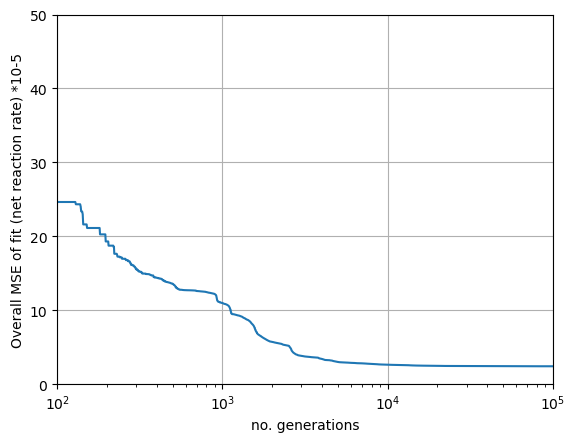

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.573318221266042
1.534454534739539
0.864514859098104
-4.150943161904985
0.47845482348705803
6.819496850593634e-07
0.4050563807458328
-3.9390243036878547
0.22612432956625475
4.386911445273948
3.330085625475235
3.5111120174303907
0.5943140400449175
0.03286001917956077
3.0013341619218945
1.113987879355185e-06
0.3189211575360695
-11.406057589901868
1.7942842238314523
1.523621643752475
-10.964720808859648
1.1170040392057952
3.742088496650995
0.00862503686756228
3.9895379155181874
4.022771882646335
1.6524310564941078
9.092386795732507
-10.817205716883342
2.994813329871086
1.7805667689381033
3.7939072022338274
-4.0931432643135075
0.5148393370644053
1.0050824348164447
-1.3010299892776938


In [37]:
res.X

array([-1.15733182e+01,  1.53445453e+00,  8.64514859e-01, -4.15094316e+00,
        4.78454823e-01,  6.81949685e-07,  4.05056381e-01, -3.93902430e+00,
        2.26124330e-01,  4.38691145e+00,  3.33008563e+00,  3.51111202e+00,
        5.94314040e-01,  3.28600192e-02,  3.00133416e+00,  1.11398788e-06,
        3.18921158e-01, -1.14060576e+01,  1.79428422e+00,  1.52362164e+00,
       -1.09647208e+01,  1.11700404e+00,  3.74208850e+00,  8.62503687e-03,
        3.98953792e+00,  4.02277188e+00,  1.65243106e+00,  9.09238680e+00,
       -1.08172057e+01,  2.99481333e+00,  1.78056677e+00,  3.79390720e+00,
       -4.09314326e+00,  5.14839337e-01,  1.00508243e+00, -1.30102999e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -11.573318221266042
1.6: 1.534454534739539
0.9: 0.864514859098104
-4.3: -4.150943161904985
0.5: 0.47845482348705803
0.003: 6.819496850593634e-07
0.4: 0.4050563807458328
-7.9: -3.9390243036878547
0.7: 0.22612432956625475
7.2: 4.386911445273948
5.7: 3.330085625475235
5.7: 3.5111120174303907
0.8: 0.5943140400449175
0.03: 0.03286001917956077
3.1: 3.0013341619218945
6.000000000000001e-09: 1.113987879355185e-06
0.1: 0.3189211575360695
-12.0: -11.406057589901868
1.9: 1.7942842238314523
1.6: 1.523621643752475
-11.6: -10.964720808859648
1.2: 1.1170040392057952
4.0: 3.742088496650995
0.01: 0.00862503686756228
4.2: 3.9895379155181874
5.4: 4.022771882646335
2.2: 1.6524310564941078
11.8: 9.092386795732507
-12.0: -10.817205716883342
3.3: 2.994813329871086
1.8: 1.7805667689381033
4.2: 3.7939072022338274
-4.0: -4.0931432643135075
0.5: 0.5148393370644053
1.0: 1.0050824348164447
coeff fit: 0.9552179435519131
r: 0.977352517545186
